In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
from scipy.interpolate import RectBivariateSpline
import numpy as np

In [3]:
import sys
sys.path.append("..")

In [4]:
from vaneska.interpolate import ScipyRectBivariateSpline

/Users/ozymandias1/anaconda2/envs/python3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [5]:
from lightkurve import KeplerTargetPixelFile

In [6]:
import tensorflow as tf

In [7]:
from vaneska.models import KeplerPRF

In [8]:
tpf = KeplerTargetPixelFile.from_archive('kepler-10b', quarter=5)

INFO: Found cached file ./mastDownload/Kepler/kplr011904151_lc_Q111111110111011101/kplr011904151-2010174085026_lpd-targ.fits.gz with expected size 4685387. [astroquery.query]


In [9]:
tpf.plot()

In [10]:
tpf.shape

(4492, 8, 7)

In [11]:
prf = KeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row, ss_factor=5)

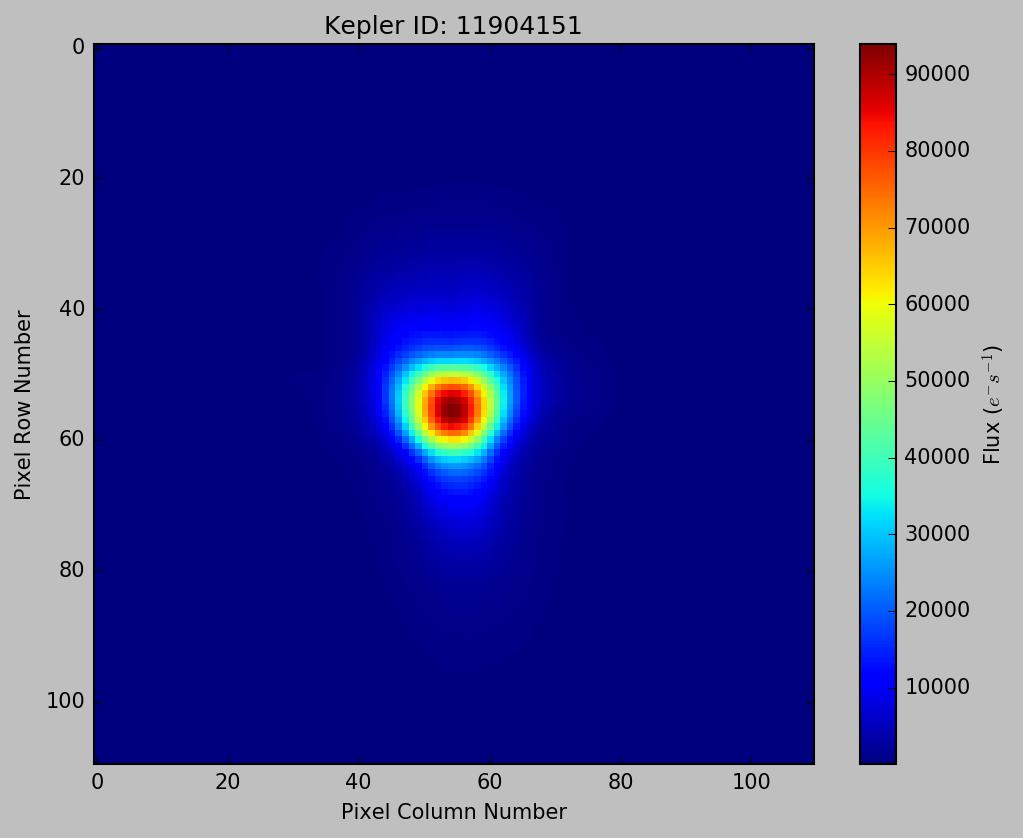

In [12]:
np.shape(prf.supersampled_prf)

plt.imshow(prf.supersampled_prf, interpolation='nearest')
plt.show()

In [13]:
flux0 = np.nansum(tpf.flux[0])
xc0, yc0 = tpf.centroids()[0][0], tpf.centroids()[1][0]
bkg0 = np.nanmean(tpf.flux_bkg[0])

In [14]:
flux = tf.Variable(flux0, dtype=tf.float64)
xc = tf.Variable(xc0, dtype=tf.float64)
yc = tf.Variable(yc0, dtype=tf.float64)
bkg = tf.Variable(bkg0, dtype=tf.float64)

In [15]:
var_list = [flux, xc, yc, bkg]

In [16]:
model = prf(flux, xc, yc) + bkg

In [17]:
model

<tf.Tensor 'add:0' shape=<unknown> dtype=float64>

In [18]:
sess = tf.Session()

In [19]:
sess.run(tf.global_variables_initializer())

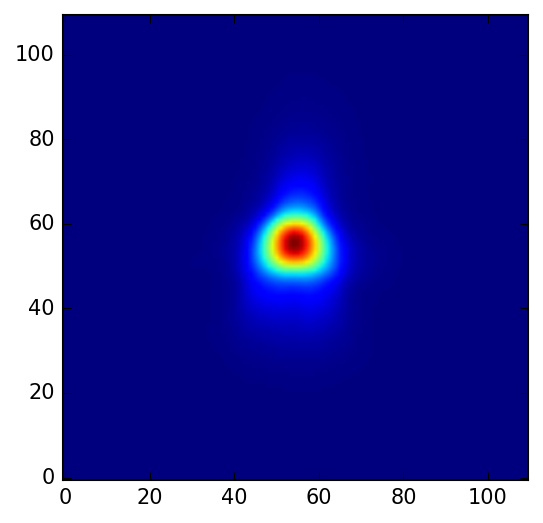

In [20]:
plt.imshow(prf.supersampled_prf, origin='lower')

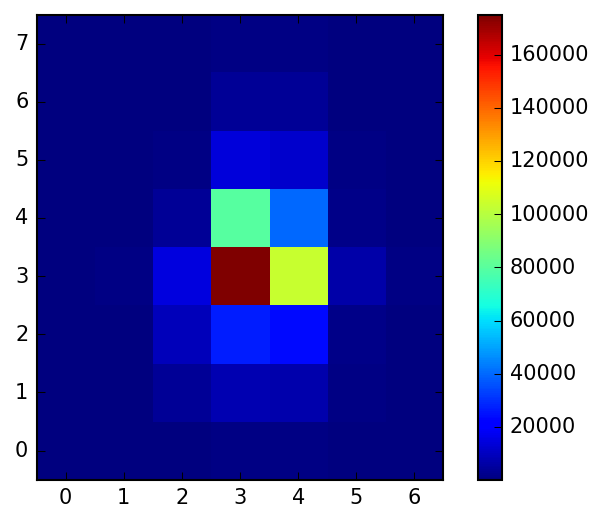

In [21]:
plt.imshow(sess.run(model), origin='lower', interpolation='nearest')
plt.colorbar()

In [22]:
data = tf.placeholder(dtype=tf.float64, shape=tpf.flux[0].shape)

In [23]:
loss = tf.reduce_sum(tf.subtract(model, tf.multiply(data, tf.log(model))))

In [24]:
grad = tf.gradients(loss, var_list)

In [25]:
sess.run(grad, feed_dict={data:tpf.flux[0] + tpf.flux_bkg[0]})

[0.004670431125111075,
 -41408.366553503976,
 6472.371330791004,
 -5.061014230005174]

In [26]:
sess.run(loss, feed_dict={data:tpf.flux[-1] + tpf.flux_bkg[-1]})

-5427819.605868609

In [27]:
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, var_list, method='BFGS')

In [28]:
import tqdm

In [29]:
psf_flux = []
psf_xc = []
psf_yc = []
psf_bkg = []
for n in tqdm.tqdm(range(len(tpf.time))):
    optimizer.minimize(session=sess, feed_dict={data:tpf.flux[n] + tpf.flux_bkg[n]})
    psf_flux.append(sess.run(flux))
    psf_xc.append(sess.run(xc))
    psf_yc.append(sess.run(yc))
    psf_bkg.append(sess.run(bkg))
    print(sess.run(grad, feed_dict={data:tpf.flux[n] + tpf.flux_bkg[n]}))

  0%|          | 0/4492 [00:00<?, ?it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511096.975481
  Number of iterations: 33
  Number of functions evaluations: 40


  0%|          | 1/4492 [00:00<09:14,  8.10it/s]

[4.833380674862386e-10, 8.663196240377147e-07, -3.5391167330089957e-06, -4.13431846535417e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510908.886732
  Number of iterations: 7
  Number of functions evaluations: 63
[6.962246486214366e-07, 0.013120437364250392, 0.0014481796788459178, -5.676875262095038e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511371.925669
  Number of iterations: 29
  Number of functions evaluations: 36


  0%|          | 3/4492 [00:00<07:53,  9.48it/s]

[-1.4258701424435527e-10, -0.0001352848228179937, -2.677466909517534e-06, -2.264498699666717e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511818.659288
  Number of iterations: 33
  Number of functions evaluations: 38
[1.2722433870293592e-10, -0.000472781959160784, 0.0002644065698405029, 3.351763185888146e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511970.319773
  Number of iterations: 12
  Number of functions evaluations: 86


  0%|          | 5/4492 [00:00<07:31,  9.93it/s]

[1.636920541251037e-06, -7.116364895409788e-05, 1.0110696166520938e-05, -1.4033141426672557e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511753.558423
  Number of iterations: 10
  Number of functions evaluations: 14
[-6.652576631343589e-06, 0.0009801861081086827, -0.000639488145679934, -7.074605989920713e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511862.107704
  Number of iterations: 36
  Number of functions evaluations: 39


  0%|          | 7/4492 [00:00<06:38, 11.26it/s]

[4.673522853437806e-12, 1.1043835002055857e-07, 1.4349825505632907e-07, 5.842338834938232e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511966.702850
  Number of iterations: 9
  Number of functions evaluations: 86
[-1.079134394901815e-05, 0.000229465501206505, 0.0003835169063677313, -2.482876224618735e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512271.049756
  Number of iterations: 8
  Number of functions evaluations: 12


  0%|          | 9/4492 [00:00<06:45, 11.05it/s]

[-7.833543505531004e-06, -0.0006356989329106, 0.0004572177895170171, 4.0768029507809445e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512054.074849
  Number of iterations: 8
  Number of functions evaluations: 51
[-1.2284170111608386e-05, 0.00035388915148359956, -0.0001695755581749836, -9.367088771305987e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511269.645810
  Number of iterations: 36
  Number of functions evaluations: 40


  0%|          | 11/4492 [00:00<05:57, 12.53it/s]

[9.872372017105668e-12, 1.3001126717426814e-06, -1.3164153642719612e-06, -1.3066662196692391e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512738.833869
  Number of iterations: 38
  Number of functions evaluations: 43
[-1.0938541739058394e-12, 3.192826625308953e-08, 3.760578692890704e-08, -2.7526980694858594e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511751.403720
  Number of iterations: 30
  Number of functions evaluations: 93


  0%|          | 13/4492 [00:01<05:54, 12.63it/s]

[-2.4281252824359667e-09, 0.00473776519038438, 0.0004679278663388686, -1.3894622830079584e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511557.937517
  Number of iterations: 37
  Number of functions evaluations: 42
[2.1953751403597233e-10, -4.5506754531743354e-05, -7.68824957049219e-05, 5.661428525982615e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508128.044049
  Number of iterations: 37
  Number of functions evaluations: 41


  0%|          | 15/4492 [00:01<05:23, 13.84it/s]

[3.055461994527775e-10, -3.190738198100007e-06, -5.705966032110155e-06, -9.479217433217002e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512171.657237
  Number of iterations: 37
  Number of functions evaluations: 41
[-5.513866524822775e-10, 8.142481419781689e-05, 9.624345511838328e-05, -1.1207706751559243e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512721.875699
  Number of iterations: 36
  Number of functions evaluations: 82


  0%|          | 17/4492 [00:01<05:44, 12.97it/s]

[8.948510035397539e-09, -0.005849794574032785, 0.0007467185660061659, -3.416489129715039e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513233.140222
  Number of iterations: 36
  Number of functions evaluations: 40
[2.592097335385457e-10, -5.799528184979863e-05, -4.602740045811515e-05, 4.079718707306057e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512920.573667
  Number of iterations: 35
  Number of functions evaluations: 39


  0%|          | 19/4492 [00:01<05:10, 14.42it/s]

[1.95824719287363e-11, -1.3463170716931927e-05, 1.1357908078934997e-05, 2.592022152470008e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512662.505308
  Number of iterations: 11
  Number of functions evaluations: 15
[1.9330856752339774e-05, -0.0029663762259133364, 0.0015914984323899262, 2.6444150963422786e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512833.056374
  Number of iterations: 13
  Number of functions evaluations: 18
[1.4199490951692824e-05, 0.01878262929972152, -0.004688323602749733, -6.973677583732574e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512760.440373
  Number of iterations: 11
  Number of functions evaluations: 15
[1.472554378203518e-05, -0.00019

  1%|          | 23/4492 [00:01<04:24, 16.91it/s]

[9.330698973880613e-11, 2.3838524612074252e-06, -2.80268068308942e-07, -2.1432095320683686e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512466.095276
  Number of iterations: 34
  Number of functions evaluations: 86
[-6.08887924455348e-10, -0.00031744250873089186, -0.0002352775918552652, -6.301117965179515e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512485.688105
  Number of iterations: 6
  Number of functions evaluations: 86


  1%|          | 25/4492 [00:01<04:38, 16.05it/s]

[-1.243743155390515e-05, 0.008205368050539619, -0.0011034540166292572, -9.22445332340871e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513439.053345
  Number of iterations: 34
  Number of functions evaluations: 38
[-1.8608586893620327e-12, -6.525965545733925e-08, -5.802576197311282e-10, 1.5319634449895148e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513256.797400
  Number of iterations: 33
  Number of functions evaluations: 38
[3.972201491342364e-10, -0.0003500321463434375, 0.00020478246187849436, 2.5815342508117567e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513569.209144
  Number of iterations: 26
  Number of functions evaluations: 34


  1%|          | 28/4492 [00:01<04:01, 18.47it/s]

[-1.9054922917316475e-10, -0.00013973207751405425, 0.000212105109312688, -3.952160920750458e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513795.447393
  Number of iterations: 13
  Number of functions evaluations: 20
[6.615777886413016e-06, 8.940346060626325e-05, -0.0010702698691602563, -8.062706002842646e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514277.670357
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.3661069671322412e-10, 9.074974514078349e-07, -6.553376806550659e-06, -3.3135170163234307e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513985.194751
  Number of iterations: 35
  Number of functions evaluations: 40


  1%|          | 31/4492 [00:01<03:33, 20.86it/s]

[1.213867001706448e-10, -2.7356192276783986e-05, 2.128420237568207e-05, 3.579366425476849e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514056.550026
  Number of iterations: 11
  Number of functions evaluations: 15
[1.4913798931346506e-05, 0.0007003184359746228, -0.0009669946357462322, 1.4716748486520714e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514149.716292
  Number of iterations: 9
  Number of functions evaluations: 71
[3.897279979483276e-06, 0.0001929077370732557, -0.00012597584645845927, 7.612141916801818e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514287.055951
  Number of iterations: 34
  Number of functions evaluations: 39


  1%|          | 34/4492 [00:01<03:18, 22.41it/s]

[-1.5684425893475185e-10, -3.338828128107707e-05, -1.5707897546235472e-05, -5.5966885237346276e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514489.595838
  Number of iterations: 27
  Number of functions evaluations: 34
[-7.364182787877871e-11, -0.00022946642775423243, 0.0006243261759664165, -1.343270559228671e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514850.778480
  Number of iterations: 36
  Number of functions evaluations: 45
[-4.1085830050635597e-11, 5.0767425364028895e-05, -3.72223075828515e-06, 2.3670689297539127e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514828.273061
  Number of iterations: 27
  Number of functions evaluations: 34


  1%|          | 37/4492 [00:02<03:09, 23.49it/s]

[-9.389060969672292e-11, -0.0011400288008189818, 0.0005636694913846441, -1.67297214970219e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514450.705617
  Number of iterations: 35
  Number of functions evaluations: 39
[6.569837469189155e-11, -1.6208433407882694e-05, -2.8686463338090107e-06, 1.288318185466153e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514859.087409
  Number of iterations: 36
  Number of functions evaluations: 40
[-4.804688417958669e-11, 1.5630069810868008e-05, 1.1376145266694948e-05, 1.3996538594795993e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514827.890496
  Number of iterations: 34
  Number of functions evaluations: 96


  1%|          | 40/4492 [00:02<03:19, 22.30it/s]

[7.245601301233973e-09, -0.006526107706122275, -0.004278437834727811, -3.3889727453217944e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514575.974709
  Number of iterations: 36
  Number of functions evaluations: 41
[8.287614344792971e-11, 1.3556342764786677e-05, -1.692988007562235e-07, 1.9059574030144688e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515009.470390
  Number of iterations: 33
  Number of functions evaluations: 38
[-8.22245396769894e-12, 3.138402416880126e-05, -2.2629177692579105e-05, 8.592133549090164e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514925.290198
  Number of iterations: 12
  Number of functions evaluations: 16


  1%|          | 43/4492 [00:02<03:14, 22.86it/s]

[-9.501778800834887e-08, -0.0002668227007234236, -0.0002968746739497874, -5.8413605064089325e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515334.550902
  Number of iterations: 31
  Number of functions evaluations: 39
[3.637163990127812e-10, -0.0003383736220712308, -0.00010864737851079553, 3.179417600307488e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514976.327500
  Number of iterations: 37
  Number of functions evaluations: 42
[4.948323868714244e-11, -3.0708982649230165e-05, -4.6747536543989554e-05, -1.9295303910205064e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515737.165255
  Number of iterations: 26
  Number of functions evaluations: 109


  1%|          | 46/4492 [00:02<03:24, 21.72it/s]

[6.725142404767626e-10, -0.00010591781574476045, -0.0001080806632671738, -2.404809029687982e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515076.510655
  Number of iterations: 28
  Number of functions evaluations: 36
[7.802855844091239e-11, -7.798308161000023e-06, -6.477463102783076e-05, -1.418486894610993e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515748.075954
  Number of iterations: 37
  Number of functions evaluations: 40
[-4.3184359126841043e-10, -4.614475983544253e-07, -9.106788638746366e-06, -1.7534114160611125e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515903.247778
  Number of iterations: 35
  Number of functions evaluations: 41


  1%|          | 49/4492 [00:02<03:11, 23.21it/s]

[-1.7987596655222315e-10, -3.14530670948443e-05, 0.0005787983900518157, -1.5470593828226242e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515466.542422
  Number of iterations: 25
  Number of functions evaluations: 152
[-5.364354535228322e-09, -0.0016550322352486546, 0.003155675154630444, -1.711404893578461e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515241.707913
  Number of iterations: 36
  Number of functions evaluations: 46
[-2.7993791399533174e-10, 0.00039282931948037003, 0.0023036990296532167, -5.281066250972799e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515613.828973
  Number of iterations: 23
  Number of functions evaluations: 32


  1%|          | 52/4492 [00:02<03:37, 20.44it/s]

[-5.1280699304989685e-11, 1.1170236575708259e-05, 8.161041478160769e-06, 1.8278105362590225e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515336.837818
  Number of iterations: 8
  Number of functions evaluations: 73
[1.4913687441034731e-05, -6.673964890069328e-06, 0.00014320067566586658, -2.393444028525593e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515552.047033
  Number of iterations: 36
  Number of functions evaluations: 40
[-2.2349931801113332e-11, 2.6414295462018345e-06, -6.113208655733615e-06, -2.6421195231662864e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516083.721603
  Number of iterations: 11
  Number of functions evaluations: 16


  1%|          | 55/4492 [00:02<03:21, 22.05it/s]

[-4.552942922313695e-06, 8.396006023758673e-05, 8.458824049739633e-05, -1.007607848269032e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515465.007209
  Number of iterations: 31
  Number of functions evaluations: 104
[-1.5083434015683572e-09, -0.0011208746950615023, 0.000160858628078131, -1.0066536867414655e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5523015.037712
  Number of iterations: 8
  Number of functions evaluations: 66
[2.784038049976397e-05, 1.962389887921745e-06, -2.215561289631296e-05, -1.2382952019329707e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515848.814028
  Number of iterations: 33
  Number of functions evaluations: 43


  1%|▏         | 58/4492 [00:03<03:40, 20.10it/s]

[-1.612213834656373e-11, -5.0464223022572696e-08, 1.6505509847775102e-07, 3.209675525361888e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515768.252638
  Number of iterations: 34
  Number of functions evaluations: 43
[4.342352605962718e-11, 8.599060947744874e-06, -1.7772672435967252e-06, 7.56285967185022e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515639.922426
  Number of iterations: 11
  Number of functions evaluations: 19
[-6.905218895896827e-06, -0.006352930678076518, -0.004629650906281313, -2.169622971059937e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515671.757824
  Number of iterations: 29
  Number of functions evaluations: 38


  1%|▏         | 61/4492 [00:03<03:18, 22.29it/s]

[-2.5179424517629556e-13, 4.863886715611443e-08, -7.908965926617384e-09, 3.8338221486355906e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515780.957224
  Number of iterations: 37
  Number of functions evaluations: 41
[1.2475392507232952e-10, 0.00010423927051306237, 0.00016807418069220148, 2.4165220158245404e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514960.368270
  Number of iterations: 36
  Number of functions evaluations: 48
[5.6192594848070154e-11, 1.3318077435542364e-05, -2.589402356534265e-06, 7.3825550117589955e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514789.461758
  Number of iterations: 33
  Number of functions evaluations: 38


  1%|▏         | 64/4492 [00:03<03:17, 22.37it/s]

[3.8922274257779943e-10, -7.176667713792995e-05, 2.901850893977098e-05, 4.1953215446088876e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515294.531516
  Number of iterations: 36
  Number of functions evaluations: 116
[-1.2114555192344056e-10, 1.4311979612102732e-05, -1.073977182386443e-05, -2.4633099782178647e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515878.519910
  Number of iterations: 34
  Number of functions evaluations: 38
[-3.5198818599396775e-10, -0.0012133104878557788, 0.0009101224677579012, -3.750967558779905e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516234.321004
  Number of iterations: 36
  Number of functions evaluations: 39


  1%|▏         | 67/4492 [00:03<03:33, 20.73it/s]

[-2.1159026787620494e-11, 3.0794835765846074e-06, -1.7758957255864516e-06, 4.299402833751742e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516186.420405
  Number of iterations: 34
  Number of functions evaluations: 39
[5.03819390720861e-11, 9.88781266642036e-06, -1.0914300219155848e-06, 1.0849755538444583e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516188.750656
  Number of iterations: 33
  Number of functions evaluations: 41
[6.220976424969882e-10, 0.00016480198837598437, -0.00011520833322720136, -7.442620487685403e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515963.620029
  Number of iterations: 8
  Number of functions evaluations: 12
[-1.3330798706839148e-06, -6.142421625554562e-06, -8.493971108691767e-06, 2.

  2%|▏         | 71/4492 [00:03<03:08, 23.47it/s]

[4.509806070251976e-11, -2.287218421770376e-05, 3.965440555475652e-06, -1.791309456322665e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515758.025180
  Number of iterations: 29
  Number of functions evaluations: 35
[7.648020931838584e-11, -7.46191076359537e-05, 6.286228017415851e-05, -1.0088634372351635e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515827.946221
  Number of iterations: 36
  Number of functions evaluations: 42
[-2.5715314426466573e-11, -2.3302554836845957e-06, -7.324111720663495e-06, -3.386285696294067e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516323.948475
  Number of iterations: 28
  Number of functions evaluations: 33


  2%|▏         | 74/4492 [00:03<03:01, 24.39it/s]

[-9.264688755755701e-11, -4.061269919475308e-06, -2.439339368720539e-06, -2.5270469716787147e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515915.149568
  Number of iterations: 35
  Number of functions evaluations: 86
[-5.155822703668822e-09, -0.0020329659710114356, -0.00025973000265366863, 5.631475374245909e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516664.497011
  Number of iterations: 27
  Number of functions evaluations: 35
[-1.123236200231692e-10, 4.919973343930906e-05, 1.9796487322309986e-05, -1.8887160502245592e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516520.222359
  Number of iterations: 35
  Number of functions evaluations: 39


  2%|▏         | 77/4492 [00:03<03:14, 22.74it/s]

[1.168742706780801e-11, -1.4279794413596392e-06, -3.0009869078639895e-07, 1.4515533219849885e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516287.236383
  Number of iterations: 34
  Number of functions evaluations: 38
[-4.1284260038354503e-10, 0.00020831407209698227, 0.00010232678323518485, -4.7662872026954517e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517639.151734
  Number of iterations: 35
  Number of functions evaluations: 40
[-4.274035552559452e-11, 9.49192826737999e-06, 1.3833299817633815e-05, 3.6980986051204923e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516729.767679
  Number of iterations: 30
  Number of functions evaluations: 41


  2%|▏         | 80/4492 [00:04<03:08, 23.35it/s]

[1.3347757447934594e-10, 7.797980288160034e-07, -1.7743550415616482e-06, -3.330002062984505e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517115.280705
  Number of iterations: 36
  Number of functions evaluations: 43
[-2.943435859631416e-10, -0.0007443924882863939, 3.8277808926068246e-05, -7.067440618291343e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517099.502962
  Number of iterations: 30
  Number of functions evaluations: 37
[3.367760827155397e-10, 0.0006723299661643978, -6.569892684638035e-05, -5.444112712860161e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517334.919612
  Number of iterations: 13
  Number of functions evaluations: 46


  2%|▏         | 83/4492 [00:04<03:03, 24.00it/s]

[6.144694962616562e-07, 0.00017423856479581445, 0.00020636494627979118, -1.4356730693165787e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517577.025431
  Number of iterations: 35
  Number of functions evaluations: 40
[-4.3333326076727685e-10, -0.0001037549495777057, 1.073226121661719e-05, -2.1235941205510755e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517308.777097
  Number of iterations: 33
  Number of functions evaluations: 37
[8.053293145196538e-10, -8.938561677496182e-06, 5.021263859816827e-06, 5.451058142647014e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517070.295782
  Number of iterations: 31
  Number of functions evaluations: 40


  2%|▏         | 86/4492 [00:04<03:10, 23.07it/s]

[-3.0573138638800845e-11, 3.462989297986496e-05, -5.521453203982674e-06, -8.867122591738053e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517144.684732
  Number of iterations: 34
  Number of functions evaluations: 38
[-4.5500152690697293e-10, -0.0010170122668569093, 0.0016161489111254923, -5.5218074446194976e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517492.378253
  Number of iterations: 11
  Number of functions evaluations: 16
[-1.2823779215227413e-05, 0.00022296560109680286, -0.00030306125700008124, -1.925602892693945e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516944.860369
  Number of iterations: 10
  Number of functions evaluations: 14


  2%|▏         | 89/4492 [00:04<03:00, 24.35it/s]

[1.2279924498005516e-05, -0.000460371513327118, -0.0002433570389257511, 1.8269382007218837e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517528.375523
  Number of iterations: 33
  Number of functions evaluations: 87
[4.153245834054298e-09, -0.0010187434349973046, 0.00544760437333025, -7.771899124264792e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517208.830228
  Number of iterations: 13
  Number of functions evaluations: 84
[-3.3200542022982643e-06, -7.461218046955764e-06, 2.4940905859693885e-05, 5.985287587773058e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516725.068125
  Number of iterations: 32
  Number of functions evaluations: 38


  2%|▏         | 92/4492 [00:04<03:45, 19.49it/s]

[2.953732744503945e-10, -0.0004416598258103477, 0.00026677763162297197, 1.3771918383476134e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517483.920825
  Number of iterations: 34
  Number of functions evaluations: 38
[-4.0432289460934356e-11, 3.911915882781614e-06, 2.0237021089997143e-06, -5.181323259328963e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517249.302501
  Number of iterations: 35
  Number of functions evaluations: 38
[7.746890455517796e-11, 5.319242973200744e-06, 2.2402091417461634e-06, 2.6197822133866566e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517498.547956
  Number of iterations: 34
  Number of functions evaluations: 38


  2%|▏         | 95/4492 [00:04<03:25, 21.45it/s]

[-6.304067511064826e-12, -8.217584763769992e-07, -2.7692840376403183e-07, 1.0742375877725863e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517147.530733
  Number of iterations: 32
  Number of functions evaluations: 40
[1.1120983821333308e-10, 9.119898231801926e-05, -1.545953273307532e-05, 1.95002750613682e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516970.694412
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.2746099835314606e-10, -0.0006564261839230312, 0.0011552548476174707, -4.3862173226827395e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517125.114571
  Number of iterations: 35
  Number of functions evaluations: 88


  2%|▏         | 98/4492 [00:04<03:28, 21.03it/s]

[-1.6069023976023056e-10, -0.0006720339442836121, -0.0008473763718939153, 7.384598242898832e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517352.781302
  Number of iterations: 37
  Number of functions evaluations: 41
[-4.625376383987634e-11, 5.716451141779544e-06, -1.0527239282964729e-05, -9.153895974556292e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517085.124088
  Number of iterations: 33
  Number of functions evaluations: 89
[5.603981645049827e-10, -0.00037462333875737386, -0.00017700731768854894, 3.8218482778518137e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516936.243189
  Number of iterations: 35
  Number of functions evaluations: 39


  2%|▏         | 101/4492 [00:05<03:28, 21.03it/s]

[4.036207392615898e-11, -0.0001684524740994675, 4.2487154132686555e-06, -1.6834184435321475e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517621.074685
  Number of iterations: 36
  Number of functions evaluations: 66
[-1.234736049515739e-09, 0.0010722113306655956, -0.00015410078049171716, -1.558161088599519e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515717.402781
  Number of iterations: 30
  Number of functions evaluations: 36
[5.641299614944639e-10, 0.00047569016942361486, 0.00010744966311904136, 1.264194332550872e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516419.399857
  Number of iterations: 38
  Number of functions evaluations: 41


  2%|▏         | 104/4492 [00:05<03:25, 21.30it/s]

[-1.0903731997163879e-10, -6.041098913556198e-06, -9.824691005633213e-06, -2.271271437592759e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516088.661212
  Number of iterations: 34
  Number of functions evaluations: 43
[-3.7160369399658055e-09, 0.0032965220116238925, 0.003311913160359836, -1.3664255803513825e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516951.633209
  Number of iterations: 38
  Number of functions evaluations: 42
[-7.271934790442636e-13, 3.8575763028347865e-08, -8.751885616220534e-08, -1.0350720280882797e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517496.910452
  Number of iterations: 31
  Number of functions evaluations: 37


  2%|▏         | 107/4492 [00:05<03:30, 20.82it/s]

[-4.081186933541092e-10, 0.000640351124729932, 0.000996075523289619, -6.240364809340093e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517352.064596
  Number of iterations: 12
  Number of functions evaluations: 16
[3.0831738222996015e-05, 0.0025406490603927523, -0.0031813091572985286, -5.567936214423419e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516236.707635
  Number of iterations: 36
  Number of functions evaluations: 40
[3.224083717015547e-10, -1.1973698292422341e-05, 7.993210601853207e-06, 1.3906700813137718e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516610.544561
  Number of iterations: 33
  Number of functions evaluations: 38


  2%|▏         | 110/4492 [00:05<03:32, 20.60it/s]

[-2.3801858747840576e-10, 6.653462560279877e-05, -3.386497337487526e-05, -1.0357011026584928e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517082.004959
  Number of iterations: 36
  Number of functions evaluations: 39
[-9.88807334623143e-11, 3.3800188248278573e-07, 2.0983679860364646e-07, -2.3498638479502176e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517389.942702
  Number of iterations: 32
  Number of functions evaluations: 64
[6.056834200851569e-11, 2.2487854948849417e-05, 8.157201591529883e-06, 1.7695954701579808e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517379.471802
  Number of iterations: 11
  Number of functions evaluations: 18


  3%|▎         | 113/4492 [00:05<03:39, 19.96it/s]

[-3.492589398119625e-06, 0.00013797545898341923, -0.0004156389713898534, -4.7574191253119125e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517597.800115
  Number of iterations: 10
  Number of functions evaluations: 66
[-4.700777462968847e-06, -0.001050816404131183, -0.0005900205305806594, 1.4645320456363464e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517204.465507
  Number of iterations: 12
  Number of functions evaluations: 18
[6.94213756352504e-06, 0.011289133993614087, -0.01665688824141398, 1.3147565480764456e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518226.619833
  Number of iterations: 35
  Number of functions evaluations: 42


  3%|▎         | 116/4492 [00:05<03:29, 20.90it/s]

[-3.368910792694857e-11, 6.946329449419864e-07, -1.1412703315727413e-07, 5.29236365842678e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517378.623799
  Number of iterations: 35
  Number of functions evaluations: 39
[1.24695021669341e-10, -3.728030696947826e-05, -5.547080945689231e-06, 2.555381362068232e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516205.666365
  Number of iterations: 32
  Number of functions evaluations: 37
[3.8236518985768075e-11, 6.207099431776442e-06, 2.2776894184062257e-06, -7.757975595268363e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515929.128658
  Number of iterations: 37
  Number of functions evaluations: 40


  3%|▎         | 119/4492 [00:05<03:17, 22.10it/s]

[7.207984209500751e-11, -1.352904291707091e-06, 2.9308503144420683e-06, 1.2349559264102083e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517261.693777
  Number of iterations: 34
  Number of functions evaluations: 102
[-9.184607302134551e-10, -0.00820679809385183, -0.000800943194917636, -3.672114909147872e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509629.156346
  Number of iterations: 27
  Number of functions evaluations: 79
[1.5704617007880617e-09, 0.0006022974707775575, 1.399099528498482e-05, -1.971693640689942e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513454.961816
  Number of iterations: 36
  Number of functions evaluations: 42


  3%|▎         | 122/4492 [00:06<03:54, 18.66it/s]

[-5.298607733128513e-11, -3.2974336590996245e-05, -3.100345566053875e-06, -1.696038087750651e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513500.538843
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.8166341261144359e-10, -5.4912026826059446e-05, 1.647502722335048e-05, -3.833196615676826e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516914.203764
  Number of iterations: 31
  Number of functions evaluations: 39
[-1.5159387634078314e-11, 1.7250313248950988e-06, -3.8426514947786927e-07, 5.146172377124003e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518098.207342
  Number of iterations: 35
  Number of functions evaluations: 40


  3%|▎         | 125/4492 [00:06<03:32, 20.57it/s]

[-1.6550583212954217e-10, 9.279454707211698e-05, 5.054098437540233e-07, -7.088076503514174e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517579.696178
  Number of iterations: 38
  Number of functions evaluations: 43
[3.439282018902201e-11, -1.8318910406378563e-06, 1.1159994755871594e-05, -9.045321269773865e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517478.031896
  Number of iterations: 29
  Number of functions evaluations: 35
[9.631684165511967e-11, -0.00010155367181141628, 6.959930396988057e-05, -1.6618575404692137e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518205.201347
  Number of iterations: 33
  Number of functions evaluations: 38


  3%|▎         | 128/4492 [00:06<03:19, 21.86it/s]

[-4.111335742337796e-10, -0.0004132320291319047, -9.058181603904814e-06, -1.0682249385052245e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518148.802744
  Number of iterations: 11
  Number of functions evaluations: 15
[2.505872092485161e-05, 0.0005604450952887419, -0.0007361976968240924, 3.255369088739357e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518273.035346
  Number of iterations: 13
  Number of functions evaluations: 65
[7.372261319020523e-07, -2.9167678803787567e-05, -4.61521340184845e-05, 5.130081581761203e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518586.400846
  Number of iterations: 29
  Number of functions evaluations: 35


  3%|▎         | 131/4492 [00:06<03:10, 22.94it/s]

[-2.846378757692669e-10, 2.7378970116842538e-05, -6.171325367176905e-06, -2.448973720481362e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517866.823977
  Number of iterations: 36
  Number of functions evaluations: 40
[8.598616957344873e-11, 2.5136884687526617e-05, 2.9685234039789066e-06, -3.8362851784157215e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518456.070084
  Number of iterations: 34
  Number of functions evaluations: 133
[2.3783959714022973e-08, -0.0016964758151516435, 0.0018834325874195201, 5.637944146985596e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518046.498832
  Number of iterations: 10
  Number of functions evaluations: 17


  3%|▎         | 134/4492 [00:06<03:24, 21.31it/s]

[-1.6371181463523295e-05, -0.0015676775979045487, 0.00018853011715691537, 1.6172167619510347e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517553.920813
  Number of iterations: 37
  Number of functions evaluations: 40
[3.2387374032660787e-12, -4.468320184969343e-07, 6.192258297232911e-07, 2.270494903200415e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518767.963132
  Number of iterations: 35
  Number of functions evaluations: 40
[-9.926687857125804e-11, 1.575239821249852e-05, 2.3084732674760744e-05, 2.4610455673368392e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518065.450063
  Number of iterations: 34
  Number of functions evaluations: 39


  3%|▎         | 137/4492 [00:06<03:17, 22.05it/s]

[7.790159455012269e-10, -2.0996278180973604e-05, -1.5251969671226107e-05, 4.028479534401441e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518120.535624
  Number of iterations: 35
  Number of functions evaluations: 40
[-3.190478697207011e-11, -5.27352312928997e-07, 2.311124262632802e-06, -4.79912976025787e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518038.278467
  Number of iterations: 35
  Number of functions evaluations: 39
[3.5243776733834276e-10, 0.000673494073907932, 0.0007911773518571863, 6.91376634831542e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518161.439063
  Number of iterations: 35
  Number of functions evaluations: 39


  3%|▎         | 140/4492 [00:06<03:12, 22.61it/s]

[-6.68099013612089e-11, -1.3546354239224456e-05, 7.093225576682016e-06, -1.423937345812476e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518235.708665
  Number of iterations: 35
  Number of functions evaluations: 108
[-1.92352763361478e-08, -0.005337981968295935, -0.006489947149020736, 6.859254539692827e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517933.458787
  Number of iterations: 11
  Number of functions evaluations: 64
[8.971970128300588e-06, -0.0004961782819918881, -0.0014549162824550876, -1.0682945383866382e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518212.093699
  Number of iterations: 34
  Number of functions evaluations: 112


  3%|▎         | 143/4492 [00:07<04:08, 17.49it/s]

[1.5243729455799437e-10, 0.0002537795635362272, 9.312031397712417e-05, 2.830666897546408e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517307.035843
  Number of iterations: 37
  Number of functions evaluations: 43
[5.4564170889892516e-11, -1.4522420315188356e-06, 2.0806661268579774e-05, -8.23416679285316e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517055.959693
  Number of iterations: 31
  Number of functions evaluations: 45
[-1.3572698780855985e-10, 5.5398997119482374e-05, 2.5268465833505616e-05, -7.07528350352149e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517428.016624
  Number of iterations: 7
  Number of functions evaluations: 63


  3%|▎         | 146/4492 [00:07<03:54, 18.55it/s]

[3.6165863073062132e-06, -2.2716012608725578e-05, 4.375497155706398e-06, -1.584455955327968e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518316.997005
  Number of iterations: 35
  Number of functions evaluations: 42
[-9.715749905991888e-11, -7.659364200662822e-07, -7.402375558740459e-06, -1.567431351379156e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518092.494686
  Number of iterations: 35
  Number of functions evaluations: 96
[-7.58974751623176e-09, -0.0018563675762379717, 0.002389621971815359, 4.7592673537710795e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517613.292264
  Number of iterations: 32
  Number of functions evaluations: 40


  3%|▎         | 149/4492 [00:07<03:55, 18.46it/s]

[-1.3804521041896334e-09, 6.385317055901396e-05, 0.0015814406560821226, -9.225883227381715e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518183.762665
  Number of iterations: 13
  Number of functions evaluations: 17
[-2.2629059415594545e-05, -0.0007988731881596323, 0.0035223976556153502, -2.417112711428082e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518430.376822
  Number of iterations: 32
  Number of functions evaluations: 45
[-1.316933272502152e-10, 1.5090511169546517e-05, -3.864888640237041e-06, -2.756738792797364e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518669.945327
  Number of iterations: 28
  Number of functions evaluations: 37


  3%|▎         | 152/4492 [00:07<03:32, 20.43it/s]

[1.8673184439682577e-10, 4.927433565171668e-06, -4.113300747121684e-06, -7.272903412847143e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518547.189479
  Number of iterations: 33
  Number of functions evaluations: 39
[-1.6576748654295592e-12, 2.705564838834107e-08, 1.3162207324057817e-08, -6.193490165173898e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518124.584491
  Number of iterations: 37
  Number of functions evaluations: 43
[6.361541501909151e-11, 1.6386629795306362e-06, 6.07864058110863e-06, 1.3392688180680068e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518173.689311
  Number of iterations: 7
  Number of functions evaluations: 67


  3%|▎         | 155/4492 [00:07<03:35, 20.14it/s]

[-1.5012255624364569e-05, 0.0026857473872041737, -0.001072899480277556, 2.929732967338339e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518885.226003
  Number of iterations: 35
  Number of functions evaluations: 44
[-7.424742678313612e-11, -3.442376282691839e-05, -0.0002205219971074257, 1.678716329278629e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518211.440704
  Number of iterations: 11
  Number of functions evaluations: 16
[3.373248160903376e-05, -0.001254749070994876, -0.0012892257764178794, 1.8833339454626952e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518675.124538
  Number of iterations: 37
  Number of functions evaluations: 42
[-2.699742339407063e-11, 5.987677013763459e-06, 9.3442

  4%|▎         | 159/4492 [00:07<03:10, 22.71it/s]

[-1.1198196883666078e-10, -7.12307569301629e-05, 0.00033842546145024244, -1.2301792917668308e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518671.492436
  Number of iterations: 35
  Number of functions evaluations: 39
[3.950533997154615e-11, 1.117261967920058e-05, 3.2031275623012334e-06, 8.121882499878552e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518727.696354
  Number of iterations: 27
  Number of functions evaluations: 33
[-1.8575654556207688e-10, 1.6441246998510906e-05, -2.0765026420122012e-05, -3.2771642777262855e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518792.265308
  Number of iterations: 10
  Number of functions evaluations: 14
[2.5088562761507033e-06,

  4%|▎         | 163/4492 [00:07<02:52, 25.04it/s]

[2.2225038224729654e-09, 0.006330455137685931, -0.000243163372942945, -1.5598409270900504e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518518.366478
  Number of iterations: 35
  Number of functions evaluations: 39
[7.954460874703972e-11, 7.447354846590315e-06, -8.63065361045301e-06, 1.1994724768982223e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518415.074385
  Number of iterations: 34
  Number of functions evaluations: 106
[-1.0370171960732977e-08, 0.006800343422582955, 0.00040743530189502053, 4.024471707220201e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518526.414436
  Number of iterations: 30
  Number of functions evaluations: 35


  4%|▎         | 166/4492 [00:08<03:19, 21.71it/s]

[1.6001845707866447e-09, 0.004508778195940977, 0.0014638815737271216, 1.9498215930724427e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518589.768745
  Number of iterations: 11
  Number of functions evaluations: 17
[3.850662148910909e-06, -0.00036326277518128336, 5.6393993872916326e-05, 3.540247083266834e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518785.244775
  Number of iterations: 35
  Number of functions evaluations: 41
[-1.8104016549780333e-12, -2.9933971745776944e-08, 2.9818693292327225e-08, -6.619116366124445e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518680.103894
  Number of iterations: 11
  Number of functions evaluations: 15
[7.314584177548801e-06, 0.00035879158622265095, -0.

  4%|▍         | 170/4492 [00:08<02:53, 24.97it/s]

[-3.3505613413961632e-09, -3.080577107539284e-05, 7.716569598414935e-05, 9.366291742196609e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518770.284915
  Number of iterations: 35
  Number of functions evaluations: 40
[-2.9726233800875246e-10, 9.483864846515644e-05, -0.00017467840189056005, -1.456073599470642e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518613.530508
  Number of iterations: 36
  Number of functions evaluations: 83
[7.054200973355407e-13, -9.669656719779596e-08, 6.9649104261770844e-09, -1.4965251260434798e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518896.940257
  Number of iterations: 37
  Number of functions evaluations: 40


  4%|▍         | 173/4492 [00:08<02:58, 24.23it/s]

[-4.4402783533348256e-11, 4.321129381423816e-06, -6.769376341253519e-06, -8.95828555780298e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518797.232279
  Number of iterations: 12
  Number of functions evaluations: 20
[-7.729442682608174e-06, 2.8282946004765108e-05, 0.00019039123981201556, 2.4938142928476736e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518676.839496
  Number of iterations: 11
  Number of functions evaluations: 18
[1.785041061315787e-05, -0.00012689435470747412, -0.0004662328956328565, 1.8367781062789135e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518800.908038
  Number of iterations: 36
  Number of functions evaluations: 47
[4.180631032330018e-10, -0

  4%|▍         | 177/4492 [00:08<02:46, 25.94it/s]

[-4.314517493275716e-11, 0.0005873173186046188, 0.0009544214808556717, -1.9293567887768148e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518539.413410
  Number of iterations: 34
  Number of functions evaluations: 81
[1.5682880341594263e-10, -4.278587084627361e-06, -1.2671755030169152e-05, -2.945770186668639e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519616.505366
  Number of iterations: 35
  Number of functions evaluations: 95
[1.3917627074248873e-08, 0.009532259615298244, 0.027705865233656368, -1.5252350705763362e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519211.493199
  Number of iterations: 38
  Number of functions evaluations: 42


  4%|▍         | 180/4492 [00:08<03:18, 21.69it/s]

[1.544997896979483e-11, 1.543499138279003e-06, 3.1104118534130976e-06, -3.731047804045318e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519028.312734
  Number of iterations: 27
  Number of functions evaluations: 36
[-3.4792933117921976e-10, 4.838173958887637e-05, -3.215640572307166e-05, -3.7738763825068133e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519867.673259
  Number of iterations: 35
  Number of functions evaluations: 105
[-3.1754313241372234e-10, -0.000803546830184132, 0.001963718537808745, -2.1468537910740437e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518815.914485
  Number of iterations: 28
  Number of functions evaluations: 38


  4%|▍         | 183/4492 [00:08<03:18, 21.70it/s]

[2.461623795427248e-10, 1.0268381402056548e-05, 3.611099782574456e-05, -3.12612041253324e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518565.037978
  Number of iterations: 11
  Number of functions evaluations: 16
[-2.083136618052147e-05, 0.0032920951905452966, -0.001114359585699276, 4.36263961589578e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518003.593113
  Number of iterations: 37
  Number of functions evaluations: 101
[-3.109737083291375e-09, 4.903519447907456e-05, 0.000337298715749057, -2.2465320871356553e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517671.752340
  Number of iterations: 35
  Number of functions evaluations: 41


  4%|▍         | 186/4492 [00:08<03:11, 22.53it/s]

[2.9547204960511664e-11, -7.518609891121741e-06, 2.114667950081639e-06, 6.349873404865036e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517986.206816
  Number of iterations: 11
  Number of functions evaluations: 18
[1.0548780934739599e-05, 0.02693202583236598, -0.0017636227421462536, -1.3558022980975082e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519169.134524
  Number of iterations: 38
  Number of functions evaluations: 44
[-5.633457060214009e-10, -2.6678360882215202e-05, 0.00026205058384221047, -7.68826614927498e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519036.647516
  Number of iterations: 36
  Number of functions evaluations: 43
[2.5893954168354494e-10, -9.0

  4%|▍         | 190/4492 [00:09<02:52, 24.87it/s]

[-2.751168754616673e-10, 0.0009926671523317054, 0.000707695215169224, -1.521569178430937e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519352.403534
  Number of iterations: 10
  Number of functions evaluations: 14
[2.7844215612880807e-08, -0.000977929376404063, 0.0010342275945731672, 5.220219745361021e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519239.428957
  Number of iterations: 11
  Number of functions evaluations: 15
[2.3546809712495995e-05, 0.00394755162187721, -0.00783705592948536, -1.2298488133444252e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519159.295619
  Number of iterations: 36
  Number of functions evaluations: 39
[1.3344505188361833e-11, 7.877108600951033e-07, -4.86812496

  4%|▍         | 194/4492 [00:09<02:44, 26.20it/s]

[-1.4641108274655867e-05, -0.0001613434599221364, -0.0009297466040152358, -1.425570550495081e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519536.456454
  Number of iterations: 33
  Number of functions evaluations: 101
[1.2115537600942972e-09, 0.0007983494044765393, -0.000465660321424366, -1.3743134785748623e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519396.970663
  Number of iterations: 36
  Number of functions evaluations: 87
[2.7644116683267494e-10, 0.0005946092833255534, -1.6314064851030707e-05, 2.7394582557960234e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519277.544912
  Number of iterations: 20
  Number of functions evaluations: 32


  4%|▍         | 197/4492 [00:09<03:28, 20.56it/s]

[3.1628514043924305e-11, 4.373684009806311e-05, 0.0001216880846186541, 1.575949022392109e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519980.555137
  Number of iterations: 27
  Number of functions evaluations: 39
[-6.258799815223037e-11, 2.2273393369687255e-06, 8.219900337280706e-06, -1.6193305585332496e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519850.391200
  Number of iterations: 33
  Number of functions evaluations: 38
[4.243781801666069e-11, -1.0674006944100256e-05, 2.6995830921805464e-05, 4.3263637117263443e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520163.106830
  Number of iterations: 27
  Number of functions evaluations: 93
[-2.1069121794448087e-10, 0.0013663528711731487, -0.

  4%|▍         | 200/4492 [00:09<03:31, 20.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519423.120018
  Number of iterations: 26
  Number of functions evaluations: 87
[-9.697739522009086e-09, 0.013425336888076345, 0.0017529102387925377, -1.8392068839023779e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519432.999764
  Number of iterations: 34
  Number of functions evaluations: 97
[-4.301364169359556e-10, -0.0011782620301801217, 0.002696203981031431, -5.8653488843596335e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519824.268942
  Number of iterations: 35
  Number of functions evaluations: 39


  5%|▍         | 203/4492 [00:09<03:37, 19.71it/s]

[-2.5808448260444816e-11, 6.141681296867318e-08, -1.0004259820561856e-07, 4.489062122026155e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520214.265548
  Number of iterations: 34
  Number of functions evaluations: 39
[1.2899757650952637e-11, -3.8256950574577786e-05, -9.725743439048529e-06, 3.908144518005585e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519990.145559
  Number of iterations: 12
  Number of functions evaluations: 16
[9.471462905671739e-06, -0.00376943008723174, 0.004692386179158348, 1.829744295744895e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520076.786599
  Number of iterations: 31
  Number of functions evaluations: 102


  5%|▍         | 206/4492 [00:09<03:23, 21.08it/s]

[-5.927973006567e-09, -0.0018266239842432697, -0.00359318917071505, 1.1778230772918619e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519342.942184
  Number of iterations: 35
  Number of functions evaluations: 107
[-1.2277324738449447e-09, -0.0001106846400489303, 0.00011627802814473398, -8.42515215926376e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519993.288946
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.6510405369263292e-10, -2.0831241499763564e-05, -2.1786861907457933e-05, -3.948900084704832e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519962.815925
  Number of iterations: 35
  Number of functions evaluations: 42


  5%|▍         | 209/4492 [00:10<03:41, 19.33it/s]

[7.420772989152891e-10, -0.0004040983042159496, -0.0008269512891274644, 5.612499414109351e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520400.504128
  Number of iterations: 37
  Number of functions evaluations: 109
[-9.836513764974186e-10, -5.5234228284462006e-05, -0.00015250726210069843, -2.1797285940650113e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519599.007335
  Number of iterations: 32
  Number of functions evaluations: 39
[4.28577746208747e-12, 1.596672518644482e-07, 5.107631295686588e-07, -3.4660052605772762e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519868.212713
  Number of iterations: 33
  Number of functions evaluations: 41


  5%|▍         | 212/4492 [00:10<03:53, 18.36it/s]

[3.630094211337642e-10, -0.0006384113137301028, 0.0010414186381240143, 3.1702736280614374e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520123.309770
  Number of iterations: 35
  Number of functions evaluations: 51
[-3.992293388238588e-11, -1.545655186419026e-05, 3.1607880373485386e-05, -1.3194828563101169e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519925.122897
  Number of iterations: 35
  Number of functions evaluations: 40
[1.0679597570867339e-10, -3.000156129928655e-05, -4.555429768515751e-06, 2.4759789551964673e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519313.031320
  Number of iterations: 32
  Number of functions evaluations: 38


  5%|▍         | 215/4492 [00:10<03:40, 19.38it/s]

[1.0511963348391884e-10, 9.514318571746117e-05, 8.64292469486827e-05, -1.77146195490252e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519901.120562
  Number of iterations: 32
  Number of functions evaluations: 38
[-6.599708106402868e-11, 8.468065470879083e-05, 7.627661398146302e-05, 2.386864328407512e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519681.389170
  Number of iterations: 33
  Number of functions evaluations: 37
[-9.088341190732763e-12, 3.3960984637815272e-06, -2.0291954569984227e-06, -1.5424231891714157e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519434.706549
  Number of iterations: 28
  Number of functions evaluations: 37


  5%|▍         | 218/4492 [00:10<03:33, 20.02it/s]

[-2.649888355618635e-10, 0.0013208084353664162, -0.0005461393793666502, -1.5628560656733015e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519987.560661
  Number of iterations: 34
  Number of functions evaluations: 39
[1.1442343027939783e-09, -0.0011416195395668183, -0.0006372940570145147, 6.678305869423085e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519421.890963
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.0699563378303509e-06, -0.0002481564097251976, -0.00019099211567663588, 1.2971855145593736e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520050.176119
  Number of iterations: 36
  Number of functions evaluations: 42


  5%|▍         | 221/4492 [00:10<03:12, 22.23it/s]

[-2.3631322593198334e-12, 3.447702056291746e-05, 0.00013663305617228616, 2.6781457063140834e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520246.060663
  Number of iterations: 11
  Number of functions evaluations: 15
[-2.8365071664074662e-05, 0.003990744087332132, -0.0032258112987619825, -2.077551893520102e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519972.326088
  Number of iterations: 8
  Number of functions evaluations: 58
[5.834694683429405e-06, 0.00012922221912958776, -2.7633530407911167e-05, -6.498661309084497e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519510.239536
  Number of iterations: 36
  Number of functions evaluations: 40
[1.1502814065839084e-10, 0.

  5%|▌         | 225/4492 [00:10<02:51, 24.95it/s]

[1.3220033456821934e-05, 0.0013634102131163672, -0.004362448782558204, 1.1881380379552553e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518711.693109
  Number of iterations: 28
  Number of functions evaluations: 89
[6.94860954365828e-10, 8.984375949694368e-05, -2.016349753830582e-05, 5.734042756166957e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518931.827302
  Number of iterations: 9
  Number of functions evaluations: 13
[-1.018547324290256e-05, 0.004671067582194155, 0.0038975584375293693, -3.4978146090658413e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519356.436066
  Number of iterations: 38
  Number of functions evaluations: 42


  5%|▌         | 228/4492 [00:10<02:49, 25.18it/s]

[-6.623807405348181e-12, -5.38959739060374e-07, 1.6347839846275747e-06, 2.938773668859085e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520360.525650
  Number of iterations: 33
  Number of functions evaluations: 38
[-1.4345597973419721e-10, 9.774908539839089e-05, 4.356074350653216e-05, 6.054070972316694e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520097.022640
  Number of iterations: 34
  Number of functions evaluations: 38
[4.717649881857966e-13, 3.95152710552793e-08, -3.9744918467476964e-08, -2.9043878413403945e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519969.650412
  Number of iterations: 10
  Number of functions evaluations: 14
[-6.498103125317928e-06, -0.0010621159246966272, 0.000

  5%|▌         | 232/4492 [00:10<02:43, 26.11it/s]

[-1.1637605636105608e-10, 2.1811539227201138e-05, -1.3590604794444516e-05, -3.5399150499770826e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520391.477176
  Number of iterations: 34
  Number of functions evaluations: 85
[-5.1312468163366987e-11, -9.201814054904389e-05, -2.0070634491275996e-05, 1.2449803399317005e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519817.197524
  Number of iterations: 38
  Number of functions evaluations: 45
[1.7285715393777767e-11, 6.817549547122326e-08, 4.0675877244211733e-07, 1.584665731968471e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519871.087320
  Number of iterations: 12
  Number of functions evaluations: 16


  5%|▌         | 235/4492 [00:11<02:43, 25.97it/s]

[-3.5557314905199436e-05, 0.0006848050550161133, -0.0015033754316391423, 9.705981622865067e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520134.728336
  Number of iterations: 34
  Number of functions evaluations: 39
[-3.5084476643354456e-10, 0.001524741910998273, 0.002416296560113551, -4.909504829342382e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520030.626616
  Number of iterations: 12
  Number of functions evaluations: 17
[1.627948868002365e-05, -0.00012502001345637836, -0.00017052144903573208, -6.076913046104693e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520089.346049
  Number of iterations: 36
  Number of functions evaluations: 41
[-7.49240860326017e-12, 1.4249508240027353e-09, -2.2

  5%|▌         | 239/4492 [00:11<02:38, 26.77it/s]

[8.936996715586121e-11, 4.749649178847903e-06, -3.3473625080659986e-05, 2.401479237690296e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520527.521120
  Number of iterations: 37
  Number of functions evaluations: 41
[-2.2582690925587734e-12, 7.72433850215748e-08, -1.4431134331971407e-07, 1.1486112061476206e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520066.127924
  Number of iterations: 37
  Number of functions evaluations: 42
[-2.284597736684768e-10, -0.00047429468099835503, -0.0010463032958796248, -4.702526508193472e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520160.631596
  Number of iterations: 31
  Number of functions evaluations: 38


  5%|▌         | 242/4492 [00:11<02:44, 25.81it/s]

[-2.4773182637216618e-11, 8.386305057683785e-05, 0.000110254301034729, 9.89474424617498e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520048.906314
  Number of iterations: 36
  Number of functions evaluations: 145
[3.746236697590999e-10, 9.057000625034561e-05, -0.0005553211321966955, 4.2588558302192325e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520247.163052
  Number of iterations: 34
  Number of functions evaluations: 39
[-7.614191655652691e-11, 2.282150080645806e-05, -1.434434307157062e-05, -1.58794065674428e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519679.614884
  Number of iterations: 27
  Number of functions evaluations: 73


  5%|▌         | 245/4492 [00:11<03:40, 19.24it/s]

[9.449303492448102e-11, -2.9241553875181125e-05, 6.888820280437358e-06, -3.1518934573426804e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519887.136967
  Number of iterations: 34
  Number of functions evaluations: 45
[-2.0629541998273826e-10, -4.6879739784344565e-05, -0.00019659452664200217, -2.0581263970864683e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520038.449233
  Number of iterations: 12
  Number of functions evaluations: 16
[-2.5577980328386762e-05, 0.0037495141561976197, 0.004064647015184164, 5.0174128281010866e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520375.132001
  Number of iterations: 33
  Number of functions evaluations: 39


  6%|▌         | 248/4492 [00:11<03:19, 21.28it/s]

[-4.052988673841629e-11, -8.195992859327816e-05, -5.7631941672298126e-05, 3.57396983119429e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520124.814077
  Number of iterations: 32
  Number of functions evaluations: 41
[-1.0860902281695228e-10, 0.0005696833070487628, -5.200570012675598e-05, -6.603183000386537e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520180.513477
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.1301082350817157e-06, 0.00048059268283395795, -0.0002969517736346461, -6.213102043961527e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520253.623744
  Number of iterations: 6
  Number of functions evaluations: 11
[1.1589798128491466e-06, 1

  6%|▌         | 252/4492 [00:11<03:02, 23.28it/s]

[1.5922866749076836e-09, -0.0017569015981280245, 0.002970470886793919, -2.298496159514052e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521197.774003
  Number of iterations: 30
  Number of functions evaluations: 36
[-1.4133148904665882e-10, -4.87570839595719e-05, 0.00021694407951144967, -9.489176111543429e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520144.301963
  Number of iterations: 35
  Number of functions evaluations: 46
[2.461811319035001e-10, -8.064841949817492e-07, -3.656054104794748e-06, -3.005769724229168e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520495.741493
  Number of iterations: 33
  Number of functions evaluations: 38


  6%|▌         | 255/4492 [00:11<03:08, 22.52it/s]

[3.091142272704239e-11, -9.15485511541192e-05, 4.495674147619866e-05, 1.9398550954452531e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521021.307831
  Number of iterations: 34
  Number of functions evaluations: 95
[7.743505749807644e-11, 0.0003172862352585071, -8.284211980935652e-05, 3.802961769938662e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520143.343085
  Number of iterations: 32
  Number of functions evaluations: 37
[5.358556480483667e-12, -6.949173894099658e-07, 4.459925548871979e-07, -2.797950759969581e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520673.807215
  Number of iterations: 34
  Number of functions evaluations: 39


  6%|▌         | 258/4492 [00:12<03:37, 19.47it/s]

[-1.466241997608031e-10, -3.775971777031373e-05, 2.0931727704009973e-05, -3.518981250838493e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520904.593420
  Number of iterations: 10
  Number of functions evaluations: 14
[1.63254357991513e-05, 0.000592974271512503, -0.0006288593449426116, -1.8295522186129176e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520592.792122
  Number of iterations: 35
  Number of functions evaluations: 39
[4.805983822714355e-11, -4.922592324874131e-07, 6.788795872125775e-07, -2.191393688733001e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520340.352518
  Number of iterations: 33
  Number of functions evaluations: 39


  6%|▌         | 261/4492 [00:12<03:15, 21.62it/s]

[1.0864143178829222e-10, -1.153335983872239e-05, 9.811330528464168e-06, -2.1086161761108002e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520270.135280
  Number of iterations: 28
  Number of functions evaluations: 36
[-8.90132377528996e-11, -6.960934433664079e-05, -1.5612095012329519e-06, -2.381778752003072e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520283.457670
  Number of iterations: 27
  Number of functions evaluations: 94
[-3.3802731959006738e-09, 0.005443873781587172, -0.002151229917217279, -1.3533944726029645e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520119.843933
  Number of iterations: 34
  Number of functions evaluations: 40


  6%|▌         | 264/4492 [00:12<03:43, 18.93it/s]

[-2.3573181861386017e-10, -6.636832949880045e-06, 1.0820527677424252e-05, -1.2503702540023198e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519782.274964
  Number of iterations: 35
  Number of functions evaluations: 86
[1.3212004754126205e-10, -0.0007926985454105306, 0.0016372141908505, 5.251885260015854e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519312.888078
  Number of iterations: 37
  Number of functions evaluations: 43
[1.014597078227708e-10, 7.003504333624733e-05, -9.8545406217454e-06, -7.77211005553724e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519620.679856
  Number of iterations: 33
  Number of functions evaluations: 38


  6%|▌         | 267/4492 [00:12<03:40, 19.16it/s]

[1.6747403030342722e-10, 4.278851088201918e-05, 8.067017006396782e-05, 1.4877650367228767e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519084.571061
  Number of iterations: 38
  Number of functions evaluations: 43
[5.312830366616117e-10, 3.0313944535009796e-05, -9.928539839165751e-05, 2.4665969400317067e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520811.234487
  Number of iterations: 36
  Number of functions evaluations: 110
[-9.728270272679751e-11, -1.6494665715072188e-05, 1.628570862521883e-05, 1.9524024175154864e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521104.913191
  Number of iterations: 38
  Number of functions evaluations: 47


  6%|▌         | 270/4492 [00:12<03:42, 18.98it/s]

[-9.97293888096995e-11, -6.044789870429668e-06, -3.745824869838543e-05, -2.0431512703922294e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520414.920644
  Number of iterations: 37
  Number of functions evaluations: 47
[3.906835627578986e-10, 5.337485094969452e-05, 0.00024284044229716528, 6.70200991592651e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520779.597856
  Number of iterations: 31
  Number of functions evaluations: 41
[-2.9742443057034773e-10, 1.8088384877046337e-05, -3.976855077780783e-05, -8.309371631876061e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520872.706194
  Number of iterations: 8
  Number of functions evaluations: 12
[9.67396999416309e-06, 2.2101198737800587e-07, -8.395

  6%|▌         | 274/4492 [00:12<03:31, 19.93it/s]

[5.092987082414013e-10, -9.104854484576208e-05, -0.0011661377611744683, 9.587598420734977e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521312.480263
  Number of iterations: 30
  Number of functions evaluations: 37
[-1.2539275433959274e-10, -0.00011426994751673192, 6.726144238200504e-05, -1.132056226538225e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521079.762363
  Number of iterations: 34
  Number of functions evaluations: 87
[-3.572019598510612e-10, 0.00042874672294601623, 0.0001527434233139502, -5.436630307054102e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520921.182462
  Number of iterations: 37
  Number of functions evaluations: 41


  6%|▌         | 277/4492 [00:13<03:33, 19.79it/s]

[1.2122082764659536e-10, -4.3562306245803484e-05, 1.3421225958154537e-05, 3.575712181902446e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520728.361838
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.6064923861677793e-09, 0.000993243930679455, -0.001514575697001419, -8.456785183241777e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521414.863331
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.2002996947063638e-10, -5.108816571919306e-05, -4.149962478550151e-06, -2.34468775506258e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521362.113870
  Number of iterations: 11
  Number of functions evaluations: 15
[2.1594483916259274e-05, 0.

  6%|▋         | 281/4492 [00:13<03:11, 21.99it/s]

[5.885118867926531e-11, 3.572531113604782e-05, 3.6324849133961834e-05, -7.490663089804173e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521666.299093
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.5146147617356442e-10, -5.094797347737767e-05, 5.8252720918972045e-05, -2.8828640696865193e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520650.035058
  Number of iterations: 31
  Number of functions evaluations: 36
[8.28601857266742e-12, -8.801791864243569e-07, 5.457022780319676e-07, 3.892889344214723e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521537.605548
  Number of iterations: 35
  Number of functions evaluations: 40


  6%|▋         | 284/4492 [00:13<03:05, 22.67it/s]

[-1.4772138807322976e-10, -4.589756599671091e-06, 0.00015012571202532854, -7.798979240192239e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521626.588709
  Number of iterations: 34
  Number of functions evaluations: 41
[2.4317796899417377e-09, 0.0008659136758524255, 0.0006214345685293665, -1.757090236642611e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521150.005655
  Number of iterations: 38
  Number of functions evaluations: 45
[5.470553645497978e-10, -1.2441675607988145e-05, -0.0002409030876151519, 2.3359223677577035e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521450.123244
  Number of iterations: 36
  Number of functions evaluations: 45


  6%|▋         | 287/4492 [00:13<03:15, 21.54it/s]

[-5.3888359920206685e-11, -2.6134255222132197e-06, -1.674516715866048e-05, -1.1016284329201653e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521095.971303
  Number of iterations: 11
  Number of functions evaluations: 15
[3.0212797723409845e-05, -0.002290540082640291, -0.0015768023622513283, 1.4833844133033125e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520799.739217
  Number of iterations: 36
  Number of functions evaluations: 39
[-6.11798909189859e-09, -2.2838476070319302e-06, 1.7063084669644013e-06, -2.835969021841578e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520919.738244
  Number of iterations: 10
  Number of functions evaluations: 87


  6%|▋         | 290/4492 [00:13<03:12, 21.87it/s]

[-5.6011849685067006e-06, 0.0006074902617001499, -0.0004712945064966334, -7.037592419933958e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520706.866988
  Number of iterations: 35
  Number of functions evaluations: 43
[8.919957220770991e-11, -3.365321890669293e-05, -0.00011099227413069457, 6.341582762248166e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520727.443288
  Number of iterations: 10
  Number of functions evaluations: 14
[3.2657970986084243e-05, 0.002197390190531223, -0.0012469501871237298, -1.8028285040383452e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520805.581393
  Number of iterations: 12
  Number of functions evaluations: 16
[1.184179447540415e-05, -0.

  7%|▋         | 294/4492 [00:13<02:52, 24.30it/s]

[-8.34706088970183e-12, 4.1057436874325504e-05, -4.170012289250735e-05, 1.342722013575326e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520901.324854
  Number of iterations: 38
  Number of functions evaluations: 45
[-1.5148883016069536e-10, -0.00012074122514604824, 2.1627998648909852e-05, -6.32447316739615e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520965.891459
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.3516009471005452e-05, 0.00015683817377976084, 0.00020218220197421033, 1.077613291711188e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521135.617898
  Number of iterations: 6
  Number of functions evaluations: 67


  7%|▋         | 297/4492 [00:13<02:54, 24.01it/s]

[9.656419067796337e-06, -0.03376441691375476, -0.005854532797457068, 6.575574563738584e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521140.094946
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.414106505503998e-11, -2.4479816147504607e-06, -5.264482751954347e-07, -1.6511076950109782e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521234.046120
  Number of iterations: 9
  Number of functions evaluations: 71
[-9.206750384490973e-06, -0.0037828755346254184, -0.0017207056152983569, -1.916308282057244e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520471.189327
  Number of iterations: 37
  Number of functions evaluations: 42


  7%|▋         | 300/4492 [00:14<03:20, 20.92it/s]

[1.8242827908021564e-10, -5.287745580062619e-06, 1.2194255759823136e-05, 4.181825297155939e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520684.561958
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.0239520949889558e-10, 2.3271143163583474e-05, -2.3986312953638844e-05, -2.707735680118617e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520994.593081
  Number of iterations: 28
  Number of functions evaluations: 89
[1.43413355843669e-10, -0.0033555112497651862, 0.002669150146175525, -4.930475612230367e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520430.154857
  Number of iterations: 28
  Number of functions evaluations: 91


  7%|▋         | 303/4492 [00:14<03:43, 18.70it/s]

[-2.550394314140836e-10, -0.009754434392334588, -0.0005458586892927997, 5.884053088101027e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521112.667126
  Number of iterations: 37
  Number of functions evaluations: 40
[-5.7837156938744805e-11, -2.304780082340585e-07, 2.857013896573335e-07, -9.698515435196953e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520995.447963
  Number of iterations: 31
  Number of functions evaluations: 39
[-1.0856596004138463e-10, 3.1064766972122015e-06, -2.6175684979534708e-05, -3.7604173774852256e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520538.622440
  Number of iterations: 34
  Number of functions evaluations: 114


  7%|▋         | 306/4492 [00:14<03:45, 18.55it/s]

[-1.136900310005906e-08, 0.00243227366490828, -0.004668490049880347, 9.054975772970764e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519405.174012
  Number of iterations: 37
  Number of functions evaluations: 41
[2.5996329438074395e-10, 3.275406652392121e-05, -9.635513379180338e-05, -1.2813863703442507e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520268.017951
  Number of iterations: 37
  Number of functions evaluations: 40
[-9.379623813754456e-13, 8.535835149814375e-08, -2.190972736570984e-08, -1.0523248938909546e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519822.959783
  Number of iterations: 22
  Number of functions evaluations: 83


  7%|▋         | 309/4492 [00:14<03:35, 19.44it/s]

[-8.591719028935851e-10, -0.00011585135371205979, 0.00014268439736042637, -6.619026552412421e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521309.444057
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.1023162591050628e-10, 9.744229373609414e-06, 2.092092290695291e-05, -1.691969309103314e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520679.374190
  Number of iterations: 37
  Number of functions evaluations: 41
[3.449870502117425e-10, 4.18143908973434e-05, 3.4049784517264925e-05, 1.3456243008747037e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520735.418456
  Number of iterations: 23
  Number of functions evaluations: 33


  7%|▋         | 312/4492 [00:14<03:19, 20.95it/s]

[6.381190787579927e-09, -0.00010035113859885314, 1.8119117157766595e-06, -1.3594600206667806e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521046.326317
  Number of iterations: 36
  Number of functions evaluations: 43
[-2.2129333435150222e-10, -2.4027432345974375e-05, -0.00021775926506961696, -1.4806853754212312e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520543.768490
  Number of iterations: 34
  Number of functions evaluations: 71
[1.1697026507107022e-10, -2.1194491637288593e-05, -8.218723451136611e-06, 2.5131880021511677e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521078.616795
  Number of iterations: 36
  Number of functions evaluations: 41


  7%|▋         | 315/4492 [00:14<03:34, 19.45it/s]

[-6.072840719878458e-10, 3.1254327495844336e-05, -0.00020011150627397, -2.6802252062196885e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521012.523398
  Number of iterations: 9
  Number of functions evaluations: 78
[-1.4267044228808215e-05, -0.0014718834679570136, 0.003069861235417193, -1.0554974283483176e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520944.957831
  Number of iterations: 35
  Number of functions evaluations: 94
[-1.1094830642752185e-08, 0.0006887735739837808, 0.013542795633838978, 1.2157263257206452e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520645.639878
  Number of iterations: 35
  Number of functions evaluations: 39


  7%|▋         | 318/4492 [00:15<03:53, 17.90it/s]

[1.756921127679667e-11, 1.053720484378573e-05, 4.491701474762522e-06, -1.4386611901784363e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521358.840336
  Number of iterations: 31
  Number of functions evaluations: 87
[2.6926629988210937e-09, 0.004544327855001029, 0.0038532823855348397, 1.995125354259386e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521340.604993
  Number of iterations: 34
  Number of functions evaluations: 42


  7%|▋         | 320/4492 [00:15<03:53, 17.86it/s]

[7.977851365637001e-11, 8.52809466778126e-06, -2.4714270693948492e-05, 2.3558984429961072e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521042.650652
  Number of iterations: 25
  Number of functions evaluations: 96
[2.6476581943372934e-08, -0.018173467128463017, 0.023948060914335656, 1.8948837532395402e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520862.202815
  Number of iterations: 12
  Number of functions evaluations: 16
[2.6921382349421284e-05, 0.0015923719756756327, -0.001543449230666738, -1.2628047088014682e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520637.595720
  Number of iterations: 38
  Number of functions evaluations: 42


  7%|▋         | 323/4492 [00:15<03:39, 18.99it/s]

[9.508755848680606e-11, -0.0001540895618745708, 4.5452985432348214e-05, -7.202762597469103e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521033.954866
  Number of iterations: 34
  Number of functions evaluations: 39
[-6.522156209207153e-11, -9.107468758884352e-05, -4.9466651034890674e-05, 6.32739695083373e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521122.989087
  Number of iterations: 34
  Number of functions evaluations: 86


  7%|▋         | 325/4492 [00:15<03:40, 18.92it/s]

[5.900910229200695e-11, -3.906519259544439e-05, 0.0006951562354515772, 1.1708398472976e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521551.942861
  Number of iterations: 37
  Number of functions evaluations: 45
[-4.5270347323253524e-10, 0.0004819668058644311, -0.0009247737980331294, -7.573344589228981e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521234.063626
  Number of iterations: 37
  Number of functions evaluations: 42
[4.476506587289264e-10, -6.857698895146314e-05, -8.682940460857935e-05, 2.1341169231803292e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520776.159589
  Number of iterations: 34
  Number of functions evaluations: 38


  7%|▋         | 328/4492 [00:15<03:19, 20.86it/s]

[1.2260430084370944e-11, -7.43453028917429e-07, -1.024636731017381e-07, 1.1279088774074353e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521097.826921
  Number of iterations: 36
  Number of functions evaluations: 40
[-9.912843115800207e-13, -7.830112735973671e-08, -5.507899913936853e-09, -1.909705726887978e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521035.057922
  Number of iterations: 35
  Number of functions evaluations: 87
[2.237574513695717e-10, -0.00011722313365680748, -8.986400462163147e-05, 8.934693229711854e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520682.121833
  Number of iterations: 11
  Number of functions evaluations: 16


  7%|▋         | 331/4492 [00:15<03:13, 21.56it/s]

[-2.488010102288116e-05, -0.002178386556352052, -0.00024424191542493645, 1.490730030750953e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520996.820524
  Number of iterations: 36
  Number of functions evaluations: 46
[-1.4669738687689282e-10, -5.396751021180535e-06, -3.5117804145556875e-05, -4.383861873513695e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520838.040264
  Number of iterations: 11
  Number of functions evaluations: 17
[-4.061933477370137e-06, -0.00023606870468029229, 6.931964890100062e-06, 2.6089096627490704e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520886.934723
  Number of iterations: 27
  Number of functions evaluations: 36


  7%|▋         | 334/4492 [00:15<02:57, 23.45it/s]

[3.432704090595984e-10, -0.0020478585599903454, 0.00021167728846194223, 1.871059529534591e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520949.712645
  Number of iterations: 36
  Number of functions evaluations: 102
[1.4862442027953338e-09, -0.0037840787060758885, 0.0002888333438022528, -1.807159709876771e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520778.573770
  Number of iterations: 37
  Number of functions evaluations: 42
[6.777687829376267e-11, 2.0229582560205017e-05, -3.07227728626458e-05, 1.7722620038185255e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520757.743660
  Number of iterations: 12
  Number of functions evaluations: 18


  8%|▊         | 337/4492 [00:15<03:09, 21.96it/s]

[-4.0613163019604e-06, -0.0039393622730585776, 0.00010796068454510532, -1.5090429632547142e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521339.156651
  Number of iterations: 34
  Number of functions evaluations: 99
[2.376391907039921e-09, 0.0019462972127257672, 0.0012387483438942581, 1.6595636961325155e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520596.080923
  Number of iterations: 26
  Number of functions evaluations: 34
[1.2916992562367335e-11, -6.9140546656853985e-06, 1.8890568753704429e-07, -1.1580766345886673e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520603.722364
  Number of iterations: 10
  Number of functions evaluations: 74


  8%|▊         | 340/4492 [00:16<03:24, 20.31it/s]

[7.934714705536312e-06, 0.000389354390790686, 7.663178439543117e-05, 1.4422398553204374e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521610.911584
  Number of iterations: 37
  Number of functions evaluations: 40
[-8.807554989151423e-11, -1.031213287205901e-06, 7.96025233285036e-06, 2.862434644868017e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520474.430183
  Number of iterations: 27
  Number of functions evaluations: 89
[-1.2649959725552495e-08, -0.011754715909546576, -0.006789736782593536, 8.878102401244092e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521124.518430
  Number of iterations: 34
  Number of functions evaluations: 40


  8%|▊         | 343/4492 [00:16<03:25, 20.19it/s]

[-9.91184118288857e-11, 2.9696411729673855e-06, -3.0431938284891658e-05, 5.787969714621255e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520694.282842
  Number of iterations: 9
  Number of functions evaluations: 15
[-8.070103802066547e-06, -0.00030913736713955586, -2.332804615434725e-05, 1.0129426741833925e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520468.669866
  Number of iterations: 37
  Number of functions evaluations: 44
[2.1943813086067188e-10, -5.394305708250613e-05, 1.0746975021902472e-05, 8.579969801303378e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520790.863324
  Number of iterations: 35
  Number of functions evaluations: 40


  8%|▊         | 346/4492 [00:16<03:11, 21.62it/s]

[-1.1896078089615458e-10, 2.4766175556578673e-05, -3.658646710391622e-05, -3.4605827758937835e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519755.051337
  Number of iterations: 35
  Number of functions evaluations: 39
[3.7168281907112855e-11, -5.255046744423453e-06, 4.064204404130578e-07, 4.118713148315578e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520066.524869
  Number of iterations: 36
  Number of functions evaluations: 43
[-6.91354955055512e-11, -0.0001395089475408895, 0.0002444582751195412, 7.257230150159444e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520017.365322
  Number of iterations: 38
  Number of functions evaluations: 41


  8%|▊         | 349/4492 [00:16<03:13, 21.41it/s]

[-2.166286247606841e-12, 1.2131499715906102e-07, -1.4670331438537687e-07, -7.984690686413387e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520854.398039
  Number of iterations: 31
  Number of functions evaluations: 38
[5.952911458044496e-10, 0.0006196426388669352, 0.00025989324967667926, 7.537272188606892e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520745.619577
  Number of iterations: 32
  Number of functions evaluations: 39
[-8.416656174098369e-11, -5.611821825368679e-05, 8.70502190082334e-05, -1.0314268883426791e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520984.805376
  Number of iterations: 10
  Number of functions evaluations: 15


  8%|▊         | 352/4492 [00:16<02:57, 23.28it/s]

[3.6603388921079005e-07, -1.0948008366540307e-06, -3.842238584184088e-06, 7.456359973900817e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521060.634380
  Number of iterations: 23
  Number of functions evaluations: 34
[-8.731719904411794e-11, 0.0001188576616186765, -2.258776657981798e-05, -1.6040278238982353e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520694.039259
  Number of iterations: 34
  Number of functions evaluations: 40
[6.172917749874829e-10, 2.078039210573479e-05, -0.00040572778016212396, 7.189761671577699e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521265.566768
  Number of iterations: 28
  Number of functions evaluations: 36


  8%|▊         | 355/4492 [00:16<02:56, 23.38it/s]

[-6.966963204263488e-11, -3.0586051479986054e-05, 2.366202352277469e-05, -8.314042343471328e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520683.705414
  Number of iterations: 27
  Number of functions evaluations: 35
[-1.5730359491979845e-08, -0.02976017756850524, -0.005078250358565128, 2.106472272611626e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521433.131632
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.0472208170075881e-10, -0.00024295823050124454, -0.0001483446358179208, 3.2019847273634383e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521029.293311
  Number of iterations: 12
  Number of functions evaluations: 16
[3.117273935001512e-05, -0

  8%|▊         | 359/4492 [00:16<02:46, 24.79it/s]

[9.529782171724399e-11, -1.3310026815815945e-05, 2.19749072130071e-05, 2.3013499661495018e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520724.539153
  Number of iterations: 6
  Number of functions evaluations: 53
[-1.4721722399815406e-05, -0.013355564878111181, -0.002310064639459597, 1.1682369394083736e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521104.458972
  Number of iterations: 35
  Number of functions evaluations: 92
[1.5984934487178748e-09, -0.00019895923514923197, 0.00042892358578683343, 1.4589778133400344e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521082.573141
  Number of iterations: 11
  Number of functions evaluations: 17


  8%|▊         | 362/4492 [00:17<02:51, 24.02it/s]

[-3.1832455644918364e-05, -0.0003863965691834892, -0.0010975788627547445, 6.316771666847742e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521045.845635
  Number of iterations: 7
  Number of functions evaluations: 10
[4.078394851986852e-06, -5.836466243636096e-07, -1.471689756726846e-07, 4.400883102384512e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520708.019244
  Number of iterations: 31
  Number of functions evaluations: 39
[1.6112354506159221e-12, -7.987182470969856e-09, 7.846210792195052e-08, 5.719491547040434e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520445.908684
  Number of iterations: 29
  Number of functions evaluations: 35
[8.753238281769549e-11, 0.00011039919809263665, 5.026726648793556e-05, -2.3520

  8%|▊         | 366/4492 [00:17<02:42, 25.40it/s]

[-1.4692104997882094e-10, 4.184323643130483e-06, -2.7859625333803706e-05, -4.368086303774277e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520615.097627
  Number of iterations: 34
  Number of functions evaluations: 40
[1.2264245348447833e-10, -5.7677217228047084e-05, 6.0862712416565046e-06, 4.7119325996547445e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521533.561444
  Number of iterations: 35
  Number of functions evaluations: 38
[-2.9363477795085746e-12, -3.115392246400006e-07, -6.017216946929693e-08, 1.6807666369800245e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520606.289360
  Number of iterations: 25
  Number of functions evaluations: 79


  8%|▊         | 369/4492 [00:17<02:52, 23.93it/s]

[-1.0915789161458633e-08, 0.020884383067823364, -0.006571245265149628, -3.700540256446061e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520874.176404
  Number of iterations: 38
  Number of functions evaluations: 42
[-5.577634231215822e-11, -7.010619719949318e-05, -4.786325007444248e-06, 2.6993083102055948e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520859.515949
  Number of iterations: 32
  Number of functions evaluations: 37
[1.7616955767449372e-10, -0.0008540038782030024, 0.00012324409726716112, 5.543590142487176e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520902.004744
  Number of iterations: 11
  Number of functions evaluations: 63


  8%|▊         | 372/4492 [00:17<02:57, 23.17it/s]

[1.6833801708902342e-05, -0.00988923040881673, 0.002051424215096631, 2.4802135407675507e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521022.962415
  Number of iterations: 9
  Number of functions evaluations: 16
[-1.9598690715748497e-06, -2.565914815022552e-05, -4.644488944904879e-05, -2.0846848469702195e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520934.823960
  Number of iterations: 21
  Number of functions evaluations: 32
[-6.207399308108541e-11, 3.7557866789939e-05, 1.3289285561768338e-05, -1.4763677946838527e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520832.011595
  Number of iterations: 35
  Number of functions evaluations: 42
[3.5995935268942625e-10, 2.359

  8%|▊         | 376/4492 [00:17<02:55, 23.46it/s]

[3.817660523645905e-10, -0.0008657717332880566, 0.001581323083883035, 2.426175123027008e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520808.741529
  Number of iterations: 12
  Number of functions evaluations: 20
[-2.6635450579311822e-05, -0.0002889066452098632, -0.0020276996947359294, 1.3915489320837082e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520658.105545
  Number of iterations: 11
  Number of functions evaluations: 67
[2.7382247800699505e-06, 2.9299558264028747e-06, -3.7605334000545554e-05, -1.3134015264260057e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520553.859013
  Number of iterations: 34
  Number of functions evaluations: 43


  8%|▊         | 379/4492 [00:17<02:52, 23.81it/s]

[1.0476159826786069e-10, 2.4805944349282072e-05, 0.0002232503902632743, -3.73067853387532e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520692.311243
  Number of iterations: 11
  Number of functions evaluations: 15
[1.6429062725040536e-05, 0.00032046803585217276, -0.000798572376879747, -7.489413634820252e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520470.075515
  Number of iterations: 35
  Number of functions evaluations: 39
[2.376102439805017e-10, -0.0013236572094683652, 0.0009666268651926657, 3.156157707406848e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520382.732750
  Number of iterations: 11
  Number of functions evaluations: 17
[5.7972178549186605e-06, -0.000

  9%|▊         | 383/4492 [00:17<02:37, 26.02it/s]

[2.8536119647815106e-11, -2.0695728380815126e-05, 6.283122274908237e-06, -3.997631251584366e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520406.539809
  Number of iterations: 34
  Number of functions evaluations: 40
[2.6770968254707928e-12, -2.2168933355715126e-08, 2.8163049137219787e-07, 2.0224855123984753e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520726.625261
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.925813414987987e-11, 1.2472864909796044e-06, -8.03374859970063e-07, -3.138713178252317e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520402.717318
  Number of iterations: 33
  Number of functions evaluations: 99


  9%|▊         | 386/4492 [00:18<03:02, 22.53it/s]

[-3.362159392691563e-08, -0.0028877070903945423, -0.009094619470488396, -6.623977113706658e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518966.244815
  Number of iterations: 29
  Number of functions evaluations: 35
[8.698825080394323e-12, 9.830657745624194e-07, -3.7336394598241895e-07, -3.507085732934456e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519225.845928
  Number of iterations: 29
  Number of functions evaluations: 101
[-2.7671757680397535e-10, -0.003229801500310714, 0.001574657702803961, -3.704843021257176e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519340.046297
  Number of iterations: 13
  Number of functions evaluations: 22


  9%|▊         | 389/4492 [00:18<03:02, 22.44it/s]

[1.0955591906590574e-05, 0.0005518239579487272, 0.0036477253470366122, -2.3646550989520065e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519691.621990
  Number of iterations: 26
  Number of functions evaluations: 36
[-1.7317113671852513e-10, 4.392144091980299e-06, 1.1209087460883893e-05, 1.577786548079274e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520283.720181
  Number of iterations: 35
  Number of functions evaluations: 42
[3.0180777148280935e-11, 2.5860910454866826e-05, 0.00011003769759554416, 2.106854694039484e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520595.801308
  Number of iterations: 13
  Number of functions evaluations: 19
[-1.3704700338395149e-05, -0

  9%|▊         | 393/4492 [00:18<02:48, 24.36it/s]

[-8.629923815492435e-11, 0.00020877437009403366, 0.0001490153717895737, 1.9468960554824832e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520885.007982
  Number of iterations: 12
  Number of functions evaluations: 18
[-6.53353325123264e-07, -1.364548393212317e-05, -5.535888885788154e-05, 2.4634605466644643e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520497.809307
  Number of iterations: 34
  Number of functions evaluations: 89
[-3.340914819099927e-10, -0.00028135452589594934, -0.00024110420417855494, -1.8899232268054789e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520339.087271
  Number of iterations: 27
  Number of functions evaluations: 88


  9%|▉         | 396/4492 [00:18<03:07, 21.83it/s]

[-1.8977402644129726e-09, 0.005396537091655773, 0.0019400889141252264, -1.1892412261627072e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520692.809935
  Number of iterations: 35
  Number of functions evaluations: 77
[6.0718768485346075e-09, -0.0001380843455081049, 0.00021917622871114872, -3.7450956540396874e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520425.853553
  Number of iterations: 7
  Number of functions evaluations: 15
[6.942673992050771e-06, 0.002357380299599754, -0.00024901599499571603, -1.8265753465307455e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520720.890604
  Number of iterations: 8
  Number of functions evaluations: 12


  9%|▉         | 399/4492 [00:18<02:55, 23.27it/s]

[-1.9589228652644106e-05, 0.00509663991601883, -0.0023617138886038447, 2.2284508482961485e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520928.868723
  Number of iterations: 38
  Number of functions evaluations: 43
[-2.968709132689096e-11, -8.841632279654732e-07, -7.346636266447604e-06, 1.3146512545247901e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520771.170553
  Number of iterations: 10
  Number of functions evaluations: 14
[-2.3521797466175e-06, 1.0854928405024111e-06, -9.77113813860342e-07, 2.130018161849989e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520583.502540
  Number of iterations: 34
  Number of functions evaluations: 38


  9%|▉         | 402/4492 [00:18<02:51, 23.86it/s]

[-3.3304989929122675e-10, 0.00031238963788382534, -0.000661873606077279, -1.8267184853648644e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520932.226973
  Number of iterations: 26
  Number of functions evaluations: 33
[1.869928845012886e-09, -0.00367759361051867, -0.0008177036543202121, 2.944474973842759e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520936.367072
  Number of iterations: 12
  Number of functions evaluations: 20
[-6.141245368002264e-06, -6.616028326789092e-05, -4.652557981899008e-05, -6.299443966462093e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521335.093948
  Number of iterations: 34
  Number of functions evaluations: 39


  9%|▉         | 405/4492 [00:18<02:45, 24.65it/s]

[-1.5639543002668455e-10, -3.0767838779866e-05, -1.8586226360639557e-05, -4.127691544120182e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521119.763766
  Number of iterations: 28
  Number of functions evaluations: 83
[-1.0784880420146303e-08, -0.007129952311743182, 0.0015074045022629434, -2.215141932104814e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520554.346178
  Number of iterations: 38
  Number of functions evaluations: 45
[6.402220767420808e-11, 7.347255404965836e-06, 1.050908031174913e-05, 1.71988796537903e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521011.178979
  Number of iterations: 20
  Number of functions evaluations: 86


  9%|▉         | 408/4492 [00:18<03:15, 20.88it/s]

[2.675343153697024e-08, -0.00017361901018375647, 0.00013939668679086026, -6.86095370583395e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521028.768088
  Number of iterations: 34
  Number of functions evaluations: 42
[-1.5668350818176524e-10, 5.912915185035672e-05, -9.914745533023961e-06, -7.020074377361851e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520920.007382
  Number of iterations: 36
  Number of functions evaluations: 40
[1.378063357870829e-10, -0.00011620672626122541, -7.951038787723519e-05, 7.352587927389465e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520689.790627
  Number of iterations: 11
  Number of functions evaluations: 66


  9%|▉         | 411/4492 [00:19<03:15, 20.90it/s]

[5.6882886213722485e-06, 0.0011519178738126357, -0.0020280391800042707, -3.9378237426390683e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520818.462815
  Number of iterations: 9
  Number of functions evaluations: 13
[-8.898454388167523e-06, 0.0009737298148593254, -0.00045734684863418806, -1.573000241172906e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520485.890101
  Number of iterations: 36
  Number of functions evaluations: 40
[2.461720475903373e-10, -0.00031189849960355787, 0.0003196367051714333, 1.783398720922591e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520601.585306
  Number of iterations: 11
  Number of functions evaluations: 16
[4.903228697835521e-07, 1.19

  9%|▉         | 415/4492 [00:19<03:00, 22.63it/s]

[1.6267687810412289e-06, -3.731656306626974e-05, -5.2436074838624336e-05, -7.315507866145765e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520978.605388
  Number of iterations: 35
  Number of functions evaluations: 43
[-1.857245737410529e-11, -6.9612533479812555e-06, -0.00014483951781585347, 5.0999169887155915e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520980.158884
  Number of iterations: 35
  Number of functions evaluations: 40
[-9.234909581837258e-11, 3.630617948147119e-05, -5.659811540681403e-05, -2.769869456020757e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520748.686544
  Number of iterations: 13
  Number of functions evaluations: 17
[1.1849251088109913e-05

  9%|▉         | 419/4492 [00:19<02:46, 24.47it/s]

[7.219045456904882e-11, 2.36375331041927e-06, 4.713898306363262e-06, -3.2189448218034045e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520928.787424
  Number of iterations: 35
  Number of functions evaluations: 42
[-1.1380488391943278e-10, 3.467225587883149e-05, 0.00015243975576595403, 1.0361527336133491e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520771.205221
  Number of iterations: 37
  Number of functions evaluations: 41
[1.383464948503943e-10, -9.130552348324272e-05, -2.1082947569084354e-05, 5.981983453029471e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520891.116337
  Number of iterations: 36
  Number of functions evaluations: 43


  9%|▉         | 422/4492 [00:19<02:43, 24.91it/s]

[2.8994977903026853e-10, -3.465728650553501e-05, -0.00034415803747833706, 2.2137064592531175e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521170.934482
  Number of iterations: 34
  Number of functions evaluations: 108
[-7.40901394055693e-11, -1.2161081258454942e-05, 8.138558769132942e-07, -1.288702489166127e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520837.676638
  Number of iterations: 32
  Number of functions evaluations: 103
[-2.434359935854502e-09, 0.005806800993923389, -0.0030824053046671906, -1.923469790110488e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521358.437752
  Number of iterations: 36
  Number of functions evaluations: 84


  9%|▉         | 425/4492 [00:19<03:21, 20.14it/s]

[-1.7387057375459203e-10, -0.00021960664275866293, 0.00020862178644165397, 2.0377127651904914e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520768.761098
  Number of iterations: 35
  Number of functions evaluations: 43
[1.5460898490290975e-10, 2.6459891614649678e-05, 0.0001488013567723101, -4.447962109743742e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520328.371129
  Number of iterations: 35
  Number of functions evaluations: 42
[6.408663959754646e-10, -2.6292010716133518e-05, 0.0005521397561096819, 7.200343200564063e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520041.120347
  Number of iterations: 36
  Number of functions evaluations: 41


 10%|▉         | 428/4492 [00:19<03:06, 21.83it/s]

[8.625694819866525e-11, -0.00014944948816264514, -2.799260983010754e-06, -9.853063809295293e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520434.380740
  Number of iterations: 34
  Number of functions evaluations: 105
[9.650204342223634e-10, 0.0021127286668161105, 0.0007858195258449996, -2.304237882055915e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519720.175425
  Number of iterations: 35
  Number of functions evaluations: 39
[4.6653133179558326e-11, -9.233964192389976e-06, -2.3453758331015706e-06, -1.296118012916736e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520987.094747
  Number of iterations: 37
  Number of functions evaluations: 43


 10%|▉         | 431/4492 [00:20<03:12, 21.11it/s]

[-2.6337303735482487e-10, -4.2813594973267755e-05, -0.00017259908054256812, 3.4573384632974324e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521209.235962
  Number of iterations: 31
  Number of functions evaluations: 50
[-4.2397533834420686e-11, 3.6596591144189006e-05, -1.3533101082430221e-05, -2.121512299169126e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521091.069197
  Number of iterations: 10
  Number of functions evaluations: 16
[-1.0232071480612004e-05, -0.004671786176004389, 0.0003987550244346494, 3.002633089721485e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520906.218441
  Number of iterations: 39
  Number of functions evaluations: 45


 10%|▉         | 434/4492 [00:20<02:57, 22.91it/s]

[4.985617387681662e-12, 8.971937859314494e-08, 1.3041790225543082e-07, 3.115111502083323e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520735.334162
  Number of iterations: 8
  Number of functions evaluations: 12
[2.3252073608815305e-05, -0.0029077075855639123, 0.002862104856831138, -4.550753056609125e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520104.133825
  Number of iterations: 35
  Number of functions evaluations: 46
[-1.4838700142759398e-09, 2.096240814353223e-05, -1.8749033188214526e-06, -8.401925939427457e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520251.370193
  Number of iterations: 35
  Number of functions evaluations: 46
[-5.2140119912585936e-11, -2.2

 10%|▉         | 438/4492 [00:20<02:38, 25.58it/s]

[2.938363778211186e-06, -0.0002376179609200335, -0.0001039667386066867, 2.5601962638788223e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520169.972143
  Number of iterations: 36
  Number of functions evaluations: 44
[-8.510470106415369e-12, 0.0003751006750007946, 0.0002850513192242943, 1.0046075128444798e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520823.422843
  Number of iterations: 25
  Number of functions evaluations: 34
[-3.676829947278637e-10, -2.6040606826427393e-07, 4.6583878429373726e-05, -1.891006177201504e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520805.688036
  Number of iterations: 39
  Number of functions evaluations: 46


 10%|▉         | 441/4492 [00:20<02:38, 25.59it/s]

[-4.4016324439455357e-11, 5.332331511453958e-06, -1.26715749502182e-05, -1.3387728814429067e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520331.696658
  Number of iterations: 36
  Number of functions evaluations: 71
[6.642978099026531e-10, 0.00013729081865676562, 0.00023276367392099928, 2.5562570048487387e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520921.463259
  Number of iterations: 35
  Number of functions evaluations: 44
[-1.4664150969900813e-12, -3.002719495270867e-08, -5.19321474712342e-09, 2.4681034993534468e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520532.615609
  Number of iterations: 27
  Number of functions evaluations: 35


 10%|▉         | 444/4492 [00:20<02:41, 25.08it/s]

[1.1126269914077391e-10, -5.677473654941423e-05, 3.151720557070803e-05, -4.9242246946690216e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521041.506100
  Number of iterations: 35
  Number of functions evaluations: 39
[1.0217714781907139e-10, 0.0008908409481591661, 0.00026524491840973496, 5.010392860604895e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520769.837369
  Number of iterations: 11
  Number of functions evaluations: 15
[3.4834505580849835e-05, 0.0008407609143432637, -0.0013470620851876447, 2.6081487511930845e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520680.023872
  Number of iterations: 36
  Number of functions evaluations: 48
[1.8811121063611047e-11, -1.7779257177608088e-08, 2.

 10%|▉         | 448/4492 [00:20<02:39, 25.37it/s]

[-1.1079251058254691e-10, 1.2798218904208625e-05, -1.1193964382982813e-05, -4.578091605811352e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520755.499936
  Number of iterations: 35
  Number of functions evaluations: 41
[2.3083379869018317e-10, 3.7111021811142564e-08, -0.00012552538828458637, 1.4436470574530347e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520472.075021
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.2812956964143411e-05, 0.0005682525088559487, -0.0005560548779612873, 1.610882247593537e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520960.308826
  Number of iterations: 32
  Number of functions evaluations: 37


 10%|█         | 451/4492 [00:20<02:32, 26.57it/s]

[-3.0385186554349186e-12, 8.530423656338826e-08, 2.3898064682725817e-07, 1.8093249121164945e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520761.940419
  Number of iterations: 9
  Number of functions evaluations: 63
[2.4206328386551165e-05, 1.7083748389268294e-06, -3.3907836041180417e-06, -2.501176495917079e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520760.234967
  Number of iterations: 34
  Number of functions evaluations: 94
[-3.5613741556500544e-11, -2.824556872838002e-05, -5.6177013902924955e-06, -1.984558184453533e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521070.258656
  Number of iterations: 11
  Number of functions evaluations: 15


 10%|█         | 454/4492 [00:20<02:47, 24.17it/s]

[2.1851150855624682e-05, -0.0018209097779617878, -0.0009207836556015536, -1.8593699435687228e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520887.793650
  Number of iterations: 30
  Number of functions evaluations: 146
[-1.7066004165400273e-10, 0.002099176578440165, 0.001663463033764856, 1.2340287992573806e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520864.818230
  Number of iterations: 36
  Number of functions evaluations: 41
[1.8961515907758852e-10, -0.00016041237063291192, 9.007459084386937e-06, 7.800236412336403e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520734.090832
  Number of iterations: 11
  Number of functions evaluations: 15


 10%|█         | 457/4492 [00:21<02:59, 22.52it/s]

[7.069711856213037e-06, 0.00034593603663779504, -0.000555523693037685, 1.7682146857822545e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521389.219319
  Number of iterations: 34
  Number of functions evaluations: 38
[-3.263450126453349e-10, 0.001304211383967413, -0.0004633955813915236, 1.9746545376619906e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520739.900755
  Number of iterations: 29
  Number of functions evaluations: 93
[-1.944499396569488e-10, 0.0006847713539173128, 0.000988415125902975, -4.78280025029143e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521316.308857
  Number of iterations: 38
  Number of functions evaluations: 90


 10%|█         | 460/4492 [00:21<03:14, 20.68it/s]

[-1.2234132977517742e-12, -3.934019332518801e-08, -2.051820047199726e-08, -1.8831602943691905e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521520.436297
  Number of iterations: 31
  Number of functions evaluations: 37
[-9.837906357612614e-11, -0.00018259544594911858, 0.00010506564103707206, 4.8087026582877e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521162.995603
  Number of iterations: 36
  Number of functions evaluations: 42
[6.248922386486999e-11, -1.1748067663575057e-05, 3.6186296711093746e-05, -6.713052447260281e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521031.318645
  Number of iterations: 36
  Number of functions evaluations: 105


 10%|█         | 463/4492 [00:21<03:24, 19.71it/s]

[-3.1689715018767828e-09, -8.51734466777998e-05, 0.0007345293197431602, -1.7653687800489593e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520536.422791
  Number of iterations: 26
  Number of functions evaluations: 34
[8.741675655912773e-11, 3.91713092540158e-06, 4.967942004441284e-06, -9.051618143907092e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520980.928222
  Number of iterations: 34
  Number of functions evaluations: 39
[-4.708013926629784e-11, 1.1678830333039514e-05, 9.058556315721944e-06, 1.3891393924048145e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521211.956777
  Number of iterations: 8
  Number of functions evaluations: 12


 10%|█         | 466/4492 [00:21<03:06, 21.62it/s]

[-1.4693864512126467e-06, -0.0006662066296030389, 0.0005154361369932303, -7.152523351372508e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520808.175801
  Number of iterations: 34
  Number of functions evaluations: 80
[1.5653457956926742e-10, 0.0008106047666842642, 0.0002981690649903612, 6.583225574674501e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520345.401510
  Number of iterations: 36
  Number of functions evaluations: 122
[-1.5315887230346603e-10, -0.0012061563918450702, 0.0013888289522583364, -5.923928036999371e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520130.289386
  Number of iterations: 11
  Number of functions evaluations: 15


 10%|█         | 469/4492 [00:21<03:35, 18.66it/s]

[-2.4963553709247965e-07, 6.69938954160898e-05, -6.583077629329637e-05, 3.806577719700499e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519430.571143
  Number of iterations: 28
  Number of functions evaluations: 101
[3.411751831570997e-10, 0.0044888850711686246, 0.004133227192141931, 2.436902902025473e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520195.777062
  Number of iterations: 35
  Number of functions evaluations: 40
[-6.320618247540599e-11, 7.732524409220787e-06, 9.491541277384385e-06, -9.660392819021979e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520809.078616
  Number of iterations: 31
  Number of functions evaluations: 123


 11%|█         | 472/4492 [00:21<04:02, 16.56it/s]

[7.261945714903684e-10, 0.005386012055851097, 0.0015448491503775585, -2.173685038076023e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521045.415817
  Number of iterations: 13
  Number of functions evaluations: 18
[2.9243055419763374e-06, 6.976646523071395e-05, -0.0001756679357640678, -2.523873554594047e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520675.916591
  Number of iterations: 36
  Number of functions evaluations: 40
[-5.135375250042706e-10, 0.00022746062563783198, -0.00019970879111497197, -5.978893132807528e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520800.015665
  Number of iterations: 21
  Number of functions evaluations: 30
[-1.914011917708569e-11, 1.98

 11%|█         | 476/4492 [00:22<03:45, 17.85it/s]

[-2.130413081695339e-05, -0.0014441261914726056, -0.0006100605623942101, 1.4707571782679452e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520769.082412
  Number of iterations: 27
  Number of functions evaluations: 34
[-1.0434689137056585e-11, -0.000149241322560556, -4.5484417569241486e-05, 4.3020786821834633e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520893.863373
  Number of iterations: 9
  Number of functions evaluations: 13
[1.1984360679681907e-06, -5.102603518025717e-05, 1.339777918474283e-05, 2.2177864700267946e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520450.419882
  Number of iterations: 21
  Number of functions evaluations: 31


 11%|█         | 479/4492 [00:22<03:19, 20.08it/s]

[7.156870105232138e-11, 4.933514901495073e-06, 5.22279879078269e-06, 6.391532869631789e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521270.930752
  Number of iterations: 36
  Number of functions evaluations: 42
[-6.785924209704031e-11, 4.887098157269065e-06, 5.455821883515455e-05, 3.1061252458997046e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520946.504706
  Number of iterations: 33
  Number of functions evaluations: 65
[-1.4698044745273947e-08, -0.0004493363112487714, 0.0008308992037200369, -4.59478180447892e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520899.732122
  Number of iterations: 36
  Number of functions evaluations: 45


 11%|█         | 482/4492 [00:22<03:25, 19.54it/s]

[9.67991216696551e-11, -7.479687155864667e-06, 4.47819857072318e-05, 2.3716061370304686e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521344.375116
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.7240956926012352e-12, 1.920398062793538e-08, -1.998705556616187e-08, -5.071942865697565e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521327.718199
  Number of iterations: 7
  Number of functions evaluations: 10
[-9.785383885295082e-07, -8.997085387818515e-08, -1.897751644719392e-08, 6.331142277105073e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520677.984058
  Number of iterations: 26
  Number of functions evaluations: 34


 11%|█         | 485/4492 [00:22<03:05, 21.58it/s]

[1.704635135303667e-10, 7.25573495401477e-05, 3.1995350582292303e-06, -1.674362894998893e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521006.983070
  Number of iterations: 33
  Number of functions evaluations: 37
[3.188237434476049e-12, -5.1709398576349486e-06, 9.261551895178854e-06, 7.233377885551562e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521283.041581
  Number of iterations: 34
  Number of functions evaluations: 44
[-5.54636458288682e-11, 1.9669197172333952e-05, -2.9659331630682573e-06, 1.618333522745985e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520684.043451
  Number of iterations: 35
  Number of functions evaluations: 43


 11%|█         | 488/4492 [00:22<03:07, 21.32it/s]

[1.3531429969571018e-10, 1.5029606629468617e-05, 6.592049612663686e-05, -6.294492216341041e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521065.418794
  Number of iterations: 35
  Number of functions evaluations: 45
[-3.749877804104518e-10, -2.061579903056554e-05, -0.0001456183508707909, -1.7567218135727813e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520833.622893
  Number of iterations: 24
  Number of functions evaluations: 32
[1.4454873487404485e-09, 0.0003283772771283111, 4.999072007194627e-05, -5.214140326170735e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520430.567069
  Number of iterations: 24
  Number of functions evaluations: 31


 11%|█         | 491/4492 [00:22<02:52, 23.23it/s]

[4.432887806826713e-10, 7.501428626710549e-06, 6.1642513173865154e-06, 2.2568488355911853e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520233.939618
  Number of iterations: 22
  Number of functions evaluations: 31
[1.0284258167292393e-10, -0.0001112313420890132, 8.769501437200233e-05, 4.234866760599587e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520648.424831
  Number of iterations: 35
  Number of functions evaluations: 122
[-1.9891616912653953e-10, -0.00021942802050034516, 0.0016159907663677586, -3.192366082593878e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520843.974844
  Number of iterations: 35
  Number of functions evaluations: 39


 11%|█         | 494/4492 [00:22<03:00, 22.18it/s]

[-2.9781151156260677e-10, 0.0001468120501613157, -0.00011558018741197884, -1.8153240888274524e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521496.958012
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.3291623877920156e-11, 2.376856627961388e-06, -3.3832748158602044e-06, 2.2616685191323427e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520605.512651
  Number of iterations: 32
  Number of functions evaluations: 95
[-7.938295935958767e-09, -0.0014149569649362093, 0.0008918718667700887, -3.7911560647474474e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521689.505952
  Number of iterations: 35
  Number of functions evaluations: 49


 11%|█         | 497/4492 [00:23<03:09, 21.04it/s]

[-1.4944622275803177e-10, -4.455869247976807e-05, 8.054614227148704e-06, 3.3741048266477947e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520838.619554
  Number of iterations: 37
  Number of functions evaluations: 40
[1.0348995748907241e-10, 1.7970637600228656e-06, -7.77316017774865e-06, -3.810838922202464e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521469.449870
  Number of iterations: 37
  Number of functions evaluations: 102
[1.1565104421004668e-08, 0.00151269451907865, -0.003921860912669217, 4.364826208469452e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521221.742777
  Number of iterations: 10
  Number of functions evaluations: 68


 11%|█         | 500/4492 [00:23<03:18, 20.09it/s]

[-1.3915599801566682e-05, -0.0009974813549433748, -0.0014897100354573922, -1.227109112100777e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520831.750748
  Number of iterations: 31
  Number of functions evaluations: 39
[6.314146297828338e-11, -5.129449232299521e-05, -2.2254062059801072e-07, -3.066190856770845e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520897.158772
  Number of iterations: 32
  Number of functions evaluations: 37
[-1.1375789546463899e-10, 0.0006336513072255912, 0.0001880869676824659, -5.25776623128138e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520953.347602
  Number of iterations: 11
  Number of functions evaluations: 15
[-2.0050344330874333e-05, 

 11%|█         | 504/4492 [00:23<02:54, 22.87it/s]

[-5.0951738488069775e-11, 6.991883765294915e-07, 1.875914676929824e-06, -1.363478163707299e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521065.128764
  Number of iterations: 10
  Number of functions evaluations: 14
[2.1763346770342206e-05, 0.0013570190039899899, -0.0008944379223976284, 3.4351779221175605e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520599.966643
  Number of iterations: 27
  Number of functions evaluations: 34
[2.846695284011713e-10, -4.054011287735193e-05, 3.149634358123876e-05, 1.4308352547232062e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520617.606327
  Number of iterations: 9
  Number of functions evaluations: 65


 11%|█▏        | 507/4492 [00:23<02:43, 24.31it/s]

[7.279292423439422e-07, 0.0002971643327782658, 0.0003615777623053873, -7.957842541594928e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520444.650807
  Number of iterations: 33
  Number of functions evaluations: 38
[3.784330899862798e-10, 0.00043462969733809587, 3.7048586818855256e-05, 1.538681696500177e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519606.758710
  Number of iterations: 27
  Number of functions evaluations: 33
[4.1591222219722335e-11, -1.18256798486982e-06, -1.2207237887196243e-07, -1.0806584516132034e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519703.962570
  Number of iterations: 36
  Number of functions evaluations: 99


 11%|█▏        | 510/4492 [00:23<02:55, 22.67it/s]

[3.3037197404856e-09, 0.0029376777160905476, 0.0046026502750464715, -1.6446311870144115e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519852.742241
  Number of iterations: 20
  Number of functions evaluations: 132
[-6.6777737853240815e-12, -1.3978607967146672e-05, 1.170180803455878e-05, -2.747211402809313e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520229.006902
  Number of iterations: 33
  Number of functions evaluations: 39
[-1.1602651695322153e-10, -1.4737184301338857e-05, 1.0228277460555546e-05, 6.648254002872278e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521154.647473
  Number of iterations: 35
  Number of functions evaluations: 39


 11%|█▏        | 513/4492 [00:23<03:12, 20.67it/s]

[-6.74346164845907e-11, -3.515939033604809e-05, -5.284417056827806e-06, 1.5741651981926452e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520753.662881
  Number of iterations: 34
  Number of functions evaluations: 89
[-5.019213018733065e-09, -0.00043333841335879697, 0.001005400541544077, -2.0345050483205895e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520169.951653
  Number of iterations: 35
  Number of functions evaluations: 102
[4.79956845968188e-10, -2.5163790269289166e-05, -0.00019463244098005816, 5.151173556594557e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520115.840801
  Number of iterations: 12
  Number of functions evaluations: 16


 11%|█▏        | 516/4492 [00:23<03:21, 19.77it/s]

[5.375318869935836e-06, -0.002334082290644801, -0.001724560141155962, -4.154887783269778e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518976.897350
  Number of iterations: 25
  Number of functions evaluations: 33
[7.010485573132053e-10, 0.0004438541759554937, 6.874092832731549e-05, 3.410210686061177e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520290.459034
  Number of iterations: 25
  Number of functions evaluations: 76
[5.087022243114442e-09, -6.867593356219004e-05, 0.0005150833021616563, 3.7873254329356953e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520758.878955
  Number of iterations: 26
  Number of functions evaluations: 32


 12%|█▏        | 519/4492 [00:24<03:09, 20.96it/s]

[1.3279414980832405e-10, -4.0734189497015905e-06, 4.0842769521987066e-06, 3.649195835508934e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520510.626071
  Number of iterations: 37
  Number of functions evaluations: 75
[8.646211784729685e-12, -4.384673957247287e-08, -1.8641731003299356e-07, 7.153291292638642e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521013.069743
  Number of iterations: 25
  Number of functions evaluations: 35
[-1.616230634569893e-10, 1.903799784486182e-09, 3.006547558470629e-06, -4.6763999672627676e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520800.454698
  Number of iterations: 29
  Number of functions evaluations: 82


 12%|█▏        | 522/4492 [00:24<03:23, 19.48it/s]

[-1.8351198906828292e-09, -0.004415802450694173, 0.007605033610161627, -9.806905210130168e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520175.020004
  Number of iterations: 35
  Number of functions evaluations: 39
[1.0306466574280804e-10, 1.482519974160823e-05, -5.468702511279844e-06, 2.8345687907993522e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514496.743255
  Number of iterations: 35
  Number of functions evaluations: 40
[4.6466707825237874e-10, 0.000301433960430586, 2.8760425266227685e-05, -1.0306060793663363e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520630.433339
  Number of iterations: 34
  Number of functions evaluations: 39


 12%|█▏        | 525/4492 [00:24<03:18, 19.96it/s]

[-4.0634297749503334e-10, 6.094320360716665e-05, 5.8064659242518246e-05, -6.297201837757171e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520237.088873
  Number of iterations: 37
  Number of functions evaluations: 43
[3.63660566504026e-10, -0.0006849947399132361, -0.00017095030489144847, 5.662002767747865e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520111.696630
  Number of iterations: 35
  Number of functions evaluations: 86
[5.814230607387172e-11, -0.0009716783260955708, -0.00017513251259515528, -2.380319849004664e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520552.306512
  Number of iterations: 34
  Number of functions evaluations: 41


 12%|█▏        | 528/4492 [00:24<03:16, 20.22it/s]

[-5.963684667625868e-11, -5.449694663184346e-05, -1.2504464393714443e-05, -8.395168338282133e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517839.439964
  Number of iterations: 34
  Number of functions evaluations: 38
[1.2836955890632717e-10, 9.485517921348219e-06, 5.937881724094041e-06, 1.724751952369985e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520415.624240
  Number of iterations: 32
  Number of functions evaluations: 104
[-1.0938299137980279e-09, -0.011947824868457246, 0.0019933288767788326, -2.1566479468937416e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520527.235839
  Number of iterations: 12
  Number of functions evaluations: 73


 12%|█▏        | 531/4492 [00:24<03:24, 19.40it/s]

[2.2837810127256455e-05, -0.0030132075253277435, 0.00016911726561374962, -1.2681708922990254e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520830.617913
  Number of iterations: 28
  Number of functions evaluations: 36
[-6.781940460609537e-12, 3.200807441317011e-08, 8.72951204655692e-08, -7.743500285428695e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520738.630148
  Number of iterations: 26
  Number of functions evaluations: 35
[5.613688810676698e-11, 8.211225122067844e-07, 2.2750771677237935e-05, 1.5415484000413926e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520481.504772
  Number of iterations: 35
  Number of functions evaluations: 39


 12%|█▏        | 534/4492 [00:24<03:02, 21.65it/s]

[4.953809654151264e-10, 0.0004828323985748284, 0.00021628083777613938, 4.5776764823202143e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520526.768814
  Number of iterations: 10
  Number of functions evaluations: 15
[-7.756526153900219e-06, 0.0005035780536672974, -2.2128289856482297e-05, -6.124369722471101e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520981.323802
  Number of iterations: 26
  Number of functions evaluations: 38
[-1.45870817161442e-10, 1.0647171166056069e-05, 1.1622723832260817e-06, -6.64995695176529e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520904.518560
  Number of iterations: 33
  Number of functions evaluations: 40
[-2.032944095183009e-10, -1.7014372133417055e-08, -5.

 12%|█▏        | 538/4492 [00:24<02:44, 24.09it/s]

[3.532707373160582e-11, 7.64907781558577e-09, 8.677725418237969e-07, -1.33851424388709e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521124.192792
  Number of iterations: 27
  Number of functions evaluations: 33
[-3.6349831998572224e-11, 9.050745575223118e-08, 1.3457247405312955e-07, 8.464882683689723e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520491.248562
  Number of iterations: 36
  Number of functions evaluations: 43
[6.791429571495478e-11, -3.2844832276168745e-06, 4.175251888227649e-05, 5.882355158526309e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521070.677734
  Number of iterations: 34
  Number of functions evaluations: 101


 12%|█▏        | 541/4492 [00:25<02:54, 22.58it/s]

[3.3062053485591325e-10, -0.0018621231033648655, -0.000328857675413019, 9.543173421500128e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520575.197973
  Number of iterations: 29
  Number of functions evaluations: 35
[1.7073436891709703e-10, -0.00015521256773354253, 0.00017362429025524762, 2.772381213489439e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520335.843852
  Number of iterations: 11
  Number of functions evaluations: 75
[-2.6801905649532273e-05, -0.006663692922302289, -0.008446995338090346, -6.115450497889974e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520742.776801
  Number of iterations: 35
  Number of functions evaluations: 43


 12%|█▏        | 544/4492 [00:25<02:57, 22.21it/s]

[2.0661621025208632e-10, -0.0002188833309446636, -0.0006558692766702734, 5.219591354688191e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521036.133386
  Number of iterations: 36
  Number of functions evaluations: 41
[-3.75471375345382e-10, -0.00015840629248486948, -0.0002799288740789052, -4.6135423104054496e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520701.816763
  Number of iterations: 35
  Number of functions evaluations: 72
[-1.085006987510892e-08, 0.0016373913708775945, 0.015188450543064391, 9.182353593040204e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520523.248173
  Number of iterations: 13
  Number of functions evaluations: 17


 12%|█▏        | 547/4492 [00:25<02:51, 22.95it/s]

[-5.734007943568407e-06, 0.0169203446348547, 0.004956419010341051, 3.585595457655799e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521314.266604
  Number of iterations: 11
  Number of functions evaluations: 15
[-2.3018620266493633e-05, -0.00019837762374663725, -0.00019796064771071542, -7.349033397385796e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520265.473240
  Number of iterations: 37
  Number of functions evaluations: 41
[7.532320297001793e-11, 2.301713948327233e-05, 1.8483273379388265e-05, -2.0682465184940213e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519431.593022
  Number of iterations: 25
  Number of functions evaluations: 33
[2.896927931914095e-10, 0.0011

 12%|█▏        | 551/4492 [00:25<02:54, 22.54it/s]

[6.369462179477842e-09, 0.002465978543568781, -0.0009559523932693992, -4.453267487880552e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5523167.843872
  Number of iterations: 33
  Number of functions evaluations: 50
[-4.182134586555586e-11, -1.0409403330413625e-06, 1.2855838576797396e-05, 6.719712564162705e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520964.367783
  Number of iterations: 29
  Number of functions evaluations: 39
[1.84219303873967e-10, 1.2329408036748646e-06, -2.64590562437661e-06, -6.322546808323892e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520559.075057
  Number of iterations: 29
  Number of functions evaluations: 37


 12%|█▏        | 554/4492 [00:25<02:51, 22.97it/s]

[3.084095132055431e-11, -2.8673049200733658e-05, 1.7531165212858468e-05, -2.336301152539022e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520771.112667
  Number of iterations: 36
  Number of functions evaluations: 70
[3.408723042545858e-08, -0.0033300128361588577, 0.004337233760452364, 8.869200375460906e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520669.869405
  Number of iterations: 24
  Number of functions evaluations: 34
[1.9129385575578084e-11, 2.3874245016486384e-06, -4.137473297305405e-07, -7.495347009722764e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520445.176069
  Number of iterations: 31
  Number of functions evaluations: 38


 12%|█▏        | 557/4492 [00:25<03:03, 21.47it/s]

[1.8687421401986093e-12, 2.7523037715582177e-07, 7.36654328648001e-08, 4.952283028103466e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520543.876452
  Number of iterations: 36
  Number of functions evaluations: 41
[-3.9759091852165085e-11, -3.7856680137338117e-06, -1.2672464436036535e-05, 2.5037626194546192e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520892.820874
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.300846344705342e-10, 3.6283661756897345e-05, 2.4105676857288927e-05, -4.1237857129061695e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520788.186193
  Number of iterations: 36
  Number of functions evaluations: 41


 12%|█▏        | 560/4492 [00:25<02:57, 22.14it/s]

[2.0344160384100363e-11, -7.922531040094327e-07, -9.878353012027219e-06, -9.020711844165419e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520579.166761
  Number of iterations: 29
  Number of functions evaluations: 132
[4.423626395744229e-11, -9.632357659938862e-05, 0.00018327607540413737, -1.7046383837815426e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521384.233851
  Number of iterations: 38
  Number of functions evaluations: 44
[-1.8051749331449152e-12, 9.085806595976464e-08, -9.000177669804543e-08, 7.585942984889016e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521130.472186
  Number of iterations: 32
  Number of functions evaluations: 43


 13%|█▎        | 563/4492 [00:26<03:22, 19.45it/s]

[-1.963486014402993e-11, 0.00042854009211623634, 0.00046694770026078913, -1.22513741374064e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520901.722640
  Number of iterations: 36
  Number of functions evaluations: 49
[-1.0880533583487728e-10, 2.1682446231352515e-05, 0.00017978809955820907, 6.547382340738039e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521175.498256
  Number of iterations: 30
  Number of functions evaluations: 36
[2.6676130488595406e-11, -0.0002950911548396107, 0.0004504335975070717, -4.4035382174012483e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521075.695565
  Number of iterations: 18
  Number of functions evaluations: 81


 13%|█▎        | 566/4492 [00:26<03:18, 19.74it/s]

[-7.004784729688907e-10, -0.0011342478801452671, -0.00015942192112561315, 5.445408057802581e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521029.599429
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.539525351372268e-05, 0.003325606404132486, 0.002817816839524312, -3.985031866715616e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521200.607140
  Number of iterations: 10
  Number of functions evaluations: 81
[-5.0355962720066184e-06, 4.30809900535678e-05, -0.00025066850867005996, -2.9962222036772346e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521264.647357
  Number of iterations: 35
  Number of functions evaluations: 147


 13%|█▎        | 569/4492 [00:26<03:29, 18.72it/s]

[4.7361341194360196e-09, -0.0013597789570667373, -0.0006913183678989299, 1.42208729858595e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520277.500600
  Number of iterations: 37
  Number of functions evaluations: 42
[1.7648126883484938e-12, 5.796209734398872e-09, -3.9832229958847165e-08, -7.21744886078568e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521112.802028
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.261734874566378e-10, 5.448360525406315e-06, 6.582553396583535e-06, -2.5653309143613967e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521128.413261
  Number of iterations: 35
  Number of functions evaluations: 40


 13%|█▎        | 572/4492 [00:26<03:14, 20.12it/s]

[4.149711824164015e-11, 7.058952178340405e-08, -3.941040631616488e-07, 1.2487630929314264e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521152.498105
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.645441521751223e-10, -0.00023469556867894426, -0.0002699079705053009, -2.090065798210361e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521751.801669
  Number of iterations: 35
  Number of functions evaluations: 39
[-5.3331066993123066e-11, 1.5677551573389792e-05, -5.936939487583004e-06, 1.5519652118989313e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521161.711544
  Number of iterations: 31
  Number of functions evaluations: 37


 13%|█▎        | 575/4492 [00:26<03:02, 21.52it/s]

[1.5223598813854378e-10, 6.78052419971209e-05, 4.7211618948495016e-05, 4.345507709224705e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520689.947772
  Number of iterations: 34
  Number of functions evaluations: 40
[1.2800706675197837e-12, 8.581537258578464e-08, -1.081043592421338e-07, -9.07371955349845e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520515.478533
  Number of iterations: 26
  Number of functions evaluations: 90
[-2.1252814025145284e-08, -0.019829645826121123, 0.001650377065743669, 6.3622394349538425e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521208.403381
  Number of iterations: 39
  Number of functions evaluations: 83


 13%|█▎        | 578/4492 [00:26<03:17, 19.77it/s]

[-9.783072225585943e-11, 9.095887799048796e-05, 1.7463484255131334e-05, 9.276067092223172e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521550.318604
  Number of iterations: 37
  Number of functions evaluations: 93
[-3.032182061858679e-10, -0.0004149101102939312, -0.0008868907134456094, -8.046550078466552e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521580.818124
  Number of iterations: 34
  Number of functions evaluations: 39
[6.285848534390293e-11, 8.83705320120498e-06, 7.764807378407568e-06, 1.4780377699530334e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520500.957675
  Number of iterations: 32
  Number of functions evaluations: 39


 13%|█▎        | 581/4492 [00:27<03:21, 19.44it/s]

[1.076401537347671e-10, -2.3338572873399244e-05, 4.615644684236031e-05, -3.5862723457569246e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520896.192909
  Number of iterations: 36
  Number of functions evaluations: 84
[-4.3043157753330785e-10, -1.7102468973462237e-05, -4.7003401050460525e-05, -3.022051133783066e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520608.216107
  Number of iterations: 36
  Number of functions evaluations: 40
[1.7264201613437224e-10, 1.0995981483574724e-05, -1.3003542335354723e-05, 6.436808952514639e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521174.716409
  Number of iterations: 21
  Number of functions evaluations: 30


 13%|█▎        | 584/4492 [00:27<03:13, 20.17it/s]

[-1.3182977192521816e-10, 2.955359832412796e-07, -7.666549208806828e-07, 6.611222125307847e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521355.595400
  Number of iterations: 11
  Number of functions evaluations: 15
[1.1057739550087917e-05, -0.004503874096826621, 0.0038989649456198094, -4.388128667542901e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520778.519166
  Number of iterations: 34
  Number of functions evaluations: 38
[6.089924788413303e-11, 5.877603371118312e-06, 4.224197255098261e-06, -1.6997013685404738e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520809.613116
  Number of iterations: 35
  Number of functions evaluations: 40


 13%|█▎        | 587/4492 [00:27<02:57, 21.95it/s]

[2.33579258365757e-12, -0.0005811989194626221, -0.0004911118412564974, 4.2292934621102063e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519036.124340
  Number of iterations: 34
  Number of functions evaluations: 39
[8.369207150221714e-11, -4.5623119149240665e-07, 1.7193488019984215e-06, -1.533022908617454e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518802.258282
  Number of iterations: 34
  Number of functions evaluations: 40
[3.5005381059105556e-10, 9.287453463002748e-05, -0.0001015231573546771, 1.5383445162164833e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517850.128594
  Number of iterations: 38
  Number of functions evaluations: 50


 13%|█▎        | 590/4492 [00:27<03:03, 21.22it/s]

[1.210073660197486e-10, 1.5649776742066024e-05, -3.1397357815876603e-06, 2.3808399252089885e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516908.829922
  Number of iterations: 30
  Number of functions evaluations: 38
[3.108089827175142e-11, 9.769792086444795e-06, 1.2070377124473453e-06, -2.563508960662375e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516966.471121
  Number of iterations: 31
  Number of functions evaluations: 39
[6.568265636247572e-11, -5.425595009000972e-05, -8.514247383573093e-06, -2.982245894678215e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517654.497476
  Number of iterations: 33
  Number of functions evaluations: 39


 13%|█▎        | 593/4492 [00:27<03:00, 21.65it/s]

[-1.375062958462736e-10, -2.199960226789699e-05, 3.0600720492657274e-05, -2.5011209214831354e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518015.941143
  Number of iterations: 34
  Number of functions evaluations: 39
[-7.10418533896029e-11, 1.312285212407005e-05, 1.079164030670654e-05, -1.729689513840782e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517984.807242
  Number of iterations: 27
  Number of functions evaluations: 38
[-3.906065067747766e-10, 7.878674296080135e-06, -1.611495463293977e-05, -3.847482721308637e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518495.096606
  Number of iterations: 34
  Number of functions evaluations: 39


 13%|█▎        | 596/4492 [00:27<03:01, 21.42it/s]

[-3.018212112529395e-11, 1.022415972329327e-06, 9.777650120668113e-07, -3.354334254801472e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518364.114260
  Number of iterations: 38
  Number of functions evaluations: 41
[2.6185296118919066e-11, -2.6842528768611373e-06, 7.008275133557618e-07, 4.288942978547539e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517753.400802
  Number of iterations: 35
  Number of functions evaluations: 132
[-3.915849841867186e-09, -5.536416142604139e-05, 0.007050774598610587, -5.030884017154236e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518755.148038
  Number of iterations: 35
  Number of functions evaluations: 40


 13%|█▎        | 599/4492 [00:27<03:28, 18.64it/s]

[-2.677199221860771e-10, 0.00012607572762135533, 0.0004142622237850446, 3.083009292303984e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518904.619082
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.8071845325692403e-05, 0.001289555138328069, 0.00013590839807875454, -1.125782669975095e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520033.400354
  Number of iterations: 34
  Number of functions evaluations: 95
[-1.4022416040815333e-12, -1.4783277038077358e-06, -1.9276491002528928e-05, -2.501857276904218e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521077.677515
  Number of iterations: 34
  Number of functions evaluations: 39


 13%|█▎        | 602/4492 [00:28<03:16, 19.77it/s]

[-1.9176577426699426e-10, -6.863677572255256e-05, 4.692966285801958e-05, -4.255314389745024e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521244.575026
  Number of iterations: 12
  Number of functions evaluations: 72
[-5.174589042986847e-06, -0.0008952808741469198, -0.00020373278675833717, 6.443990430149427e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521071.568729
  Number of iterations: 8
  Number of functions evaluations: 13
[4.555496276810759e-05, 0.021018250937004268, 0.0011830876119347522, -5.134826766339806e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521549.329481
  Number of iterations: 30
  Number of functions evaluations: 35


 13%|█▎        | 605/4492 [00:28<02:57, 21.88it/s]

[-1.8731241384351005e-11, 0.0006196081267262343, 0.0003654560750874225, -1.2948840777404769e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521308.824269
  Number of iterations: 9
  Number of functions evaluations: 50
[-1.3689286691544525e-06, 0.0052431948640787596, 0.0134276202552428, -9.57572800941442e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521120.151606
  Number of iterations: 12
  Number of functions evaluations: 77
[-3.0348305376424155e-06, -0.0010615036439958203, 8.473664092889521e-05, -6.804232588475401e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521642.470971
  Number of iterations: 10
  Number of functions evaluations: 80


 14%|█▎        | 608/4492 [00:28<03:03, 21.14it/s]

[1.42002243674888e-05, -0.002184762766546555, -0.0052452246945904335, 1.1964862987046132e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521442.179229
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.7321220984103242e-06, -0.00013602578974314383, -0.0001152988952526357, 1.0286420049077094e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521382.902723
  Number of iterations: 10
  Number of functions evaluations: 14
[-2.9481487864870502e-06, -6.773776294721756e-05, -3.995517909061164e-05, 3.084670330277817e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521295.623604
  Number of iterations: 34
  Number of functions evaluations: 40
[-1.9556388279606818e-10, 

 14%|█▎        | 612/4492 [00:28<02:41, 24.04it/s]

[-2.323074892174315e-12, -8.516099114785902e-08, 7.670678314752877e-08, -1.0708067765818896e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521244.907493
  Number of iterations: 34
  Number of functions evaluations: 38
[3.452218133755125e-10, -7.6038022598368116e-06, 9.623721780371852e-06, 6.025534291520529e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5522046.700968
  Number of iterations: 31
  Number of functions evaluations: 37
[-1.3887595457298674e-10, -9.204625348502304e-05, 0.0001418785541318357, 2.3355513745215717e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521054.995967
  Number of iterations: 36
  Number of functions evaluations: 44


 14%|█▎        | 615/4492 [00:28<02:33, 25.22it/s]

[8.647310168266586e-11, 6.994306659180438e-06, 2.9953105695312843e-05, -2.3602379162213083e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521179.362245
  Number of iterations: 32
  Number of functions evaluations: 38
[1.4213585863842582e-10, 0.0007151694046569901, 0.00039988439675653353, 5.736486077267955e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521272.895132
  Number of iterations: 11
  Number of functions evaluations: 15
[2.7949047613186166e-05, 0.0013574715576396557, 0.001235953588548, -3.182225106868053e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520757.192900
  Number of iterations: 24
  Number of functions evaluations: 34
[7.937644595432114e-11, -0.0001237

 14%|█▍        | 619/4492 [00:28<02:24, 26.78it/s]

[-6.298361615239556e-11, -1.667825927142985e-05, 1.0208465027972125e-05, 2.0995387095545937e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521101.574369
  Number of iterations: 35
  Number of functions evaluations: 41
[-1.0197566315678364e-10, -0.00013170499823900172, -5.8445148169994354e-06, -4.829600364075759e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520476.955870
  Number of iterations: 36
  Number of functions evaluations: 39
[1.0599617104173342e-10, -1.659207100601634e-06, -8.166280167642981e-07, 2.46956709526458e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521458.257471
  Number of iterations: 34
  Number of functions evaluations: 38


 14%|█▍        | 622/4492 [00:28<02:22, 27.21it/s]

[-2.443900420576184e-11, -1.4487450243905187e-06, -8.588795026298612e-07, 4.092462480009829e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521230.982115
  Number of iterations: 13
  Number of functions evaluations: 80
[4.3958593769835574e-06, 0.0016249236607563944, 0.00016365620103897527, 6.022456602305937e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521018.777074
  Number of iterations: 8
  Number of functions evaluations: 12
[2.7667559442267568e-05, -0.00014394732943401323, 0.00034362817859801, 1.2657888598166522e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520518.169346
  Number of iterations: 37
  Number of functions evaluations: 42


 14%|█▍        | 625/4492 [00:28<02:22, 27.22it/s]

[1.598109309816631e-10, -6.72633177600801e-05, 1.8996628568856977e-05, -1.526350243974406e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521277.709802
  Number of iterations: 36
  Number of functions evaluations: 45
[-4.297802651959115e-11, 2.1295618353178725e-06, 2.8584445317392237e-05, 1.9988682931071367e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520960.197926
  Number of iterations: 30
  Number of functions evaluations: 39
[8.710121859878406e-11, 3.775891514123941e-05, -1.679602064541541e-06, 2.1363068092306037e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521678.605413
  Number of iterations: 37
  Number of functions evaluations: 43


 14%|█▍        | 628/4492 [00:28<02:26, 26.35it/s]

[-9.662632022636175e-11, 8.876040737959556e-07, 1.0381587344454601e-05, -2.2626359341693103e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520721.678292
  Number of iterations: 24
  Number of functions evaluations: 82
[-6.222204594445724e-09, 0.0004930315526507911, 0.0004210816532577155, -3.887197108642937e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521433.510944
  Number of iterations: 33
  Number of functions evaluations: 41
[-8.259740027355411e-11, 0.0002947433827102941, -5.699723260477185e-05, 5.631395506577874e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521142.547649
  Number of iterations: 39
  Number of functions evaluations: 45


 14%|█▍        | 631/4492 [00:29<02:37, 24.50it/s]

[2.075626693090471e-11, 3.844238108285936e-06, -2.2781945517635904e-05, -1.0654781834595894e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519622.972467
  Number of iterations: 28
  Number of functions evaluations: 39
[2.346183186965889e-11, 1.3322278391569853e-08, 9.321593097411096e-08, -3.2060769594721705e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519846.938744
  Number of iterations: 37
  Number of functions evaluations: 41
[-2.4270098951395536e-10, -0.00032904881186368584, -0.0007160134282457875, -5.387511713417226e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520262.481555
  Number of iterations: 33
  Number of functions evaluations: 85


 14%|█▍        | 634/4492 [00:29<02:44, 23.52it/s]

[7.327006239146033e-09, 0.0007618522615757684, -0.001131516435634694, -5.9336349389482734e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520834.800007
  Number of iterations: 31
  Number of functions evaluations: 37
[-1.2382133729796352e-10, 5.7176144309778465e-05, 8.182493183994666e-05, 5.148614223848824e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520957.511203
  Number of iterations: 34
  Number of functions evaluations: 38
[-7.617519592537092e-11, -1.854340825957479e-05, -5.893829438718967e-06, -2.8680174235518052e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521346.526194
  Number of iterations: 27
  Number of functions evaluations: 37


 14%|█▍        | 637/4492 [00:29<02:36, 24.62it/s]

[-2.044393677784473e-10, 7.280257250386057e-06, 1.1220701708225533e-05, -1.0375580727917111e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521199.023791
  Number of iterations: 12
  Number of functions evaluations: 18
[2.1282361629468196e-05, 0.001202691538082945, -0.002485685021383688, -5.8567531269204665e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520842.881474
  Number of iterations: 36
  Number of functions evaluations: 41
[8.062903253044928e-11, 8.427921784459613e-06, -4.276969229977112e-05, -3.5040935930652495e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521497.215053
  Number of iterations: 33
  Number of functions evaluations: 39
[-8.074928009235705e-11, -7.

 14%|█▍        | 641/4492 [00:29<02:28, 25.95it/s]

[5.44337400674999e-11, 1.2168347893748432e-05, 1.6682950445101596e-05, 9.273716572444357e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521509.730875
  Number of iterations: 34
  Number of functions evaluations: 38
[-1.0169518786101728e-10, -7.221273790491978e-06, -3.868932253681123e-06, -2.124388487345641e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520976.579874
  Number of iterations: 36
  Number of functions evaluations: 40
[4.417172053475249e-11, -8.734810762689449e-06, -8.052629709709436e-07, -1.1855446735431485e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521093.958980
  Number of iterations: 34
  Number of functions evaluations: 42


 14%|█▍        | 644/4492 [00:29<02:22, 26.93it/s]

[3.7809629615560836e-09, 0.003401543017844233, 0.003214143496734323, 6.356952134689564e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521258.433225
  Number of iterations: 24
  Number of functions evaluations: 32
[-1.7747001268726692e-09, -0.0007170988069447048, 0.0031955865870259004, -5.287468413106566e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5522517.760585
  Number of iterations: 35
  Number of functions evaluations: 43
[-5.2551424180140305e-09, 0.002002582714339951, -0.004055332419738988, 6.506668076555755e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521068.480075
  Number of iterations: 33
  Number of functions evaluations: 39


 14%|█▍        | 647/4492 [00:29<02:20, 27.34it/s]

[2.813074911900415e-10, -0.0008693949739608797, -9.810785741137806e-05, 1.3518842478799087e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521287.357421
  Number of iterations: 36
  Number of functions evaluations: 60
[9.153567140374186e-11, 0.00017663004769019608, -3.1492651032749563e-05, -2.5849828833024446e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521381.343044
  Number of iterations: 34
  Number of functions evaluations: 38
[-4.036493791124973e-10, 0.0004140921178077406, -0.00014748766625416465, -2.889286301321903e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521398.429818
  Number of iterations: 6
  Number of functions evaluations: 12


 14%|█▍        | 650/4492 [00:29<02:17, 27.96it/s]

[-2.8593903467168634e-05, 0.0010302761609182198, -0.0004214014916215092, -1.8756335606884278e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521612.138154
  Number of iterations: 36
  Number of functions evaluations: 40
[5.61040615007502e-11, -0.0002585595652817574, -0.0003243801802454982, 2.0077631357473535e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521408.863558
  Number of iterations: 35
  Number of functions evaluations: 91
[-3.1680260905928015e-09, 0.0006518506459087803, -0.0018293024295417126, -1.3276919224036732e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520928.359542
  Number of iterations: 36
  Number of functions evaluations: 139


 15%|█▍        | 653/4492 [00:30<02:57, 21.61it/s]

[-3.410144033474949e-10, -0.0006209541102180083, -0.0001354101605102187, -4.029840272590235e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521646.170229
  Number of iterations: 37
  Number of functions evaluations: 86
[-2.412678104177224e-10, -5.9742174698840245e-05, 0.00010767641833808739, 2.2077317185509315e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521122.738924
  Number of iterations: 34
  Number of functions evaluations: 41
[-4.372295829644518e-09, 0.0031209010694510653, 0.007507057756811264, -4.6922446972352816e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521509.855053
  Number of iterations: 25
  Number of functions evaluations: 33


 15%|█▍        | 656/4492 [00:30<02:57, 21.64it/s]

[-6.985198270498261e-11, 9.857008535618661e-05, 2.3408214474329725e-05, 3.5635843165238157e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520956.427342
  Number of iterations: 35
  Number of functions evaluations: 38
[1.035429771437113e-11, -2.3926986614242196e-06, -8.306724339490756e-07, -1.3894875250386463e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521290.782837
  Number of iterations: 10
  Number of functions evaluations: 15
[6.754765347972806e-06, 8.188182391677401e-05, -0.00021124008344486356, -1.1166293945041872e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520754.190582
  Number of iterations: 25
  Number of functions evaluations: 35
[5.6771592201604326e-11, 1.9189747035852633e-07, -8.044244168559089e-07, 

 15%|█▍        | 660/4492 [00:30<02:42, 23.57it/s]

[1.4790748799342612e-09, -0.0001794686804714729, 0.0014127714439382544, 1.0888839314660004e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521707.658736
  Number of iterations: 36
  Number of functions evaluations: 40
[-7.431611576125263e-11, 1.636762681300752e-05, -1.6057178072514944e-05, -1.8103593069085377e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521574.905462
  Number of iterations: 9
  Number of functions evaluations: 14
[-5.942109860437687e-07, 2.8104614102630876e-07, -8.827064448269084e-07, -2.075716531990679e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521338.946480
  Number of iterations: 11
  Number of functions evaluations: 16
[1.264148227609306e-05, 0.0002728654671955155, -0.

 15%|█▍        | 664/4492 [00:30<02:31, 25.19it/s]

[1.9167379489148928e-11, 1.0242497410217766e-05, 7.0923597377259284e-06, -4.373520434697298e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521111.829311
  Number of iterations: 12
  Number of functions evaluations: 17
[1.9635760679738434e-05, -0.007128186173986251, -0.009989007741751266, -1.317603737449602e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521084.935592
  Number of iterations: 26
  Number of functions evaluations: 34
[-4.797895396951857e-10, 0.0008669240182825888, 0.0007858200897317147, -1.882786380136281e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521654.492524
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.1824948051991635e-10, 2.1

 15%|█▍        | 668/4492 [00:30<02:26, 26.06it/s]

[7.116719149755091e-11, -7.173288531703292e-05, 4.388745037431363e-05, -1.4400591830110443e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521053.892064
  Number of iterations: 36
  Number of functions evaluations: 42
[-3.4189253034569433e-10, 0.00030327125432449975, 0.00010362412285758182, -3.302908723190612e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521104.209086
  Number of iterations: 11
  Number of functions evaluations: 15
[1.3529070802204349e-05, 0.00819238286203472, 0.00027996289463771973, 1.2538186421551245e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520174.506286
  Number of iterations: 31
  Number of functions evaluations: 38


 15%|█▍        | 671/4492 [00:30<02:22, 26.84it/s]

[1.705822640259147e-10, -5.385197869145486e-05, 8.026843534025829e-05, 3.367986156632696e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519885.422610
  Number of iterations: 9
  Number of functions evaluations: 14
[6.5083766965690244e-06, 0.00024115536825775052, -0.00013075690731056966, 2.711342392824889e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520198.506879
  Number of iterations: 9
  Number of functions evaluations: 64
[-1.437379072104835e-06, 9.367800930704107e-05, -5.17304379172856e-05, 3.585676159656437e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519925.306624
  Number of iterations: 8
  Number of functions evaluations: 14
[1.0684564973194484e-05, 0.0144430

 15%|█▌        | 675/4492 [00:30<02:17, 27.68it/s]

[-9.219696750842332e-11, 4.713184762294986e-05, 8.187887760868762e-05, 1.2280666816799624e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520708.523242
  Number of iterations: 34
  Number of functions evaluations: 114
[-4.499546429025114e-09, -0.0021518430694413837, 0.0009063356174010551, 2.513494861577925e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520286.706094
  Number of iterations: 36
  Number of functions evaluations: 40
[6.18934044641084e-11, 8.18233638710808e-06, -1.9932158465962857e-06, 1.2380086733543294e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521128.393934
  Number of iterations: 36
  Number of functions evaluations: 42


 15%|█▌        | 678/4492 [00:30<02:40, 23.81it/s]

[-4.0389722122391447e-10, 0.00013014881960771163, -0.0001462602067476837, -7.030122249895854e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520445.500200
  Number of iterations: 29
  Number of functions evaluations: 35
[1.3674015478942758e-11, 1.7838597159425262e-06, 3.99683449359145e-06, -1.4096919187522872e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520619.364507
  Number of iterations: 26
  Number of functions evaluations: 36
[-9.64688220798926e-11, 2.507755880287732e-06, 7.578715667477809e-06, 1.5104197526039087e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520801.970186
  Number of iterations: 8
  Number of functions evaluations: 11


 15%|█▌        | 681/4492 [00:31<02:33, 24.77it/s]

[1.109546660294728e-06, 1.034040906233713e-07, -8.17180989542976e-08, -4.69241467904169e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521164.150015
  Number of iterations: 25
  Number of functions evaluations: 33
[-1.1476457371234483e-10, 2.7765269578594598e-05, 3.2329462555935606e-06, 2.21450475623719e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520881.487909
  Number of iterations: 38
  Number of functions evaluations: 41
[4.708683356419163e-11, 5.363558557291981e-07, -8.746019375394098e-06, 1.0494568880581312e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521395.167463
  Number of iterations: 11
  Number of functions evaluations: 18


 15%|█▌        | 684/4492 [00:31<02:31, 25.20it/s]

[1.4758589250724735e-05, 0.0006480134693447326, 0.0024671399496583035, -2.395799779453256e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521009.924831
  Number of iterations: 7
  Number of functions evaluations: 11
[6.072709322429547e-06, 1.0519443094381131e-07, -4.529701982391998e-07, -2.293138789966065e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520950.450765
  Number of iterations: 33
  Number of functions evaluations: 81
[-2.581814306616692e-10, 0.00013259540924082103, 0.00010094164099427871, -2.2117404729904422e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521209.246630
  Number of iterations: 38
  Number of functions evaluations: 124


 15%|█▌        | 687/4492 [00:31<02:58, 21.29it/s]

[-1.18282966320854e-10, -0.00013053979455435183, -0.0010165647963731317, 4.456250531914563e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520988.477344
  Number of iterations: 31
  Number of functions evaluations: 37
[-2.800677164141452e-10, 2.557131210778607e-06, -5.773625161964446e-06, -1.4303484485722606e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520412.656407
  Number of iterations: 34
  Number of functions evaluations: 38
[8.981780250105764e-11, -2.5104968699452e-06, 2.1706764528062195e-06, 1.5754794913114267e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520891.499735
  Number of iterations: 34
  Number of functions evaluations: 38


 15%|█▌        | 690/4492 [00:31<02:50, 22.36it/s]

[-1.2724496196298007e-10, 0.00020537223713290587, -7.944225035316776e-05, 6.497362869950507e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521163.292974
  Number of iterations: 30
  Number of functions evaluations: 36
[-2.1138345327603725e-10, -0.00083266021192685, 0.00023957002849783748, -1.1555324863632421e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520797.747833
  Number of iterations: 27
  Number of functions evaluations: 36
[-3.491676522568432e-11, 0.0005244309638783307, 0.0008246503257396398, -2.758900113919438e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520988.611534
  Number of iterations: 35
  Number of functions evaluations: 38


 15%|█▌        | 693/4492 [00:31<02:42, 23.42it/s]

[-1.426884131683348e-11, -7.814637683623005e-07, -3.6762867239303887e-07, -2.472673399367409e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521060.282244
  Number of iterations: 35
  Number of functions evaluations: 41
[4.16083023070668e-11, -2.8006863885821076e-06, -4.451823770068586e-06, 1.145499328725208e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521306.457100
  Number of iterations: 36
  Number of functions evaluations: 41
[-1.6455665649561801e-10, -1.0816167105076602e-05, -1.4318176909000613e-05, -4.207793991017894e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521132.314255
  Number of iterations: 23
  Number of functions evaluations: 31


 15%|█▌        | 696/4492 [00:31<02:35, 24.44it/s]

[4.1503024541394984e-11, 2.3033089746604674e-07, -6.705486157443374e-07, -2.1422914664448456e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520726.215692
  Number of iterations: 30
  Number of functions evaluations: 91
[-6.84372667911215e-10, 0.0024491770066106255, 0.0016927489232330117, 1.470210997167598e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521164.603774
  Number of iterations: 21
  Number of functions evaluations: 88
[1.6150286954140503e-09, -0.0017189971201787557, 0.001193198564578779, 8.562773882170305e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521266.149171
  Number of iterations: 28
  Number of functions evaluations: 36


 16%|█▌        | 699/4492 [00:31<02:54, 21.71it/s]

[-5.897000422694365e-11, 0.0005721107049794227, 0.0008466421913908562, 1.9967638209550387e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520993.533769
  Number of iterations: 10
  Number of functions evaluations: 14
[1.8898673874021086e-05, 0.0019835267930830014, -0.0013060824749118183, 9.436803944939953e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521256.236211
  Number of iterations: 34
  Number of functions evaluations: 83
[1.565208401256568e-10, 2.777685722321621e-06, 6.06435914960457e-05, 6.397802176927314e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520916.612477
  Number of iterations: 13
  Number of functions evaluations: 22


 16%|█▌        | 702/4492 [00:31<02:42, 23.39it/s]

[-2.2383369705292373e-05, -8.286822776426561e-06, -8.97886111488333e-05, 7.81881458689071e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521079.317280
  Number of iterations: 34
  Number of functions evaluations: 41
[8.162910538483947e-11, 9.70734799921047e-06, 1.9083267034147866e-05, 2.345106098200489e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520745.015830
  Number of iterations: 11
  Number of functions evaluations: 17
[-2.847131667661415e-06, 0.0021296634481586807, 0.0027606215135165257, 7.865837515774743e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521198.884941
  Number of iterations: 30
  Number of functions evaluations: 121


 16%|█▌        | 705/4492 [00:32<02:46, 22.81it/s]

[-5.480090947002081e-11, 6.2015683397476096e-06, 4.7975876441341825e-05, -1.6555835591347545e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521020.519489
  Number of iterations: 36
  Number of functions evaluations: 43
[4.2543660304719677e-10, -0.00016201940752580413, 2.750054409261793e-05, 1.9980568899402584e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521222.562149
  Number of iterations: 10
  Number of functions evaluations: 14
[-2.819001211614748e-05, -0.0019856567639635614, -0.0010306269559805514, 7.643876437368746e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520972.527096
  Number of iterations: 11
  Number of functions evaluations: 84


 16%|█▌        | 708/4492 [00:32<02:41, 23.39it/s]

[-7.471642613703783e-06, 9.77189274635748e-05, 0.0010631084078340791, 5.975977079852868e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520680.972972
  Number of iterations: 10
  Number of functions evaluations: 14
[2.6346753211558237e-05, 0.001153005862761347, -0.0008807059857645072, 5.391825567135911e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520937.810308
  Number of iterations: 9
  Number of functions evaluations: 75
[-1.2563826030422606e-05, 0.0007846248622627172, 0.0009477503863308812, -1.815449013564674e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520304.468639
  Number of iterations: 28
  Number of functions evaluations: 85


 16%|█▌        | 711/4492 [00:32<02:44, 22.92it/s]

[-6.313791043807693e-10, 2.9114865810697665e-05, 5.2287614380475134e-05, 6.293559926540127e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520475.271276
  Number of iterations: 34
  Number of functions evaluations: 41
[8.258893482299134e-11, -2.7057788884121692e-05, 1.0239964467473328e-06, 2.85560169954735e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519960.738117
  Number of iterations: 37
  Number of functions evaluations: 45
[6.70621318893394e-11, -6.066942660254426e-06, 7.956105037010275e-06, -3.124074920979325e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519426.919632
  Number of iterations: 27
  Number of functions evaluations: 82


 16%|█▌        | 714/4492 [00:32<02:47, 22.62it/s]

[7.98846561816946e-11, 0.00033369091943313833, -5.7853840189636685e-05, -2.1498807512010387e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520298.957357
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.3394596369564749e-10, -5.324270659912145e-06, 7.811511750333011e-06, -2.9091383968449236e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520899.122296
  Number of iterations: 33
  Number of functions evaluations: 81
[1.966519507477782e-08, 0.00020790017742911004, -0.00025478694442426786, 7.348942644869183e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520791.389228
  Number of iterations: 11
  Number of functions evaluations: 17


 16%|█▌        | 717/4492 [00:32<02:40, 23.56it/s]

[-1.6008276356144647e-05, -0.0012502548265729274, 0.00023052118740451988, 1.236487656819385e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521070.119088
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.183387834166735e-05, -0.00017153905264422065, -0.00013959447642264422, -1.1577358651759795e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521021.653785
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.230943711796927e-05, 0.0019319814944083191, -0.0009700303726276616, 9.038032995345446e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520287.475757
  Number of iterations: 36
  Number of functions evaluations: 39
[1.219862396859006e-10, 2.6164361770497635e-06, 

 16%|█▌        | 721/4492 [00:32<02:22, 26.38it/s]

[-5.4201884733956485e-11, -7.4590902841009665e-06, 2.7311398298479617e-07, -7.072589514045546e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521158.526581
  Number of iterations: 29
  Number of functions evaluations: 100
[-9.713989269650308e-09, 0.018135089620500366, -0.007139279794500908, -2.9555251723767384e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520937.877151
  Number of iterations: 36
  Number of functions evaluations: 81
[2.3634803142380534e-10, 1.0002731642089202e-05, 1.9574817997636274e-05, 2.1942874461888806e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520831.821662
  Number of iterations: 26
  Number of functions evaluations: 39


 16%|█▌        | 724/4492 [00:32<02:44, 22.84it/s]

[-4.722235059581581e-11, 0.0003744552143416513, -6.836155807832256e-05, -2.1113916170989455e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521360.011505
  Number of iterations: 36
  Number of functions evaluations: 41
[-1.3729569044163004e-10, 9.716189106256934e-05, 0.00013959783609607257, 6.65422872359045e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520445.800534
  Number of iterations: 37
  Number of functions evaluations: 40
[9.412343604173201e-11, -3.8022712942620274e-06, -7.94901279732585e-06, -2.8729649770298238e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520890.473074
  Number of iterations: 10
  Number of functions evaluations: 58


 16%|█▌        | 727/4492 [00:33<02:38, 23.80it/s]

[8.860413114816518e-06, -0.008791543154075043, 0.0026850770136661595, 3.291918012404693e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520733.701423
  Number of iterations: 27
  Number of functions evaluations: 99
[1.246880305342396e-08, 7.996374506547e-05, -0.00017970667613553815, -4.511664953410488e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520919.631638
  Number of iterations: 12
  Number of functions evaluations: 16
[-7.176670049436739e-06, 0.0020690487920091982, 0.0009959659691958223, -7.4058081055428104e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521116.253084
  Number of iterations: 26
  Number of functions evaluations: 38


 16%|█▋        | 730/4492 [00:33<02:40, 23.49it/s]

[-1.586416649088096e-10, 2.695859166124137e-05, 0.00040377456389251165, -2.9089391118120034e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520717.461237
  Number of iterations: 37
  Number of functions evaluations: 44
[5.177425979260852e-10, -7.075852977322938e-05, -0.000263609415924293, 8.485094864507658e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520837.096346
  Number of iterations: 10
  Number of functions evaluations: 16
[-1.870508809769097e-05, 0.0014880811897910462, -0.0011251993764744839, -5.9913695749092e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521079.314570
  Number of iterations: 32
  Number of functions evaluations: 38
[-2.319841888032137e-10, -2.8801255211874377e-06, -1.96

 16%|█▋        | 734/4492 [00:33<02:31, 24.88it/s]

[8.926030444292299e-11, -0.00012865593544120202, 1.0307205229764804e-05, -6.910512162505711e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520939.218398
  Number of iterations: 35
  Number of functions evaluations: 38
[-1.3917074957736641e-12, -1.694345428404631e-07, 1.2327109288889915e-07, 3.389732938785528e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520807.425286
  Number of iterations: 24
  Number of functions evaluations: 31
[9.288399303170047e-11, 6.072859832784161e-07, 6.488862709375098e-07, 4.284667587395319e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520935.029764
  Number of iterations: 8
  Number of functions evaluations: 77


 16%|█▋        | 737/4492 [00:33<02:32, 24.63it/s]

[-1.5165056914566086e-06, 0.002231300816561088, -0.0010993392370437505, 3.1048441030412377e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520733.285747
  Number of iterations: 9
  Number of functions evaluations: 14
[-2.1918165472219805e-05, 0.003509289884163991, -0.001863400171714602, 5.6807583412865625e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520499.538591
  Number of iterations: 10
  Number of functions evaluations: 20
[1.4284000497557982e-05, -0.00028630310112021107, -0.0018334897358727176, -4.7226319188631294e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520049.215080
  Number of iterations: 38
  Number of functions evaluations: 42


 16%|█▋        | 740/4492 [00:33<02:25, 25.80it/s]

[1.5492658414842375e-10, 5.673812438544701e-06, 8.84160544956103e-06, 3.787974722779808e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521045.965458
  Number of iterations: 35
  Number of functions evaluations: 83
[-9.991922293901834e-10, -0.00043445679193609976, 0.0005329092527972534, -2.0457217504432634e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521188.523813
  Number of iterations: 8
  Number of functions evaluations: 13
[-2.524954941319872e-06, 1.9892396949217073e-05, 6.073012627894059e-06, 3.1412053624890746e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520352.860430
  Number of iterations: 38
  Number of functions evaluations: 43


 17%|█▋        | 743/4492 [00:33<02:35, 24.18it/s]

[7.668419284984074e-11, 2.3074039404491486e-05, -4.416745468915906e-05, -2.885881911218746e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521003.015639
  Number of iterations: 34
  Number of functions evaluations: 39
[-9.950471870079358e-11, -8.837201471578737e-05, -9.81790799414739e-05, 1.8048332994791139e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520659.393200
  Number of iterations: 22
  Number of functions evaluations: 33
[-5.1627734249173884e-09, 0.0037725593483628472, 0.002313718103323481, -4.7350914489374674e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520322.512800
  Number of iterations: 12
  Number of functions evaluations: 18
[6.670112635721783e-06, 0.00

 17%|█▋        | 747/4492 [00:33<02:19, 26.75it/s]

[-1.2650855046599397e-05, -0.009413074004896771, 0.0033279280451097293, -5.836170056339185e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520588.130289
  Number of iterations: 11
  Number of functions evaluations: 17
[-1.5529925657002674e-05, -0.01693502399166391, -0.026808416760104592, -8.513842860713439e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520724.952618
  Number of iterations: 35
  Number of functions evaluations: 39
[-4.062814308071483e-10, -0.00017817290290622623, -0.00014743934480065946, -3.5411959875553123e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520272.387483
  Number of iterations: 27
  Number of functions evaluations: 33
[3.3446604427028737e-11, 6.958960057090735e-06, 7

 17%|█▋        | 751/4492 [00:33<02:18, 27.00it/s]

[7.911100767532542e-11, -4.671694637181645e-05, -6.89223797962768e-05, 3.001754989018224e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520295.147955
  Number of iterations: 9
  Number of functions evaluations: 16
[-2.6784060936695542e-05, 2.6579785753710894e-05, -0.0011538008402567357, 3.110043312881672e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519800.448441
  Number of iterations: 29
  Number of functions evaluations: 36
[4.1965866112020356e-11, 3.069083015816432e-05, 8.103408617898822e-06, 4.423541533071784e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519226.770424
  Number of iterations: 35
  Number of functions evaluations: 39


 17%|█▋        | 754/4492 [00:34<02:18, 27.08it/s]

[2.416436751216666e-10, -0.0019043624024561723, 0.00016250005683104973, -4.2302785829839706e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519435.019465
  Number of iterations: 36
  Number of functions evaluations: 108
[-1.1766103412760853e-10, 1.1070743425989349e-05, -7.10478525434155e-06, -3.8375917443822516e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519785.826987
  Number of iterations: 21
  Number of functions evaluations: 33
[7.274172540358559e-11, 4.212150088278577e-06, -9.226385373040102e-06, -4.154785503418523e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520107.116807
  Number of iterations: 9
  Number of functions evaluations: 16


 17%|█▋        | 757/4492 [00:34<02:34, 24.14it/s]

[-2.299122070149656e-05, -0.024611007034422983, 0.007778862531267805, 4.4620730854649793e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520227.605561
  Number of iterations: 34
  Number of functions evaluations: 40
[2.2959177140621095e-08, 0.0028168337711349523, -0.0034012517535302322, -7.644061512213085e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520772.677444
  Number of iterations: 24
  Number of functions evaluations: 31
[6.160538688123468e-09, 1.129772499552928e-06, -1.9544459064491093e-06, -5.331218989268471e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520241.208726
  Number of iterations: 31
  Number of functions evaluations: 36


 17%|█▋        | 760/4492 [00:34<02:32, 24.42it/s]

[1.6622844593860986e-12, 3.0970340958447196e-08, 6.996015144977719e-08, 3.9497072279459644e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520717.568540
  Number of iterations: 35
  Number of functions evaluations: 98
[-3.4652972722218345e-10, -0.00019890895976004686, 0.00015693183195253368, -2.6072789016673426e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520377.369937
  Number of iterations: 29
  Number of functions evaluations: 35
[-2.2060455328806738e-10, -0.0004910914778974984, 0.0001396883963025175, -2.266262325578694e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520055.081279
  Number of iterations: 34
  Number of functions evaluations: 81


 17%|█▋        | 763/4492 [00:34<03:02, 20.48it/s]

[-2.8332639702248474e-09, -0.003334650847591547, 0.002837304336935631, 3.421009183046664e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520687.339252
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.0622154461510944e-10, -8.193218639007682e-05, -5.168862116988748e-06, -6.039531774693074e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520105.543409
  Number of iterations: 37
  Number of functions evaluations: 40
[7.171264233482577e-11, -1.9072251689067343e-06, -1.4888755686115474e-06, 1.4137079284992637e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519687.223013
  Number of iterations: 35
  Number of functions evaluations: 40


 17%|█▋        | 766/4492 [00:34<02:51, 21.76it/s]

[7.518273547127419e-11, 8.654785688122502e-06, -1.4974732039263472e-05, -3.293830708184231e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519935.725517
  Number of iterations: 32
  Number of functions evaluations: 41
[-8.596845067418424e-11, 4.370662395558611e-06, 1.4836488844593987e-05, -1.5576786527304876e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519797.900072
  Number of iterations: 33
  Number of functions evaluations: 39
[3.9034936437712386e-10, -4.81385341117857e-05, -2.5043518689926714e-05, 1.5227931104977444e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519328.653861
  Number of iterations: 25
  Number of functions evaluations: 36


 17%|█▋        | 769/4492 [00:34<02:40, 23.18it/s]

[3.2676227175454375e-12, -1.7022548490785994e-06, 1.4156648830976337e-07, -2.330680093365345e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520295.263412
  Number of iterations: 37
  Number of functions evaluations: 45
[4.665910236303916e-11, 0.0004721849861653027, 0.0005169838059373433, 5.204167473626953e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520115.187635
  Number of iterations: 27
  Number of functions evaluations: 83
[-6.005886328194765e-09, 3.654639601791132e-05, -8.249596430687234e-05, -2.1352692265441675e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520336.540499
  Number of iterations: 36
  Number of functions evaluations: 44


 17%|█▋        | 772/4492 [00:34<02:52, 21.60it/s]

[-2.2635024757300393e-10, -6.77677417115774e-05, 1.878426701296121e-05, -3.234125606210725e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519951.809813
  Number of iterations: 34
  Number of functions evaluations: 39
[6.226925485658397e-11, -5.885770065106044e-05, -1.6092617443064228e-06, 1.3212062555112425e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519404.720918
  Number of iterations: 32
  Number of functions evaluations: 102
[-5.165975095616782e-10, 0.0022131590380922717, 0.0023153713682404486, -1.12064455493055e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519750.633363
  Number of iterations: 31
  Number of functions evaluations: 38


 17%|█▋        | 775/4492 [00:35<02:57, 20.97it/s]

[-4.702982686448365e-10, -0.00031038822100981633, 0.0004571692625177093, -4.0674384516048434e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520047.692831
  Number of iterations: 8
  Number of functions evaluations: 15
[-2.641544410395078e-06, -2.0439446643649717e-05, -3.6856672522844747e-06, 6.526580886845323e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519933.910616
  Number of iterations: 36
  Number of functions evaluations: 44
[1.2552919381042527e-10, 0.00014733104262631969, -0.00025065448608074803, 2.3669876025866898e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519701.719085
  Number of iterations: 35
  Number of functions evaluations: 87


 17%|█▋        | 778/4492 [00:35<02:54, 21.23it/s]

[2.078157446475104e-10, -0.0004279448697843691, 0.0007788377643009881, -5.543266845542405e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519853.569163
  Number of iterations: 35
  Number of functions evaluations: 41
[-4.577183250475958e-11, -4.868477049058129e-06, -7.059463314362802e-06, -7.249578048984517e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519628.246875
  Number of iterations: 33
  Number of functions evaluations: 166
[-6.675201272808573e-10, 0.001125224455222451, -0.0005707122709281975, 9.498838202670612e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519423.383493
  Number of iterations: 35
  Number of functions evaluations: 39


 17%|█▋        | 781/4492 [00:35<03:19, 18.61it/s]

[1.3073281606573728e-11, -7.963824373291573e-07, -8.289171091746539e-07, -2.0644729259444716e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519370.604131
  Number of iterations: 34
  Number of functions evaluations: 38
[-1.4188189772362803e-09, -0.0020389272053762397, -0.001195499286041013, 7.937701937965613e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519755.957769
  Number of iterations: 27
  Number of functions evaluations: 35
[-1.1473411457019189e-10, -1.3511980000657786e-05, 5.343277734937146e-06, -2.8072099755860336e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520161.953124
  Number of iterations: 33
  Number of functions evaluations: 96


 17%|█▋        | 784/4492 [00:35<03:18, 18.64it/s]

[7.907543790770799e-10, 0.00011019212831797631, 2.4746241251705214e-05, 7.259268427484145e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519653.674971
  Number of iterations: 32
  Number of functions evaluations: 52
[-1.1583728915312563e-08, -0.024656174185679447, 0.013475655501679284, 1.3461376592305285e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519644.496855
  Number of iterations: 11
  Number of functions evaluations: 15
[1.058784732935105e-05, -0.0009935289783697954, -0.0004485191147978185, 1.3359950582492175e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519812.654562
  Number of iterations: 36
  Number of functions evaluations: 44


 18%|█▊        | 787/4492 [00:35<02:58, 20.80it/s]

[-6.436679791596567e-11, 0.000488405002329273, -3.9405827919836156e-05, -5.446985366086565e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519123.005496
  Number of iterations: 36
  Number of functions evaluations: 44
[8.58057220762265e-10, -0.0002540260854857479, 3.689735422085505e-05, 4.4827924605694847e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519461.461863
  Number of iterations: 25
  Number of functions evaluations: 34
[-5.396946721990259e-10, 0.0002820328961661289, 0.00039678389111941215, -2.7512750977454203e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519284.305258
  Number of iterations: 31
  Number of functions evaluations: 37


 18%|█▊        | 790/4492 [00:35<02:46, 22.23it/s]

[-1.6624774864040792e-10, 9.023432880894688e-06, -2.0484565538936295e-05, -5.311260860008105e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518793.313931
  Number of iterations: 30
  Number of functions evaluations: 38
[5.4276634835898063e-11, 1.904499549709726e-05, 2.3883791072876193e-05, 7.582299343944499e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519452.031754
  Number of iterations: 38
  Number of functions evaluations: 41
[-7.44015018865063e-11, 3.046883421120583e-07, -9.025858162203804e-06, -1.4207230281115812e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519004.559028
  Number of iterations: 36
  Number of functions evaluations: 46


 18%|█▊        | 793/4492 [00:35<02:43, 22.58it/s]

[-9.838838576758241e-09, -8.269177999409294e-05, -4.5036802475806326e-05, -3.4297498172630725e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518414.381099
  Number of iterations: 25
  Number of functions evaluations: 39
[1.779887843014749e-10, 2.4451172748740646e-06, -5.561667421716265e-06, -2.1683209316947227e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518149.310322
  Number of iterations: 36
  Number of functions evaluations: 41
[6.035605565682389e-11, 7.0767366651125485e-06, -2.7233007131144404e-05, -2.5446639906334667e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518265.586878
  Number of iterations: 6
  Number of functions evaluations: 12
[-1.0272903554832923e-05, -3.0388767754629953e-

 18%|█▊        | 797/4492 [00:36<02:33, 24.10it/s]

[-2.1209305145486468e-10, 2.7102054218630656e-06, -1.943117422342766e-05, -4.906524320169581e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519227.930195
  Number of iterations: 11
  Number of functions evaluations: 71
[-8.43924772738966e-06, 0.007890263892022631, -0.0065377910977986176, 3.4782670048638664e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519102.843864
  Number of iterations: 12
  Number of functions evaluations: 17
[8.699627345799908e-06, -0.00026698556234805437, -0.0003142546320304973, 4.079192700290335e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519082.972930
  Number of iterations: 36
  Number of functions evaluations: 40


 18%|█▊        | 800/4492 [00:36<02:36, 23.65it/s]

[2.947132082646575e-10, 1.8339097664465953e-05, -0.0001771502720657736, 3.671998127785514e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518925.036832
  Number of iterations: 10
  Number of functions evaluations: 23
[5.129307922541616e-06, -0.0009229547953282236, -0.004292296353014535, 1.3158360031573224e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518869.784581
  Number of iterations: 36
  Number of functions evaluations: 41
[3.4081767096016957e-10, -2.9443074367918598e-05, -8.487690320180263e-05, 2.528142817315171e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518595.774637
  Number of iterations: 35
  Number of functions evaluations: 39


 18%|█▊        | 803/4492 [00:36<02:29, 24.62it/s]

[4.137623568420401e-10, 0.00012854986891852604, 8.767091458139475e-05, 2.3789117853389996e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518819.409068
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.4524013028659475e-11, -1.8308503513253527e-06, -1.0907951946137473e-06, -3.2479107181515587e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519000.623196
  Number of iterations: 37
  Number of functions evaluations: 79
[-2.5757106430351895e-10, -0.00015511779679400206, 3.699843364302069e-05, -1.0744549061580955e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519372.989746
  Number of iterations: 7
  Number of functions evaluations: 73


 18%|█▊        | 806/4492 [00:36<02:51, 21.50it/s]

[1.4023362245327645e-06, 0.0005305707504703605, 0.00024046039288805332, 3.501585187359879e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518348.535084
  Number of iterations: 38
  Number of functions evaluations: 43
[1.1306590733117794e-09, 0.00019904510929791286, 0.0003061636962229386, 6.815312990626765e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518578.919242
  Number of iterations: 36
  Number of functions evaluations: 110
[-1.2105719031374473e-10, 1.4970184338380932e-05, 1.1990516213700175e-05, -3.136100323875013e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518399.675878
  Number of iterations: 34
  Number of functions evaluations: 42


 18%|█▊        | 809/4492 [00:36<03:05, 19.86it/s]

[-3.3369433084795563e-11, -0.00010372653719059599, 0.00047442833238164894, 4.5012259064503013e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518413.364294
  Number of iterations: 19
  Number of functions evaluations: 62
[3.0152823645053506e-09, 6.155130017759802e-05, -2.7351450626156293e-05, -1.4712119119630884e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518630.246176
  Number of iterations: 33
  Number of functions evaluations: 39
[-5.891256163459424e-10, 0.0003977157876988713, -0.0006848019511380699, -7.490519088326764e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518635.915293
  Number of iterations: 39
  Number of functions evaluations: 42


 18%|█▊        | 812/4492 [00:36<02:56, 20.79it/s]

[1.0390806270965669e-11, 1.4311208360595629e-06, -1.5550613170489669e-06, 1.2266593296672568e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518224.414096
  Number of iterations: 34
  Number of functions evaluations: 42
[3.11254503074232e-11, -3.763879590223951e-06, -2.1884612579015084e-05, -1.5432963906825137e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519092.425062
  Number of iterations: 34
  Number of functions evaluations: 39
[-7.392326854815945e-11, -6.9474182282647234e-06, 2.4711775040486827e-05, 2.0868618277880557e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518680.009139
  Number of iterations: 26
  Number of functions evaluations: 33


 18%|█▊        | 815/4492 [00:36<02:42, 22.61it/s]

[2.107049933836036e-10, -0.00013659985336289537, 9.266379129257984e-05, 9.684238022611424e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518275.778833
  Number of iterations: 36
  Number of functions evaluations: 41
[1.2710960929640525e-10, 2.242842469968309e-05, 2.2837748474557884e-05, 3.1365406827355e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518752.443030
  Number of iterations: 37
  Number of functions evaluations: 40
[-1.0502387588068318e-11, 3.121339204881224e-07, 1.7175625544041395e-07, -9.943841305926071e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518648.255201
  Number of iterations: 9
  Number of functions evaluations: 13
[-9.255803443731364e-06, -0.0007280427599880568, 0.00029

 18%|█▊        | 819/4492 [00:37<02:30, 24.43it/s]

[-2.1756517594451186e-11, -7.890962478995789e-07, -8.64155481394846e-06, 1.0790776050484396e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518420.824513
  Number of iterations: 33
  Number of functions evaluations: 82
[2.3546543447688917e-10, -0.0016304287981938614, -0.0005607399398286361, -4.595194291745486e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517899.445884
  Number of iterations: 36
  Number of functions evaluations: 84
[2.5470641221159163e-11, -0.00023293066931273643, -4.336462734499946e-05, -1.5759176208440806e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518395.551095
  Number of iterations: 37
  Number of functions evaluations: 133


 18%|█▊        | 822/4492 [00:37<03:07, 19.53it/s]

[5.7802860588263005e-11, 8.959277079156891e-05, 0.0003769320337596582, 2.1727549393002477e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518385.651114
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.8381872413097966e-11, -2.9330656161619117e-06, -1.6777703422121704e-06, -3.889859101491311e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518377.272191
  Number of iterations: 33
  Number of functions evaluations: 44
[-3.072541292573061e-10, -0.002676285137567902, 0.00025215104506060015, 6.878121439068963e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518352.437726
  Number of iterations: 32
  Number of functions evaluations: 40


 18%|█▊        | 825/4492 [00:37<03:02, 20.13it/s]

[-4.212322244484534e-11, -4.193060249235714e-06, 4.0260965761262923e-07, -1.0980473197363949e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518367.862557
  Number of iterations: 9
  Number of functions evaluations: 12
[8.743570958247987e-07, 1.0079736512125237e-07, 3.654749889392406e-07, -6.581186706711151e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518715.916816
  Number of iterations: 23
  Number of functions evaluations: 95
[9.281174980467488e-09, 6.259601286728866e-05, -0.0001535033152322285, -3.7326036155249653e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518685.195755
  Number of iterations: 12
  Number of functions evaluations: 16


 18%|█▊        | 828/4492 [00:37<02:53, 21.11it/s]

[5.083432589781181e-06, -0.0013997860276049323, 0.0004183914697932778, -8.750768876186754e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518360.388840
  Number of iterations: 35
  Number of functions evaluations: 39
[6.654374880982195e-11, 2.99585856282647e-05, -1.6630592654109932e-05, -3.647356616731656e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518095.518465
  Number of iterations: 27
  Number of functions evaluations: 36
[-1.2219620454390068e-09, 0.0020359397235552024, 0.0015048293771542376, 1.505391034051229e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518670.197896
  Number of iterations: 37
  Number of functions evaluations: 40


 18%|█▊        | 831/4492 [00:37<02:41, 22.66it/s]

[-2.232196198714842e-11, 1.5391503893624758e-07, 1.3405224308371544e-07, 5.359323429487972e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518367.015949
  Number of iterations: 34
  Number of functions evaluations: 41
[3.58691618074225e-11, 9.86537910421248e-05, -4.5595648771268316e-05, -5.370051958664135e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518033.532445
  Number of iterations: 11
  Number of functions evaluations: 67
[4.052351333743397e-06, -0.0006210993269633036, -0.00033061463909689337, -4.768034045365965e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517956.669799
  Number of iterations: 29
  Number of functions evaluations: 92


 19%|█▊        | 834/4492 [00:37<02:52, 21.26it/s]

[1.4097125376755226e-10, 0.0009326011318080418, 0.0006031187404005323, 6.848499666256558e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517347.428224
  Number of iterations: 20
  Number of functions evaluations: 94
[-2.8615952099228514e-09, 3.835485028957919e-05, -8.710735346539877e-05, -1.6211555199374672e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516911.106019
  Number of iterations: 32
  Number of functions evaluations: 37
[2.679471245575771e-10, -9.173436410492286e-07, 1.1656848073471338e-06, 8.443430432603094e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517453.373820
  Number of iterations: 34
  Number of functions evaluations: 45


 19%|█▊        | 837/4492 [00:37<02:56, 20.65it/s]

[-3.015795885588646e-10, -0.0003094102995646608, 0.0011501805347506888, -2.7343643460575606e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517841.860404
  Number of iterations: 30
  Number of functions evaluations: 106
[6.134557913733962e-10, -0.004922114238070208, 6.843279516033363e-05, 2.8743906310690903e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518361.708791
  Number of iterations: 31
  Number of functions evaluations: 41
[-2.140021753554988e-11, 1.502680322573724e-05, 1.2663142115343362e-05, 4.848570434035082e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518367.824315
  Number of iterations: 9
  Number of functions evaluations: 83


 19%|█▊        | 840/4492 [00:38<03:16, 18.59it/s]

[-2.184889995095543e-06, 6.513785774586722e-05, -3.652252235042397e-05, 3.129502323950817e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518055.316763
  Number of iterations: 9
  Number of functions evaluations: 13
[2.0830668576089784e-05, -0.014105679942190363, 0.006405478776287055, -5.758563004221173e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518408.554836
  Number of iterations: 10
  Number of functions evaluations: 83
[-4.937503622839609e-06, -0.0013745564466489668, -0.0014644511866208632, 3.817625824353854e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517878.585417
  Number of iterations: 34
  Number of functions evaluations: 39


 19%|█▉        | 843/4492 [00:38<03:03, 19.85it/s]

[-1.741670670532547e-10, 0.00026337000701914803, -0.00022941041243029758, -6.261285426800711e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517713.808065
  Number of iterations: 38
  Number of functions evaluations: 50
[-8.106158279341802e-11, -2.2317089019452396e-05, -1.4819232092122547e-05, -1.966970331057638e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518478.768645
  Number of iterations: 10
  Number of functions evaluations: 16
[-1.925280263059652e-05, 8.694665882558184e-05, -0.0005775786503363634, -2.7782168124934614e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517545.241422
  Number of iterations: 35
  Number of functions evaluations: 81


 19%|█▉        | 846/4492 [00:38<02:59, 20.30it/s]

[-1.29058797702572e-08, 0.004015612145394698, 0.0024825717900966993, -5.389639429420612e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518172.474126
  Number of iterations: 6
  Number of functions evaluations: 15
[-3.6086195389530354e-05, -0.0012267900998494952, -0.0008115468317555496, 2.4606151005635013e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518313.338496
  Number of iterations: 35
  Number of functions evaluations: 39
[-3.382491595843584e-11, -9.104894252232043e-05, -8.492032793583348e-05, 3.25091668695876e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518069.210687
  Number of iterations: 8
  Number of functions evaluations: 12
[7.026555072352919e-07, -6.458482175730751e-07, 4.001249

 19%|█▉        | 850/4492 [00:38<02:49, 21.55it/s]

[-4.065442874880143e-08, 4.107497466065979e-05, 0.008607788651715964, -8.830496171285951e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517931.909967
  Number of iterations: 32
  Number of functions evaluations: 79
[2.108347126918153e-08, 0.007090178945304615, -0.00731124992853438, 3.844356110338509e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517964.395649
  Number of iterations: 12
  Number of functions evaluations: 16
[-2.4454483119822935e-05, 0.005433720155110677, 0.002691161784241558, 8.085737349450284e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517412.277022
  Number of iterations: 37
  Number of functions evaluations: 41


 19%|█▉        | 853/4492 [00:38<02:54, 20.84it/s]

[2.1980446976432866e-12, -1.5790567431395175e-07, -1.6004378267098218e-07, -1.402326033073109e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517844.434386
  Number of iterations: 5
  Number of functions evaluations: 75
[2.0729097388571746e-05, 0.00023989339331365045, -0.00010667333845049143, -3.4879203780757706e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517974.957040
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.2328013094518343e-05, 0.00018564730237358162, -0.0002114022627210943, 1.56903848547163e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518060.790528
  Number of iterations: 30
  Number of functions evaluations: 47


 19%|█▉        | 856/4492 [00:38<02:51, 21.21it/s]

[-1.3036323583126563e-10, -4.0153977920454054e-05, 6.565090006915852e-05, -3.372930601486246e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517626.061888
  Number of iterations: 35
  Number of functions evaluations: 39
[6.081214785208511e-11, -4.824727056984557e-06, 5.028061423217878e-06, 1.1431483648571827e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517816.429635
  Number of iterations: 36
  Number of functions evaluations: 106
[-5.559217669537375e-11, -1.831217934977758e-05, -3.265820851083845e-06, -1.2223873691041831e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517510.522206
  Number of iterations: 31
  Number of functions evaluations: 36


 19%|█▉        | 859/4492 [00:39<02:58, 20.31it/s]

[8.75701421099162e-13, 5.142624104337301e-09, 3.081368049606681e-09, 3.014033467252375e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517612.792038
  Number of iterations: 10
  Number of functions evaluations: 15
[-3.4595214560909082e-06, -6.0061040926484566e-05, -5.602686906058807e-05, 1.8099459875298152e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518176.596618
  Number of iterations: 37
  Number of functions evaluations: 43
[-1.198095954044187e-10, 1.6451508599857334e-07, 1.3353946997085586e-06, -3.244071022923123e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517714.167475
  Number of iterations: 32
  Number of functions evaluations: 100


 19%|█▉        | 862/4492 [00:39<02:55, 20.66it/s]

[-4.979904578983341e-10, 5.6228516086775926e-05, 2.5757146431715228e-05, -5.305797444732363e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517272.225005
  Number of iterations: 36
  Number of functions evaluations: 40
[1.937719377315128e-10, -2.0405301597747894e-05, 1.4758301404071972e-05, 6.573996180758712e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517513.691632
  Number of iterations: 10
  Number of functions evaluations: 14
[-5.409567356332544e-06, -0.00010970446896862995, -0.000190904665942071, 1.572065000399192e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517227.369255
  Number of iterations: 35
  Number of functions evaluations: 40


 19%|█▉        | 865/4492 [00:39<02:40, 22.62it/s]

[1.99058226499349e-11, 2.010488287851331e-06, 4.5072629291098565e-06, -1.2684345351843263e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517726.993615
  Number of iterations: 31
  Number of functions evaluations: 37
[-5.129995820501998e-11, -5.688500323230983e-06, 3.635216307884548e-05, 1.211875544360197e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518060.284201
  Number of iterations: 26
  Number of functions evaluations: 39
[-3.591330297383899e-10, 5.700795168195327e-05, 2.4532802854082547e-05, -3.440485293326745e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517351.314582
  Number of iterations: 28
  Number of functions evaluations: 35


 19%|█▉        | 868/4492 [00:39<02:40, 22.62it/s]

[1.8606226455386565e-10, 1.1878908026119461e-06, -2.6724064809968695e-06, -6.86586407727674e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517235.827901
  Number of iterations: 11
  Number of functions evaluations: 17
[1.5092820095265538e-05, 4.2121856836274674e-05, 0.0012942825069330866, 1.923816734250572e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517689.590686
  Number of iterations: 29
  Number of functions evaluations: 77
[2.919497249075781e-08, -0.0005320052778188256, -0.005376756307668984, 6.6926781540077585e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517086.300106
  Number of iterations: 28
  Number of functions evaluations: 34


 19%|█▉        | 871/4492 [00:39<02:39, 22.69it/s]

[9.890160565517725e-11, -0.00016570598154430627, 7.69535454310244e-05, -1.291544826642621e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517607.685748
  Number of iterations: 27
  Number of functions evaluations: 103
[-9.042302731229745e-10, -7.664407576157828e-05, -3.009823922184296e-05, -4.793122365676084e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517893.324929
  Number of iterations: 36
  Number of functions evaluations: 41
[-1.3153623242695422e-10, -3.322338693578786e-05, -4.744597390526906e-06, -3.063670739322788e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516742.960150
  Number of iterations: 35
  Number of functions evaluations: 39


 19%|█▉        | 874/4492 [00:39<02:53, 20.82it/s]

[1.4990419495986007e-10, 7.597891442401306e-05, -2.7463560400065035e-05, -5.881245923600176e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516783.049777
  Number of iterations: 33
  Number of functions evaluations: 87
[5.68406851968184e-10, -0.0011423007471194069, 0.0008684390722919488, 1.379016939639932e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516330.839848
  Number of iterations: 33
  Number of functions evaluations: 37
[2.381237360071786e-10, -0.001870006627427756, 0.0008821372412057826, -3.671051485021337e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516498.417217
  Number of iterations: 34
  Number of functions evaluations: 38


 20%|█▉        | 877/4492 [00:39<02:53, 20.79it/s]

[-5.440572298232027e-10, 0.0005971664858179793, 0.0002520384223316796, -6.27719718759856e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517215.980843
  Number of iterations: 32
  Number of functions evaluations: 41
[-4.880329109585579e-10, 1.0378529054833052e-05, -2.3705237254034728e-05, -6.242589813965083e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516937.031503
  Number of iterations: 35
  Number of functions evaluations: 39
[1.2203753632644698e-12, -8.968640941020567e-09, 3.0644514481537044e-08, 3.715749929966705e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517766.964957
  Number of iterations: 32
  Number of functions evaluations: 72


 20%|█▉        | 880/4492 [00:39<02:50, 21.15it/s]

[-1.576248914378353e-10, -0.00014290736044131336, -3.7637422792613506e-05, -1.8263807244345287e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517315.467824
  Number of iterations: 35
  Number of functions evaluations: 41
[5.5807967622167887e-11, -6.97079963174474e-06, -8.778428309597075e-06, 8.757357061739413e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517275.266565
  Number of iterations: 12
  Number of functions evaluations: 16
[-2.071677422412193e-05, 0.0009440898296588784, 0.001906765081002959, 3.110984316267995e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517293.472657
  Number of iterations: 11
  Number of functions evaluations: 81


 20%|█▉        | 883/4492 [00:40<02:42, 22.19it/s]

[-1.0971842039473115e-05, -0.0018250471805458801, 0.00015230545614031143, -6.730581343372677e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517149.660065
  Number of iterations: 10
  Number of functions evaluations: 14
[-3.024387849849368e-06, -0.00030476655228994787, 1.3903742001275532e-05, 7.268497459467227e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516986.755698
  Number of iterations: 36
  Number of functions evaluations: 39
[9.412744281928065e-11, -7.941885769469081e-06, -3.4922341001220047e-06, 2.971616364089158e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517426.962495
  Number of iterations: 33
  Number of functions evaluations: 38
[-6.099194326675272e-10, 0.0001046989879114335, 9

 20%|█▉        | 887/4492 [00:40<02:28, 24.23it/s]

[3.589728566483208e-10, -2.1157144942662853e-05, -6.2750423239776865e-06, 1.5068205350132757e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517016.952188
  Number of iterations: 33
  Number of functions evaluations: 109
[7.473885035164107e-10, 0.0006381498631071736, 0.0003778674508794211, -9.382015894177087e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516990.909610
  Number of iterations: 9
  Number of functions evaluations: 86
[-2.229525470290577e-05, -0.010738387490846435, -0.010597441892969073, -1.4580323192014966e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517378.207385
  Number of iterations: 11
  Number of functions evaluations: 16


 20%|█▉        | 890/4492 [00:40<02:42, 22.11it/s]

[-3.201603000350245e-05, -0.0004847309983233572, -0.0006104349267843645, 8.142301066715874e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517418.848537
  Number of iterations: 35
  Number of functions evaluations: 41
[-1.7800676297557994e-10, -1.7795141502574552e-06, -5.562194019148592e-05, -1.1080646644678893e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517505.737047
  Number of iterations: 29
  Number of functions evaluations: 89
[-1.606582158975023e-10, -0.00016621868201127654, 0.0013181481408537365, -1.1727864730470827e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516986.937446
  Number of iterations: 33
  Number of functions evaluations: 39


 20%|█▉        | 893/4492 [00:40<02:43, 21.99it/s]

[4.509588015511046e-12, -3.7350332604546566e-08, 1.657244865782559e-07, 2.1998070032225314e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517429.405759
  Number of iterations: 28
  Number of functions evaluations: 37
[-3.2210501019896975e-10, 1.0999766004715639e-05, -2.570748983998783e-05, -6.916761644548686e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517101.036358
  Number of iterations: 37
  Number of functions evaluations: 42
[1.0354924296490653e-10, 7.119918450371188e-06, -1.080359288607724e-05, 2.4309591895033122e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517356.542920
  Number of iterations: 37
  Number of functions evaluations: 44


 20%|█▉        | 896/4492 [00:40<02:36, 22.94it/s]

[-3.2486856954561105e-11, -7.501737377424433e-05, -0.0002325501318409806, 6.95138564488218e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517201.697424
  Number of iterations: 12
  Number of functions evaluations: 18
[3.7183141038217224e-06, 0.0008232850860849794, -0.005819891825012746, -2.098859033239364e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517028.627199
  Number of iterations: 8
  Number of functions evaluations: 13
[-1.0099890825388674e-05, -0.006569597796442395, 0.003732252360350685, 1.6500316513123892e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517505.445471
  Number of iterations: 36
  Number of functions evaluations: 47
[-6.958984430371906e-11, -5.882

 20%|██        | 900/4492 [00:40<02:18, 25.92it/s]

[-1.7118759783037694e-05, -0.007263966926984722, 0.005295441131238476, 7.547766873172712e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516993.266941
  Number of iterations: 36
  Number of functions evaluations: 42
[6.720463864226534e-10, 0.00045015872308340477, -1.2602908100234345e-05, 3.6831394945036067e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517332.228417
  Number of iterations: 32
  Number of functions evaluations: 36
[-9.0159404247947e-11, -2.7121909624838736e-06, 3.550485416781157e-08, -2.202697646502827e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516765.836609
  Number of iterations: 35
  Number of functions evaluations: 39


 20%|██        | 903/4492 [00:40<02:19, 25.66it/s]

[9.908660003610237e-11, -5.415759596871794e-05, 3.495271266729105e-05, -3.072090271061256e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516488.346306
  Number of iterations: 7
  Number of functions evaluations: 79
[1.9804267368771222e-06, 0.0008827650456169067, 0.0003844234179268824, -2.531285736573352e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516977.431814
  Number of iterations: 33
  Number of functions evaluations: 38
[-1.4342983224724382e-10, 0.00030662783944990224, 0.0001525278148619691, 1.088395815695975e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517494.275895
  Number of iterations: 36
  Number of functions evaluations: 41


 20%|██        | 906/4492 [00:41<02:34, 23.18it/s]

[-1.2701025214195694e-10, 0.00017422860878468782, -2.6156727471970953e-05, 2.1317472398418857e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516796.557352
  Number of iterations: 37
  Number of functions evaluations: 40
[1.0860927001504761e-10, 9.671590191828727e-06, 1.5282657841453329e-06, 2.4944173726559882e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517106.971618
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.8148260498562774e-10, 1.4540810298058204e-06, -3.592968459997792e-05, -9.260906963515225e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516519.499758
  Number of iterations: 26
  Number of functions evaluations: 63


 20%|██        | 909/4492 [00:41<02:33, 23.29it/s]

[-6.000719018905976e-09, -0.00981686379770963, 0.006278800412474084, -2.6829695676244825e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516938.508700
  Number of iterations: 27
  Number of functions evaluations: 35
[-2.9086134108874395e-10, -0.000449625638566431, 0.0006751999790139962, -6.634257554427592e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517259.582812
  Number of iterations: 11
  Number of functions evaluations: 15
[-9.735655307084937e-06, -0.000988497072512473, -0.00016379953012801707, 4.9129400214731334e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516568.439560
  Number of iterations: 32
  Number of functions evaluations: 38


 20%|██        | 912/4492 [00:41<02:23, 24.92it/s]

[3.2213307542272585e-11, 6.387332291524217e-06, 2.0473235053941607e-06, -1.3912531682258589e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516891.808278
  Number of iterations: 12
  Number of functions evaluations: 16
[-9.73494844522596e-07, -2.0091439182579052e-05, -1.1388012353563681e-05, -8.728895939391634e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516046.172515
  Number of iterations: 37
  Number of functions evaluations: 41
[6.49304854674626e-11, -1.577761565840774e-05, -2.471556217642501e-05, -2.0789364230111573e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515912.529966
  Number of iterations: 29
  Number of functions evaluations: 38


 20%|██        | 915/4492 [00:41<02:24, 24.83it/s]

[4.89511087914396e-11, 8.493094128425582e-06, 1.3777955246041529e-05, 9.154332847316482e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515705.829419
  Number of iterations: 12
  Number of functions evaluations: 18
[-1.6943912467133268e-05, 0.0013931258431512106, 0.0008817920406727353, 1.469009271670707e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516123.992203
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.2171878088773624e-11, 3.4154106742789736e-05, -9.232116826751735e-05, 1.7187908496474336e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516769.194685
  Number of iterations: 36
  Number of functions evaluations: 40


 20%|██        | 918/4492 [00:41<02:24, 24.81it/s]

[-8.735070219229035e-11, 3.3472895211161813e-06, -3.2017651392379776e-06, -1.515394565387851e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516882.358959
  Number of iterations: 34
  Number of functions evaluations: 39
[1.7413441608798985e-10, -5.872359520253667e-05, -3.744795685634017e-05, 2.0836304548410567e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517114.799832
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.7729792416892702e-05, 0.000927490078424853, -8.143921149894595e-06, -3.573844509330293e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516607.282976
  Number of iterations: 27
  Number of functions evaluations: 36


 21%|██        | 921/4492 [00:41<02:19, 25.64it/s]

[-6.377530014506361e-11, 2.637670149852056e-06, -6.159816621220671e-06, -1.624680583400817e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516892.049753
  Number of iterations: 35
  Number of functions evaluations: 41
[2.7286826010525234e-10, 0.000983793552222778, 0.0007896689767221687, 1.7372705563012403e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517282.972650
  Number of iterations: 10
  Number of functions evaluations: 14
[6.8035220253202106e-06, 0.000476085403875004, -0.00028113687403674703, -2.3046019759220826e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516706.779806
  Number of iterations: 31
  Number of functions evaluations: 37


 21%|██        | 924/4492 [00:41<02:22, 24.97it/s]

[4.816238120125549e-11, 2.9018951863690745e-07, -6.420541467377916e-07, -1.7190050050075456e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516627.402015
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.1860701700396395e-05, 7.15374119408807e-06, 8.292763595818542e-06, 4.7298696281838915e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517131.428498
  Number of iterations: 32
  Number of functions evaluations: 43
[7.790949317978968e-10, 0.0006014538072349751, -7.789838855387643e-05, 5.682505637150115e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516922.502025
  Number of iterations: 36
  Number of functions evaluations: 41


 21%|██        | 927/4492 [00:41<02:19, 25.60it/s]

[1.3874501807870088e-10, 4.42533121258748e-05, -3.66397034667898e-05, 4.474827763889522e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517169.596991
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.9859160246321964e-05, 0.00029076762518798205, -0.000991525528661441, 1.1998940991908569e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517275.009906
  Number of iterations: 20
  Number of functions evaluations: 82
[-9.629795485327497e-11, 2.3459729163732845e-06, -2.667412809387315e-05, -4.3600420573941534e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516766.409385
  Number of iterations: 26
  Number of functions evaluations: 92


 21%|██        | 930/4492 [00:42<02:35, 22.95it/s]

[-1.3680791942013992e-09, -0.0010756895081840412, 0.00023265023264684714, -1.0961894156835683e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516432.380371
  Number of iterations: 35
  Number of functions evaluations: 41
[4.33030451774119e-11, -2.221318027295638e-07, -3.362889401614666e-06, 6.082238490634495e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516705.729243
  Number of iterations: 31
  Number of functions evaluations: 40
[-3.3397427358361487e-10, 4.007854045084969e-06, -9.191657227347605e-06, -2.4844269752577475e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516017.766195
  Number of iterations: 23
  Number of functions evaluations: 95


 21%|██        | 933/4492 [00:42<02:38, 22.48it/s]

[-6.957197122223202e-09, -0.007207220005398085, 0.004250832240359159, -1.5332745724183638e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516380.680580
  Number of iterations: 27
  Number of functions evaluations: 85
[7.74777397967441e-09, 0.006372995167907902, 0.005992465828967397, 1.0714403819722662e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516369.311395
  Number of iterations: 28
  Number of functions evaluations: 40
[4.669917317429162e-11, 2.989136191899888e-07, -5.507499736268073e-07, -1.4657598468303945e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516365.407823
  Number of iterations: 25
  Number of functions evaluations: 34


 21%|██        | 936/4492 [00:42<02:38, 22.42it/s]

[-7.61954648681451e-12, -2.619183533170144e-06, 2.2741660359315574e-06, -1.2182421738060611e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516523.922098
  Number of iterations: 34
  Number of functions evaluations: 38
[4.975052227823573e-11, -2.0558728465402965e-05, -2.349407077417709e-05, 1.7391405204847388e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516733.196690
  Number of iterations: 10
  Number of functions evaluations: 62
[1.0548403872686143e-05, -0.00015378090711237746, -5.234049240243621e-05, 8.61661491047272e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516660.504886
  Number of iterations: 26
  Number of functions evaluations: 36


 21%|██        | 939/4492 [00:42<02:33, 23.08it/s]

[-1.2128597605409741e-11, -1.8084654129779665e-07, 6.164244041428901e-06, -3.466138487340231e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510788.055928
  Number of iterations: 35
  Number of functions evaluations: 39
[8.572704959103339e-11, -3.322316638332268e-05, -9.731213140184991e-06, 1.8018975200817522e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515205.369162
  Number of iterations: 37
  Number of functions evaluations: 43
[-4.5088582303551283e-10, -5.857297401234973e-05, 0.0002727108822000446, -1.0922631477061628e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515175.136857
  Number of iterations: 35
  Number of functions evaluations: 39


 21%|██        | 942/4492 [00:42<02:36, 22.68it/s]

[1.0610864357302185e-10, -1.5121188994271506e-05, 8.648525181342848e-06, 2.0806286471497515e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514839.781682
  Number of iterations: 21
  Number of functions evaluations: 32
[-1.3218854830188143e-11, 4.137751943744661e-06, -1.7748789105098695e-07, -5.870555819242895e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516004.417274
  Number of iterations: 34
  Number of functions evaluations: 38
[-6.531603296416888e-11, -1.8350843902226188e-06, -2.6915040507446975e-07, -8.801876227870764e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516747.510035
  Number of iterations: 36
  Number of functions evaluations: 41


 21%|██        | 945/4492 [00:42<02:36, 22.60it/s]

[-5.022654774727853e-11, -4.0349110008719435e-05, -2.6360303309047595e-05, 2.1240030956271028e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516142.751672
  Number of iterations: 36
  Number of functions evaluations: 42
[1.4934834965951715e-10, -2.306521423633967e-05, 1.5688348867115565e-05, 6.380255568316784e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516121.363208
  Number of iterations: 11
  Number of functions evaluations: 15
[3.458488183595565e-06, 0.0002975024664237935, -0.00042384986954857595, -3.5239261286790224e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516559.610832
  Number of iterations: 36
  Number of functions evaluations: 42


 21%|██        | 948/4492 [00:42<02:26, 24.21it/s]

[-4.23936857840701e-11, -1.8854452378036513e-05, -3.068089426960796e-07, -9.742515572064292e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515835.489710
  Number of iterations: 36
  Number of functions evaluations: 41
[9.824701382304957e-11, -4.3328680249032914e-05, 8.394100404984783e-05, 1.86454696127214e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516233.928589
  Number of iterations: 34
  Number of functions evaluations: 103
[1.2452498259971079e-09, 0.001323783221209851, -0.0005170343865756877, 1.050989608120112e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516244.235611
  Number of iterations: 27
  Number of functions evaluations: 35


 21%|██        | 951/4492 [00:42<02:31, 23.33it/s]

[1.1998334964458124e-10, -0.0006828466028991897, 0.0004792680192622356, 3.945282345263479e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516150.695430
  Number of iterations: 23
  Number of functions evaluations: 104
[-3.515460197250908e-10, 6.036278546162066e-05, 0.00011723145144060254, -1.3981456081779697e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516244.547028
  Number of iterations: 36
  Number of functions evaluations: 40
[1.2426006404386847e-12, -5.716117357223993e-08, 2.8703652787953615e-08, 1.416877726256871e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515553.419244
  Number of iterations: 32
  Number of functions evaluations: 80


 21%|██        | 954/4492 [00:43<02:48, 20.99it/s]

[3.4494558424913446e-10, -0.0005958123648497349, -0.00020032558131788392, 1.0839763753267562e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515120.913796
  Number of iterations: 33
  Number of functions evaluations: 39
[3.827255526389628e-11, -1.202828730129113e-05, -7.248963811434805e-06, -7.235459886789641e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514663.373211
  Number of iterations: 33
  Number of functions evaluations: 109
[-1.4690417840523828e-09, 0.0013717186170651985, 0.0015729419064882677, -1.3346869260910665e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515376.433817
  Number of iterations: 33
  Number of functions evaluations: 94


 21%|██▏       | 957/4492 [00:43<03:06, 18.92it/s]

[-1.97889286554509e-10, 0.002127722870341131, 0.004661781245886232, 8.30536354134992e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516014.397730
  Number of iterations: 35
  Number of functions evaluations: 39
[-8.215461470839625e-11, 4.194560119685775e-06, 8.73101998877246e-06, -1.5224286054049685e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515826.565702
  Number of iterations: 12
  Number of functions evaluations: 18
[1.6747503932643994e-05, 0.0014695662623580574, 0.008549701055017067, 5.89672176520839e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516362.816564
  Number of iterations: 34
  Number of functions evaluations: 40
[-9.460372416003615e-11, 5.805788032375858e-05, -4.831904334423

 21%|██▏       | 961/4492 [00:43<02:45, 21.38it/s]

[1.1441721788768566e-10, 2.249076442240039e-05, -8.685656212037429e-07, -6.904165117394001e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516063.168131
  Number of iterations: 12
  Number of functions evaluations: 18
[1.6939683696827988e-05, -0.0006045965403700393, -0.0011098516970378114, -7.969596135248835e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515957.276354
  Number of iterations: 10
  Number of functions evaluations: 14
[-3.727621165649543e-06, 0.00020377520650072256, -0.00013880443111702334, 2.3126574211218554e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516239.475350
  Number of iterations: 36
  Number of functions evaluations: 42
[3.11093141785318e-09, -0

 21%|██▏       | 965/4492 [00:43<02:32, 23.18it/s]

[1.426305653445814e-10, -1.4073791476221231e-05, 2.0461495296331123e-05, 3.582340102337156e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515286.992800
  Number of iterations: 33
  Number of functions evaluations: 40
[3.289327317468338e-11, 9.074805348063819e-06, -2.3967641027411446e-06, -7.070873442316383e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516323.783424
  Number of iterations: 28
  Number of functions evaluations: 35
[-7.114434215360621e-11, 2.3358855969490833e-06, -2.7741407393477857e-07, -1.2660371639938717e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515939.586235
  Number of iterations: 29
  Number of functions evaluations: 41


 22%|██▏       | 968/4492 [00:43<02:35, 22.60it/s]

[3.471256268539058e-11, -8.107254075184755e-06, 2.8655040296143852e-05, 3.0570029840859547e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515306.857568
  Number of iterations: 37
  Number of functions evaluations: 42
[-1.5509321691503652e-10, 0.00031073584796104115, -0.0005792053962068167, -3.8814677971732436e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515845.301421
  Number of iterations: 34
  Number of functions evaluations: 70
[4.227851454347009e-10, 0.0013303238081334712, -0.0006185219572216738, -2.643852609174324e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515772.567618
  Number of iterations: 34
  Number of functions evaluations: 40


 22%|██▏       | 971/4492 [00:43<02:44, 21.35it/s]

[2.195705769980627e-11, -1.5434450801876665e-05, 9.764233254827559e-06, -8.384405392192207e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516088.817135
  Number of iterations: 34
  Number of functions evaluations: 38
[9.622225455654942e-10, -0.0008483882916152652, 0.0003076093416893855, 6.497336685340471e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515657.769421
  Number of iterations: 34
  Number of functions evaluations: 39
[-3.5003526119292694e-11, 0.0001403910638373418, 7.280719728441909e-05, -3.163179597143184e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515886.041737
  Number of iterations: 36
  Number of functions evaluations: 39


 22%|██▏       | 974/4492 [00:43<02:39, 22.09it/s]

[-1.0148731074272055e-10, -3.1777850608705194e-06, -1.552882167743519e-06, 6.493636817150872e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515334.768666
  Number of iterations: 34
  Number of functions evaluations: 38
[3.589314089003093e-11, 1.1781628472817829e-06, 8.364004315808415e-07, -1.1161558011174577e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515562.641295
  Number of iterations: 11
  Number of functions evaluations: 16
[-6.952740945554217e-07, -1.4320464174488734e-05, -1.3136028428561985e-05, -4.509889128812006e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515750.041949
  Number of iterations: 7
  Number of functions evaluations: 14
[-2.927849719807328e-06, 9.83571908363956e-08, -4.5948399929329753e-07, 

 22%|██▏       | 978/4492 [00:44<02:21, 24.81it/s]

[-4.50831700273685e-07, -1.3342840702534886e-05, -3.026671038242057e-05, -2.285986067107615e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515584.802247
  Number of iterations: 30
  Number of functions evaluations: 42
[-1.339101173697399e-10, 6.994947625571513e-07, -1.6486319509567693e-06, -4.522713037413695e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515784.760354
  Number of iterations: 34
  Number of functions evaluations: 40
[1.1637591931790148e-12, -8.461381639790488e-08, -1.1990778148174286e-08, 4.320888091768893e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515500.596841
  Number of iterations: 32
  Number of functions evaluations: 38


 22%|██▏       | 981/4492 [00:44<02:26, 23.97it/s]

[5.855826240575013e-11, 6.42573866116436e-06, -7.056441972963512e-06, -5.84995988317516e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515499.345659
  Number of iterations: 36
  Number of functions evaluations: 41
[-7.989529177132582e-12, -4.863514959652093e-07, -4.4641456042882055e-07, -7.8529982516784e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515508.014580
  Number of iterations: 33
  Number of functions evaluations: 39
[1.1639171137306503e-10, 1.7797572809286066e-05, 2.6880443328991532e-06, 3.643374024697721e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515982.299304
  Number of iterations: 36
  Number of functions evaluations: 40


 22%|██▏       | 984/4492 [00:44<02:34, 22.68it/s]

[-3.564293183516698e-10, 5.42374260703582e-05, -6.636821490246803e-05, -1.508921326776047e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516283.155264
  Number of iterations: 35
  Number of functions evaluations: 41
[6.029415248326453e-10, -0.0006773381136326861, -0.0007176642466220073, 3.403720497674456e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516092.804184
  Number of iterations: 25
  Number of functions evaluations: 85
[3.865834799846035e-09, -0.002154954711386381, -0.0008156729163601995, -1.8248815789601025e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515407.857894
  Number of iterations: 33
  Number of functions evaluations: 40


 22%|██▏       | 987/4492 [00:44<02:41, 21.69it/s]

[3.095356852778064e-10, 0.0012805772141746274, -0.0007334564161283197, 4.430962374790681e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515120.621869
  Number of iterations: 31
  Number of functions evaluations: 77
[2.9394844206290238e-08, 0.006859000620238476, -0.009779151505426853, -3.934407922456806e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515701.175050
  Number of iterations: 34
  Number of functions evaluations: 43
[6.322797119207024e-09, 0.001288684707333232, -8.221039024647325e-06, 2.2280350947534444e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515399.234020
  Number of iterations: 27
  Number of functions evaluations: 102


 22%|██▏       | 990/4492 [00:44<03:06, 18.77it/s]

[-4.6368450945175055e-09, 4.5862669026064395e-05, -0.0001096653377317125, -3.062302866396749e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515910.433293
  Number of iterations: 35
  Number of functions evaluations: 93
[1.6472841528336613e-09, -0.0004819112165250772, -0.00023999824225029442, -3.2439752465363014e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515866.271543
  Number of iterations: 11
  Number of functions evaluations: 15
[2.467731084306469e-05, -0.0010442914164059403, -0.0015957612595229875, -1.9036291035723352e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515714.102142
  Number of iterations: 25
  Number of functions evaluations: 96


 22%|██▏       | 993/4492 [00:44<03:12, 18.18it/s]

[2.747908984818831e-08, 0.004691690586696495, 0.016197037901292788, -2.6256864471552177e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514863.306308
  Number of iterations: 29
  Number of functions evaluations: 35
[9.943979667470515e-12, 1.1951601663895417e-07, 1.2514828995335847e-07, 6.227225402000158e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514304.274551
  Number of iterations: 25
  Number of functions evaluations: 35
[4.703642857151191e-11, -8.168583985934674e-05, 1.2031105143250898e-06, -5.552434401145945e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514184.056360
  Number of iterations: 30
  Number of functions evaluations: 111


 22%|██▏       | 996/4492 [00:45<03:13, 18.10it/s]

[-2.6305301145668203e-08, 0.013172820149748077, 0.007487312046578154, 8.604356788177725e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514676.920505
  Number of iterations: 30
  Number of functions evaluations: 35
[-2.6754592465094706e-11, -4.185642410448054e-08, 2.478827809682116e-07, 7.457208850425445e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515774.737648
  Number of iterations: 25
  Number of functions evaluations: 32
[-1.3184754295292311e-09, -1.2587247510964517e-07, 2.2545646061189473e-07, -1.4804960523084887e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515535.832234
  Number of iterations: 7
  Number of functions evaluations: 10
[-8.018872870918167e-06, 1.6194006775549497e-06, -5.820020305691287e-07, 8.52102499671048e-10]
INFO:

 22%|██▏       | 1000/4492 [00:45<02:43, 21.38it/s]

[-1.0523394395473007e-10, -2.329097583242401e-06, 5.055428118794225e-06, -6.638579919115983e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515631.017548
  Number of iterations: 25
  Number of functions evaluations: 33
[-1.5109535237561866e-10, 5.669864435731142e-06, -1.3409789971774444e-05, -3.881840885400223e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515422.973292
  Number of iterations: 11
  Number of functions evaluations: 15
[-3.5657312703399335e-06, 1.0321500326426758e-05, -1.2190428606118076e-05, 8.821822750082475e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515879.929048
  Number of iterations: 28
  Number of functions evaluations: 36
[-4.48152999085738e-11,

 22%|██▏       | 1004/4492 [00:45<02:24, 24.06it/s]

[5.640125033679055e-10, -0.0001929511613525392, 0.0005516841538337758, 4.716274757399219e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515308.688724
  Number of iterations: 6
  Number of functions evaluations: 71
[1.855341674277238e-05, -7.529615686507896e-08, -3.3489777706563473e-07, 1.5413280651799255e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515901.239974
  Number of iterations: 10
  Number of functions evaluations: 80
[8.194872495558003e-07, 0.010173181716254476, -0.015519429169216892, 6.863207828833318e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515200.162405
  Number of iterations: 31
  Number of functions evaluations: 93


 22%|██▏       | 1007/4492 [00:45<02:46, 20.99it/s]

[-1.7012638251281964e-09, -0.0007368853672460318, 0.0007038759049464716, -1.3571950356894291e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515171.733897
  Number of iterations: 33
  Number of functions evaluations: 37
[7.02404965788328e-11, -0.0009191672810402451, 0.0005317087743605953, -5.4400602911286455e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515613.716065
  Number of iterations: 15
  Number of functions evaluations: 30
[-3.5822820404485256e-12, 1.7007539554469986e-07, -4.1679049900267273e-07, -2.9125902800686276e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515429.848747
  Number of iterations: 5
  Number of functions evaluations: 11
[1.0568541298368837e-05, 1.7772390492609702e-07,

 23%|██▎       | 1011/4492 [00:45<02:25, 23.87it/s]

[-2.6209825455814073e-10, 7.497834451442031e-05, -0.00014942010966478847, -3.4039957963472034e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515681.352863
  Number of iterations: 25
  Number of functions evaluations: 34
[-2.5032784005396547e-10, -0.0003357070415859198, 0.0004523755906120641, -3.019081906696641e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515351.354284
  Number of iterations: 35
  Number of functions evaluations: 39
[3.2793284580889814e-11, -1.003688339551445e-06, -9.17774741537869e-07, 5.440278449952984e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515915.403725
  Number of iterations: 35
  Number of functions evaluations: 42


 23%|██▎       | 1014/4492 [00:45<02:19, 24.98it/s]

[-4.418015953078225e-10, -0.00011553692570487328, 1.679039814916905e-05, -2.2913065789165188e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515669.402031
  Number of iterations: 21
  Number of functions evaluations: 32
[5.903076812086017e-11, -1.87509815532394e-05, 3.697753527376335e-05, 5.810040504261593e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515601.013658
  Number of iterations: 36
  Number of functions evaluations: 41
[9.882912543890399e-11, 3.715553259553417e-05, -3.991039739048574e-05, 3.1328192928725684e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515672.962795
  Number of iterations: 28
  Number of functions evaluations: 37


 23%|██▎       | 1017/4492 [00:45<02:13, 25.93it/s]

[-1.739698350655683e-10, 8.78513592397212e-05, 6.667548950645141e-05, -5.2765846914049064e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515556.851972
  Number of iterations: 9
  Number of functions evaluations: 14
[7.235725611716946e-06, -0.003883966009652795, 0.00514042880058696, 1.262615799468847e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515677.737000
  Number of iterations: 28
  Number of functions evaluations: 36
[-3.088935184025754e-11, 1.6946902405834408e-06, -3.5606899473350495e-06, -9.529222255721947e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515823.998729
  Number of iterations: 7
  Number of functions evaluations: 12
[-9.070692715558437e-06, -0.00524147693249688, -0.00202763

 23%|██▎       | 1021/4492 [00:45<01:59, 28.96it/s]

[-5.351938770631337e-11, 8.615343631390715e-06, -2.4300970835611224e-07, 9.661106847858036e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515421.048717
  Number of iterations: 35
  Number of functions evaluations: 44
[1.0127953684047064e-10, 1.8861774833567324e-05, -1.8933278624899685e-06, 2.0657860977379983e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515771.069291
  Number of iterations: 37
  Number of functions evaluations: 41
[-2.4141149149170538e-12, -4.03409785576514e-08, 7.106791599653661e-08, -6.542844044332696e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515124.970866
  Number of iterations: 31
  Number of functions evaluations: 37
[9.264065729819304e-11, -3.585312049381173e-05, -2

 23%|██▎       | 1025/4492 [00:46<02:22, 24.25it/s]

[5.431972886250913e-09, 0.0032647698484424836, -0.00011280907528998796, 3.099448768084656e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515370.981800
  Number of iterations: 36
  Number of functions evaluations: 127
[-1.1759793265911367e-08, 0.009090543716979482, -0.001011907614156371, -5.569793512183452e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515653.726068
  Number of iterations: 31
  Number of functions evaluations: 36
[-5.3941075564556407e-11, 2.2343795080814743e-07, -4.720222932519391e-07, -1.2949811445395198e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515488.887157
  Number of iterations: 30
  Number of functions evaluations: 37


 23%|██▎       | 1028/4492 [00:46<02:33, 22.59it/s]

[3.094283917634555e-10, -0.0002856247888303187, -0.0003912833872163901, -8.491919948339088e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515334.959399
  Number of iterations: 36
  Number of functions evaluations: 41
[2.1224966575972282e-10, -1.1607981946326618e-05, -2.6359017283539288e-05, 6.748037095771764e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515146.036535
  Number of iterations: 10
  Number of functions evaluations: 71
[-2.3794465644141893e-06, -0.00697270107048098, 0.012180771334897145, -1.0618790506899956e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515524.451833
  Number of iterations: 34
  Number of functions evaluations: 39


 23%|██▎       | 1031/4492 [00:46<02:30, 23.05it/s]

[-6.981252086840639e-10, 0.00018459812338278425, -0.00024132797625497915, -5.737541799444301e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515304.996525
  Number of iterations: 36
  Number of functions evaluations: 46
[4.970081412397631e-10, -0.0004592668606164807, -0.00047856913624855224, 7.458530401072139e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515910.583351
  Number of iterations: 37
  Number of functions evaluations: 97
[2.724980486049078e-09, 0.0012391074739070973, -0.0012801456250599585, 2.145331988168131e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515317.051394
  Number of iterations: 36
  Number of functions evaluations: 42


 23%|██▎       | 1034/4492 [00:46<02:36, 22.13it/s]

[1.0523536209117168e-10, 1.8230382693218417e-05, -4.15143949794583e-06, -7.027411608184764e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514657.330991
  Number of iterations: 35
  Number of functions evaluations: 41
[-3.386484755812935e-11, -0.0004509079370791369, -0.00016785202205937821, -2.411577182392932e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513616.019707
  Number of iterations: 35
  Number of functions evaluations: 39
[1.0243760006911629e-10, 3.856409250602155e-05, 2.5370985895278864e-05, 1.7466358692708184e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514185.495630
  Number of iterations: 28
  Number of functions evaluations: 38


 23%|██▎       | 1037/4492 [00:46<02:32, 22.60it/s]

[-4.059430395997321e-11, 6.501922143797856e-06, 3.0237699320423417e-05, -9.631295760925696e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514485.417743
  Number of iterations: 35
  Number of functions evaluations: 39
[-9.687494209598135e-11, 4.6577488092225394e-05, -1.8387007003184408e-05, -2.1136659311693506e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514908.163111
  Number of iterations: 6
  Number of functions evaluations: 11
[4.848070886922205e-06, 3.9475398807553574e-06, -1.2928776413900778e-06, 1.2299402052384778e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515429.867477
  Number of iterations: 36
  Number of functions evaluations: 101


 23%|██▎       | 1040/4492 [00:46<02:33, 22.55it/s]

[-1.5911685337377524e-10, 7.751148132228991e-06, 0.00018746802561508957, -1.565482818599584e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514474.044844
  Number of iterations: 32
  Number of functions evaluations: 38
[8.085835733612212e-11, -1.8761527712740644e-05, 1.7552929421071894e-05, -3.303898399309446e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515203.294682
  Number of iterations: 38
  Number of functions evaluations: 41
[-2.6136063799309106e-12, 8.559982234146446e-08, -1.6037665773183107e-07, 1.2883516475881152e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515416.775412
  Number of iterations: 12
  Number of functions evaluations: 17
[-1.8410357445983357e-05, 0.00022840375606847374

 23%|██▎       | 1044/4492 [00:46<02:19, 24.67it/s]

[-1.3037647177138734e-10, -6.204837734458124e-05, -3.0760584195377305e-05, -4.802880881893401e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515504.869241
  Number of iterations: 6
  Number of functions evaluations: 11
[4.186234617963719e-06, 2.950904445242486e-07, -3.652057785075158e-07, -9.711181969684901e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515155.025313
  Number of iterations: 35
  Number of functions evaluations: 39
[1.6526493715196544e-11, 7.923057637526654e-06, 2.335560566280037e-06, 4.750146942456013e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514907.461407
  Number of iterations: 37
  Number of functions evaluations: 104


 23%|██▎       | 1047/4492 [00:47<02:22, 24.15it/s]

[1.0948371983315885e-10, 0.00028682363915777387, -0.0003166425522067584, 5.496294296358784e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515237.087726
  Number of iterations: 35
  Number of functions evaluations: 106
[-5.535010236604188e-10, -9.553462746225705e-06, -0.0007462116518581752, -9.402649273626551e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515249.785269
  Number of iterations: 9
  Number of functions evaluations: 16
[-1.5317790300696348e-05, 0.0032249185427417615, -0.00018897655536420643, -1.0342859441125896e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515189.565752
  Number of iterations: 13
  Number of functions evaluations: 17


 23%|██▎       | 1050/4492 [00:47<02:18, 24.80it/s]

[1.38536047950737e-05, 0.033978336854261215, -0.036382851201778976, -5.351355562344118e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515815.032989
  Number of iterations: 38
  Number of functions evaluations: 102
[-2.2618410616681572e-11, 0.00013279275970035087, -1.753790638758801e-05, 1.251846566407977e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515772.450920
  Number of iterations: 25
  Number of functions evaluations: 82
[-5.666705715778875e-10, 0.001727929346543533, 0.0014979155475884909, -3.640092703927067e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516037.580632
  Number of iterations: 35
  Number of functions evaluations: 40


 23%|██▎       | 1053/4492 [00:47<02:36, 21.94it/s]

[1.0143535317252983e-12, 2.488195605110377e-08, 3.7132849683985114e-08, 2.3196888854215558e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515301.929424
  Number of iterations: 34
  Number of functions evaluations: 39
[4.334021943414035e-11, 2.7706969376595225e-06, 3.866502083837986e-06, -9.683494672785287e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515649.453633
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.3226670626809156e-11, -2.459854727021593e-06, 5.606252670986578e-07, 2.4730816283735635e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514763.432755
  Number of iterations: 35
  Number of functions evaluations: 47


 24%|██▎       | 1056/4492 [00:47<02:29, 23.05it/s]

[4.962490834925504e-11, 6.875486633362016e-06, 1.0565338016021997e-05, -1.2187211573255752e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515871.024938
  Number of iterations: 37
  Number of functions evaluations: 41
[-2.975416007328091e-11, 1.528999177935475e-06, -3.6315395846031606e-07, 4.732059299961122e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515369.547528
  Number of iterations: 34
  Number of functions evaluations: 40
[8.1822968279327e-10, -0.0002657259351508401, 0.00047789634481887333, 8.048590279807755e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515145.368945
  Number of iterations: 33
  Number of functions evaluations: 39


 24%|██▎       | 1059/4492 [00:47<02:23, 23.93it/s]

[-1.0647731828183904e-11, -9.394713561050594e-05, -9.639987911214121e-05, -1.5042019130273587e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515510.091152
  Number of iterations: 32
  Number of functions evaluations: 69
[1.0139109922306655e-08, 0.0006768852546201742, 0.004553451220999705, 3.808014049866415e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515249.488488
  Number of iterations: 5
  Number of functions evaluations: 12
[1.6073127316105704e-05, -4.5192379047875875e-05, 0.0001131660374085186, 3.1551301692411826e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515106.600581
  Number of iterations: 35
  Number of functions evaluations: 41


 24%|██▎       | 1062/4492 [00:47<02:18, 24.74it/s]

[-5.770937547278088e-12, -4.390666276776756e-06, 0.00012766936015395913, -2.6848218381836375e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515235.732730
  Number of iterations: 10
  Number of functions evaluations: 15
[2.3974917515371362e-05, -0.0004660027561840252, -0.0004536502055998426, 2.854381841999043e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515044.882025
  Number of iterations: 36
  Number of functions evaluations: 39
[6.8186107801682105e-12, 6.49214143777499e-07, -4.1846578824333847e-07, 9.129078604175334e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515484.031998
  Number of iterations: 36
  Number of functions evaluations: 46
[-5.471086604591502e-11, 1.2893681287096115e-06, 1.

 24%|██▎       | 1066/4492 [00:47<02:08, 26.72it/s]

[-2.122623371003489e-06, -1.107228320051945e-05, -1.3016848242841661e-05, -3.16829126267848e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515369.367175
  Number of iterations: 36
  Number of functions evaluations: 42
[-2.3679173639240547e-10, -0.00022435384437358152, -1.448942202841863e-05, -9.885890195349134e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515578.882420
  Number of iterations: 7
  Number of functions evaluations: 10
[-1.712171027489981e-06, -1.8781872768158792e-07, -1.8600985640659928e-08, -6.100869254233032e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515380.281458
  Number of iterations: 36
  Number of functions evaluations: 69


 24%|██▍       | 1069/4492 [00:47<02:10, 26.13it/s]

[-3.898259058436604e-09, -0.001597329761580113, -0.0004235059968777932, 6.136515363519557e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515414.126952
  Number of iterations: 34
  Number of functions evaluations: 39
[-4.065685114962303e-11, -5.220024604568607e-06, -3.386856405995786e-06, -6.154717957507216e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514941.172806
  Number of iterations: 36
  Number of functions evaluations: 40
[4.425193718404774e-12, -9.9021463029203e-08, -1.2733653420582414e-07, -4.873704773089571e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515485.047202
  Number of iterations: 37
  Number of functions evaluations: 41


 24%|██▍       | 1072/4492 [00:48<02:10, 26.18it/s]

[-8.227304081065423e-11, 1.3049148606114613e-05, 3.6743294913321733e-06, 2.9744842477974487e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515657.013003
  Number of iterations: 33
  Number of functions evaluations: 40
[3.179321996643614e-11, 1.7272282093472313e-07, -3.714067133842036e-07, -1.009458583389744e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515673.669304
  Number of iterations: 11
  Number of functions evaluations: 15
[4.7427436480982493e-07, 2.562403540196101e-05, -2.906613372033462e-05, 2.152822697887302e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515388.625341
  Number of iterations: 37
  Number of functions evaluations: 41
[1.604149564918278e-10, 3.832019274341292e-05, -3.18

 24%|██▍       | 1076/4492 [00:48<02:12, 25.82it/s]

[-6.806521327465398e-10, 1.001684040602413e-06, -0.0003543781112966826, -1.4956573221036606e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514273.892223
  Number of iterations: 34
  Number of functions evaluations: 38
[-9.606724877403439e-11, -2.5842186801128264e-05, -6.782684067729861e-07, -3.877395460261113e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514119.470797
  Number of iterations: 38
  Number of functions evaluations: 46
[3.976960601115298e-11, -1.8104273976859986e-05, 5.637131835101172e-06, 1.2101054047697346e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514236.489056
  Number of iterations: 33
  Number of functions evaluations: 39


 24%|██▍       | 1079/4492 [00:48<02:09, 26.41it/s]

[-8.151383474458429e-11, 6.494220883723756e-06, -1.1203101166756824e-06, -2.3983218855327948e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515023.768168
  Number of iterations: 35
  Number of functions evaluations: 41
[-1.7811908024911727e-10, -0.00018059082469790155, 6.2897779571358114e-06, 4.0575915094542836e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515102.311393
  Number of iterations: 9
  Number of functions evaluations: 15
[-3.906970633692046e-06, -0.00011805931467279152, 3.7503516068682075e-05, -4.3991114306862755e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515531.002000
  Number of iterations: 9
  Number of functions evaluations: 72


 24%|██▍       | 1082/4492 [00:48<02:08, 26.47it/s]

[-1.5291680712659593e-05, 0.0025308072789584912, -0.002747449882008368, 1.551441321967495e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514966.998694
  Number of iterations: 6
  Number of functions evaluations: 16
[6.956268997475139e-06, -1.6722369764465839e-06, 3.811997885350138e-06, 9.963543745605818e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514880.091555
  Number of iterations: 11
  Number of functions evaluations: 16
[-2.2555154146194564e-06, -1.0321941545043956e-05, -3.622043368523009e-05, 2.6120481111391314e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514815.516982
  Number of iterations: 10
  Number of functions evaluations: 15
[1.857453481936191e-05, 0.0006961062733807921, 0.000

 24%|██▍       | 1087/4492 [00:48<01:58, 28.75it/s]

[-9.299939984774852e-11, 8.663278094900306e-07, 2.810777004924603e-06, -1.9053450595052368e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514454.902637
  Number of iterations: 33
  Number of functions evaluations: 40
[1.0638227972148417e-10, 2.7938724088016897e-05, 4.051110227010213e-05, 2.265382004207339e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514507.852803
  Number of iterations: 34
  Number of functions evaluations: 39
[1.202446571132998e-10, -0.0004256985521351453, 0.00011222647299291566, 1.9521163274749398e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514880.080753
  Number of iterations: 33
  Number of functions evaluations: 38


 24%|██▍       | 1090/4492 [00:48<01:59, 28.39it/s]

[-6.149306818956091e-10, 0.00018439410678183776, 8.470220200251788e-05, -4.1184592092236016e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514687.710790
  Number of iterations: 38
  Number of functions evaluations: 41
[7.471219823362851e-13, -1.0053099686047062e-08, -1.2994860298931599e-08, 2.383204744660361e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514925.617747
  Number of iterations: 26
  Number of functions evaluations: 92
[-2.323921879585078e-10, -0.00010192409081355436, 0.000629973446848453, -2.7543035518995396e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515024.765225
  Number of iterations: 35
  Number of functions evaluations: 40


 24%|██▍       | 1093/4492 [00:48<02:13, 25.39it/s]

[-1.5719600447716697e-10, -3.8505850852743606e-05, 7.172143159550615e-05, -7.079147534838626e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514551.723901
  Number of iterations: 29
  Number of functions evaluations: 94
[-3.003455072494998e-08, 0.0019788685727917255, -0.0009925651502271648, -1.0983752439464034e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515060.002569
  Number of iterations: 27
  Number of functions evaluations: 34
[-4.5679592920733203e-10, 2.1514210402528988e-05, 6.0692998886224814e-05, -4.393623671550273e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514351.496281
  Number of iterations: 31
  Number of functions evaluations: 40


 24%|██▍       | 1096/4492 [00:48<02:21, 24.02it/s]

[3.5177963840504756e-11, -9.580976893630577e-06, 2.2324731617118232e-05, -1.337346455798638e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514919.837474
  Number of iterations: 24
  Number of functions evaluations: 33
[-1.6085129408982546e-10, 1.4139989161776612e-06, -4.152509063715115e-06, -8.899187353694771e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514785.471527
  Number of iterations: 23
  Number of functions evaluations: 34
[-1.5219736755611724e-10, 9.477021194470581e-07, -2.2518433979712427e-06, -6.725132539742162e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514517.444780
  Number of iterations: 28
  Number of functions evaluations: 78


 24%|██▍       | 1099/4492 [00:49<02:18, 24.42it/s]

[1.4882000406307716e-10, 0.0001563139834388494, -2.433190275041852e-05, 2.2615232353473402e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514704.563378
  Number of iterations: 31
  Number of functions evaluations: 85
[4.570482450491631e-08, -0.037023477162165364, -0.0048210455734079005, 9.972984601480661e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514730.341765
  Number of iterations: 11
  Number of functions evaluations: 15
[-3.6584575031466116e-06, 0.0001497464469366605, -0.00025623752662795596, -3.498901279819222e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514090.554179
  Number of iterations: 35
  Number of functions evaluations: 97


 25%|██▍       | 1102/4492 [00:49<02:29, 22.65it/s]

[-1.156160612560131e-09, 0.001702615367321414, 0.0006212989283085335, -1.2089016857563806e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514199.634750
  Number of iterations: 9
  Number of functions evaluations: 15
[1.4946987256587302e-05, -0.026385697293790145, 0.00983251851357636, 5.451764589770036e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513935.157825
  Number of iterations: 12
  Number of functions evaluations: 18
[-8.095855146748182e-06, 0.0009150986542181272, 0.0012643395439226879, 1.2577221996101784e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513967.589958
  Number of iterations: 9
  Number of functions evaluations: 72
[1.9636005593145697e-05, 0.022120899

 25%|██▍       | 1106/4492 [00:49<02:18, 24.53it/s]

[-4.5613772481356563e-10, -0.00026513069747124973, -0.0003909708611899987, -5.260400048889835e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514401.513000
  Number of iterations: 9
  Number of functions evaluations: 13
[3.5973596929942883e-06, 0.0003341997473853553, -0.0003070570783165749, 7.614284956991568e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514794.984404
  Number of iterations: 25
  Number of functions evaluations: 35
[-3.8942181077028515e-11, 1.052087918651523e-05, -1.0200114047620445e-05, -2.2025122259350383e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514292.235493
  Number of iterations: 29
  Number of functions evaluations: 38
[6.698401295440748e-11, 

 25%|██▍       | 1111/4492 [00:49<02:03, 27.47it/s]

[3.119130734946518e-11, 9.249371942132711e-06, -2.1477590053109452e-06, 9.836678582786362e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514437.359541
  Number of iterations: 11
  Number of functions evaluations: 16
[-9.226730662142968e-06, 0.00045613154611601203, 9.173455873678904e-05, -5.06374622566419e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515017.990276
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.0959782907604687e-10, 3.70747970919183e-05, 7.321486918954179e-07, -2.2162649826462655e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514647.512422
  Number of iterations: 24
  Number of functions evaluations: 33
[2.4913663146386433e-11, 7.701563617956708e-07, -1.774

 25%|██▍       | 1115/4492 [00:49<01:59, 28.34it/s]

[-2.123251401087156e-11, 1.8388706280347833e-05, -3.604277299018577e-05, 8.118030043746671e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512980.890043
  Number of iterations: 35
  Number of functions evaluations: 79
[2.421512938083348e-10, 8.400908939165674e-05, 0.0002383374176133657, -3.2389185777859097e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513194.522661
  Number of iterations: 12
  Number of functions evaluations: 18
[-1.7466211059657434e-05, 0.010817315480949219, 0.01101094419209403, -1.0653635445834198e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513268.416998
  Number of iterations: 9
  Number of functions evaluations: 74


 25%|██▍       | 1118/4492 [00:49<02:12, 25.48it/s]

[7.510418327092219e-06, 0.00033729914025570906, -0.0002499298116163118, -7.49843230951619e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513715.990740
  Number of iterations: 27
  Number of functions evaluations: 35
[-2.4413516000465485e-10, 1.2217457197039039e-06, -2.809081706800498e-06, -7.995434658791822e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514137.150859
  Number of iterations: 29
  Number of functions evaluations: 40
[-1.9860599276277924e-11, -1.7965165284294926e-05, -3.7057670851936564e-06, -5.096629007717013e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514640.958272
  Number of iterations: 34
  Number of functions evaluations: 40


 25%|██▍       | 1121/4492 [00:49<02:09, 26.09it/s]

[-3.820287116165777e-10, 2.1457702132465784e-05, 0.0004938404254062334, -3.371018655329294e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514503.166903
  Number of iterations: 10
  Number of functions evaluations: 15
[7.019276873634732e-06, -0.00028577516889072285, -0.00012830408923036885, -9.050434646162842e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514263.187717
  Number of iterations: 36
  Number of functions evaluations: 39
[2.121701772606066e-11, 3.3356994890709757e-06, 5.516696546692401e-06, -3.974454543254069e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514324.059747
  Number of iterations: 33
  Number of functions evaluations: 40
[-1.6113449376881084e-10, 5.163520188489201e-05, -5

 25%|██▌       | 1125/4492 [00:50<02:01, 27.64it/s]

[9.025741699170142e-11, -9.429534839000553e-05, -4.643044121621642e-05, 3.854871966080253e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514460.927993
  Number of iterations: 35
  Number of functions evaluations: 39
[-8.028931686165919e-12, -2.817859012793633e-07, -2.0426341507118195e-07, 1.1579576186804275e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514718.063514
  Number of iterations: 34
  Number of functions evaluations: 39
[1.6593973764522651e-10, 5.943143605691148e-06, -5.270590918371454e-06, 7.279964575612752e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513601.109219
  Number of iterations: 32
  Number of functions evaluations: 39


 25%|██▌       | 1128/4492 [00:50<02:00, 27.90it/s]

[1.1887874538929477e-10, 4.8580650286567106e-05, -4.253104634699412e-05, -6.177540134988391e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514661.158269
  Number of iterations: 35
  Number of functions evaluations: 101
[8.630334016879182e-10, -0.0015895613580596546, 0.001934319372594473, 1.4548694345917212e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514069.972177
  Number of iterations: 31
  Number of functions evaluations: 38
[1.8584209518501815e-10, 2.7441284260021348e-05, 0.00013599303747469094, 4.309026668813942e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514114.793184
  Number of iterations: 35
  Number of functions evaluations: 92


 25%|██▌       | 1131/4492 [00:50<02:27, 22.74it/s]

[2.228066745858792e-09, 0.002289978778094337, -0.0019846629838866647, -3.2135749982176165e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514816.475263
  Number of iterations: 38
  Number of functions evaluations: 41
[-1.1639414258801661e-11, 1.8190632999903755e-07, 5.556230462389067e-07, 1.5982091206012683e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514721.022303
  Number of iterations: 12
  Number of functions evaluations: 16
[-5.8385913892415944e-06, 0.0014035464587323077, 0.000830989845781005, 1.960211195584094e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514500.404958
  Number of iterations: 25
  Number of functions evaluations: 34


 25%|██▌       | 1134/4492 [00:50<02:17, 24.35it/s]

[-3.3649081802172853e-09, 8.672659646435932e-06, 1.7117599782068282e-06, -1.1198199711959234e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514358.971798
  Number of iterations: 30
  Number of functions evaluations: 43
[1.7279491726363005e-10, 2.463216901560372e-06, -6.019556167302653e-06, -1.7474119806681898e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514445.895239
  Number of iterations: 22
  Number of functions evaluations: 32
[9.260000318617179e-11, -2.3314659529205528e-05, 3.2374959118897095e-05, -5.538200165133844e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514139.174800
  Number of iterations: 35
  Number of functions evaluations: 106


 25%|██▌       | 1137/4492 [00:50<02:30, 22.28it/s]

[-9.428509761127968e-10, -0.0002567921883382951, 0.0009217607257596683, -9.853870817089216e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514402.791344
  Number of iterations: 33
  Number of functions evaluations: 43
[-2.450770836270877e-11, 9.884944347504643e-07, 1.4644905604654923e-05, -7.169725924072168e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514918.351471
  Number of iterations: 36
  Number of functions evaluations: 99
[1.4513158105855517e-09, 0.0007703020421558904, -0.0016870271902007516, 9.985253776045866e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514776.273919
  Number of iterations: 13
  Number of functions evaluations: 17


 25%|██▌       | 1140/4492 [00:50<02:31, 22.12it/s]

[9.986398948566046e-06, -0.0019326994719222057, 0.012976410462215426, 4.496586792468449e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514633.021075
  Number of iterations: 25
  Number of functions evaluations: 36
[-5.02572063826312e-11, 0.00011784616435761563, 1.73000280483393e-05, 5.540531367032031e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514806.749926
  Number of iterations: 5
  Number of functions evaluations: 75
[-6.349695469128579e-06, 4.78415233828855e-06, -1.3623863196698949e-05, -2.954760566220571e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515037.930202
  Number of iterations: 9
  Number of functions evaluations: 14


 25%|██▌       | 1143/4492 [00:50<02:24, 23.19it/s]

[-1.5444936217807147e-05, 0.0012539594148393007, -0.014306261306046508, 9.075720689422084e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514424.953757
  Number of iterations: 34
  Number of functions evaluations: 40
[5.0220451061622207e-11, 2.07684371389405e-05, -2.9295479180291295e-06, -1.8274292079567545e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513743.018546
  Number of iterations: 22
  Number of functions evaluations: 34
[8.520634458414333e-11, 7.637701173734968e-07, -9.288069122703746e-07, -3.997532505017887e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514226.067714
  Number of iterations: 28
  Number of functions evaluations: 37


 26%|██▌       | 1146/4492 [00:50<02:21, 23.58it/s]

[-2.8672933818918445e-11, -1.657008897382184e-05, 2.355905235162936e-05, 2.4961925970679033e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514152.759602
  Number of iterations: 32
  Number of functions evaluations: 37
[-9.049885094786214e-10, 0.003608380486639362, 0.0014585996559617342, 1.7379571093378843e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514525.807045
  Number of iterations: 33
  Number of functions evaluations: 96
[1.1283780186263637e-08, -0.00547588129882115, -0.00016431158837804105, 3.4063045977195117e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514373.355222
  Number of iterations: 31
  Number of functions evaluations: 94


 26%|██▌       | 1149/4492 [00:51<02:49, 19.72it/s]

[1.095609087307936e-08, -0.0003749772967012177, 0.00023348532340605743, -5.965923579154264e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513930.162101
  Number of iterations: 32
  Number of functions evaluations: 38
[3.5236267896532336e-11, 7.2703265914242365e-06, -2.9911134333815426e-06, 4.245355622600755e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514049.335619
  Number of iterations: 10
  Number of functions evaluations: 84
[-8.754112033514116e-06, -0.0009163631341380096, -0.0004691547856054967, 1.0428419391361743e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514376.485827
  Number of iterations: 35
  Number of functions evaluations: 39


 26%|██▌       | 1152/4492 [00:51<02:53, 19.28it/s]

[-1.1673441813880858e-10, -7.484850539185572e-05, -8.693938070791773e-06, 1.1928885057521654e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513836.823497
  Number of iterations: 36
  Number of functions evaluations: 90
[-2.195778238053836e-09, -0.0004227351763574916, 0.00040244914453069214, -1.6719397154529858e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513960.644548
  Number of iterations: 34
  Number of functions evaluations: 39
[-8.482362728878812e-11, 2.954500200758048e-05, -1.8919176000053994e-05, -2.049002145732004e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514450.226399
  Number of iterations: 36
  Number of functions evaluations: 41


 26%|██▌       | 1155/4492 [00:51<03:30, 15.82it/s]

[-1.9984674505535427e-11, 8.514260798619944e-07, 9.6220537670888e-07, 3.6134258918352202e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513374.508820
  Number of iterations: 34
  Number of functions evaluations: 38
[3.9030848865417855e-11, 9.086420504900161e-07, 4.957411874784157e-06, 5.1690987046271175e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513300.606977
  Number of iterations: 35
  Number of functions evaluations: 149


 26%|██▌       | 1157/4492 [00:51<04:26, 12.50it/s]

[-3.839430156617196e-09, -8.477798689909832e-05, 0.0002719962467381265, -1.588153785814228e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513310.976312
  Number of iterations: 12
  Number of functions evaluations: 17
[2.6004877640727064e-05, -0.007062472284701471, 0.007683231600822182, -5.098897007949077e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512843.366366
  Number of iterations: 36
  Number of functions evaluations: 40
[3.9835648668606893e-11, 8.845564593684685e-06, -1.4584475138690323e-06, 6.4469010130352444e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513899.486586
  Number of iterations: 34
  Number of functions evaluations: 40


 26%|██▌       | 1160/4492 [00:51<03:46, 14.74it/s]

[-1.0738423986828005e-09, 0.0003651993024504918, 1.3011180271860212e-05, -5.556931710337665e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513551.582498
  Number of iterations: 36
  Number of functions evaluations: 113
[5.460208856236659e-10, -7.363027907558717e-05, 8.402452840527985e-05, 3.8199801732918814e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513758.115785
  Number of iterations: 9
  Number of functions evaluations: 46


 26%|██▌       | 1162/4492 [00:52<04:11, 13.23it/s]

[-4.765658800775542e-06, 0.005785577322626523, -0.0003058628881262848, -3.35597891210071e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513888.707534
  Number of iterations: 34
  Number of functions evaluations: 90
[-5.702691678252658e-10, 0.00019903226120732143, -0.00034251107354066335, -7.478042645114868e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513894.209375
  Number of iterations: 13
  Number of functions evaluations: 17


 26%|██▌       | 1164/4492 [00:52<04:20, 12.78it/s]

[1.508621489739858e-05, 0.00011083184767812782, -0.00012213475383759942, -7.785158518958113e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514243.838133
  Number of iterations: 10
  Number of functions evaluations: 14
[1.7057805865773427e-05, 0.0009198629048796647, -0.0007152988910092972, -2.471602639220194e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514452.347778
  Number of iterations: 31
  Number of functions evaluations: 40
[-2.4779465805646606e-11, -1.3378770518102101e-05, 1.0246731108054519e-07, -1.1437643054890145e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513736.678737
  Number of iterations: 25
  Number of functions evaluations: 68


 26%|██▌       | 1167/4492 [00:52<03:47, 14.64it/s]

[1.8391659289268558e-10, 1.326606388829532e-05, 2.095034869853407e-05, -2.551616106183374e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514079.079563
  Number of iterations: 32
  Number of functions evaluations: 37
[-6.782048447145916e-11, -5.218170144871692e-07, 7.658054528292269e-07, -1.856890141649359e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513914.300889
  Number of iterations: 8
  Number of functions evaluations: 78
[7.464004937667891e-06, 0.0016496616804033692, 0.0020530190122372005, -4.280461481931397e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514350.500034
  Number of iterations: 26
  Number of functions evaluations: 33


 26%|██▌       | 1170/4492 [00:52<03:24, 16.27it/s]

[2.913333376625138e-11, 1.047421710609342e-05, 1.042477015289478e-05, 3.311673560935091e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514318.264226
  Number of iterations: 27
  Number of functions evaluations: 33
[-9.38765710133127e-10, -0.003400383029202203, -0.0013179886282159714, -9.255379651573747e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514046.440965
  Number of iterations: 32
  Number of functions evaluations: 39
[1.2497688300916465e-10, 2.1138768033779343e-06, -5.182362656341866e-06, -1.5126124008890685e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513998.440602
  Number of iterations: 30
  Number of functions evaluations: 95


 26%|██▌       | 1173/4492 [00:52<03:27, 15.99it/s]

[-4.534568111627668e-10, 0.0019854128454426245, -0.000750208911995287, -1.909825331214421e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513752.265094
  Number of iterations: 10
  Number of functions evaluations: 61
[-1.5293937898341013e-05, -0.00170784446891048, -0.003086164204432862, -1.0234140958020888e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514050.540363
  Number of iterations: 13
  Number of functions evaluations: 48


 26%|██▌       | 1175/4492 [00:52<03:21, 16.46it/s]

[-1.2311107442861124e-06, 7.732142159966315e-05, -8.028673801163677e-05, -9.9932646602241e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514741.937532
  Number of iterations: 31
  Number of functions evaluations: 36
[-2.042150303027679e-12, -2.525630407035351e-07, 1.1383781384211034e-07, -8.674505558303736e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514185.830151
  Number of iterations: 34
  Number of functions evaluations: 94
[8.985815130174712e-10, -0.0021911724792289533, -0.00041153626625600737, 1.8131842092206085e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513741.894413
  Number of iterations: 33
  Number of functions evaluations: 39


 26%|██▌       | 1178/4492 [00:53<03:05, 17.83it/s]

[3.7140511759820027e-10, -2.7069026145909447e-05, 0.0003532374194037402, 2.1865962995804011e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513710.883458
  Number of iterations: 7
  Number of functions evaluations: 11
[-4.196901161705735e-07, -4.049884410051163e-06, 2.758803020697087e-06, -1.397024130822544e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514256.646805
  Number of iterations: 35
  Number of functions evaluations: 39
[-7.14174318641736e-11, -1.8501694626138487e-05, 1.312731001235079e-05, 2.45242176566407e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513712.671494
  Number of iterations: 36
  Number of functions evaluations: 81


 26%|██▋       | 1181/4492 [00:53<03:02, 18.15it/s]

[5.186897378620103e-10, -1.578231911025796e-05, -2.342508923902642e-05, 2.8897337123190425e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513838.929218
  Number of iterations: 36
  Number of functions evaluations: 40
[-5.917790129456035e-11, -1.0959174801428162e-05, -6.824218871770427e-06, -1.6455267481951807e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513787.095624
  Number of iterations: 32
  Number of functions evaluations: 39
[-2.983748526030894e-10, -3.1499810802415595e-05, 0.00018579703828436323, -1.6447670603270126e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513735.229926
  Number of iterations: 37
  Number of functions evaluations: 42
[1.3319367136999105e-1

 26%|██▋       | 1185/4492 [00:53<02:35, 21.21it/s]

[-1.6101750989701118e-05, 0.001069418862243765, -0.0014740476999577368, -3.2783349812604e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513704.922304
  Number of iterations: 35
  Number of functions evaluations: 39
[-8.900899808872431e-11, 1.7876593005894392e-05, 2.3719414457445964e-05, -2.3804338167288108e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513561.643824
  Number of iterations: 11
  Number of functions evaluations: 16
[2.7872095969326202e-05, 0.0011616836524126484, -0.0018025459085038165, 3.7688936527224826e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513518.294387
  Number of iterations: 34
  Number of functions evaluations: 40
[6.260421955145423e-10, -0.0

 26%|██▋       | 1189/4492 [00:53<02:34, 21.40it/s]

[1.5714528286275842e-08, 5.929877704602404e-05, -0.00014359899978444446, -4.2664359725108625e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513618.002702
  Number of iterations: 32
  Number of functions evaluations: 97
[1.815162459055386e-08, -0.0037759465064937103, -0.010998958337950171, -8.031164249744371e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514104.639621
  Number of iterations: 32
  Number of functions evaluations: 105
[-9.425004006413662e-11, 0.0023174638671434877, 0.0022244358842726797, 4.406369491505302e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513430.165750
  Number of iterations: 34
  Number of functions evaluations: 39


 27%|██▋       | 1192/4492 [00:53<02:46, 19.80it/s]

[9.456833406640275e-11, -1.5929585970297921e-06, -1.0332223610021174e-06, 1.5629448513188038e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514156.316049
  Number of iterations: 36
  Number of functions evaluations: 44
[-3.669383893956102e-11, 6.29442502031452e-06, 4.7968951548682526e-06, -5.822870408067615e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514011.546419
  Number of iterations: 36
  Number of functions evaluations: 40
[1.3228688110211717e-10, 2.460384450841957e-05, 2.5863897462841123e-05, 4.725899016566615e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513269.533554
  Number of iterations: 33
  Number of functions evaluations: 39


 27%|██▋       | 1195/4492 [00:53<02:30, 21.96it/s]

[-7.400650838679246e-11, 0.001080923703739245, 0.0011100413503299933, -1.1000780497649743e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513747.350366
  Number of iterations: 33
  Number of functions evaluations: 39
[-2.5286688715153716e-10, 1.6244351513705624e-05, 6.457587005570531e-05, -5.04077211971321e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512646.289264
  Number of iterations: 28
  Number of functions evaluations: 38
[1.4058284918128106e-11, 0.001496117947908715, 0.001589473231433658, -2.550221434027833e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512519.368007
  Number of iterations: 38
  Number of functions evaluations: 42


 27%|██▋       | 1198/4492 [00:53<02:19, 23.57it/s]

[2.316508720956456e-10, -6.238647517875506e-05, -5.436085848486982e-05, 8.716919108753274e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513273.043249
  Number of iterations: 30
  Number of functions evaluations: 38
[-9.258407408785363e-12, -0.0012742422198925851, 0.001071916107321158, -6.480581593582002e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513280.522385
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.8235314907383282e-10, -0.00011822023009244731, 5.5984119171625935e-05, -9.539843592865083e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513289.651015
  Number of iterations: 38
  Number of functions evaluations: 42
[3.6985608152517724e-11, -1

 27%|██▋       | 1202/4492 [00:54<02:15, 24.20it/s]

[3.0507228713713697e-09, 0.000586588200121696, 0.0006233029907889431, -3.843663920366502e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513309.409637
  Number of iterations: 32
  Number of functions evaluations: 37
[7.519355103846603e-11, -8.430274192505749e-05, -3.2190841011470184e-05, 9.409746315469647e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513943.808011
  Number of iterations: 34
  Number of functions evaluations: 39
[-3.7936409742755917e-10, 0.0017106720216588656, -0.00028646767532336526, 2.2914071129420677e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514294.094520
  Number of iterations: 34
  Number of functions evaluations: 38
[-1.5788147698925226e-11, -1.0891110377997393e-06, 9

 27%|██▋       | 1206/4492 [00:54<02:07, 25.82it/s]

[2.2384701731104073e-11, -4.928464477416128e-06, -1.7030160961439833e-06, -3.0712197229831872e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513547.131893
  Number of iterations: 35
  Number of functions evaluations: 90
[1.8075435332526313e-10, 6.0886535266035935e-05, -2.1271178411552683e-05, 1.0151013296599842e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513174.384549
  Number of iterations: 23
  Number of functions evaluations: 31
[6.896256742744411e-11, 1.215427232637012e-06, -3.1459203455597162e-06, -7.921410039024579e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513174.958724
  Number of iterations: 34
  Number of functions evaluations: 38


 27%|██▋       | 1209/4492 [00:54<02:19, 23.58it/s]

[-4.356532495863874e-13, 9.657935606810497e-08, -1.5914338291622698e-08, -3.6985969842362465e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514107.070858
  Number of iterations: 29
  Number of functions evaluations: 34
[-1.1853647056969674e-10, -2.8339144364508684e-06, 2.7120149752590805e-06, -2.6167117583852928e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513167.438085
  Number of iterations: 29
  Number of functions evaluations: 39
[1.2702144891463263e-11, 2.8909926186315715e-07, 4.612160410033539e-06, -2.9765734321784976e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513526.973543
  Number of iterations: 22
  Number of functions evaluations: 30
[1.002479766733233e-09, 3.301473384453857e-06, -7.817032383172773e-06, -2.165671800002933e-06

 27%|██▋       | 1213/4492 [00:54<02:01, 26.89it/s]

[-3.507247402557891e-05, 0.0023486473285174725, -0.002458610342728207, 6.454894645457898e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512936.478917
  Number of iterations: 32
  Number of functions evaluations: 37
[3.2999113424442283e-10, 0.0006209732047182115, 0.0005576437015406555, 3.1066043515437514e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512857.705531
  Number of iterations: 11
  Number of functions evaluations: 67
[3.2644135427107104e-06, 0.0005423918760243396, 0.0007917332331999205, 2.2551394088798915e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513423.912791
  Number of iterations: 36
  Number of functions evaluations: 40


 27%|██▋       | 1216/4492 [00:54<02:01, 26.94it/s]

[-4.6640974936396074e-11, -1.9945071016991278e-07, -6.026712071616203e-07, -9.618188023807761e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513357.292317
  Number of iterations: 33
  Number of functions evaluations: 99
[-2.422295375566208e-08, -0.0023955675970910306, -0.002557078463723883, 5.768823299168169e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512908.157379
  Number of iterations: 35
  Number of functions evaluations: 39
[1.1151975089912503e-10, 0.0001470661209168611, 8.405847620451823e-05, -4.3661271265094115e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513520.476553
  Number of iterations: 38
  Number of functions evaluations: 42


 27%|██▋       | 1219/4492 [00:54<02:07, 25.63it/s]

[-8.175091679996083e-11, 2.244806864837301e-06, 3.213162926840596e-06, -1.9395174577496732e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513318.036001
  Number of iterations: 34
  Number of functions evaluations: 38
[9.949132923764425e-11, -6.108534137183597e-05, -3.699025728565175e-05, 4.0835574366404614e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513144.573347
  Number of iterations: 25
  Number of functions evaluations: 35
[3.913580735523392e-10, 6.520369424833916e-06, -1.6565922123845667e-05, -4.572937187807824e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513484.164125
  Number of iterations: 7
  Number of functions evaluations: 12
[2.0823910071134447e-06, 5.036338279751362e-08, -2.75

 27%|██▋       | 1223/4492 [00:54<02:01, 26.82it/s]

[1.4136764675543034e-11, 2.5684757929411717e-06, -6.172615030664019e-06, -1.8351020758533565e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513155.199420
  Number of iterations: 26
  Number of functions evaluations: 32
[-3.980732236896767e-11, 0.00017413721297998563, 0.000172647247381974, -1.0385967752490899e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513911.900053
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.6688218255206388e-10, -1.811957304198586e-06, -8.485252692480572e-06, -3.8815604841424545e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513194.961723
  Number of iterations: 22
  Number of functions evaluations: 30


 27%|██▋       | 1226/4492 [00:54<02:11, 24.81it/s]

[-1.1896437480951594e-09, 3.4457248148100916e-06, -8.603798050899059e-06, -1.1825312632440799e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513107.559553
  Number of iterations: 11
  Number of functions evaluations: 15
[2.6564384414933667e-05, 0.0013373663398397184, -0.003509277312332415, 3.0850787231528898e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512629.751105
  Number of iterations: 26
  Number of functions evaluations: 33
[1.1989522482463988e-10, 0.00010832418161044188, -3.1854391636443324e-05, -5.214249465534948e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513117.586853
  Number of iterations: 36
  Number of functions evaluations: 85


 27%|██▋       | 1229/4492 [00:55<02:51, 18.98it/s]

[-8.725808790799316e-11, -1.0242581197417167e-05, 3.201697199983755e-05, 1.0414097595390359e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512891.336143
  Number of iterations: 7
  Number of functions evaluations: 13
[6.526827794408295e-06, 0.0001982271447786843, 2.0949803001713008e-05, 6.434583754710843e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513179.661737
  Number of iterations: 29
  Number of functions evaluations: 80
[-2.001686143227044e-11, 0.00014572860845873947, 2.2801301383879036e-05, 6.26622890242956e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513078.580666
  Number of iterations: 11
  Number of functions evaluations: 16


 27%|██▋       | 1232/4492 [00:55<02:50, 19.11it/s]

[1.0091011387733037e-06, -9.597919358839135e-05, -8.700416947249323e-05, 2.522486552969383e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512642.634097
  Number of iterations: 6
  Number of functions evaluations: 13
[3.356146962080111e-05, 0.00019573383087845286, -4.736251685244497e-05, -9.157603464426955e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512770.317114
  Number of iterations: 9
  Number of functions evaluations: 14
[2.541417891030809e-05, -0.03484355695115937, 0.011346822957420954, -5.308055589514638e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513810.261120
  Number of iterations: 32
  Number of functions evaluations: 37
[-2.608133674308899e-11, 6.526170409415499e-06, 2.11258156

 28%|██▊       | 1236/4492 [00:55<02:34, 21.02it/s]

[9.928312546328422e-06, -5.392203297560627e-05, 2.1403868231573142e-05, -1.132671545445163e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509633.043450
  Number of iterations: 36
  Number of functions evaluations: 39
[4.70636238314448e-11, -2.9424106742226286e-06, 1.9490453269099817e-06, 3.6901331990080166e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510092.031563
  Number of iterations: 35
  Number of functions evaluations: 39
[-4.865508490894954e-10, -0.00013756543569343194, -0.00018180764709541108, -3.911671455636423e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510095.919294
  Number of iterations: 30
  Number of functions evaluations: 85


 28%|██▊       | 1239/4492 [00:55<02:43, 19.96it/s]

[-3.3583018137217646e-09, -0.009334438582641269, -0.00016452634372399189, 2.1171557162968924e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512084.832446
  Number of iterations: 35
  Number of functions evaluations: 40
[-7.22538444006271e-11, 4.2811576577150845e-06, 4.065623215865344e-07, -8.841989584951193e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513394.442320
  Number of iterations: 36
  Number of functions evaluations: 40
[-2.161180670187668e-10, -2.3895515369076747e-05, 3.5699837098945864e-05, -4.887102422745926e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513443.507966
  Number of iterations: 26
  Number of functions evaluations: 41


 28%|██▊       | 1242/4492 [00:55<02:37, 20.58it/s]

[2.0578481627064882e-11, 1.1003385225194506e-07, -1.9902654457837343e-07, -5.250316181815151e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512465.547551
  Number of iterations: 32
  Number of functions evaluations: 38
[1.7406901701294553e-10, 0.0001921147694474712, 0.00011279434875177685, -2.773555901613989e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512746.330891
  Number of iterations: 37
  Number of functions evaluations: 42
[-4.72018960376297e-11, 2.3748060471007193e-05, -2.2759917555958964e-05, 1.7576806898844666e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512711.489560
  Number of iterations: 35
  Number of functions evaluations: 40


 28%|██▊       | 1245/4492 [00:55<02:34, 21.03it/s]

[-2.1722970384302487e-10, -0.00014049488288492284, -9.584079634805676e-05, -1.3882970562040242e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512730.099958
  Number of iterations: 35
  Number of functions evaluations: 39
[8.785466278082854e-12, -1.1403824373701354e-07, -2.6710767997428775e-07, 8.772029769232859e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512773.355189
  Number of iterations: 27
  Number of functions evaluations: 38
[-7.141999752019457e-11, -5.016985039674182e-05, -1.6019585018511862e-06, -1.8557885783643258e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513583.807274
  Number of iterations: 39
  Number of functions evaluations: 43


 28%|██▊       | 1248/4492 [00:56<02:27, 21.94it/s]

[-2.063984400058061e-12, -5.6946078075270634e-08, -7.543349056504667e-09, -2.2384316622492406e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513277.576131
  Number of iterations: 28
  Number of functions evaluations: 38
[7.529786343052347e-11, 3.0852220334054437e-07, -9.794021025300026e-07, -2.864180825845608e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512759.045906
  Number of iterations: 35
  Number of functions evaluations: 77
[-6.490698789204941e-09, -0.0037205138929721215, -0.0014778258864680538, -2.596217443917581e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512718.777190
  Number of iterations: 33
  Number of functions evaluations: 37


 28%|██▊       | 1251/4492 [00:56<02:25, 22.32it/s]

[1.7137829003144311e-10, 0.0004175416720499925, 0.0005510432292794576, 1.1578429104375232e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512244.969398
  Number of iterations: 32
  Number of functions evaluations: 38
[5.565061519247072e-11, 2.9023174647591077e-05, 7.83743780630175e-06, -1.838123098174549e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512974.666651
  Number of iterations: 35
  Number of functions evaluations: 40
[-6.835853150893856e-11, 1.2283349292374623e-05, 1.5839446859899908e-05, 2.0122162269764488e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512215.684457
  Number of iterations: 28
  Number of functions evaluations: 38


 28%|██▊       | 1254/4492 [00:56<02:25, 22.28it/s]

[3.854073570702665e-11, 1.4237912182579748e-07, -5.286965460982174e-07, -1.6426678128844685e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512810.871781
  Number of iterations: 36
  Number of functions evaluations: 43
[-4.3128705468076234e-11, 1.7025592228492314e-05, -2.2130177967483178e-05, 2.5942281323132477e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513043.012012
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.9664316008860538e-10, -6.991106909026712e-05, 2.5096151148318313e-05, -7.881565111667044e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512705.702816
  Number of iterations: 35
  Number of functions evaluations: 76


 28%|██▊       | 1257/4492 [00:56<02:39, 20.24it/s]

[-2.649073959498649e-08, -0.012355120589404578, 0.0029631506877194624, -5.159767742624055e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512590.508776
  Number of iterations: 33
  Number of functions evaluations: 41
[9.044844821032294e-11, -0.0011712124554605907, -0.00030104532015684526, -2.0452383120428408e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512862.567097
  Number of iterations: 30
  Number of functions evaluations: 36
[7.84623683733332e-10, 3.5991890058539866e-05, 3.135361475870013e-05, 8.0529376389471e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512273.769550
  Number of iterations: 8
  Number of functions evaluations: 15


 28%|██▊       | 1260/4492 [00:56<02:25, 22.21it/s]

[1.5426292518038245e-05, 1.64063156944394e-05, -0.0004870831180596724, -5.109679592774086e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511951.189351
  Number of iterations: 37
  Number of functions evaluations: 74
[1.4943493144292663e-10, -3.130843583676324e-05, -1.5032957890070975e-05, 3.77900112313867e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513186.738626
  Number of iterations: 30
  Number of functions evaluations: 36
[-1.4687287670789306e-10, 7.710804163707508e-05, 8.275454820250161e-05, 4.887141202836176e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512908.815662
  Number of iterations: 13
  Number of functions evaluations: 18


 28%|██▊       | 1263/4492 [00:56<02:26, 22.05it/s]

[-9.732691448208729e-06, 0.001660912549823479, 0.0018357657827436924, 9.843876322968015e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512617.310581
  Number of iterations: 33
  Number of functions evaluations: 38
[-7.225130823490522e-11, -6.909665023613343e-05, -4.9636153562460095e-05, -4.751687332493759e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512526.935826
  Number of iterations: 24
  Number of functions evaluations: 33
[7.964511602315261e-11, 7.786098876749747e-07, -1.790313035598956e-06, -9.736421424655362e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512627.835588
  Number of iterations: 16
  Number of functions evaluations: 27


 28%|██▊       | 1266/4492 [00:56<02:16, 23.57it/s]

[-7.755218342508918e-12, 3.355056605869322e-07, -8.968563633970916e-07, 1.0138298756068309e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512527.073518
  Number of iterations: 35
  Number of functions evaluations: 103
[-5.11381006984557e-11, -0.00024902674363147526, -0.0008977036359283375, 1.0993715812146476e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512623.173660
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.3372857320288756e-07, 1.7675112644610635e-05, -1.702932786429301e-05, 9.788844179681178e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512772.626088
  Number of iterations: 36
  Number of functions evaluations: 41


 28%|██▊       | 1269/4492 [00:57<02:27, 21.84it/s]

[-9.029881790217908e-11, -0.0001584096532951662, 0.00024024770391406491, 1.458513959606833e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511933.859029
  Number of iterations: 26
  Number of functions evaluations: 32
[2.565623581640697e-10, -3.327047011225659e-06, 4.4294356484897435e-06, 9.488901653309512e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512501.076737
  Number of iterations: 29
  Number of functions evaluations: 34
[-5.2228029193135406e-11, 1.0120016895598383e-06, 1.0674157238099724e-06, 1.740950461570634e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512566.950936
  Number of iterations: 9
  Number of functions evaluations: 68


 28%|██▊       | 1272/4492 [00:57<02:31, 21.27it/s]

[2.2828271783123695e-05, 0.0023235107606751626, -0.002790299970001797, 6.927419599067619e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512374.093725
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.7077311526697558e-10, 0.00011172694564720587, -0.0001521473404864082, -5.244216190192219e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512839.673184
  Number of iterations: 35
  Number of functions evaluations: 39
[-3.965779267478542e-11, 8.600670753367012e-08, 4.494795575737953e-07, -6.715353273456515e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512395.737102
  Number of iterations: 28
  Number of functions evaluations: 38


 28%|██▊       | 1275/4492 [00:57<02:35, 20.71it/s]

[6.635240534097475e-11, 3.6863104924123036e-07, -7.606904546264559e-07, -2.2736129534628446e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512100.491512
  Number of iterations: 10
  Number of functions evaluations: 16
[-9.023572040943624e-06, 0.000849690228506006, 0.0005005626644560834, 1.2540614637845948e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511580.341664
  Number of iterations: 36
  Number of functions evaluations: 45
[1.084232963827203e-11, -0.00020477560008203, 5.5227304983418435e-05, -2.515119224000273e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511371.590852
  Number of iterations: 34
  Number of functions evaluations: 38


 28%|██▊       | 1278/4492 [00:57<02:25, 22.15it/s]

[3.165303869706593e-11, -5.167214567336487e-06, 2.2437216102844104e-06, 4.880452819655545e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511971.260169
  Number of iterations: 36
  Number of functions evaluations: 40
[-9.158949640375447e-13, -1.9487060853862204e-09, 1.663556759012863e-08, 1.1892486995179752e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512249.029255
  Number of iterations: 12
  Number of functions evaluations: 71
[-7.787735916739424e-06, -0.001659999627918296, -0.0012603812483575894, 1.309966566331866e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511829.905351
  Number of iterations: 28
  Number of functions evaluations: 35


 29%|██▊       | 1281/4492 [00:57<02:27, 21.84it/s]

[-1.5797641320092204e-10, 8.98146709005232e-07, -2.405136910965666e-06, -7.168325988349267e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512463.160001
  Number of iterations: 32
  Number of functions evaluations: 37
[-2.593153990149144e-12, -1.1562849522306351e-07, 4.4709304347634315e-07, -3.9304226540082254e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512524.986590
  Number of iterations: 10
  Number of functions evaluations: 13
[-1.1742182468386236e-06, 9.879060371531523e-06, 2.7971800591330975e-06, 1.0262590977028196e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511785.786764
  Number of iterations: 34
  Number of functions evaluations: 41
[1.8300568525864147e-11, 2.589863663615688e-05, 1.9533194063114934e-05, 

 29%|██▊       | 1285/4492 [00:57<02:14, 23.78it/s]

[-2.0966662434007688e-11, 3.7673362385248765e-07, 3.5654729799716733e-06, -2.0809732825810556e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512283.561631
  Number of iterations: 24
  Number of functions evaluations: 35
[-1.0852001935957034e-10, 7.245251140375331e-06, -1.9467761376290582e-05, -5.264966818074868e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512402.555972
  Number of iterations: 10
  Number of functions evaluations: 14
[-9.93206289772678e-06, -0.00042430639871327003, -0.00044029223136021756, -1.272323589818214e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512945.437467
  Number of iterations: 31
  Number of functions evaluations: 37
[-2.144757461908231e-12, -1.463600938222953e-

 29%|██▊       | 1289/4492 [00:57<02:05, 25.46it/s]

[1.417402705622406e-10, 3.458080277596309e-05, 5.370346661948133e-05, 3.23985501760049e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512676.311538
  Number of iterations: 37
  Number of functions evaluations: 41
[-5.235133767461653e-11, -5.371743213800073e-06, -3.214645403204486e-07, -1.0911269887614594e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512637.540394
  Number of iterations: 26
  Number of functions evaluations: 87
[-1.9513280101988995e-08, 0.00019062592775753728, -0.00022069997066864744, -5.640935667239333e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511762.557135
  Number of iterations: 36
  Number of functions evaluations: 41


 29%|██▉       | 1292/4492 [00:58<02:54, 18.32it/s]

[7.423056440358788e-11, -2.8134211675023835e-05, -2.0126735762460157e-05, -2.1747936118643452e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512202.965920
  Number of iterations: 10
  Number of functions evaluations: 16
[-4.118289848499372e-06, -8.467381508125982e-05, -0.0005952742321824189, 1.1256705823026181e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512189.912096
  Number of iterations: 34
  Number of functions evaluations: 40
[-3.7406759113844945e-11, -2.5216108952008653e-06, 7.834460120648146e-07, -8.531964357239019e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512239.835884
  Number of iterations: 6
  Number of functions evaluations: 12


 29%|██▉       | 1295/4492 [00:58<02:38, 20.23it/s]

[-1.0951923296614006e-05, 8.455913302896079e-09, -1.5178011381067336e-07, 1.3665748421765045e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512620.807939
  Number of iterations: 25
  Number of functions evaluations: 33
[-5.082449999055383e-11, 8.872668786352733e-07, -7.813396223355085e-07, -2.68402926550948e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512993.231370
  Number of iterations: 33
  Number of functions evaluations: 39
[-5.913359246711991e-10, -0.00029436229544899106, -0.00019577352395572234, -4.0509283505407723e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511928.311600
  Number of iterations: 34
  Number of functions evaluations: 41


 29%|██▉       | 1298/4492 [00:58<02:35, 20.59it/s]

[5.6582011645489594e-11, 9.263018228011788e-06, -1.3461467460729182e-06, -1.0404515693451799e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511995.098862
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.732518665722646e-05, -0.0003793351365857234, -0.0010583418588794302, 5.954537130037352e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512808.153177
  Number of iterations: 36
  Number of functions evaluations: 44
[-4.919697722122196e-11, 2.056205391909316e-05, -7.795508281560615e-06, 1.198200028085239e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511870.418264
  Number of iterations: 27
  Number of functions evaluations: 108


 29%|██▉       | 1301/4492 [00:58<02:49, 18.81it/s]

[-2.237127392189231e-09, 3.3833397310445434e-05, -8.761910794419236e-05, -2.5873655843389187e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512469.070972
  Number of iterations: 33
  Number of functions evaluations: 41
[-1.7895263916545279e-10, -5.543860390844202e-05, 3.265673694841098e-05, -7.856734807187848e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512608.791095
  Number of iterations: 12
  Number of functions evaluations: 17
[3.931472990871716e-06, -0.00011311210982967168, -0.00011421137060096953, -1.3172519375270753e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512606.886262
  Number of iterations: 36
  Number of functions evaluations: 48


 29%|██▉       | 1304/4492 [00:58<02:34, 20.63it/s]

[-6.851537739938074e-11, -6.953735919523751e-06, -3.516155084071215e-05, -2.1101030034387236e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512251.756636
  Number of iterations: 36
  Number of functions evaluations: 40
[9.855403819425401e-12, -3.694884412652755e-05, 0.0002314205257789581, -4.4491488193632023e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512376.704656
  Number of iterations: 33
  Number of functions evaluations: 37
[-4.837506610566589e-11, 1.5336638625740306e-07, -4.15551767218858e-07, -1.2701349194621514e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511781.728318
  Number of iterations: 37
  Number of functions evaluations: 42


 29%|██▉       | 1307/4492 [00:58<02:27, 21.55it/s]

[6.632772109327334e-11, -6.5784170146798715e-06, 8.104820153675973e-06, 1.685988393340665e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512518.951177
  Number of iterations: 35
  Number of functions evaluations: 82
[-1.3010721753442533e-10, 1.9571664438444714e-05, 9.379259608977009e-06, -2.995389236648549e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512435.135424
  Number of iterations: 12
  Number of functions evaluations: 16
[3.3550079194867057e-05, -0.0030816533136430735, -0.0005581948917097179, -7.452238372285258e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512618.543817
  Number of iterations: 10
  Number of functions evaluations: 14


 29%|██▉       | 1310/4492 [00:58<02:20, 22.64it/s]

[-1.3861505475352975e-05, -0.0006051271606111186, -0.0003717313866218319, 1.9738564349669474e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512186.379073
  Number of iterations: 5
  Number of functions evaluations: 10
[-4.385007851012354e-06, -1.0491726243344601e-07, 4.608227754943073e-08, 1.02735575602253e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511921.976510
  Number of iterations: 28
  Number of functions evaluations: 35
[8.266961074032686e-11, 6.050561296433443e-08, -1.0239382390864193e-06, -3.893180233749405e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512632.719451
  Number of iterations: 37
  Number of functions evaluations: 43
[-1.5200501534556876e-10, -5.111070436214504e-06, 2.7826536097563803e-07, -3.54182065898101e-08]
INF

 29%|██▉       | 1314/4492 [00:59<02:14, 23.56it/s]

[1.6194924828266677e-10, -5.0459464887353533e-05, -9.851152753981296e-06, 9.292160274565475e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512515.754575
  Number of iterations: 11
  Number of functions evaluations: 16
[1.4536711618166193e-05, 0.00037971630536048906, -0.0003970836605731165, -5.383178057760674e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511689.221418
  Number of iterations: 31
  Number of functions evaluations: 37
[9.688284029196748e-11, 8.629948467842041e-05, 5.769978270109277e-05, -5.271938552375843e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511764.725614
  Number of iterations: 33
  Number of functions evaluations: 38
[-4.048139427836883e-11, 2.3226812118082307e-07, 2.8

 29%|██▉       | 1318/4492 [00:59<02:01, 26.23it/s]

[-1.9126531781987754e-10, -0.0021954962973040892, -0.0006373677533701994, 1.0876387712688285e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511234.731223
  Number of iterations: 38
  Number of functions evaluations: 41
[4.74796096536223e-11, 4.437244228938653e-06, 1.1994552551186644e-06, 6.930278018124625e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511258.721926
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.652609386143533e-11, -5.128200086801371e-06, -1.967304342542775e-06, 3.6580765083726874e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511562.438039
  Number of iterations: 35
  Number of functions evaluations: 41
[-2.0027380795428762e-11, 1.0279799766976794e-05, 9.410054190084338e-06, 1.5

 29%|██▉       | 1322/4492 [00:59<01:55, 27.44it/s]

[-1.438400934819506e-10, -2.2500707927974872e-06, 6.593840225832537e-06, -3.103219814448721e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512391.759642
  Number of iterations: 9
  Number of functions evaluations: 57
[-1.2439802410185545e-05, -0.0007516288997067022, 0.0016145063536896487, -4.755257876243313e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512054.395996
  Number of iterations: 37
  Number of functions evaluations: 42
[9.635139734676113e-11, 1.7793482811612193e-06, 3.2017816010920797e-05, -1.7493337134411036e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512369.614768
  Number of iterations: 24
  Number of functions evaluations: 31
[9.695138370943712e-09, 3.2730758903198875e-07, -1

 30%|██▉       | 1326/4492 [00:59<02:01, 25.97it/s]

[-1.777128036221931e-08, 0.00010823784850799711, -0.0002754748402367113, -8.401993683126996e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511982.798569
  Number of iterations: 32
  Number of functions evaluations: 84
[1.072965691989447e-10, -0.00019943085578688624, 0.0007891507893873495, 2.864680419545351e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512123.562126
  Number of iterations: 34
  Number of functions evaluations: 41
[-3.375218958490134e-10, 5.757890380664321e-05, 6.216759175003972e-06, -1.690916046070967e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512064.866215
  Number of iterations: 10
  Number of functions evaluations: 64


 30%|██▉       | 1329/4492 [00:59<02:33, 20.60it/s]

[4.326183498883432e-06, 0.00024318343992035807, 0.00021575689879682614, 3.138443127603807e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512062.445618
  Number of iterations: 5
  Number of functions evaluations: 78
[2.0377796837739263e-05, -5.564529487855907e-05, -9.052346285898238e-07, -2.0231717601237875e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512082.487980
  Number of iterations: 11
  Number of functions evaluations: 15
[-7.928509812207135e-07, 0.00048508105123801215, -0.0009551860312058125, -1.6038658801065253e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512093.271946
  Number of iterations: 34
  Number of functions evaluations: 41


 30%|██▉       | 1332/4492 [00:59<02:23, 21.97it/s]

[6.37207309486798e-11, 1.4135317883301468e-05, -4.216988600092009e-06, 1.6142611691805087e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512312.981857
  Number of iterations: 22
  Number of functions evaluations: 33
[-6.31911294124432e-11, 3.1034539802021754e-05, 5.2550676628015935e-05, -8.11985856330466e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512177.102809
  Number of iterations: 36
  Number of functions evaluations: 42
[3.1020156061878357e-10, -8.585868977206701e-05, -3.4893837437266484e-06, 2.161606093009638e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512362.942192
  Number of iterations: 7
  Number of functions evaluations: 14
[-9.616361526105545e-06, 6.829043286415981e-08, -9.362

 30%|██▉       | 1336/4492 [00:59<02:05, 25.14it/s]

[-3.2151628928667186e-10, -4.190102799839224e-06, 9.600253179087304e-06, -1.1648715814160937e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512203.270999
  Number of iterations: 35
  Number of functions evaluations: 114
[-5.581171141563757e-10, -0.0011210609799263693, -6.195830246724654e-05, -9.716446878194063e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512352.007948
  Number of iterations: 25
  Number of functions evaluations: 34
[-1.1887639778801473e-09, -0.002085306658045738, -5.198097733227769e-05, 1.4785786128790335e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512311.163242
  Number of iterations: 11
  Number of functions evaluations: 15


 30%|██▉       | 1339/4492 [01:00<02:05, 25.18it/s]

[-2.5628068708181267e-05, -0.0005723938609207835, -0.0009697342402432696, 7.127423118369336e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511965.443231
  Number of iterations: 25
  Number of functions evaluations: 36
[-6.026043466306197e-11, 4.165298491898284e-06, -1.0693293006625026e-05, -3.061210416266391e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512203.703019
  Number of iterations: 7
  Number of functions evaluations: 12
[-1.7144362405352442e-05, -0.008026709421187661, 0.0020635909286284004, 4.7583353890434665e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512501.244322
  Number of iterations: 34
  Number of functions evaluations: 39
[-5.735584091004498e-10, -0

 30%|██▉       | 1343/4492 [01:00<01:53, 27.86it/s]

[2.762646838724847e-10, 0.0007515984436849976, -0.0002924083792095189, -7.82788101005849e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511638.582277
  Number of iterations: 27
  Number of functions evaluations: 35
[5.21464173924846e-11, 1.0349934882469825e-06, 1.4107754395809025e-06, -7.668951929051815e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511777.208363
  Number of iterations: 9
  Number of functions evaluations: 16
[3.0143731148957187e-06, -1.7384418811161595e-05, -0.00037272952522471314, 5.0839649934353304e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512135.152982
  Number of iterations: 37
  Number of functions evaluations: 43
[-1.3059066848730705e-10, 1.4798919210079475e-05, 2.5

 30%|██▉       | 1347/4492 [01:00<01:53, 27.81it/s]

[-5.1342123608133505e-09, 0.001395969181885448, -0.0027910056232940406, 1.8870826158368104e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511975.592321
  Number of iterations: 34
  Number of functions evaluations: 39
[1.854756929639545e-10, -0.0002552510925397655, 0.00024049006424320396, -2.2677500988166344e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511421.410765
  Number of iterations: 22
  Number of functions evaluations: 30
[-2.2248944969369133e-09, 5.227689143794123e-07, -1.6366393538191915e-06, 1.9952711401982626e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512639.233413
  Number of iterations: 37
  Number of functions evaluations: 43
[2.881672383353573e-10, 5.359632029922068e-05, -0

 30%|███       | 1351/4492 [01:00<01:49, 28.66it/s]

[-6.816541341797544e-11, 7.81648246857003e-05, 0.00017415870752301998, -3.4506989388116693e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511960.117949
  Number of iterations: 12
  Number of functions evaluations: 17
[9.205298717195921e-06, -0.00787209666441413, 0.006652402903455368, -3.1408640086549866e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511977.512915
  Number of iterations: 33
  Number of functions evaluations: 86
[1.8093743031633025e-09, 0.001226928268579286, -0.0015281626820069505, -1.9802652566625056e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511740.600237
  Number of iterations: 30
  Number of functions evaluations: 38


 30%|███       | 1354/4492 [01:00<01:51, 28.17it/s]

[9.66603724145143e-11, 9.309037523053121e-07, -2.2126405383460224e-06, -6.845691924439734e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511840.489493
  Number of iterations: 37
  Number of functions evaluations: 41
[-3.373117323651753e-11, 5.780771061836276e-07, -4.478079063119367e-07, -7.629636367134651e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511725.745728
  Number of iterations: 32
  Number of functions evaluations: 85
[-4.20224069690861e-09, -0.00040746192769347545, -0.0025051124903257005, -1.2938979165877385e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512014.411066
  Number of iterations: 27
  Number of functions evaluations: 115


 30%|███       | 1357/4492 [01:00<02:23, 21.84it/s]

[2.2501362068744202e-08, 0.004922856260463959, 0.004745217507661437, 5.398012487778381e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511689.483615
  Number of iterations: 33
  Number of functions evaluations: 38
[1.7036945205300968e-10, -6.434296972201992e-05, 4.632256241166033e-05, 6.163331345288015e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511092.417450
  Number of iterations: 29
  Number of functions evaluations: 108
[-1.719436094373139e-09, 0.0003863875044771703, -7.439124419761356e-05, -2.0053931056862595e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510367.924006
  Number of iterations: 24
  Number of functions evaluations: 33


 30%|███       | 1360/4492 [01:00<02:31, 20.68it/s]

[-6.105836468373038e-09, 2.226078549938393e-06, -4.666222594096325e-06, 5.898229866851956e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511170.978115
  Number of iterations: 31
  Number of functions evaluations: 36
[-2.0290765595509797e-12, 1.4568172446161043e-08, 1.2028795026708394e-07, 3.575895135554674e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511515.255025
  Number of iterations: 28
  Number of functions evaluations: 37
[-2.692350344404848e-10, 0.0008467025520531024, 0.0015710018342360854, -1.322673205406133e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511303.581895
  Number of iterations: 9
  Number of functions evaluations: 13
[1.0891275581426454e-05, -0.0005889549016728779, 0.000

 30%|███       | 1364/4492 [01:01<02:12, 23.58it/s]

[-4.656386977386351e-10, -3.225716125143663e-05, 4.636022094928194e-05, -2.8479790470381516e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511832.501617
  Number of iterations: 34
  Number of functions evaluations: 39
[3.159184502540824e-10, 0.0008085235414228009, 0.0002260616747662425, -5.267569180844589e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511998.623272
  Number of iterations: 8
  Number of functions evaluations: 50
[-9.135880880199905e-06, 0.0013911138426010439, -1.830447308748262e-05, 5.632006523370592e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511291.225950
  Number of iterations: 37
  Number of functions evaluations: 45


 30%|███       | 1367/4492 [01:01<02:05, 24.87it/s]

[-6.441087215675045e-09, 0.0002747334782498001, 0.0004424649087013677, -2.3998666472957453e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511413.948643
  Number of iterations: 9
  Number of functions evaluations: 14
[-1.1499329180429327e-06, -6.470880623510311e-05, -4.046572939842008e-05, 5.266538316561764e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511595.561145
  Number of iterations: 27
  Number of functions evaluations: 34
[-5.026107047917394e-11, 0.00019233996954426402, 0.00018930966507468838, 2.868102755293478e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511816.972682
  Number of iterations: 20
  Number of functions evaluations: 29
[7.584754603898181e-10, 1.893000558084168e-06, -4.78

 31%|███       | 1372/4492 [01:01<01:48, 28.67it/s]

[-5.2878928379507945e-06, 0.005048510713208998, -0.000888411680534773, 1.0325986034009915e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512085.754978
  Number of iterations: 29
  Number of functions evaluations: 43
[-3.740674870550409e-11, -0.00035781882513674645, 3.110692705377005e-05, 5.523338153512469e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511945.282281
  Number of iterations: 23
  Number of functions evaluations: 33
[-5.675347171385514e-11, -2.557845948558679e-05, 3.2355896109947935e-05, -1.0430186714316392e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511961.579242
  Number of iterations: 8
  Number of functions evaluations: 13
[2.2819054273585937e-05, -0.

 31%|███       | 1376/4492 [01:01<01:46, 29.14it/s]

[4.22933493782196e-11, 5.952676701781456e-06, -1.0270870916428976e-05, -9.694570923812762e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511559.708507
  Number of iterations: 33
  Number of functions evaluations: 37
[-2.978291918642739e-11, 6.713251195833436e-06, 7.135902706068009e-06, 2.0878774931176736e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511905.627050
  Number of iterations: 23
  Number of functions evaluations: 32
[9.968032441132202e-10, 6.791682199036586e-05, 1.5355331925093196e-05, 6.869685724719687e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512034.311835
  Number of iterations: 30
  Number of functions evaluations: 38
[-4.981320911312537e-12, 9.425922371519846e-07, 1.6414578567491844e-06, 4.114757

 31%|███       | 1380/4492 [01:01<01:57, 26.41it/s]

[1.8131002949006714e-10, 0.0005595316470135003, -0.00012397490536386613, -4.2038828418355934e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509202.924902
  Number of iterations: 30
  Number of functions evaluations: 36
[3.092409167279597e-10, 0.00026942390297790553, 0.0001570321310282452, -5.852701157049722e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511360.471576
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.6944012425773591e-10, 7.161563405588822e-05, 2.8074640795239247e-05, 4.116471463699867e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512521.641704
  Number of iterations: 30
  Number of functions evaluations: 95


 31%|███       | 1383/4492 [01:01<02:02, 25.41it/s]

[-8.136732876015684e-10, 0.00031364939206923736, -1.5944695405778475e-05, -2.395899383000888e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509050.107920
  Number of iterations: 35
  Number of functions evaluations: 41
[7.927469444779511e-11, -2.737070747116377e-05, 1.3172320905141532e-06, -7.645405308842612e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511386.310385
  Number of iterations: 31
  Number of functions evaluations: 38
[-9.215727139744168e-13, -2.955296167783672e-07, 4.101093509234488e-08, 2.286282274610585e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511614.896080
  Number of iterations: 34
  Number of functions evaluations: 39
[-2.217079887734119e-10, 0.00044255272769078147, -0

 31%|███       | 1387/4492 [01:01<01:51, 27.78it/s]

[-1.0842173701411384e-05, 9.71764393398189e-08, -9.853465599007905e-08, 1.550861605803533e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511795.511428
  Number of iterations: 9
  Number of functions evaluations: 13
[-8.050564463543512e-06, 1.0665798413356242e-05, -6.803749784012325e-06, 1.7490447190571246e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511204.263774
  Number of iterations: 38
  Number of functions evaluations: 44
[-1.1703341941393663e-10, -0.00029328269170036947, -0.00023439815595338587, -2.886676573332636e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511424.728036
  Number of iterations: 35
  Number of functions evaluations: 39
[-5.481143308325165e-10, 

 31%|███       | 1391/4492 [01:01<01:44, 29.70it/s]

[3.829706551883305e-10, 0.00036159369506094663, -0.0003987639584011049, 2.805815645379184e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510891.532005
  Number of iterations: 30
  Number of functions evaluations: 40
[7.562021408363817e-11, -1.642709469251713e-05, 6.255907283048145e-05, -4.0287848612763355e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511285.190859
  Number of iterations: 27
  Number of functions evaluations: 69
[8.060321377359458e-10, 0.00010635853743679036, 0.006714635595926666, -1.6581646903324199e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511760.729817
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.2309280938288536e-10, 1.03

 31%|███       | 1395/4492 [01:02<01:48, 28.63it/s]

[2.400354550541328e-10, -0.00010546197950134228, 7.1009428211255e-05, 8.47887058341712e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511274.584200
  Number of iterations: 24
  Number of functions evaluations: 32
[4.491819763363658e-11, 8.232975687860744e-07, -2.7904025046154857e-06, -7.142526503578495e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511492.175983
  Number of iterations: 26
  Number of functions evaluations: 36
[-8.475601210450323e-11, -2.3436134483745263e-05, 0.00016239794422290288, -5.650386269984153e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511012.839973
  Number of iterations: 35
  Number of functions evaluations: 99


 31%|███       | 1398/4492 [01:02<01:55, 26.83it/s]

[1.0276645766998938e-10, 0.00017806862535962864, 0.00011128707046736963, -2.340474926088021e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511280.147067
  Number of iterations: 26
  Number of functions evaluations: 33
[-9.289242985932589e-12, 7.640318244739319e-07, 3.08986273012124e-07, 1.4922539870454443e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510211.185014
  Number of iterations: 35
  Number of functions evaluations: 96
[-6.374206145548511e-10, -0.0006531937482350259, 0.00256466812970757, -1.4506417129744875e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510052.712786
  Number of iterations: 33
  Number of functions evaluations: 38


 31%|███       | 1401/4492 [01:02<02:06, 24.53it/s]

[2.552556829099606e-10, -6.19142632558578e-05, -1.9587003407650627e-05, 1.8936324730489673e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510844.488584
  Number of iterations: 34
  Number of functions evaluations: 39
[-4.3599431964053137e-10, 0.0013196966131090448, 0.0002624131411721464, 9.36931562334209e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510943.821288
  Number of iterations: 33
  Number of functions evaluations: 38
[-5.483740024569972e-11, 2.345712914575415e-06, 8.991755748866126e-06, -1.5310954504244023e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511105.796017
  Number of iterations: 25
  Number of functions evaluations: 36


 31%|███▏      | 1404/4492 [01:02<02:04, 24.70it/s]

[-2.8510697275274666e-11, 1.2362102097540628e-07, -1.8570426618680358e-07, -5.674171799086025e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511163.079534
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.1709326471476093e-05, -0.0006873678388501503, -0.001304953670114628, -1.6504047128940158e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511217.359003
  Number of iterations: 9
  Number of functions evaluations: 79
[1.887392756831901e-05, -0.0011862156122788292, -3.471944455668563e-05, -6.089194680702903e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510943.701886
  Number of iterations: 37
  Number of functions evaluations: 42


 31%|███▏      | 1407/4492 [01:02<02:09, 23.89it/s]

[1.2698298142155284e-10, 2.6609457108861534e-05, -3.192492113157641e-05, 3.281300064994497e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510941.161190
  Number of iterations: 26
  Number of functions evaluations: 36
[-3.067300779688309e-10, 9.280927315558074e-06, -2.374491850787308e-05, -7.211251835670396e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511285.649646
  Number of iterations: 26
  Number of functions evaluations: 33
[-3.182387140268639e-10, 1.074972203696234e-05, 1.2048571079503745e-05, -3.233842653660446e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511147.143806
  Number of iterations: 36
  Number of functions evaluations: 41
[1.7369426730251547e-10, -4.

 31%|███▏      | 1411/4492 [01:02<01:56, 26.34it/s]

[-1.911710464617706e-05, -0.004001311737965807, 0.0005686659351340495, 5.77866570061758e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510721.839186
  Number of iterations: 10
  Number of functions evaluations: 15
[2.930222681976971e-05, 0.009508573512675866, -0.011262792208071915, 6.179471734313324e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510842.704585
  Number of iterations: 34
  Number of functions evaluations: 39
[4.770811341467396e-10, -0.00017952992413938773, 0.00013523660345526878, 3.4588621022901833e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511116.148137
  Number of iterations: 33
  Number of functions evaluations: 39
[-1.032878834544837e-10, 1.3607578

 32%|███▏      | 1415/4492 [01:02<01:47, 28.74it/s]

[-1.692521574281347e-10, 1.4890771353748278e-06, -3.660080437839497e-06, -1.1061325022598822e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511329.275318
  Number of iterations: 6
  Number of functions evaluations: 13
[7.046154062612629e-06, 7.798388423907454e-07, -4.98417648486793e-06, -9.317532689845365e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511643.830756
  Number of iterations: 34
  Number of functions evaluations: 100
[4.8732787735761285e-09, 0.003077535229863315, -0.004050925925184856, -3.411890745042001e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510768.287343
  Number of iterations: 30
  Number of functions evaluations: 38
[9.256637730631345e-11, -4.1072388739848975e-05, 7.838

 32%|███▏      | 1419/4492 [01:02<01:49, 28.04it/s]

[-1.624683113737868e-11, 0.0002750418353798523, 0.00016004423105187016, 3.800815641108457e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511190.639941
  Number of iterations: 36
  Number of functions evaluations: 40
[3.1988249549197434e-10, -0.00024256558822344232, -0.0001582790500833653, 3.008320033082157e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510734.663678
  Number of iterations: 33
  Number of functions evaluations: 77
[-1.6062028061758493e-09, 0.00043603237691058894, 7.899629963503685e-05, -1.124307267952318e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511454.405881
  Number of iterations: 35
  Number of functions evaluations: 39


 32%|███▏      | 1422/4492 [01:03<01:52, 27.23it/s]

[-8.793039386889578e-11, -1.5167390756687382e-05, -2.2490685296361335e-06, -1.7945766095373017e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511272.381628
  Number of iterations: 35
  Number of functions evaluations: 39
[6.563274316390144e-11, 1.2795983366231667e-06, 6.7700757426791824e-06, -6.133472063574175e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511612.401999
  Number of iterations: 12
  Number of functions evaluations: 18
[-6.2556158135105774e-06, -0.00013164198549020512, -0.0002340458449907601, -2.679317623321964e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511551.745715
  Number of iterations: 11
  Number of functions evaluations: 15
[1.8995411864785282e-05, -0.00868096551266717

 32%|███▏      | 1428/4492 [01:03<01:38, 31.22it/s]

[1.1440685031283149e-10, 5.170033341528324e-05, 2.0523875718936324e-05, -1.4083034038936404e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511030.980446
  Number of iterations: 28
  Number of functions evaluations: 38
[-1.2501793524022364e-10, 0.00015592572947298322, -3.25055170833366e-05, -2.1858313270506358e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511406.409861
  Number of iterations: 27
  Number of functions evaluations: 39
[-2.7743224592646776e-09, 0.0012969602643124745, 0.003613932936787023, 8.192689553432331e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511720.387158
  Number of iterations: 35
  Number of functions evaluations: 39
[-3.210754492138923e-11, 8.059629408307956e-07, -7.

 32%|███▏      | 1432/4492 [01:03<01:36, 31.61it/s]

[-1.9021438070476737e-10, 2.5674577273093746e-06, -6.90229262545472e-06, -2.2819086953340673e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511688.394553
  Number of iterations: 27
  Number of functions evaluations: 35
[-4.166466104418842e-10, 0.0010721657663452788, -0.00037573837380477926, -2.7592013118749037e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511363.116231
  Number of iterations: 26
  Number of functions evaluations: 33
[1.204515471739387e-10, 2.1600656282316777e-05, 3.693358030432137e-05, -1.562326075177367e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511264.890607
  Number of iterations: 32
  Number of functions evaluations: 37
[-7.186561849087392e-11, 

 32%|███▏      | 1436/4492 [01:03<01:33, 32.74it/s]

[-1.1845534015481052e-10, 1.3598751706922485e-05, -1.4875224223942496e-05, -3.7264030150474525e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511256.646802
  Number of iterations: 10
  Number of functions evaluations: 14
[-3.8014042978793544e-06, 0.0002866183531295974, -0.00017663130893197376, 1.3955165911738732e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511872.499824
  Number of iterations: 33
  Number of functions evaluations: 39
[-3.5767887783533237e-10, -0.0008607783310026207, 0.000543813398508064, 5.0948430918573706e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511422.519472
  Number of iterations: 26
  Number of functions evaluations: 37
[-3.716335479804489e-0

 32%|███▏      | 1440/4492 [01:03<01:29, 33.94it/s]

[1.3452225444687826e-12, -1.7349987047055038e-07, 5.800939106848091e-08, 6.339750946438016e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509911.773899
  Number of iterations: 35
  Number of functions evaluations: 40
[8.513279751293235e-11, -7.0995464511725e-06, 3.551537065504817e-05, -5.547494830171473e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510612.664379
  Number of iterations: 35
  Number of functions evaluations: 40
[-6.035607968274403e-10, -0.0001555212720631971, 0.0002855382044799626, -2.528121231248903e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510278.896356
  Number of iterations: 32
  Number of functions evaluations: 39
[8.442604254588204e-13, 1.2516466085799038e-08, 1.29266

 32%|███▏      | 1444/4492 [01:03<01:31, 33.40it/s]

[-4.353229582365614e-12, 1.0893461421801476e-07, 2.9427246772684157e-07, 1.6027601468238117e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511631.227952
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.4114098865342095e-10, 7.943710500057932e-05, -0.00015650414206902497, -7.637546595162803e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511387.296667
  Number of iterations: 27
  Number of functions evaluations: 95
[-4.183268701926646e-09, -0.005237670350879853, 0.0066644982352954685, 1.1418954217745636e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510809.418806
  Number of iterations: 31
  Number of functions evaluations: 37
[3.836434642190412e-12, 3.8435908891187864e-06, -9

 32%|███▏      | 1448/4492 [01:03<01:39, 30.53it/s]

[-1.0282399931504926e-11, 4.5266324377735145e-07, -1.5170135156949982e-06, -1.5543353271141314e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510904.045610
  Number of iterations: 36
  Number of functions evaluations: 42
[9.649121779364833e-12, -3.588003210097668e-07, -6.105883585405536e-07, 9.189800032061157e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511160.106142
  Number of iterations: 25
  Number of functions evaluations: 31
[1.1635386890718538e-06, 3.055632532777963e-06, -7.07859180693049e-06, 6.762752082778434e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511546.601061
  Number of iterations: 9
  Number of functions evaluations: 13
[-1.7600686555622677e-05, -0.00026560913670437003, -0.0004966005544702057, 6

 32%|███▏      | 1452/4492 [01:03<01:34, 32.31it/s]

[2.0577777329333635e-10, 0.00029690850442420924, 7.951187581056729e-05, 1.0461574495579384e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511593.300913
  Number of iterations: 34
  Number of functions evaluations: 38
[-6.170547146161498e-11, 1.7777939547158894e-06, 1.9755980247282423e-06, -8.531840234304866e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511836.253024
  Number of iterations: 32
  Number of functions evaluations: 99
[-9.401053015917205e-09, -0.0006880350487108444, 0.0007641241791134235, 5.388779446113823e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510983.192093
  Number of iterations: 20
  Number of functions evaluations: 31
[2.953953141121568e-11, -1.3923396636528196e-05, -5.

 32%|███▏      | 1456/4492 [01:04<01:39, 30.46it/s]

[6.58823629332006e-11, 2.28975204663584e-06, 5.994497769279405e-07, 2.7023987381191716e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511581.360469
  Number of iterations: 34
  Number of functions evaluations: 87
[-6.814571277061199e-10, 0.0024179399708827987, -0.0011951269307246548, -1.9725119644320444e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511352.246954
  Number of iterations: 28
  Number of functions evaluations: 41
[-1.1061847271509606e-10, 4.2736749037430855e-06, 1.7105521692428738e-06, -2.485921510864131e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511674.500074
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.071295717067211e-10, 5.282420715957414e-06, -2.73

 33%|███▎      | 1460/4492 [01:04<01:45, 28.83it/s]

[1.2120457198658285e-09, -0.0056694241181958205, -1.460447492718231e-05, -4.909656559082265e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511219.073134
  Number of iterations: 38
  Number of functions evaluations: 43
[1.9236812403428116e-10, 1.7085527815652313e-05, -3.183331500622444e-05, 4.520804974816883e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511591.608723
  Number of iterations: 35
  Number of functions evaluations: 42
[-3.4276340533240246e-10, -0.0003614048924873714, 9.70576365943998e-07, -2.0128975242172942e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511567.922781
  Number of iterations: 34
  Number of functions evaluations: 38
[-2.7402627042483196e-11, 3.15112401949591e-06, -4

 33%|███▎      | 1464/4492 [01:04<01:45, 28.82it/s]

[1.3463282889335237e-05, -0.001038347970165887, 0.0006246413631743053, 1.3037443880037358e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511447.448158
  Number of iterations: 36
  Number of functions evaluations: 78
[9.875195626507516e-11, -7.919741165096639e-06, 1.7557029423187487e-05, 2.5881345511180598e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511671.334328
  Number of iterations: 30
  Number of functions evaluations: 37
[3.35380827363313e-08, 0.0001384801254289414, 0.00011451645332272165, 6.92662447554504e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511952.544892
  Number of iterations: 31
  Number of functions evaluations: 89


 33%|███▎      | 1467/4492 [01:04<01:59, 25.26it/s]

[1.2850104209871649e-09, 7.412411184759549e-05, 0.0019149208683302277, 6.257893789829438e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511558.621593
  Number of iterations: 26
  Number of functions evaluations: 62
[-1.6803323199879316e-08, 5.1874875339308346e-05, -0.00013675498212251114, -4.216559762459937e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511094.086174
  Number of iterations: 33
  Number of functions evaluations: 37
[7.530729512206236e-12, 3.7079215644553187e-06, -9.915302143781446e-07, -3.1168256864333443e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511764.241509
  Number of iterations: 37
  Number of functions evaluations: 41


 33%|███▎      | 1470/4492 [01:04<02:09, 23.42it/s]

[-1.1970928328469688e-10, 3.0903028118700604e-06, -1.1014342817361467e-05, -2.8113506078675243e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511869.385074
  Number of iterations: 32
  Number of functions evaluations: 41
[3.581664530932782e-10, 0.00017684874308088183, -3.358360754646128e-05, 2.1360870028352963e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510816.355007
  Number of iterations: 33
  Number of functions evaluations: 96
[-6.192798251633547e-09, -0.023737581658565432, 0.001558198294333124, 1.5455480333326221e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511173.976975
  Number of iterations: 33
  Number of functions evaluations: 39


 33%|███▎      | 1473/4492 [01:04<02:15, 22.27it/s]

[-4.5336272930240895e-10, -3.602480057907087e-05, 4.452386019693222e-05, -1.9690193553412172e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511623.294154
  Number of iterations: 7
  Number of functions evaluations: 13
[1.4772682778415105e-05, -0.0005236216520643211, -0.0001665189056438976, 1.6898461840941792e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511198.626594
  Number of iterations: 32
  Number of functions evaluations: 37
[1.2047681949289846e-10, 3.2287043723044917e-06, 2.814449544530362e-06, 4.702967748571041e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511866.717047
  Number of iterations: 36
  Number of functions evaluations: 43
[-2.576669815013144e-10, -4.738364964396169e-05, 8.

 33%|███▎      | 1477/4492 [01:04<01:59, 25.31it/s]

[2.9942052483244996e-10, -6.52918813557335e-05, 0.00016377010979340412, 9.018598423615742e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511070.040076
  Number of iterations: 29
  Number of functions evaluations: 38
[1.7912589120316902e-10, 0.0003252337063486266, 0.0005618005598080344, 2.2052737647104692e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511945.492581
  Number of iterations: 26
  Number of functions evaluations: 33
[-1.401448861473864e-10, 3.6086760246689664e-07, -1.0715766620705836e-06, -3.3881988659167916e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511083.156503
  Number of iterations: 33
  Number of functions evaluations: 38
[3.609695788803213e-11, -1.3547311255024397e-06, 5.0528751671663485e-06, -6

 33%|███▎      | 1481/4492 [01:05<01:49, 27.40it/s]

[1.0952197915942152e-10, 2.3397573841066333e-05, 2.6502282707951963e-05, -3.0760114011485484e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510035.574723
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.966538864346494e-05, 0.007534058477972394, 0.0037894796732871328, 7.254825406866061e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510396.534429
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.325500785520628e-10, -9.528422879157006e-06, 1.8378526874585077e-05, -3.106236579064614e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510433.894663
  Number of iterations: 28
  Number of functions evaluations: 36
[1.2010892280756025e-10, 9.3

 33%|███▎      | 1485/4492 [01:05<01:41, 29.68it/s]

[-3.553147359669495e-12, -1.0187227417191025e-07, 1.0139774531126022e-07, -1.4348167098887643e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511121.667636
  Number of iterations: 7
  Number of functions evaluations: 13
[-7.207561734091927e-06, 9.28284862311557e-08, -9.736559150042012e-07, -3.101881418388075e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511191.277544
  Number of iterations: 36
  Number of functions evaluations: 40
[-8.666153818864819e-11, -1.934082297339046e-05, -2.9562830604845658e-05, -2.8240671801071926e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511981.118716
  Number of iterations: 33
  Number of functions evaluations: 38
[-7.472181831613689e-10, -0.00029940119827642775

 33%|███▎      | 1489/4492 [01:05<01:34, 31.64it/s]

[2.0174888495927412e-10, 6.086396069804323e-06, 5.720904482586775e-06, -1.8970409809693223e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511171.692919
  Number of iterations: 11
  Number of functions evaluations: 15
[9.050023302343592e-06, 0.0008403043601674653, -0.0009485363589192275, 2.6493296202412253e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511269.724145
  Number of iterations: 8
  Number of functions evaluations: 12
[-4.0146975648341215e-07, 0.005472567393326244, 0.004218008752104652, -8.0691476411765e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511539.971330
  Number of iterations: 38
  Number of functions evaluations: 43
[-7.429868612712776e-11, 7.6380935

 33%|███▎      | 1494/4492 [01:05<01:32, 32.51it/s]

[-7.843953740791637e-06, 0.0004329687466224641, 0.000560306755687634, -5.07927008253084e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511011.040109
  Number of iterations: 24
  Number of functions evaluations: 33
[-1.1392123702713697e-10, 9.193819323627395e-07, -2.539872184570413e-06, -7.355137887632424e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511285.263469
  Number of iterations: 31
  Number of functions evaluations: 37
[-1.5259979564696824e-10, 0.0019947999428495677, 0.0005856872294316418, -2.3475950461371298e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510824.781628
  Number of iterations: 33
  Number of functions evaluations: 37
[1.717731512584919e-11, -7.867096428526565e-06, -7.443686627084389e-07, -1.79

 33%|███▎      | 1498/4492 [01:05<01:30, 32.95it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510808.957276
  Number of iterations: 34
  Number of functions evaluations: 39
[7.411487569497499e-11, 1.193300056456792e-05, 8.704055289854296e-06, -6.260500451382711e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510884.661237
  Number of iterations: 26
  Number of functions evaluations: 35
[-1.941340647265699e-10, -0.00029437638420404255, 0.0005021405968363979, 4.980534107357215e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511600.956853
  Number of iterations: 33
  Number of functions evaluations: 82
[1.1067394234572092e-08, -0.0073190066171946455, 0.001292758752242662, 3.6390070379255235e-06]
INFO:tensorflow:Optimization te

 33%|███▎      | 1502/4492 [01:05<01:37, 30.53it/s]

[1.1145905379206233e-11, -2.597337243059883e-07, -3.46095475833863e-07, -1.4110721480165012e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510180.634060
  Number of iterations: 23
  Number of functions evaluations: 31
[1.0014477962172474e-10, 3.820973688561935e-07, -7.602993719046935e-07, -5.721607443387455e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511148.433191
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.173185619832151e-10, -7.1812173700891435e-06, 1.0239902621833608e-05, -2.496240514293646e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511377.632054
  Number of iterations: 33
  Number of functions evaluations: 38
[8.00765478231602e-11, 0.00020124621016748279, 0.

 34%|███▎      | 1506/4492 [01:05<01:51, 26.79it/s]

[1.4140348197910768e-09, 1.0980648653458047e-05, -3.2605260457785334e-05, -9.93158485895762e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511220.307727
  Number of iterations: 32
  Number of functions evaluations: 42
[5.290575703226219e-11, 2.4881178433133755e-06, -3.871461558446754e-06, 1.5898809602177266e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511282.444315
  Number of iterations: 32
  Number of functions evaluations: 44
[-1.5952158951421103e-10, 1.6632594906695886e-05, 0.00020732410484924912, -5.348050891029743e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511598.883433
  Number of iterations: 5
  Number of functions evaluations: 65


 34%|███▎      | 1509/4492 [01:06<01:58, 25.23it/s]

[-9.77210805965141e-06, 4.3247695202808245e-06, -2.6549432732281275e-05, -6.107717258618806e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511423.602748
  Number of iterations: 29
  Number of functions evaluations: 36
[3.831382780483672e-11, -0.0007797790482300115, -0.0001024488528855727, -9.353513297227778e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511026.271552
  Number of iterations: 33
  Number of functions evaluations: 98
[-5.712468744561994e-10, 7.807814608895569e-05, -4.506189543462824e-05, -9.014703314935701e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510806.188669
  Number of iterations: 27
  Number of functions evaluations: 82


 34%|███▎      | 1512/4492 [01:06<02:08, 23.17it/s]

[-1.2404105581217961e-09, -0.003455399112795021, 0.005763394170571701, 4.341714623379289e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511058.831222
  Number of iterations: 33
  Number of functions evaluations: 77
[1.5001666115940782e-09, 0.003755609855147668, 0.002835397053786437, 1.9241271609349297e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510637.068326
  Number of iterations: 33
  Number of functions evaluations: 37
[5.0511357249649613e-11, 7.596879868287942e-06, 9.811956260818988e-07, -2.5712053819404446e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510767.258136
  Number of iterations: 37
  Number of functions evaluations: 45


 34%|███▎      | 1515/4492 [01:06<02:27, 20.14it/s]

[-5.111914710975718e-11, -7.453561465808889e-06, 1.9621829778770916e-05, -2.0743036732717712e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510430.096337
  Number of iterations: 25
  Number of functions evaluations: 33
[-3.4411740210821273e-10, 0.0017930533846310936, 0.00031761401078256313, 5.426059878077538e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511042.050725
  Number of iterations: 33
  Number of functions evaluations: 92
[4.193910363957387e-09, 0.0037661999584770456, 0.0032598239258732065, -5.4998821530372055e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511304.023624
  Number of iterations: 35
  Number of functions evaluations: 92


 34%|███▍      | 1518/4492 [01:06<02:48, 17.67it/s]

[2.687028897996324e-10, 8.956710610164009e-05, -0.0005046584537922172, -1.0095193549997106e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510727.143192
  Number of iterations: 32
  Number of functions evaluations: 130
[-1.0507606119404544e-08, 6.272712016652804e-05, -0.00016561932079639519, -5.266211413834654e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510737.905505
  Number of iterations: 33
  Number of functions evaluations: 37


 34%|███▍      | 1520/4492 [01:06<02:53, 17.13it/s]

[4.67786816227278e-11, 5.056719601270743e-06, -1.9500294001773e-06, -2.984890767887549e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510526.522502
  Number of iterations: 24
  Number of functions evaluations: 80
[-3.1920397653220633e-09, 0.001640936277340188, 0.0030595445205108263, -1.0389416285061515e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509543.227098
  Number of iterations: 31
  Number of functions evaluations: 37
[8.977466860182748e-11, 1.4576437479263404e-07, -6.346062946249731e-07, -2.0834479808051753e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509171.978186
  Number of iterations: 36
  Number of functions evaluations: 84


 34%|███▍      | 1523/4492 [01:06<02:54, 16.99it/s]

[-2.2670115784606537e-10, -0.00014372682323937624, -0.00020611136369552696, -4.556992717619224e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511391.604603
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.7548504489817152e-10, 3.777531287596503e-05, -1.0733221643022262e-05, 3.764058131849879e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511042.375002
  Number of iterations: 25
  Number of functions evaluations: 34


 34%|███▍      | 1525/4492 [01:06<02:50, 17.39it/s]

[-4.960262495884438e-11, -0.00017654202974881628, 0.0002056602097582072, -4.365717409804404e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505972.346111
  Number of iterations: 27
  Number of functions evaluations: 37
[2.801622328227338e-10, 1.7434228425372567e-06, -4.581628672895022e-06, -7.6441320051579e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506363.239527
  Number of iterations: 10
  Number of functions evaluations: 57


 34%|███▍      | 1527/4492 [01:07<02:45, 17.90it/s]

[-1.070103455069922e-05, -0.00675910271849034, -0.003888254765115562, 6.563680737259325e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506508.029002
  Number of iterations: 35
  Number of functions evaluations: 42
[-1.3826652409815177e-10, 2.4430639768979745e-06, 1.4331917554954998e-05, -4.317403246023588e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506544.299095
  Number of iterations: 10
  Number of functions evaluations: 18
[1.161929176343203e-05, -5.459613231550975e-05, -0.0007917114489828236, -2.685025742854563e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505812.660837
  Number of iterations: 35
  Number of functions evaluations: 39


 34%|███▍      | 1530/4492 [01:07<02:33, 19.31it/s]

[7.516927705286669e-11, 6.714103506055835e-06, -1.8969094526255503e-06, 1.1840050384570588e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506289.295891
  Number of iterations: 34
  Number of functions evaluations: 39
[-7.017109029255897e-11, 2.9198843094491167e-06, -6.49432695354335e-06, -1.1025276469567302e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506590.673376
  Number of iterations: 32
  Number of functions evaluations: 98


 34%|███▍      | 1532/4492 [01:07<02:37, 18.75it/s]

[4.4953651044676857e-11, 1.4066818039282225e-06, 3.976300831709523e-05, 1.9204576817699603e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506871.742263
  Number of iterations: 34
  Number of functions evaluations: 71
[-1.4079050165288765e-10, 2.275202388091202e-05, 2.5853218176052906e-05, -3.637774392828419e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506795.887286
  Number of iterations: 28
  Number of functions evaluations: 114


 34%|███▍      | 1534/4492 [01:07<03:08, 15.69it/s]

[-9.549061194547015e-11, -8.52622382581103e-05, 0.002778361893433612, 5.192637173578873e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507228.553488
  Number of iterations: 32
  Number of functions evaluations: 39
[-6.814717713743423e-11, 1.7706323831134796e-05, 2.073406176350545e-05, -1.3270631926687315e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507167.476445
  Number of iterations: 28
  Number of functions evaluations: 36
[-5.195690058745761e-11, 4.93277836994821e-05, 3.849146196444053e-05, -8.645335447532432e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507656.881883
  Number of iterations: 33
  Number of functions evaluations: 38


 34%|███▍      | 1537/4492 [01:07<02:47, 17.61it/s]

[-1.3693404136289056e-10, -0.000357985196728805, -0.0001305217174376594, 1.3003493726237991e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506787.967612
  Number of iterations: 33
  Number of functions evaluations: 39
[6.27661065483176e-11, -8.171901981768315e-07, 4.57573878520634e-06, -1.7428493315208016e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507257.572539
  Number of iterations: 35
  Number of functions evaluations: 45
[-4.732383781722027e-10, 7.513141827075742e-05, -6.501399184344336e-06, -2.5232327238722263e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507338.023896
  Number of iterations: 10
  Number of functions evaluations: 14
[-6.442810903938348e-06, -0.0008072092373367923, -0.

 34%|███▍      | 1541/4492 [01:07<02:30, 19.61it/s]

[3.2188796680182596e-10, 9.852690016032284e-05, 0.00027966091147391126, -2.2917859521243145e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506520.694404
  Number of iterations: 33
  Number of functions evaluations: 41
[2.8985613822335443e-10, 0.00023948738771650824, 0.00015979799354681745, -6.956964311299885e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506495.191523
  Number of iterations: 10
  Number of functions evaluations: 16
[2.5697625723263007e-05, -0.009071272143728493, -0.013862125782907242, -6.208531766471737e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506738.174180
  Number of iterations: 9
  Number of functions evaluations: 13
[1.648654968329326e-05, -0.0

 34%|███▍      | 1546/4492 [01:07<02:03, 23.76it/s]

[2.100125400968794e-06, -9.345803744054137e-05, -3.592365828808397e-05, 1.2266848425923627e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508164.057060
  Number of iterations: 38
  Number of functions evaluations: 41
[-4.091677517636949e-12, 3.543877937772777e-07, -5.664278432959691e-07, -3.007405435795363e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507865.374020
  Number of iterations: 10
  Number of functions evaluations: 16
[9.07829793098721e-06, 0.0005361414056324065, -9.44133716984652e-06, 3.655917906186801e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508081.959232
  Number of iterations: 38
  Number of functions evaluations: 42
[6.16866809369232e-11, -2.171830215047521e-05, -1.543656

 35%|███▍      | 1550/4492 [01:08<01:56, 25.16it/s]

[-1.766436389522008e-10, 1.038845937273436e-05, 2.205547207267955e-05, -6.152411047288808e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507983.830474
  Number of iterations: 28
  Number of functions evaluations: 40
[2.1080030082609724e-11, 3.214075900359603e-05, 5.769779090769589e-05, -1.480983513602041e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507837.698444
  Number of iterations: 21
  Number of functions evaluations: 29
[-6.363093033555367e-08, 4.3849702251463896e-06, -6.920174200786278e-06, -8.360446726585202e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508219.511092
  Number of iterations: 36
  Number of functions evaluations: 46
[-2.2598337610924002e-10, 2.115979373229493e-05, 0.00

 35%|███▍      | 1554/4492 [01:08<01:50, 26.66it/s]

[-3.362337405027338e-11, -2.1448258280543087e-05, -1.264475577045232e-05, 1.2397917692474891e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508633.380755
  Number of iterations: 20
  Number of functions evaluations: 31
[1.482515499251491e-12, 8.162919812093605e-06, -2.1698644559364766e-05, -3.935662213905289e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509036.418664
  Number of iterations: 37
  Number of functions evaluations: 42
[-2.7298769147976465e-11, -2.082024366245605e-06, -5.147223419044167e-06, -7.828136250331852e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508439.906905
  Number of iterations: 38
  Number of functions evaluations: 43
[4.567296194024628e-12, -1.3940541521151317e-07, -1.1684642231557518e-07

 35%|███▍      | 1558/4492 [01:08<01:44, 28.07it/s]

[-3.4662906225890744e-11, -3.5904511150874896e-06, 2.9042494134046137e-06, -5.731721430812797e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509354.380419
  Number of iterations: 35
  Number of functions evaluations: 42
[-3.0970349028380806e-10, -0.0002237776527636015, 0.00014532234854414128, -2.1481152057134523e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508305.542110
  Number of iterations: 32
  Number of functions evaluations: 37
[1.6284661379789567e-10, 7.781796966810361e-07, -1.953654646058567e-06, -6.084719705867769e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508800.879340
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.6556082720053933e-10, -1.0490049817235558e

 35%|███▍      | 1562/4492 [01:08<01:43, 28.40it/s]

[6.2155539395925e-11, -3.3676451607789204e-05, 5.36435854883166e-05, -2.8645504857038873e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508479.582286
  Number of iterations: 32
  Number of functions evaluations: 38
[-4.395712092930548e-11, 0.0003698921126442656, 0.00033599973176023923, 1.8248521893582392e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508901.392292
  Number of iterations: 32
  Number of functions evaluations: 40
[-6.172383264224646e-11, 0.0004409407991943226, 0.0006037974580976879, 4.96474061861818e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508903.491017
  Number of iterations: 27
  Number of functions evaluations: 35
[-1.4250284979810957e-11, 1.6809477756396518e-06, 2.42462

 35%|███▍      | 1566/4492 [01:08<01:38, 29.79it/s]

[-1.4453791115365267e-10, 3.2027689940150594e-06, -8.32544537843205e-06, -2.6395441843352074e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509238.800988
  Number of iterations: 28
  Number of functions evaluations: 37
[-4.791907062123846e-11, 8.326023817062378e-07, 2.3149841581471264e-05, -7.0294173815099725e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509055.713690
  Number of iterations: 37
  Number of functions evaluations: 42
[1.2180172582337834e-10, -2.8474710688897176e-05, 6.515792847494595e-06, 3.417849436804232e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508612.557280
  Number of iterations: 34
  Number of functions evaluations: 38
[1.543715407240076e-10, -

 35%|███▍      | 1570/4492 [01:08<01:34, 30.94it/s]

[7.797663556519119e-12, 1.1545871529961005e-06, 4.236986569594592e-06, -2.5852898710709837e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509101.685675
  Number of iterations: 27
  Number of functions evaluations: 33
[1.4552906085069095e-09, 1.1923782494704938e-07, 2.5656481739133596e-07, 1.7040734843210004e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508808.412828
  Number of iterations: 33
  Number of functions evaluations: 92
[-3.795143998543138e-09, 0.001616839810253623, -0.001862752644228749, 3.932395640338093e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508812.498970
  Number of iterations: 11
  Number of functions evaluations: 16
[5.254473935112185e-06, -3.304870517695235e-05, 0.0003

 35%|███▌      | 1574/4492 [01:08<01:44, 27.84it/s]

[4.738894693323559e-11, 3.8571600953218876e-05, 6.03542139288038e-06, -6.810523101030697e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508483.230518
  Number of iterations: 10
  Number of functions evaluations: 16
[1.040781333266124e-05, -0.0003444831960450756, -0.0002966376705444418, -1.4080153021289732e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508556.398488
  Number of iterations: 10
  Number of functions evaluations: 16
[1.0243993624283604e-05, 0.0008185497264321384, 0.0029796699491271283, 4.59034386290913e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508863.638185
  Number of iterations: 27
  Number of functions evaluations: 80
[5.589126882664386e-09, 0.000277

 35%|███▌      | 1578/4492 [01:08<01:35, 30.60it/s]

[1.8810332005249862e-05, 0.002692360471542088, 5.66395992791513e-05, 6.920958204315042e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508579.586315
  Number of iterations: 35
  Number of functions evaluations: 40
[6.882219013432112e-11, 7.859891297812283e-06, 3.3506450563436374e-05, -5.99615040952628e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508770.516247
  Number of iterations: 28
  Number of functions evaluations: 74
[-8.716496621707925e-11, 0.00016510881187059567, -4.082582745468244e-05, 1.1585755688159338e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509392.072132
  Number of iterations: 26
  Number of functions evaluations: 34
[-1.5012813561754434e-10, 0.00025

 35%|███▌      | 1582/4492 [01:09<01:41, 28.68it/s]

[-1.1146561451624848e-10, -0.003346423655784747, -4.305325637687929e-05, -8.205755930301706e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507390.253909
  Number of iterations: 29
  Number of functions evaluations: 35
[9.050599332482978e-11, -1.346573583305144e-05, 1.1449952580733225e-05, -2.6878014036668674e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507991.758051
  Number of iterations: 32
  Number of functions evaluations: 92
[5.449596257763034e-09, 0.0003254424090073371, 0.0002349301466892939, 3.1910016234926175e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508168.292636
  Number of iterations: 9
  Number of functions evaluations: 15
[-1.3107825075968534e-05, -0.

 35%|███▌      | 1586/4492 [01:09<01:41, 28.64it/s]

[-4.1166039761036943e-10, 5.745449698224547e-07, -1.3235767255537212e-06, -1.6980277606215566e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508907.486424
  Number of iterations: 35
  Number of functions evaluations: 45
[8.231571674288674e-12, 2.9667023682122817e-07, 3.1098079489311203e-06, 6.86629642032699e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508950.410148
  Number of iterations: 33
  Number of functions evaluations: 41
[-1.434690257220983e-10, 1.6835881524457363e-06, 0.0002142839784937678, -2.041783020434451e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508906.430918
  Number of iterations: 33
  Number of functions evaluations: 37


 35%|███▌      | 1589/4492 [01:09<01:40, 28.79it/s]

[1.9259746315142268e-10, 0.0004981132750572215, 0.0001784200794645585, -4.68369715900252e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509182.263892
  Number of iterations: 35
  Number of functions evaluations: 95
[-3.3441410057788445e-10, -0.00030053576085720124, 0.0007719331806583796, -5.338878719118867e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508831.975565
  Number of iterations: 30
  Number of functions evaluations: 37
[7.915129749541672e-11, 2.7462527896204847e-06, -7.527494744863361e-06, -2.4339547244345283e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509523.046345
  Number of iterations: 36
  Number of functions evaluations: 40


 35%|███▌      | 1592/4492 [01:09<01:49, 26.55it/s]

[-2.303070373299576e-10, 5.3207374435260135e-05, 0.00030059747223276645, 2.956346746296745e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509391.360695
  Number of iterations: 8
  Number of functions evaluations: 68
[1.4932782088809132e-05, -0.0006310158602218507, 0.0007956687368277926, -1.6650912160187659e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508899.886547
  Number of iterations: 36
  Number of functions evaluations: 41
[1.815704010754704e-11, -2.4407526098002563e-06, -1.6691956261638552e-07, -2.9326994166467557e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508945.294653
  Number of iterations: 32
  Number of functions evaluations: 43


 36%|███▌      | 1595/4492 [01:09<01:52, 25.85it/s]

[9.14520195682833e-11, 4.477332322494476e-05, -1.0299127097823657e-05, 3.8432328097748325e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509626.091756
  Number of iterations: 33
  Number of functions evaluations: 39
[-1.8178129487789185e-10, 6.73189191502388e-05, 3.6482619179878384e-05, 1.8628707665335753e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509112.876077
  Number of iterations: 35
  Number of functions evaluations: 40
[3.5412897007175426e-10, -8.279153348667023e-06, 3.943518277083058e-05, 1.1756989792832684e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509184.555907
  Number of iterations: 35
  Number of functions evaluations: 41


 36%|███▌      | 1598/4492 [01:09<01:48, 26.79it/s]

[-1.240251616685395e-10, -4.079877817275701e-05, -4.1057117414311506e-05, -4.526446806263351e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509526.425195
  Number of iterations: 34
  Number of functions evaluations: 39
[-2.9012079197365814e-12, 3.5709149415197317e-08, 3.0473529477603734e-08, -6.173761502026309e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509633.594597
  Number of iterations: 32
  Number of functions evaluations: 38
[2.130871347427732e-11, -1.8682098470890196e-05, -3.443408786552027e-06, 1.7175416644477082e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509557.770760
  Number of iterations: 9
  Number of functions evaluations: 14
[-1.809557086011708e-05, -0.00043892413305002265

 36%|███▌      | 1602/4492 [01:09<01:46, 27.18it/s]

[1.8251367418182195e-05, 0.0022823657727713, -0.002782997080430505, -6.034347223016212e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509380.137196
  Number of iterations: 11
  Number of functions evaluations: 73
[1.4844484344116865e-05, -0.0003661232869944797, -0.00037331003659346607, 5.287524548203137e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508433.264593
  Number of iterations: 30
  Number of functions evaluations: 37
[6.500367084882885e-11, -4.323359576119401e-06, -1.3911212590755895e-06, 1.5951796550339736e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509518.075268
  Number of iterations: 35
  Number of functions evaluations: 41


 36%|███▌      | 1605/4492 [01:09<01:50, 26.10it/s]

[-6.016734419717062e-11, 2.3562560045320424e-06, 2.3084139684215188e-05, 1.2128824167234598e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509680.771452
  Number of iterations: 12
  Number of functions evaluations: 18
[-4.928747788171192e-06, -0.00011620721875260642, -0.00018492733579478227, -6.314295231124589e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509446.815172
  Number of iterations: 25
  Number of functions evaluations: 35
[-1.5915044889597274e-10, -0.00019332066710830986, 0.0003664344003482256, -4.184430024700703e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510087.731551
  Number of iterations: 32
  Number of functions evaluations: 37
[-1.1339142125255108e-

 36%|███▌      | 1609/4492 [01:10<01:51, 25.97it/s]

[-1.2600079283761612e-08, 0.002786910568602252, 0.0032530125627090456, 9.768299171764028e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509123.244943
  Number of iterations: 33
  Number of functions evaluations: 38
[-5.5902262853513296e-11, -2.2911620021659473e-05, 1.716915903671179e-05, -4.740620906940052e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509356.909769
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.5912699977138622e-10, 1.3011940040996706e-05, -1.6797719581518322e-05, -6.02508141156477e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509562.698225
  Number of iterations: 32
  Number of functions evaluations: 37


 36%|███▌      | 1612/4492 [01:10<01:47, 26.76it/s]

[-9.301158888225247e-11, -0.00012803278025330656, -4.901034117210656e-06, -1.173639074814048e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509557.812716
  Number of iterations: 23
  Number of functions evaluations: 64
[-3.929837245550405e-09, -3.527455851326522e-05, 2.9470869776559994e-05, -1.4840792044168438e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509493.922540
  Number of iterations: 35
  Number of functions evaluations: 40
[1.5900365312598863e-10, -0.0005177330157266624, 0.0006317165443761041, 1.1424935053572227e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509274.783780
  Number of iterations: 9
  Number of functions evaluations: 13
[8.399634097886258e-06, -

 36%|███▌      | 1616/4492 [01:10<01:42, 27.98it/s]

[-1.2746574976074676e-10, 5.451955075841397e-06, 8.10876372270286e-06, 1.6757223053609493e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508177.421669
  Number of iterations: 37
  Number of functions evaluations: 41
[6.815895738435107e-10, -5.0022330242427415e-06, -7.917788025224581e-07, -2.1473943023764264e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508493.728552
  Number of iterations: 11
  Number of functions evaluations: 81
[-2.352341255539188e-05, -0.0016914254625817193, -0.0010320433157176012, -1.6381024547929002e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509694.489060
  Number of iterations: 33
  Number of functions evaluations: 97


 36%|███▌      | 1619/4492 [01:10<02:02, 23.48it/s]

[-1.4882861609777365e-10, 0.000185339766630932, 0.00029844351956853643, 1.1200749161499601e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509272.739791
  Number of iterations: 26
  Number of functions evaluations: 34
[1.3202926685967897e-10, 4.267847202754638e-06, 2.3560296540381387e-06, -1.2173987884445125e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509200.488803
  Number of iterations: 34
  Number of functions evaluations: 89
[2.054410497623338e-09, -0.0013813715320338815, -0.00038281333036138676, -2.143720044145425e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508213.205164
  Number of iterations: 36
  Number of functions evaluations: 40


 36%|███▌      | 1622/4492 [01:10<02:35, 18.46it/s]

[1.1155317294897493e-10, -9.187456271320116e-07, 2.144385507563129e-05, -3.1793856991590985e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507986.204889
  Number of iterations: 35
  Number of functions evaluations: 40
[1.5752462875773254e-10, 3.9372004607685085e-05, -1.6379312000935897e-05, 5.1106917031695787e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507620.766809
  Number of iterations: 7
  Number of functions evaluations: 13
[6.158138328979379e-06, 0.00016850499287102139, 5.907138984184712e-05, -1.9362408787415575e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508256.877696
  Number of iterations: 28
  Number of functions evaluations: 36


 36%|███▌      | 1625/4492 [01:10<02:27, 19.44it/s]

[-2.9286976576531343e-10, -6.8371217594176414e-06, 1.1995074601145461e-05, -1.5530027130949975e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509437.265840
  Number of iterations: 37
  Number of functions evaluations: 43
[-1.1177776326060096e-10, 9.638143637857866e-06, 1.6203499399125576e-05, 3.118234204180226e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509247.492861
  Number of iterations: 9
  Number of functions evaluations: 38
[1.26779100038249e-06, 0.0003472943494671199, -0.00017647966888034716, -7.91219066931248e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508598.044566
  Number of iterations: 32
  Number of functions evaluations: 38


 36%|███▌      | 1628/4492 [01:11<02:30, 19.08it/s]

[1.306515338625469e-10, 0.00013522406482024962, 3.240662408643402e-05, 1.2125218717962127e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508948.963456
  Number of iterations: 34
  Number of functions evaluations: 40
[2.3179386014759995e-10, -0.0008672096836335186, -0.0003089836591243511, 3.250116429320826e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509540.180102
  Number of iterations: 32
  Number of functions evaluations: 38
[-4.366840656438997e-11, -4.774045919475611e-06, 1.2770778994308785e-06, 1.677329108940029e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508610.775325
  Number of iterations: 28
  Number of functions evaluations: 92


 36%|███▋      | 1631/4492 [01:11<02:36, 18.27it/s]

[-5.759367607827137e-09, 0.005247041399115915, 0.007421294485538965, -1.046543230520669e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509936.426847
  Number of iterations: 32
  Number of functions evaluations: 39
[-3.369002472830562e-11, 5.655178028973751e-06, 1.4230770830181427e-05, 4.1929359984038683e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509064.190745
  Number of iterations: 37
  Number of functions evaluations: 41
[9.24514111100283e-11, 3.7315937788662268e-06, 4.182060365565121e-06, -3.984330620987464e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508824.055711
  Number of iterations: 35
  Number of functions evaluations: 39
[3.510590602939789e-11, 2.730209871515399e-07, 1.4252145774662495e-07, 4.59766413

 36%|███▋      | 1635/4492 [01:11<02:18, 20.65it/s]

[-9.393165065207931e-11, -1.3377289292293426e-05, -2.3067605070536956e-06, -2.8091617920722456e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509128.395586
  Number of iterations: 7
  Number of functions evaluations: 15
[-1.8978598287835297e-06, -4.182184966339264e-06, 1.3168259101803415e-05, 1.3733836512486164e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509323.335926
  Number of iterations: 26
  Number of functions evaluations: 34
[-3.361634876714037e-10, -0.00046876812325535866, -8.237912697950378e-05, -1.4278752535901162e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509187.596931
  Number of iterations: 32
  Number of functions evaluations: 39
[1.6803919367092135e-12, 5.726633389713243e-

 36%|███▋      | 1639/4492 [01:11<02:06, 22.52it/s]

[4.587505375575063e-11, -1.8318633010494523e-07, 5.151377990841866e-07, 8.754911129393861e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509303.108842
  Number of iterations: 34
  Number of functions evaluations: 40
[-1.169132204242862e-10, 5.4556330383093155e-05, -7.328339052037336e-06, -2.8176586952533e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509087.694117
  Number of iterations: 10
  Number of functions evaluations: 15
[5.716466641175581e-06, -0.0012507441399520758, -0.0008446406518487493, 5.193183917895361e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508930.760472
  Number of iterations: 29
  Number of functions evaluations: 35
[2.2267625243710398e-11, 0.0020

 37%|███▋      | 1643/4492 [01:11<01:55, 24.60it/s]

[6.672442980082405e-12, -8.120834991132142e-07, 1.8609607650432736e-06, 5.802693880951892e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509078.923902
  Number of iterations: 32
  Number of functions evaluations: 95
[-4.1246812389206244e-10, -0.0006073662510743816, 0.00029415688004519325, -3.750274876201942e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509369.519227
  Number of iterations: 33
  Number of functions evaluations: 38
[-5.571514456390037e-10, 0.00019242467681124253, 0.00012840901217714418, -4.156092602292105e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508899.454183
  Number of iterations: 28
  Number of functions evaluations: 35


 37%|███▋      | 1646/4492 [01:11<02:03, 23.11it/s]

[1.3717104275362546e-10, 9.326629424322164e-07, -2.4854816729202867e-06, -8.206209900496475e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509030.219489
  Number of iterations: 9
  Number of functions evaluations: 14
[-2.530128647775312e-06, -5.739068967614003e-05, -0.00018403411377221346, -2.0486451091095148e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509012.503602
  Number of iterations: 33
  Number of functions evaluations: 40
[-4.970019153172078e-10, 1.0579791933196248e-05, 1.548360160086304e-07, -4.2754757900720364e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508843.684824
  Number of iterations: 34
  Number of functions evaluations: 40
[1.5647395618795246e-10,

 37%|███▋      | 1650/4492 [01:11<01:52, 25.19it/s]

[-1.4575210829925744e-11, -1.1753744956877199e-05, 5.661024260916747e-06, 6.6619577632209825e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508460.839993
  Number of iterations: 31
  Number of functions evaluations: 42
[2.594283208395831e-11, -0.00197200644493023, 0.00249427932612889, 1.9460496081258327e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508894.918506
  Number of iterations: 32
  Number of functions evaluations: 85
[1.1274906432968967e-08, -0.0007186075979461748, 0.003388839120816556, -7.982482156609905e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509030.182558
  Number of iterations: 34
  Number of functions evaluations: 40


 37%|███▋      | 1653/4492 [01:12<01:59, 23.71it/s]

[-2.384316019621302e-08, 0.00012666509564951411, -9.118408161157276e-05, 7.006707976819904e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509432.575267
  Number of iterations: 22
  Number of functions evaluations: 84
[3.1205336778125647e-09, 0.005156156648013166, 0.0074528276763885515, 8.759560858884186e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509032.472908
  Number of iterations: 35
  Number of functions evaluations: 40
[1.3875707440685892e-10, 1.1922110161322053e-06, 6.244077667361125e-05, -6.578302536031089e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508503.939770
  Number of iterations: 25
  Number of functions evaluations: 31


 37%|███▋      | 1656/4492 [01:12<02:00, 23.62it/s]

[-8.08512167450523e-07, -3.912635179403878e-06, -2.704975486267358e-06, 3.552102445292249e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509291.546569
  Number of iterations: 31
  Number of functions evaluations: 37
[-4.527364204018336e-10, 2.393832232883142e-06, -6.554997526109219e-06, -2.1434668873165919e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508931.478797
  Number of iterations: 35
  Number of functions evaluations: 39
[4.494411526972941e-11, 5.033760999140213e-07, 2.332824806217104e-06, -1.2903931700947169e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508956.190702
  Number of iterations: 7
  Number of functions evaluations: 11


 37%|███▋      | 1659/4492 [01:12<01:52, 25.12it/s]

[-1.4512086757871231e-06, 1.855471509770723e-08, -3.7762765714433044e-07, -4.371440986972175e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508361.035323
  Number of iterations: 31
  Number of functions evaluations: 96
[-8.818480745978463e-10, 0.0016808181543410683, 0.0027427269797044573, 1.3128507270199208e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509116.358245
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.1984085598881755e-12, -5.362971933209337e-08, -1.838998286984861e-09, 8.965606035360452e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508432.753374
  Number of iterations: 35
  Number of functions evaluations: 41


 37%|███▋      | 1662/4492 [01:12<02:10, 21.72it/s]

[4.495803555826239e-11, 3.347070787640405e-06, -6.309979653451592e-06, 6.330882262872706e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507938.527972
  Number of iterations: 34
  Number of functions evaluations: 88
[-1.7998397855434334e-08, 0.002992824942111838, 0.007473930651030969, -7.2006850797556865e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507941.766210
  Number of iterations: 9
  Number of functions evaluations: 14
[-3.284791765112774e-06, 0.000703473530620613, 0.0001966587242350215, -9.113453213194234e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508274.630006
  Number of iterations: 37
  Number of functions evaluations: 42


 37%|███▋      | 1665/4492 [01:12<02:04, 22.74it/s]

[-7.192764092667225e-11, 3.8650603073620005e-06, 6.5666372393025085e-06, -1.4849202423228292e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508804.454761
  Number of iterations: 27
  Number of functions evaluations: 37
[-9.223201369312761e-11, 3.1732851539345575e-05, -8.929771865950897e-06, -1.8367192655688314e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508803.402091
  Number of iterations: 25
  Number of functions evaluations: 37
[-6.240364475162963e-11, 5.124166477799008e-06, -1.5411489584948868e-05, -4.3536985305792086e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508879.043949
  Number of iterations: 11
  Number of functions evaluations: 15
[2.0428239931637344e-0

 37%|███▋      | 1670/4492 [01:12<01:48, 25.93it/s]

[2.1388182891435292e-09, 1.5784671631990932e-05, -4.2593055695760995e-05, -1.39604280768868e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508900.400204
  Number of iterations: 10
  Number of functions evaluations: 71
[3.899779792807499e-06, 0.0032384762624815266, -0.003506525932607474, 1.5532494697101384e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509040.175156
  Number of iterations: 34
  Number of functions evaluations: 106
[8.536776703940707e-09, 0.0012401326587223593, 0.00276550747184956, -4.361035095823418e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509209.124292
  Number of iterations: 25
  Number of functions evaluations: 32


 37%|███▋      | 1673/4492 [01:12<01:59, 23.52it/s]

[-8.714235930074032e-11, 6.13151200923312e-07, -1.609332684893161e-06, -5.717076045907987e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509097.913205
  Number of iterations: 32
  Number of functions evaluations: 38
[1.7460119634826743e-10, 5.724758216274495e-05, 1.3417249647318386e-05, 6.107780281539021e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508719.553610
  Number of iterations: 35
  Number of functions evaluations: 39
[1.7959765966080177e-10, -3.089802487465931e-05, -1.0408853995613754e-05, 5.9499545956853694e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509256.277140
  Number of iterations: 35
  Number of functions evaluations: 44


 37%|███▋      | 1676/4492 [01:12<01:53, 24.79it/s]

[-2.944809127450321e-10, 0.00021607652422517276, -5.8672809245763347e-05, -1.5033664412245074e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508905.078038
  Number of iterations: 32
  Number of functions evaluations: 37
[4.2835275604335976e-10, 0.0005221027809056977, 0.00030411812258535065, 3.8074401687016035e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508681.266184
  Number of iterations: 10
  Number of functions evaluations: 14
[1.7152540393934775e-05, -0.001224538705514533, -0.0006039015879650833, 1.1295360479168792e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508502.983165
  Number of iterations: 38
  Number of functions evaluations: 45


 37%|███▋      | 1679/4492 [01:13<01:49, 25.73it/s]

[3.0580011353004144e-10, -0.00012929122055993503, -8.112647628877312e-05, 1.6329451180130405e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509391.635094
  Number of iterations: 35
  Number of functions evaluations: 39
[-8.172498251052263e-10, -0.00038080991134847864, 0.00021127891886862926, -3.7310300771142835e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509002.812248
  Number of iterations: 24
  Number of functions evaluations: 33
[3.441716529828387e-11, -5.45322743619181e-05, -1.411056837241631e-05, -5.256393098562739e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509194.525338
  Number of iterations: 25
  Number of functions evaluations: 33
[-2.661549713262046e-10,

 37%|███▋      | 1683/4492 [01:13<01:38, 28.46it/s]

[8.12263164209296e-06, 7.473918560663151e-05, -9.594226139597595e-05, -3.3105043373282683e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509927.246949
  Number of iterations: 34
  Number of functions evaluations: 39
[-8.003607238765698e-11, 2.9420554483294836e-05, 3.6487201214185916e-05, 4.942370268601337e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508771.188793
  Number of iterations: 27
  Number of functions evaluations: 34
[9.991066741293908e-11, 4.2467695493542124e-07, -1.0481053323019296e-06, -3.3489584327917044e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509690.275399
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.711649311869623e-11, 5.438799917101278e-07, 1.3323078746907413e-06, -1.

 38%|███▊      | 1687/4492 [01:13<02:00, 23.34it/s]

[-3.2361842154833564e-08, 9.23988651493346e-05, -0.00026811257521330845, -8.458738261052368e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509157.603481
  Number of iterations: 33
  Number of functions evaluations: 40
[-2.7167938905503508e-11, -2.014494384638965e-07, -2.607594069559127e-07, -6.333798596713791e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509200.557846
  Number of iterations: 38
  Number of functions evaluations: 41
[6.436890690603159e-11, 2.149667011508427e-06, -4.785888449987397e-07, 1.3457198133615123e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509001.426223
  Number of iterations: 29
  Number of functions evaluations: 94


 38%|███▊      | 1690/4492 [01:13<02:33, 18.25it/s]

[8.294660956351119e-09, -0.009273624585034668, 0.008340209258676623, -4.6481552207211507e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509347.276662
  Number of iterations: 8
  Number of functions evaluations: 12
[-1.8139900822583543e-05, 0.0006766505762243469, 0.0012640980148717063, -6.549313753545505e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508998.472367
  Number of iterations: 31
  Number of functions evaluations: 38
[-2.566595512509817e-10, -1.6189213738471153e-06, 0.0001985226153919939, -2.865053752021396e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508931.716159
  Number of iterations: 36
  Number of functions evaluations: 44


 38%|███▊      | 1693/4492 [01:13<02:31, 18.53it/s]

[1.1038281920450199e-10, 4.457662214463198e-05, -5.202811735216528e-05, 6.786062234365176e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509524.608213
  Number of iterations: 27
  Number of functions evaluations: 34
[-1.87668486653636e-10, -0.00010066914433082275, 0.0001532637561467709, -8.828089625989577e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509128.917439
  Number of iterations: 24
  Number of functions evaluations: 35
[-3.7196598561689553e-09, 9.883762459139689e-06, -3.7079929825267754e-05, -1.0801070726706996e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509217.298716
  Number of iterations: 8
  Number of functions evaluations: 12


 38%|███▊      | 1696/4492 [01:13<02:15, 20.67it/s]

[-8.299013936025751e-06, 0.001324454443988543, 0.0005315415455697803, 4.6408962672828125e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509532.091461
  Number of iterations: 35
  Number of functions evaluations: 97
[-3.0245652770516385e-10, -0.0002191040315437931, -0.00012182244063296821, -2.1520938375818588e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509451.963408
  Number of iterations: 34
  Number of functions evaluations: 89
[-1.7611273299064645e-09, 6.360438146657543e-05, -0.00014729202484886628, 2.3890204062793075e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509595.767408
  Number of iterations: 34
  Number of functions evaluations: 39


 38%|███▊      | 1699/4492 [01:14<02:26, 19.05it/s]

[-2.6371524148444125e-10, 2.842181766027352e-05, -0.00011190647092007566, -3.498945009283716e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508902.343097
  Number of iterations: 32
  Number of functions evaluations: 38
[7.962617110807146e-11, 1.66807467394392e-07, -9.205978130921721e-07, -2.9151406732985663e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509237.743236
  Number of iterations: 37
  Number of functions evaluations: 40
[-1.3880950121974989e-10, 9.63431227773981e-06, 3.907860445906408e-06, -3.6307981954308843e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509340.957429
  Number of iterations: 9
  Number of functions evaluations: 13
[-5.814372747341492e-07, -1.1104132568107161e-05, -2.6950001483783126e-05, 6

 38%|███▊      | 1703/4492 [01:14<02:06, 22.09it/s]

[4.14812771805384e-10, 2.557696063831827e-05, 2.738327020779252e-05, 2.348065468726901e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508747.645095
  Number of iterations: 34
  Number of functions evaluations: 96
[-4.093234015623004e-10, 0.0011706415142498372, -0.0006600450251426082, -1.5975903407960956e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508306.301231
  Number of iterations: 35
  Number of functions evaluations: 39
[6.213299267449068e-10, 0.00018900730447057867, 0.00030258217702794354, 4.595186403610896e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508857.174137
  Number of iterations: 28
  Number of functions evaluations: 99


 38%|███▊      | 1706/4492 [01:14<02:17, 20.21it/s]

[3.8716238678557224e-09, 6.354587981149962e-05, -0.0001718161529424833, -5.717586614162329e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509300.548818
  Number of iterations: 32
  Number of functions evaluations: 37
[-4.8494870445725535e-11, 3.858651666632795e-06, -8.163136953953654e-06, 1.8597420714527857e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509195.629165
  Number of iterations: 36
  Number of functions evaluations: 42
[1.0859260539397564e-10, -2.6279247890670376e-05, -2.6525887733441778e-05, 3.21817771320454e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509277.043291
  Number of iterations: 22
  Number of functions evaluations: 35


 38%|███▊      | 1709/4492 [01:14<02:05, 22.25it/s]

[-2.283004384498466e-10, 0.00024205136583077547, 0.000579723793634912, 3.815006555107914e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509175.057053
  Number of iterations: 35
  Number of functions evaluations: 41
[3.593112127275866e-10, 0.00022239296424686472, -0.0003265635641582776, 2.2369520269460708e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509438.535554
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.5988769856700724e-10, 0.0002815934032014411, -0.00032013269446906634, -5.978614522339498e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508688.649856
  Number of iterations: 32
  Number of functions evaluations: 96


 38%|███▊      | 1712/4492 [01:14<02:05, 22.23it/s]

[1.5972575345690743e-10, 0.0001558901724365569, 0.0001165624398709042, -3.3018168477116916e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509227.318696
  Number of iterations: 25
  Number of functions evaluations: 37
[1.653769394864557e-09, 1.4813546385994414e-05, -4.086644003109541e-05, -1.24771901610643e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508969.499370
  Number of iterations: 28
  Number of functions evaluations: 93
[-1.5241167017690516e-09, -4.375743799300835e-05, 0.0008735923147469293, -6.612590514043504e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509211.600285
  Number of iterations: 27
  Number of functions evaluations: 109


 38%|███▊      | 1715/4492 [01:14<02:14, 20.62it/s]

[2.187342609209081e-08, -0.02121400678140617, 0.0006836586271674605, 1.2812525418404164e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508645.425437
  Number of iterations: 35
  Number of functions evaluations: 38
[1.2308919335179969e-10, 8.98392556791805e-06, 9.393566870130599e-06, -1.7775453109436512e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509578.295933
  Number of iterations: 36
  Number of functions evaluations: 40
[-4.073961654138536e-11, 2.77374982715628e-05, 7.523376552853733e-06, -9.513577703401666e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508666.860675
  Number of iterations: 32
  Number of functions evaluations: 39
[1.1747958768987266e-10, 5.156031193109811e-07, -1.2777891242876649e-06, -4.214987

 38%|███▊      | 1719/4492 [01:14<02:01, 22.77it/s]

[-1.0425601354446812e-12, 9.617826890462311e-08, 2.701199264265597e-09, 6.194489365896061e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509651.495411
  Number of iterations: 34
  Number of functions evaluations: 78
[2.700072884893878e-09, 0.00025392846589511464, 0.010408779598947149, -2.2159680245215085e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509321.860033
  Number of iterations: 31
  Number of functions evaluations: 37
[2.1641030981123244e-11, 3.89104570786003e-08, -1.1629708751570433e-07, -3.2162388308165646e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509553.468913
  Number of iterations: 35
  Number of functions evaluations: 39


 38%|███▊      | 1722/4492 [01:15<01:58, 23.38it/s]

[-1.0411609161625757e-10, 5.593262812908506e-07, -5.9824378695338964e-06, -3.4630821876824314e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509209.600837
  Number of iterations: 33
  Number of functions evaluations: 40
[3.2247837906951293e-10, 0.0003309647438527463, 0.0004899791783827823, 4.482083693080341e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509007.535045
  Number of iterations: 33
  Number of functions evaluations: 41
[7.860010819288332e-11, 0.0017927473589907095, -0.0004591294691635994, -5.287188953317923e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509142.683071
  Number of iterations: 29
  Number of functions evaluations: 35


 38%|███▊      | 1725/4492 [01:15<01:58, 23.37it/s]

[-1.662097542931562e-11, -0.0002081794630157674, 0.00029178948716435116, 2.1840831920805215e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509315.378430
  Number of iterations: 13
  Number of functions evaluations: 16
[-4.58736444349829e-06, -4.065879352310731e-06, 4.202174750389531e-06, -1.0595308486127664e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509095.029049
  Number of iterations: 33
  Number of functions evaluations: 38
[6.807408534439952e-10, 0.00016647593702145969, -0.00012279580914764665, 5.591872339616444e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509423.260049
  Number of iterations: 35
  Number of functions evaluations: 42


 38%|███▊      | 1728/4492 [01:15<01:55, 23.86it/s]

[-5.875389020790212e-10, -4.066645999500906e-05, -6.62203092360869e-05, -2.815409174683481e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509574.392802
  Number of iterations: 34
  Number of functions evaluations: 39
[-2.552419317569665e-10, 0.00014653688299404166, -0.0002012375625781715, -3.811872162362562e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509432.265162
  Number of iterations: 28
  Number of functions evaluations: 35
[5.855696743467531e-11, 4.286192506697262e-06, 1.169464667327702e-06, -2.2616617800785832e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509157.229415
  Number of iterations: 33
  Number of functions evaluations: 74


 39%|███▊      | 1731/4492 [01:15<02:09, 21.31it/s]

[3.834896965954071e-10, 5.4708893003407866e-05, 7.679235568502918e-05, 1.9486609270646937e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509669.609592
  Number of iterations: 38
  Number of functions evaluations: 43
[-1.1207971790244686e-10, 1.747624230574729e-05, 2.3577742467750795e-05, -2.6120357321524068e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508816.675718
  Number of iterations: 25
  Number of functions evaluations: 35
[4.822123256253974e-11, 1.792159309843555e-07, -4.114335752092302e-07, -1.2958390804840292e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509619.838726
  Number of iterations: 35
  Number of functions evaluations: 39


 39%|███▊      | 1734/4492 [01:15<02:10, 21.15it/s]

[-4.8126703143525074e-11, 1.0892090358538553e-06, -1.6105695976875722e-06, -6.7158025807145805e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509353.623633
  Number of iterations: 29
  Number of functions evaluations: 95
[2.967480853058313e-10, -0.00018231755007036554, 0.0004986700641893549, 4.4480763006227164e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509303.972705
  Number of iterations: 27
  Number of functions evaluations: 41
[-6.353025223948539e-11, 0.00012791343669960042, -7.556023774668574e-06, -1.1570762126211775e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509327.054023
  Number of iterations: 34
  Number of functions evaluations: 38


 39%|███▊      | 1737/4492 [01:15<02:17, 19.99it/s]

[1.672386014395233e-11, 8.661555739308824e-07, 2.5172284949803725e-06, 2.0186146088008172e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508501.931021
  Number of iterations: 32
  Number of functions evaluations: 37
[7.384743337668365e-11, 2.534019358790829e-07, -7.552898750873283e-07, -2.50461926754042e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508799.545208
  Number of iterations: 11
  Number of functions evaluations: 15
[-3.464834555750966e-05, -6.491920680673502e-05, 0.00024886990104278084, 4.960467091530418e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508666.027381
  Number of iterations: 7
  Number of functions evaluations: 14
[6.534065000187404e-06, -0.004473656865570774, 0.0012153

 39%|███▉      | 1741/4492 [01:15<02:05, 21.91it/s]

[-4.439148961615791e-10, 1.7306443851339282e-06, -4.924635504721664e-06, -3.6398900626899433e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509358.460649
  Number of iterations: 32
  Number of functions evaluations: 40
[-4.312208992662825e-10, -0.00012732085588140762, 0.000766307843150571, -5.2168434017119125e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508899.615863
  Number of iterations: 5
  Number of functions evaluations: 82
[1.3854684919673704e-05, 9.82927974746417e-06, -2.6002528102253564e-05, -8.885763987942497e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507900.498349
  Number of iterations: 37
  Number of functions evaluations: 41


 39%|███▉      | 1744/4492 [01:16<02:08, 21.33it/s]

[8.590841926725545e-11, -1.1386072628738475e-05, 1.135428283305373e-05, -2.3582750974249223e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508059.900158
  Number of iterations: 36
  Number of functions evaluations: 41
[2.7215453241719034e-10, -0.00015389177883662342, -0.00010071021461044438, 1.4646301904619463e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509121.377035
  Number of iterations: 35
  Number of functions evaluations: 40
[-7.423965782404895e-11, 8.631849595985841e-06, 1.3677612514584325e-05, -9.985025362091449e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509092.881799
  Number of iterations: 32
  Number of functions evaluations: 39
[1.2143637571210286e-10,

 39%|███▉      | 1748/4492 [01:16<01:56, 23.61it/s]

[-1.4567595133657685e-10, -4.915439956221235e-05, -2.5377752535860054e-05, -5.840769701226378e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509518.813284
  Number of iterations: 10
  Number of functions evaluations: 14
[-2.291929659646759e-05, -0.0007041744953539819, -0.0011453960050857859, -4.80238484201756e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509130.251518
  Number of iterations: 38
  Number of functions evaluations: 106
[7.079399046150403e-11, -1.283250310279982e-05, -7.399281457765028e-06, 1.6398808755369032e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509080.212690
  Number of iterations: 29
  Number of functions evaluations: 37


 39%|███▉      | 1751/4492 [01:16<01:55, 23.64it/s]

[-1.6971374999785738e-10, 6.836138084054255e-05, -1.4048093362362124e-05, -5.282789250493636e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508950.409972
  Number of iterations: 35
  Number of functions evaluations: 39
[1.8527780872024113e-11, 3.5303091863170266e-06, 2.476419467711821e-06, -7.079948183275064e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509645.887833
  Number of iterations: 36
  Number of functions evaluations: 39
[-4.0536541137670135e-11, -8.346347613041871e-07, 2.1493669919436797e-06, 1.0191432142647727e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508376.179973
  Number of iterations: 36
  Number of functions evaluations: 41


 39%|███▉      | 1754/4492 [01:16<01:52, 24.37it/s]

[9.04889470645931e-11, -2.865353951619909e-05, 3.153269790345803e-05, 1.0827150620507098e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508413.791966
  Number of iterations: 33
  Number of functions evaluations: 39
[-4.115655602779378e-10, 3.2304705769092834e-05, 0.0003961727907153545, -4.229806415123605e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509035.321912
  Number of iterations: 35
  Number of functions evaluations: 102
[2.7747966806213054e-09, 0.004158979130124862, -3.763465974770952e-05, -5.061742904377553e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508965.543390
  Number of iterations: 24
  Number of functions evaluations: 33


 39%|███▉      | 1757/4492 [01:16<01:53, 24.10it/s]

[2.390406796115574e-11, 7.406313216051785e-07, -1.8931405065814033e-06, -5.666408087190433e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509085.234837
  Number of iterations: 34
  Number of functions evaluations: 38
[-6.589624115468928e-10, 0.000575555566570074, -0.0005761190659541171, -4.139546302406316e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508283.712654
  Number of iterations: 24
  Number of functions evaluations: 31
[-4.646857272236349e-09, 6.899107347635436e-07, -1.009624611469917e-06, 3.625399985773825e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507996.273856
  Number of iterations: 34
  Number of functions evaluations: 40
[4.0672996221013946e-11, 6.162180170576903e-06, 5.74438672629185e-06, -4.09186

 39%|███▉      | 1761/4492 [01:16<01:51, 24.52it/s]

[-1.9949082750297942e-10, 2.4975944143079687e-05, 7.269742673088331e-05, -4.3495858803588305e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508718.535169
  Number of iterations: 25
  Number of functions evaluations: 33
[4.174868697276457e-11, 4.5584670260723215e-07, -1.5221357898553833e-06, -4.72888478375566e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508599.836867
  Number of iterations: 31
  Number of functions evaluations: 42
[8.981172663208303e-11, 6.677295232293545e-06, 9.83524732873775e-05, -3.757369193557736e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508419.317152
  Number of iterations: 27
  Number of functions evaluations: 36


 39%|███▉      | 1764/4492 [01:16<01:58, 23.05it/s]

[-5.2137312696320937e-11, 2.351059492866625e-06, -6.306067007244565e-06, -2.0821883550681264e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508762.008085
  Number of iterations: 23
  Number of functions evaluations: 31
[-1.0418494799518951e-10, 5.121688673170866e-07, -1.2729688023682684e-06, -3.055521946571105e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508534.019534
  Number of iterations: 26
  Number of functions evaluations: 32
[9.037128163857933e-11, 5.8671759006756474e-06, 6.475189366028644e-06, -1.2776288560445437e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508737.470858
  Number of iterations: 26
  Number of functions evaluations: 179


 39%|███▉      | 1767/4492 [01:17<02:08, 21.25it/s]

[2.0270176891157288e-09, 0.0001561039280204568, 0.0001501014266978018, 1.3557462816837784e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508732.354429
  Number of iterations: 34
  Number of functions evaluations: 37
[6.527892896374121e-11, -5.877737066839472e-06, -7.0308378781192005e-06, 2.4914026175437698e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508315.937090
  Number of iterations: 9
  Number of functions evaluations: 14
[6.644430786624349e-06, -0.0002357030408575156, -0.00025896104125422426, 1.602422206037346e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508523.213461
  Number of iterations: 8
  Number of functions evaluations: 17
[8.332111061474905e-06, 0.0010779492329220375, -0.0003

 39%|███▉      | 1772/4492 [01:17<01:50, 24.63it/s]

[-2.987031628987058e-12, 3.104893266936415e-07, -3.189670678693801e-07, 1.8836165960323115e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508877.148692
  Number of iterations: 12
  Number of functions evaluations: 18
[2.9814620434939938e-05, -0.002989996381415949, -0.0046560987902921624, -6.698610825250917e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508556.802905
  Number of iterations: 27
  Number of functions evaluations: 36
[-4.870651373542478e-10, 7.965313670865726e-06, -2.1900168576394208e-05, -6.998327427565343e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508909.213706
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.1005529126917324e-10, -

 40%|███▉      | 1776/4492 [01:17<01:39, 27.36it/s]

[7.083067986302094e-11, 5.564065759244841e-07, -1.3285916793392971e-06, -4.402846509599101e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508859.996219
  Number of iterations: 34
  Number of functions evaluations: 38
[-7.884012886982816e-12, 3.750525365830981e-07, 4.127668944420293e-07, -9.081900786966912e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508549.916694
  Number of iterations: 28
  Number of functions evaluations: 140
[-8.49335582767119e-10, 1.1182627872585726e-05, -3.120341352769174e-05, -1.0312821220326285e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508446.492209
  Number of iterations: 36
  Number of functions evaluations: 40


 40%|███▉      | 1779/4492 [01:17<01:51, 24.30it/s]

[-6.18691710710384e-10, -0.0007146924389189735, -0.00038509012119902764, -6.538640199282852e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509396.722737
  Number of iterations: 34
  Number of functions evaluations: 45
[-6.469474608805648e-11, -1.0473493148310808e-06, 4.9374815716873854e-05, -6.837644894730488e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508129.547426
  Number of iterations: 36
  Number of functions evaluations: 43
[7.964730012674504e-10, 0.00011011159085683175, -0.00010545880832069088, 8.120374254128038e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509163.540463
  Number of iterations: 35
  Number of functions evaluations: 39


 40%|███▉      | 1782/4492 [01:17<01:47, 25.31it/s]

[-8.246823363089462e-13, 6.802724783483427e-08, -1.9925209926441312e-08, 2.524336295550711e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508637.566195
  Number of iterations: 29
  Number of functions evaluations: 34
[8.237919027487273e-11, 8.56478322930343e-07, 1.5876066754572093e-06, 1.8480611596594088e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507799.467300
  Number of iterations: 36
  Number of functions evaluations: 42
[1.8625773232777698e-10, 2.1418177766463486e-05, 2.9154751246096566e-05, 4.533796871264428e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507528.201059
  Number of iterations: 36
  Number of functions evaluations: 75


 40%|███▉      | 1785/4492 [01:17<01:46, 25.44it/s]

[3.1314430215534372e-12, 1.1390625331841875e-08, 6.948175723664463e-08, -2.446964852964584e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508089.730447
  Number of iterations: 36
  Number of functions evaluations: 47
[-7.926772276761751e-10, -0.0002809882131487029, -7.604336133226752e-05, -7.176474720038684e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508434.831580
  Number of iterations: 7
  Number of functions evaluations: 14
[-1.6293094081841833e-05, -0.00043151083286829817, -0.000792237351561198, 4.337338888049658e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508831.215772
  Number of iterations: 34
  Number of functions evaluations: 42
[3.769154415661502e-10, 0.0

 40%|███▉      | 1789/4492 [01:17<01:48, 24.85it/s]

[7.48718140611282e-09, 0.00036201051250372984, 0.00029609248667838983, -4.345583090703542e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508721.103227
  Number of iterations: 23
  Number of functions evaluations: 31
[5.7473567571797446e-11, 6.669364438494085e-07, -1.7464644770370796e-06, -6.907464289440668e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508865.073808
  Number of iterations: 30
  Number of functions evaluations: 121
[1.548585620413795e-08, -0.00035306905840570835, 0.0003538488017511554, -4.382339157671389e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508727.698340
  Number of iterations: 35
  Number of functions evaluations: 41


 40%|███▉      | 1792/4492 [01:18<02:03, 21.95it/s]

[-2.2549102038707525e-09, 0.0005064819972631085, -0.0007232615935208742, -7.694279644532287e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508305.423542
  Number of iterations: 27
  Number of functions evaluations: 35
[6.212133325106395e-11, 1.64560560733662e-07, -6.307036528596655e-07, -2.0267188927114432e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509258.696904
  Number of iterations: 32
  Number of functions evaluations: 88
[-8.557238841133685e-10, 0.00021376003837758617, 0.0005661836403305642, -4.976992723504381e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509072.377568
  Number of iterations: 38
  Number of functions evaluations: 45


 40%|███▉      | 1795/4492 [01:18<01:58, 22.75it/s]

[-9.643548095489285e-10, 0.0007595684413672643, -0.0013073781610728474, 1.0116415917194033e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509114.034924
  Number of iterations: 10
  Number of functions evaluations: 57
[7.810891616728821e-06, -0.00045635858487003134, -3.4543229048722424e-05, 7.997459494646364e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509242.109361
  Number of iterations: 33
  Number of functions evaluations: 38
[-2.446309543824299e-10, -9.368618793814676e-05, -5.661646900989581e-05, -9.277400370155675e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508698.376579
  Number of iterations: 33
  Number of functions evaluations: 95


 40%|████      | 1798/4492 [01:18<02:01, 22.17it/s]

[5.517126868206934e-10, -0.0003005591471492153, 0.00015374414033431094, 7.312239002077447e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509080.007265
  Number of iterations: 37
  Number of functions evaluations: 41
[-4.6019898742449827e-10, -0.00020991317069274373, -0.00010584375741018448, -2.4729350101004854e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509016.493372
  Number of iterations: 29
  Number of functions evaluations: 85
[-4.360524094582097e-12, -0.0005308274295430238, -0.0001132917659560917, 5.520745028908536e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509230.316695
  Number of iterations: 9
  Number of functions evaluations: 14


 40%|████      | 1801/4492 [01:18<01:55, 23.30it/s]

[6.082809210736749e-06, 5.568532515098923e-06, -1.7665131963440217e-05, 1.117193038080444e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508656.709813
  Number of iterations: 10
  Number of functions evaluations: 83
[1.908769547372558e-05, -0.002761344482223649, 0.0003204376080248039, -5.595793121093706e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509530.006331
  Number of iterations: 31
  Number of functions evaluations: 51
[1.7647686610666735e-10, -0.0012170633266350706, 8.616044760856312e-05, 4.224122880369663e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508630.539974
  Number of iterations: 35
  Number of functions evaluations: 39


 40%|████      | 1804/4492 [01:18<02:08, 20.90it/s]

[8.070016703498606e-11, -1.698802179816994e-05, -2.200233211624436e-06, -2.8136414309543056e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509025.713389
  Number of iterations: 35
  Number of functions evaluations: 108
[2.8083143960473678e-08, -0.0011437130045806043, 0.0034348400477028918, -1.0093174971581576e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509349.726695
  Number of iterations: 32
  Number of functions evaluations: 37
[-2.3204643935514913e-11, 4.565901690511964e-06, 1.8158898456022143e-06, -4.549252086150091e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508830.222342
  Number of iterations: 37
  Number of functions evaluations: 42


 40%|████      | 1807/4492 [01:18<02:08, 20.97it/s]

[3.051254648250845e-10, -3.8271408584478195e-06, 9.725165000418201e-06, 1.1710036718071137e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509435.662516
  Number of iterations: 28
  Number of functions evaluations: 38
[-3.6220033916567473e-11, 1.4267230881159776e-06, 2.0652572857216e-05, -5.2725305232925734e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508505.115073
  Number of iterations: 30
  Number of functions evaluations: 37
[8.180485195491416e-11, -4.806458946404746e-07, 1.0314706742065027e-06, -2.602467230605754e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509929.858165
  Number of iterations: 29
  Number of functions evaluations: 34


 40%|████      | 1810/4492 [01:18<01:56, 22.98it/s]

[-6.884012179741994e-10, 3.1813514169698465e-06, -7.575732524855994e-06, -2.7199265739685785e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509022.016020
  Number of iterations: 24
  Number of functions evaluations: 35
[-7.431610240388187e-10, 0.0021067081519277053, -0.0007873338327044621, -4.6080825144567683e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508695.104010
  Number of iterations: 37
  Number of functions evaluations: 44
[1.673901598928107e-10, 0.0001946069497762437, -0.0002482989730197005, 2.944828038087266e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508832.992824
  Number of iterations: 33
  Number of functions evaluations: 39


 40%|████      | 1813/4492 [01:18<01:54, 23.41it/s]

[-8.810530430225505e-11, 3.812028023730818e-05, -2.2316480681183748e-05, -1.9417097818497098e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508568.128881
  Number of iterations: 34
  Number of functions evaluations: 41
[2.4747146432774203e-10, 0.00010967471814637975, -6.735528768331278e-05, 2.7347499487184734e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509063.618112
  Number of iterations: 31
  Number of functions evaluations: 36
[-2.35575621509998e-12, 2.973494019897771e-07, 1.2409691407810897e-07, 8.412359697729244e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508966.088655
  Number of iterations: 28
  Number of functions evaluations: 67


 40%|████      | 1816/4492 [01:19<01:54, 23.39it/s]

[-3.143809570310685e-10, 0.0027051243059759145, 0.0029371304444794077, 1.9902836616569886e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509393.036441
  Number of iterations: 33
  Number of functions evaluations: 111
[1.9545173754638434e-08, 0.0037555425602704418, 0.013749482066486962, -9.90570154513204e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509268.562587
  Number of iterations: 6
  Number of functions evaluations: 15
[7.37333553628948e-06, 6.089192083891248e-08, -1.771131792338565e-07, -1.6915435718800609e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509117.609456
  Number of iterations: 33
  Number of functions evaluations: 146


 40%|████      | 1819/4492 [01:19<02:19, 19.14it/s]

[-1.4739015865433691e-08, 0.0006320579658449788, 0.0030084562349657062, -4.354986963495122e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509760.016829
  Number of iterations: 35
  Number of functions evaluations: 40
[-7.647085673023746e-10, 2.4894560965549317e-05, 9.333645721198991e-06, -6.817845942252987e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508291.090759
  Number of iterations: 36
  Number of functions evaluations: 76
[1.1901297829186586e-10, -1.7126238390119397e-05, 1.9770153812714852e-05, 1.941448257714029e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509030.977435
  Number of iterations: 36
  Number of functions evaluations: 39


 41%|████      | 1822/4492 [01:19<02:12, 20.12it/s]

[-7.373175334168813e-11, 5.8294242535339436e-06, -6.3607240008423105e-06, -1.4506815193549016e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509331.634569
  Number of iterations: 7
  Number of functions evaluations: 14
[-5.943495120520545e-06, 6.51740378998511e-07, -4.9609734560362995e-06, -7.997338979937041e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508801.259283
  Number of iterations: 23
  Number of functions evaluations: 65
[4.775775087895173e-11, 0.0001435055700085286, 6.18133090029005e-05, -6.012340503236402e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507945.856328
  Number of iterations: 37
  Number of functions evaluations: 40


 41%|████      | 1825/4492 [01:19<02:29, 17.87it/s]

[5.965822020420619e-11, -2.110118543896533e-06, 2.3786215024301782e-06, 9.118432453547598e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507969.856661
  Number of iterations: 24
  Number of functions evaluations: 32
[-1.588254397791311e-10, 1.2594395002452075e-06, -3.2068437576526776e-06, -1.0085282498017989e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507884.090096
  Number of iterations: 36
  Number of functions evaluations: 98


 41%|████      | 1827/4492 [01:19<03:01, 14.68it/s]

[6.852278261297584e-09, 0.004561059950901836, -0.004455627957213437, -3.8330411518128216e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508836.381968
  Number of iterations: 33
  Number of functions evaluations: 40
[1.1490010939224637e-10, 0.00033189040061643027, 7.408709461742546e-05, 3.139516150385546e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509184.827276
  Number of iterations: 34
  Number of functions evaluations: 41
[-8.750410986080315e-12, -1.6346681377399364e-06, 1.3300450518727303e-08, -4.807535480821912e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509195.181211
  Number of iterations: 34
  Number of functions evaluations: 42


 41%|████      | 1830/4492 [01:19<02:46, 16.02it/s]

[1.5893032809938257e-10, 8.358466538993525e-05, 0.00013781115012534428, 2.067159187157941e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508868.696451
  Number of iterations: 10
  Number of functions evaluations: 16
[1.6841056601553384e-05, 0.0006869169214951398, -0.004727746267235489, 7.927157712916966e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508583.639738
  Number of iterations: 31
  Number of functions evaluations: 37
[1.0050763086383308e-10, -0.00014098599149292568, 0.00014002943862578832, 4.810674081312527e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508957.487945
  Number of iterations: 36
  Number of functions evaluations: 39


 41%|████      | 1833/4492 [01:20<02:24, 18.40it/s]

[-4.5504929685469264e-11, -1.68706935710361e-06, 5.546608008444309e-07, -1.2049574338313107e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509254.996739
  Number of iterations: 9
  Number of functions evaluations: 14
[-1.9417708132339097e-05, -0.0014005627939468468, -0.000776586615756969, -1.8389366950311015e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508908.549440
  Number of iterations: 31
  Number of functions evaluations: 38
[3.0154305875190746e-10, -0.00021425142142561526, 0.0003282439829490613, -5.426510669703788e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509129.214348
  Number of iterations: 34
  Number of functions evaluations: 74


 41%|████      | 1836/4492 [01:20<02:16, 19.43it/s]

[1.701283870725323e-10, -0.0005657822526927703, 0.0003106008662143722, -6.409018477038231e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508775.118901
  Number of iterations: 27
  Number of functions evaluations: 36
[6.506354222751698e-11, 2.5181770979543217e-07, -8.633251127321273e-07, -2.7673104585623776e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509706.475564
  Number of iterations: 30
  Number of functions evaluations: 36
[-1.4685731884039877e-10, 0.0001152922509390919, 9.198828229273204e-05, 6.236540817106118e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509260.235101
  Number of iterations: 12
  Number of functions evaluations: 17


 41%|████      | 1839/4492 [01:20<02:04, 21.30it/s]

[3.080998979250547e-05, -0.0007916946457271479, -6.04260312684346e-05, 1.1153660297580359e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508828.450566
  Number of iterations: 36
  Number of functions evaluations: 41
[1.6399165012059846e-12, -6.403126917575719e-08, 9.877112461254e-10, 1.1952105971602123e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509103.064145
  Number of iterations: 34
  Number of functions evaluations: 109
[-6.734996631577173e-10, -3.443811908709904e-05, 3.236142219975591e-05, -6.746694301007494e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509249.379843
  Number of iterations: 28
  Number of functions evaluations: 36


 41%|████      | 1842/4492 [01:20<02:10, 20.33it/s]

[-1.5017404941114476e-10, 0.0001774440543158562, 0.0001725160673231585, -4.306843470747168e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508500.984531
  Number of iterations: 28
  Number of functions evaluations: 35
[8.759192069579536e-11, 4.5026621251054166e-05, 2.4069662686088122e-05, 1.3161817968843081e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509564.409251
  Number of iterations: 34
  Number of functions evaluations: 39
[-3.1637619347241186e-10, -9.770888630100671e-05, 0.00011229135998291895, 1.91924366288454e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508963.316566
  Number of iterations: 31
  Number of functions evaluations: 37


 41%|████      | 1845/4492 [01:20<02:02, 21.57it/s]

[3.9067219077815185e-11, 0.0003231346715892869, -0.00011738961620721966, -3.0542348561368726e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508810.072433
  Number of iterations: 12
  Number of functions evaluations: 17
[9.290114794319355e-06, -0.002163121088869957, 0.0023909944175102282, -1.6211406954624863e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509211.944839
  Number of iterations: 25
  Number of functions evaluations: 35
[-1.975454778924135e-09, 7.267095656970923e-05, 0.002078537414490711, 8.084792246787487e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509071.168494
  Number of iterations: 8
  Number of functions evaluations: 71


 41%|████      | 1848/4492 [01:20<01:58, 22.28it/s]

[-7.12746406652566e-06, -5.622072580990789e-05, 3.403226764930878e-05, -1.3551361210950574e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509080.360382
  Number of iterations: 9
  Number of functions evaluations: 68
[-1.1166598275627777e-05, 6.175509952299763e-07, -1.8983428162755445e-06, 6.107290673185162e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509224.014790
  Number of iterations: 34
  Number of functions evaluations: 39
[1.2510736977638937e-10, 9.906209470500471e-06, -3.1517829484073445e-05, 4.4265699883361265e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509498.335848
  Number of iterations: 34
  Number of functions evaluations: 41


 41%|████      | 1851/4492 [01:20<02:02, 21.51it/s]

[-6.22993783297443e-11, -1.6196625892916927e-05, 4.3746800656663254e-05, 2.2034081226252056e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509010.299763
  Number of iterations: 32
  Number of functions evaluations: 39
[1.0672037992903727e-10, 5.963315834378591e-05, -1.6402913388446905e-05, -6.43246911291584e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508813.505339
  Number of iterations: 29
  Number of functions evaluations: 89
[-3.37470836960993e-08, 8.065738177265303e-05, -0.0002395619267190341, -8.207427016238e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508971.870822
  Number of iterations: 20
  Number of functions evaluations: 29


 41%|████▏     | 1854/4492 [01:21<02:05, 21.09it/s]

[9.552239988580569e-11, 1.286758435981028e-05, -3.553151691448875e-05, -8.510658162652618e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509464.998407
  Number of iterations: 24
  Number of functions evaluations: 35
[-2.634530848685812e-10, 2.4576615942351054e-06, -7.057778930175118e-06, -2.1894545199074855e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508897.720061
  Number of iterations: 29
  Number of functions evaluations: 37
[5.89339852960502e-11, -2.208082264587574e-06, 2.3432565285474993e-05, -2.4474430482257503e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508645.773349
  Number of iterations: 32
  Number of functions evaluations: 40


 41%|████▏     | 1857/4492 [01:21<01:59, 22.10it/s]

[2.0878240976351936e-11, 0.00018737596417395253, 0.00013035369011049625, 1.5004574560606443e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509029.085690
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.6039119131141394e-05, -0.0004746841034375393, -0.000800714817160042, -2.3159518636184373e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509408.696647
  Number of iterations: 35
  Number of functions evaluations: 98
[4.48926006698519e-09, 0.005011651066297418, 0.0025143705897789914, -4.290724297972837e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508764.979141
  Number of iterations: 24
  Number of functions evaluations: 31


 41%|████▏     | 1860/4492 [01:21<02:02, 21.50it/s]

[-8.43244774787616e-09, 4.64562845081673e-07, -6.528007361339405e-07, -3.3742914883339026e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509463.043230
  Number of iterations: 29
  Number of functions evaluations: 96
[-2.4029945654840956e-10, -0.00016324228442954336, 0.0017262719266000204, -1.364063931252879e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509389.090110
  Number of iterations: 29
  Number of functions evaluations: 124
[-2.607924315303073e-08, 8.829299224544229e-05, -0.0002394882722001057, -7.973311188513854e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508479.119731
  Number of iterations: 35
  Number of functions evaluations: 69


 41%|████▏     | 1863/4492 [01:21<02:37, 16.70it/s]

[5.7394386118736485e-11, 4.737320864478534e-06, 9.782197594176978e-06, -2.1526232463209283e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509070.547092
  Number of iterations: 31
  Number of functions evaluations: 37
[-5.744023919701524e-11, 4.9975142133007466e-05, 3.048431608476676e-05, 3.7516508788471015e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509266.254356
  Number of iterations: 26
  Number of functions evaluations: 37
[4.993298101385601e-10, -9.207490325024992e-05, 0.00015698362585681025, 1.7742806446285897e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508030.437204
  Number of iterations: 22
  Number of functions evaluations: 34


 42%|████▏     | 1866/4492 [01:21<02:17, 19.04it/s]

[2.536936468192086e-10, 2.301078097843856e-06, -6.217207555891946e-06, -1.5914529871707828e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508427.518146
  Number of iterations: 29
  Number of functions evaluations: 34
[-5.18575868010962e-11, 3.4660695291677257e-07, 6.325426511466503e-07, 1.7054100909241754e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508163.563603
  Number of iterations: 37
  Number of functions evaluations: 42
[3.009792328562133e-11, -8.746752655497403e-07, -1.2405944289639592e-06, 4.161411659708847e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508805.854116
  Number of iterations: 35
  Number of functions evaluations: 39


 42%|████▏     | 1869/4492 [01:21<02:08, 20.45it/s]

[-4.2886079236470476e-11, 1.965050546459679e-05, 1.567022809467744e-05, 7.055562689650685e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508920.050249
  Number of iterations: 35
  Number of functions evaluations: 39
[-4.424212524112292e-10, -0.00015708541604908532, 0.00010351706441724673, -5.637249371748254e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508697.449626
  Number of iterations: 38
  Number of functions evaluations: 42
[8.250341382298743e-12, 7.99608756096859e-07, -8.019706001505256e-07, 6.658558149297278e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508991.475012
  Number of iterations: 25
  Number of functions evaluations: 35


 42%|████▏     | 1872/4492 [01:21<02:02, 21.46it/s]

[-5.017897694581386e-10, 6.055197900423082e-06, -1.7288984963670373e-05, -5.77390325329219e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508779.374854
  Number of iterations: 10
  Number of functions evaluations: 15
[-6.675869865890513e-06, 0.00018245899912017194, -0.004548078451989568, 5.678452976831672e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509635.069437
  Number of iterations: 35
  Number of functions evaluations: 40
[-8.968346031090757e-12, 4.039276404910197e-06, -1.6404519556090236e-06, 1.4740508813559927e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508918.708195
  Number of iterations: 35
  Number of functions evaluations: 41


 42%|████▏     | 1875/4492 [01:22<01:51, 23.37it/s]

[6.684853538774238e-11, -5.90271861256042e-06, 9.580053301760927e-07, -2.885639760474845e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509145.158309
  Number of iterations: 8
  Number of functions evaluations: 14
[1.3178749138758813e-05, 0.0032194842950730163, 0.0005166784649190959, 4.833760114397734e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508928.055083
  Number of iterations: 9
  Number of functions evaluations: 15
[-1.8092438075786518e-05, 0.0005367451742586127, -0.0005499721755768405, 6.443244020548633e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508851.904951
  Number of iterations: 28
  Number of functions evaluations: 53
[9.68573270199169e-10, -8.271348065136408e-06, 9.790050171

 42%|████▏     | 1879/4492 [01:22<01:42, 25.55it/s]

[8.74877791740003e-11, 8.64918069964915e-06, -1.13818150566658e-05, 2.5998631136836536e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509089.872850
  Number of iterations: 27
  Number of functions evaluations: 38
[-1.416321825445377e-10, 6.165765853438643e-07, -1.5280111256288365e-06, -5.184914009248587e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509111.824328
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.2580906259669622e-05, -0.0020856532624975443, 0.0028233027678652434, 1.9495969001415148e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508656.210269
  Number of iterations: 36
  Number of functions evaluations: 39


 42%|████▏     | 1882/4492 [01:22<01:38, 26.44it/s]

[6.511649205953596e-11, 8.951213771979383e-06, -6.79554977978114e-06, 1.5125555363759702e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508945.180797
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.2145597635265792e-10, 0.0016413355806434993, 0.00031579774076817557, -7.237480648125683e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509297.178470
  Number of iterations: 34
  Number of functions evaluations: 150
[2.574663898399776e-08, 0.0033761380402665964, 0.006420764115318889, 6.241471974588464e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508209.980267
  Number of iterations: 26
  Number of functions evaluations: 33


 42%|████▏     | 1885/4492 [01:22<02:01, 21.41it/s]

[1.1936280089330786e-10, 5.348707645680406e-07, -1.3767021300736815e-06, -4.519700236294e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509161.295990
  Number of iterations: 34
  Number of functions evaluations: 38
[-4.7251603671472076e-11, 2.103212523252296e-06, 4.101446393178776e-06, -6.738505753389745e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509091.842392
  Number of iterations: 20
  Number of functions evaluations: 29
[4.820888740292295e-11, 2.160761937375355e-06, -5.772915756097063e-06, -3.922441557113743e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508968.414460
  Number of iterations: 33
  Number of functions evaluations: 41


 42%|████▏     | 1888/4492 [01:22<01:55, 22.52it/s]

[1.2890608719340335e-12, 1.4578381524188444e-07, 4.6975401346571743e-08, 2.418554245764426e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508361.737182
  Number of iterations: 9
  Number of functions evaluations: 15
[2.8138712014594454e-05, -0.004548580777395728, -0.012815962827517069, 1.0831852113035723e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508767.350865
  Number of iterations: 12
  Number of functions evaluations: 66
[1.379672962372857e-05, -0.0036822597169248183, -0.001123985643062042, 7.618338395687374e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508604.137115
  Number of iterations: 34
  Number of functions evaluations: 97


 42%|████▏     | 1891/4492 [01:22<02:03, 21.11it/s]

[-6.301093915736522e-09, -0.001286128529159214, 0.0002624982407724019, -3.0247048481424343e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508653.627994
  Number of iterations: 35
  Number of functions evaluations: 40
[1.2371112467768342e-10, -0.00015319124611323787, -0.00010597937580314465, 7.072344476721781e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508473.759694
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.5148231714280126e-05, 0.007876062521631866, 0.004426360599609325, 5.058682892578048e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508838.972637
  Number of iterations: 35
  Number of functions evaluations: 40


 42%|████▏     | 1894/4492 [01:22<01:52, 23.04it/s]

[-2.2077764963435165e-11, -5.525082542590098e-07, 2.325075911357999e-06, -2.5952615612112595e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508335.422144
  Number of iterations: 27
  Number of functions evaluations: 105
[-2.0921970397477785e-09, 2.0670244111897773e-05, -6.111454240453895e-05, -2.1141338443220192e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509063.704158
  Number of iterations: 35
  Number of functions evaluations: 89
[-5.613563971301749e-10, -7.273319511114096e-06, 2.7352965844329447e-05, -2.443488823500317e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508530.417644
  Number of iterations: 29
  Number of functions evaluations: 37


 42%|████▏     | 1897/4492 [01:23<02:05, 20.60it/s]

[4.842643126778956e-11, 2.6103359573426133e-05, 2.3975417207111605e-05, 4.469961734088201e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508398.578209
  Number of iterations: 31
  Number of functions evaluations: 38
[2.4003542209438677e-12, -6.003824637446087e-07, 7.097332854755223e-08, 2.434219492641887e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508629.158695
  Number of iterations: 10
  Number of functions evaluations: 17
[-2.0267709806276284e-05, -0.0031375681700183122, 0.00014048682351130992, -9.213990683765161e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508316.846648
  Number of iterations: 28
  Number of functions evaluations: 35


 42%|████▏     | 1900/4492 [01:23<01:55, 22.52it/s]

[-1.362695546680559e-11, -1.57042306909716e-05, -1.671784048085101e-06, -5.447531314928256e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508519.982685
  Number of iterations: 9
  Number of functions evaluations: 14
[2.611822665396328e-06, -0.00010829345694673975, -0.00010886365816986654, -3.281513283326376e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508590.092943
  Number of iterations: 11
  Number of functions evaluations: 16
[-1.6026037264089098e-05, -0.0017606950017352574, -0.00022731184981239494, -2.2699880308785225e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508086.088273
  Number of iterations: 35
  Number of functions evaluations: 81


 42%|████▏     | 1903/4492 [01:23<01:48, 23.90it/s]

[6.834068293909423e-11, 4.9412655812375306e-05, 4.4234700908418745e-05, -1.1491804352559143e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508496.288549
  Number of iterations: 24
  Number of functions evaluations: 33
[-2.439802743517405e-10, 3.0190786901584943e-06, -8.659384548082016e-06, -2.8490549541793087e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508328.721394
  Number of iterations: 31
  Number of functions evaluations: 37
[8.972796464168376e-13, -7.236019428091822e-08, 4.456160240806639e-08, -1.9587109711949324e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506798.150132
  Number of iterations: 31
  Number of functions evaluations: 37


 42%|████▏     | 1906/4492 [01:23<01:44, 24.63it/s]

[3.1873907593155115e-10, 2.8306179729042924e-06, -7.710932550253347e-06, -2.5433204986491376e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507212.005206
  Number of iterations: 31
  Number of functions evaluations: 37
[1.5399302171967277e-09, 0.0024190859390955666, -0.0005232254261500202, 5.503381838023458e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507014.887254
  Number of iterations: 11
  Number of functions evaluations: 15
[4.675221790337823e-06, -0.0008664295752396356, 0.00011705315046128817, 9.368814413157622e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507347.139694
  Number of iterations: 35
  Number of functions evaluations: 39


 42%|████▏     | 1909/4492 [01:23<01:41, 25.52it/s]

[-8.559055374168789e-11, 0.0016694953555997927, 0.0012693308017333038, 5.9527166862416436e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508584.975777
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.010463445029087e-10, 3.8942557807786216e-05, 2.397816933807917e-05, -4.3079940059698174e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507871.207675
  Number of iterations: 31
  Number of functions evaluations: 41
[6.297211189998375e-11, 2.8971744200134708e-05, 3.831377762253396e-05, 9.34318444834048e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508068.262784
  Number of iterations: 25
  Number of functions evaluations: 61


 43%|████▎     | 1912/4492 [01:23<01:51, 23.12it/s]

[6.9710129795355624e-09, 0.0009395218579584252, 0.00023437822528649122, 2.520312926135304e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507932.441172
  Number of iterations: 32
  Number of functions evaluations: 37
[1.6547353591522818e-10, 1.8922967228718335e-06, -4.931505827698857e-06, -1.6634766986101113e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508201.922753
  Number of iterations: 24
  Number of functions evaluations: 35
[-1.2853842382837266e-10, 1.242947178070608e-06, -3.567172825569287e-06, -1.1238738462093778e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508014.211310
  Number of iterations: 25
  Number of functions evaluations: 36


 43%|████▎     | 1915/4492 [01:23<01:47, 23.97it/s]

[-2.4535194188823883e-11, 8.934910056268563e-08, -1.3369026419240981e-07, -4.898181860113482e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508286.580289
  Number of iterations: 34
  Number of functions evaluations: 41
[1.1787104989974262e-09, -0.00020140462675044546, 0.00041648584556241985, -9.202072260849903e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507928.415278
  Number of iterations: 36
  Number of functions evaluations: 41
[3.8221951124961517e-10, 0.00010399390521342866, -9.342924386146478e-05, 1.4226983857668074e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508119.518265
  Number of iterations: 23
  Number of functions evaluations: 98


 43%|████▎     | 1918/4492 [01:23<01:58, 21.65it/s]

[1.1963772012131557e-08, 0.007633147999285939, 0.02085701813666674, -9.665308781103832e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507586.167156
  Number of iterations: 37
  Number of functions evaluations: 41
[3.598765122708736e-11, -7.92050855125126e-07, -6.494883564300835e-07, 4.857409918734845e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507460.182098
  Number of iterations: 32
  Number of functions evaluations: 37
[-4.230401818780538e-10, 0.0007399122088145305, 0.0003530179092194885, -5.67348809044077e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507914.232397
  Number of iterations: 34
  Number of functions evaluations: 41


 43%|████▎     | 1921/4492 [01:24<01:52, 22.88it/s]

[1.1422042252989817e-09, 6.724236550326168e-05, -0.0003209603455616161, -1.6098878941050998e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507687.314331
  Number of iterations: 6
  Number of functions evaluations: 11
[9.665314885472578e-06, -9.019845492730383e-08, -3.283275873400271e-09, -1.4779559465161185e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507570.434800
  Number of iterations: 28
  Number of functions evaluations: 38
[3.5826097297131376e-11, 0.00042880976525339065, 0.0003738766517926706, -3.822813032794414e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507301.524858
  Number of iterations: 10
  Number of functions evaluations: 15
[-2.414691359842961e-05, -0.001330573803329571, -0.

 43%|████▎     | 1925/4492 [01:24<01:40, 25.67it/s]

[-6.219282380759417e-11, 7.245131303079688e-05, 1.6571390005992725e-05, 1.4630925360137326e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507037.256727
  Number of iterations: 32
  Number of functions evaluations: 38
[1.381617728210549e-10, 6.223330046850606e-07, -1.8674527382245287e-06, -6.335446811611689e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508344.252403
  Number of iterations: 36
  Number of functions evaluations: 70
[-1.7589925349614788e-10, 1.9837207105410926e-05, 4.24510635639308e-05, -3.517384106199728e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507402.027130
  Number of iterations: 27
  Number of functions evaluations: 46


 43%|████▎     | 1928/4492 [01:24<02:08, 20.00it/s]

[-1.0265637185799537e-09, 1.4008203947923903e-05, -3.990844743384514e-05, -1.3019369803357606e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507535.436406
  Number of iterations: 9
  Number of functions evaluations: 15
[-2.026386141704313e-05, 0.0009332080880994909, -0.006790254363295389, 6.565158542470861e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507326.101837
  Number of iterations: 30
  Number of functions evaluations: 38
[-1.8709611984690788e-10, 0.0011005058678392743, 0.0010490357199159916, -1.2295733897715877e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507491.632439
  Number of iterations: 11
  Number of functions evaluations: 15
[3.8068782808606608e-06, -3

 43%|████▎     | 1932/4492 [01:24<01:53, 22.48it/s]

[1.0008664036442738e-11, 1.130455302700284e-07, 1.4721081242896616e-07, 1.2138012817075605e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507962.435184
  Number of iterations: 34
  Number of functions evaluations: 42
[1.7424518047176596e-08, 0.019275167905107082, -0.008479372461806634, -1.0251148303552782e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507312.550475
  Number of iterations: 14
  Number of functions evaluations: 25
[-6.03500184721828e-10, 3.018420557054924e-06, -8.252445695688948e-06, 2.6434319511103865e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507484.101518
  Number of iterations: 10
  Number of functions evaluations: 13
[-2.2785454429899085e-06, -6.534589829243487e-06, -6.014761311234906e-07, -3.6

 43%|████▎     | 1936/4492 [01:24<01:40, 25.39it/s]

[1.5634447105082605e-05, -0.0007006319606261968, -0.0006250208971323445, -2.0438329062510974e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507274.143626
  Number of iterations: 31
  Number of functions evaluations: 36
[1.0582223118615897e-10, 1.129143583966652e-06, -3.3938158594537526e-06, -1.0905059932841965e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507576.429643
  Number of iterations: 34
  Number of functions evaluations: 38
[-5.121522884607432e-10, 9.183211204799591e-07, 5.247877197689377e-06, -8.905469347508799e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507847.385116
  Number of iterations: 23
  Number of functions evaluations: 31


 43%|████▎     | 1939/4492 [01:24<01:37, 26.17it/s]

[-1.9749700486126898e-10, 2.9089585495967185e-07, -6.880127330077812e-07, -7.074294972042594e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507458.057776
  Number of iterations: 35
  Number of functions evaluations: 83
[-1.0378420790303766e-08, -0.0019541339089528265, 0.0025296602161688497, -5.217197591722567e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509073.442708
  Number of iterations: 8
  Number of functions evaluations: 19
[-1.1330160852435905e-05, 7.938733233459061e-06, -2.1436741008074023e-05, -5.541009157061794e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508052.773691
  Number of iterations: 27
  Number of functions evaluations: 38


 43%|████▎     | 1942/4492 [01:24<01:41, 25.06it/s]

[-2.486339346213784e-11, 1.2956297837263264e-05, 8.261307812063023e-06, -2.5455303420685027e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507960.350117
  Number of iterations: 33
  Number of functions evaluations: 38
[1.449240172313182e-10, 9.211702467837313e-05, 0.00015684571917518042, 5.672786294041998e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507240.088091
  Number of iterations: 30
  Number of functions evaluations: 38
[2.7407825054642787e-10, 0.000347904123373155, 0.000552527204490616, -1.234154081153349e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507821.355221
  Number of iterations: 28
  Number of functions evaluations: 39


 43%|████▎     | 1945/4492 [01:24<01:43, 24.67it/s]

[-2.374711087493875e-10, 7.630615073139779e-07, -2.119293640134856e-06, -7.26647689797133e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507432.982156
  Number of iterations: 35
  Number of functions evaluations: 39
[6.263833809277974e-11, 2.423835758236237e-05, -9.271238013752736e-06, -1.569992169603296e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506529.068114
  Number of iterations: 31
  Number of functions evaluations: 39
[8.179848551975732e-11, 4.895057338671904e-05, 6.791698979213834e-05, -2.7355218090718836e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506392.986436
  Number of iterations: 31
  Number of functions evaluations: 38


 43%|████▎     | 1948/4492 [01:25<01:45, 24.01it/s]

[1.992285416502204e-11, -9.446273452340392e-08, -1.1403244570828974e-07, -3.7758385307284925e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506779.751596
  Number of iterations: 29
  Number of functions evaluations: 35
[-5.341651166529404e-11, 7.790483095959644e-06, 2.011970354942605e-05, 3.0085759550324553e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506511.657101
  Number of iterations: 32
  Number of functions evaluations: 40
[2.6465502801428786e-09, 0.00018879580625252856, -9.973258238460403e-05, -1.847067195748231e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508008.231390
  Number of iterations: 36
  Number of functions evaluations: 146


 43%|████▎     | 1951/4492 [01:25<02:04, 20.33it/s]

[7.998407353104753e-10, -0.0002481327718442117, 3.8615837183897384e-05, 1.1629840174220973e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507651.658847
  Number of iterations: 23
  Number of functions evaluations: 34
[-1.1324059389847263e-09, 4.829720751331479e-06, -1.3052054782747291e-05, -7.281099901890187e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507915.105018
  Number of iterations: 36
  Number of functions evaluations: 39
[-6.90306301703858e-11, 5.252453547655023e-07, 5.1408278523013e-07, -1.4345569510076928e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507540.349623
  Number of iterations: 36
  Number of functions evaluations: 41


 43%|████▎     | 1954/4492 [01:25<01:56, 21.76it/s]

[1.4649144657735702e-10, 6.022314437359455e-06, 5.498131940839812e-06, 3.68413931584044e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507713.576238
  Number of iterations: 10
  Number of functions evaluations: 14
[-3.141944233450711e-05, -0.0016576447181932963, -0.002089666786559974, 1.4540486518166418e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507489.340797
  Number of iterations: 6
  Number of functions evaluations: 11
[9.584152429316546e-06, -1.086718839360401e-07, -1.2528762454167008e-06, -2.0964245672772108e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507887.997295
  Number of iterations: 33
  Number of functions evaluations: 92


 44%|████▎     | 1957/4492 [01:25<01:49, 23.08it/s]

[-2.3838724137054124e-10, 0.00028482320783496107, 0.0006049751609680243, -7.760314281179959e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507619.276512
  Number of iterations: 6
  Number of functions evaluations: 11
[9.972063157144898e-06, -2.347496774746105e-08, -2.6540874387137592e-08, -1.605177657459933e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507671.750242
  Number of iterations: 8
  Number of functions evaluations: 11
[-6.688279654944521e-07, -6.666548415523721e-06, 6.234913598746061e-06, -3.00886066062489e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507456.704540
  Number of iterations: 34
  Number of functions evaluations: 86


 44%|████▎     | 1960/4492 [01:25<01:47, 23.62it/s]

[-6.637774531415008e-12, -4.772783313455875e-05, 0.00022153152167447843, -3.715110438173852e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507344.474977
  Number of iterations: 11
  Number of functions evaluations: 44
[-2.0475876688874108e-05, -0.002750618282675532, -0.0016625774169369834, -4.2133626632079313e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506847.725906
  Number of iterations: 36
  Number of functions evaluations: 42
[5.890405871400439e-11, 0.00019063742490743607, 0.0003319555489724735, -3.0433973796650804e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507613.921314
  Number of iterations: 35
  Number of functions evaluations: 38


 44%|████▎     | 1963/4492 [01:25<01:46, 23.84it/s]

[-7.301674889714782e-12, 1.4229632370188483e-06, -4.265075403964147e-07, -2.9647118093834024e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507209.737684
  Number of iterations: 31
  Number of functions evaluations: 38
[1.2416886616128942e-10, 0.00012857380124842166, -7.464506415999494e-05, -1.1333099680932435e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507552.107655
  Number of iterations: 24
  Number of functions evaluations: 77
[7.475824942600184e-09, 0.016679270710824312, -0.0030731654405826703, -3.087598696049909e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507748.199648
  Number of iterations: 10
  Number of functions evaluations: 14


 44%|████▍     | 1966/4492 [01:25<01:44, 24.07it/s]

[-4.467608835368765e-05, -0.0025762159724536104, -0.00421977593578049, 1.8786349958999082e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507320.951027
  Number of iterations: 28
  Number of functions evaluations: 37
[5.486718978459093e-11, 4.527370072082704e-05, 6.549833597091492e-05, 1.3152439914954073e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507465.073935
  Number of iterations: 35
  Number of functions evaluations: 98
[4.768032114965681e-10, -0.0008473084803881648, -0.0015180445607256843, -1.0786256097183866e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507422.630458
  Number of iterations: 32
  Number of functions evaluations: 39


 44%|████▍     | 1969/4492 [01:26<01:44, 24.25it/s]

[6.139620496031784e-11, 4.964731192558247e-05, 5.828282701259013e-05, 4.2363530461386745e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507063.466076
  Number of iterations: 33
  Number of functions evaluations: 103
[-6.577000931720645e-10, -0.00010679627769150102, 0.000879505989360041, -7.743705906504417e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507538.333758
  Number of iterations: 35
  Number of functions evaluations: 98
[-3.51348673245655e-10, -0.00012794995120657404, 0.002766774347037426, -9.202908091143769e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507659.031130
  Number of iterations: 9
  Number of functions evaluations: 13


 44%|████▍     | 1972/4492 [01:26<01:49, 23.05it/s]

[-7.951653598364632e-06, 1.7183788258989807e-07, -7.836479198886082e-07, 4.150557109117159e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507702.958924
  Number of iterations: 7
  Number of functions evaluations: 81
[2.340943762123987e-06, -0.010009375434265166, 0.0007997293596417876, 8.012540964941195e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507445.838269
  Number of iterations: 35
  Number of functions evaluations: 39
[-6.139385076708859e-10, 0.0007899733730027947, -0.0005723955946450587, -6.348746527384819e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507025.793934
  Number of iterations: 32
  Number of functions evaluations: 39


 44%|████▍     | 1975/4492 [01:26<01:44, 24.10it/s]

[6.778526611544988e-11, -2.9152949423405516e-05, 5.320414493326098e-05, 5.126394087007213e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507551.659500
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.0941901031069623e-11, -6.50456854600634e-07, 6.597783794859424e-07, -9.154618174633811e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507907.956093
  Number of iterations: 10
  Number of functions evaluations: 15
[2.3552064362528796e-05, 0.0009364414662513809, -0.000906359087821329, -3.8652034906050403e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507132.925216
  Number of iterations: 38
  Number of functions evaluations: 41
[2.0827948740698154e-11, 3.844771413241688e-06, -3.5459379432722926e-06, -3.8

 44%|████▍     | 1979/4492 [01:26<01:33, 26.76it/s]

[-1.2910235294011363e-10, 4.075813478721102e-05, -2.4108721845550463e-06, -4.803869324554455e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507544.129611
  Number of iterations: 33
  Number of functions evaluations: 110
[-1.6812278999522867e-10, 0.0009733721803968365, 0.0007371556348516606, 1.1211808584876692e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507935.108199
  Number of iterations: 33
  Number of functions evaluations: 84
[1.4668214386170941e-10, 0.0003640571492269373, -0.00012404068002069835, 5.704994124888785e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507803.282110
  Number of iterations: 10
  Number of functions evaluations: 14


 44%|████▍     | 1982/4492 [01:26<01:39, 25.17it/s]

[1.417798626571383e-05, -0.0005364352781498383, -0.0004426881096151192, 5.100182075556958e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507045.216820
  Number of iterations: 30
  Number of functions evaluations: 38
[1.436112912617249e-10, 0.0001947725133959466, -6.791929445171263e-05, -6.180231748587062e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508016.822749
  Number of iterations: 30
  Number of functions evaluations: 41
[-3.6681268092420005e-10, 1.4708094795423676e-06, -4.190409526927397e-06, -1.401557738756054e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507486.834916
  Number of iterations: 32
  Number of functions evaluations: 40
[1.1160408448090964e-10, -1.7406144479537033e-05, 0.

 44%|████▍     | 1987/4492 [01:26<01:35, 26.15it/s]

[8.567001017045078e-07, 0.0018823763691671047, -0.007362778002061532, -7.39656923554044e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506460.097309
  Number of iterations: 31
  Number of functions evaluations: 38
[1.7302032896682196e-10, 0.00013831729540925153, 0.00017269249656237662, -4.0237284948396734e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506126.756179
  Number of iterations: 32
  Number of functions evaluations: 92
[-4.431709150695684e-09, 0.0009176761404887657, 0.0020356929580884753, 4.542946555274874e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506675.671252
  Number of iterations: 31
  Number of functions evaluations: 36


 44%|████▍     | 1990/4492 [01:26<01:35, 26.16it/s]

[-1.1474267889999279e-10, 2.6747909487312427e-07, -8.553033694624901e-07, -2.792162145937027e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507347.181502
  Number of iterations: 34
  Number of functions evaluations: 37
[-1.6213109847729168e-11, 8.164490623130405e-06, 3.7362351577030495e-06, -1.875043453836156e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506717.891032
  Number of iterations: 28
  Number of functions evaluations: 34
[2.0414873784513343e-11, 7.923574685264612e-08, -1.391599653288722e-07, -4.619075122391791e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507376.074573
  Number of iterations: 29
  Number of functions evaluations: 37
[-1.1588902233683473e-10, 1.1191390740350471e-05, 5.197809878154658e-05, 

 44%|████▍     | 1994/4492 [01:26<01:28, 28.28it/s]

[6.543360905192364e-11, -4.049551841944776e-05, -4.35072051914176e-05, 2.324446746193587e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506538.738507
  Number of iterations: 35
  Number of functions evaluations: 43
[6.021932518612827e-11, -3.819099447355256e-06, 3.334062057547271e-07, -1.4375307055836117e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507506.542968
  Number of iterations: 32
  Number of functions evaluations: 42
[-1.3533264873327733e-10, 8.556006946491834e-06, 0.00011384879508113954, -1.0919816162413554e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507290.589933
  Number of iterations: 28
  Number of functions evaluations: 37
[9.568050605285316e-11, 3.241626700400957e-07, -9.89930413197726e-07, -3.272

 44%|████▍     | 1998/4492 [01:27<01:36, 25.76it/s]

[-8.380501647350935e-06, -0.0002918019926028137, 0.0008332985271408688, 1.382663518789684e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507046.813900
  Number of iterations: 9
  Number of functions evaluations: 14
[1.7863658282156122e-05, -0.0017959045701445575, 0.0009506784153927583, -1.1554333286811769e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507094.055122
  Number of iterations: 33
  Number of functions evaluations: 114
[1.6243876825236536e-09, -0.0008545621274151927, -0.0005428605618362781, -1.850016372983987e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506314.876545
  Number of iterations: 38
  Number of functions evaluations: 41


 45%|████▍     | 2001/4492 [01:27<01:45, 23.59it/s]

[2.128829230951812e-12, -8.344500201928895e-09, -6.919435691088438e-09, 4.012123966390391e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507142.162809
  Number of iterations: 33
  Number of functions evaluations: 119
[-1.2573345489763632e-10, -2.7211035558138974e-07, 0.00011059567441407125, -4.417754273511321e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506437.890802
  Number of iterations: 32
  Number of functions evaluations: 40
[1.1238619323367116e-10, 3.577325173864665e-07, -1.1358060874044895e-06, -3.8570679650185014e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507136.195611
  Number of iterations: 37
  Number of functions evaluations: 44


 45%|████▍     | 2004/4492 [01:27<01:54, 21.73it/s]

[-4.33076883382677e-10, 1.883196591734304e-05, 7.152708167268429e-05, -6.319421246292478e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506508.778589
  Number of iterations: 20
  Number of functions evaluations: 29
[-1.175186545299134e-10, 2.0461127405724255e-06, -5.2222039812477306e-06, 9.037977037884559e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506700.088094
  Number of iterations: 30
  Number of functions evaluations: 36
[4.860679437071469e-10, -0.0015910315585188073, 0.0012735622203763342, 9.236422138236833e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506832.933647
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.2552327975565852e-05, -0.031894030733951695, -0.009

 45%|████▍     | 2009/4492 [01:27<01:43, 24.02it/s]

[-3.5290228959580783e-09, -0.0022194471598595555, 0.001339634925898281, -1.8794779178543664e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507267.983858
  Number of iterations: 28
  Number of functions evaluations: 41
[-2.9083038061150646e-11, 1.638304229345522e-05, -7.816606739652343e-06, -4.897096617106911e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506277.367032
  Number of iterations: 35
  Number of functions evaluations: 66
[-4.275284378255084e-09, 0.0012906978454338969, -0.0011880957699759165, -2.8385538767272678e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506334.391256
  Number of iterations: 30
  Number of functions evaluations: 38


 45%|████▍     | 2012/4492 [01:27<01:43, 24.04it/s]

[-4.959399904636008e-11, 2.2259132492763456e-07, -5.06925061927177e-07, -1.687944584105594e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507000.841084
  Number of iterations: 34
  Number of functions evaluations: 72
[-9.780110749035842e-14, 8.243512183980783e-08, -5.094989319331944e-09, -7.595257756065621e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506338.262298
  Number of iterations: 12
  Number of functions evaluations: 18
[3.46152596399623e-05, 0.0015680281176173594, 0.002396877738647163, 5.78677543106032e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506902.748703
  Number of iterations: 34
  Number of functions evaluations: 38


 45%|████▍     | 2015/4492 [01:27<01:39, 24.98it/s]

[-4.581210584497786e-11, -4.74782359560777e-06, -8.857505235937424e-06, -9.703809755734483e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506692.477846
  Number of iterations: 30
  Number of functions evaluations: 38
[5.865740445448742e-11, 3.806554741458967e-05, 5.3145786296227016e-05, -8.786268490545979e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506598.599013
  Number of iterations: 14
  Number of functions evaluations: 75
[1.4191451388824959e-05, 0.0040254573481206535, -0.0006793075008317828, -1.3434277692403462e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506849.293292
  Number of iterations: 9
  Number of functions evaluations: 66


 45%|████▍     | 2018/4492 [01:27<01:44, 23.61it/s]

[9.417849110118434e-06, -0.003146388423829194, -0.003311045858936268, 4.664636752083062e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506297.199826
  Number of iterations: 35
  Number of functions evaluations: 39
[6.551621398176444e-11, 3.671381489311898e-05, 1.9322596926940605e-05, -1.7831543464019717e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506136.510411
  Number of iterations: 25
  Number of functions evaluations: 34
[-1.1272377042209625e-10, 0.00013496538366553068, 0.00020143729489063844, -2.4544715371277448e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507024.974122
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.7197909416011292e-10, 1.

 45%|████▌     | 2022/4492 [01:28<01:37, 25.46it/s]

[1.1923412170794512e-10, 4.3392628867877647e-07, -1.2261207302799448e-06, -4.011008003512728e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506880.432099
  Number of iterations: 34
  Number of functions evaluations: 39
[-2.218532814055041e-10, -6.411871777345368e-05, 3.720529275597073e-05, -5.309357919980329e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506916.761679
  Number of iterations: 11
  Number of functions evaluations: 77
[-5.922217678525597e-06, 0.0074057928275692575, -0.006360937910358189, 1.167145919123147e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506334.809090
  Number of iterations: 28
  Number of functions evaluations: 36


 45%|████▌     | 2025/4492 [01:28<01:40, 24.52it/s]

[6.260393418944243e-11, 2.308437308329303e-05, 4.268226257408969e-05, 2.973240098569363e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506131.337101
  Number of iterations: 31
  Number of functions evaluations: 35
[2.158013811164386e-07, -9.842311044394592e-06, -6.076536010368727e-06, -2.4069637276635802e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506345.202196
  Number of iterations: 31
  Number of functions evaluations: 37
[-4.669407568935746e-11, 4.180295587730143e-05, 2.6401323339086957e-05, -1.8508143906359464e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506423.818452
  Number of iterations: 24
  Number of functions evaluations: 36


 45%|████▌     | 2028/4492 [01:28<01:39, 24.65it/s]

[5.151797564939553e-11, 1.1954365959354618e-06, -4.133731636102311e-06, -1.134144560488437e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505531.067091
  Number of iterations: 34
  Number of functions evaluations: 38
[2.882619924010621e-10, -5.364167611787707e-05, 0.00022610786800214555, -1.4401070880243338e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505246.392385
  Number of iterations: 22
  Number of functions evaluations: 93
[5.700030491009866e-10, 0.002080863140463407, -0.0010465661962371087, -2.4372270979178268e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505837.081732
  Number of iterations: 31
  Number of functions evaluations: 89


 45%|████▌     | 2031/4492 [01:28<01:56, 21.11it/s]

[3.8913725517938924e-08, 0.0076746985171212145, 0.008799061113677453, 1.0382823689925047e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506436.299841
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.2573422511485965e-10, -1.2562548079131375e-05, 1.3212205885793082e-05, -3.118909364108191e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506709.144690
  Number of iterations: 30
  Number of functions evaluations: 91
[1.2498479248085337e-09, -0.0045655721437469765, -0.0009175779032375431, 2.9052655059480514e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506240.480034
  Number of iterations: 35
  Number of functions evaluations: 45


 45%|████▌     | 2034/4492 [01:28<01:58, 20.74it/s]

[1.2488877987326674e-10, 0.0001786033910207152, -5.409859659266658e-05, -1.158059581563009e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506637.163094
  Number of iterations: 36
  Number of functions evaluations: 111
[-9.617548910045848e-10, 0.0005488626094916071, 0.000407816292863572, -1.5548111609309245e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505968.439996
  Number of iterations: 36
  Number of functions evaluations: 40
[2.2859650804230025e-11, -7.608458645336214e-07, 2.4641994968988e-06, 2.2784477637927125e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507068.540613
  Number of iterations: 33
  Number of functions evaluations: 44


 45%|████▌     | 2037/4492 [01:28<02:02, 20.11it/s]

[-1.506244235241483e-10, 0.00010475351945160583, -2.6084067940246314e-05, -2.8305953025942188e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505953.208477
  Number of iterations: 31
  Number of functions evaluations: 36
[9.903019290019577e-11, 4.030811169286608e-07, -1.0403309715911746e-06, -3.500414591517398e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506846.005259
  Number of iterations: 10
  Number of functions evaluations: 16
[1.2796578415252141e-05, 0.001701783910220911, -0.006766592043277342, -7.809891957255566e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505728.152407
  Number of iterations: 28
  Number of functions evaluations: 35
[6.612379307296967e-11, 1.761396788424463e-07, -7.174912752816454e-07, -2.4

 45%|████▌     | 2041/4492 [01:28<01:47, 22.87it/s]

[-1.1573063687930762e-11, 2.068205560590286e-06, -3.5968187148682773e-06, 2.021026235254908e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506143.456610
  Number of iterations: 22
  Number of functions evaluations: 36
[4.6298151076817895e-11, 6.025197990311426e-06, 6.331050826702267e-06, 4.8106019168159264e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506262.165018
  Number of iterations: 34
  Number of functions evaluations: 38
[3.0014188790589147e-10, -0.000592785883554825, -7.670271224924363e-05, 5.46452063043823e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505721.142420
  Number of iterations: 34
  Number of functions evaluations: 40


 46%|████▌     | 2044/4492 [01:29<01:43, 23.71it/s]

[6.850002596398008e-11, -0.00033026216823373034, -7.410618673020508e-05, -3.80417896295171e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506054.139923
  Number of iterations: 30
  Number of functions evaluations: 153
[5.104666116889645e-10, 0.0009884158098998341, 0.0030987682457634946, 1.4038246631820073e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506181.834491
  Number of iterations: 6
  Number of functions evaluations: 66
[1.6695621382361095e-05, 2.3161561557571986e-07, -3.879466021317057e-06, -6.496035953595936e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506574.151338
  Number of iterations: 37
  Number of functions evaluations: 47


 46%|████▌     | 2047/4492 [01:29<02:10, 18.73it/s]

[-1.9473113139351073e-10, -0.00031922455553967666, 4.76036366308108e-05, -1.5388538943117425e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513683.532227
  Number of iterations: 30
  Number of functions evaluations: 41
[2.495965413518153e-11, 2.0628306174330646e-07, -4.3202271626796573e-07, -1.0399887617751347e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506189.627060
  Number of iterations: 8
  Number of functions evaluations: 17
[-3.128960672844905e-06, 0.0024210475257291364, 0.0004630341354641132, -3.66386193606516e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506035.177404
  Number of iterations: 10
  Number of functions evaluations: 14
[7.019218680574986e-06, -0.0004277663512084473, -0.

 46%|████▌     | 2051/4492 [01:29<01:53, 21.56it/s]

[1.222627268523957e-10, -1.957565689281182e-05, -2.1031419237260707e-05, 5.2028659935920984e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506308.557422
  Number of iterations: 33
  Number of functions evaluations: 38
[-3.02854234746075e-11, 3.4805651694114204e-07, 4.70212398795411e-07, -5.274430336932312e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506354.673479
  Number of iterations: 7
  Number of functions evaluations: 14
[1.018107858992423e-05, -6.456934164589256e-05, 0.0001793890132830711, 5.9926646516217374e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506048.360897
  Number of iterations: 11
  Number of functions evaluations: 15
[2.9843746920730878e-05, 0.0016291221128312827, -0.0025

 46%|████▌     | 2055/4492 [01:29<01:40, 24.13it/s]

[-1.7118451621500608e-11, 3.1098568342713406e-07, -1.4413126336876303e-07, -3.4499596512915787e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506099.791310
  Number of iterations: 37
  Number of functions evaluations: 46
[2.724578167245806e-10, -0.0004871027616673018, -3.764576104003936e-05, 8.621109762740886e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505801.190285
  Number of iterations: 6
  Number of functions evaluations: 10
[-6.083868799345443e-06, 9.60428906182642e-07, -2.4388446036027744e-06, -8.40534520873959e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506195.827630
  Number of iterations: 28
  Number of functions evaluations: 82


 46%|████▌     | 2058/4492 [01:29<01:41, 23.94it/s]

[1.7312072780537036e-08, 0.0047605563264028206, 0.012559905248053838, 4.79293713051554e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505256.276263
  Number of iterations: 28
  Number of functions evaluations: 38
[3.040953426569626e-11, 1.0003901707023033e-07, -2.5920599000528455e-07, -8.898167647153343e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505684.591623
  Number of iterations: 8
  Number of functions evaluations: 13
[-1.2348071572933043e-05, -0.00046547769841254194, -0.00023879216860223096, 1.1523535303759047e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505684.628535
  Number of iterations: 12
  Number of functions evaluations: 67


 46%|████▌     | 2061/4492 [01:29<01:37, 24.82it/s]

[-1.0723351484835837e-05, -0.002039899549004076, -4.306854316382669e-05, 1.7319489131750743e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506453.323207
  Number of iterations: 33
  Number of functions evaluations: 45
[-1.8766611528664434e-12, 1.0443773135193624e-07, -9.291397873312235e-09, -2.2248203279673362e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505863.486933
  Number of iterations: 28
  Number of functions evaluations: 37
[-3.133806174629439e-10, 0.0015143987586725416, -0.0003327229787828401, -2.345118628177545e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506257.350244
  Number of iterations: 9
  Number of functions evaluations: 16
[-6.9413944575724e-06, -6.4665936179153505e-06, -

 46%|████▌     | 2065/4492 [01:29<01:30, 26.76it/s]

[-6.874449013510864e-11, -3.595425664570939e-05, 7.889928929216694e-05, 1.3035826418317242e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505652.433545
  Number of iterations: 29
  Number of functions evaluations: 39
[1.1044320406133901e-10, 1.3441635928757023e-06, 0.00011761296627810225, -9.089405894613378e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506166.875141
  Number of iterations: 24
  Number of functions evaluations: 113
[1.7378830000081003e-08, 7.383642662261991e-05, -0.00021721832126786467, -6.694370477289269e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505636.312945
  Number of iterations: 36
  Number of functions evaluations: 40


 46%|████▌     | 2068/4492 [01:30<01:40, 24.11it/s]

[8.018340852400385e-11, 2.2058164745430986e-05, -1.6060981579357758e-05, -4.544847787002482e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504859.070693
  Number of iterations: 30
  Number of functions evaluations: 38
[1.683981842859339e-10, 0.00042608344170957935, 0.00018153875316784251, -9.53993950503218e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504463.961823
  Number of iterations: 31
  Number of functions evaluations: 38
[1.0553976356048045e-10, 3.728307933670294e-05, 3.481969724816736e-05, 2.0665556710319777e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504091.853614
  Number of iterations: 29
  Number of functions evaluations: 35


 46%|████▌     | 2071/4492 [01:30<01:37, 24.75it/s]

[3.692490757600808e-11, 0.000854153988939288, -0.0004060419560119044, -3.87561899239941e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505782.221118
  Number of iterations: 35
  Number of functions evaluations: 40
[-7.00941049994186e-11, 6.565587170825893e-06, 1.4036209904588759e-05, -8.311913601843912e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505825.283003
  Number of iterations: 12
  Number of functions evaluations: 16
[1.804273453407442e-05, -0.0008191068880591956, -0.0005615009631583234, -2.023055237776461e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505738.362651
  Number of iterations: 11
  Number of functions evaluations: 17
[3.4750581927008375e-06, 0.00168

 46%|████▌     | 2075/4492 [01:30<01:28, 27.31it/s]

[6.496784533960298e-11, 1.2776320090779336e-07, -5.605597834801301e-07, -1.939498606162715e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505162.764374
  Number of iterations: 28
  Number of functions evaluations: 101
[-4.213261180652933e-08, 0.0350062627020975, -0.017188357469422044, 5.287295205436138e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505689.447320
  Number of iterations: 35
  Number of functions evaluations: 46
[-1.2344919357587525e-11, 0.0004190178975704839, 0.0012810115131287603, -1.718348718870999e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505546.402918
  Number of iterations: 36
  Number of functions evaluations: 40


 46%|████▋     | 2078/4492 [01:30<01:39, 24.16it/s]

[4.461972857167096e-10, -0.0008507442800578247, 0.0002630606759339571, 6.447778968521334e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505749.723842
  Number of iterations: 37
  Number of functions evaluations: 42
[-6.867872243132567e-11, 2.3070021143212216e-05, -2.872639015549794e-07, 3.441601825748819e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505519.909154
  Number of iterations: 37
  Number of functions evaluations: 48
[3.604922697159063e-11, -1.4593362720916048e-05, 9.335144568467513e-07, -1.0532911765004371e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505219.891737
  Number of iterations: 25
  Number of functions evaluations: 34


 46%|████▋     | 2081/4492 [01:30<01:35, 25.20it/s]

[5.41422254252133e-11, -9.201593729812885e-05, 0.00011378119597793557, -2.2821244893833637e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505316.896386
  Number of iterations: 10
  Number of functions evaluations: 18
[2.2766062578794162e-05, -0.00025463978386142117, -0.005387621342379134, -5.430972775388732e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505819.428823
  Number of iterations: 26
  Number of functions evaluations: 34
[-1.0355555041946518e-10, 3.1877254969003843e-07, -9.664254321251065e-07, -3.416245542009477e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505476.625374
  Number of iterations: 38
  Number of functions evaluations: 48
[1.0401465713044677e-10, -1.942359870099608e-05, 

 46%|████▋     | 2085/4492 [01:30<01:29, 26.87it/s]

[-2.5260024974493867e-11, -3.485259185254108e-06, -1.951575541170314e-06, -4.7505311906448355e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505575.047212
  Number of iterations: 38
  Number of functions evaluations: 41
[-3.633510419626118e-11, -8.849656239817705e-06, -1.8959508452098817e-06, -7.435882576345421e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505132.349561
  Number of iterations: 29
  Number of functions evaluations: 45
[1.7267962493933142e-10, 0.0001708892374381321, 7.737090891168918e-05, 2.7976823191444566e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505329.699340
  Number of iterations: 33
  Number of functions evaluations: 42


 46%|████▋     | 2088/4492 [01:30<01:31, 26.15it/s]

[-9.816177991978092e-11, 1.2966690121629654e-05, 1.0504245437914506e-06, -2.8600640633591468e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505178.979302
  Number of iterations: 27
  Number of functions evaluations: 35
[7.390510859545119e-11, 1.587197630215087e-06, 2.0933966879965737e-06, 4.824962607230532e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505531.142591
  Number of iterations: 36
  Number of functions evaluations: 40
[-4.181808024861233e-11, 7.078422902395687e-05, -0.0001811377915146295, 1.272804834862029e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505732.274123
  Number of iterations: 25
  Number of functions evaluations: 35


 47%|████▋     | 2091/4492 [01:30<01:30, 26.44it/s]

[-5.191333040527324e-11, 1.532977648821543e-06, -4.555357008939609e-06, -1.529269136879563e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505776.643508
  Number of iterations: 30
  Number of functions evaluations: 39
[-3.810024171158055e-11, 6.3752219716661784e-06, 1.088713361241389e-05, -6.8545656928264975e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505780.109909
  Number of iterations: 7
  Number of functions evaluations: 77
[2.063804816552616e-05, 8.211221938836388e-06, 9.290110028814524e-06, 8.0166866589515e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505210.041500
  Number of iterations: 35
  Number of functions evaluations: 120


 47%|████▋     | 2094/4492 [01:31<01:47, 22.26it/s]

[4.670915390581065e-11, -2.0571705363181536e-05, -7.635982910869643e-06, -1.0245240877893025e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505399.915523
  Number of iterations: 28
  Number of functions evaluations: 41
[8.87991555287293e-11, 5.4316881232807646e-06, -1.4729950635228306e-05, -4.855403784587153e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506273.225484
  Number of iterations: 36
  Number of functions evaluations: 42
[-4.874232406582024e-10, -0.00014774378553283896, -0.0002585966485639801, -7.757290666488004e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505257.990908
  Number of iterations: 25
  Number of functions evaluations: 33


 47%|████▋     | 2097/4492 [01:31<01:42, 23.42it/s]

[2.2688666050096895e-10, 3.835404697838385e-06, -1.0308402124792337e-05, -3.8142488090198157e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505361.285510
  Number of iterations: 8
  Number of functions evaluations: 11
[-9.067040521384614e-06, 3.8538036051249946e-07, -1.8044192984234542e-07, 4.435880729403152e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505790.752032
  Number of iterations: 37
  Number of functions evaluations: 42
[-1.2034229168733646e-10, 1.2541567059543013e-05, 7.002436177572235e-07, -3.626035582904308e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505131.071740
  Number of iterations: 30
  Number of functions evaluations: 36
[-1.2435193413179446e-10, -0.0024750535537805263,

 47%|████▋     | 2101/4492 [01:31<01:33, 25.59it/s]

[-3.30228151247669e-10, -0.0005733736036859227, -0.00021356201250455342, -2.8571149046641153e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505241.567891
  Number of iterations: 10
  Number of functions evaluations: 16
[2.099922463429712e-05, -0.010563196994723967, -0.014353435295561212, 4.791269327952818e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505586.416358
  Number of iterations: 33
  Number of functions evaluations: 37
[-2.0175111581366423e-12, -4.1365865399711765e-07, 2.414417394902557e-07, -3.065325770990057e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505821.258771
  Number of iterations: 35
  Number of functions evaluations: 39
[-9.510111448340908e-12, -2.9174429982958827e-08, -2.374708856223151e-07, -

 47%|████▋     | 2105/4492 [01:31<01:26, 27.68it/s]

[1.7172540299481565e-11, 2.713926903652464e-06, 5.245194188319147e-06, 2.9510038856983556e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504816.042622
  Number of iterations: 10
  Number of functions evaluations: 16
[1.8188205147823787e-05, 0.0016857743976288475, -0.0012590341284521855, -1.4182117746841527e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505942.089745
  Number of iterations: 34
  Number of functions evaluations: 38
[-7.77066579485397e-11, 6.242455583560513e-07, 1.4974357327446342e-06, 2.1041482334283046e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504532.857283
  Number of iterations: 23
  Number of functions evaluations: 31
[3.2906081071787385e-10, 6.725481398461852e-07, -1.5729092410765588e-06, -4.9

 47%|████▋     | 2109/4492 [01:31<01:26, 27.44it/s]

[-5.209965176292131e-10, -0.0012662008148254245, 0.0006587566986127058, -7.255222432833719e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504291.840325
  Number of iterations: 36
  Number of functions evaluations: 39
[1.8338715962462615e-12, 7.443190952471923e-09, -3.000059223268181e-08, -3.366606993182586e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503875.015954
  Number of iterations: 26
  Number of functions evaluations: 121
[-2.2772792315078894e-09, 2.4817290636747202e-05, -7.022981299087405e-05, -2.3414169991742284e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504249.659510
  Number of iterations: 36
  Number of functions evaluations: 41


 47%|████▋     | 2112/4492 [01:31<01:37, 24.35it/s]

[-1.5223657577612126e-10, -2.2475345645034395e-05, -4.889288902631961e-06, -3.8738403707050395e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504496.326817
  Number of iterations: 36
  Number of functions evaluations: 43
[-6.777331994223257e-11, 1.411497237313597e-05, 7.984344847500324e-06, -1.5413228027227888e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504893.822819
  Number of iterations: 12
  Number of functions evaluations: 81
[3.920335359650778e-06, -0.011800001777032776, -0.015429763310748967, 5.6467345369570765e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505451.402241
  Number of iterations: 36
  Number of functions evaluations: 40


 47%|████▋     | 2115/4492 [01:31<01:41, 23.31it/s]

[-8.81485657036607e-11, 7.256222829710168e-06, 1.660855923546478e-05, -1.9095381720291016e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505154.486334
  Number of iterations: 35
  Number of functions evaluations: 42
[2.2940694916623317e-10, 8.155569173595723e-05, -0.00019648759734991472, 1.9139114593169637e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505260.268747
  Number of iterations: 10
  Number of functions evaluations: 14
[1.163645292740715e-05, 0.0006877834373426595, -0.0003586904058465734, 1.6383702727829075e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504316.431236
  Number of iterations: 36
  Number of functions evaluations: 41


 47%|████▋     | 2118/4492 [01:31<01:35, 24.86it/s]

[1.563756528780158e-10, -0.00010637375737587718, 0.00012220602911838796, -3.3712885905146095e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504868.080868
  Number of iterations: 30
  Number of functions evaluations: 37
[-5.400878268918552e-11, -2.8939691333107476e-05, 1.776777753548231e-05, 2.5749840704136773e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504904.166397
  Number of iterations: 35
  Number of functions evaluations: 84
[1.5828774749260255e-10, -0.0006743083210949408, -0.00037424218862724956, 5.955177194705286e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504898.463401
  Number of iterations: 10
  Number of functions evaluations: 14


 47%|████▋     | 2121/4492 [01:32<01:37, 24.35it/s]

[8.186990723044706e-06, -0.00024692455485819664, -0.00045840021084586624, 2.5375008982919667e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505030.827085
  Number of iterations: 7
  Number of functions evaluations: 12
[1.7337780180157539e-06, -4.431853994901758e-08, 4.608955350704491e-08, 7.925834433208934e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505026.135887
  Number of iterations: 31
  Number of functions evaluations: 88
[-1.1092357154324217e-10, 9.011932581870497e-05, -0.0005345238514564699, -4.913556885810522e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504959.663715
  Number of iterations: 6
  Number of functions evaluations: 64


 47%|████▋     | 2124/4492 [01:32<01:41, 23.39it/s]

[-1.1015826255804731e-05, 3.0235446502047125e-07, -4.221650669933297e-06, -5.8012779469152065e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504598.411826
  Number of iterations: 8
  Number of functions evaluations: 65
[-1.6404861946824924e-05, -2.2544434386873036e-05, -7.730527431704104e-05, -3.4015902405926113e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504426.900235
  Number of iterations: 22
  Number of functions evaluations: 31
[5.806905217092817e-11, 6.282733693296905e-07, -1.3034823496127501e-06, -6.135785435290586e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505153.868133
  Number of iterations: 27
  Number of functions evaluations: 36


 47%|████▋     | 2127/4492 [01:32<01:37, 24.31it/s]

[3.2053650098756714e-10, 0.0018614672206922478, 0.0010381411211710656, -4.966760529523384e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504584.291540
  Number of iterations: 35
  Number of functions evaluations: 40
[3.036122395161378e-11, -7.245719871207257e-06, -2.3727770894765854e-06, -8.19733558810043e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505319.662196
  Number of iterations: 32
  Number of functions evaluations: 39
[-4.257480982344797e-10, 0.00022422220069984178, 0.0007564188726973953, -1.5113022389101616e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504943.488745
  Number of iterations: 26
  Number of functions evaluations: 36


 47%|████▋     | 2130/4492 [01:32<01:33, 25.39it/s]

[-6.49058766802324e-11, 3.4976015967913554e-06, -9.317049261881039e-06, -2.852649220175252e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505121.167717
  Number of iterations: 36
  Number of functions evaluations: 42
[-6.364395902652698e-11, 4.032179731439101e-06, -1.3327244232641533e-06, -2.3530091097789807e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504743.482147
  Number of iterations: 32
  Number of functions evaluations: 42
[4.4461532545947424e-11, -7.589645633743203e-06, 3.681216185213998e-07, 7.608947250048459e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504421.417160
  Number of iterations: 19
  Number of functions evaluations: 31


 47%|████▋     | 2133/4492 [01:32<01:30, 26.20it/s]

[-1.2868726613837755e-09, 0.00032864649188013573, 0.001537104897579411, -1.138243453935317e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504631.818211
  Number of iterations: 8
  Number of functions evaluations: 14
[-1.0921031428267648e-05, 3.538766293331719e-05, -0.00010863998977583833, 5.356522608801484e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504657.636017
  Number of iterations: 28
  Number of functions evaluations: 34
[-9.259975165126777e-11, 5.583805204878445e-07, -1.3927819964010268e-06, -4.493902927560356e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504929.936508
  Number of iterations: 35
  Number of functions evaluations: 48
[-4.875860479258698e-11, 2.1760551476290857e-05, 1.

 48%|████▊     | 2137/4492 [01:32<01:25, 27.63it/s]

[5.4928786345775915e-11, -8.515075933246408e-07, -1.496955519542098e-07, -1.9276845231175344e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504061.470830
  Number of iterations: 29
  Number of functions evaluations: 138
[-7.565074951892958e-09, 1.7588908463039843e-05, -4.777826507051941e-05, -1.6024650694168585e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505243.374699
  Number of iterations: 36
  Number of functions evaluations: 98
[-1.2923870888401079e-09, 0.0021893584953431855, -0.0002951684728031978, -2.344911465335109e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504530.245422
  Number of iterations: 38
  Number of functions evaluations: 43


 48%|████▊     | 2140/4492 [01:32<01:47, 21.93it/s]

[2.6223170943723284e-10, -1.64430016411643e-05, -2.1635531084029935e-05, 7.486831388181514e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504598.201144
  Number of iterations: 12
  Number of functions evaluations: 16
[-6.982931345051423e-06, -0.0008863619731300787, -0.0007816272063791985, -2.564600740662115e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504443.375929
  Number of iterations: 30
  Number of functions evaluations: 37
[-6.56428912962359e-11, -4.689635420618288e-05, -5.22332720720442e-05, -8.978453946983933e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504798.800902
  Number of iterations: 28
  Number of functions evaluations: 37
[-1.4907168086747413e-09, 0.

 48%|████▊     | 2144/4492 [01:33<01:35, 24.62it/s]

[-5.4666141405257385e-12, 4.109924702788703e-07, 3.1409763323608786e-07, -7.697956716512522e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504460.279983
  Number of iterations: 34
  Number of functions evaluations: 39
[1.3249430285550146e-10, -4.874054241099657e-05, 2.6868583518080413e-05, 4.273270126642359e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504270.101153
  Number of iterations: 20
  Number of functions evaluations: 29
[-1.6883149392410424e-10, 9.87942030405975e-07, -3.145820301142521e-06, -1.6516612277861498e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504993.309888
  Number of iterations: 34
  Number of functions evaluations: 41


 48%|████▊     | 2147/4492 [01:33<01:31, 25.52it/s]

[1.4156820342739462e-09, -0.0001116982986104631, -0.0002706075920286821, 9.69753242929805e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510366.213775
  Number of iterations: 7
  Number of functions evaluations: 18
[5.582551080999046e-07, -1.9304235365780187e-06, -7.732160156592727e-08, -4.912895645858839e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504192.518643
  Number of iterations: 27
  Number of functions evaluations: 78
[-1.7009412489610298e-09, -2.7149009156346438e-05, 7.300029938051011e-05, 2.3927117317468216e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504168.731586
  Number of iterations: 36
  Number of functions evaluations: 40


 48%|████▊     | 2150/4492 [01:33<01:33, 25.15it/s]

[2.6258697473358072e-11, 4.288365289539797e-07, -1.8410537450108677e-06, 4.231185513070557e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502987.824738
  Number of iterations: 31
  Number of functions evaluations: 38
[7.393409148792607e-11, 1.359034058623365e-07, -6.123573257355019e-07, -2.0352525664790733e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503178.458665
  Number of iterations: 10
  Number of functions evaluations: 86
[2.098541642762356e-05, -0.0009209761159354457, -0.0009633261506678537, -3.185048573772775e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502891.815394
  Number of iterations: 11
  Number of functions evaluations: 75


 48%|████▊     | 2153/4492 [01:33<01:41, 23.03it/s]

[1.961905741820237e-05, -0.007052672871282084, -0.003788768519370933, -1.9388104084416824e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504271.741400
  Number of iterations: 37
  Number of functions evaluations: 41
[-3.279566722358407e-12, 1.0172470865654759e-07, -7.790731615386903e-09, 5.4608539912237575e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503853.234714
  Number of iterations: 27
  Number of functions evaluations: 33
[1.146589941047882e-11, 7.489850304409629e-07, 4.395151336211711e-07, 1.4019820859800802e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503878.177268
  Number of iterations: 29
  Number of functions evaluations: 34


 48%|████▊     | 2156/4492 [01:33<01:35, 24.46it/s]

[-1.3537751648862173e-11, -8.697532962287369e-06, -1.6973244783002883e-06, 1.4332150277684974e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503670.488810
  Number of iterations: 35
  Number of functions evaluations: 93
[-4.887262469721598e-11, 0.00020605192685252405, 0.00014395253310794942, -1.9975267906424676e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504065.878105
  Number of iterations: 35
  Number of functions evaluations: 78
[-1.6715673116507457e-10, -5.093245931675483e-06, 4.628912574844435e-05, -8.021993358475754e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503486.398839
  Number of iterations: 20
  Number of functions evaluations: 29


 48%|████▊     | 2159/4492 [01:33<01:43, 22.53it/s]

[-4.843797385759019e-10, 1.54918018324679e-06, -3.604931407608092e-06, -4.0589676841840117e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504160.176001
  Number of iterations: 26
  Number of functions evaluations: 31
[7.638899477951239e-07, -1.1744157291104784e-07, -5.501604391611181e-06, -8.39636024041468e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504313.515892
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.4852508299948233e-05, -0.001029498745424462, -0.0006250802052818472, -1.8393133006666673e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504412.111998
  Number of iterations: 25
  Number of functions evaluations: 79


 48%|████▊     | 2162/4492 [01:33<01:38, 23.57it/s]

[6.258793896346537e-09, 0.0074995767545260605, -0.002813970973875257, 1.6548601795562945e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504111.765096
  Number of iterations: 34
  Number of functions evaluations: 38
[3.3348179426240243e-10, 0.0008666984851970483, 0.0006823558651376516, 7.646875190836511e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503878.976388
  Number of iterations: 26
  Number of functions evaluations: 34
[6.186171973981969e-11, 0.000271129448492502, 9.322402547695674e-05, -7.313651284590605e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504351.213781
  Number of iterations: 25
  Number of functions evaluations: 87


 48%|████▊     | 2165/4492 [01:33<01:38, 23.71it/s]

[1.3889169342418128e-08, 0.0007150809559561822, 0.0008975050277513219, 6.004537169035373e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504007.804885
  Number of iterations: 32
  Number of functions evaluations: 87
[-5.833248901271348e-11, -0.0002134965184268367, 0.00011755601553886663, -3.519077191871389e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504114.205302
  Number of iterations: 9
  Number of functions evaluations: 16
[1.1659934611069761e-05, -0.0023074387873975866, 0.00037216118289506994, -2.3968787125072666e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504137.411753
  Number of iterations: 7
  Number of functions evaluations: 14
[7.107502071670817e-06, -0.01

 48%|████▊     | 2169/4492 [01:34<01:39, 23.35it/s]

[1.0511629613615958e-09, -0.0003338555906111651, 0.00024189423675125, 8.054832146831004e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503969.312609
  Number of iterations: 29
  Number of functions evaluations: 37
[5.711003284863958e-11, 3.1141806061896204e-05, 3.7116460589459166e-06, 9.440858761422533e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504392.919073
  Number of iterations: 36
  Number of functions evaluations: 39
[-9.615404306106967e-11, -5.017269472773478e-06, -4.104229446966201e-06, -2.135068111197569e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503978.050424
  Number of iterations: 25
  Number of functions evaluations: 35


 48%|████▊     | 2172/4492 [01:34<01:33, 24.75it/s]

[8.716484825588289e-11, 8.580350367992651e-07, -2.4452965590171516e-06, -9.71627516221929e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504255.713617
  Number of iterations: 29
  Number of functions evaluations: 36
[3.525332369774814e-10, 0.00266276562456369, 0.0003868927924486343, 4.7201348496450635e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503977.152527
  Number of iterations: 35
  Number of functions evaluations: 39
[1.8888565971736382e-10, -3.537895963745541e-05, -9.552019037073478e-06, 8.672908657914036e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504106.104627
  Number of iterations: 8
  Number of functions evaluations: 70


 48%|████▊     | 2175/4492 [01:34<01:39, 23.22it/s]

[1.2169905164893802e-05, 0.0004544228373788428, -0.00021923645545030013, 9.447411847274267e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504086.572996
  Number of iterations: 11
  Number of functions evaluations: 15
[-8.469336180314153e-06, 0.0005098260181739533, 0.0005056919053458842, 1.0075795385811048e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504268.291353
  Number of iterations: 32
  Number of functions evaluations: 95
[3.9256790873576364e-10, 0.0019027630854679956, 0.0027189494358026423, -3.042251485174674e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503790.489006
  Number of iterations: 25
  Number of functions evaluations: 34


 48%|████▊     | 2178/4492 [01:34<01:38, 23.46it/s]

[-1.5337797655686977e-06, -1.30603314119071e-06, 3.973877028329298e-06, 1.8149870706363203e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504188.914664
  Number of iterations: 34
  Number of functions evaluations: 113
[5.254647677047086e-09, 0.0008806800199181453, -0.0022894033572811168, -2.9133880148357605e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503684.172851
  Number of iterations: 11
  Number of functions evaluations: 19
[-1.4636010138222022e-08, 9.574813691415329e-05, -7.86684722697828e-06, -8.121630867830021e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504010.520247
  Number of iterations: 10
  Number of functions evaluations: 57


 49%|████▊     | 2181/4492 [01:34<01:44, 22.15it/s]

[-1.3265402027297889e-05, -0.00026785296506659506, -9.339928328699898e-05, 3.012677222136162e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503967.954031
  Number of iterations: 35
  Number of functions evaluations: 40
[-2.152355333892575e-10, -2.0931320250383578e-05, -8.64888534124475e-06, -1.0553094798027018e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504012.041329
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.044789935823482e-05, -0.0002293170368830033, -0.0005911356856813654, 1.0833569374923968e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503580.740806
  Number of iterations: 28
  Number of functions evaluations: 40
[1.0125114375397759e-10, 4.0967142922454514e-07

 49%|████▊     | 2185/4492 [01:34<01:34, 24.32it/s]

[-3.602376079728242e-10, 0.0008511282568406386, -0.00034970627166330814, -3.0409730733538254e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503865.833842
  Number of iterations: 6
  Number of functions evaluations: 13
[1.6968353493308427e-05, 0.0008438359850515553, 0.00010809214290929958, -7.887901820602394e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503578.653402
  Number of iterations: 33
  Number of functions evaluations: 89
[-1.4995513726578924e-08, -0.0005404784438951538, 0.0010980308215948753, 1.0391290878875026e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503907.246525
  Number of iterations: 27
  Number of functions evaluations: 36


 49%|████▊     | 2188/4492 [01:34<01:33, 24.63it/s]

[-1.237044182367253e-10, 0.00010667300887234887, 4.7529749281238765e-05, -1.7418604225660772e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504193.194414
  Number of iterations: 10
  Number of functions evaluations: 17
[2.303213611502125e-06, -6.89981377490767e-05, -0.0005932029689574847, -9.528590741991749e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503405.712929
  Number of iterations: 25
  Number of functions evaluations: 32
[5.783898932715248e-10, 4.0626025565870805e-07, -9.044197213370353e-08, 5.831735629957535e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502526.190834
  Number of iterations: 34
  Number of functions evaluations: 80


 49%|████▉     | 2191/4492 [01:34<01:31, 25.12it/s]

[3.778835300227712e-10, 0.0001424499491804454, 0.00033716524922056124, -5.507295154361103e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501815.275942
  Number of iterations: 25
  Number of functions evaluations: 34
[4.331858916711839e-11, 4.035044867123361e-07, -6.611135177081451e-07, -1.695051854433416e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502234.536049
  Number of iterations: 34
  Number of functions evaluations: 104
[4.106124800416777e-09, 0.0013285260914699393, -0.0027210440312046558, -4.223632986133374e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503246.709921
  Number of iterations: 31
  Number of functions evaluations: 124


 49%|████▉     | 2194/4492 [01:35<01:50, 20.87it/s]

[-6.608559489570953e-10, -0.004566816230067161, 0.00011720078691723756, -1.669020530448151e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503034.687561
  Number of iterations: 27
  Number of functions evaluations: 34
[9.805018862801829e-11, 0.00023717928786481934, 0.0001243782498931978, 1.127008470991342e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503954.587674
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.5344618544549382e-10, 8.125490228394483e-05, 4.192079541098792e-05, 4.4264189091869355e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503808.853170
  Number of iterations: 7
  Number of functions evaluations: 14
[1.5858850933884658e-06, 0.0021

 49%|████▉     | 2198/4492 [01:35<01:37, 23.61it/s]

[1.6658665072388779e-10, 1.5797206742718117e-06, 1.858636096585542e-06, 4.117358354260858e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503544.663611
  Number of iterations: 38
  Number of functions evaluations: 90
[-2.860714642602402e-10, 2.0994567080379056e-05, -3.495164310152177e-05, -4.075692531246844e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503930.469945
  Number of iterations: 31
  Number of functions evaluations: 37
[-1.352138106341938e-10, 4.4182149849802954e-07, -1.4576726243831217e-06, -4.6047591739650784e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503711.354484
  Number of iterations: 37
  Number of functions evaluations: 41


 49%|████▉     | 2201/4492 [01:35<01:40, 22.80it/s]

[5.6786434061983915e-11, -7.37275058781961e-06, -6.995815056143329e-07, 1.174680042126397e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503533.614427
  Number of iterations: 34
  Number of functions evaluations: 86
[3.233851256223552e-09, -0.0023392214985733517, -0.002985173458000645, -1.1546705029896742e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503188.097996
  Number of iterations: 36
  Number of functions evaluations: 43
[1.685131426759634e-10, 3.5745224749916815e-05, -3.2185158488573506e-05, 1.3653112584943727e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503539.843459
  Number of iterations: 8
  Number of functions evaluations: 78


 49%|████▉     | 2204/4492 [01:35<01:46, 21.46it/s]

[6.094371785014992e-06, -0.005316593460634067, 0.0031537351260340074, 3.4839072726722264e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502327.447999
  Number of iterations: 37
  Number of functions evaluations: 84
[9.554577181519752e-11, -1.8075560774377664e-05, -2.7413676434662193e-05, -3.772628087705954e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503598.211522
  Number of iterations: 37
  Number of functions evaluations: 42
[-2.812608193222821e-10, 0.00025228830941159686, -3.479299630271271e-05, 1.335455279694031e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503494.812320
  Number of iterations: 31
  Number of functions evaluations: 36


 49%|████▉     | 2207/4492 [01:35<01:47, 21.21it/s]

[2.1010821554812154e-11, 1.8883606571762357e-06, -4.925337634631433e-06, -1.6100520039419308e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502814.786141
  Number of iterations: 33
  Number of functions evaluations: 45
[3.8526829556490005e-10, -0.0006289400811283485, 2.951591341116e-05, 1.899303054830881e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502905.921336
  Number of iterations: 22
  Number of functions evaluations: 92
[1.0033295158237698e-08, 0.00010186197096118121, -0.0002194113130826736, -7.098025589069579e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503425.970766
  Number of iterations: 9
  Number of functions evaluations: 15


 49%|████▉     | 2210/4492 [01:35<01:46, 21.48it/s]

[1.4005307559800638e-05, -0.0006064508191911955, -0.0009582551447238075, 9.612812901238499e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502917.319392
  Number of iterations: 31
  Number of functions evaluations: 37
[7.71375862490542e-11, 4.47236857326061e-07, 4.984831321053207e-07, 1.783062431037763e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502503.628185
  Number of iterations: 10
  Number of functions evaluations: 15
[3.4097363315966148e-06, -0.00021144205095424695, -0.0003546588541212259, -2.1475654810032552e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503240.753042
  Number of iterations: 28
  Number of functions evaluations: 36


 49%|████▉     | 2213/4492 [01:35<01:38, 23.14it/s]

[-1.3258724153308865e-10, 0.0003227824624900677, 0.00031918766944727395, 9.505143594434884e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502896.206751
  Number of iterations: 33
  Number of functions evaluations: 38
[1.7547464349620956e-11, -7.43572536521242e-06, 9.357934686704539e-06, 1.094663248935035e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503088.510318
  Number of iterations: 11
  Number of functions evaluations: 15
[-3.1465459355309484e-05, -0.0006989703467752406, -0.0017814366965467343, 6.011731854549396e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502809.163246
  Number of iterations: 24
  Number of functions evaluations: 72


 49%|████▉     | 2216/4492 [01:36<01:38, 23.08it/s]

[-1.1260845069784031e-08, 3.844603043035022e-05, -0.00010617027146508917, -3.2167814399963746e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502951.076131
  Number of iterations: 32
  Number of functions evaluations: 39
[-3.335153160588522e-11, -3.201067784175393e-07, 4.140370947425254e-06, -5.1048716365187374e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502646.609130
  Number of iterations: 34
  Number of functions evaluations: 42
[6.963029892254058e-11, 0.0010074541651192703, -0.0003393592796783196, -7.449673666837242e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503013.431003
  Number of iterations: 31
  Number of functions evaluations: 96


 49%|████▉     | 2219/4492 [01:36<01:46, 21.31it/s]

[1.6239440582196951e-09, 0.0006942782906662615, 0.00017788872537494171, 8.852823946137178e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503483.198556
  Number of iterations: 35
  Number of functions evaluations: 40
[-5.500175748879288e-11, -7.242616447911132e-06, -1.8965256458614022e-06, -8.593473044271605e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502489.229416
  Number of iterations: 36
  Number of functions evaluations: 40
[1.767257208629136e-10, -0.00033042779250536114, -5.360549039323814e-06, -2.6667475649944095e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503230.841372
  Number of iterations: 31
  Number of functions evaluations: 143


 49%|████▉     | 2222/4492 [01:36<02:01, 18.71it/s]

[-4.570221935271124e-10, 0.00010219786236120854, -5.276177034829743e-06, -9.765473506506694e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502878.069679
  Number of iterations: 33
  Number of functions evaluations: 38
[-4.2702587646492596e-10, 0.0005815425554374087, 0.0004460620148165617, -5.98609419477647e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503262.079399
  Number of iterations: 6
  Number of functions evaluations: 80
[3.979432183279924e-06, 9.481633242103271e-06, -3.440244290686678e-05, -9.216317674587415e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503670.038080
  Number of iterations: 35
  Number of functions evaluations: 39


 50%|████▉     | 2225/4492 [01:36<01:53, 19.89it/s]

[-4.892451357235705e-10, 7.993582835297275e-05, 0.00010968997594318353, -6.416032578560049e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503674.731654
  Number of iterations: 29
  Number of functions evaluations: 36
[-1.1405564340205565e-10, -0.0001862969661488023, 0.00012792996494681574, -1.933843418733261e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502853.093360
  Number of iterations: 36
  Number of functions evaluations: 116
[7.924107021592408e-10, 0.0011094586384388094, 0.0021086584274598863, 3.520118306288289e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503819.625453
  Number of iterations: 36
  Number of functions evaluations: 41


 50%|████▉     | 2228/4492 [01:36<01:59, 18.94it/s]

[-1.9336143363551939e-10, 3.39703092322452e-06, 1.0058369298349135e-05, -4.3851860143107046e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503052.020225
  Number of iterations: 34
  Number of functions evaluations: 88
[2.2028594226508602e-12, 9.745917850523256e-09, 1.4146280591376126e-08, -2.938738141722297e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503239.151980
  Number of iterations: 10
  Number of functions evaluations: 69


 50%|████▉     | 2230/4492 [01:36<02:11, 17.16it/s]

[-2.9642714929768027e-06, -0.0008586681176439015, -0.0014098061619733926, -4.5737458531647235e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502821.920400
  Number of iterations: 19
  Number of functions evaluations: 33
[-4.123013007395482e-10, 2.7320024855725933e-06, -9.864736057352275e-06, -2.913885009947492e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502503.991118
  Number of iterations: 37
  Number of functions evaluations: 42
[4.151539138505522e-10, 2.5036980559889344e-05, 2.7448124455986544e-05, 1.730496129725978e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502472.580087
  Number of iterations: 10
  Number of functions evaluations: 60


 50%|████▉     | 2233/4492 [01:37<02:02, 18.41it/s]

[4.5228396717009525e-06, -0.0009132440006851539, -0.0010146260210603941, -1.9030621711824125e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501623.984310
  Number of iterations: 31
  Number of functions evaluations: 97
[-2.282722527495451e-09, 0.0016423475867668458, 0.002854176240361994, -1.5655678796688832e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503282.100101
  Number of iterations: 37
  Number of functions evaluations: 40


 50%|████▉     | 2235/4492 [01:37<02:06, 17.85it/s]

[-2.7504968788671924e-12, -7.93361323303543e-08, 6.395566742867231e-09, 2.3653079495034035e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503054.947520
  Number of iterations: 29
  Number of functions evaluations: 37
[-3.380951412931821e-10, 0.00017251370854864945, 0.00021046519032097422, -4.2766033181429464e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503491.092540
  Number of iterations: 30
  Number of functions evaluations: 39
[-6.493272759755531e-10, 8.48448780743638e-06, 5.416768544819206e-07, -4.737379164510003e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503187.187644
  Number of iterations: 37
  Number of functions evaluations: 40


 50%|████▉     | 2238/4492 [01:37<01:56, 19.40it/s]

[1.4097405968277466e-10, -7.1623403528064955e-06, -4.817449735128321e-06, 3.817157656627046e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503068.317130
  Number of iterations: 27
  Number of functions evaluations: 91
[8.45216253757275e-09, 0.008738103117366336, -0.002906968707975466, -3.471855386849576e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503237.287184
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.30371997747597e-05, 0.00019851686033689475, 0.00011106727288279217, -4.780573221729867e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502702.781154
  Number of iterations: 37
  Number of functions evaluations: 42


 50%|████▉     | 2241/4492 [01:37<01:59, 18.82it/s]

[3.16584059315006e-11, -1.373825580230914e-05, -4.730503860628232e-06, -7.379691191466975e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503413.987271
  Number of iterations: 34
  Number of functions evaluations: 146
[1.5144309702987135e-08, 0.011926959068205178, 0.02208527120455983, 2.3077060052889564e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503449.078526
  Number of iterations: 34
  Number of functions evaluations: 39


 50%|████▉     | 2243/4492 [01:37<02:20, 15.99it/s]

[2.379431617016703e-10, -0.00015269136065398925, -8.558162335248198e-05, 1.3084961103526638e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503012.268799
  Number of iterations: 32
  Number of functions evaluations: 39
[4.5560184964987815e-11, 2.1785116359751555e-05, 5.850308298249729e-06, -2.6474917147467636e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502520.040459
  Number of iterations: 23
  Number of functions evaluations: 31
[3.495902525796346e-11, 2.0302786651882343e-07, -5.299862095853314e-07, -2.09381321170099e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503667.345340
  Number of iterations: 35
  Number of functions evaluations: 39


 50%|█████     | 2246/4492 [01:37<02:05, 17.93it/s]

[-3.468166986236865e-11, 4.5544857130153105e-07, 1.1360825737938285e-06, -4.0543481905075396e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502685.497220
  Number of iterations: 35
  Number of functions evaluations: 42
[1.0887133382320169e-10, 7.948439360916382e-06, 1.529187102278229e-05, 1.971166874170649e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503272.997920
  Number of iterations: 8
  Number of functions evaluations: 14
[-1.122803297665901e-05, 0.00014991612761150463, -0.0001364202398690395, 2.7184252071599246e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502936.974306
  Number of iterations: 25
  Number of functions evaluations: 34
[-7.174833643874834e-13, 2.4920154828578234e-08, 9.3

 50%|█████     | 2250/4492 [01:37<01:48, 20.61it/s]

[-1.797337998918347e-10, 4.437108600541251e-07, -1.2895579857286066e-06, -8.656514738358823e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503283.511142
  Number of iterations: 10
  Number of functions evaluations: 20
[-7.763550668225469e-06, 0.0007036888068796543, -0.0005921754091104958, -1.756364442884184e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503173.947254
  Number of iterations: 10
  Number of functions evaluations: 15
[2.2266505350891294e-05, 0.00048549633152106253, -0.0006345364326989511, 9.375703469149954e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503390.649491
  Number of iterations: 8
  Number of functions evaluations: 15
[2.2713995935821386e-05, -8.

 50%|█████     | 2255/4492 [01:38<01:29, 24.91it/s]

[7.366324426868152e-06, -0.004226448317695031, -0.000521171512446017, -6.206874900382964e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502931.080527
  Number of iterations: 33
  Number of functions evaluations: 37
[3.488377121885211e-12, -1.3809601568937069e-06, -4.536032065516338e-07, -3.541167359344399e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503380.940550
  Number of iterations: 34
  Number of functions evaluations: 39
[-7.582794721988639e-11, 0.00013609224561150768, 5.380093898565974e-05, 1.1127449295322833e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502829.700875
  Number of iterations: 35
  Number of functions evaluations: 39
[2.4665761013537013e-10, 0.0007458966567810421, 0.000

 50%|█████     | 2259/4492 [01:38<01:32, 24.14it/s]

[-1.4660022501500336e-10, -1.2060127346558147e-05, -1.6063502698671073e-05, -5.983934581177408e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503003.853694
  Number of iterations: 7
  Number of functions evaluations: 15
[1.9598501181413222e-05, -2.6903435582426027e-05, 7.344725418079179e-05, 2.3561709642239137e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502805.558505
  Number of iterations: 11
  Number of functions evaluations: 83
[6.463074350066857e-06, 0.0005481002135638846, -0.0005823602150485385, -3.9477513591457125e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503438.227833
  Number of iterations: 26
  Number of functions evaluations: 33


 50%|█████     | 2262/4492 [01:38<01:37, 22.96it/s]

[8.874873839298525e-11, 2.1997773274051724e-05, 1.2871012586401775e-05, 4.177829558971169e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502860.072450
  Number of iterations: 34
  Number of functions evaluations: 40
[6.481020884893662e-10, -6.068243965273723e-05, 7.656402522115968e-05, 3.659957759083454e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503074.189685
  Number of iterations: 11
  Number of functions evaluations: 15
[-2.3303502867770554e-05, 0.000661911527004122, -0.0008279094472527504, 3.913583545012145e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502626.415603
  Number of iterations: 23
  Number of functions evaluations: 31


 50%|█████     | 2265/4492 [01:38<01:30, 24.61it/s]

[2.005279466782417e-10, 1.1494090358610265e-05, -3.9797541830921546e-06, 2.178726137280762e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502696.759678
  Number of iterations: 37
  Number of functions evaluations: 40
[7.229282016768535e-11, 1.4681738775834674e-06, 5.199271981837228e-07, 1.774779156971107e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503143.862010
  Number of iterations: 36
  Number of functions evaluations: 41
[-5.737504828878803e-11, -2.0298462004575413e-06, -1.6271224012598395e-07, -1.0758800295107562e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502438.604035
  Number of iterations: 34
  Number of functions evaluations: 93


 50%|█████     | 2268/4492 [01:38<01:39, 22.45it/s]

[-1.9078164640098927e-08, -0.0056888927879299445, 0.004461045144125819, -6.410844693327533e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502861.312353
  Number of iterations: 34
  Number of functions evaluations: 37
[-4.8293430886248156e-11, 3.176056452502962e-06, -1.6395351849496365e-06, 5.390958279782865e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503083.014246
  Number of iterations: 32
  Number of functions evaluations: 37
[-1.2236825875505675e-10, 0.00018031327681455878, -0.0001072935792763019, 5.665755753447854e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502704.414270
  Number of iterations: 31
  Number of functions evaluations: 36


 51%|█████     | 2271/4492 [01:38<01:36, 23.07it/s]

[2.7228957803770992e-11, 2.4939899958553724e-06, -6.8384142650756985e-06, -2.19374491461366e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503059.688950
  Number of iterations: 32
  Number of functions evaluations: 38
[-1.417891845600927e-12, 2.6293128030374646e-07, -1.7627826309762895e-08, -1.1433964886009562e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502030.992825
  Number of iterations: 34
  Number of functions evaluations: 96
[1.2857000238758465e-09, -0.003115870108558738, -0.0006374027198035037, 1.6063579758585078e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501828.516341
  Number of iterations: 34
  Number of functions evaluations: 39


 51%|█████     | 2274/4492 [01:38<01:42, 21.72it/s]

[8.128199849299911e-11, 1.999456321755133e-05, 9.535406206850894e-06, 2.444574365156882e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502211.765146
  Number of iterations: 11
  Number of functions evaluations: 77
[-5.7388970492794e-06, -0.0022077064977565897, 0.0003902961852872977, 4.54917802761301e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502637.117423
  Number of iterations: 36
  Number of functions evaluations: 43
[-4.448775462601029e-11, 7.640742069270345e-06, 2.389624569332227e-06, -9.200320505442505e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503618.329951
  Number of iterations: 35
  Number of functions evaluations: 48


 51%|█████     | 2277/4492 [01:39<01:42, 21.51it/s]

[3.4401650712140297e-10, 0.0004645452156637475, -3.6934681702405214e-05, 8.203468501166711e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502671.697312
  Number of iterations: 32
  Number of functions evaluations: 36
[9.088772529725064e-11, -9.148998287855648e-07, -1.0882704373216256e-06, -3.255245950573027e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502746.225982
  Number of iterations: 6
  Number of functions evaluations: 12
[-9.829412151174562e-06, 6.751633918611333e-08, -3.0614319257438183e-07, 7.615179709041797e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503438.505460
  Number of iterations: 35
  Number of functions evaluations: 39
[-5.975706995203778e-11, -2.654076979524689e-06, -5.720205081161112e-06, -9.572423964598897e-09]
INF

 51%|█████     | 2281/4492 [01:39<01:35, 23.23it/s]

[1.0161253036905515e-09, 6.609117463085568e-06, -2.1132693291292526e-05, 6.927168816339702e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502974.794521
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.0249741293498769e-10, -1.9606023215601454e-05, 1.488949237682391e-05, -1.0245239867590072e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502900.523029
  Number of iterations: 35
  Number of functions evaluations: 40
[-2.9695571175658575e-10, -0.0009209100801399472, 0.0001609840965102194, -7.39787765935418e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502926.564855
  Number of iterations: 35
  Number of functions evaluations: 128


 51%|█████     | 2284/4492 [01:39<01:44, 21.10it/s]

[-2.626101419656024e-09, -0.002458749201196042, -0.0015956187417032197, 1.5735520710880024e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503155.366101
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.6950391611147975e-11, -1.027456164592877e-07, 8.675269782543182e-07, -2.370296292575347e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502223.784906
  Number of iterations: 31
  Number of functions evaluations: 42
[2.7805050015899946e-10, 3.500359525787644e-06, -9.585372026776895e-06, -3.0741616963148033e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502825.306119
  Number of iterations: 34
  Number of functions evaluations: 79


 51%|█████     | 2287/4492 [01:39<01:45, 20.97it/s]

[-7.113932090976882e-10, 0.00022791878336647642, 0.00030624210194218904, -4.172214144171349e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502742.342448
  Number of iterations: 27
  Number of functions evaluations: 119
[6.495580586428351e-09, -0.00016110264095914317, 0.00013656973169418052, -1.554631105737947e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502711.356678
  Number of iterations: 35
  Number of functions evaluations: 44
[3.351744073259999e-10, -0.0004082075556652853, 3.464034307398833e-05, 2.4213098059888694e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503147.520511
  Number of iterations: 34
  Number of functions evaluations: 39


 51%|█████     | 2290/4492 [01:39<01:50, 19.96it/s]

[-1.2313723912055208e-10, 3.0187357879185583e-05, -1.1305546649964526e-05, -2.799498766137276e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503433.594664
  Number of iterations: 27
  Number of functions evaluations: 113
[-7.01448933659865e-11, 0.00022321376900436007, -0.0001369487181364093, 4.2664965116401277e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502986.545005
  Number of iterations: 34
  Number of functions evaluations: 39
[5.303990397928504e-10, -0.00016976844426608295, 0.00023376737772196066, 2.410738899616405e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503014.337150
  Number of iterations: 9
  Number of functions evaluations: 12


 51%|█████     | 2293/4492 [01:39<01:47, 20.45it/s]

[-8.193283253530095e-06, -6.220238901732955e-08, -1.5246223483700305e-07, -7.707519245059302e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503520.543430
  Number of iterations: 31
  Number of functions evaluations: 86
[1.0309928952234593e-09, 3.114719311270164e-05, -8.366061774722766e-05, -2.6799132415433746e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502707.429513
  Number of iterations: 30
  Number of functions evaluations: 38
[7.294582472783251e-11, 1.3921699292041012e-05, -2.2474578145192936e-06, -1.8904977583389382e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502384.860191
  Number of iterations: 25
  Number of functions evaluations: 91


 51%|█████     | 2296/4492 [01:39<01:52, 19.52it/s]

[-4.6830159871474875e-09, 0.0002697813133636373, 0.004666549837565981, -1.3326875183405917e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502792.915692
  Number of iterations: 19
  Number of functions evaluations: 91
[1.596200123119007e-08, 0.0038498028802678164, 0.005094257494420162, 4.681103292436539e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502983.900818
  Number of iterations: 31
  Number of functions evaluations: 101


 51%|█████     | 2298/4492 [01:40<02:06, 17.30it/s]

[-9.627748251417323e-12, -0.0001778011001078994, 0.000318229020194849, 4.271118178023059e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502441.317688
  Number of iterations: 37
  Number of functions evaluations: 85
[7.170739462283859e-10, 0.0010587600038434175, -0.001014166655295412, 1.3135801495423038e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503395.927087
  Number of iterations: 36
  Number of functions evaluations: 41
[-4.022443472057047e-10, 2.428692232570029e-05, 3.852614099741913e-06, -1.195815131360689e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503843.540258
  Number of iterations: 10
  Number of functions evaluations: 14


 51%|█████     | 2301/4492 [01:40<01:54, 19.19it/s]

[-1.3988762224146148e-05, -0.0006802408781823033, -0.0004236965032760054, -1.289358837475163e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502595.919697
  Number of iterations: 25
  Number of functions evaluations: 35
[3.408321975345574e-10, 1.337117510047392e-06, -3.5531393223209307e-06, 1.8196189166541643e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503044.243448
  Number of iterations: 9
  Number of functions evaluations: 69
[-7.922841113871745e-06, 2.1530823005377897e-05, 0.00012116461584810168, 3.444201368552058e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503218.349854
  Number of iterations: 32
  Number of functions evaluations: 113


 51%|█████▏    | 2304/4492 [01:40<01:59, 18.24it/s]

[3.620192070598327e-09, 2.1234279756754404e-05, -5.861476165591739e-05, -1.8469912076435335e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502845.670290
  Number of iterations: 12
  Number of functions evaluations: 17
[3.0357013702523444e-05, 0.0013136275831584499, 8.814788270683493e-05, 2.8812318070281506e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503276.345144
  Number of iterations: 8
  Number of functions evaluations: 66
[-2.3850754462418494e-06, -5.088074203740689e-05, 3.1151821531238966e-05, 1.2898170653752317e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502418.623910
  Number of iterations: 36
  Number of functions evaluations: 41


 51%|█████▏    | 2307/4492 [01:40<01:47, 20.24it/s]

[1.081965125132589e-10, -3.6252228937883046e-05, 6.287291216722224e-05, -1.682755942367109e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502799.871734
  Number of iterations: 10
  Number of functions evaluations: 14
[9.283885819094846e-06, 0.0009083079871743394, -0.0015110675049072597, -2.7889734743880013e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502652.118062
  Number of iterations: 31
  Number of functions evaluations: 37
[-1.3049770014594841e-09, -0.0002883258621295681, 0.00039281811405089684, 9.621751553279267e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502838.621882
  Number of iterations: 11
  Number of functions evaluations: 70


 51%|█████▏    | 2310/4492 [01:40<01:38, 22.09it/s]

[-1.5998896301376575e-05, -0.005091169035949861, 0.0009078976145246997, -1.131113536279038e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502773.121737
  Number of iterations: 8
  Number of functions evaluations: 11
[-5.910314994088568e-06, 4.2503734221099876e-07, -1.4157740224618465e-07, -5.1466853778769917e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502670.218580
  Number of iterations: 8
  Number of functions evaluations: 12
[-1.368548074013546e-05, 0.0015379105177544261, -0.0008698939855094068, 1.6164779426119935e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502696.589942
  Number of iterations: 24
  Number of functions evaluations: 32
[-1.4355850804989578e-09, -1.2404104836605256e-05, 

 52%|█████▏    | 2314/4492 [01:40<01:32, 23.58it/s]

[9.546971962981488e-10, 0.004765908335230051, -0.00172717084933538, 2.184703653318465e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501735.566841
  Number of iterations: 29
  Number of functions evaluations: 37
[7.2772124801862015e-09, -7.263354837050429e-05, 0.00013852149277227, 2.1235003723196755e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501678.640540
  Number of iterations: 9
  Number of functions evaluations: 13
[3.40864739099226e-06, 3.1148692869464867e-07, -1.0676958481781185e-06, -2.9422437486381625e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502380.631185
  Number of iterations: 32
  Number of functions evaluations: 37
[-6.399887998026488e-11, 3.138575266348198e-07, -3.935529093723744e-07, -1.31048454

 52%|█████▏    | 2318/4492 [01:40<01:29, 24.24it/s]

[6.656611872823959e-09, -0.01772293585281659, -0.00028496349295892287, -1.520083936501493e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502653.389917
  Number of iterations: 35
  Number of functions evaluations: 40
[1.09118523244911e-10, 1.427081633664784e-05, 3.0017907192814164e-05, 4.071538917127526e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502898.477134
  Number of iterations: 11
  Number of functions evaluations: 65
[1.015767329710579e-05, -0.005631759508560208, -0.004556591457003378, 2.3558965832615186e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502388.984614
  Number of iterations: 35
  Number of functions evaluations: 39


 52%|█████▏    | 2321/4492 [01:41<01:29, 24.32it/s]

[4.6336853624928676e-11, 6.863043608973385e-06, -2.6658526621758938e-06, -1.5390980712126634e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502499.875455
  Number of iterations: 37
  Number of functions evaluations: 41
[-5.260082369673569e-10, -0.0009227087107319676, -0.0004060335504618706, -5.104066603811575e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502949.660792
  Number of iterations: 26
  Number of functions evaluations: 35
[-1.5523455611232695e-10, 5.521819730347488e-07, -1.4708602975588292e-06, -4.576712653303616e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502942.245154
  Number of iterations: 38
  Number of functions evaluations: 41


 52%|█████▏    | 2324/4492 [01:41<01:27, 24.76it/s]

[3.687442712285716e-12, 1.3513317753677256e-07, -3.9125006878748536e-07, 3.1863478522353716e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502969.194092
  Number of iterations: 28
  Number of functions evaluations: 35
[-1.5587502382591323e-10, 1.3142385569153703e-05, 4.994832124793902e-06, -1.0707276598687088e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502313.572369
  Number of iterations: 34
  Number of functions evaluations: 38
[1.4411033130712347e-12, -1.1282804734946694e-07, -9.829818736761808e-09, -1.6433521210501567e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502195.606369
  Number of iterations: 25
  Number of functions evaluations: 34


 52%|█████▏    | 2327/4492 [01:41<01:24, 25.50it/s]

[1.1646898116085547e-10, 0.00017609971996535023, -7.446481504302938e-05, 5.2869892575024835e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502492.802287
  Number of iterations: 11
  Number of functions evaluations: 15
[-2.3188729195121327e-06, -2.6340533622715157e-05, -5.755260644946247e-06, 8.864385669937747e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502265.344765
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.0045973948547005e-10, 3.2277567697747145e-05, -1.7832371668191627e-05, -3.6274786840984063e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502558.397681
  Number of iterations: 9
  Number of functions evaluations: 53


 52%|█████▏    | 2330/4492 [01:41<01:23, 25.86it/s]

[-1.0027081395104324e-05, 0.0025115380897204886, -0.0017431646647310117, 3.477280811736705e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502427.422222
  Number of iterations: 36
  Number of functions evaluations: 40
[1.0208428199987019e-10, 7.60616649131407e-06, 9.393992513651028e-06, 3.287252181571887e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502132.301253
  Number of iterations: 13
  Number of functions evaluations: 68
[-1.562461537030907e-06, -3.9269956232601544e-05, -3.5903023672290146e-05, 3.279648530529755e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502722.701799
  Number of iterations: 33
  Number of functions evaluations: 39


 52%|█████▏    | 2333/4492 [01:41<01:28, 24.50it/s]

[-8.086307500335121e-10, -2.885309413613868e-05, -8.194110705517232e-05, -6.372859729930624e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502316.788711
  Number of iterations: 30
  Number of functions evaluations: 37
[7.594529432414232e-11, 6.871268851682544e-07, -1.954718754859641e-06, -6.139136421445812e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502744.826996
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.584408320413639e-05, 0.00036342632711239276, -0.0006644453278568108, -8.019317655483249e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502332.844393
  Number of iterations: 36
  Number of functions evaluations: 83


 52%|█████▏    | 2336/4492 [01:41<01:29, 24.13it/s]

[-3.8514516055576653e-10, 0.00016518092388650985, 0.0001287639097427018, -4.4255782172264446e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501613.487459
  Number of iterations: 27
  Number of functions evaluations: 37
[8.177056688013495e-11, 6.0400998336263e-07, -1.3911885616835207e-06, -4.39043277289386e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502232.484677
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.940337519394826e-05, 0.0005174188841010618, -0.000612530870057526, -1.3598963521932461e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501914.998023
  Number of iterations: 13
  Number of functions evaluations: 19
[-5.156432920054924e-06, 0.0015755156741761311, -0.00

 52%|█████▏    | 2341/4492 [01:41<01:18, 27.26it/s]

[-7.226081625427705e-11, 3.0642606361652724e-05, 2.9185735911596566e-05, 5.097460020753175e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501673.354181
  Number of iterations: 32
  Number of functions evaluations: 38
[1.1680071319852825e-10, 7.276357791852206e-07, -1.6844060155563056e-06, -5.275417969130558e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502571.532525
  Number of iterations: 35
  Number of functions evaluations: 44
[-8.154203640434177e-10, -0.000822113906224331, 0.0006541965249198256, -1.3641984382140038e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502045.300527
  Number of iterations: 35
  Number of functions evaluations: 45


 52%|█████▏    | 2344/4492 [01:41<01:22, 26.01it/s]

[5.703319431310527e-10, 0.0007126807354325138, -0.000543930438652751, 4.727135932691695e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501583.160964
  Number of iterations: 37
  Number of functions evaluations: 41
[6.559498257063812e-11, -1.8254228507430525e-05, -3.2829200790729374e-05, -2.2290648105105504e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501729.868293
  Number of iterations: 29
  Number of functions evaluations: 110
[2.2604586221927625e-08, 0.0054735747471568175, 0.002932893174147466, 5.220867119737349e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500987.115758
  Number of iterations: 33
  Number of functions evaluations: 83


 52%|█████▏    | 2347/4492 [01:42<01:42, 21.02it/s]

[6.01727061406987e-10, -0.002911890147970553, -0.0005954714943072759, 1.0077340295566728e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502004.123427
  Number of iterations: 35
  Number of functions evaluations: 39
[-3.589686100452516e-11, 8.830768365442054e-07, -9.218292689183727e-07, -4.054048097223983e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501348.392610
  Number of iterations: 37
  Number of functions evaluations: 49
[3.012712640124149e-10, 0.00029707459430028393, 0.0006061289095669053, 2.9859281935884496e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501965.739427
  Number of iterations: 34
  Number of functions evaluations: 40


 52%|█████▏    | 2350/4492 [01:42<01:35, 22.53it/s]

[-4.631002439164922e-11, 3.4164304452133365e-07, 1.921844159369357e-06, -7.343236241297291e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501696.099602
  Number of iterations: 5
  Number of functions evaluations: 68
[1.5374968330277364e-05, -0.039454015796764, -0.0022167761071614223, -1.537162540699022e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501629.610308
  Number of iterations: 27
  Number of functions evaluations: 39
[5.3354908165215154e-11, -2.804834593916894e-05, 1.313732354901731e-06, 8.725269950993209e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501503.616782
  Number of iterations: 32
  Number of functions evaluations: 39


 52%|█████▏    | 2353/4492 [01:42<01:39, 21.52it/s]

[3.169149725631981e-10, -6.961131066418602e-05, 0.00036387701584317256, -6.933995505553625e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500664.944142
  Number of iterations: 39
  Number of functions evaluations: 79
[3.1547013265575963e-12, -5.175616024644114e-08, -3.396053216420114e-08, 6.193445756252913e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501006.744946
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.0157464366139513e-10, -1.4440138329518959e-06, -9.129507816396654e-07, -2.344996763437024e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500596.952804
  Number of iterations: 27
  Number of functions evaluations: 40


 52%|█████▏    | 2356/4492 [01:42<01:47, 19.87it/s]

[7.692990862395721e-11, 4.1742805478861555e-07, -8.781207725405693e-07, -2.630152218241477e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501215.340485
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.0047766420967497e-09, -0.00014195412632034277, -2.3334729121415876e-05, -7.370126700045887e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501578.346885
  Number of iterations: 32
  Number of functions evaluations: 40
[-2.591054306874674e-10, 4.011006694781827e-06, -1.0759726137621328e-05, -3.342982284326723e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501470.069682
  Number of iterations: 36
  Number of functions evaluations: 40


 53%|█████▎    | 2359/4492 [01:42<01:50, 19.35it/s]

[5.523766513637618e-11, 4.002663899882464e-06, 6.45868931314908e-06, 1.5496605665354934e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507009.218684
  Number of iterations: 33
  Number of functions evaluations: 41
[-1.2030994690076513e-10, -1.947441887750756e-07, -1.8634364096214995e-06, -3.1571688041687196e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501524.294906
  Number of iterations: 26
  Number of functions evaluations: 40
[3.246093853784271e-10, -2.1028172341175377e-06, 5.40561813977547e-06, 1.5751967574750836e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501968.180534
  Number of iterations: 25
  Number of functions evaluations: 31


 53%|█████▎    | 2362/4492 [01:42<01:48, 19.63it/s]

[1.0972959190915649e-06, 8.018345852178754e-06, -5.040928954258561e-06, 1.319264370081008e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501577.427987
  Number of iterations: 36
  Number of functions evaluations: 39
[7.422056632483409e-11, -1.610779236216331e-06, 1.3958433555671945e-06, 1.599919219330559e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501288.635683
  Number of iterations: 30
  Number of functions evaluations: 36
[4.8867053632772883e-11, 3.940378974220948e-06, -1.0629717507981695e-05, -3.2325216070550056e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502086.384027
  Number of iterations: 33
  Number of functions evaluations: 39


 53%|█████▎    | 2365/4492 [01:43<01:57, 18.14it/s]

[-3.121523872717802e-10, 0.0005851009345860803, 4.802958937943913e-05, 2.0129579447747403e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501956.202806
  Number of iterations: 34
  Number of functions evaluations: 40
[-2.2739359440554496e-10, -0.00022357891839419608, -0.00016669899196131155, -1.795155241124391e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501605.584738
  Number of iterations: 35
  Number of functions evaluations: 40
[1.1483242655374593e-10, -2.433558233860822e-05, 1.940551373991184e-05, 2.1811399575355495e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501991.269313
  Number of iterations: 32
  Number of functions evaluations: 41


 53%|█████▎    | 2368/4492 [01:43<01:43, 20.50it/s]

[-2.753374351432969e-10, 1.1009362879121909e-06, -2.718830728554167e-06, -8.387019923006278e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501886.438741
  Number of iterations: 32
  Number of functions evaluations: 42
[-2.309893543800401e-10, 3.1042564387462335e-05, 0.0007414428400807083, -7.935623109744938e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501821.032808
  Number of iterations: 33
  Number of functions evaluations: 39
[2.2080365313925654e-11, -9.86616441878141e-07, 1.8978826119564474e-06, 2.9681271884740568e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501598.997200
  Number of iterations: 36
  Number of functions evaluations: 40


 53%|█████▎    | 2371/4492 [01:43<01:38, 21.50it/s]

[5.1672072870490027e-11, -2.783575837383978e-05, 9.035113180289045e-06, -1.8757970632332643e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501446.459984
  Number of iterations: 10
  Number of functions evaluations: 16
[-4.742286197774101e-06, 0.0006129014104772068, -0.0009380074661748949, 1.2888293813295704e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501497.607587
  Number of iterations: 36
  Number of functions evaluations: 41
[-2.480556047027016e-10, 1.9822035483230138e-05, -3.098395245615393e-05, -1.2175450103679708e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501740.748124
  Number of iterations: 34
  Number of functions evaluations: 39
[1.5852701876900577e-10, 

 53%|█████▎    | 2375/4492 [01:43<01:29, 23.73it/s]

[3.430423361778373e-08, 0.009710118645671173, 0.006032773970218841, -1.197955421550212e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502013.111960
  Number of iterations: 10
  Number of functions evaluations: 14
[2.1495596682236454e-05, -0.003393171659354266, -0.0017280486408708384, -2.3184070493398323e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501199.445612
  Number of iterations: 36
  Number of functions evaluations: 77
[3.730172715848967e-10, 0.00021057117078271403, 0.00014600984832213726, 1.027703497857857e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501624.998617
  Number of iterations: 38
  Number of functions evaluations: 41


 53%|█████▎    | 2378/4492 [01:43<01:24, 24.90it/s]

[-1.8003706164781974e-12, 9.790164767764509e-08, 1.4642864698544145e-09, -1.4792167490895736e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502076.801129
  Number of iterations: 11
  Number of functions evaluations: 16
[-2.1528691478184432e-05, -0.0002197600931594934, -0.000980523267571698, -1.1428739207230976e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501186.915843
  Number of iterations: 31
  Number of functions evaluations: 36
[6.266321402742525e-11, 2.5669100978120696e-07, -7.266153261298314e-07, -2.199917126244344e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501929.488531
  Number of iterations: 34
  Number of functions evaluations: 39


 53%|█████▎    | 2381/4492 [01:43<01:22, 25.44it/s]

[1.6408725246608302e-10, 7.455447484971955e-05, 7.233421638375148e-05, 5.072042500442464e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501977.438839
  Number of iterations: 35
  Number of functions evaluations: 38
[-8.922402747191249e-13, -1.2775990398949943e-07, -1.714215613901615e-08, -2.4352075911338034e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501641.661564
  Number of iterations: 37
  Number of functions evaluations: 40
[4.006466165773492e-12, 7.12398104951717e-08, 3.463537723291665e-08, -4.752650495376542e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502797.082885
  Number of iterations: 37
  Number of functions evaluations: 44


 53%|█████▎    | 2384/4492 [01:43<01:35, 22.14it/s]

[-6.35171490057096e-11, 3.4076797419402283e-06, 1.4706902220495977e-05, -1.283833184206884e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501145.271576
  Number of iterations: 27
  Number of functions evaluations: 34
[2.383289746110684e-10, 1.02160447568167e-06, -2.783162926789373e-06, -8.881506785574089e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501679.312104
  Number of iterations: 29
  Number of functions evaluations: 36
[-4.90789787283008e-12, -1.0649273463059217e-08, 9.916948329191655e-08, -5.488594023717042e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502017.300225
  Number of iterations: 27
  Number of functions evaluations: 82


 53%|█████▎    | 2387/4492 [01:43<01:35, 22.08it/s]

[-2.548330053919745e-10, -0.0005137578314133862, 0.000976104802248301, -3.459365137681303e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501573.244956
  Number of iterations: 37
  Number of functions evaluations: 99
[-8.181553672395592e-10, 0.000635600678378978, -0.0006723006317770341, -6.608473938074511e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502167.767284
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.4435194879702795e-10, -1.6681931583661935e-05, 2.7403613785281777e-05, -3.8234541421822144e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500776.993452
  Number of iterations: 28
  Number of functions evaluations: 34


 53%|█████▎    | 2390/4492 [01:44<01:44, 20.03it/s]

[2.6875558115785347e-10, 0.0003068734313274035, -0.000197523871975136, -4.9075220331928904e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501067.738183
  Number of iterations: 34
  Number of functions evaluations: 38
[-3.834073683539607e-12, -9.862837941909675e-07, 3.0222145142033696e-07, -4.274959275463175e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501299.871668
  Number of iterations: 24
  Number of functions evaluations: 80
[-6.443491035873494e-09, 3.121564895991469e-05, -8.482926023134496e-05, -2.298520297538964e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501120.528318
  Number of iterations: 10
  Number of functions evaluations: 100


 53%|█████▎    | 2393/4492 [01:44<01:56, 17.98it/s]

[-1.3468722638419577e-05, -0.001074283105936047, -0.0004960426940670004, -2.711433189084289e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501251.619025
  Number of iterations: 28
  Number of functions evaluations: 36
[-6.23271581914886e-11, 2.2272865862760227e-07, -5.168240022612736e-07, -1.5624994298413242e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500173.151824
  Number of iterations: 30
  Number of functions evaluations: 42
[-1.9291478750398106e-08, 0.00011141121240143548, -0.0003011282879015198, -9.249727419002873e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500422.439916
  Number of iterations: 12
  Number of functions evaluations: 53
[-2.265311118199772e-05, -0.0006689788908715855,

 53%|█████▎    | 2397/4492 [01:44<01:39, 21.07it/s]

[2.394003377646694e-05, -0.000552917759250704, -0.0016479805472044973, -2.6220948885491424e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501451.366326
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.37784137865904e-10, 9.463362016504107e-05, -5.141930523677729e-05, -5.1825444602471293e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501216.735644
  Number of iterations: 37
  Number of functions evaluations: 44
[2.4716144061964762e-11, -1.010907635645708e-05, -2.1377116354415193e-05, -1.3592351133517866e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500812.839686
  Number of iterations: 36
  Number of functions evaluations: 42
[2.8324011885905165e-10, 

 53%|█████▎    | 2401/4492 [01:44<01:35, 21.95it/s]

[1.6191086874006722e-09, -0.01092357080256079, 0.005136542844411451, -7.409633275834437e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500822.340531
  Number of iterations: 33
  Number of functions evaluations: 38
[6.125556485658823e-11, 7.49892569729127e-06, -3.427103365538642e-06, 8.688071484463933e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501370.862462
  Number of iterations: 35
  Number of functions evaluations: 94
[-7.365358930394583e-10, 0.0005919203392750205, 0.0006465205624408554, -4.699362758930903e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501990.413087
  Number of iterations: 38
  Number of functions evaluations: 46


 54%|█████▎    | 2404/4492 [01:44<01:33, 22.32it/s]

[-3.853790897512255e-11, -7.53400900066481e-06, 1.3547560229199007e-06, 1.6220184195780973e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501241.734335
  Number of iterations: 37
  Number of functions evaluations: 86
[2.8797363799126785e-13, -4.212370185996406e-08, 3.051536623388529e-08, 5.119904500361372e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501238.861931
  Number of iterations: 12
  Number of functions evaluations: 22
[7.0968478486747866e-06, 0.0005232787516433746, 0.00953263293922646, 2.8388782564725545e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501549.247217
  Number of iterations: 28
  Number of functions evaluations: 37


 54%|█████▎    | 2407/4492 [01:44<01:29, 23.40it/s]

[6.956806224839296e-11, -0.00020482171930780169, 0.00045824191329302266, 2.622648321848331e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501146.411459
  Number of iterations: 37
  Number of functions evaluations: 41
[6.572533229470823e-11, -1.0565672255324898e-05, -5.617332135443576e-06, 1.218490586207821e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501243.725801
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.273119344322171e-10, 6.633631073782453e-06, -7.914630259620026e-06, -4.272776443769999e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500850.253599
  Number of iterations: 25
  Number of functions evaluations: 37


 54%|█████▎    | 2410/4492 [01:44<01:32, 22.41it/s]

[-3.46054835195439e-08, 0.0001047151131388091, -0.0003067669858864974, -8.462705536116388e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501772.823133
  Number of iterations: 34
  Number of functions evaluations: 38
[-9.609553083822497e-10, -2.1446564915095223e-06, 5.411577149061486e-06, -8.456199542816734e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501490.705536
  Number of iterations: 28
  Number of functions evaluations: 36
[3.275944793212915e-11, 8.020597306312993e-07, -2.2915519366506487e-06, -6.985474265697178e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501052.144795
  Number of iterations: 29
  Number of functions evaluations: 94


 54%|█████▎    | 2413/4492 [01:45<01:34, 22.02it/s]

[4.2950439472361213e-10, -0.0006221383609954501, 0.0011966928377660224, 3.804826123054994e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500942.047357
  Number of iterations: 8
  Number of functions evaluations: 44
[5.2763979827251395e-06, 9.322730284111458e-05, 0.0007100024522515014, -1.0010937171123224e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500904.588266
  Number of iterations: 34
  Number of functions evaluations: 158
[-1.202108195017676e-08, 0.0007996987269507372, -0.0018553003010310931, 5.900660703606064e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501021.910336
  Number of iterations: 35
  Number of functions evaluations: 39


 54%|█████▍    | 2416/4492 [01:45<01:40, 20.58it/s]

[-1.3457753141044027e-11, 2.381762442382751e-06, -2.300486812600866e-06, -1.5798603536509859e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501298.351723
  Number of iterations: 25
  Number of functions evaluations: 85
[2.6994922894263418e-09, 0.00478067308995378, -0.0008378124639421003, 6.664484669682835e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500626.441968
  Number of iterations: 35
  Number of functions evaluations: 39
[6.460613294345663e-13, 1.6896728993742727e-07, -6.262780516408384e-08, 8.028466780274357e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501283.765313
  Number of iterations: 25
  Number of functions evaluations: 37


 54%|█████▍    | 2419/4492 [01:45<01:35, 21.70it/s]

[-1.005865373632231e-10, 1.5791958958288888e-06, -1.0576331987977028e-06, -1.98773021375942e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500929.892169
  Number of iterations: 37
  Number of functions evaluations: 41
[1.149377511569516e-10, -3.41344139087596e-05, -1.7721786207403056e-05, 3.1817399825939674e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500903.135673
  Number of iterations: 21
  Number of functions evaluations: 30
[1.3456361892816293e-11, -0.00031801339559933695, 0.0002220873830083292, 3.033002995422862e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501253.455264
  Number of iterations: 27
  Number of functions evaluations: 35
[-2.4091218603361497e-11, 1

 54%|█████▍    | 2423/4492 [01:45<01:24, 24.43it/s]

[8.559149135972666e-11, 2.729130073930719e-05, 1.9258262909715995e-05, -2.8495679593731893e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500727.960065
  Number of iterations: 33
  Number of functions evaluations: 101
[1.7499254843789114e-08, -0.005395629693794035, 0.0053118545074539725, -9.39911831099316e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500518.147957
  Number of iterations: 37
  Number of functions evaluations: 45
[1.7611693353680735e-13, -1.7368165572406724e-08, -5.082256393507123e-09, -1.3116840946736374e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500864.939865
  Number of iterations: 35
  Number of functions evaluations: 39


 54%|█████▍    | 2426/4492 [01:45<01:26, 23.76it/s]

[-3.677089882581086e-11, 2.9207863008196e-06, -2.429678715998307e-06, -5.361386223867726e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500311.501146
  Number of iterations: 27
  Number of functions evaluations: 100
[-1.4753562897415473e-08, 0.00029435979899972153, 0.0004285863906261511, -5.69325835497736e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500900.591210
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.6944372554367204e-10, 7.587975369460764e-05, 5.8911389714921825e-05, 2.9725224215404467e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500910.434666
  Number of iterations: 27
  Number of functions evaluations: 91


 54%|█████▍    | 2429/4492 [01:45<01:35, 21.65it/s]

[-2.3133980842082735e-11, -0.0011600955854191852, 0.0007710225418122718, -4.861417590706907e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500764.983787
  Number of iterations: 35
  Number of functions evaluations: 43
[7.280987444902021e-11, -8.582642294641118e-06, -1.67720081662992e-05, 1.4097584655203832e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500817.229276
  Number of iterations: 36
  Number of functions evaluations: 42
[-3.3051859426452834e-10, 0.00010993037449225085, -0.0002346400979149621, -1.807482130633531e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500951.631415
  Number of iterations: 29
  Number of functions evaluations: 72


 54%|█████▍    | 2432/4492 [01:45<01:31, 22.58it/s]

[2.3697587295257172e-11, -0.0002760324587143259, -5.1316561439307407e-05, 4.818246179816299e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500821.155809
  Number of iterations: 11
  Number of functions evaluations: 63
[7.433685638861924e-06, -0.0021163159490242833, -0.00042647951704566367, -7.482476691578199e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500362.023814
  Number of iterations: 25
  Number of functions evaluations: 39
[-2.9074932392236796e-10, 9.303898423240753e-06, -2.6263431209372357e-05, -7.539718829274733e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500495.879294
  Number of iterations: 35
  Number of functions evaluations: 40


 54%|█████▍    | 2435/4492 [01:46<01:27, 23.55it/s]

[-3.5736885672932317e-10, -2.546407677073148e-05, -2.9335005820030347e-05, -1.5077643922278838e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499578.511343
  Number of iterations: 35
  Number of functions evaluations: 41
[1.6777302897647006e-10, -1.5051854461489711e-05, -2.3740667529636994e-06, -2.920612934831368e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499470.732362
  Number of iterations: 35
  Number of functions evaluations: 106
[7.189060648865597e-10, -0.0002223309900273307, -0.0007179959156928817, 5.577853301463875e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499977.839729
  Number of iterations: 37
  Number of functions evaluations: 100


 54%|█████▍    | 2438/4492 [01:46<01:51, 18.38it/s]

[-7.550156073260483e-10, -0.0008161368132277858, -0.0019403277819947107, -1.2675118601368496e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500364.600002
  Number of iterations: 36
  Number of functions evaluations: 42
[-2.367586959817203e-10, 0.00021336636928026564, 0.00044498716488305945, 2.0260721989018293e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500388.513934
  Number of iterations: 34
  Number of functions evaluations: 38
[7.428485517685379e-11, -6.684912023047218e-06, -3.7338031688705087e-06, 3.0377398041459e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500472.298834
  Number of iterations: 24
  Number of functions evaluations: 32
[-9.743346927881813e-11, 1.1360461940057576e-06, -1.608652382856235e-06, -5

 54%|█████▍    | 2442/4492 [01:46<01:36, 21.33it/s]

[-2.5012891063935783e-12, 9.05674824025482e-09, 1.3476710591930896e-07, -1.5983170342792619e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500745.408581
  Number of iterations: 37
  Number of functions evaluations: 41
[3.178682629612073e-10, -0.00010969910590574727, -0.00021021436805312987, 1.910346738576152e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500507.283787
  Number of iterations: 36
  Number of functions evaluations: 45
[-4.962275989423004e-11, 4.263950268068584e-05, 7.104180258465931e-05, -6.75304090425044e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500201.890038
  Number of iterations: 20
  Number of functions evaluations: 30
[-7.405253216186125e-10, 3.9

 54%|█████▍    | 2446/4492 [01:46<01:26, 23.70it/s]

[-1.421038633986349e-12, -4.4469743443187326e-08, -1.0712028597481549e-08, -7.170264382239111e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500336.075093
  Number of iterations: 30
  Number of functions evaluations: 102
[1.9959926246537751e-10, -0.0006270016365306219, 0.0014976398288126802, 1.4202881660763111e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500653.326598
  Number of iterations: 38
  Number of functions evaluations: 42
[6.299473963300439e-12, -5.215360943111591e-08, -6.903337634867057e-07, 7.092246789852652e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500879.095885
  Number of iterations: 26
  Number of functions evaluations: 87


 55%|█████▍    | 2449/4492 [01:46<01:33, 21.76it/s]

[-9.963807730273277e-11, 2.1784652744827326e-05, 4.37243543274235e-05, 1.985792017489274e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500063.281698
  Number of iterations: 27
  Number of functions evaluations: 35
[1.4121500843677914e-10, 8.298325155919883e-07, -2.103191945934668e-06, -6.444890143786353e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500766.631057
  Number of iterations: 36
  Number of functions evaluations: 102
[-1.064284563256912e-10, 2.01315788217471e-06, -1.240706114913337e-05, -2.243009467051138e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500816.270765
  Number of iterations: 24
  Number of functions evaluations: 33


 55%|█████▍    | 2452/4492 [01:46<01:31, 22.27it/s]

[-1.7646788544323222e-11, 2.912018771894509e-06, -9.764658898347989e-06, -2.1167660657628318e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500123.500012
  Number of iterations: 33
  Number of functions evaluations: 39
[6.036452067370579e-11, 4.8894518840825185e-05, 2.238946035504341e-05, -2.5755423349593798e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500354.828511
  Number of iterations: 25
  Number of functions evaluations: 34
[-9.256422885128845e-12, -3.031530695807305e-06, 2.3365355446003377e-06, -4.049569568564948e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500008.347104
  Number of iterations: 37
  Number of functions evaluations: 43
[1.4573501867093386e-10, -3.455776436567248e-05, 

 55%|█████▍    | 2456/4492 [01:47<01:27, 23.37it/s]

[-2.1437286846292397e-05, 0.0008730366484996921, -0.0026043367070087697, -2.9433850246007864e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500062.614210
  Number of iterations: 35
  Number of functions evaluations: 40
[-3.510180731150503e-10, 0.00013611968552140752, -0.0001146029680967331, -2.0627877050927168e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500399.820566
  Number of iterations: 13
  Number of functions evaluations: 18
[-2.2841557760482772e-05, -0.003618416371409694, 0.006325708960503107, -4.07749950981362e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500413.172046
  Number of iterations: 33
  Number of functions evaluations: 42
[5.443652736046578e-09, 0.

 55%|█████▍    | 2460/4492 [01:47<01:18, 25.96it/s]

[9.24758577006135e-11, -6.977134034968913e-07, 6.835125532234088e-07, -3.105750034926302e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500574.047518
  Number of iterations: 37
  Number of functions evaluations: 41
[-2.6173159559800263e-10, 0.00018238522829960857, 5.781668005511165e-05, 5.398358985386764e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499350.439790
  Number of iterations: 37
  Number of functions evaluations: 44
[1.6630037017600907e-10, 8.54276822792599e-06, 2.851344288501423e-05, -5.773906563977249e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500221.053808
  Number of iterations: 35
  Number of functions evaluations: 94


 55%|█████▍    | 2463/4492 [01:47<01:23, 24.30it/s]

[7.583685597903345e-10, -0.0008467963048133242, 0.0007950620129122399, 1.2924811695347316e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500055.102221
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.1431318292775931e-05, 0.0010857459590170038, -0.0009986156201193808, 1.537240140070395e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500055.241296
  Number of iterations: 36
  Number of functions evaluations: 41
[5.966886880426348e-11, 8.413047908106819e-06, -1.1837573765660636e-05, 1.00136746672419e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499858.666437
  Number of iterations: 30
  Number of functions evaluations: 35


 55%|█████▍    | 2466/4492 [01:47<01:20, 25.11it/s]

[-2.0028441839042843e-10, 1.1237088983762078e-06, -2.7046899049310014e-06, -8.051210143023013e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499477.117678
  Number of iterations: 35
  Number of functions evaluations: 41
[5.009742707479115e-10, 0.00016263684210571228, 1.7306105291936547e-05, 2.14590327840547e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499675.994978
  Number of iterations: 34
  Number of functions evaluations: 40
[-3.167431334577531e-11, -7.681587703700643e-07, -1.899954440887086e-06, -4.764745265006809e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499406.160063
  Number of iterations: 36
  Number of functions evaluations: 44


 55%|█████▍    | 2469/4492 [01:47<01:21, 24.92it/s]

[2.813872329587852e-10, 7.262087319759303e-05, -0.000128721530927578, 2.0610844708723874e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499973.500894
  Number of iterations: 34
  Number of functions evaluations: 100
[8.692377559058051e-09, -0.005276724316900072, 0.004135234952627798, -4.969594998960325e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498929.144899
  Number of iterations: 31
  Number of functions evaluations: 85
[-1.1496402614608048e-10, -0.00041056801501326845, -0.00032192273283726536, -2.3785273406407015e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500266.673086
  Number of iterations: 35
  Number of functions evaluations: 40


 55%|█████▌    | 2472/4492 [01:47<01:28, 22.79it/s]

[1.81118573264194e-10, 0.00035662779373524245, -0.0009765368231455795, 5.680202859181804e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499984.923170
  Number of iterations: 28
  Number of functions evaluations: 37
[-1.6050417939172945e-10, 1.574126144987531e-06, -2.0765965018654242e-06, -8.671973839025071e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499526.034702
  Number of iterations: 34
  Number of functions evaluations: 39
[5.3912424004265436e-11, 4.011882492704899e-05, -5.110190613777377e-06, -1.167647156741225e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499744.957361
  Number of iterations: 34
  Number of functions evaluations: 40
[-4.691244450197307e-10, -3.029685467481613e-05, 8.6

 55%|█████▌    | 2476/4492 [01:47<01:24, 23.73it/s]

[1.3278911026315399e-09, 0.002570927168108028, 0.004300303055060795, 1.5484323131476074e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498293.624738
  Number of iterations: 32
  Number of functions evaluations: 39
[-1.1014959604149777e-10, -6.962453880987596e-05, -0.00011779394844779745, -4.666294051158815e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498570.965691
  Number of iterations: 33
  Number of functions evaluations: 100
[1.1229653760699843e-09, 4.173858997091884e-05, -2.4017517716856673e-05, 7.986311783003686e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499524.585468
  Number of iterations: 31
  Number of functions evaluations: 39


 55%|█████▌    | 2479/4492 [01:47<01:26, 23.40it/s]

[-2.7426531531982157e-11, 9.41938651521923e-08, -1.0485746315680444e-07, -3.4890191846770335e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500126.525515
  Number of iterations: 34
  Number of functions evaluations: 40
[-1.2525964206838713e-10, -6.072962105463375e-05, 9.0683523012558e-05, 1.6062723839915805e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499312.968555
  Number of iterations: 36
  Number of functions evaluations: 111
[-1.3998442726162463e-09, 0.0009974876218166173, -0.00031700079489382915, -1.6845948755950246e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499168.444507
  Number of iterations: 11
  Number of functions evaluations: 15


 55%|█████▌    | 2482/4492 [01:48<01:24, 23.92it/s]

[1.023663431750678e-05, -0.0006392078844328353, 0.00021126352658029646, 4.095295158323964e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498897.595865
  Number of iterations: 28
  Number of functions evaluations: 34
[6.526282899516067e-11, -0.0001590213514646166, -4.012211866211146e-05, -1.246761127671192e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500323.452270
  Number of iterations: 35
  Number of functions evaluations: 39
[-6.054799769200647e-10, -0.00018906608534052793, 0.00013846669207850937, -2.0107794840296123e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499122.293511
  Number of iterations: 22
  Number of functions evaluations: 88


 55%|█████▌    | 2485/4492 [01:48<01:22, 24.28it/s]

[-7.611025362036505e-09, 3.128691287201946e-05, -8.128965782816522e-05, -4.322349237195766e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498574.232251
  Number of iterations: 28
  Number of functions evaluations: 34
[9.26463940287281e-12, 2.775277607725002e-07, -4.278808773960918e-08, 8.397965656214978e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499585.244062
  Number of iterations: 36
  Number of functions evaluations: 40
[-5.401971318180765e-11, -1.2486193554650526e-06, 1.9636900105979294e-06, -7.227040299540022e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498289.430418
  Number of iterations: 38
  Number of functions evaluations: 42
[2.0888828080461996e-10, 1.806687123462325e-06, -4.048344635521062e-06, 4.5673265947066e-08]
INFO:ten

 55%|█████▌    | 2489/4492 [01:48<01:23, 24.05it/s]

[-5.225318632645637e-10, 9.746900286700111e-05, -0.0003466763264441397, -1.8656377739345587e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498506.657165
  Number of iterations: 36
  Number of functions evaluations: 42
[3.3058731967183785e-11, 3.292807377874851e-07, 8.395163604291156e-07, 4.561489630461324e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498713.317022
  Number of iterations: 24
  Number of functions evaluations: 33
[-1.4038344792188795e-10, 9.342224984720815e-07, -2.3155571398092434e-06, -7.252086353659593e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499486.154693
  Number of iterations: 26
  Number of functions evaluations: 91


 55%|█████▌    | 2492/4492 [01:48<01:22, 24.24it/s]

[7.1944128441150945e-09, -0.0007041423632472288, 0.0010346033432142576, -5.529147154570424e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498385.019990
  Number of iterations: 31
  Number of functions evaluations: 37
[1.548778050253219e-10, -0.00012014115418423899, 0.00014185122381604742, 2.083118899598446e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498120.905187
  Number of iterations: 34
  Number of functions evaluations: 40
[3.999684784761204e-11, 1.0522432603465859e-05, -2.561168003012426e-06, -1.4685462845775987e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499043.445460
  Number of iterations: 34
  Number of functions evaluations: 141


 56%|█████▌    | 2495/4492 [01:48<01:28, 22.51it/s]

[1.8568988187361857e-10, -0.0005202975289648748, 0.00042698330616985913, 6.782526554838242e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498769.670584
  Number of iterations: 12
  Number of functions evaluations: 20
[3.6021823146686893e-06, 0.0007428735748362669, -0.0021170285890548257, -8.602174117466888e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498699.048075
  Number of iterations: 32
  Number of functions evaluations: 39
[1.3575520915742878e-12, 1.0408120942884125e-07, -2.7348505682311952e-08, -6.2624350150031205e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498435.400957
  Number of iterations: 20
  Number of functions evaluations: 32
[-8.17944995068487e-09, 3.719022515724646e-06, -1

 56%|█████▌    | 2499/4492 [01:48<01:19, 25.16it/s]

[-6.4731895738461e-06, -0.0013996022098581307, -0.00012756666910718195, 1.2712707864181994e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498718.879872
  Number of iterations: 32
  Number of functions evaluations: 43
[1.378174236191243e-09, -0.006950841477191716, 0.00024298038442793768, -6.43252141552253e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499008.964762
  Number of iterations: 35
  Number of functions evaluations: 40
[3.599410960258842e-11, 1.0736371223174501e-06, -6.3676052377559245e-06, 6.666196594729001e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498622.334079
  Number of iterations: 6
  Number of functions evaluations: 10
[6.172119496449663e-06, 2.793664862110745e-06, -7.656137313460931e-06, -2.36272

 56%|█████▌    | 2503/4492 [01:48<01:11, 27.81it/s]

[6.014753278771323e-11, 6.762943030480528e-06, 4.293468009564094e-06, 8.858767608366236e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498709.948498
  Number of iterations: 33
  Number of functions evaluations: 67
[-1.0733374605775836e-10, -4.2429889163031476e-05, 2.009252057177946e-05, -2.54726779669312e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498036.687844
  Number of iterations: 25
  Number of functions evaluations: 36
[-2.204419520188128e-09, -1.0798105449794093e-05, -7.197937520686537e-06, -8.555930971487768e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498512.367509
  Number of iterations: 37
  Number of functions evaluations: 41


 56%|█████▌    | 2506/4492 [01:48<01:14, 26.63it/s]

[-1.7640186446982176e-10, 2.1419068616523873e-05, -4.7353245463455096e-05, -5.841921479898815e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498591.443603
  Number of iterations: 14
  Number of functions evaluations: 20
[2.1344075262479806e-06, 0.0005445377673822804, 0.0014761048605578253, -4.084758883360351e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498193.048265
  Number of iterations: 34
  Number of functions evaluations: 43
[-1.3689275832687309e-09, -0.0021882366800127784, 0.004972046486727777, 7.239631711897232e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498739.840634
  Number of iterations: 35
  Number of functions evaluations: 40


 56%|█████▌    | 2509/4492 [01:49<01:12, 27.30it/s]

[-9.72473146280961e-10, 0.00026132294806302525, -0.0006898472893226426, -6.811202816203732e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497839.129198
  Number of iterations: 25
  Number of functions evaluations: 31
[-1.3055494933779388e-06, 6.86220255374792e-06, 1.661073838477023e-06, 9.203127876777906e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498759.771082
  Number of iterations: 25
  Number of functions evaluations: 33
[-4.136503275325998e-10, -4.79621926388063e-05, 6.891890188853722e-05, -1.8093211207048654e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498801.989042
  Number of iterations: 32
  Number of functions evaluations: 40


 56%|█████▌    | 2512/4492 [01:49<01:11, 27.78it/s]

[1.1415700711114862e-09, 0.0009694037435110658, 0.0005479570445459103, -1.376156519627969e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499052.078062
  Number of iterations: 25
  Number of functions evaluations: 35
[-7.288229655205702e-11, 6.08367827226175e-07, -2.1059786377009004e-06, -5.7042829015863106e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497842.526711
  Number of iterations: 34
  Number of functions evaluations: 93
[6.830023057541323e-10, 0.0002561423593760992, 0.0019592199932958465, -2.545105078910481e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497679.085889
  Number of iterations: 11
  Number of functions evaluations: 15


 56%|█████▌    | 2515/4492 [01:49<01:20, 24.53it/s]

[-1.1769505863964448e-05, 0.00013600602233054815, -5.224138658377342e-05, 1.0294760146578597e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498138.028896
  Number of iterations: 30
  Number of functions evaluations: 36
[7.321010637995062e-11, 0.0017004141072902712, 0.0008408996091020526, 2.124655169577494e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496902.709554
  Number of iterations: 35
  Number of functions evaluations: 42
[2.9952465768062764e-10, 9.808228287511156e-05, 0.0002942287865153048, 1.1029946955787295e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497187.544600
  Number of iterations: 36
  Number of functions evaluations: 41


 56%|█████▌    | 2518/4492 [01:49<01:19, 24.81it/s]

[-1.1262680458395957e-10, 1.1387137874407927e-05, -7.364523298747372e-05, -3.546973514900742e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497267.835874
  Number of iterations: 13
  Number of functions evaluations: 17
[-4.873847906272828e-06, 0.00010068980145661044, -0.00012837795475206804, -3.88745873269869e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498214.285824
  Number of iterations: 37
  Number of functions evaluations: 44
[-4.888935870722699e-11, 2.96189227810828e-06, 3.458844730630517e-06, 1.7166673416113554e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498185.148973
  Number of iterations: 12
  Number of functions evaluations: 17
[-7.581202149060072e-06, -0.0038206464164431964, 0.

 56%|█████▌    | 2522/4492 [01:49<01:13, 26.62it/s]

[1.6722078669678675e-10, 1.6232963844231563e-05, -4.287174670025706e-05, -1.252054997791241e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497841.470891
  Number of iterations: 35
  Number of functions evaluations: 88
[8.559531963422962e-10, 0.00018675366391107673, 0.00018805555191647727, 1.6826697171179461e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498750.293630
  Number of iterations: 36
  Number of functions evaluations: 72
[-1.8100024083700372e-10, -7.123634986783145e-06, 1.1658836228889413e-05, -4.167084699524537e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497369.468038
  Number of iterations: 30
  Number of functions evaluations: 37


 56%|█████▌    | 2525/4492 [01:49<01:20, 24.49it/s]

[3.968746069629714e-10, 1.1181464287801646e-07, -1.5033947420306504e-07, -4.6236921902309547e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498604.572917
  Number of iterations: 36
  Number of functions evaluations: 93
[-4.2414509404675727e-13, -6.780328476452269e-08, 1.58033799380064e-08, -2.1754931189832405e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498184.265703
  Number of iterations: 28
  Number of functions evaluations: 36
[2.873587132135036e-11, 1.2252257874934003e-07, -5.622496246360242e-07, -1.6083940956868048e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498626.236798
  Number of iterations: 28
  Number of functions evaluations: 36


 56%|█████▋    | 2528/4492 [01:49<01:30, 21.67it/s]

[-3.296059553764552e-10, -6.512069467135007e-05, -6.319353815342765e-05, -1.7560944221006736e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497838.541831
  Number of iterations: 32
  Number of functions evaluations: 41
[1.3112974941997813e-10, 5.989859346300364e-07, -1.681521098362282e-06, -4.969548383915168e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498033.257188
  Number of iterations: 30
  Number of functions evaluations: 40
[-5.762098471973065e-10, 0.00015874208929744782, -3.741932232514955e-05, -2.6837187039330246e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497932.296132
  Number of iterations: 34
  Number of functions evaluations: 102


 56%|█████▋    | 2531/4492 [01:50<01:33, 20.89it/s]

[-6.999816361090427e-09, -0.005565241580825386, -0.008229800847402657, 5.226408946401584e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498056.144343
  Number of iterations: 9
  Number of functions evaluations: 64
[-1.1811932247565195e-05, -0.007043449862521811, 0.012587920446094358, 1.0569394298665102e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498373.466919
  Number of iterations: 37
  Number of functions evaluations: 44
[-1.0160097589639872e-10, -7.5063612712256145e-06, -6.031005614204332e-05, -3.505296786165957e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497936.191831
  Number of iterations: 11
  Number of functions evaluations: 17
[-2.0543633895932743e-05, 0.0

 56%|█████▋    | 2535/4492 [01:50<01:23, 23.30it/s]

[-8.182847194976306e-11, 7.64388641982805e-05, 5.243127452558838e-05, -1.0330847288742007e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498362.996053
  Number of iterations: 9
  Number of functions evaluations: 15
[-1.312400457481773e-05, 0.00037870112055315985, -0.0005998343985993415, 1.7401280627549198e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497742.942704
  Number of iterations: 32
  Number of functions evaluations: 38
[1.2905786855865742e-10, 1.4369347809406463e-06, -3.718985681189224e-06, -1.0775867176349152e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498246.876671
  Number of iterations: 8
  Number of functions evaluations: 87


 57%|█████▋    | 2538/4492 [01:50<01:19, 24.48it/s]

[-2.3368330040939196e-05, -1.8003011064138263e-06, 2.139331991202198e-05, -2.7607359576187207e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497809.818829
  Number of iterations: 9
  Number of functions evaluations: 68
[3.836169615332313e-06, -0.0013389606497185014, 0.0003533765775500797, -4.919698580740928e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497963.692564
  Number of iterations: 16
  Number of functions evaluations: 29
[1.1383236367401572e-11, 3.228810783184599e-06, 1.996439095819369e-06, -1.072434763216279e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498474.366480
  Number of iterations: 37
  Number of functions evaluations: 89


 57%|█████▋    | 2541/4492 [01:50<01:24, 23.06it/s]

[5.0696539119488016e-09, -0.0004403204352456669, -0.000472623460154864, 1.8668719927728006e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498160.933661
  Number of iterations: 34
  Number of functions evaluations: 38
[1.6831941829914543e-10, 0.0007692407471040497, -0.0003007021987286862, -9.301368342207184e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497974.772170
  Number of iterations: 34
  Number of functions evaluations: 40
[3.7590496167194676e-10, 1.9164217974321218e-05, 1.8445634850650094e-05, 3.3756795048134336e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497699.146880
  Number of iterations: 11
  Number of functions evaluations: 15


 57%|█████▋    | 2544/4492 [01:50<01:19, 24.49it/s]

[-1.4668386574597653e-05, -0.0008850206158967922, 0.000262849895079853, 6.414873620075312e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498914.863395
  Number of iterations: 28
  Number of functions evaluations: 35
[-1.4441849105484295e-10, -9.327761745225871e-06, -1.7431093510822393e-05, 6.322724244167688e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497694.725686
  Number of iterations: 24
  Number of functions evaluations: 31
[-2.0346267974244436e-08, 5.375836735765915e-07, -3.594577719923109e-07, -7.664034041399148e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498010.340474
  Number of iterations: 12
  Number of functions evaluations: 18
[1.7339980588578982e-05, 0.0014134041948636877, 0.

 57%|█████▋    | 2548/4492 [01:50<01:18, 24.83it/s]

[-2.9366787626576227e-05, -0.001145929503309162, -0.0014082369925745297, -1.3992829979159183e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497739.380642
  Number of iterations: 6
  Number of functions evaluations: 12
[8.231601505264904e-06, 4.345156412455253e-08, -5.365454853745177e-07, -4.4568522206134276e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498154.537231
  Number of iterations: 37
  Number of functions evaluations: 43
[-2.007253955063626e-10, -6.125827439973364e-06, -0.00017358285549562424, -8.297512854582578e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497720.169978
  Number of iterations: 38
  Number of functions evaluations: 41


 57%|█████▋    | 2551/4492 [01:50<01:19, 24.35it/s]

[2.251512691564539e-11, 4.16448983742157e-07, 2.744709490798414e-07, 2.6150103193955943e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497585.122497
  Number of iterations: 27
  Number of functions evaluations: 34
[-2.7310823047521637e-10, -0.00019170547921021353, -5.318781404639594e-05, -3.2584397113843977e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498095.153541
  Number of iterations: 32
  Number of functions evaluations: 37
[-2.1107539154019417e-10, 1.2276254892640281e-06, -3.1954241421772167e-06, -9.408294476820345e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498229.316895
  Number of iterations: 11
  Number of functions evaluations: 67


 57%|█████▋    | 2554/4492 [01:50<01:18, 24.67it/s]

[3.4537984499516047e-06, -0.0005826227811667195, -0.0006256687938730465, 1.4125328140490723e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497755.183403
  Number of iterations: 32
  Number of functions evaluations: 37
[1.925280421199993e-11, 9.912034329317976e-06, -6.845342795713805e-06, -6.6780303509261785e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497799.237636
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.6637101840546314e-05, 0.0017393241573699925, -0.0018053831881843507, 1.1878856076563693e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497433.538843
  Number of iterations: 37
  Number of functions evaluations: 41
[7.822925293665683e-11, -7.264659325301182e-05, -0

 57%|█████▋    | 2558/4492 [01:51<01:16, 25.32it/s]

[6.62093335886127e-10, 0.0008095274865809188, 0.0031472639911953593, 1.7769118343391455e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497530.467048
  Number of iterations: 35
  Number of functions evaluations: 111
[9.86056638251076e-10, 0.0008406753954659507, 0.00086856444067962, 1.4495535289871242e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496740.337157
  Number of iterations: 35
  Number of functions evaluations: 40
[9.560900942479078e-11, 2.4407980617979774e-05, -2.2736745449947193e-05, -5.3387028242646295e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497609.450715
  Number of iterations: 36
  Number of functions evaluations: 42


 57%|█████▋    | 2561/4492 [01:51<01:19, 24.15it/s]

[-2.4743862774706527e-10, 0.00022448462095780997, 0.00037169990355323534, 3.161159201070518e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498398.270921
  Number of iterations: 36
  Number of functions evaluations: 39
[-6.667581504277154e-11, 9.216055332217366e-06, 7.25725112715736e-06, -1.1587803272483654e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497793.297030
  Number of iterations: 25
  Number of functions evaluations: 35
[-1.0441460543408887e-10, 7.724898250671686e-05, -3.8685029721818864e-05, -3.0200458311924194e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497699.536721
  Number of iterations: 36
  Number of functions evaluations: 41
[1.162469356885687e-10, -4.3592360270849895e-05, 

 57%|█████▋    | 2565/4492 [01:51<01:21, 23.62it/s]

[-9.023679459901901e-11, -1.0900220331677701e-05, -3.1008430596557446e-05, -2.5810923065527902e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497604.330356
  Number of iterations: 22
  Number of functions evaluations: 31
[1.930311466225021e-10, 0.00021934122378297616, 0.00012867739860666916, 2.310212635636688e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497947.025836
  Number of iterations: 10
  Number of functions evaluations: 14
[1.27899991657493e-05, -0.0006890695181027695, 0.00022348782658809796, -6.014539422061205e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497702.135934
  Number of iterations: 27
  Number of functions evaluations: 33
[-1.973189433027156e-10, 2.2818671823188197e-06, -

 57%|█████▋    | 2569/4492 [01:51<01:13, 26.05it/s]

[5.126559737583802e-06, 8.108918791549513e-05, -0.0013919627817813307, -9.29789890635746e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497531.163149
  Number of iterations: 34
  Number of functions evaluations: 88
[4.468843593785632e-10, 0.00015024138156150002, -0.00011882749095093459, 3.435061990408883e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498098.540046
  Number of iterations: 34
  Number of functions evaluations: 41
[6.327246799414654e-11, -4.39281934632163e-05, -6.031645170878619e-06, 2.0392915023315084e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497443.072842
  Number of iterations: 22
  Number of functions evaluations: 86


 57%|█████▋    | 2572/4492 [01:51<01:20, 23.86it/s]

[-4.030646415763284e-08, 0.0014543130637321156, 0.006511130373837659, 6.628751822335133e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497700.649142
  Number of iterations: 26
  Number of functions evaluations: 35
[-2.853770449118276e-10, -1.5421444913954474e-05, 3.3401662221876904e-05, -1.2589811992924638e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497486.791398
  Number of iterations: 24
  Number of functions evaluations: 32
[9.556005552829872e-11, 0.0003856709440697159, -0.00019012390475836582, -6.395945806314529e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497367.522396
  Number of iterations: 10
  Number of functions evaluations: 16
[1.8003646438842502e-05, 0.0

 57%|█████▋    | 2576/4492 [01:51<01:10, 27.02it/s]

[-5.870599232432605e-11, -3.9563320569868665e-05, -2.300839332747273e-05, -1.9037198262239485e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497990.596227
  Number of iterations: 31
  Number of functions evaluations: 41
[-6.90559762150933e-11, 2.624633452796843e-07, -5.78007529838942e-07, -1.5577642620279164e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497772.320532
  Number of iterations: 12
  Number of functions evaluations: 17
[1.4692115601335105e-05, -0.03527397735706472, -0.03389743598745554, 1.8829560904931597e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497495.818030
  Number of iterations: 34
  Number of functions evaluations: 88


 57%|█████▋    | 2579/4492 [01:51<01:11, 26.59it/s]

[-4.52706419053206e-09, 0.0014901775925864058, -0.0012776877483702265, -1.9994845322779398e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496988.504454
  Number of iterations: 26
  Number of functions evaluations: 91
[-1.4172377212767762e-09, 1.3753582607023418e-05, -3.9721207940601744e-05, -1.1129880230775768e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497034.899460
  Number of iterations: 36
  Number of functions evaluations: 40
[8.08387575629288e-11, 3.365503152963356e-05, 0.00010719348210841417, 3.855389452134261e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498105.477274
  Number of iterations: 28
  Number of functions evaluations: 36


 57%|█████▋    | 2582/4492 [01:52<01:14, 25.57it/s]

[-1.0619293899089e-10, 4.723264964923146e-05, 4.518255627772305e-05, -1.1592812709793066e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497110.035395
  Number of iterations: 37
  Number of functions evaluations: 42
[6.200909057063608e-11, -4.209100097796181e-06, 6.350654075504281e-06, -1.5495817073940543e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497186.562524
  Number of iterations: 32
  Number of functions evaluations: 39
[3.684591928440617e-10, 0.00034610500006238, 0.0003571372781152604, 5.135147400636697e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497075.025911
  Number of iterations: 32
  Number of functions evaluations: 38


 58%|█████▊    | 2585/4492 [01:52<01:11, 26.63it/s]

[1.215536456211641e-10, 3.297452849437832e-05, 1.4622592061641626e-05, 3.144855587056128e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497212.946088
  Number of iterations: 32
  Number of functions evaluations: 163
[-1.2631547283842304e-10, -0.00042972691835529986, -0.00012768035594490357, -1.2593032995278364e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496772.582684
  Number of iterations: 38
  Number of functions evaluations: 43
[1.273646674238016e-10, 1.249336673936341e-05, -2.2067612007958815e-05, 3.744437726549421e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497313.130913
  Number of iterations: 31
  Number of functions evaluations: 37


 58%|█████▊    | 2588/4492 [01:52<01:35, 19.97it/s]

[-5.0576862142825973e-11, -8.717071523278719e-06, 1.5485164112760685e-05, -9.787817001338794e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496941.706975
  Number of iterations: 33
  Number of functions evaluations: 40
[-1.5710110382732845e-10, -2.8235933768883115e-05, -4.85234813822899e-05, -6.819537812230436e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496628.872979
  Number of iterations: 36
  Number of functions evaluations: 42
[4.132479523508148e-10, -0.00013897902135795448, -0.00014432319949264638, 1.629400154801175e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496773.421102
  Number of iterations: 36
  Number of functions evaluations: 40


 58%|█████▊    | 2591/4492 [01:52<01:27, 21.82it/s]

[-9.216623905045074e-11, 3.647964604169829e-05, -4.29358369729016e-05, -3.166262485532201e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497135.258622
  Number of iterations: 36
  Number of functions evaluations: 109
[-3.316692927246567e-11, -2.0764828150277026e-05, -1.5032788724056445e-05, 9.371964648785536e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497065.724738
  Number of iterations: 10
  Number of functions evaluations: 14
[5.663387831299563e-06, -0.00012607550434040604, -8.040044122026302e-05, 6.481870051811e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496403.635644
  Number of iterations: 37
  Number of functions evaluations: 44


 58%|█████▊    | 2594/4492 [01:52<01:26, 21.93it/s]

[-2.51172842941072e-10, -8.440841247647768e-05, 0.00015620322483300697, -2.767446496410031e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496723.827534
  Number of iterations: 7
  Number of functions evaluations: 11
[-1.2486671708940127e-05, 0.0005645125866067247, 0.00019732564760488458, 3.823457506157979e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497263.938038
  Number of iterations: 36
  Number of functions evaluations: 40
[-3.872784384850725e-11, -1.6513627087988425e-05, 2.2808708308730274e-05, 5.4783699798832686e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496473.290523
  Number of iterations: 27
  Number of functions evaluations: 83


 58%|█████▊    | 2597/4492 [01:52<01:23, 22.64it/s]

[1.4892608934252705e-10, -0.00020939250634910422, 0.0004733851365017472, -8.198541023851647e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496189.544556
  Number of iterations: 36
  Number of functions evaluations: 41
[8.327758621584636e-11, -8.343410718225641e-05, 2.4933877284638584e-05, -5.0185308353434266e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495671.957251
  Number of iterations: 38
  Number of functions evaluations: 42
[1.1408035800741789e-10, -6.389096597558819e-06, -9.506977221462876e-06, 2.5297431371917867e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495297.330363
  Number of iterations: 34
  Number of functions evaluations: 90


 58%|█████▊    | 2600/4492 [01:52<01:35, 19.80it/s]

[-1.2083292135964263e-08, -0.001251645561751502, 0.0017431239957659272, -3.5773936787331095e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495532.723998
  Number of iterations: 13
  Number of functions evaluations: 76
[5.825116580436378e-06, -0.00015323675961553818, 0.0001717375016596634, -1.8857964645402348e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496053.981075
  Number of iterations: 36
  Number of functions evaluations: 40
[-3.047545583945155e-10, 4.306691334932111e-05, -3.730954267666675e-05, -9.521487864816436e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496460.840570
  Number of iterations: 32
  Number of functions evaluations: 104


 58%|█████▊    | 2603/4492 [01:53<01:37, 19.30it/s]

[-1.0118829357752546e-08, -0.0033387241182936123, -0.0017875075136544183, 3.5223288116226215e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496062.042439
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.4429850543618006e-10, 0.0001442405396119284, 0.0002577265040599741, -7.406967595935399e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496625.991994
  Number of iterations: 33
  Number of functions evaluations: 38
[-5.166679774987193e-10, 0.00020515475034699193, -0.0001228939199791057, -2.9369313536697916e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495940.964818
  Number of iterations: 33
  Number of functions evaluations: 93


 58%|█████▊    | 2606/4492 [01:53<01:32, 20.31it/s]

[1.0007995213806575e-10, 0.004328503431224817, -0.0024548313194827642, 8.357524272639694e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495627.272993
  Number of iterations: 35
  Number of functions evaluations: 40
[2.4545424633787283e-10, -4.0099600482790265e-05, -8.456860086880624e-06, 1.0664823757444708e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5496109.350909
  Number of iterations: 32
  Number of functions evaluations: 38
[-1.1411360831964368e-10, 2.3850766410760116e-06, -1.7784150259103626e-06, -3.5766933303982285e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496361.535682
  Number of iterations: 34
  Number of functions evaluations: 38
[-4.678398207030865e-11, -3.751036365429172e-05,

 58%|█████▊    | 2610/4492 [01:53<01:22, 22.83it/s]

[1.0348355419104172e-10, -1.23785548566957e-06, 1.0095318430103362e-06, 2.1936978122916173e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495552.668454
  Number of iterations: 6
  Number of functions evaluations: 79
[5.493606752260058e-06, 6.335162652248982e-05, -1.5282261301763356e-05, 5.47191253419399e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495856.481077
  Number of iterations: 11
  Number of functions evaluations: 15
[1.9886535655055243e-05, -0.005234591381395148, -0.012072022040229058, -2.5603108788629925e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495847.329346
  Number of iterations: 36
  Number of functions evaluations: 41


 58%|█████▊    | 2613/4492 [01:53<01:21, 23.09it/s]

[-1.9925388249075748e-10, 4.574864624373731e-05, 4.398347118694801e-05, -1.0152972329535714e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495408.709388
  Number of iterations: 29
  Number of functions evaluations: 37
[2.476532173778523e-11, 8.150204848789144e-07, 1.7758684407453984e-06, -6.331349666766073e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495966.500510
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.9419946813842293e-10, 3.937624660466099e-05, 4.588400224747602e-05, -5.664533209159828e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495948.460835
  Number of iterations: 12
  Number of functions evaluations: 16


 58%|█████▊    | 2616/4492 [01:53<01:17, 24.34it/s]

[-5.933306155180701e-06, -0.00019854121092066634, -7.518532584072091e-05, 8.47348249344293e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495871.477309
  Number of iterations: 12
  Number of functions evaluations: 17
[2.0266799569826702e-05, -0.0021607991548080463, 0.0027337889641785296, -2.3073684880525747e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495634.998348
  Number of iterations: 37
  Number of functions evaluations: 41
[1.1527930086213667e-10, 2.3492939817515435e-05, -6.032272722222842e-05, -7.319730821464532e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496576.494482
  Number of iterations: 32
  Number of functions evaluations: 105


 58%|█████▊    | 2619/4492 [01:53<01:18, 23.92it/s]

[1.4094543934750625e-10, 0.000488994382067176, 0.00029720469865424093, 7.791717905325513e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495002.377625
  Number of iterations: 35
  Number of functions evaluations: 42
[2.1365142380963542e-10, 7.58667792979395e-05, 0.00022031425760360435, -1.5537181097258213e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495249.760392
  Number of iterations: 11
  Number of functions evaluations: 16
[-1.2137398189931287e-05, 2.2108878511062358e-05, -0.0025594700146029936, -7.345890673526867e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496032.719818
  Number of iterations: 33
  Number of functions evaluations: 109


 58%|█████▊    | 2622/4492 [01:53<01:18, 23.82it/s]

[-4.808880359891132e-10, 0.003656045574189193, -0.0019737228849407984, 7.329325568683487e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495800.823087
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.8194740939586618e-10, -0.0004833369976040558, -0.0005517860463442048, -2.9635611942246953e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495202.554263
  Number of iterations: 38
  Number of functions evaluations: 43
[3.723385315346217e-12, 4.779685696121305e-07, 8.849892765283585e-07, 7.038514215906844e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495631.499556
  Number of iterations: 14
  Number of functions evaluations: 19
[-3.2623942650984034e-06, 0.002739663059855957, 0.0110

 58%|█████▊    | 2626/4492 [01:53<01:10, 26.46it/s]

[-1.7758833899955695e-10, -0.0008481032582494663, 0.0005324682260834379, -8.576525045711492e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495284.257192
  Number of iterations: 32
  Number of functions evaluations: 41
[1.636091600740186e-10, 0.00026147080188820837, 0.0007848012464819476, -2.1512504222442885e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495905.713619
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.4460779275415891e-10, 2.870186926884344e-05, 2.1384785213740543e-05, -3.3440770041970325e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494939.355566
  Number of iterations: 32
  Number of functions evaluations: 148


 59%|█████▊    | 2629/4492 [01:54<01:18, 23.62it/s]

[-2.061426527741328e-09, 3.139103137073107e-05, -8.013830483832862e-05, -2.2738877718531114e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495397.835532
  Number of iterations: 36
  Number of functions evaluations: 40
[-3.64022475357606e-11, -1.528806023998186e-07, 4.52543463325128e-06, -6.994715362473869e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494615.516084
  Number of iterations: 30
  Number of functions evaluations: 100
[-7.503155917756854e-10, -0.0038477497482745093, -0.0008022311667446047, -3.235385385158551e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495503.727518
  Number of iterations: 34
  Number of functions evaluations: 41


 59%|█████▊    | 2632/4492 [01:54<01:20, 23.06it/s]

[-8.904184507774193e-11, 0.00013136416646375437, 9.078325456357561e-05, 1.5284836529794177e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495152.860375
  Number of iterations: 36
  Number of functions evaluations: 40
[7.5496746874959e-11, -1.1025472304027062e-06, -1.8761220417218283e-06, -2.917905939092691e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495156.805702
  Number of iterations: 37
  Number of functions evaluations: 42
[2.3159423597624018e-10, -9.756048211784218e-05, -0.00011885289495694451, 1.0844864894998807e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494889.561632
  Number of iterations: 11
  Number of functions evaluations: 15


 59%|█████▊    | 2635/4492 [01:54<01:16, 24.31it/s]

[-2.4326742115934538e-05, 0.0021461551150423475, 0.0012818969735235441, 2.947313878176594e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494121.065538
  Number of iterations: 34
  Number of functions evaluations: 40
[1.6106900622286924e-10, 5.459701606014278e-05, 2.4927738195401616e-05, 3.37244431269923e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5494968.367758
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.113725162441015e-10, 3.0837013582640793e-06, -2.170554580516182e-06, -2.1387752457968645e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494564.250516
  Number of iterations: 36
  Number of functions evaluations: 43


 59%|█████▊    | 2638/4492 [01:54<01:11, 25.76it/s]

[6.854763978658696e-11, 4.426765372045338e-06, -1.361508111585863e-05, 1.2064940491107734e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493927.839717
  Number of iterations: 37
  Number of functions evaluations: 42
[-4.0712587121016774e-10, 7.407696921291063e-05, 0.00011457736945885699, -8.375094208146194e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493843.406162
  Number of iterations: 37
  Number of functions evaluations: 40
[1.0149514041712937e-10, -1.3504059097613208e-06, -4.4628359319176525e-07, 2.4079912286367744e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493612.452956
  Number of iterations: 34
  Number of functions evaluations: 99


 59%|█████▉    | 2641/4492 [01:54<01:14, 24.77it/s]

[5.817042830931485e-09, -0.004388489231132553, -0.0021085808002681006, -2.6490292782677116e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494500.926753
  Number of iterations: 32
  Number of functions evaluations: 43
[2.2367092804634336e-09, 2.907167936427868e-05, -7.5116735388292e-05, -2.146169987726765e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5494044.823450
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.1660869318752543e-11, 2.8570357244461775e-06, -2.1390151232481003e-06, -1.3821291888760356e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5494939.426423
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.2260787871087864e-11, -9.806535672396421e-07, -3.324930730741471e-07, 

 59%|█████▉    | 2645/4492 [01:54<01:10, 26.10it/s]

[1.4183711496973395e-11, 1.2002431958535453e-05, -2.671835318324156e-06, -2.032141011021338e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493600.576553
  Number of iterations: 38
  Number of functions evaluations: 43
[4.3773614073761014e-11, -2.4349001250811853e-06, -4.327794158598408e-06, 5.947383141524654e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494676.847373
  Number of iterations: 37
  Number of functions evaluations: 42
[-1.9687314365551822e-10, -8.972950581664918e-06, -3.0388277082238346e-05, -4.4669328014279586e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494767.351710
  Number of iterations: 34
  Number of functions evaluations: 38


 59%|█████▉    | 2648/4492 [01:54<01:09, 26.42it/s]

[-1.5930598550387143e-09, -0.002518131501346943, -0.0014850143452349585, 9.203453027462061e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494479.603705
  Number of iterations: 12
  Number of functions evaluations: 16
[2.1546333925872956e-05, -0.0006567604009433126, -0.00015772828010085505, 7.666090467983722e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494053.839685
  Number of iterations: 36
  Number of functions evaluations: 40
[9.981183414498052e-11, 1.1633799658739008e-05, -3.894789188052528e-06, 2.102490392896783e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5494121.476749
  Number of iterations: 20
  Number of functions evaluations: 36
[-3.679382493126937e-11, 3.3373453334206715e-08, -2.

 59%|█████▉    | 2652/4492 [01:54<01:03, 28.78it/s]

[-3.9151459861226645e-06, 0.0004730203545477707, -0.0005138615852047224, 1.7375667760166635e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493849.715090
  Number of iterations: 31
  Number of functions evaluations: 38
[2.0496299969752219e-10, 0.0001305927717112354, -3.971640580857638e-05, -3.2366446245379876e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494224.809259
  Number of iterations: 36
  Number of functions evaluations: 40
[-2.0890175353449614e-10, 3.705891640493064e-05, -2.3804566808394156e-05, -7.257542733452027e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494107.709904
  Number of iterations: 38
  Number of functions evaluations: 42


 59%|█████▉    | 2655/4492 [01:55<01:03, 28.79it/s]

[-8.103015480820375e-11, 1.523537139291875e-05, 1.4549223124049604e-05, -2.5981717333145582e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5494668.431992
  Number of iterations: 35
  Number of functions evaluations: 38
[-1.2961741055472764e-11, 4.872338195127668e-06, 4.366702341940254e-06, -1.6175072392599077e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494310.621656
  Number of iterations: 31
  Number of functions evaluations: 37
[1.5443412781229737e-10, 0.0009174563629130716, 0.00039053274485922884, 1.781344477480573e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494226.477729
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.3622816026829902e-05, -0.0006844411159363517, -

 59%|█████▉    | 2659/4492 [01:55<01:00, 30.48it/s]

[2.946825543997944e-10, -9.17681882128818e-06, -1.9652086848509498e-05, 1.8901465115295224e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494176.987132
  Number of iterations: 37
  Number of functions evaluations: 45
[1.477888263157201e-10, -4.020266123916372e-05, -0.0001974565202544909, 5.749749920624936e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5494215.987014
  Number of iterations: 37
  Number of functions evaluations: 40
[-3.1142391616889586e-11, -6.52250037092017e-06, -8.610551958554424e-06, -5.459699581322752e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494046.645495
  Number of iterations: 31
  Number of functions evaluations: 98
[-7.118320603100026e-11, 0.0012562748433992965, 0.00

 59%|█████▉    | 2663/4492 [01:55<01:05, 28.10it/s]

[-6.414117847963752e-11, 1.80741039912391e-05, -1.7491795006208122e-05, -1.6908975331020315e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494123.566065
  Number of iterations: 34
  Number of functions evaluations: 77
[-3.9042819324763833e-11, -0.0011700728723553766, 0.0005004077065677848, 1.3791609988489384e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493790.396547
  Number of iterations: 13
  Number of functions evaluations: 17
[1.640105824520302e-05, 0.010945942918624496, 0.0035156646990799345, 4.468796075518533e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494197.089971
  Number of iterations: 9
  Number of functions evaluations: 59


 59%|█████▉    | 2666/4492 [01:55<01:08, 26.60it/s]

[-1.8838161848278023e-05, 0.0015386115937872091, 0.0016331206352333538, -3.0169398317347884e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493673.208870
  Number of iterations: 10
  Number of functions evaluations: 14
[1.896411557952577e-05, -0.004652379232538806, 0.0010258654729113914, 1.9537155270255013e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493657.783801
  Number of iterations: 34
  Number of functions evaluations: 88
[-1.0665069096957303e-08, 0.01924066006722569, -0.0011016680618922692, 1.1317229736684808e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5494171.440907
  Number of iterations: 22
  Number of functions evaluations: 32


 59%|█████▉    | 2669/4492 [01:55<01:08, 26.44it/s]

[-4.869669745569127e-10, 2.8568233574333135e-06, -7.540505976066925e-06, -2.688898625979874e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493989.898510
  Number of iterations: 26
  Number of functions evaluations: 33
[-4.748863169021234e-10, -0.0015850616860006994, 0.0007340743341046618, 1.7515760075692555e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493787.230988
  Number of iterations: 36
  Number of functions evaluations: 90
[-1.3423453416525066e-09, -0.0010785559102259867, -0.0018412399094813736, 1.6778168258069215e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493830.368290
  Number of iterations: 23
  Number of functions evaluations: 33


 59%|█████▉    | 2672/4492 [01:55<01:10, 25.69it/s]

[-5.8044049601468917e-11, -0.000880991862686642, 0.0015571270014334004, -2.757608029702041e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494256.153569
  Number of iterations: 11
  Number of functions evaluations: 15
[-2.6153187107115505e-06, 6.168856134536327e-05, -0.00014994837692938745, -1.254122810045999e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493769.318279
  Number of iterations: 25
  Number of functions evaluations: 35
[5.2923882290500934e-11, 1.0337835192331113e-06, -2.2445137801696546e-05, -8.729469569423998e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493738.170220
  Number of iterations: 10
  Number of functions evaluations: 16
[5.394063285361905e-06, 

 60%|█████▉    | 2677/4492 [01:55<01:07, 26.93it/s]

[-5.264156454493074e-09, 0.0006649361798736209, 0.0010451205271237995, -2.1410881064776177e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493915.240457
  Number of iterations: 10
  Number of functions evaluations: 15
[1.8704000569124205e-05, -0.000677237732361391, -0.0011273418840573868, -1.4175058138388152e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493311.997124
  Number of iterations: 36
  Number of functions evaluations: 41
[4.396635564299367e-10, 0.0009482445821049623, 0.0012604397925315425, 1.1037010505532407e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5492825.926299
  Number of iterations: 36
  Number of functions evaluations: 39
[6.920366363294406e-11, 6.277262855292065e-06, -5.456

 60%|█████▉    | 2681/4492 [01:55<01:04, 28.27it/s]

[-4.625259116680658e-11, -3.0940823307901155e-06, -1.1911106412298977e-06, -8.14977241248016e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493072.492603
  Number of iterations: 37
  Number of functions evaluations: 40
[1.9231352621496e-12, -1.223957042384427e-07, 8.064853318501264e-08, 7.679601399246394e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492898.670956
  Number of iterations: 26
  Number of functions evaluations: 35
[1.2159721302779092e-09, 3.316419224574929e-05, -1.5889385394984856e-05, -1.0478463767782387e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493992.644830
  Number of iterations: 35
  Number of functions evaluations: 39


 60%|█████▉    | 2684/4492 [01:56<01:17, 23.37it/s]

[-2.2295576409397944e-10, 0.00010956588494082098, 4.6570088670705445e-05, 1.603824021367828e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493950.856315
  Number of iterations: 8
  Number of functions evaluations: 16
[-3.4931551270199826e-06, -0.0003043819447157148, -0.0006420091649488313, -8.946687168887024e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494155.090019
  Number of iterations: 33
  Number of functions evaluations: 38
[-5.714910697451892e-10, 6.650038949373993e-05, -3.058130823774263e-05, -3.018256933273733e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493445.795350
  Number of iterations: 36
  Number of functions evaluations: 40


 60%|█████▉    | 2687/4492 [01:56<01:17, 23.32it/s]

[5.782968201528682e-11, -2.7921846594836097e-06, -3.885374098899774e-06, 7.667279700029894e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493634.414348
  Number of iterations: 25
  Number of functions evaluations: 66
[7.344960042086901e-09, 0.00047093591501834453, 0.00012004105883534066, 2.946085530530773e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493414.754663
  Number of iterations: 35
  Number of functions evaluations: 92
[-1.0843761028000998e-09, 0.00132659161954507, -0.0008608943226136034, -8.316727740931285e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493733.026044
  Number of iterations: 9
  Number of functions evaluations: 14


 60%|█████▉    | 2690/4492 [01:56<01:28, 20.46it/s]

[9.822856994122844e-06, -0.0007521977981923555, 0.0003473317156021949, 5.3236124952782404e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493562.542748
  Number of iterations: 10
  Number of functions evaluations: 16
[-2.426842522401662e-05, -0.001964073836006719, -0.0004240831494826125, 3.2585856328815055e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493976.644144
  Number of iterations: 36
  Number of functions evaluations: 41
[-1.3810937983527172e-10, 0.0001261735160369426, 0.0001417600524291629, -2.1052051213388268e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493727.908918
  Number of iterations: 35
  Number of functions evaluations: 153


 60%|█████▉    | 2693/4492 [01:56<01:48, 16.57it/s]

[-6.893945150854286e-09, 0.003324880769014271, 0.0017878718208521605, 3.8635091578198555e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493663.035910
  Number of iterations: 12
  Number of functions evaluations: 15
[-4.9810128691634564e-06, -8.807301128399558e-07, 1.9075014279223979e-07, 9.004946244228762e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493386.720986
  Number of iterations: 11
  Number of functions evaluations: 15
[1.3546046521792192e-05, 0.0035069058831140865, -0.0016173776239156723, -2.184942163641068e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493745.010005
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.5113802682599833e-05, 0.00035070637068201904, -0.

 60%|██████    | 2697/4492 [01:56<01:46, 16.89it/s]

[-3.2945099773251663e-10, 5.320484342519194e-05, 3.2285755878547207e-05, -2.814498686332101e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493785.041551
  Number of iterations: 35
  Number of functions evaluations: 38
[-6.02701916152526e-12, -1.70887278727605e-06, -2.6820634957402945e-07, 5.908173950075479e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5492901.910778
  Number of iterations: 35
  Number of functions evaluations: 40


 60%|██████    | 2699/4492 [01:57<01:42, 17.49it/s]

[5.480276215469315e-11, 9.011678230308462e-07, 7.522994565078989e-07, 7.3874467654277964e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493118.971615
  Number of iterations: 37
  Number of functions evaluations: 42
[-7.750379782400785e-10, -5.8709486438601743e-05, -7.16781105438713e-05, -4.4637192309071594e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493824.072146
  Number of iterations: 35
  Number of functions evaluations: 39
[4.172802849783386e-10, -0.0006280541260821337, -0.0006378330217557959, 3.2473707656244244e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493157.532770
  Number of iterations: 38
  Number of functions evaluations: 41


 60%|██████    | 2702/4492 [01:57<01:30, 19.72it/s]

[8.410947285875103e-12, 2.460687937855255e-07, 6.171467248350382e-08, 6.08195827034308e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493069.637097
  Number of iterations: 23
  Number of functions evaluations: 35
[1.8057132594728742e-09, 2.2255012027017074e-05, 2.216675056843087e-05, 4.722274478119459e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493051.375954
  Number of iterations: 11
  Number of functions evaluations: 15
[1.5168726842562132e-05, 0.007435909397372598, 0.0034290241928829346, -4.639146461093979e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492743.421672
  Number of iterations: 23
  Number of functions evaluations: 97


 60%|██████    | 2705/4492 [01:57<01:23, 21.43it/s]

[1.0474235402624377e-09, -0.0027408254823058087, 0.0014103985467954772, -4.792084229432447e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493782.236480
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.5146284487038697e-10, -0.0001547311094327597, -0.00012245924517628737, 1.5154931398697613e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5492721.769734
  Number of iterations: 30
  Number of functions evaluations: 36
[1.8341444682490327e-11, -3.460581865510903e-08, -7.05877027940005e-08, -1.8925571110273154e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493022.910654
  Number of iterations: 35
  Number of functions evaluations: 40
[-5.087788107482893e-10, -0.000509136009895883, 

 60%|██████    | 2709/4492 [01:57<01:15, 23.73it/s]

[-4.661808526013056e-11, 2.8532758733490482e-05, 4.723206257040147e-05, 2.2356617668251033e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493100.893607
  Number of iterations: 13
  Number of functions evaluations: 18
[2.3565069933862218e-05, 0.010604347743083054, -0.0004794193828274729, 5.962660516223295e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492628.436255
  Number of iterations: 29
  Number of functions evaluations: 36
[9.583175746008532e-11, 8.343146646438981e-05, -1.939825051522348e-05, 9.988879501321435e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493398.311534
  Number of iterations: 38
  Number of functions evaluations: 42
[-1.3409310467560331e-10, 4.7378

 60%|██████    | 2714/4492 [01:57<01:06, 26.81it/s]

[6.546500321003013e-11, 7.648256087122718e-05, 5.4276457376545295e-05, 7.19267423399117e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493131.216707
  Number of iterations: 10
  Number of functions evaluations: 16
[-1.7151801031600397e-05, -0.0043456319913275365, -0.0016518051161256153, -1.6820098762693192e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492551.981839
  Number of iterations: 9
  Number of functions evaluations: 13
[2.829347981648904e-05, -0.006274013166603254, 0.0017811828347475966, 7.041809064745053e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492458.082575
  Number of iterations: 36
  Number of functions evaluations: 101


 60%|██████    | 2717/4492 [01:57<01:05, 27.17it/s]

[-3.639607908459408e-09, -0.002720388493798964, 0.0002562439040048048, -1.975160586198399e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492589.622387
  Number of iterations: 27
  Number of functions evaluations: 85
[2.7309192615621036e-09, 3.4994963243661914e-05, 4.138227996008936e-05, -2.2181091940964848e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493140.109336
  Number of iterations: 12
  Number of functions evaluations: 74
[-1.3753372394581347e-05, -0.0015283013926818967, -0.002865251179173356, 3.723562559398985e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492467.845446
  Number of iterations: 34
  Number of functions evaluations: 40


 61%|██████    | 2720/4492 [01:57<01:11, 24.87it/s]

[6.032973079439508e-11, 9.995397022066754e-05, 0.00016724149281799328, -2.6602787750462653e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5490612.956407
  Number of iterations: 39
  Number of functions evaluations: 42
[8.512149318740114e-13, -9.42964106798172e-08, -3.9441147237084806e-08, -3.8686387426878355e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489588.463835
  Number of iterations: 31
  Number of functions evaluations: 36
[7.84125975955563e-12, 4.276794243196491e-07, 4.3889303924515843e-07, -4.694493682677603e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489218.915359
  Number of iterations: 36
  Number of functions evaluations: 43
[2.0651670304405734e-10, -5.38554486411158e-05, -3.924723750969861e-05, 8.461

 61%|██████    | 2724/4492 [01:57<01:06, 26.67it/s]

[-7.713720460988949e-11, 6.514319738926133e-05, -3.320296855235938e-05, -4.674370668311667e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489320.458943
  Number of iterations: 14
  Number of functions evaluations: 18
[1.8330826782736453e-05, 0.004863151229983487, 0.004571292687614914, -3.516642150036553e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489810.629690
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.6078486632375988e-10, 0.0006242852582545311, 0.0006211185373103945, -6.203879576727189e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489925.583369
  Number of iterations: 32
  Number of functions evaluations: 109


 61%|██████    | 2727/4492 [01:58<01:07, 25.96it/s]

[-6.714469622665087e-10, 0.0003602603928811732, -0.00010724508501880337, -7.338455273453448e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489224.245529
  Number of iterations: 37
  Number of functions evaluations: 41
[2.251652857221398e-12, -6.906702765263617e-08, -6.035406840965152e-09, 3.3134606169937797e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489108.619863
  Number of iterations: 25
  Number of functions evaluations: 36
[-3.4579573666287944e-10, 0.0013899774849051028, 0.0006521982195408782, -2.0651618759526258e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489261.412816
  Number of iterations: 7
  Number of functions evaluations: 12
[4.3082574459861467e-07, 3.364305848663207e-05, 1.1

 61%|██████    | 2731/4492 [01:58<01:01, 28.45it/s]

[-3.5392783322152344e-11, -1.7597303667571396e-06, -4.631947376765311e-07, -5.1005663026515435e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490025.430373
  Number of iterations: 35
  Number of functions evaluations: 41
[6.396887186621569e-10, 0.0003777049291784351, -0.00038386289634217974, 2.955756134292997e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490277.655246
  Number of iterations: 37
  Number of functions evaluations: 62
[-1.4496478895759113e-09, 0.001310414751060307, -0.002225095338872052, -1.4144724438391876e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5490109.735715
  Number of iterations: 36
  Number of functions evaluations: 43


 61%|██████    | 2734/4492 [01:58<01:04, 27.31it/s]

[6.544381789957976e-11, 2.3143138605519198e-07, 2.4710516299819574e-06, 1.7209576874677168e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5491859.677204
  Number of iterations: 27
  Number of functions evaluations: 35
[-2.1921037901551088e-11, 1.9462368072709069e-07, 3.5495031625032425e-07, 2.0916903764600647e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492489.604843
  Number of iterations: 37
  Number of functions evaluations: 147
[2.8555448587305743e-09, 0.00020495862827374367, -0.003332855949338409, -4.499740434815713e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491614.662718
  Number of iterations: 38
  Number of functions evaluations: 42


 61%|██████    | 2737/4492 [01:58<01:13, 23.82it/s]

[6.177627853709566e-10, -5.2914223033440067e-05, 6.922915599716362e-05, 2.7665889179573355e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491576.637173
  Number of iterations: 10
  Number of functions evaluations: 16
[-1.6377066497852075e-06, -0.001027054760925239, -0.0006150108874862781, 7.358477933649965e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5491798.738253
  Number of iterations: 31
  Number of functions evaluations: 83
[-1.1263056459709375e-12, -9.453469829168171e-08, -2.282286004628986e-08, 8.28503932126523e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491784.485045
  Number of iterations: 35
  Number of functions evaluations: 94


 61%|██████    | 2740/4492 [01:58<01:17, 22.63it/s]

[-9.139819144576844e-10, 0.0008978450046015496, 0.00044637418432103004, -7.2743142343068e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491993.430825
  Number of iterations: 12
  Number of functions evaluations: 18
[1.0914744987489122e-05, -0.00014297416782937944, -0.0002802271628752351, -1.6036172167943619e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491584.663727
  Number of iterations: 6
  Number of functions evaluations: 65
[1.2546472421409716e-06, -0.00046487137296935543, -4.471887950785458e-05, -3.839513903480807e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491814.900583
  Number of iterations: 31
  Number of functions evaluations: 37
[1.1022215935102553e-09, 0

 61%|██████    | 2744/4492 [01:58<01:13, 23.88it/s]

[-5.396203477552909e-06, -0.0006356752346619032, -0.0003423877715249546, -1.8882817696130871e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492347.686625
  Number of iterations: 38
  Number of functions evaluations: 49
[-6.538389361182562e-11, -1.6914944353629835e-05, -0.00015885740867815912, 1.5259344032791944e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492005.482718
  Number of iterations: 36
  Number of functions evaluations: 41
[5.109816285375768e-10, -0.00016950092094702995, -0.00013332065645954572, 2.0197659833520731e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491746.799060
  Number of iterations: 10
  Number of functions evaluations: 18
[-1.5698563057405142e

 61%|██████    | 2748/4492 [01:58<01:05, 26.65it/s]

[2.792833273925193e-05, 0.003280403068401938, 0.009426386910490692, 6.515194582945583e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491544.892124
  Number of iterations: 27
  Number of functions evaluations: 37
[-9.538871428849127e-11, 3.261622987338342e-05, 0.0005320696873241104, -4.6542223297585394e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491563.212754
  Number of iterations: 21
  Number of functions evaluations: 72
[-1.1171362111414562e-08, 3.2294403354171664e-05, -5.671992403222248e-05, -1.818092926875181e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491376.666880
  Number of iterations: 30
  Number of functions evaluations: 98


 61%|██████    | 2751/4492 [01:58<01:11, 24.34it/s]

[1.0603069897779926e-09, 0.0028527626259347016, 0.0019894448341801763, -2.6552936993606835e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491912.767894
  Number of iterations: 31
  Number of functions evaluations: 73
[2.205347683983949e-09, 4.583265808832948e-05, -0.00011754853767342865, -3.209414199289995e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491330.390824
  Number of iterations: 30
  Number of functions evaluations: 38
[2.8307270850264077e-10, -4.2477796796447365e-05, 9.860394129646011e-05, 8.07119793222455e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491863.701435
  Number of iterations: 37
  Number of functions evaluations: 43


 61%|██████▏   | 2754/4492 [01:59<01:10, 24.53it/s]

[-7.150543854944624e-10, 7.613780780957313e-06, -0.0002872194272640627, -2.909956169361294e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5491325.748558
  Number of iterations: 34
  Number of functions evaluations: 40
[6.714536045226982e-11, -3.5097937143291347e-06, 9.013236194732599e-06, 1.1105538044731134e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491665.290997
  Number of iterations: 37
  Number of functions evaluations: 42
[-3.20924333982453e-10, 2.3155254893936217e-05, 9.773582678462844e-05, -2.0774330677930664e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491495.047090
  Number of iterations: 10
  Number of functions evaluations: 15
[-2.8328165154484913e-06, -1.752843172653229e-05, -1

 61%|██████▏   | 2758/4492 [01:59<01:04, 27.08it/s]

[2.224538504791429e-10, -0.0003999822065452463, -0.00041359437818755396, 7.100995280673317e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491477.036401
  Number of iterations: 37
  Number of functions evaluations: 41
[-5.098207802103905e-10, -0.00016414968104072614, -5.351768231776077e-05, -2.2189821990981073e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491314.043196
  Number of iterations: 36
  Number of functions evaluations: 40
[6.364657498952875e-11, -1.5658888059988385e-05, -1.028961742122192e-05, 1.438746433102267e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489931.997903
  Number of iterations: 36
  Number of functions evaluations: 41


 61%|██████▏   | 2761/4492 [01:59<01:02, 27.75it/s]

[5.627004730224261e-10, 2.0380946807563305e-05, -2.3213426175061613e-05, 1.5473649428443537e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489896.053570
  Number of iterations: 12
  Number of functions evaluations: 17
[-2.2550572976374333e-05, -0.0005781641675639548, 0.004339722368968069, 2.65793649589785e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489971.296744
  Number of iterations: 33
  Number of functions evaluations: 43
[-2.4237277115868316e-11, 5.541117388929706e-06, 2.6606903702486306e-07, -4.320923285838774e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490890.226929
  Number of iterations: 30
  Number of functions evaluations: 36
[-1.3832363900123656e-10, 0.00014136476329440484, 4.

 62%|██████▏   | 2765/4492 [01:59<00:58, 29.47it/s]

[-1.2672538365898767e-11, -1.1943866411456838e-06, -1.1908759915968403e-06, 3.141901183667528e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490617.606751
  Number of iterations: 33
  Number of functions evaluations: 95
[5.858915835127432e-10, 0.00017642559123487445, -9.425326425116509e-05, 3.8044375150203535e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490934.469042
  Number of iterations: 36
  Number of functions evaluations: 99
[1.63794640177517e-09, 0.0017152939021798375, -0.0026292807488061953, -1.969819149238994e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490536.281005
  Number of iterations: 26
  Number of functions evaluations: 79
[-5.623668363451129e-09, 3.

 62%|██████▏   | 2769/4492 [01:59<01:10, 24.49it/s]

[-1.0584822688480822e-10, 0.0014033229263077374, 0.00035134451536578126, -2.459011649857956e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491358.977725
  Number of iterations: 29
  Number of functions evaluations: 103
[1.2736894429779544e-09, 0.003125877497041074, 0.0010955406105495058, 9.316170870299345e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490782.845866
  Number of iterations: 36
  Number of functions evaluations: 46
[3.996469821743176e-11, 8.738059932511533e-06, 1.4700295650982298e-05, -1.0915180537196534e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490535.089886
  Number of iterations: 31
  Number of functions evaluations: 107


 62%|██████▏   | 2772/4492 [01:59<01:20, 21.45it/s]

[1.3294348434611525e-10, 0.00232122376883126, -0.0002315799119969597, 2.1433689412209134e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490092.155651
  Number of iterations: 25
  Number of functions evaluations: 33
[-6.657174377727726e-11, 7.082628053467488e-05, 2.552136174927e-05, -3.553185179416829e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491108.506260
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.0563558795056993e-10, -5.439484084490687e-06, 3.6185761928209104e-05, 3.6725353758093604e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490213.594557
  Number of iterations: 34
  Number of functions evaluations: 40
[3.562527078893041e-10, -0.00112

 62%|██████▏   | 2776/4492 [01:59<01:11, 23.90it/s]

[-3.8841664259936515e-11, 3.5066854707110906e-05, 2.2215672288439237e-05, 2.164549095517998e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490039.644285
  Number of iterations: 34
  Number of functions evaluations: 42
[3.125095234673969e-11, -2.2418021671910537e-05, 1.4264986020862125e-05, 3.2754876588825255e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490896.516167
  Number of iterations: 25
  Number of functions evaluations: 34
[-5.127355102996223e-10, 9.59138651523972e-06, 2.900685285567306e-05, -2.4659471720145376e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490432.912013
  Number of iterations: 11
  Number of functions evaluations: 19
[-4.152587255530117e-06, 0.

 62%|██████▏   | 2780/4492 [02:00<01:04, 26.50it/s]

[8.180950968744716e-11, 5.360182058211649e-06, 5.6499120546504855e-06, 2.3997069664716264e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490196.063287
  Number of iterations: 10
  Number of functions evaluations: 14
[2.1329720985507894e-05, 0.0008989362227111997, 0.0007755115220788866, 5.99960481295625e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5490100.522448
  Number of iterations: 34
  Number of functions evaluations: 41
[1.5217306581494228e-12, 3.272634785389528e-08, 1.2068994692526758e-08, 6.593614543248805e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490400.074148
  Number of iterations: 37
  Number of functions evaluations: 41
[-5.003838463371602e-10, -0.00030847852076476556, -0.0003

 62%|██████▏   | 2784/4492 [02:00<00:59, 28.86it/s]

[1.2415047635772058e-10, 0.0007039526508378913, 0.0014029251815372845, -1.0366271252504333e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490710.382346
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.297695865695725e-10, 3.1566835787089076e-05, 2.0452365788514726e-05, -2.5181177920607922e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489752.942925
  Number of iterations: 39
  Number of functions evaluations: 43
[5.596395482448946e-11, 2.9543607524828985e-06, 4.9819609557744116e-06, 8.523233563373367e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489793.155459
  Number of iterations: 36
  Number of functions evaluations: 40
[-2.679640363767444e-10, 7.599275295433472e-05, 5.1

 62%|██████▏   | 2788/4492 [02:00<00:56, 30.38it/s]

[-1.9812348690220055e-05, 8.192563655029517e-06, -0.0009723695220600348, 1.842336022628288e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489705.384379
  Number of iterations: 37
  Number of functions evaluations: 44
[2.975514019204484e-11, 4.121375241084024e-08, 4.276900654076599e-06, 5.175674999691182e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490017.641169
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.677920580256398e-10, -6.010295419400791e-05, -3.86715037166141e-05, -5.5947009580670226e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489888.699240
  Number of iterations: 37
  Number of functions evaluations: 41
[8.399003714743003e-12, -1.089194029191276e-06, -9.172181307803839e-07, 6.8958

 62%|██████▏   | 2792/4492 [02:00<00:58, 28.90it/s]

[1.2550835665769283e-05, 0.00013146689889254048, -0.0005140216053405311, 3.6940454284373203e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489673.874932
  Number of iterations: 10
  Number of functions evaluations: 14
[-2.8190900422638346e-06, -0.0002782247415780148, -0.0001388146683893865, -5.3944853029008755e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489624.268458
  Number of iterations: 27
  Number of functions evaluations: 34
[-1.030367215160144e-10, 8.077241545834113e-06, -6.921531166881323e-06, -3.1078402262796345e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489911.199956
  Number of iterations: 35
  Number of functions evaluations: 40
[-7.507805488415897e-11, -1.4566039681085385e-0

 62%|██████▏   | 2796/4492 [02:00<00:55, 30.62it/s]

[1.8365864384861652e-12, -4.385037755127996e-08, -6.277332431636751e-09, -5.579159356727814e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489872.282982
  Number of iterations: 34
  Number of functions evaluations: 43
[1.7520277261103e-08, 0.01620790135621064, 0.0165304893762368, 2.32662991528354e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489690.946423
  Number of iterations: 32
  Number of functions evaluations: 44
[1.3950073908530758e-10, 5.310029564498109e-05, 0.0004266840023774421, 1.28484877182089e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490007.579467
  Number of iterations: 11
  Number of functions evaluations: 65
[-2.3766322143096638e-05, -0.002715734262

 62%|██████▏   | 2800/4492 [02:00<01:03, 26.74it/s]

[2.7461138571438504e-10, 0.0003184291372235748, 0.00024628252685943153, 1.1838056590551815e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489354.841939
  Number of iterations: 11
  Number of functions evaluations: 14
[9.862221027803937e-06, 1.9199069356545806e-06, 1.5530204109381884e-06, 2.6824839949313173e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488127.800525
  Number of iterations: 31
  Number of functions evaluations: 37
[3.3733030778415607e-10, 5.180658263270743e-06, -1.382093432766851e-05, -3.314305646595628e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488559.564575
  Number of iterations: 12
  Number of functions evaluations: 16
[-3.20192180321751e-06, -0.0009023988309309061, -0.0

 62%|██████▏   | 2804/4492 [02:00<00:58, 28.91it/s]

[-2.916419475709753e-10, -0.0006073516092328646, 0.0007666549008717993, -2.9983784344267406e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489467.803233
  Number of iterations: 23
  Number of functions evaluations: 31
[-1.0403762400190697e-10, 8.804584467725363e-06, 5.446399882202968e-06, -2.8303589583167366e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489639.827671
  Number of iterations: 37
  Number of functions evaluations: 41
[-3.2682447373422185e-10, -0.00028789820316887926, -0.0005155629187356681, -3.126415227816537e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489237.464546
  Number of iterations: 37
  Number of functions evaluations: 43
[7.532208017024811e-11, 8.50521246320568e-07, 3.1954095902619883e-06, 1

 63%|██████▎   | 2808/4492 [02:01<01:04, 26.21it/s]

[-2.9617351453292695e-10, 4.888039438810665e-05, 0.00020385190873639658, -6.490732934461008e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488978.607681
  Number of iterations: 37
  Number of functions evaluations: 43
[1.5524917636178248e-10, 7.115561857062858e-06, -1.2209931810502894e-05, 9.47651452865017e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489339.742418
  Number of iterations: 35
  Number of functions evaluations: 89
[-4.995413501254764e-10, -0.0003306370854261331, -4.950706352246925e-05, -3.114874226328723e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489562.070137
  Number of iterations: 27
  Number of functions evaluations: 34


 63%|██████▎   | 2811/4492 [02:01<01:09, 24.34it/s]

[-5.3088131113376846e-11, 0.0003215068727513426, 0.00031720430342829786, 8.59258286745046e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489369.899212
  Number of iterations: 35
  Number of functions evaluations: 39
[3.291450011849717e-11, 2.547085387050174e-07, -3.18526872433722e-07, 5.905887001667054e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489148.926521
  Number of iterations: 8
  Number of functions evaluations: 11
[-1.5442536806017232e-06, -4.2622650653356686e-07, -1.5000987332314253e-06, -4.887088722593802e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489368.989600
  Number of iterations: 11
  Number of functions evaluations: 18
[-8.019529739167197e-07, -6.011096866131993e-05, -0.00018172632371715736, 9.4

 63%|██████▎   | 2815/4492 [02:01<01:10, 23.91it/s]

[-1.5428528382828433e-07, 0.0014270109586504987, -0.003263554859586293, -7.317065443546156e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494490.773057
  Number of iterations: 26
  Number of functions evaluations: 33
[-4.411246619720477e-10, -0.0003034394740097923, 4.0009908843785524e-06, -4.603780412448799e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489451.313411
  Number of iterations: 36
  Number of functions evaluations: 110
[9.361319401948731e-10, 0.0075668259742087685, -0.0022919382172403857, -3.3750172087065877e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489220.686598
  Number of iterations: 28
  Number of functions evaluations: 34


 63%|██████▎   | 2818/4492 [02:01<01:18, 21.20it/s]

[1.081138390618408e-11, 8.305847131850896e-06, 5.268846507533453e-06, -1.1530416621496897e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489186.953205
  Number of iterations: 13
  Number of functions evaluations: 20
[1.3439524113828365e-05, 1.0846809345821384e-05, -0.0005949245478404919, -1.7337443758425053e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489238.883332
  Number of iterations: 36
  Number of functions evaluations: 41
[8.72372269908328e-11, 2.534629857109394e-07, -1.8718983483267948e-06, 2.097361528896613e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489303.396425
  Number of iterations: 35
  Number of functions evaluations: 39
[-6.425676483956533e-11, 6.229580321814865e-06, 2.7788282750407234e-06, -1.47

 63%|██████▎   | 2822/4492 [02:01<01:09, 24.06it/s]

[2.438523016573546e-05, -0.007306046421035717, -0.009736786894791294, 5.544944999824608e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489585.926865
  Number of iterations: 23
  Number of functions evaluations: 94
[1.2346705255406043e-10, 1.5003185126261087e-05, -3.1125529858400114e-05, -7.597520016444648e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489441.863176
  Number of iterations: 27
  Number of functions evaluations: 33
[3.0332316519610103e-12, 1.0454186849528924e-06, -2.4355358618777245e-06, -6.46708530060991e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488963.454284
  Number of iterations: 34
  Number of functions evaluations: 38


 63%|██████▎   | 2825/4492 [02:01<01:10, 23.81it/s]

[4.188268048349597e-11, -3.190297593391733e-05, 2.0128021787968464e-05, -5.59273738431898e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489510.293925
  Number of iterations: 35
  Number of functions evaluations: 39
[-6.147804400974399e-11, -4.440913698999793e-05, 2.19816265598638e-05, -7.961166170744605e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489957.435301
  Number of iterations: 30
  Number of functions evaluations: 38
[2.286795752759474e-12, -4.2132887756451964e-07, 1.292391971219331e-08, 1.227000723247329e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489729.034295
  Number of iterations: 31
  Number of functions evaluations: 91


 63%|██████▎   | 2828/4492 [02:01<01:10, 23.47it/s]

[5.298205249526511e-09, -0.0023619885782864003, -0.000572486611417844, -3.1636139339319413e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489400.526604
  Number of iterations: 31
  Number of functions evaluations: 95
[-3.130905591904043e-08, -0.005057680051322677, -0.009673252565335133, -3.548812749332164e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488965.756882
  Number of iterations: 37
  Number of functions evaluations: 44
[3.281611787864236e-11, -1.673918632150162e-06, 4.436662493390031e-06, 6.524886630998594e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489619.751794
  Number of iterations: 36
  Number of functions evaluations: 40


 63%|██████▎   | 2831/4492 [02:02<01:12, 22.94it/s]

[-5.077613329795838e-11, -2.185263156206929e-05, 2.519152440072503e-05, 1.0282711571107939e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488826.332249
  Number of iterations: 36
  Number of functions evaluations: 40
[8.853783938639337e-11, 1.7712965927785262e-05, -6.878271960886195e-06, 1.6775662303736283e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489109.696256
  Number of iterations: 37
  Number of functions evaluations: 40
[-9.400157128386377e-11, -4.062976586283185e-06, 3.9977621781872585e-06, -3.2685686157662985e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489513.189422
  Number of iterations: 27
  Number of functions evaluations: 34
[-1.492518591356129e-10, 7.262106009875424e-07, -1.5956939023453742e-06, -

 63%|██████▎   | 2835/4492 [02:02<01:06, 24.79it/s]

[1.2235653636116783e-10, 4.2591491364873946e-06, 6.565338662767317e-05, -6.945426056503834e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488512.791886
  Number of iterations: 36
  Number of functions evaluations: 45
[7.722716389990669e-11, 3.695315081131412e-05, 0.00011660053860396147, 3.384454716481855e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489200.127326
  Number of iterations: 35
  Number of functions evaluations: 93
[2.2688037646517722e-10, 0.0002658359185261361, 0.00033079920649470296, 9.492326722426725e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488592.837179
  Number of iterations: 35
  Number of functions evaluations: 40


 63%|██████▎   | 2838/4492 [02:02<01:10, 23.33it/s]

[1.2332886448196412e-12, 4.108687789994292e-08, 2.1605956135317683e-08, -1.5159762334349125e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489256.140291
  Number of iterations: 33
  Number of functions evaluations: 93
[2.4976323425261737e-08, -0.008445533818303375, -0.005901753796933917, 6.343499228456118e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489933.516852
  Number of iterations: 35
  Number of functions evaluations: 125
[-5.338715606748035e-10, 0.0003056386763091723, -0.0002750910025497433, -4.276934099101126e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489594.717886
  Number of iterations: 36
  Number of functions evaluations: 43


 63%|██████▎   | 2841/4492 [02:02<01:22, 20.07it/s]

[-9.649716789517093e-11, 5.1084894039377104e-05, 0.00012810393127438147, -9.25906051829628e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488800.649734
  Number of iterations: 37
  Number of functions evaluations: 44
[4.572954775267091e-11, 1.6102212612167932e-06, -2.0424886315595359e-07, 5.210244902187355e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487193.868842
  Number of iterations: 36
  Number of functions evaluations: 129
[1.7132877234982136e-10, 4.720200831798138e-05, -2.69123866019072e-05, 3.365163747659494e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487376.027358
  Number of iterations: 11
  Number of functions evaluations: 15


 63%|██████▎   | 2844/4492 [02:02<01:21, 20.29it/s]

[-1.2570705040182428e-05, -0.00046655798541905824, -0.0004516775552474428, 2.554056461878673e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488352.792145
  Number of iterations: 37
  Number of functions evaluations: 40
[-2.425980328082944e-10, -9.691834748082329e-07, -1.4374745660461485e-07, -5.531233604472163e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488615.011211
  Number of iterations: 36
  Number of functions evaluations: 71
[-9.937349554345332e-12, 0.0001696745202934835, -0.00014277106492954772, 6.396276541753565e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489001.841666
  Number of iterations: 35
  Number of functions evaluations: 39


 63%|██████▎   | 2847/4492 [02:02<01:23, 19.67it/s]

[-5.957784092458507e-11, -2.47775778916548e-06, -2.820661393343471e-06, -1.0664017113803936e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489096.259158
  Number of iterations: 12
  Number of functions evaluations: 18
[2.143807981262215e-06, -0.0003276070519859786, -0.0007020618177193683, 7.577013449999725e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489490.175460
  Number of iterations: 36
  Number of functions evaluations: 40
[4.2363777416620785e-10, -0.0009097088523049024, -0.00014362367619469296, 3.1631730712522454e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488634.966258
  Number of iterations: 37
  Number of functions evaluations: 44


 63%|██████▎   | 2850/4492 [02:02<01:20, 20.32it/s]

[2.511853572362277e-12, 5.525180313270539e-09, 2.680098987184465e-07, 7.295719584021754e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488986.108504
  Number of iterations: 35
  Number of functions evaluations: 39
[-5.398446880494623e-11, 9.11515780899208e-06, -8.655968485982157e-06, -9.370938358621572e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488959.348000
  Number of iterations: 34
  Number of functions evaluations: 40
[-1.939543768647578e-09, 3.0288787911558757e-05, 1.5711348169134e-05, 1.039904456323626e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488754.150613
  Number of iterations: 11
  Number of functions evaluations: 18
[1.6853613661156445e-05, -0.0037610334097735176, -0.0028654

 64%|██████▎   | 2854/4492 [02:03<01:17, 21.26it/s]

[7.168338492236082e-11, -1.040122378981323e-05, 1.1147873010486364e-05, 1.978292551996219e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488875.381106
  Number of iterations: 36
  Number of functions evaluations: 42
[-4.604784348966051e-11, -9.230243449565023e-07, -2.1417854441097006e-06, -9.044101689781314e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487970.970859
  Number of iterations: 33
  Number of functions evaluations: 39
[3.220440233930866e-11, 2.0413089259818662e-05, -7.751747034490108e-06, -1.0000130723497591e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488058.826452
  Number of iterations: 37
  Number of functions evaluations: 110


 64%|██████▎   | 2857/4492 [02:03<01:18, 20.89it/s]

[1.3957702268280192e-10, 0.0002691864074222394, -0.00025548528356011957, 1.2814002359196053e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488369.178599
  Number of iterations: 37
  Number of functions evaluations: 115
[8.277602813258622e-10, -0.002785398450669163, 0.00030315205731312744, -1.7180804694483243e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488338.737068
  Number of iterations: 36
  Number of functions evaluations: 40
[-5.1149602782463166e-11, 0.001173440541151649, 0.001070241258275928, 1.1116123477261652e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488773.126650
  Number of iterations: 35
  Number of functions evaluations: 39


 64%|██████▎   | 2860/4492 [02:03<01:18, 20.68it/s]

[-3.781028094784755e-11, -1.5821642591618001e-06, -1.222495484398678e-06, -5.343495868004311e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488840.880417
  Number of iterations: 11
  Number of functions evaluations: 16
[-1.2455737754264555e-05, -0.0004369289827081957, -0.0004077215417055413, -1.1162592764568657e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504964.064800
  Number of iterations: 34
  Number of functions evaluations: 45
[1.1048706220762039e-10, 8.040569809963927e-07, -3.5963166737928987e-06, -4.270168474374003e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488479.268689
  Number of iterations: 35
  Number of functions evaluations: 47
[-1.9568287094873238e-11, 1.1888435437867884e-

 64%|██████▍   | 2864/4492 [02:03<01:10, 23.11it/s]

[5.0853727479038824e-11, 2.4264718376798555e-06, -3.2415373425465077e-06, 8.198801637604447e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488252.191877
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.520256486143735e-11, -1.912811057991348e-06, 9.995292202802375e-07, -3.0732160150037657e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488462.069884
  Number of iterations: 36
  Number of functions evaluations: 43
[-1.5039818609258182e-10, -0.00030449894575212966, -0.00047089459258131683, -2.434535890660783e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489721.259224
  Number of iterations: 34
  Number of functions evaluations: 40


 64%|██████▍   | 2867/4492 [02:03<01:13, 22.23it/s]

[-4.611900171654082e-10, 0.001001805499981856, 0.0010049097472801805, 1.0713423748143214e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487910.441320
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.4564734650539951e-08, 0.005840085118961724, 0.0023488255792472046, -8.081388885750052e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488237.592013
  Number of iterations: 28
  Number of functions evaluations: 35
[-1.270726965492408e-10, 1.4421431387745542e-05, 1.2361031622276641e-05, 1.6488338361320132e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488172.020020
  Number of iterations: 23
  Number of functions evaluations: 33


 64%|██████▍   | 2870/4492 [02:03<01:12, 22.34it/s]

[1.0578737538735616e-11, 4.2968072193616536e-06, 1.618373062228784e-06, -4.030807354560295e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488434.777213
  Number of iterations: 36
  Number of functions evaluations: 47
[-5.142897739618402e-11, 2.051467618002789e-06, 1.5637640899512917e-05, 1.895635626247838e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488699.217651
  Number of iterations: 35
  Number of functions evaluations: 41
[-7.9276038858489e-13, 6.515438144560903e-08, 1.3693352229893208e-08, 1.988575970557349e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487675.146691
  Number of iterations: 34
  Number of functions evaluations: 39


 64%|██████▍   | 2873/4492 [02:03<01:07, 23.86it/s]

[2.932776604035181e-10, 0.00037893976377745275, -0.00018403820831736084, -1.8106433019582369e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488137.701159
  Number of iterations: 35
  Number of functions evaluations: 40
[-5.814724222952261e-11, -2.8551453397085425e-06, -7.135147825465538e-06, -9.765827480023859e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487978.756573
  Number of iterations: 36
  Number of functions evaluations: 43
[-2.1858371449662295e-10, 0.0006220392515388085, -0.0005693213697668398, 5.628196445561784e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488536.649184
  Number of iterations: 36
  Number of functions evaluations: 40
[-7.902653184621578e-11, 3.536596068443032e-05, 

 64%|██████▍   | 2877/4492 [02:04<01:03, 25.52it/s]

[1.3434060548017657e-10, -2.5497797651041765e-05, -1.6806845451355912e-05, 2.7380523848208327e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488133.663515
  Number of iterations: 28
  Number of functions evaluations: 37
[-1.5574946540808376e-10, 4.3423288843769114e-05, -0.00044070584590372164, -5.4866111875995216e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487392.975202
  Number of iterations: 31
  Number of functions evaluations: 39
[4.473769618651424e-11, 5.1216547944932245e-06, -2.6967951271217316e-05, -1.7475162872315764e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5487684.514021
  Number of iterations: 31
  Number of functions evaluations: 35
[-2.16486920404102e-10, -2.374780706304591e

 64%|██████▍   | 2881/4492 [02:04<01:03, 25.32it/s]

[3.829546055267308e-12, 0.0003273194197390694, 3.7652873288607225e-05, 3.3209112126897367e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5487109.105663
  Number of iterations: 35
  Number of functions evaluations: 42
[3.114881096111244e-11, -4.819230525754392e-07, 6.1572154663736e-06, 2.8760140935446543e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488099.382751
  Number of iterations: 38
  Number of functions evaluations: 41
[-2.482714285892418e-10, -3.2878192541829776e-06, -8.09192715678364e-06, -6.063680124679394e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487083.483458
  Number of iterations: 35
  Number of functions evaluations: 41


 64%|██████▍   | 2884/4492 [02:04<01:01, 26.08it/s]

[7.384859520773168e-10, -0.0007219741487460851, 0.001956230898940703, 1.0016090790099241e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487065.879544
  Number of iterations: 12
  Number of functions evaluations: 16
[-8.32997212682745e-06, -0.0004443206762516638, -4.1917217458831146e-05, 9.304928649811472e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487358.676548
  Number of iterations: 35
  Number of functions evaluations: 40
[-8.912799448132502e-11, 0.0002092890740641451, -2.5260560505557805e-06, 1.0669154015818805e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486920.565231
  Number of iterations: 13
  Number of functions evaluations: 18
[8.749294053777591e-06, -0.00

 64%|██████▍   | 2888/4492 [02:04<00:59, 27.03it/s]

[-8.714443329276012e-10, 0.00026380808867543237, -4.9041638703783974e-05, -1.2470945986997606e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486760.089796
  Number of iterations: 36
  Number of functions evaluations: 42
[7.021664499839986e-11, -1.3814405974699184e-07, 1.1812517186626792e-07, 9.790529831299466e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486569.222325
  Number of iterations: 35
  Number of functions evaluations: 41
[1.784408137743554e-10, 5.446920658869203e-05, 0.0002723008674365701, -3.5632710115862665e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485481.350952
  Number of iterations: 35
  Number of functions evaluations: 116


 64%|██████▍   | 2891/4492 [02:04<01:04, 24.64it/s]

[-1.416482352419035e-09, 0.0013243651283119107, 0.009321921283117263, -3.7252988360769734e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485561.933398
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.179345787694075e-10, -1.5484759387618396e-05, -5.171043812879361e-05, -3.8606451813194553e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486424.400094
  Number of iterations: 38
  Number of functions evaluations: 42
[-9.326239433504746e-12, 4.298472049413249e-07, -7.286162144737318e-07, 7.934307655332873e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487113.468157
  Number of iterations: 37
  Number of functions evaluations: 43


 64%|██████▍   | 2894/4492 [02:04<01:02, 25.73it/s]

[-1.3503533447672966e-10, -6.469114850915503e-06, -2.7685397071763873e-05, -3.041388696445324e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486965.715399
  Number of iterations: 11
  Number of functions evaluations: 16
[-1.8887705109699345e-06, -2.296412139912718e-05, -1.7973252397496253e-06, 3.057949782281355e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486801.470878
  Number of iterations: 36
  Number of functions evaluations: 39
[9.990528326495052e-11, -4.615549187292345e-06, -4.182495104032569e-06, 2.7069628094622544e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486443.711687
  Number of iterations: 7
  Number of functions evaluations: 67
[-1.2338544571132305e-05, 1.188586884381948e-05,

 65%|██████▍   | 2898/4492 [02:04<00:56, 28.29it/s]

[8.294418399882285e-06, -0.00016911408692976693, 8.538421207049396e-05, 1.8807802315556899e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486909.475353
  Number of iterations: 38
  Number of functions evaluations: 44
[-3.002067344715087e-11, -1.3974296052765567e-05, 2.0662137103499845e-06, -5.884989606741442e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486159.517887
  Number of iterations: 26
  Number of functions evaluations: 35
[1.3972061355116416e-10, 1.337448338745162e-07, -2.4159089662134647e-06, -1.4783604784796012e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486822.182096
  Number of iterations: 35
  Number of functions evaluations: 39
[-3.0010012704029254e-11, 3.2186153475777246e-07, 4.5871456677559763e-07

 65%|██████▍   | 2902/4492 [02:05<00:59, 26.71it/s]

[1.7736361858367022e-10, -0.0034185565909865545, 0.0021717069084843388, 4.4863211068335573e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486836.364600
  Number of iterations: 36
  Number of functions evaluations: 40
[-4.7694017138444345e-11, -4.9669533837004565e-06, 1.5746136341476813e-06, -7.109059119159156e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486563.487137
  Number of iterations: 34
  Number of functions evaluations: 76
[-3.454896540730501e-09, -0.00025426480124224327, 0.00022460137552116066, 4.628149556262784e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486063.338115
  Number of iterations: 6
  Number of functions evaluations: 11


 65%|██████▍   | 2905/4492 [02:05<00:57, 27.43it/s]

[8.900493242598728e-07, -1.675761268415954e-06, 5.759651685366407e-06, 1.141494799794529e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486308.632434
  Number of iterations: 29
  Number of functions evaluations: 36
[-2.911359868462693e-11, 2.4641469735797727e-05, -2.723973011597991e-07, -2.397099185813545e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486113.336674
  Number of iterations: 32
  Number of functions evaluations: 42
[-4.9622857472425563e-11, 0.00033695882484607864, 0.0018652217077033129, 4.3005665317785713e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486701.167167
  Number of iterations: 35
  Number of functions evaluations: 39
[-5.551685109891902e-11, -0.

 65%|██████▍   | 2909/4492 [02:05<00:55, 28.33it/s]

[1.347047139631241e-10, 2.9998263926245272e-05, -6.829546146036591e-05, -7.050380668172096e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486939.566022
  Number of iterations: 25
  Number of functions evaluations: 87
[-7.801040959043437e-10, 0.0005433198525679472, -0.00011104369696113281, -3.626670785905617e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486110.421316
  Number of iterations: 26
  Number of functions evaluations: 32
[6.22728197133271e-11, -6.334055797196925e-06, 3.342851414345205e-06, -1.585021358607719e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485809.551019
  Number of iterations: 10
  Number of functions evaluations: 20


 65%|██████▍   | 2912/4492 [02:05<00:56, 28.20it/s]

[-2.2744327199133562e-05, -0.0024152489982043335, -0.004575527113047428, -1.3374837383173244e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486061.749227
  Number of iterations: 13
  Number of functions evaluations: 21
[-2.4903755381184417e-05, 0.0005475611415022286, 0.014464985397353303, -6.936418196823446e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486251.596554
  Number of iterations: 36
  Number of functions evaluations: 40
[-2.0667860305134678e-10, 3.7891700685577234e-05, 6.842178663646337e-05, -8.864733791469348e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486519.743543
  Number of iterations: 37
  Number of functions evaluations: 41
[-5.508093633976863e-11, 8

 65%|██████▍   | 2916/4492 [02:05<00:53, 29.54it/s]

[3.024033107257296e-11, -4.2737246985780075e-07, -5.440779204946011e-07, 4.241827111783891e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486992.728035
  Number of iterations: 29
  Number of functions evaluations: 36
[-7.291838140244256e-11, 6.061361182219116e-05, -8.356400940101594e-07, 1.2698360585261526e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486400.261675
  Number of iterations: 28
  Number of functions evaluations: 37
[5.846575654167019e-11, 2.3208686798170675e-05, 4.7236961108865216e-05, -2.553699696150602e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486565.676292
  Number of iterations: 30
  Number of functions evaluations: 38
[-5.167785904064415e-11, 9.774521458894014e-08, -5.4

 65%|██████▌   | 2920/4492 [02:05<00:52, 29.82it/s]

[2.2290442668743138e-10, -0.00013749681329500163, 0.0002997739320562687, 3.2371587188606554e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486304.274046
  Number of iterations: 37
  Number of functions evaluations: 40
[1.072408767691102e-10, -5.549754860112444e-07, -1.186179360956885e-06, 3.626583244820125e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486187.005291
  Number of iterations: 31
  Number of functions evaluations: 100
[2.2021942255867621e-10, 0.0019390474017200177, 0.00391485443469719, -4.405994697975757e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486366.249713
  Number of iterations: 11
  Number of functions evaluations: 15
[2.7045780856827396e-05, 0.0014954263697291026, -0.002

 65%|██████▌   | 2924/4492 [02:05<00:56, 27.98it/s]

[-1.581098533348646e-12, -1.0919302440015599e-07, -5.519177648238838e-08, -5.203104613826781e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486428.852274
  Number of iterations: 34
  Number of functions evaluations: 39
[1.5345095159824407e-10, -0.00024929785195126897, -0.0002636938716022996, 2.1633162616829793e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486127.993479
  Number of iterations: 27
  Number of functions evaluations: 83
[1.5917573422535858e-10, 0.0003725753012986388, 0.00013024962026975118, 6.02439205188432e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486086.782801
  Number of iterations: 13
  Number of functions evaluations: 22


 65%|██████▌   | 2927/4492 [02:05<00:56, 27.68it/s]

[-6.651984077034583e-06, -8.90093288035132e-05, -0.0006105196353018982, -6.498714233416081e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485776.079522
  Number of iterations: 13
  Number of functions evaluations: 17
[-1.100682512399434e-06, -6.22969582764199e-05, 6.984934407228138e-05, 2.3028498441490797e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485629.107710
  Number of iterations: 35
  Number of functions evaluations: 40
[5.0571544348010367e-11, 9.000279533211142e-06, -7.99997360445559e-06, 7.140721458576138e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485314.686485
  Number of iterations: 32
  Number of functions evaluations: 100


 65%|██████▌   | 2930/4492 [02:06<00:58, 26.64it/s]

[-1.1475079324252402e-09, -0.00014364813523570774, -0.0011658113744488219, -6.257374135509863e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484986.909222
  Number of iterations: 38
  Number of functions evaluations: 50
[6.313208419581051e-11, -2.27113559958525e-06, -1.8927959899883717e-05, 1.3162185008575022e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485778.683456
  Number of iterations: 38
  Number of functions evaluations: 41
[-1.525309392680363e-12, -9.432733349967748e-08, -1.2008968042209744e-08, -9.037215420448774e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484924.417644
  Number of iterations: 35
  Number of functions evaluations: 41


 65%|██████▌   | 2933/4492 [02:06<01:00, 25.96it/s]

[7.940472671746912e-11, 1.3288536138134077e-06, -3.387882316019386e-06, 1.1455763004875053e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485709.720998
  Number of iterations: 29
  Number of functions evaluations: 37
[-1.9009948693318734e-10, -0.0001642934012124897, 0.00010432970157125965, -2.36756247939951e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485662.438860
  Number of iterations: 33
  Number of functions evaluations: 40
[-2.9643169160639693e-09, 0.00047108127819228685, -0.00024172344637918286, 1.3904780731266442e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485626.564135
  Number of iterations: 34
  Number of functions evaluations: 118


 65%|██████▌   | 2936/4492 [02:06<01:04, 24.11it/s]

[-1.2160141536939062e-08, -0.005590490155555017, -0.002495050310244551, 5.434542968973943e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486276.873748
  Number of iterations: 25
  Number of functions evaluations: 82
[1.734663149536783e-08, 0.0029847896730643697, 0.0016306528686982347, 6.308956759015771e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485966.343109
  Number of iterations: 37
  Number of functions evaluations: 42
[5.966184980950306e-10, 3.489816936053103e-05, 5.0519907745183446e-05, 3.6515224355326836e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486243.433661
  Number of iterations: 35
  Number of functions evaluations: 42


 65%|██████▌   | 2939/4492 [02:06<01:05, 23.71it/s]

[-2.355697234501797e-12, 1.4130546333035454e-07, 2.5380359147675335e-08, -6.557865361855875e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485663.212939
  Number of iterations: 38
  Number of functions evaluations: 42
[1.1960909389666097e-10, -2.5702989660203457e-05, -2.1684414605260827e-05, 2.4857609082218346e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485708.596889
  Number of iterations: 37
  Number of functions evaluations: 42
[-1.0696216568711892e-10, -2.3712816982879303e-05, -4.715757131634746e-05, -2.6451231649460283e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485398.762464
  Number of iterations: 36
  Number of functions evaluations: 44


 65%|██████▌   | 2942/4492 [02:06<01:02, 24.97it/s]

[-1.545501172265512e-08, -0.0038737246895834687, -0.011471301999335992, 6.278569843920501e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486086.158383
  Number of iterations: 34
  Number of functions evaluations: 90
[-1.2776286261589886e-09, -0.0005121765434523695, -0.0004862312780460343, -1.0013317400803246e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485430.367360
  Number of iterations: 37
  Number of functions evaluations: 42
[2.0136227884756663e-10, -3.554630711732898e-05, -3.6478269976214506e-05, 4.270836306830006e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485493.245832
  Number of iterations: 33
  Number of functions evaluations: 41


 66%|██████▌   | 2945/4492 [02:06<01:04, 23.80it/s]

[-3.6270486180461914e-10, 3.2034061405283865e-05, 0.00011279692262178287, -1.818185288993135e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485199.404141
  Number of iterations: 37
  Number of functions evaluations: 48
[-1.825839617951991e-09, 9.764384776644874e-05, 0.0006230323342606425, 1.2464709644444127e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485716.191292
  Number of iterations: 27
  Number of functions evaluations: 91
[-6.247183655799793e-10, -0.0014230129454517737, 0.0013038429897278547, -7.92814390471186e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485908.046644
  Number of iterations: 35
  Number of functions evaluations: 41


 66%|██████▌   | 2948/4492 [02:06<01:08, 22.50it/s]

[1.25436910858312e-10, -1.8480948710930534e-05, -1.0587871656753123e-05, 4.1914554160804585e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485444.026017
  Number of iterations: 8
  Number of functions evaluations: 15
[5.760300846990168e-07, 0.0003906783667844138, -7.107943019946106e-06, -3.69175180869874e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485802.925125
  Number of iterations: 37
  Number of functions evaluations: 41
[-4.0725109916317503e-11, -0.0001796396572899539, 4.107969289179891e-06, 1.3079561478335222e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485513.568079
  Number of iterations: 35
  Number of functions evaluations: 40
[5.986057422316393e-10, 4.92272010887973e-06, 7.30821

 66%|██████▌   | 2952/4492 [02:06<01:02, 24.70it/s]

[1.1785703055849917e-11, -7.786874630255625e-05, -0.0003114727951469831, -1.6350471199189087e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485187.249790
  Number of iterations: 33
  Number of functions evaluations: 38
[2.7649171147059448e-11, -4.945102864439832e-05, 2.7376318030292168e-05, 1.5004089515269214e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486085.922314
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.2121696008060567e-11, 2.000224412768148e-07, -1.0813855624292046e-06, 1.4755375810082683e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485119.706986
  Number of iterations: 37
  Number of functions evaluations: 43


 66%|██████▌   | 2955/4492 [02:07<01:10, 21.91it/s]

[5.1715428814325115e-12, 2.3562188289361075e-07, -8.453971531707793e-07, -5.611486830758849e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485432.490185
  Number of iterations: 11
  Number of functions evaluations: 15
[8.075922320643653e-06, 0.00021793469841213664, -0.0002397736898274161, -1.39511465047093e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485653.957158
  Number of iterations: 8
  Number of functions evaluations: 12
[9.679340481297954e-07, 0.00044609148699237267, -0.0002484542565071024, 1.2817595440584029e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485679.230157
  Number of iterations: 11
  Number of functions evaluations: 15
[6.431850707058935e-06, -0.00

 66%|██████▌   | 2959/4492 [02:07<01:06, 23.09it/s]

[3.900127313119506e-11, -2.7148034860147163e-05, -3.068991645704955e-06, -8.262566519867676e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485362.247573
  Number of iterations: 33
  Number of functions evaluations: 41
[-4.9231150406336965e-11, 3.2713229302316904e-05, -4.607158189173788e-06, 1.4850140894751007e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484892.863305
  Number of iterations: 33
  Number of functions evaluations: 40
[4.897575227313933e-11, 2.5155801267828792e-05, -5.921090632909909e-06, -9.611875517734347e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485093.711802
  Number of iterations: 22
  Number of functions evaluations: 79


 66%|██████▌   | 2962/4492 [02:07<01:11, 21.48it/s]

[9.243391939015022e-09, -0.0011297244391244021, 0.0005476993774209404, 3.4379818439900234e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485495.551681
  Number of iterations: 11
  Number of functions evaluations: 79
[-1.1527932460173203e-05, -0.0003802036189881619, -0.0003506236334942514, -1.3532825149376038e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484523.487299
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.139121687601663e-10, -3.412538990232861e-05, 0.0002005438509513624, -4.500314321198573e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484968.342761
  Number of iterations: 34
  Number of functions evaluations: 39


 66%|██████▌   | 2965/4492 [02:07<01:09, 22.03it/s]

[-1.475806300083038e-10, -8.033054928091587e-05, 0.00012992638039577287, -2.990316505524504e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484861.132565
  Number of iterations: 13
  Number of functions evaluations: 18
[1.5735805081299164e-05, -0.0004508072315729805, -0.0007990958183654584, -1.824016845342058e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484891.488157
  Number of iterations: 36
  Number of functions evaluations: 91
[-5.027695404100085e-10, -0.0005699721787095768, -0.0007979677029652521, -3.2519838100153464e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484759.314694
  Number of iterations: 35
  Number of functions evaluations: 71


 66%|██████▌   | 2968/4492 [02:07<01:21, 18.72it/s]

[-8.532954416835825e-10, -1.4359740816871636e-05, -7.589699998789001e-05, 1.4216146800860585e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484838.741484
  Number of iterations: 11
  Number of functions evaluations: 16
[-3.1506213124172545e-06, -0.0002931311191787245, -1.4596444088965654e-06, -5.1039446002931754e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485135.244394
  Number of iterations: 34
  Number of functions evaluations: 39
[4.961873481534873e-10, -0.00029077087947371183, 0.00020019453768327367, 6.267614550692358e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484505.137584
  Number of iterations: 35
  Number of functions evaluations: 38
[1.7139727137571725e-12, -8.607003110228106e-0

 66%|██████▌   | 2972/4492 [02:07<01:09, 21.81it/s]

[6.464864581168239e-11, -7.692703638895182e-05, -1.3420598406810313e-05, -1.1513527353734787e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483968.942276
  Number of iterations: 34
  Number of functions evaluations: 39
[2.5193406995999146e-10, -0.0001898823220471968, -9.358312672702596e-05, 1.2314219610676247e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484045.158261
  Number of iterations: 36
  Number of functions evaluations: 39
[-7.164733650116828e-12, -1.3322805898496881e-06, -6.704431143589318e-07, -8.11685496593384e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484736.692385
  Number of iterations: 35
  Number of functions evaluations: 88


 66%|██████▌   | 2975/4492 [02:08<01:10, 21.46it/s]

[-2.426678155295625e-10, -6.798305912525393e-05, 0.00034098646756319795, 4.515225848766846e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484423.867104
  Number of iterations: 35
  Number of functions evaluations: 40
[-9.168406017029396e-10, -0.00023742679695715196, 6.555121944984421e-05, -8.246745775153386e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485220.624277
  Number of iterations: 35
  Number of functions evaluations: 39
[-3.139306848330692e-10, -0.00023092213450581767, 0.00013154029511497356, -8.226027792268553e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484406.442268
  Number of iterations: 36
  Number of functions evaluations: 42


 66%|██████▋   | 2978/4492 [02:08<01:16, 19.79it/s]

[4.139299784010342e-10, -0.00021704033952119062, 0.00014493439994112123, 5.055178197155286e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485053.869608
  Number of iterations: 36
  Number of functions evaluations: 42
[-8.706889896570313e-11, 4.309276846470311e-06, -6.453465175582096e-07, -1.8856165295844107e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484225.005567
  Number of iterations: 36
  Number of functions evaluations: 42
[4.095235999271307e-11, -3.4832150959118735e-05, 2.781520743155852e-05, 1.0559516594454976e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484608.611686
  Number of iterations: 37
  Number of functions evaluations: 116


 66%|██████▋   | 2981/4492 [02:08<01:22, 18.32it/s]

[-1.9815751470253495e-10, -1.0752326488727704e-05, 2.5292643840657547e-05, -8.383777394538328e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484995.443366
  Number of iterations: 35
  Number of functions evaluations: 40
[-7.797327453845648e-11, 0.0001888518336272682, -0.00015732257270428818, 2.129011453799734e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484446.976065
  Number of iterations: 37
  Number of functions evaluations: 40
[2.5254095689652978e-12, 7.245762390084565e-08, 3.8568032323382795e-08, 7.937295265492139e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484847.932280
  Number of iterations: 11
  Number of functions evaluations: 15
[-2.588772951059781e-05, -0.0011359908612575964, -

 66%|██████▋   | 2985/4492 [02:08<01:13, 20.43it/s]

[-1.0213900298455814e-10, -0.000524629126630316, -0.0010718366975197569, -6.823574146830325e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484871.874978
  Number of iterations: 34
  Number of functions evaluations: 109
[3.305099032565456e-09, -0.002231987733466667, 0.006491573873063317, -1.6929297907974927e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484179.699255
  Number of iterations: 33
  Number of functions evaluations: 40
[1.389317510862298e-10, -3.755555735551752e-05, 8.901979890652001e-05, 2.654821595893253e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484476.275549
  Number of iterations: 35
  Number of functions evaluations: 39


 67%|██████▋   | 2988/4492 [02:08<01:14, 20.25it/s]

[-7.628260176306689e-11, 1.8570721294963732e-05, -1.3808938092552125e-05, -2.58332941704964e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483982.122558
  Number of iterations: 28
  Number of functions evaluations: 43
[1.9867238930382225e-11, -2.6755543331091758e-05, 4.8553856686339714e-05, -7.061970452859612e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484660.823147
  Number of iterations: 34
  Number of functions evaluations: 112
[2.695631736489984e-09, -0.011007011406036327, 0.00565999392165395, -2.0598829073570357e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484320.146946
  Number of iterations: 39
  Number of functions evaluations: 46


 67%|██████▋   | 2991/4492 [02:08<01:13, 20.29it/s]

[1.75372109195715e-10, 7.278543944266858e-05, -0.00021171509615669493, 2.1805602934410473e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484885.189512
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.940480024928415e-11, -2.831983692885842e-06, 1.8153896235162392e-06, -1.919013281614923e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485030.501464
  Number of iterations: 27
  Number of functions evaluations: 94
[-1.998886999064059e-09, 3.193139036739012e-05, -7.916225877124816e-05, -1.9230611562059963e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483988.935304
  Number of iterations: 8
  Number of functions evaluations: 15


 67%|██████▋   | 2994/4492 [02:08<01:09, 21.51it/s]

[1.0267638814964904e-05, -0.0003317448818052071, -0.00016625463467789814, -1.0011172335566698e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483490.813985
  Number of iterations: 27
  Number of functions evaluations: 37
[-4.5383517820532515e-10, -7.987884600879624e-06, -1.7636264601605944e-05, -3.974728608469036e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483755.069555
  Number of iterations: 31
  Number of functions evaluations: 38
[5.208614182322657e-11, 1.6289304767269641e-06, -4.068158887093887e-06, -9.95035149831125e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483935.973549
  Number of iterations: 34
  Number of functions evaluations: 41


 67%|██████▋   | 2997/4492 [02:09<01:03, 23.45it/s]

[-7.071349495541002e-11, 1.2130847608204931e-05, -2.7547321224119514e-06, -1.2026463269698695e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483408.062123
  Number of iterations: 37
  Number of functions evaluations: 40
[2.7085975823348818e-11, -5.577689080382697e-06, 4.8091915232362226e-06, 3.524385117081863e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484567.784743
  Number of iterations: 36
  Number of functions evaluations: 41
[-1.0460586346780487e-10, -9.474267244513612e-06, 2.101769860018976e-05, 3.155784167319098e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483369.731406
  Number of iterations: 27
  Number of functions evaluations: 34
[3.9303089949260794e-10, 0.0011532845746842213, 0

 67%|██████▋   | 3001/4492 [02:09<00:59, 25.14it/s]

[-1.1736545025772815e-10, -1.992673787754029e-06, -5.604819307336584e-06, -2.3126116577287803e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483828.781834
  Number of iterations: 36
  Number of functions evaluations: 43
[-1.2843178734053828e-10, -0.0005945545344729908, 0.0012523325258371187, 3.287498318016446e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484194.140060
  Number of iterations: 38
  Number of functions evaluations: 50
[-9.329199999325022e-11, 9.970122846425511e-06, -1.987834184546955e-05, -2.5767617706229373e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482924.605806
  Number of iterations: 34
  Number of functions evaluations: 40


 67%|██████▋   | 3004/4492 [02:09<00:57, 25.70it/s]

[1.2560685434467866e-10, -3.7479559978237376e-05, 8.832895400701091e-05, 1.7179838662784164e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483403.525860
  Number of iterations: 24
  Number of functions evaluations: 32
[-5.7044331931710435e-11, -4.075156721228268e-05, 3.555783405317925e-05, 1.9541110063414635e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483473.143593
  Number of iterations: 34
  Number of functions evaluations: 38
[-9.685464930075938e-11, 0.0014779002476643655, 0.0008399765374633716, -1.826451030417786e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483713.878202
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.8316450613176105e-10, -5.402910574048292e-06, -

 67%|██████▋   | 3008/4492 [02:09<00:54, 27.02it/s]

[9.573930190298618e-13, 2.8963768272660673e-08, 3.9384758565574884e-08, 1.0185186027911186e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483625.097765
  Number of iterations: 37
  Number of functions evaluations: 78
[2.536047474452352e-10, -0.00025309423199360026, -0.00034329045229242183, 2.054260126449492e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483762.941840
  Number of iterations: 32
  Number of functions evaluations: 39
[-5.883356232749826e-10, 0.0003856702542179846, 0.00033480818092357367, -3.2465635779743707e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483285.437729
  Number of iterations: 35
  Number of functions evaluations: 41


 67%|██████▋   | 3011/4492 [02:09<01:04, 22.79it/s]

[1.3638471341864689e-10, 2.1649787413480226e-05, -2.8917034796904773e-05, 2.4821972477440113e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482260.618227
  Number of iterations: 37
  Number of functions evaluations: 40
[7.571375254186719e-11, -8.794767381914426e-06, 7.881315468694083e-06, -2.1177611109202132e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482407.206479
  Number of iterations: 34
  Number of functions evaluations: 41
[-1.7336828413844207e-10, -0.00016043883442762308, 0.0005236752476776019, 3.7653766216116935e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482078.430475
  Number of iterations: 30
  Number of functions evaluations: 40


 67%|██████▋   | 3014/4492 [02:09<01:02, 23.64it/s]

[-1.7140557354543284e-09, -0.0001827449450502172, -0.0007776100537739694, -9.045457380896238e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483058.445826
  Number of iterations: 38
  Number of functions evaluations: 42
[-3.840727822584933e-11, -2.4201344785979018e-06, 6.330014002742246e-06, 5.801167546337638e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483739.359563
  Number of iterations: 38
  Number of functions evaluations: 44
[-1.0497279651425218e-10, 4.774798981088679e-06, 2.5044721041922458e-05, -2.2428130574958516e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483526.225529
  Number of iterations: 34
  Number of functions evaluations: 42


 67%|██████▋   | 3017/4492 [02:09<00:58, 25.21it/s]

[-1.695467017649721e-09, 0.0007497694259654963, 0.0008368047056137584, 1.6820896002744945e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483478.842985
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.8024894777621953e-05, 3.711592944455333e-05, 2.85863243334461e-05, 6.875517356563776e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483086.037059
  Number of iterations: 10
  Number of functions evaluations: 69
[9.929266401477801e-06, -0.0004841823520109756, -0.000335061351506738, -7.762818663437088e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483097.313811
  Number of iterations: 34
  Number of functions evaluations: 40
[5.424358726947853e-10, -0.00012

 67%|██████▋   | 3021/4492 [02:09<00:54, 26.78it/s]

[-7.557650824607798e-10, 0.000287948386358039, 0.000661567068164004, -4.2106303399513934e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482366.900254
  Number of iterations: 38
  Number of functions evaluations: 42
[1.0265704952772126e-10, -2.37620624830015e-05, -1.1020383681170642e-06, -2.7432485394385253e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483685.595544
  Number of iterations: 36
  Number of functions evaluations: 90
[3.2424341250142374e-10, 0.000575419239794428, 0.0001947855344042182, 4.093316862130436e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482796.432175
  Number of iterations: 27
  Number of functions evaluations: 36


 67%|██████▋   | 3024/4492 [02:10<00:56, 25.81it/s]

[1.5430723539211488e-11, -4.4513853936223313e-07, 2.818935172399506e-06, -1.777023306281933e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483268.785736
  Number of iterations: 26
  Number of functions evaluations: 92
[2.285810722126025e-09, -0.003205488969797443, 0.003614554063460673, -1.456891303153185e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482879.516999
  Number of iterations: 12
  Number of functions evaluations: 17
[1.4198211761840256e-05, 0.0011855506418214645, -0.0037467087622644613, -1.1248584730338962e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482811.983523
  Number of iterations: 13
  Number of functions evaluations: 18


 67%|██████▋   | 3027/4492 [02:10<00:54, 26.79it/s]

[2.4958588713880868e-05, -0.00016851061536726775, 0.0036687568917841418, 2.704728035096693e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483325.277240
  Number of iterations: 35
  Number of functions evaluations: 40
[5.6265187821369356e-12, 1.475555109209381e-06, -2.175207555410452e-06, 4.6208969983752013e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483660.879499
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.1304876305906486e-11, 2.6225643523503095e-07, -3.1293893698602915e-07, -8.957633523820618e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483116.520141
  Number of iterations: 35
  Number of functions evaluations: 42
[1.0443580765809313e-10, 0.00028909962202305906, 0.0006841314279881772, -

 67%|██████▋   | 3031/4492 [02:10<00:52, 27.95it/s]

[3.301835845188894e-08, -0.0027927551263928763, 0.0018910974449681817, 6.335904570109463e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483197.879399
  Number of iterations: 36
  Number of functions evaluations: 45
[6.113193371654058e-11, -6.022467459843028e-06, -2.034711178566795e-05, -3.964586214877386e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483339.212351
  Number of iterations: 7
  Number of functions evaluations: 63
[1.0667816921972571e-05, -0.00020362509349070024, -6.301040411926806e-05, 4.1195947986238934e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483186.809729
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.055891061576067e-05, -0.0

 68%|██████▊   | 3035/4492 [02:10<00:50, 28.64it/s]

[7.928140175611498e-11, 1.3003973435843363e-06, -7.864433428039774e-06, 1.8398630508009717e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483441.410258
  Number of iterations: 13
  Number of functions evaluations: 17
[-1.9861912909144904e-05, 0.008381639872823143, 0.008830545501041343, -7.27921237453355e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482797.206749
  Number of iterations: 35
  Number of functions evaluations: 89
[-8.255717377086969e-11, 0.0007813456140866037, -0.0009131482474913355, -4.7470690323070386e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483535.969673
  Number of iterations: 36
  Number of functions evaluations: 39


 68%|██████▊   | 3038/4492 [02:10<00:52, 27.54it/s]

[-7.966635771211594e-11, 4.2997435230063275e-06, -2.5168155843857676e-06, -1.564195384329281e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483113.837076
  Number of iterations: 35
  Number of functions evaluations: 102
[8.615901841806106e-10, 0.0018627846948220395, -0.0016766541048127692, 1.2028451285006625e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483685.563229
  Number of iterations: 37
  Number of functions evaluations: 84
[-2.545407673699984e-10, 9.682604286354035e-06, -2.5430015739402734e-05, -8.542173957071242e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482782.103372
  Number of iterations: 27
  Number of functions evaluations: 39


 68%|██████▊   | 3041/4492 [02:10<01:09, 20.93it/s]

[4.9347556856788044e-11, -6.615497113671154e-06, 3.546107836882584e-05, -1.8155336123371058e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483298.944482
  Number of iterations: 30
  Number of functions evaluations: 38
[-4.90326577083644e-11, 1.5718442227807827e-06, 5.094065818411764e-05, -6.663173346410645e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483291.584425
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.1211823136569876e-10, 0.0011745508199965116, 0.0012607109692908125, -5.405831404736716e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483523.474883
  Number of iterations: 12
  Number of functions evaluations: 16
[-8.041207308059906e-06, 0.0

 68%|██████▊   | 3045/4492 [02:10<01:09, 20.88it/s]

[-3.800028217440521e-10, -0.002115180959663121, 0.001470523959142156, 2.550691542424488e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483157.358626
  Number of iterations: 37
  Number of functions evaluations: 41
[-4.185468560277683e-10, -0.0008187519642888219, -7.363300392171368e-05, -3.7122301110859013e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483076.429206
  Number of iterations: 36
  Number of functions evaluations: 44
[2.1483387638299156e-10, 5.609463187283836e-06, -0.00012963864355697297, 1.8507451127192098e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483086.539402
  Number of iterations: 28
  Number of functions evaluations: 37


 68%|██████▊   | 3048/4492 [02:11<01:03, 22.84it/s]

[-1.5200774380538795e-09, -0.0005659860962623497, 0.002177988115363405, 7.95426778665842e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483377.445650
  Number of iterations: 36
  Number of functions evaluations: 41
[-3.376273175967337e-11, -1.5047826309455559e-06, -4.548852302832529e-06, -5.446822992638545e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483020.883016
  Number of iterations: 34
  Number of functions evaluations: 46
[6.41284672933673e-10, 2.339160164410714e-05, 0.00019071648421231657, 4.813572606066074e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483231.988815
  Number of iterations: 36
  Number of functions evaluations: 91


 68%|██████▊   | 3051/4492 [02:11<01:03, 22.73it/s]

[-3.4388428172757446e-10, -7.239485421450809e-05, 5.695996878785081e-05, -1.6148086445788579e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483068.979095
  Number of iterations: 36
  Number of functions evaluations: 103
[2.503748276413975e-10, 2.548299562477041e-06, -0.000279259633316542, 1.6792431378753747e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482722.911665
  Number of iterations: 35
  Number of functions evaluations: 43
[-5.726028934859018e-10, 0.00010181728248426225, -0.0009010226985992631, -2.9280361923955667e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482128.988248
  Number of iterations: 36
  Number of functions evaluations: 42


 68%|██████▊   | 3054/4492 [02:11<01:07, 21.45it/s]

[1.0452202775165786e-10, -3.090708560193889e-07, 2.6954894565278664e-06, 1.8510393551274262e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482540.090840
  Number of iterations: 36
  Number of functions evaluations: 41
[-2.9549379653229235e-10, 2.9505815291486215e-05, -9.354091889690608e-05, -1.0255338167564076e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483060.896522
  Number of iterations: 34
  Number of functions evaluations: 39
[-2.071580060269973e-11, -0.00031836780999583425, -0.00022339907263813075, 5.865766377066706e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483926.261009
  Number of iterations: 35
  Number of functions evaluations: 88


 68%|██████▊   | 3057/4492 [02:11<01:05, 21.88it/s]

[2.0429148433684374e-10, -7.739675038465066e-05, 0.0006542380706378026, 7.400600929852175e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483106.894412
  Number of iterations: 38
  Number of functions evaluations: 101
[9.070354320059315e-11, 3.550894780346425e-05, -0.0002759381732175825, -1.8741386065279642e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483502.898453
  Number of iterations: 32
  Number of functions evaluations: 39
[9.744799888897204e-11, -4.6882355491106864e-05, -6.655502693320159e-05, 3.252335989412103e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483541.027052
  Number of iterations: 36
  Number of functions evaluations: 43


 68%|██████▊   | 3060/4492 [02:11<01:10, 20.22it/s]

[-5.084028267821061e-10, 5.8884606914944015e-06, 2.1175746951485053e-05, -4.608582484522117e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483165.196900
  Number of iterations: 32
  Number of functions evaluations: 37
[1.5391550273885501e-10, -1.400980181642808e-06, -9.658488124841824e-07, 4.1128265237944106e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483098.477099
  Number of iterations: 34
  Number of functions evaluations: 39
[-3.5556350832383066e-11, -3.3606675060582347e-06, -1.7265338101424277e-06, -5.70106695185757e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482799.532633
  Number of iterations: 34
  Number of functions evaluations: 40


 68%|██████▊   | 3063/4492 [02:11<01:10, 20.27it/s]

[8.651736068017446e-10, 0.0004825311816603062, -0.0005964785141259199, 5.508498160944342e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483332.108356
  Number of iterations: 38
  Number of functions evaluations: 43
[-4.350176989464938e-11, -7.142334652598947e-07, 3.5439679777482525e-06, -1.0733422706188378e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482580.993369
  Number of iterations: 34
  Number of functions evaluations: 39
[9.580281663465473e-11, -8.244723903771956e-05, 8.212480315705761e-05, -4.492993199711748e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483665.923116
  Number of iterations: 34
  Number of functions evaluations: 39


 68%|██████▊   | 3066/4492 [02:11<01:06, 21.50it/s]

[-5.6480123529489834e-11, 0.00019304559918964515, -0.00021511967679543886, 4.921683408598554e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482944.410475
  Number of iterations: 33
  Number of functions evaluations: 40
[4.4494469740585796e-11, -9.620252058084588e-06, 2.9191864086897112e-05, -1.5925696317253824e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483079.951819
  Number of iterations: 35
  Number of functions evaluations: 39
[-8.174365177804344e-11, 1.4534607544192113e-06, 7.035196176730096e-07, -1.8725302752820028e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483219.465621
  Number of iterations: 35
  Number of functions evaluations: 112


 68%|██████▊   | 3069/4492 [02:12<01:06, 21.45it/s]

[-9.579330644687856e-10, -0.002392259727457713, -0.001782020148311858, 1.3039521875590765e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483780.589089
  Number of iterations: 34
  Number of functions evaluations: 41
[-5.279638965599576e-11, 1.1514357538544573e-06, 2.8835238481406122e-06, -7.042336158669116e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482977.161745
  Number of iterations: 38
  Number of functions evaluations: 43
[2.220465183250253e-10, 2.269425203849096e-05, -5.0270322390133515e-05, 4.974023848358655e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482929.975009
  Number of iterations: 12
  Number of functions evaluations: 22
[-3.650786635717076e-06, 2.9526217986131087e-06, 2.02

 68%|██████▊   | 3073/4492 [02:12<00:57, 24.59it/s]

[-2.424371882862441e-05, -0.021694559843126626, -0.018709454649069812, 1.1511305535449878e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483104.704498
  Number of iterations: 35
  Number of functions evaluations: 41
[1.8817811770627246e-09, -0.0003406447831366677, 0.000261714636508259, 8.282218004751485e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483137.087524
  Number of iterations: 34
  Number of functions evaluations: 100
[4.813447927569381e-09, 0.0038479864597320557, -0.003577313789719483, -2.723846612928682e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482622.929599
  Number of iterations: 35
  Number of functions evaluations: 101


 68%|██████▊   | 3076/4492 [02:12<01:06, 21.27it/s]

[8.221355753297577e-10, -0.0011691751706166542, 0.0007788002367306035, 1.1412008467104329e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483252.103715
  Number of iterations: 33
  Number of functions evaluations: 116
[-1.2661231928341732e-09, 5.5160493502626196e-05, -3.769434442801867e-05, -9.315952685939877e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482355.618988
  Number of iterations: 38
  Number of functions evaluations: 41
[4.15858684293946e-11, -1.2040618457831442e-07, 1.0006624506786466e-07, 5.172977379785948e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483414.202033
  Number of iterations: 28
  Number of functions evaluations: 35


 69%|██████▊   | 3079/4492 [02:12<01:06, 21.28it/s]

[-7.444857447538866e-11, -1.7598703379917424e-05, 3.08932903863024e-05, -9.285592295071865e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482327.342463
  Number of iterations: 37
  Number of functions evaluations: 84
[2.1447589754544638e-10, 9.983855488826521e-05, 0.00014012667452334426, -1.2331217391636784e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482956.370746
  Number of iterations: 38
  Number of functions evaluations: 42
[-7.127711875581921e-11, -1.0839357855729759e-07, -3.420822395128198e-06, -1.3925377961854224e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483063.613735
  Number of iterations: 13
  Number of functions evaluations: 18


 69%|██████▊   | 3082/4492 [02:12<01:08, 20.71it/s]

[-1.4770476724502643e-05, 0.0001201875338665559, -0.00035817785465042107, -2.606453601838865e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482988.921656
  Number of iterations: 27
  Number of functions evaluations: 38
[5.075775563745388e-11, -0.0006889093338031671, 0.0004032619963254547, 2.942852139753427e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482553.021229
  Number of iterations: 38
  Number of functions evaluations: 75
[2.3556150086090355e-10, 5.013596910430351e-05, 9.73496244114358e-05, 1.1020129297989456e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482943.932092
  Number of iterations: 34
  Number of functions evaluations: 41


 69%|██████▊   | 3085/4492 [02:12<01:11, 19.81it/s]

[-2.6158481197108285e-11, 1.0816893336595967e-06, 3.366294549778104e-06, -2.777845287127434e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482799.321177
  Number of iterations: 10
  Number of functions evaluations: 14
[-7.266901790288407e-06, 0.0005045147272539907, -0.00040980311678140424, -5.193876440046097e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483001.265601
  Number of iterations: 11
  Number of functions evaluations: 15
[7.479585003897227e-06, 0.00041493723801977467, -0.000571549007872818, -1.600767629561517e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482761.300429
  Number of iterations: 34
  Number of functions evaluations: 39
[9.207907613467681e-11, -1.

 69%|██████▉   | 3089/4492 [02:12<01:00, 23.33it/s]

[4.2106561293220324e-11, -5.2188664994901046e-05, 4.9135443987324834e-05, -2.705632828892135e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482171.024960
  Number of iterations: 36
  Number of functions evaluations: 42
[1.5996603434237366e-10, 0.0002951088026748039, -0.00012034844257868826, 1.1000156463492061e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482905.534784
  Number of iterations: 38
  Number of functions evaluations: 41
[-2.2592990846226346e-12, 2.3745997168589383e-08, 1.6943886294029653e-08, -1.167921315214926e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482591.266718
  Number of iterations: 37
  Number of functions evaluations: 41
[3.216833795866014e-10, 4.267782423994504e-05, 

 69%|██████▉   | 3093/4492 [02:13<00:53, 26.00it/s]

[4.097184901795045e-06, 6.701499751216033e-05, 0.0004322298882470932, -1.800222793058026e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481447.466382
  Number of iterations: 37
  Number of functions evaluations: 41
[6.774002799664336e-11, 2.6140005502384156e-05, -3.388124423508998e-05, -2.2478833572314727e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481121.655702
  Number of iterations: 29
  Number of functions evaluations: 100
[-5.698549106550321e-10, 0.0104288163520323, 0.004271312956916518, 1.8395353159617045e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481250.752677
  Number of iterations: 34
  Number of functions evaluations: 40


 69%|██████▉   | 3096/4492 [02:13<00:56, 24.88it/s]

[-4.839545838727921e-10, 0.00021414036109490553, -0.0002441200995235704, -2.2199313376436436e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481725.329493
  Number of iterations: 38
  Number of functions evaluations: 45
[-4.239620026574853e-11, 1.959249402716523e-05, -2.7812833650386892e-05, 1.799923554646199e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482031.769463
  Number of iterations: 35
  Number of functions evaluations: 41
[-3.1841959537842746e-10, 4.1185416193911806e-05, -0.00017886210298456717, -1.4674975989947825e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482651.245023
  Number of iterations: 36
  Number of functions evaluations: 41
[-5.8060801392395556e-

 69%|██████▉   | 3100/4492 [02:13<00:50, 27.33it/s]

[6.9170038169462725e-06, 0.0007130622079785098, -0.0003763351705856621, -4.828199895445806e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482365.378080
  Number of iterations: 36
  Number of functions evaluations: 41
[2.6775479706683813e-10, 0.00017824886526796035, -6.264584953896701e-06, 1.192403555894117e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481709.806550
  Number of iterations: 34
  Number of functions evaluations: 44
[-2.422124094998354e-08, 0.0008676664792801603, -0.006329428477329202, -7.852634932192792e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482246.363310
  Number of iterations: 37
  Number of functions evaluations: 41


 69%|██████▉   | 3103/4492 [02:13<00:49, 28.00it/s]

[-5.95508448976434e-10, 2.0829566892643925e-05, -2.0980971385142766e-05, -1.9629526504250094e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482019.787343
  Number of iterations: 34
  Number of functions evaluations: 38
[9.680463895767044e-11, 6.264061994443182e-06, -4.089237336302176e-06, 1.669508598034497e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482499.970634
  Number of iterations: 36
  Number of functions evaluations: 43
[-2.1380813786109343e-11, 8.719972356630024e-06, 1.4876932254992425e-06, 6.0804896673261055e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481818.752605
  Number of iterations: 36
  Number of functions evaluations: 70


 69%|██████▉   | 3106/4492 [02:13<00:51, 27.07it/s]

[-1.5537932458471043e-08, 0.003997055830950558, -0.005976539223411237, -4.959443929974938e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482299.210672
  Number of iterations: 36
  Number of functions evaluations: 40
[-4.2779943650039787e-11, -2.040516847046092e-06, 2.451943146297708e-06, 1.3554764755063786e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481587.722480
  Number of iterations: 31
  Number of functions evaluations: 38
[5.791671309207658e-11, -1.5510463526879903e-05, 3.0720722861588e-05, -1.5402274899933843e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481996.769303
  Number of iterations: 34
  Number of functions evaluations: 42
[1.716788182969109e-10, 0.00016778345525381155, 0.000

 69%|██████▉   | 3110/4492 [02:13<00:53, 26.02it/s]

[1.0164605606863275e-09, 0.0007259344083649921, 0.00030715825778315775, 9.73108000623668e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482172.668425
  Number of iterations: 35
  Number of functions evaluations: 84
[-8.600237744182948e-10, 0.0017854370044005918, 0.0014621082882513292, -1.3150750237667097e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481388.204012
  Number of iterations: 34
  Number of functions evaluations: 107
[-2.6069315434661122e-09, 0.0011788980627898127, 0.0069042330906086136, -5.684006021411392e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482290.412534
  Number of iterations: 35
  Number of functions evaluations: 126


 69%|██████▉   | 3113/4492 [02:13<01:12, 18.92it/s]

[-8.381932643623802e-10, -0.00046376635054912185, 0.0005063042444817256, -2.600943139086098e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481445.004811
  Number of iterations: 37
  Number of functions evaluations: 41
[1.4554276533962351e-10, 1.5485606127185747e-05, -1.4212011592462659e-05, 2.725535064307394e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482136.620746
  Number of iterations: 36
  Number of functions evaluations: 42
[-6.670737399960824e-11, -5.355172834242694e-05, 7.791667485435028e-05, -1.6657715207202273e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481799.203133
  Number of iterations: 10
  Number of functions evaluations: 15
[1.457505682798e-05, 0.03

 69%|██████▉   | 3117/4492 [02:14<01:05, 21.00it/s]

[8.293076815546474e-11, -6.214596942299977e-05, 5.901683653064538e-05, -1.0143608308865737e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481654.515424
  Number of iterations: 12
  Number of functions evaluations: 17
[-6.798983167683251e-06, -0.00017128395757026738, -0.00024144861527020112, -6.631177451588144e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481853.981733
  Number of iterations: 33
  Number of functions evaluations: 89
[-7.081055550944848e-10, 0.0002573807087173918, 0.00023005562434263993, -4.842123182413616e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481258.086325
  Number of iterations: 38
  Number of functions evaluations: 43


 69%|██████▉   | 3120/4492 [02:14<01:07, 20.29it/s]

[1.4839062053781382e-10, -2.722133467614185e-05, -4.0809352867654525e-05, 3.195633779817797e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5481742.967946
  Number of iterations: 34
  Number of functions evaluations: 103
[-1.9235455242516686e-12, -7.105700206011534e-08, -3.328023012727499e-08, 9.056122518558141e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481450.116942
  Number of iterations: 11
  Number of functions evaluations: 85
[8.43162139531773e-06, -0.0010392276290076552, 0.00025818380890996195, -1.4100605916222975e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481795.949907
  Number of iterations: 36
  Number of functions evaluations: 104


 70%|██████▉   | 3123/4492 [02:14<01:21, 16.74it/s]

[-9.405608149964939e-11, -2.39832643273985e-05, 1.9797378627117723e-05, -2.081245153995326e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481689.248798
  Number of iterations: 35
  Number of functions evaluations: 40
[3.400626043779942e-10, 9.525163477519527e-05, -0.00010735874457168393, 1.8585096550616242e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481556.347633
  Number of iterations: 6
  Number of functions evaluations: 13
[-6.790293316236325e-06, -0.0013939044411017676, 0.0006397309407475404, 3.5454381208666064e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5480860.525102
  Number of iterations: 36
  Number of functions evaluations: 39
[2.079677575983485e-12, -5.396941560320556e-09, -3.24

 70%|██████▉   | 3128/4492 [02:14<01:07, 20.28it/s]

[1.1561915227303876e-10, -0.0009519080131212831, 0.0007225201261462644, -4.819535603939329e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481064.699835
  Number of iterations: 37
  Number of functions evaluations: 41
[1.2074058766686768e-10, 1.3320026482688263e-05, -1.622995114303194e-05, 4.602341041604063e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5480878.943975
  Number of iterations: 37
  Number of functions evaluations: 41
[-3.2560950463667027e-12, -3.423610905883834e-07, 8.357019396498799e-07, -4.9977355587316197e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481291.290019
  Number of iterations: 33
  Number of functions evaluations: 38
[-1.5773269626193076e-10, -0.00018579723837319762,

 70%|██████▉   | 3132/4492 [02:14<00:59, 22.83it/s]

[3.2184897542225643e-11, 1.3888729881728068e-06, -1.213331415783614e-06, 2.657669750938396e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5480433.661485
  Number of iterations: 35
  Number of functions evaluations: 39
[-5.5307643014035346e-11, 5.149745447852183e-06, -5.693211278412491e-06, -8.220148894899637e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479321.389598
  Number of iterations: 39
  Number of functions evaluations: 44
[7.099808891838921e-11, 1.2293075997149572e-06, 3.871729859383777e-06, 1.1166729763090188e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480199.884713
  Number of iterations: 36
  Number of functions evaluations: 96


 70%|██████▉   | 3135/4492 [02:14<00:58, 23.02it/s]

[-5.24540152632702e-10, -0.0002461056737956824, 0.0015041615133668529, -1.123785760004381e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479118.230815
  Number of iterations: 36
  Number of functions evaluations: 41
[6.326868239384109e-11, -1.3606409993371926e-05, 1.697534571576398e-05, 6.866868851318486e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480545.995406
  Number of iterations: 35
  Number of functions evaluations: 84
[-8.010540330019578e-10, 0.00025780076248338446, -9.187466457660776e-05, -2.662055560431753e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5480350.014940
  Number of iterations: 30
  Number of functions evaluations: 38


 70%|██████▉   | 3138/4492 [02:15<00:57, 23.40it/s]

[6.8408247816398315e-12, 4.886132956016809e-07, 8.485167199978605e-07, 1.2010230587833348e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480361.382644
  Number of iterations: 9
  Number of functions evaluations: 13
[2.8681609787914626e-05, 0.008502918064550613, -0.004967779064827482, -9.596416439272559e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480071.627767
  Number of iterations: 35
  Number of functions evaluations: 95
[4.094288640760224e-10, 0.0001800666177587118, -9.030141154653393e-05, 4.0713775650846884e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5480235.962359
  Number of iterations: 36
  Number of functions evaluations: 39


 70%|██████▉   | 3141/4492 [02:15<00:55, 24.51it/s]

[-3.518988919704036e-12, -2.960659912787378e-07, -2.0930201571900398e-07, -3.536405612791782e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479863.201058
  Number of iterations: 35
  Number of functions evaluations: 86
[1.2266375155195464e-10, 6.036282684362959e-06, 0.0002492178809916368, 1.0706005415528352e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479523.294479
  Number of iterations: 36
  Number of functions evaluations: 39
[5.387652650401531e-11, 5.655877430399414e-06, -2.0733823475893587e-06, 9.363471442647153e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480304.631439
  Number of iterations: 27
  Number of functions evaluations: 34


 70%|██████▉   | 3144/4492 [02:15<00:54, 24.70it/s]

[-1.5142823800440297e-10, -0.00016528309515706496, 0.00012939033695147373, 1.6671974911730558e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479965.471019
  Number of iterations: 12
  Number of functions evaluations: 16
[2.6705535084401398e-05, -0.0019049517632083734, -0.00017229792683792766, 1.1937273112216928e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480379.612787
  Number of iterations: 34
  Number of functions evaluations: 38
[-3.3078958842913675e-11, 3.2552017728448845e-05, -1.5494681065320037e-05, 2.146720579077055e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480137.573470
  Number of iterations: 31
  Number of functions evaluations: 80


 70%|███████   | 3147/4492 [02:15<00:52, 25.72it/s]

[1.3882965610445552e-10, -0.0006349146224238211, 0.0005179816453164676, 5.522202817243027e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479835.283133
  Number of iterations: 37
  Number of functions evaluations: 42
[-1.830461997254229e-12, -0.00012955261991010047, -0.0003659124668047298, -2.2114301090336852e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5480034.668723
  Number of iterations: 28
  Number of functions evaluations: 35
[-9.070313510689543e-11, 5.307865649228916e-07, -1.3797143765259534e-06, -3.136368209588625e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480404.890789
  Number of iterations: 33
  Number of functions evaluations: 37


 70%|███████   | 3150/4492 [02:15<00:50, 26.47it/s]

[-5.961276524496517e-11, 0.001390458048263099, -0.00046937475963204633, -1.4005253623494696e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479470.281170
  Number of iterations: 35
  Number of functions evaluations: 40
[2.586755679448438e-10, 0.0009159183364317869, 0.001227424778335262, -5.483355747237795e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479917.016190
  Number of iterations: 37
  Number of functions evaluations: 41
[-4.6146042716188607e-11, -1.0894480510614812e-05, -8.635641279397532e-06, -8.719757249586735e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479194.188974
  Number of iterations: 34
  Number of functions evaluations: 99


 70%|███████   | 3153/4492 [02:15<00:57, 23.35it/s]

[6.005422261909366e-10, -0.00014582825315301307, 4.448774052434601e-05, 3.134086478118192e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480219.107089
  Number of iterations: 37
  Number of functions evaluations: 41
[-9.07764922258858e-11, -2.368520017625997e-05, 1.1836127669084817e-06, -1.601471399936827e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479540.039272
  Number of iterations: 37
  Number of functions evaluations: 45
[2.0080889902296395e-10, 0.0002952619261122891, 0.0008850226968206698, 4.5308177210046097e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479911.541114
  Number of iterations: 37
  Number of functions evaluations: 43


 70%|███████   | 3156/4492 [02:15<01:00, 21.91it/s]

[-1.4440408157428974e-10, -2.1277104679029435e-05, -5.936900561209768e-05, -3.4323811237690904e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479820.358465
  Number of iterations: 35
  Number of functions evaluations: 94
[-3.641801898240926e-09, 0.004323950695834355, -0.0027556490058486816, 2.7022578555913057e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480246.738520
  Number of iterations: 34
  Number of functions evaluations: 41
[-1.1797153098153101e-10, -0.0003019994528585812, 0.0002968899007100845, -5.075174053237319e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479606.585173
  Number of iterations: 31
  Number of functions evaluations: 72


 70%|███████   | 3159/4492 [02:15<01:05, 20.44it/s]

[-1.9263244221100206e-08, 0.014685541382277734, 0.024137509397405665, -1.4740029963267176e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479921.197885
  Number of iterations: 34
  Number of functions evaluations: 39
[-2.885385940593066e-11, 3.376471795490943e-07, -3.447730705374852e-07, -3.6361748056989995e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479669.345181
  Number of iterations: 36
  Number of functions evaluations: 44
[9.624085729742493e-11, 1.1101201380370185e-07, -3.079165981034748e-05, 1.6761128485143217e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480160.828626
  Number of iterations: 35
  Number of functions evaluations: 90


 70%|███████   | 3162/4492 [02:16<01:02, 21.28it/s]

[-3.71385352158915e-10, 0.0010184737448071246, -0.002300756943441229, -2.5313039018204364e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479378.304065
  Number of iterations: 33
  Number of functions evaluations: 38
[8.581222572801028e-10, -0.0011943075542149018, 0.0006001544279570226, 3.699254743638747e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479139.006002
  Number of iterations: 30
  Number of functions evaluations: 36
[4.904155727347703e-11, -4.3846814151038416e-05, 2.50406392297009e-05, 1.7732657564550891e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479713.656702
  Number of iterations: 27
  Number of functions evaluations: 78


 70%|███████   | 3165/4492 [02:16<00:59, 22.41it/s]

[2.7519906570586117e-09, -0.010481384729246201, 0.005752045493863989, 4.0220781583055754e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479201.135196
  Number of iterations: 37
  Number of functions evaluations: 78
[1.6446417231558152e-10, -0.00022531406648340635, 0.00032858016675163526, -9.02880643582904e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479562.463933
  Number of iterations: 11
  Number of functions evaluations: 15
[-8.985215870232696e-06, 0.00031633724483981496, -0.000301117939670803, -1.0833689648714895e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478987.238420
  Number of iterations: 31
  Number of functions evaluations: 39


 71%|███████   | 3168/4492 [02:16<00:57, 23.08it/s]

[-5.614397887571121e-10, 0.0012724875859930762, 0.002468750117259333, -4.8376079697654006e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479560.265426
  Number of iterations: 35
  Number of functions evaluations: 41
[-6.418610842481853e-10, 4.285967406758573e-06, -0.0001229602512466954, -4.5649570445949195e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479255.756711
  Number of iterations: 34
  Number of functions evaluations: 39
[4.976682147980749e-10, 8.548136429453734e-05, -9.044475700648036e-05, 2.8911062377456886e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479518.244424
  Number of iterations: 38
  Number of functions evaluations: 46


 71%|███████   | 3171/4492 [02:16<00:59, 22.18it/s]

[3.2488025221433237e-09, 0.0029189759625296574, -0.00023029077783576213, -1.6327464841259243e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479400.040577
  Number of iterations: 10
  Number of functions evaluations: 15
[-4.12666375550208e-09, 5.613264875137247e-07, -7.955532055348158e-08, -6.471532421059578e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478915.495412
  Number of iterations: 36
  Number of functions evaluations: 46
[1.840944497538688e-11, -6.525770004373044e-07, -3.599643605411984e-06, -2.778432928174368e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478499.113093
  Number of iterations: 33
  Number of functions evaluations: 43
[1.4949212614329133e-10, -0.0004925354060105747, 0.0006439827557187527, 2.6

 71%|███████   | 3175/4492 [02:16<00:52, 24.92it/s]

[4.850948447004781e-06, -2.6265832275385037e-05, -0.00033785902996896766, -2.074831152443224e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478262.937318
  Number of iterations: 36
  Number of functions evaluations: 40
[3.1460853453652016e-10, -0.00011344220274622785, -5.931529449298978e-05, 1.13689712533116e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478600.922981
  Number of iterations: 37
  Number of functions evaluations: 45
[-1.4265852475020546e-10, -4.114747935091145e-05, -2.227978802693542e-05, -4.238680206825052e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478562.503080
  Number of iterations: 11
  Number of functions evaluations: 69


 71%|███████   | 3178/4492 [02:16<00:51, 25.31it/s]

[-1.3668778246306475e-05, -0.0008017067548280465, -0.0005237190816842485, -1.0488464008417964e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479585.434701
  Number of iterations: 35
  Number of functions evaluations: 39
[-9.687944023395456e-11, -6.80181801726576e-05, 4.64419736090349e-05, 9.788380106456884e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479070.455475
  Number of iterations: 34
  Number of functions evaluations: 82
[-6.245947000924068e-09, 0.0016200107393160579, -0.003233046210880275, 5.383152655524803e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479522.266952
  Number of iterations: 34
  Number of functions evaluations: 96


 71%|███████   | 3181/4492 [02:16<00:57, 22.93it/s]

[8.450560626260817e-09, -0.005820908477289777, 0.010555089667832362, 4.814741449976623e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478983.925691
  Number of iterations: 32
  Number of functions evaluations: 41
[1.2454646688975224e-12, -6.930895324330777e-08, 1.3861426850780845e-07, -2.0661250488274163e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479277.360450
  Number of iterations: 13
  Number of functions evaluations: 17
[4.724510658509623e-07, 1.421101660525892e-05, -9.583119572198484e-05, -2.517744124297394e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479397.337640
  Number of iterations: 36
  Number of functions evaluations: 40
[-2.982314829119703e-11, -1.1015072232112288e-06, 1.3686658348888159e-06, -4.22

 71%|███████   | 3185/4492 [02:16<00:51, 25.37it/s]

[1.1241931033666337e-05, 0.0006236306944629177, -0.00149160812725313, 2.0964617941654495e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478945.488109
  Number of iterations: 37
  Number of functions evaluations: 42
[4.331606427709911e-10, -3.081902286794502e-05, -4.254778832546435e-05, 1.375804743464215e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479328.770957
  Number of iterations: 35
  Number of functions evaluations: 93
[-1.114579661204429e-10, -0.0013007317493247683, 0.0009893927417579107, 1.3755613459398575e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479006.366144
  Number of iterations: 22
  Number of functions evaluations: 33


 71%|███████   | 3188/4492 [02:17<00:52, 25.01it/s]

[2.109294960916941e-10, 0.0014303053003459354, 0.0004013641955680214, -4.1475606060714654e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479437.501470
  Number of iterations: 7
  Number of functions evaluations: 15
[-2.8988503689828318e-05, -0.001582736496857251, -0.00012423978296283167, 1.5595011604307984e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479094.578893
  Number of iterations: 11
  Number of functions evaluations: 88
[9.08229239720594e-06, -0.001672174171289953, -0.00022978086235525552, -1.6123221380226482e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478915.926168
  Number of iterations: 10
  Number of functions evaluations: 14


 71%|███████   | 3191/4492 [02:17<00:52, 24.93it/s]

[-2.952255323439984e-06, -0.00017308488077105721, 6.821136048529297e-05, 2.1893108770321135e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479362.354973
  Number of iterations: 36
  Number of functions evaluations: 40
[-8.358355240573045e-11, 4.9490213314129505e-05, 7.573500624857843e-05, -2.7595370433175503e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478762.171696
  Number of iterations: 38
  Number of functions evaluations: 42
[1.643250639726812e-12, -5.901529220864177e-08, -1.7813727026805282e-07, -1.3701595413806444e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479506.344112
  Number of iterations: 35
  Number of functions evaluations: 39


 71%|███████   | 3194/4492 [02:17<00:52, 24.67it/s]

[-2.525483190629618e-10, -0.00035817328625853406, 0.0003645684082584921, 1.8645385124749225e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478745.754232
  Number of iterations: 38
  Number of functions evaluations: 42
[3.1669858575889e-11, -7.892795110819861e-07, 1.9488688849378377e-06, 4.088663296819561e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478633.059465
  Number of iterations: 9
  Number of functions evaluations: 13
[9.411267197849751e-06, 0.0068138608485242, -0.003177397658873815, 8.749723290346623e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479125.979056
  Number of iterations: 32
  Number of functions evaluations: 38
[-4.277416094933262e-11, 6.595362083317013e-05, -1.9701608835

 71%|███████   | 3199/4492 [02:17<00:46, 27.68it/s]

[4.866598157446389e-10, -2.516629592719255e-05, -9.275699630961753e-05, 2.837274275524493e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479043.886771
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.5234532298874504e-10, 3.7668996810680255e-06, -3.1560648494632915e-06, -3.306735274488659e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478523.055751
  Number of iterations: 36
  Number of functions evaluations: 45
[3.2411089437300866e-11, -9.521409083390608e-08, -1.213238647324033e-06, 4.234027906058202e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479258.838291
  Number of iterations: 36
  Number of functions evaluations: 40
[-4.313444584153059e-10, -6.112046230555279e-05, -3.794267468038015e-05, -

 71%|███████▏  | 3203/4492 [02:17<00:44, 28.67it/s]

[1.8560965264757812e-10, 3.0362225516000763e-06, -3.588596518966369e-05, 4.009814780214782e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479119.471401
  Number of iterations: 37
  Number of functions evaluations: 44
[-1.7671105637800943e-10, -1.2367059753159992e-05, -5.220019374974072e-05, -3.5615958848822515e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478508.665693
  Number of iterations: 38
  Number of functions evaluations: 44
[1.6680850711131567e-10, 3.5605607990873978e-06, -3.9874397771200165e-05, 4.010525822550903e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478911.455567
  Number of iterations: 36
  Number of functions evaluations: 41


 71%|███████▏  | 3206/4492 [02:17<00:44, 28.90it/s]

[-5.437548068060183e-11, 3.5481534723658115e-06, -1.1148258636239916e-05, -7.673604529578881e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478237.341558
  Number of iterations: 37
  Number of functions evaluations: 42
[4.080847873164095e-10, -0.0002038753591477871, 0.0006059652496333001, 5.3993459592227566e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478950.886959
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.6632649250947207e-10, 0.00016047602548496798, -6.283822222030722e-05, 1.724186134977046e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478189.698322
  Number of iterations: 36
  Number of functions evaluations: 115


 71%|███████▏  | 3209/4492 [02:17<00:56, 22.90it/s]

[-5.934775454061181e-09, -0.0023915572974146926, 0.00023537137712992262, 6.4109065411877e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479066.979596
  Number of iterations: 36
  Number of functions evaluations: 80
[-5.524167226086951e-10, 0.0002441274909870117, 0.0001880336130852811, -1.5728896785027757e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478528.986390
  Number of iterations: 31
  Number of functions evaluations: 37
[6.13734792154208e-11, -8.47879300636123e-05, 2.9968256058054976e-05, -2.0627275831852643e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478385.736297
  Number of iterations: 36
  Number of functions evaluations: 97


 72%|███████▏  | 3212/4492 [02:18<01:07, 18.85it/s]

[6.679932527259291e-10, 0.0004297254254197469, 0.0006008810487401206, 1.3360927336725226e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478576.336197
  Number of iterations: 34
  Number of functions evaluations: 39
[9.893375563230222e-10, 0.00015210461606329773, 4.3095955334138125e-05, 7.090993675573642e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478366.886969
  Number of iterations: 10
  Number of functions evaluations: 75
[2.8222842671863334e-05, -0.0017635233725741273, -0.0003216635814169422, 3.493370681839636e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5477814.461867
  Number of iterations: 37
  Number of functions evaluations: 40


 72%|███████▏  | 3215/4492 [02:18<01:07, 18.90it/s]

[5.7764204877686076e-11, 6.107175067882054e-07, 4.5442357077263296e-07, 7.668314316866542e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477179.577591
  Number of iterations: 12
  Number of functions evaluations: 19
[-1.0516149149576715e-05, -2.3028042051009834e-07, -2.4448025214951485e-05, 1.93655181002228e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477037.350142
  Number of iterations: 9
  Number of functions evaluations: 86
[4.074787472017026e-06, -0.00014190955243975623, 4.7599925892427564e-05, 6.539257191295889e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5477651.518724
  Number of iterations: 36
  Number of functions evaluations: 40


 72%|███████▏  | 3218/4492 [02:18<01:06, 19.20it/s]

[-1.1753033442307714e-11, 5.616419002762996e-06, -4.791527317138389e-06, 1.624938961164446e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478571.598137
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.899325098239646e-10, 1.0458856195327826e-05, 3.695728082675487e-05, -4.1819631535489066e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477437.426371
  Number of iterations: 34
  Number of functions evaluations: 86
[3.430762696501888e-10, -0.0002481731407897314, -0.001417499122908339, -1.268151159639075e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478152.895524
  Number of iterations: 37
  Number of functions evaluations: 45


 72%|███████▏  | 3221/4492 [02:18<01:03, 19.98it/s]

[-4.4824307113278117e-10, -3.097064109169878e-06, -2.2696169253322296e-05, -1.7062710855331176e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477593.349179
  Number of iterations: 36
  Number of functions evaluations: 80
[-7.867486126987566e-09, 0.00034456108733138535, 0.003117751235549804, 6.57402245995975e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477613.320589
  Number of iterations: 35
  Number of functions evaluations: 43
[-3.099884932078467e-10, -2.8101894713472575e-05, -0.00031733880132378545, -1.3339535109846423e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477224.644861
  Number of iterations: 37
  Number of functions evaluations: 43


 72%|███████▏  | 3224/4492 [02:18<01:08, 18.45it/s]

[2.62433364969783e-10, -1.7302053493040148e-05, -3.97981348214671e-05, 8.804420514874067e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477960.995727
  Number of iterations: 37
  Number of functions evaluations: 43
[-2.4447896831980565e-10, 0.0005172508281248156, 0.0007333200574066723, -3.037583787834919e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477777.054254
  Number of iterations: 34
  Number of functions evaluations: 42
[3.589177965251933e-10, -0.0003250265917813522, 6.0151374782435596e-05, 1.4985985707927085e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478154.487968
  Number of iterations: 26
  Number of functions evaluations: 33


 72%|███████▏  | 3227/4492 [02:18<01:03, 19.78it/s]

[-6.011739630412682e-11, 9.051578672369942e-06, 1.2125638022553176e-06, -1.0117316096014406e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5477412.920492
  Number of iterations: 36
  Number of functions evaluations: 41
[7.475407966250902e-11, -1.1778029147535563e-06, 2.7254118322161958e-06, 1.2180217612289823e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478396.323734
  Number of iterations: 37
  Number of functions evaluations: 44
[-7.512590462915858e-10, -0.00010203383499174379, 0.000427489774665446, -1.0192136460362988e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478064.877483
  Number of iterations: 37
  Number of functions evaluations: 41


 72%|███████▏  | 3230/4492 [02:18<01:01, 20.64it/s]

[8.014080978696603e-11, 1.6996407794067636e-05, -2.103601764247287e-05, 2.1934182914407074e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477982.244233
  Number of iterations: 34
  Number of functions evaluations: 39
[-2.1131339039692776e-10, -0.00031083809426490916, 4.583261033985764e-05, -3.2017904594283664e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5477333.818278
  Number of iterations: 39
  Number of functions evaluations: 42
[5.063853850129085e-11, 2.395672709099017e-07, 3.6381970858201385e-07, 8.355778069457642e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477937.422639
  Number of iterations: 36
  Number of functions evaluations: 40


 72%|███████▏  | 3233/4492 [02:19<00:55, 22.50it/s]

[-2.9492772373601595e-10, -0.0002966640386148356, 0.0012797535018762574, -5.751134402043334e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476897.464241
  Number of iterations: 32
  Number of functions evaluations: 91
[5.446376301343481e-10, 0.0029309258943612804, -0.001522959992144024, -2.4119500885433354e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477572.336278
  Number of iterations: 38
  Number of functions evaluations: 44
[-3.721234743958579e-10, 5.096903805679176e-05, -0.00028900522011099383, -4.5081308042149715e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477459.588015
  Number of iterations: 36
  Number of functions evaluations: 40


 72%|███████▏  | 3236/4492 [02:19<00:55, 22.49it/s]

[2.327695874590474e-10, 2.318373844900634e-05, -3.533545350364875e-05, 2.03823722566554e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477994.479271
  Number of iterations: 30
  Number of functions evaluations: 38
[1.1260760570536155e-09, -0.0030925555247449665, 0.0014852070962660946, -4.958834909363219e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477938.816346
  Number of iterations: 6
  Number of functions evaluations: 11
[1.6078894780448619e-06, -0.00038229196889005834, 0.00029638721207447816, 1.7841585653322056e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478091.458096
  Number of iterations: 38
  Number of functions evaluations: 43
[-1.7389166495629382e-11, -4.863891263084952e-06, 5.36

 72%|███████▏  | 3241/4492 [02:19<00:46, 26.83it/s]

[-2.9123436861650843e-05, -0.0017851304137366242, -0.000477765255709528, 8.04194407066916e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478285.698922
  Number of iterations: 32
  Number of functions evaluations: 39
[-4.5262162073900214e-11, -0.0001439149164070841, 4.08920841437066e-05, 4.35624758488018e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477614.475572
  Number of iterations: 33
  Number of functions evaluations: 38
[3.1870418110147014e-10, -0.0015439112612511963, 0.0007779362658766331, -2.3542976235191304e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477737.779620
  Number of iterations: 34
  Number of functions evaluations: 48
[-3.290378212950085e-11, -2.58

 72%|███████▏  | 3245/4492 [02:19<00:45, 27.61it/s]

[8.883195134340438e-11, -0.0008376188425245346, -0.000471421008114703, 6.105029392022843e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477674.870683
  Number of iterations: 28
  Number of functions evaluations: 35
[3.7528862829872e-11, -0.00044146358868601965, -0.0001794001873349771, 9.916050425218259e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477405.689737
  Number of iterations: 29
  Number of functions evaluations: 45
[2.0932694813624586e-11, 1.8432810975355096e-05, 4.679965059040114e-06, 2.3470190235741484e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477471.724180
  Number of iterations: 12
  Number of functions evaluations: 91
[-4.5581703284405806e-06, -0.002

 72%|███████▏  | 3249/4492 [02:19<00:46, 26.95it/s]

[3.1983040113883754e-09, -0.0003841238994937157, -0.0001850894532253733, 1.1098141814436246e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477782.611550
  Number of iterations: 10
  Number of functions evaluations: 74
[-3.661389137449983e-08, -0.009443909968467779, -0.0014209161126927938, -2.424772946874043e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477227.071681
  Number of iterations: 37
  Number of functions evaluations: 41
[2.663463841839908e-10, -3.798719080805313e-05, 4.375893695396371e-05, 9.59972302760903e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477424.552060
  Number of iterations: 10
  Number of functions evaluations: 14
[-2.4921247761951378e-05, 0.00

 72%|███████▏  | 3253/4492 [02:19<00:43, 28.81it/s]

[-3.3273098193247266e-06, -0.0008128650833896245, 6.609584306715988e-05, 3.20713909540693e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477219.048546
  Number of iterations: 6
  Number of functions evaluations: 66
[-5.083469221451968e-06, 4.359867671155371e-05, 1.384871757181827e-05, -7.685871816764944e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5476964.871310
  Number of iterations: 36
  Number of functions evaluations: 44
[8.312385502140529e-12, -3.924742486560717e-08, 1.2407508620526642e-07, 8.489060565608497e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477087.603910
  Number of iterations: 11
  Number of functions evaluations: 15
[7.05521246018026e-06, -0.0002394169641775079, -0.000202

 73%|███████▎  | 3257/4492 [02:19<00:41, 30.07it/s]

[3.29199605075825e-10, 0.00027823838809126755, 3.932553772756364e-05, 5.009129289135217e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476030.246312
  Number of iterations: 34
  Number of functions evaluations: 39
[-8.342631360042096e-11, -3.9078073314158246e-05, 9.720254456624389e-05, 8.311667465399353e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475817.277288
  Number of iterations: 10
  Number of functions evaluations: 14
[1.0503130499677285e-05, 0.0026952613707180717, -0.002703501342693926, 6.667262575366095e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477133.171214
  Number of iterations: 34
  Number of functions evaluations: 128
[-2.451522735681666e-09, 0.00075

 73%|███████▎  | 3261/4492 [02:20<00:43, 28.29it/s]

[1.3216886959876994e-10, -1.1881120371981524e-06, -1.1553722288226709e-05, 3.081246047198505e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476732.053803
  Number of iterations: 13
  Number of functions evaluations: 82
[-7.887351687324053e-06, -0.00013810800373903476, -0.0005722666574001778, 2.583398617250765e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5476132.299527
  Number of iterations: 38
  Number of functions evaluations: 42
[4.968065889232598e-11, -5.356105248210952e-07, 1.5319437807193026e-06, 8.733716527764557e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476845.270624
  Number of iterations: 36
  Number of functions evaluations: 40


 73%|███████▎  | 3264/4492 [02:20<00:45, 27.27it/s]

[-6.271933493395832e-11, -1.0869930520129856e-05, 5.176301783649251e-06, -1.2053097964148662e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5477003.178625
  Number of iterations: 12
  Number of functions evaluations: 15
[-2.2764318098264513e-06, 1.4659053704235703e-06, -1.3361386663746089e-06, -2.1271024941427186e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476609.598934
  Number of iterations: 9
  Number of functions evaluations: 15
[3.061591812844773e-05, -0.0011598967175814323, -0.0019709279058588436, -5.038386861055955e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476698.137189
  Number of iterations: 13
  Number of functions evaluations: 19
[-6.16418081843869e-06, -0.0007357600043178536,

 73%|███████▎  | 3269/4492 [02:20<00:39, 30.79it/s]

[-1.0290986812711012e-10, -0.00017160225888801506, -4.90016900585033e-05, 6.430775467691774e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476639.641450
  Number of iterations: 34
  Number of functions evaluations: 40
[-2.4109755858425785e-10, -0.0012569381869980134, 0.0022915047993592452, 1.67270010953402e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476713.099171
  Number of iterations: 36
  Number of functions evaluations: 86
[-2.0182830840625998e-10, -0.00019386376061447663, -0.00010928417759714648, -1.023335133298886e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476052.490202
  Number of iterations: 33
  Number of functions evaluations: 38
[6.588686887742945e-11, 

 73%|███████▎  | 3273/4492 [02:20<00:44, 27.39it/s]

[1.8150831688351632e-09, -0.004022429083306633, -0.003831876576441573, 6.566138409658251e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476214.985586
  Number of iterations: 36
  Number of functions evaluations: 91
[5.811235789451863e-10, -0.0005758098413934931, -0.0007287080461537698, 7.761393087113433e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476507.105153
  Number of iterations: 38
  Number of functions evaluations: 46
[-7.208374955963714e-11, 1.2422080544638447e-05, -2.033171767834574e-05, -1.7994758794159793e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5475791.819608
  Number of iterations: 36
  Number of functions evaluations: 45


 73%|███████▎  | 3276/4492 [02:20<00:47, 25.78it/s]

[3.999262726539499e-12, -3.4335971577093005e-07, -8.90126102603972e-07, -6.414313524771842e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476579.614625
  Number of iterations: 32
  Number of functions evaluations: 37
[-3.1249469505112426e-10, 0.0006676701741525903, 0.0002957666220027022, 1.2892776179995735e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475826.609956
  Number of iterations: 39
  Number of functions evaluations: 51
[3.74256778346016e-10, 7.485709647880867e-05, -0.00032240212931355927, 5.658442382427964e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475938.399407
  Number of iterations: 31
  Number of functions evaluations: 37
[-1.1662050665439683e-10, -9.4

 73%|███████▎  | 3280/4492 [02:20<00:44, 27.51it/s]

[4.4707891902473484e-12, 3.449888026807457e-06, 2.201732058892958e-06, -5.090734500612371e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475504.383502
  Number of iterations: 34
  Number of functions evaluations: 95
[5.186127696558962e-09, -0.003390330583897594, -0.0016040310511016287, -1.9719495513159657e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474798.979485
  Number of iterations: 36
  Number of functions evaluations: 108
[1.1379097959035578e-09, -0.00011649090356513625, 0.00016028716709115542, 8.40115218614379e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475273.342132
  Number of iterations: 33
  Number of functions evaluations: 40


 73%|███████▎  | 3283/4492 [02:20<00:51, 23.68it/s]

[-3.762902663073664e-11, 1.3286694411362987e-05, 2.612435127957724e-05, 6.145127628975899e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474903.472617
  Number of iterations: 25
  Number of functions evaluations: 113
[-3.98575677670876e-11, 2.9783693207718898e-05, -1.3709755876334384e-05, -3.4835840212465996e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474818.254751
  Number of iterations: 6
  Number of functions evaluations: 69
[1.4503873092481037e-06, 0.00014016487693879753, 2.1307598217390478e-05, -1.2521431624890056e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474765.723398
  Number of iterations: 10
  Number of functions evaluations: 71


 73%|███████▎  | 3286/4492 [02:21<00:56, 21.32it/s]

[5.4568675074018885e-06, -8.046600032685092e-05, -0.00011623183308984153, 5.219570331504997e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475170.407171
  Number of iterations: 12
  Number of functions evaluations: 18
[6.340930950764906e-06, 0.0016902557445064303, 0.0016491974056407344, -1.7406123227203807e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474606.182296
  Number of iterations: 32
  Number of functions evaluations: 38
[4.7626425372926384e-11, -2.466586920490954e-05, -7.065880708978511e-06, -1.8775663246373142e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474600.747043
  Number of iterations: 7
  Number of functions evaluations: 12
[-1.854164718752358e-05, 0.

 73%|███████▎  | 3292/4492 [02:21<00:46, 25.56it/s]

[1.7636511175089797e-10, 0.0001754616132529918, -3.558821481419727e-05, 6.97466975285721e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474083.044547
  Number of iterations: 34
  Number of functions evaluations: 92
[-2.1912714595097305e-08, -0.0014902510520187207, -0.0058975684114557225, -4.5564703330391865e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474754.126081
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.6043910470997513e-10, 2.0798978766833898e-05, -1.59846695169108e-05, -3.305811291376415e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5474372.378155
  Number of iterations: 36
  Number of functions evaluations: 40
[2.0378342242832748e-11, 1.2885166142950766e-06, -

 73%|███████▎  | 3296/4492 [02:21<00:47, 25.11it/s]

[-9.877251013618027e-11, 0.00037019997216702905, -0.0008768226434767712, -6.26086311128482e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473298.743418
  Number of iterations: 35
  Number of functions evaluations: 40
[4.533111360241482e-10, -0.0005555200586968567, -2.0835424948018044e-05, 2.2925568099463334e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5473300.131921
  Number of iterations: 24
  Number of functions evaluations: 31
[-1.1642507270759328e-11, 7.858445314923301e-06, -7.012065907474607e-06, -8.81642853167719e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5473033.365585
  Number of iterations: 37
  Number of functions evaluations: 42


 73%|███████▎  | 3299/4492 [02:21<00:45, 26.38it/s]

[-8.65875253441839e-12, 1.3376302376855165e-06, 3.883675162796862e-06, -1.402121752036578e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473973.801037
  Number of iterations: 32
  Number of functions evaluations: 107
[-1.7295115600085564e-10, 0.00013344466060516424, -4.0944012653199024e-05, -3.1868952699021236e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474042.665018
  Number of iterations: 26
  Number of functions evaluations: 43
[-9.111493629899992e-09, 0.011819650457255193, -0.003995216588009498, 1.1208470390711156e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474535.177786
  Number of iterations: 36
  Number of functions evaluations: 43


 74%|███████▎  | 3302/4492 [02:21<00:48, 24.52it/s]

[-1.983413632986042e-10, 4.1701930967974477e-05, -1.3750986909144558e-05, -9.059785355258754e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474052.009590
  Number of iterations: 10
  Number of functions evaluations: 14
[3.2889732851766607e-05, 0.019634072536064195, -0.012700051802312373, 3.3709619451371964e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474043.411471
  Number of iterations: 33
  Number of functions evaluations: 90
[-7.287169674977112e-09, -0.0015261017160810297, 0.0004853263890254311, -2.7086172152968047e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473828.524017
  Number of iterations: 13
  Number of functions evaluations: 19
[9.538362980474578e-06, 8.1

 74%|███████▎  | 3306/4492 [02:21<00:44, 26.39it/s]

[-2.415374870598508e-10, -5.5135224101832137e-05, -4.128610453335568e-05, -1.651467329555345e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473525.586300
  Number of iterations: 29
  Number of functions evaluations: 104
[-1.7831592351129355e-08, 0.031360364117063, 0.004358428943305626, 1.6584697678512228e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473652.412480
  Number of iterations: 35
  Number of functions evaluations: 42
[1.199841558573167e-09, 0.0004693800156019279, 0.00010259291047987062, -1.1307074664346217e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472813.407194
  Number of iterations: 38
  Number of functions evaluations: 92


 74%|███████▎  | 3309/4492 [02:21<00:51, 22.92it/s]

[4.15291438390919e-10, -8.246554261859274e-05, -8.798859926173463e-05, 1.1191802407051199e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5473789.950834
  Number of iterations: 39
  Number of functions evaluations: 44
[-1.2591937909034456e-11, -1.8513401300879195e-07, -8.336101018358022e-07, -7.547630298532226e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5473410.750885
  Number of iterations: 38
  Number of functions evaluations: 45
[4.7123561129625013e-11, -8.737497410038486e-07, -3.5289886000100523e-06, 9.130566969162146e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473914.519489
  Number of iterations: 35
  Number of functions evaluations: 43


 74%|███████▎  | 3312/4492 [02:21<00:48, 24.43it/s]

[9.453845596987809e-10, -2.3671664166613482e-05, 0.0009080823183467146, -1.0345574757986142e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473438.096367
  Number of iterations: 30
  Number of functions evaluations: 42
[1.193381810038474e-09, 0.0006724354634570773, 0.0020191200183035107, -2.4306698021003825e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473745.781434
  Number of iterations: 35
  Number of functions evaluations: 98
[-5.9234126284501976e-09, -0.0005710245441150619, 0.00038810415026091505, 3.337889226795454e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472753.560371
  Number of iterations: 34
  Number of functions evaluations: 40


 74%|███████▍  | 3315/4492 [02:22<00:49, 23.62it/s]

[1.276369244671005e-10, 4.579571032081731e-05, 9.638029587222263e-05, 7.181134908940123e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472934.106628
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.2741418250333814e-10, 0.00013762024900643155, -0.00017276306061830837, -1.238441968975934e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472940.420376
  Number of iterations: 29
  Number of functions evaluations: 36
[1.2373404297688628e-10, -4.622209962690249e-05, 6.840224523330107e-05, 1.092791190870912e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472931.540810
  Number of iterations: 10
  Number of functions evaluations: 74


 74%|███████▍  | 3318/4492 [02:22<00:47, 24.57it/s]

[1.4804517470499816e-05, 0.0014664700693174382, -0.0012411604348017136, -8.451468286319042e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472786.227756
  Number of iterations: 36
  Number of functions evaluations: 40
[6.046984588406468e-10, 0.0001708175641397247, -0.00014260926946008112, 4.765313836863072e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473334.009151
  Number of iterations: 36
  Number of functions evaluations: 41
[-2.487318189955956e-10, -4.679670928453561e-05, -4.057243131683208e-05, -5.625009091847488e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472079.927674
  Number of iterations: 32
  Number of functions evaluations: 38


 74%|███████▍  | 3321/4492 [02:22<00:45, 25.69it/s]

[3.7291543551060125e-10, -0.0005714297149097547, 0.0001280133492400637, -8.522000582988909e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472559.957297
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.4076626456426276e-10, 1.3273174772621132e-06, -3.88043190469034e-07, -8.096901804588441e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472743.144219
  Number of iterations: 35
  Number of functions evaluations: 40
[1.310795222364547e-10, -5.7799195928964764e-05, -6.2277513279696e-05, 2.8163886300891505e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473889.796020
  Number of iterations: 36
  Number of functions evaluations: 40
[-4.782277438636351e-11, 1.989727661566576e-05, 1.84

 74%|███████▍  | 3325/4492 [02:22<00:43, 27.10it/s]

[1.2786322001190342e-10, 0.00013403531283984194, -1.5566662113997154e-05, -7.495517317934741e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472863.360622
  Number of iterations: 37
  Number of functions evaluations: 40
[-1.052266086765119e-11, 4.81459210277535e-07, 2.2726271708961576e-07, -1.2837492180395316e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472367.137083
  Number of iterations: 34
  Number of functions evaluations: 39
[7.53442979013752e-10, -0.00034898387366411043, -0.00024290670990012586, 4.89284102123122e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472029.863435
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.0417214053176638e-10, -0.0004507093344727764, -

 74%|███████▍  | 3329/4492 [02:22<00:41, 28.09it/s]

[-6.957591707629218e-11, 3.023899807885755e-06, 1.825912477215752e-06, 1.6382975420725643e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472933.465006
  Number of iterations: 34
  Number of functions evaluations: 43
[-3.2789367488544885e-10, -1.8399459804641083e-05, -0.000186166076673544, -1.3951868038653004e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472401.948643
  Number of iterations: 37
  Number of functions evaluations: 41
[1.4289788189542074e-10, 3.0133843210933264e-05, -2.0320494513725862e-05, 3.053264552299595e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472564.309406
  Number of iterations: 31
  Number of functions evaluations: 36
[-7.639713514584479e-13, 5.5392774811480194e-08, 

 74%|███████▍  | 3333/4492 [02:22<00:39, 28.98it/s]

[3.545460166773373e-10, 2.577921168267494e-05, -0.00027837565357913263, 1.7498263682469428e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472410.222204
  Number of iterations: 12
  Number of functions evaluations: 17
[-2.327913888966124e-06, 1.4147126421448775e-06, -7.340674528677482e-05, 5.104185296644914e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5471623.361477
  Number of iterations: 37
  Number of functions evaluations: 46
[4.489898036696971e-13, -7.2186594479717314e-09, -1.560692908242345e-08, -2.2519430764589288e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472545.845340
  Number of iterations: 35
  Number of functions evaluations: 92


 74%|███████▍  | 3336/4492 [02:22<00:42, 27.19it/s]

[-1.466312979023221e-09, -0.0001624750602786662, -0.0006729617598466575, -8.753695200924838e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5471606.324699
  Number of iterations: 36
  Number of functions evaluations: 39
[1.2728346068108243e-10, 8.338071893376764e-06, 4.40649819211103e-06, 2.3268717508351244e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471213.104332
  Number of iterations: 36
  Number of functions evaluations: 121
[-1.3584813742667512e-10, -0.00015936201725708088, -7.24635501683224e-05, -2.350033476705704e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470200.879709
  Number of iterations: 33
  Number of functions evaluations: 39


 74%|███████▍  | 3339/4492 [02:22<00:46, 24.83it/s]

[3.008754053193674e-10, 0.0003962544651585631, -0.0001278952095162822, 1.625185486187064e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470763.390815
  Number of iterations: 35
  Number of functions evaluations: 42
[2.514878564077727e-09, 0.002268819114760845, 0.004215345295961015, -1.2581277641920963e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472138.002669
  Number of iterations: 37
  Number of functions evaluations: 87
[1.796121766074743e-09, -0.00011143655865453184, 0.0008378837992495392, 2.61422809177958e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5471851.951948
  Number of iterations: 37
  Number of functions evaluations: 42


 74%|███████▍  | 3342/4492 [02:23<00:47, 24.20it/s]

[8.856637645493493e-12, -8.528459147782996e-07, -1.7398488125763834e-06, -9.999782113467859e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471174.838520
  Number of iterations: 36
  Number of functions evaluations: 44
[9.846956583459132e-11, 1.9455944311630446e-05, 9.219574349117465e-05, 1.377198355356768e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472117.868496
  Number of iterations: 36
  Number of functions evaluations: 41
[-1.3890401502625327e-10, 1.597804657649249e-05, -9.55080959101906e-05, 9.364300823655469e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471612.226035
  Number of iterations: 32
  Number of functions evaluations: 108


 74%|███████▍  | 3345/4492 [02:23<00:49, 23.37it/s]

[-1.8765542496648746e-09, -0.005083972861939401, 0.00036625426946557127, -3.0960544028513226e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471706.654808
  Number of iterations: 38
  Number of functions evaluations: 44
[-2.2618110249311707e-10, -0.00046714432846783893, 7.507867849199101e-05, -1.19354883976186e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471512.693940
  Number of iterations: 31
  Number of functions evaluations: 36
[-6.082997213580077e-11, 0.00027445477826404385, -7.988070501596667e-05, 3.4250777847244507e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471562.160677
  Number of iterations: 9
  Number of functions evaluations: 59


 75%|███████▍  | 3348/4492 [02:23<00:46, 24.37it/s]

[-5.5139265826720935e-06, -6.119584031694103e-05, -1.4447008652496152e-05, -2.1115373194380282e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471242.318267
  Number of iterations: 34
  Number of functions evaluations: 39
[2.1664815427757667e-10, -4.021459972136654e-05, -1.8635302694747224e-05, 8.27625223909223e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471282.559317
  Number of iterations: 10
  Number of functions evaluations: 78
[1.141943636565057e-05, 0.0018928201197923045, -0.0019615391738625476, -1.0991366978796435e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471308.695525
  Number of iterations: 31
  Number of functions evaluations: 39


 75%|███████▍  | 3351/4492 [02:23<00:46, 24.60it/s]

[6.929186126790332e-09, 0.004922350611195725, 0.004378394511149963, 4.963473424490772e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471054.718139
  Number of iterations: 11
  Number of functions evaluations: 74
[1.4442009163476328e-05, -0.006897020860378689, 0.00183906580969051, -1.2921284268108124e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470960.943642
  Number of iterations: 11
  Number of functions evaluations: 15
[1.0783104140123928e-05, 0.0019446630458332947, -0.0005754184167017229, -1.9462962530525374e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471216.243921
  Number of iterations: 28
  Number of functions evaluations: 35
[-2.5765982229752904e-11, -1.09772

 75%|███████▍  | 3355/4492 [02:23<00:46, 24.41it/s]

[6.535573202418044e-10, 4.560953766485909e-05, 0.00013463181858242024, 3.532664771821459e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471136.127264
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.412491850913411e-10, -5.510177015821682e-05, 4.3330437620170414e-06, -4.011198262432458e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470322.760846
  Number of iterations: 37
  Number of functions evaluations: 41
[4.620787780185154e-11, 2.1988002117723227e-05, -6.433110684156418e-06, -9.29051402476233e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5470873.361850
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.4876378774675292e-11, 3.2245507100014947e-06, 2.67

 75%|███████▍  | 3359/4492 [02:23<00:43, 26.05it/s]

[5.627403057428815e-11, 9.346118531539105e-06, 2.4253622541436926e-06, -1.544524608210196e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470963.064875
  Number of iterations: 29
  Number of functions evaluations: 36
[-2.8291505162897357e-10, -0.00012480407986004138, -0.0001226875374413794, 2.3496278644952184e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470851.573967
  Number of iterations: 9
  Number of functions evaluations: 13
[-6.487539303469403e-06, -0.0009118956313614035, -8.719079778529704e-05, -5.24458048434262e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5470872.548977
  Number of iterations: 35
  Number of functions evaluations: 39
[-3.5982853849314544e-11, 2.459830284351483e-06, -2

 75%|███████▍  | 3363/4492 [02:23<00:39, 28.65it/s]

[3.083654512292533e-11, -1.3258237231639214e-05, 7.78645699028857e-06, 4.770373651652449e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471025.605010
  Number of iterations: 35
  Number of functions evaluations: 92
[-8.477758113578648e-10, -0.0001190868115372723, -0.0001985917733691167, -4.616009455782333e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470684.001165
  Number of iterations: 35
  Number of functions evaluations: 40
[6.351331110349134e-10, 3.062741870962782e-05, -4.3782089051092044e-05, 3.7997665891520427e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470966.355973
  Number of iterations: 34
  Number of functions evaluations: 39


 75%|███████▍  | 3366/4492 [02:24<00:42, 26.70it/s]

[-2.2753381210410817e-10, -1.333104410150554e-05, 2.1487270714715123e-05, -1.0368163383400741e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470814.192897
  Number of iterations: 13
  Number of functions evaluations: 19
[1.279985338897751e-05, 0.00047504392478003865, -9.766999392013531e-05, -5.594609302495002e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470730.646393
  Number of iterations: 33
  Number of functions evaluations: 38
[-6.1351262611863966e-12, 0.0007137699922168395, -0.0006144921462691855, -3.417225085122766e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470539.926888
  Number of iterations: 30
  Number of functions evaluations: 38
[2.6378501726681547e-10,

 75%|███████▌  | 3370/4492 [02:24<00:39, 28.73it/s]

[-7.994542944311789e-10, 3.348395239299862e-05, -0.0007451026904163882, -4.46555037170171e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470367.322947
  Number of iterations: 36
  Number of functions evaluations: 41
[7.744197557529864e-11, -0.0002658767316461308, -0.00026394160886411555, 2.7985241357608714e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470714.360628
  Number of iterations: 35
  Number of functions evaluations: 39
[-5.47210439287571e-10, -0.00014980802461650455, 6.450723230955191e-05, -5.456725927777129e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5470272.338957
  Number of iterations: 37
  Number of functions evaluations: 47


 75%|███████▌  | 3373/4492 [02:24<00:38, 28.94it/s]

[4.5681140294073774e-11, -1.0485382517799735e-07, -6.223372110980563e-06, 7.094671850005341e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470172.115678
  Number of iterations: 11
  Number of functions evaluations: 15
[-4.423106159867282e-07, -9.388790113007417e-05, 3.837323674815707e-06, -6.677163488788551e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470143.596089
  Number of iterations: 5
  Number of functions evaluations: 10
[-1.7933546120509417e-05, 4.925307621306274e-06, -1.3018543540965766e-06, 4.0555889646576304e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469967.512677
  Number of iterations: 13
  Number of functions evaluations: 17
[-3.860261867110956e-06, 0

 75%|███████▌  | 3377/4492 [02:24<00:36, 30.55it/s]

[-1.4559764852095647e-11, -1.0884141374845058e-06, -7.0110036176629364e-06, 2.9535346390829886e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5469406.076859
  Number of iterations: 35
  Number of functions evaluations: 40
[3.153284230950071e-11, 1.2193604561616667e-06, -3.0149021768011153e-07, -4.711216416986019e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468867.346008
  Number of iterations: 28
  Number of functions evaluations: 93
[-3.0544370418356115e-10, -0.00047418491067219293, -0.0019310528205096489, -1.9351013991197874e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468651.151194
  Number of iterations: 34
  Number of functions evaluations: 39
[-4.644794869904101e-10, -0.000252184835517

 75%|███████▌  | 3381/4492 [02:24<00:39, 27.91it/s]

[4.3780641438562196e-11, 2.346008022868773e-05, -7.69829966884572e-06, -1.3642665441793156e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470272.857470
  Number of iterations: 31
  Number of functions evaluations: 83
[-4.869103323659751e-10, 0.00024353344178962288, 8.276500375359319e-05, -1.232066643153118e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5469636.734898
  Number of iterations: 36
  Number of functions evaluations: 39
[7.55602915306075e-11, 8.60310592543101e-06, 1.4250908861868083e-06, 1.3889974059821952e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469903.245364
  Number of iterations: 10
  Number of functions evaluations: 14


 75%|███████▌  | 3384/4492 [02:24<00:39, 27.86it/s]

[-6.175481777744192e-06, 0.00040047927723207977, -0.0004676690605265321, 1.6260617297092494e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469863.879795
  Number of iterations: 14
  Number of functions evaluations: 19
[2.9688535543472352e-05, -0.0010031626334239263, 0.01216815745101485, -5.438475844776747e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469443.499154
  Number of iterations: 8
  Number of functions evaluations: 62
[1.4456749926252538e-06, 0.0002653579413163243, 0.0004345098732301267, -2.375965329926011e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469440.658192
  Number of iterations: 34
  Number of functions evaluations: 39


 75%|███████▌  | 3387/4492 [02:24<00:40, 27.52it/s]

[7.355836174546826e-10, -0.0008600582405051682, -0.0004865074806730263, 4.826116876133213e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469575.846609
  Number of iterations: 34
  Number of functions evaluations: 38
[-4.534252400628658e-11, 3.334362372697797e-05, -1.668528602749575e-05, -1.9583821231350385e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469037.487744
  Number of iterations: 34
  Number of functions evaluations: 41
[2.6158827100969395e-10, -5.505391527549364e-06, 0.0004478565988392802, 3.469472054096201e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469437.573830
  Number of iterations: 6
  Number of functions evaluations: 75


 75%|███████▌  | 3390/4492 [02:24<00:45, 24.32it/s]

[-6.082110033070465e-06, -0.002829460852808552, 0.0009583862047293223, 1.2049025122085055e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469501.896003
  Number of iterations: 32
  Number of functions evaluations: 37
[-1.2083594541634213e-10, 0.0004132451995246811, 0.00016182114086404908, 1.532551763272494e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469248.320932
  Number of iterations: 9
  Number of functions evaluations: 91
[-8.858857501685587e-06, -0.0002902017604355933, 0.00010197065421380103, 2.6288422005915635e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469319.618812
  Number of iterations: 35
  Number of functions evaluations: 43


 76%|███████▌  | 3393/4492 [02:25<00:47, 22.94it/s]

[-1.0249394926525879e-09, 0.00023223424705065554, -0.0004588139090628829, 9.161061944595872e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469493.815246
  Number of iterations: 30
  Number of functions evaluations: 36
[-2.436421984303161e-10, 0.0008458157590212068, 9.645658792578615e-05, -2.726814352094209e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469012.703761
  Number of iterations: 35
  Number of functions evaluations: 73
[-2.3459178974394312e-09, -0.003428720966439869, 0.0072214835963677615, 4.0833385872574013e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469428.319835
  Number of iterations: 33
  Number of functions evaluations: 42


 76%|███████▌  | 3396/4492 [02:25<00:46, 23.82it/s]

[1.859599540326995e-11, 3.7862131648580544e-05, -0.0006591427245439263, -6.331104236423357e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469042.365079
  Number of iterations: 35
  Number of functions evaluations: 41
[2.0203037333355045e-10, 9.762921763467602e-06, 1.482224433857482e-05, 5.999254326649606e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469181.831338
  Number of iterations: 33
  Number of functions evaluations: 39
[-1.44624937026272e-10, 0.0005974390196570312, 0.0006070933668524958, 7.290255954472968e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468215.043436
  Number of iterations: 33
  Number of functions evaluations: 40


 76%|███████▌  | 3399/4492 [02:25<00:43, 25.36it/s]

[2.500053011833536e-10, -0.001835066128478502, 0.0003480448795016855, -1.003785499165133e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469072.742301
  Number of iterations: 29
  Number of functions evaluations: 38
[-7.8949087718716e-11, -4.4020003770128824e-05, 1.0836078217835166e-05, -1.6489116849705e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468099.521036
  Number of iterations: 36
  Number of functions evaluations: 40
[3.888235540830398e-10, -0.00012350629276625114, 9.859322381089441e-05, 1.0867546540449524e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5469187.945430
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.2082331923152223e-10, 5.184358997212257e-06, -8.3794

 76%|███████▌  | 3403/4492 [02:25<00:40, 26.91it/s]

[1.4662629010259165e-10, -0.0016545809412491508, 0.001618778662304976, 1.0904446515747068e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468736.939597
  Number of iterations: 34
  Number of functions evaluations: 41
[-1.0307771129702825e-11, 1.0573376130196266e-06, 4.389290552353486e-06, -1.4728485098203237e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468562.375850
  Number of iterations: 27
  Number of functions evaluations: 84
[3.1647176338724103e-08, 0.0012320449322942295, 0.0019612101750681177, 3.030105834356256e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5469141.736551
  Number of iterations: 38
  Number of functions evaluations: 41


 76%|███████▌  | 3406/4492 [02:25<00:41, 26.23it/s]

[-5.404460819841139e-11, -5.633512955682818e-06, 1.6755984688643366e-06, -7.946306945783022e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468438.632370
  Number of iterations: 33
  Number of functions evaluations: 39
[6.2408984230488684e-12, -1.1479733075248078e-07, 3.1511990528088063e-07, 3.237338175310356e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468590.060371
  Number of iterations: 36
  Number of functions evaluations: 44
[4.262206906857635e-11, 5.397705535870045e-07, 0.00010096491860167589, -4.071907921954221e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468340.128561
  Number of iterations: 12
  Number of functions evaluations: 16
[7.5667425361867005e-06, 0.00046618529177067103, -0

 76%|███████▌  | 3410/4492 [02:25<00:37, 28.63it/s]

[-8.272376490411903e-10, -0.0005669184965881868, -0.0003547081159922527, -6.423263458898987e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468924.174850
  Number of iterations: 32
  Number of functions evaluations: 37
[1.2084231185149896e-11, 1.0090934665640816e-06, 5.802976374980062e-07, 1.9258780126207853e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468438.304277
  Number of iterations: 9
  Number of functions evaluations: 80
[-1.2426990109086142e-05, 0.008810194638499524, 0.00755551940164878, -2.3506037405418567e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468446.037619
  Number of iterations: 33
  Number of functions evaluations: 38


 76%|███████▌  | 3413/4492 [02:25<00:38, 27.80it/s]

[1.1251651260008044e-10, 0.0003134038270218298, 9.598418546374887e-05, -6.411330799593884e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5467775.487170
  Number of iterations: 36
  Number of functions evaluations: 40
[1.1464969251751e-10, 3.4076911106240004e-06, -1.1341435310896486e-06, 2.1324256582744283e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468002.319755
  Number of iterations: 25
  Number of functions evaluations: 92
[-8.425772007186749e-10, -0.00040571454155724496, 6.295447929005604e-05, -8.253905197097566e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468039.791211
  Number of iterations: 39
  Number of functions evaluations: 82


 76%|███████▌  | 3416/4492 [02:25<00:43, 24.88it/s]

[4.708261905350675e-11, -6.482950993813574e-07, -3.981787267548498e-05, 1.1514593500905335e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467600.705311
  Number of iterations: 35
  Number of functions evaluations: 41
[6.355098912391721e-11, -5.293171125231311e-05, -6.937917896721046e-05, -3.0838372411245984e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5467208.972365
  Number of iterations: 36
  Number of functions evaluations: 40
[2.582401653627997e-11, -3.211228431609925e-06, -2.9093207558616996e-06, 2.611249771966584e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467168.222930
  Number of iterations: 34
  Number of functions evaluations: 39
[-3.5972900179481737e-10, -0.00012646174582187086, 

 76%|███████▌  | 3420/4492 [02:26<00:40, 26.66it/s]

[3.838087027016601e-10, 0.0006954456093808403, 0.0002504881158529315, 2.9121726474734544e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467133.478076
  Number of iterations: 35
  Number of functions evaluations: 93
[6.476915401579242e-10, 0.004014318443296361, 0.002538659657147946, -2.0943288681074534e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467125.912906
  Number of iterations: 13
  Number of functions evaluations: 19
[-6.433842676150346e-06, -3.257658227084903e-05, -0.0004014386795461178, -3.6303460015929545e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5467349.872873
  Number of iterations: 37
  Number of functions evaluations: 41


 76%|███████▌  | 3423/4492 [02:26<00:39, 26.83it/s]

[-5.84519203872258e-11, -6.965761713217944e-06, 1.7993515939451754e-06, -1.1980653469301217e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466887.520678
  Number of iterations: 35
  Number of functions evaluations: 40
[1.2619122934098836e-10, -1.3722964467888232e-05, 1.1198293577763252e-05, 4.190840652285033e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468021.988830
  Number of iterations: 38
  Number of functions evaluations: 47
[-8.396298673690739e-11, -1.8354057829128578e-07, -2.7101850719191134e-07, 3.78619982033257e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5467109.450142
  Number of iterations: 38
  Number of functions evaluations: 41


 76%|███████▋  | 3426/4492 [02:26<00:38, 27.61it/s]

[6.024489154071722e-11, 5.520492777577601e-06, 5.806008630315773e-06, 9.646096699178486e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468571.807226
  Number of iterations: 35
  Number of functions evaluations: 96
[1.473910016605573e-09, 0.0026159555391132017, 0.0018975625371240312, 2.148640870891505e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466991.792240
  Number of iterations: 35
  Number of functions evaluations: 42
[3.160671637608692e-11, 3.6337742130854167e-06, 1.0263825970469043e-05, -6.141240849188989e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467215.116186
  Number of iterations: 36
  Number of functions evaluations: 42


 76%|███████▋  | 3429/4492 [02:26<00:41, 25.48it/s]

[-1.2063831357489452e-10, 4.133702532271855e-06, -4.7464984163525514e-05, -2.5148908511241075e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466730.464025
  Number of iterations: 27
  Number of functions evaluations: 34
[-3.250988324030035e-10, 0.002163034434488509, -6.148821921669878e-05, -9.114027188505958e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466993.980995
  Number of iterations: 35
  Number of functions evaluations: 91
[2.296246240027222e-10, 2.9785123842884786e-05, 1.2248685379745439e-05, 7.252142999458755e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5467049.840662
  Number of iterations: 35
  Number of functions evaluations: 39


 76%|███████▋  | 3432/4492 [02:26<00:41, 25.34it/s]

[-2.136640864236483e-11, -9.428611519979313e-06, 6.897747880429961e-06, -4.0506376031146374e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467050.338691
  Number of iterations: 34
  Number of functions evaluations: 39
[1.6328957630484808e-10, -0.001762662539476878, -3.476573147054296e-05, -6.836140488131193e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467330.915383
  Number of iterations: 10
  Number of functions evaluations: 15
[1.189776684380403e-06, -2.7746406885853503e-05, -1.0597526852507144e-05, -7.344599040060018e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467547.601620
  Number of iterations: 12
  Number of functions evaluations: 75
[-1.2560668713598386e-06,

 76%|███████▋  | 3436/4492 [02:26<00:37, 27.95it/s]

[-4.237821630884674e-06, 0.0002524099791116896, -0.000444108080046135, 1.543695726802241e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467488.109902
  Number of iterations: 34
  Number of functions evaluations: 93
[1.3994760359251068e-09, 0.0012854192609665915, 0.004332343507485348, -2.1316849074803912e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5466647.737334
  Number of iterations: 32
  Number of functions evaluations: 37
[3.2525744250722077e-12, 2.2489166440209374e-07, 3.1237141229212284e-07, -1.09889874977398e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466778.386387
  Number of iterations: 35
  Number of functions evaluations: 39


 77%|███████▋  | 3439/4492 [02:26<00:39, 26.83it/s]

[-4.82169026927437e-11, 3.104339884885121e-05, 2.842757930920925e-05, -1.3194277892480955e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466633.128623
  Number of iterations: 34
  Number of functions evaluations: 39
[3.258479866138919e-10, -0.00015858436381677166, -8.789922321739141e-05, 1.0146308948577598e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5467202.345684
  Number of iterations: 35
  Number of functions evaluations: 39
[-6.256432004414503e-11, -8.404838808928616e-06, -4.677880497183651e-06, -8.369720139178582e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466690.421114
  Number of iterations: 37
  Number of functions evaluations: 84


 77%|███████▋  | 3442/4492 [02:26<00:39, 26.37it/s]

[2.355027700629009e-10, -2.2697040549246594e-05, -5.513480573426932e-06, 5.535662472855307e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466900.138716
  Number of iterations: 35
  Number of functions evaluations: 110
[-5.941778128543129e-10, -0.00034074568065989297, -0.0003705491435539443, -1.5630299188273966e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466054.126572
  Number of iterations: 34
  Number of functions evaluations: 96
[-8.666372833775193e-09, 0.015347561100497842, 0.01157787361080409, -6.383109362184669e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466577.268265
  Number of iterations: 11
  Number of functions evaluations: 77


 77%|███████▋  | 3445/4492 [02:27<00:47, 21.89it/s]

[-2.3393630125441434e-06, 0.00018851529148378177, -1.6964771930361167e-05, -5.769866140425961e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467010.525146
  Number of iterations: 31
  Number of functions evaluations: 40
[-7.618582847923605e-12, 0.0027404291849961737, 0.0005825389744131826, -1.7090601844849118e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466230.366871
  Number of iterations: 36
  Number of functions evaluations: 40
[1.279250741795246e-10, 1.8595834262669086e-05, 8.402987077715807e-06, 2.5078690124580305e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466360.688770
  Number of iterations: 9
  Number of functions evaluations: 13
[-2.2241853964090515e-05, -

 77%|███████▋  | 3449/4492 [02:27<00:41, 25.20it/s]

[-4.177289417151009e-11, 3.7136117498448584e-05, 3.7493446143344045e-06, 4.538153186572913e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465743.488010
  Number of iterations: 30
  Number of functions evaluations: 123
[-1.4787397314454387e-08, -0.027404690531511733, 0.002444861347612459, -3.5953744492722706e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466487.946715
  Number of iterations: 35
  Number of functions evaluations: 40
[3.40356885904225e-08, 0.000512428707224899, 0.00010885372103075497, 8.205754684742494e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5466025.353151
  Number of iterations: 31
  Number of functions evaluations: 36


 77%|███████▋  | 3452/4492 [02:27<00:44, 23.24it/s]

[3.504159636069648e-12, 8.5093779489398e-07, 3.4147160477004945e-07, -2.6459945345891356e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465750.324520
  Number of iterations: 28
  Number of functions evaluations: 35
[1.0226163318916015e-10, 0.00011066231945733307, 1.1106982128694654e-05, 1.177966102439143e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466274.840815
  Number of iterations: 32
  Number of functions evaluations: 37
[-6.513056326901134e-11, -7.531296432716772e-05, 3.121611007372849e-05, -2.6247770623655242e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5466677.914250
  Number of iterations: 37
  Number of functions evaluations: 41
[-7.923570653767253e-12, 8.868037184583955e-07, -1.13

 77%|███████▋  | 3456/4492 [02:27<00:40, 25.59it/s]

[2.372683308507484e-10, 5.269189387036022e-06, -1.5369652828667313e-05, -2.591871377521926e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465277.710725
  Number of iterations: 37
  Number of functions evaluations: 132
[-4.2792358632276484e-10, 7.971753257152159e-05, -6.490306623163633e-05, 1.7119548438859766e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466527.167839
  Number of iterations: 35
  Number of functions evaluations: 85
[-2.0978009789354712e-09, -0.0001375222946080612, -5.6066070101223886e-05, -3.3891820961917674e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465145.669366
  Number of iterations: 38
  Number of functions evaluations: 100


 77%|███████▋  | 3459/4492 [02:27<00:50, 20.48it/s]

[1.0581986623764417e-09, -0.000703578158208984, -0.0008583233357057907, 1.825947457789745e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465230.058214
  Number of iterations: 12
  Number of functions evaluations: 16
[-3.282576858817769e-05, 1.5331553186115343e-05, -3.301137076050509e-05, 1.4879964490566167e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464467.898128
  Number of iterations: 35
  Number of functions evaluations: 93
[-6.86361089491383e-11, 0.0007115910284483107, 0.00017861835294752382, 2.273962969034926e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5464992.565551
  Number of iterations: 34
  Number of functions evaluations: 38


 77%|███████▋  | 3462/4492 [02:27<00:45, 22.40it/s]

[-6.588190930301163e-11, 3.804279003816191e-06, -2.1066643967060372e-06, -9.027835812247531e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5465655.886202
  Number of iterations: 36
  Number of functions evaluations: 39
[-4.9936394429239694e-11, -5.428200893220492e-06, 3.259086952311918e-06, 1.2032289498087323e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465725.978371
  Number of iterations: 6
  Number of functions evaluations: 71
[8.616151933541621e-06, -0.00939245233348629, 0.00971298083095462, -2.0317184989959713e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465092.912630
  Number of iterations: 35
  Number of functions evaluations: 39


 77%|███████▋  | 3465/4492 [02:27<00:43, 23.47it/s]

[2.609991693255931e-10, 0.0004637106121663237, 7.652439853700344e-05, 2.1584817266884215e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465870.954304
  Number of iterations: 35
  Number of functions evaluations: 99
[1.929966973561459e-09, 0.0006907666729603079, 0.0005101324240968097, 1.6370754837291557e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5464867.026443
  Number of iterations: 30
  Number of functions evaluations: 40
[2.5463867125985473e-11, 4.6120057959342375e-06, -9.166124073090032e-07, -2.397058884717751e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465519.461147
  Number of iterations: 34
  Number of functions evaluations: 105


 77%|███████▋  | 3468/4492 [02:27<00:48, 21.21it/s]

[-1.0792331785192122e-09, -0.00035173090327589307, -0.0002757043948804494, -1.1284389976884412e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465163.669851
  Number of iterations: 27
  Number of functions evaluations: 35
[-5.986650064571108e-11, 9.747467720444547e-05, 7.240221748361364e-06, -4.344201109951484e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465683.882652
  Number of iterations: 11
  Number of functions evaluations: 16
[2.1959398191907613e-05, -1.1255240679020062e-05, 3.8629186747130007e-05, -6.605388700453574e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465865.172935
  Number of iterations: 35
  Number of functions evaluations: 108


 77%|███████▋  | 3471/4492 [02:28<00:45, 22.41it/s]

[4.898275127521168e-10, -0.00018472575538908131, 4.76468831038801e-05, -1.6602237744578474e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465258.847271
  Number of iterations: 39
  Number of functions evaluations: 43
[1.2924317605716995e-10, 6.589401891687885e-06, -1.3799899534205906e-05, 2.4089429895290948e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465633.426756
  Number of iterations: 37
  Number of functions evaluations: 44
[-8.33091573157474e-11, -7.937676855362952e-06, -2.5123008526861668e-05, -1.4849424911922426e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5465235.227043
  Number of iterations: 36
  Number of functions evaluations: 39


 77%|███████▋  | 3474/4492 [02:28<00:42, 24.06it/s]

[9.677594836610126e-11, -4.550034645944834e-06, -3.1340841815108433e-06, 2.845455215894077e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5465262.811626
  Number of iterations: 33
  Number of functions evaluations: 37
[1.3343196339499208e-11, -6.719626071571838e-06, 6.821202987339348e-06, -1.9328072475843783e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464856.332217
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.9146286755397472e-05, -0.0009716079612189787, -0.000395179989936878, 1.5162460006434841e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465296.614693
  Number of iterations: 34
  Number of functions evaluations: 42
[-1.2794983995922937e-10, -7.33960096113151e-05, -

 77%|███████▋  | 3478/4492 [02:28<00:40, 24.82it/s]

[-2.000089143004008e-08, 0.008741130982343748, -0.0026826069679373177, 7.77224607684257e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464688.253671
  Number of iterations: 11
  Number of functions evaluations: 15
[-5.727384606779226e-07, -4.340930081525585e-05, -1.852238528954331e-05, 4.5720575103658234e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464570.126518
  Number of iterations: 34
  Number of functions evaluations: 40
[7.97798650059578e-11, 2.9166930289648008e-05, -1.8197333702119067e-06, 1.584336073445769e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5465324.461975
  Number of iterations: 39
  Number of functions evaluations: 42
[-1.0727431096202444e-11, 3.547702362993732e-07, 4.5420

 78%|███████▊  | 3482/4492 [02:28<00:39, 25.58it/s]

[7.364735323325822e-10, 0.0006309453801804921, 0.0004984599436284043, 9.218145524680921e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5465331.084531
  Number of iterations: 35
  Number of functions evaluations: 38
[-2.1400604378885024e-11, 9.872286682366394e-06, 4.160006938036531e-06, 2.683545607951032e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464598.068775
  Number of iterations: 13
  Number of functions evaluations: 17
[2.4449916551007138e-05, 0.00036962460671929875, -0.0006753553734597517, 5.227245605254893e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465136.575741
  Number of iterations: 32
  Number of functions evaluations: 92


 78%|███████▊  | 3485/4492 [02:28<00:38, 26.05it/s]

[-4.002818389248208e-11, 4.044704564876156e-05, 1.951658123289235e-05, 4.473520442971335e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464369.517625
  Number of iterations: 33
  Number of functions evaluations: 38
[3.757478789917501e-11, 1.9764009266509674e-05, 1.234943738381844e-05, 1.223110612791345e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465533.009724
  Number of iterations: 37
  Number of functions evaluations: 47
[-9.359800955122122e-11, -5.0610527068783995e-05, -1.738363971526269e-05, 4.340165582483735e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464463.778502
  Number of iterations: 31
  Number of functions evaluations: 131


 78%|███████▊  | 3488/4492 [02:28<00:42, 23.61it/s]

[-1.498615957024052e-09, 0.00033265295860474, -0.00022282031568465754, -1.3054581963212186e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464581.969237
  Number of iterations: 12
  Number of functions evaluations: 17
[3.0988602175183004e-05, -0.002018309020968445, 0.000497288614496938, -5.240485718704946e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464934.008753
  Number of iterations: 33
  Number of functions evaluations: 98
[-1.7232863400162834e-10, 0.00015222370711853728, 0.0015938653359626187, -4.505476625116245e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5464248.424777
  Number of iterations: 36
  Number of functions evaluations: 39


 78%|███████▊  | 3491/4492 [02:28<00:41, 23.95it/s]

[1.8923953116339876e-10, 4.476532922126353e-07, 2.786491677397862e-07, 4.027560362995786e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464200.392900
  Number of iterations: 31
  Number of functions evaluations: 37
[-2.1718143429494408e-10, -0.000629016420134576, 0.00038666330874548294, 1.4740156650816516e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464373.760143
  Number of iterations: 37
  Number of functions evaluations: 41
[-8.782264845907939e-11, 1.2568045349325985e-05, -1.5608908142894506e-05, -1.803164439984073e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463662.966829
  Number of iterations: 36
  Number of functions evaluations: 40
[8.950546467184628e-11, -1.

 78%|███████▊  | 3495/4492 [02:29<00:41, 23.98it/s]

[5.052435162952729e-10, 0.0006947039200895233, 0.004361160081316484, 1.4623049893192075e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464143.275479
  Number of iterations: 34
  Number of functions evaluations: 39
[2.671606815982108e-10, -9.988898545998381e-05, -2.111777757818345e-05, 1.2462284437742e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5464426.398980
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.827540289239815e-11, 7.644699508091435e-06, -4.406858352012932e-06, 4.117199137176897e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5464272.028595
  Number of iterations: 37
  Number of functions evaluations: 43
[8.320121501481648e-12, -2.3623215383850038e-07, 3.609784471336752e-08, 7.867974050

 78%|███████▊  | 3499/4492 [02:29<00:39, 24.89it/s]

[-3.86221494022565e-10, 0.0021969476092635887, 0.00330984211723262, 3.2935067109107763e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462942.544472
  Number of iterations: 8
  Number of functions evaluations: 15
[-2.308457974159548e-05, -0.00041238475205318537, 5.004033118893858e-05, -1.6682592129946272e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462942.303331
  Number of iterations: 8
  Number of functions evaluations: 14
[2.1769476467784106e-05, 0.010503641457034973, -0.0017128184736066032, -8.490147592743469e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462980.155236
  Number of iterations: 35
  Number of functions evaluations: 107
[4.513671554573495e-11, -0.00028

 78%|███████▊  | 3503/4492 [02:29<00:40, 24.31it/s]

[3.2281827675416375e-08, -0.002717644008953357, 0.004039608445964404, 9.924544336126218e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5463910.076525
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.3179535587881652e-12, -9.561881597619504e-08, 1.7666025087237358e-08, 5.705547145851142e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464540.288977
  Number of iterations: 34
  Number of functions evaluations: 95
[9.46068698121777e-09, 0.00010067316907225177, -0.0009956581216101767, 2.815424858471083e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463504.659294
  Number of iterations: 32
  Number of functions evaluations: 87


 78%|███████▊  | 3506/4492 [02:29<00:44, 22.29it/s]

[-3.903836646307335e-10, 0.0008432997747149784, 0.0031030340414872626, -1.9110519366982714e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463580.238866
  Number of iterations: 30
  Number of functions evaluations: 78
[-1.6412018445655097e-11, 0.0007647535549040185, 0.0008625595746707404, -1.6135725688926073e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463272.199691
  Number of iterations: 35
  Number of functions evaluations: 94
[5.215618544690548e-10, 3.423088855925016e-05, -0.00012199181946925819, 2.8182306233137666e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463967.823244
  Number of iterations: 34
  Number of functions evaluations: 100


 78%|███████▊  | 3509/4492 [02:29<00:49, 20.05it/s]

[-9.976881603854237e-10, 0.0005605499991361285, -0.0007623001274623675, -1.0969714655528762e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463258.025291
  Number of iterations: 35
  Number of functions evaluations: 40
[6.692046430889498e-10, 0.00013523525558412075, 0.00016598989532212727, 3.5545777954393287e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463818.876043
  Number of iterations: 38
  Number of functions evaluations: 43
[-6.803603860849883e-11, -6.425316314562224e-06, -1.2841248462791555e-05, -1.532666193959642e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5463717.400829
  Number of iterations: 34
  Number of functions evaluations: 41
[-5.605975753053549e-13, -8.509414328727871e-08, 

 78%|███████▊  | 3513/4492 [02:29<00:43, 22.27it/s]

[7.895009038888512e-11, -4.853231075685471e-06, -1.930421967699658e-05, -3.526937775166772e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463290.874682
  Number of iterations: 33
  Number of functions evaluations: 39
[2.634139824667092e-10, -9.454187056689989e-05, 0.0001665289655647939, 2.5073593734603605e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463640.268523
  Number of iterations: 11
  Number of functions evaluations: 15
[7.881627861936434e-06, -0.0003717434228747152, -0.0002222692455688957, -8.086264124962383e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463269.966862
  Number of iterations: 10
  Number of functions evaluations: 14
[1.467508512369587e-05, -0.01

 78%|███████▊  | 3518/4492 [02:29<00:37, 26.03it/s]

[6.178832185482763e-11, 5.519108708540443e-05, 1.4818624549661763e-05, 2.3164203888370594e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463292.323438
  Number of iterations: 29
  Number of functions evaluations: 90
[-5.417268572095735e-09, 0.003876907157973619, 0.006454618638599641, -3.8340397745528776e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463539.857855
  Number of iterations: 33
  Number of functions evaluations: 39
[-6.87924734538159e-11, -3.9739281419315375e-05, 6.49064368190011e-05, 7.421058989542928e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462884.166131
  Number of iterations: 32
  Number of functions evaluations: 37


 78%|███████▊  | 3521/4492 [02:30<00:38, 25.48it/s]

[6.206249750229098e-11, 4.621869811671786e-05, 1.149721720139496e-05, -5.71986014108461e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463213.180298
  Number of iterations: 35
  Number of functions evaluations: 76
[-8.765906056584782e-11, 0.00010857529741770122, -7.342452590819448e-06, 1.6012672299225983e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462806.279398
  Number of iterations: 37
  Number of functions evaluations: 43
[2.182785462795378e-11, 2.595297701191157e-07, -1.0134364856639877e-05, -4.543202369866606e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463163.431729
  Number of iterations: 13
  Number of functions evaluations: 17


 78%|███████▊  | 3524/4492 [02:30<00:36, 26.49it/s]

[-2.1325759969197805e-05, 0.00034759495792968664, -0.0007701828562858282, -1.7611658920113626e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463930.356467
  Number of iterations: 30
  Number of functions evaluations: 86
[-2.9971399494177486e-10, 0.0008497098733641906, -0.00027983994186797645, -3.5395654962577794e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462429.204976
  Number of iterations: 36
  Number of functions evaluations: 40
[1.1437516211909582e-10, 1.5782281479914673e-05, 3.0640694603789598e-06, -3.0266623984864793e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5462172.435189
  Number of iterations: 23
  Number of functions evaluations: 33


 79%|███████▊  | 3527/4492 [02:30<00:37, 26.00it/s]

[-2.3370210367607003e-10, 2.1769046725239605e-06, -5.705031071556732e-06, -9.59646428988492e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5462780.427086
  Number of iterations: 38
  Number of functions evaluations: 41
[-3.822736398262361e-11, -8.403598258155398e-06, 1.1467600415926427e-06, 8.930991945987898e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462399.661158
  Number of iterations: 37
  Number of functions evaluations: 41
[1.3890934843358016e-10, -1.7716347429086454e-05, 2.271198172820732e-05, 3.04348495294704e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462637.866951
  Number of iterations: 32
  Number of functions evaluations: 112


 79%|███████▊  | 3530/4492 [02:30<00:38, 24.73it/s]

[1.1979908818432472e-10, -0.0016603802469035145, 0.002882151893572882, -2.3377229263488175e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462549.412165
  Number of iterations: 35
  Number of functions evaluations: 71
[1.0913018839292521e-10, 3.204186577931978e-05, -1.2057022104272619e-05, 2.9106548726787196e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462252.680123
  Number of iterations: 37
  Number of functions evaluations: 45
[-2.3553432641765237e-11, -0.0001819979752326617, 4.132511094212532e-05, -4.330613778691372e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462173.574916
  Number of iterations: 27
  Number of functions evaluations: 36


 79%|███████▊  | 3533/4492 [02:30<00:37, 25.30it/s]

[-7.093123770632315e-10, 0.0019207444038329413, 0.00014372657278727274, 8.532333339861253e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463371.414789
  Number of iterations: 35
  Number of functions evaluations: 39
[-8.164691926021428e-11, -5.32821304659592e-05, 5.3994630434317514e-05, 2.8067717039448326e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462382.178742
  Number of iterations: 12
  Number of functions evaluations: 16
[-7.531665308145238e-06, 6.143146310932934e-05, -6.659796417807229e-05, 1.4988814922567428e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463020.378639
  Number of iterations: 36
  Number of functions evaluations: 40
[1.0786573977766833e-10, 0.00

 79%|███████▊  | 3537/4492 [02:30<00:33, 28.27it/s]

[1.2197248940026828e-10, 1.8943819668493234e-05, -3.425964678172022e-06, -1.307028286712253e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462485.241611
  Number of iterations: 8
  Number of functions evaluations: 76
[1.4583928787694628e-05, 6.881458102725446e-05, -9.311181929660961e-05, -2.241694208038325e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461450.099600
  Number of iterations: 32
  Number of functions evaluations: 110
[-1.3959020484649587e-10, -0.011605891511862865, 0.002931552578957053, -3.192747499713988e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5461880.462044
  Number of iterations: 36
  Number of functions evaluations: 40


 79%|███████▉  | 3540/4492 [02:30<00:39, 24.39it/s]

[-2.0651916721875496e-10, -8.352013537660241e-06, 2.9978946258779615e-06, -4.309643564237575e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461510.122984
  Number of iterations: 35
  Number of functions evaluations: 114
[1.1593952473423763e-09, -0.00013851684889232274, -0.0025592541624064324, 1.079672458215164e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461516.930256
  Number of iterations: 33
  Number of functions evaluations: 91
[5.425490693863888e-09, 0.0003713674741447903, -2.8317263058852404e-05, -3.2962203432296278e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5461858.986714
  Number of iterations: 36
  Number of functions evaluations: 42


 79%|███████▉  | 3543/4492 [02:31<00:43, 22.01it/s]

[-1.4573290491037838e-12, 6.718073564115912e-08, -7.472408469766378e-09, -8.395506512215434e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461926.246744
  Number of iterations: 36
  Number of functions evaluations: 40
[-5.567468326639347e-10, -6.0154816310387105e-05, 6.338985258480534e-05, -4.659089807290684e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462203.607022
  Number of iterations: 12
  Number of functions evaluations: 16
[1.4490456873949946e-05, -0.0007107824203558266, -0.0007107802557584364, -1.234240643022133e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462124.394648
  Number of iterations: 36
  Number of functions evaluations: 42
[3.26325146592088e-10, 4.

 79%|███████▉  | 3547/4492 [02:31<00:37, 24.97it/s]

[-6.18813420644182e-11, -3.3706855901982635e-05, 5.697635788237676e-05, 2.4922224284296135e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462223.971027
  Number of iterations: 33
  Number of functions evaluations: 44
[2.7187813632367774e-11, 2.5422177714062855e-06, 1.1273190466454253e-05, -6.577336564284053e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461972.877309
  Number of iterations: 12
  Number of functions evaluations: 80
[1.419054398259234e-06, 4.4377635276759975e-05, -4.8858932132134214e-05, 8.39927771778548e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5461923.383665
  Number of iterations: 35
  Number of functions evaluations: 39


 79%|███████▉  | 3550/4492 [02:31<00:37, 24.84it/s]

[3.916121853880794e-11, -4.485020326683298e-06, -1.46927050082013e-07, 7.625436837521704e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462070.456390
  Number of iterations: 9
  Number of functions evaluations: 15
[1.7179556917143457e-05, -0.01874907992714725, -0.01912110296325409, -5.453890562501229e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462111.117473
  Number of iterations: 32
  Number of functions evaluations: 37
[-1.2460025546057185e-10, 0.00038325936293404084, 0.00011852411989821121, 1.5144148379775402e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5461753.809886
  Number of iterations: 35
  Number of functions evaluations: 39
[3.6287283941560666e-12, -9.612576832296327e-07, 8.31070

 79%|███████▉  | 3555/4492 [02:31<00:32, 29.01it/s]

[-2.147661885223886e-05, -0.008932464494137093, -0.005729530210373923, 3.0016661223264407e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462263.801144
  Number of iterations: 31
  Number of functions evaluations: 37
[-8.154582738228999e-11, 0.00016483345279993955, -4.867891038884409e-05, -8.93104068477868e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461703.677035
  Number of iterations: 36
  Number of functions evaluations: 41
[3.337097872341266e-11, -1.3968383427709341e-05, -1.2307937140576541e-05, -9.015052593319695e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461415.154905
  Number of iterations: 10
  Number of functions evaluations: 16
[6.288715226045183e-06, -0.

 79%|███████▉  | 3559/4492 [02:31<00:30, 30.97it/s]

[-8.558083321869026e-11, -0.0002558401884016348, 0.0001484138410887681, -1.3152127165128036e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460980.427715
  Number of iterations: 33
  Number of functions evaluations: 77
[9.118373851119133e-10, 0.000370661631677649, -0.0001510864749434404, 3.963074076684947e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5461841.684144
  Number of iterations: 32
  Number of functions evaluations: 36
[-1.3906366249510915e-10, -3.14757926389575e-06, -5.591246008407325e-07, -2.4698688760871335e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461527.764255
  Number of iterations: 36
  Number of functions evaluations: 93
[5.911154976959154e-10, 0.0001345286818832392, -0.00

 79%|███████▉  | 3563/4492 [02:31<00:33, 27.37it/s]

[-6.262186255656665e-11, -4.519098911259789e-05, 1.8002283468376845e-06, -2.3070260368740492e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461453.502243
  Number of iterations: 32
  Number of functions evaluations: 37
[1.4689789402250186e-10, 4.188649654679466e-05, -3.1788476917427033e-06, -7.230759224707839e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461796.177420
  Number of iterations: 38
  Number of functions evaluations: 46
[-3.9339078435757235e-10, -0.00040756709495326504, -0.0003668995377665851, -3.080739935379384e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461112.537361
  Number of iterations: 34
  Number of functions evaluations: 38
[2.674689627765736e-10

 79%|███████▉  | 3567/4492 [02:31<00:32, 28.68it/s]

[-1.000880107959734e-11, 2.0436400518519804e-06, 1.3307326298672706e-06, 2.5322577368314114e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460796.976689
  Number of iterations: 35
  Number of functions evaluations: 112
[1.6404393720151345e-09, 0.0005505205663212109, 0.00039360146183753386, 2.8752537611920204e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461420.172711
  Number of iterations: 28
  Number of functions evaluations: 35
[-1.946768536306709e-10, 6.725681669195183e-05, -2.2200816601980478e-05, -3.85451655038338e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461420.717992
  Number of iterations: 37
  Number of functions evaluations: 43
[1.8810760414600391e-10, -

 79%|███████▉  | 3571/4492 [02:31<00:34, 27.05it/s]

[1.699595264872955e-10, 0.00017656263116805349, 0.00021171295520616695, -1.1712260383767159e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461006.013152
  Number of iterations: 30
  Number of functions evaluations: 93
[-2.4830555164084833e-09, -0.0021585221566056134, -0.0008987011242425069, 5.2834879460395e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460846.190239
  Number of iterations: 37
  Number of functions evaluations: 43
[-3.371564225723711e-11, -5.133715603733435e-06, -6.12817530054599e-08, -6.852849954164242e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461074.220393
  Number of iterations: 37
  Number of functions evaluations: 41


 80%|███████▉  | 3574/4492 [02:32<00:35, 26.02it/s]

[2.2276044290420183e-10, -0.00011184424511156976, -7.650817860849202e-05, 7.438167226592185e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460796.699998
  Number of iterations: 34
  Number of functions evaluations: 98
[-2.3277719422148957e-10, -0.000538780110218795, 0.00038131010660436004, 9.57386969147045e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460945.088483
  Number of iterations: 37
  Number of functions evaluations: 43
[-5.956260137884861e-11, -1.731223164824769e-07, -1.4033375919098035e-05, -1.1540779665253353e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460725.027192
  Number of iterations: 37
  Number of functions evaluations: 41


 80%|███████▉  | 3577/4492 [02:32<00:36, 24.94it/s]

[1.8677086439933266e-10, 2.168674473068677e-05, -2.7255031454842538e-05, 7.175754146437896e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460281.772776
  Number of iterations: 38
  Number of functions evaluations: 41
[9.087010657826688e-13, 7.203198038041592e-09, -8.054485078901052e-09, -7.266964807683962e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460014.561348
  Number of iterations: 28
  Number of functions evaluations: 35
[-2.002611878409999e-11, -0.0003777252568397671, 0.00034449865052010864, 1.871182790935677e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460555.897955
  Number of iterations: 10
  Number of functions evaluations: 17
[5.9147380236188735e-06, -0.007983174742548726, -0.01

 80%|███████▉  | 3581/4492 [02:32<00:33, 27.04it/s]

[9.692321424614736e-11, -2.100871643051505e-05, -6.954150012461469e-05, 3.627284450580248e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461009.020195
  Number of iterations: 38
  Number of functions evaluations: 42
[-2.3075272422012905e-10, -4.0282717236550525e-05, -4.237017492414452e-05, -4.7838328964822097e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460348.108625
  Number of iterations: 36
  Number of functions evaluations: 90
[1.2225837425772212e-09, 0.0003546678872226039, -0.0010797098439070396, 1.761742643213715e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461144.128737
  Number of iterations: 34
  Number of functions evaluations: 40


 80%|███████▉  | 3584/4492 [02:32<00:35, 25.62it/s]

[-1.7228045552653004e-10, 5.747979594161734e-05, -5.1583192544057965e-06, -3.145123972370101e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460774.565282
  Number of iterations: 27
  Number of functions evaluations: 105
[-3.8141652249773506e-10, 0.005629852164929616, 0.000193501004105201, 7.971473572343513e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5461214.324727
  Number of iterations: 36
  Number of functions evaluations: 40
[-4.539186821556074e-11, 2.2564472601516172e-06, -6.6346474341116846e-06, -5.830538274409491e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460154.085449
  Number of iterations: 36
  Number of functions evaluations: 40


 80%|███████▉  | 3587/4492 [02:32<00:36, 24.57it/s]

[2.7796208910968456e-10, -3.323692908452358e-05, -1.3406854122877121e-05, 5.611187126053352e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460892.105965
  Number of iterations: 32
  Number of functions evaluations: 98
[1.3738876009083967e-10, 8.006079588085413e-05, 0.00013477095853886567, -3.5292619834370598e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460340.945474
  Number of iterations: 39
  Number of functions evaluations: 42
[1.2079653076424446e-10, 3.3558499126229435e-06, -9.826308087212965e-06, 2.5578027917916302e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460487.506317
  Number of iterations: 36
  Number of functions evaluations: 41


 80%|███████▉  | 3590/4492 [02:32<00:37, 23.79it/s]

[-5.425721937707406e-11, -1.4595052562071942e-05, -1.0733983799582347e-05, -7.59796869864715e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460388.237232
  Number of iterations: 11
  Number of functions evaluations: 14
[-1.3307548753444323e-06, 6.829632184235379e-06, 1.4743891370017081e-06, 2.610921245871367e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460212.908310
  Number of iterations: 35
  Number of functions evaluations: 83
[6.076516971889601e-10, -0.00021087638742756099, -0.0003156046041112859, 2.467816900830755e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460654.886035
  Number of iterations: 32
  Number of functions evaluations: 40


 80%|███████▉  | 3593/4492 [02:32<00:36, 24.74it/s]

[-3.5774966235940786e-10, -0.0022361632509273477, 0.0005228860391071066, -2.5324781494084903e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459778.292523
  Number of iterations: 35
  Number of functions evaluations: 101
[-7.213726924831798e-10, 0.00011273377094767056, 1.233265720657073e-05, -8.795308112929945e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460356.556845
  Number of iterations: 29
  Number of functions evaluations: 37
[-1.2758365544596195e-10, -0.00012369897194730584, 8.48870913614519e-05, -1.5735606151423553e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459864.896235
  Number of iterations: 38
  Number of functions evaluations: 42


 80%|████████  | 3596/4492 [02:32<00:37, 24.09it/s]

[3.422198089145234e-10, -7.369445665972307e-05, -9.51790643739514e-05, 9.11042004059226e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460470.490495
  Number of iterations: 36
  Number of functions evaluations: 40
[-8.281437341439712e-11, 3.570945409592241e-06, -9.251270967070013e-06, -1.2817554240207585e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459643.827782
  Number of iterations: 36
  Number of functions evaluations: 40
[1.0007590233937491e-09, 0.0002825639967340976, -0.00016989449795801193, 4.059919745946772e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460026.292336
  Number of iterations: 35
  Number of functions evaluations: 94


 80%|████████  | 3599/4492 [02:33<00:37, 24.06it/s]

[-1.0034299944769454e-09, 0.000864437954078312, -0.0005004009180993307, -8.787357350659164e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459759.997768
  Number of iterations: 39
  Number of functions evaluations: 43
[1.4354686276446538e-10, 2.640970160427969e-05, -7.138951696106233e-05, 4.248069451762149e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460474.047302
  Number of iterations: 31
  Number of functions evaluations: 38
[4.426999912487961e-10, 0.0015224136895994889, 0.0025171952620439697, -4.438514988880371e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459757.033792
  Number of iterations: 31
  Number of functions evaluations: 37
[8.037411534933536e-11, 7.01979

 80%|████████  | 3603/4492 [02:33<00:33, 26.24it/s]

[-6.194676716031466e-11, 2.461256372043863e-06, 2.981651050504297e-07, -9.837204828500035e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460634.697257
  Number of iterations: 39
  Number of functions evaluations: 43
[-3.82204250887197e-12, -2.4220571503974497e-07, -6.756345101166517e-07, 2.909676943829709e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460164.846218
  Number of iterations: 36
  Number of functions evaluations: 44
[-1.314856903911199e-10, -0.00015216012980090454, -0.0005334852721716743, -3.0151793684041195e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459604.735094
  Number of iterations: 35
  Number of functions evaluations: 42


 80%|████████  | 3606/4492 [02:33<00:37, 23.69it/s]

[2.2071433049275502e-10, -3.116439074801747e-05, -2.3034117475617677e-05, 9.437808023982086e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459697.906041
  Number of iterations: 37
  Number of functions evaluations: 43
[-2.81513743739803e-10, -0.0004781999141414417, -0.001282728830119595, -6.190176141673831e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459340.956990
  Number of iterations: 9
  Number of functions evaluations: 13
[1.0840235222383046e-05, -0.001441594009520486, -0.00041268626955570653, -2.5156510208290683e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460706.090178
  Number of iterations: 35
  Number of functions evaluations: 40
[-4.7128087890535575e-11, 1.310239895246923e-06, -1

 80%|████████  | 3610/4492 [02:33<00:34, 25.89it/s]

[2.1209491628260135e-11, -5.948038960923441e-06, 1.5833975339774042e-06, 5.681835002491198e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459166.730986
  Number of iterations: 10
  Number of functions evaluations: 66
[-4.93768860234875e-07, -8.331287244800478e-05, -7.843272760510445e-05, -1.1587170667404223e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459267.263371
  Number of iterations: 35
  Number of functions evaluations: 78
[2.3169965598923703e-10, 9.464999675401486e-05, -0.00011742975766537711, 9.988167193331066e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459542.883327
  Number of iterations: 35
  Number of functions evaluations: 39


 80%|████████  | 3613/4492 [02:33<00:35, 24.79it/s]

[-4.86726440401819e-11, -3.70654342987109e-05, 2.768592821666971e-05, 1.453033249276814e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459439.008176
  Number of iterations: 29
  Number of functions evaluations: 36
[3.848260425598493e-11, -2.2149491996970028e-05, 1.3353150279726833e-05, 4.54565518559491e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5459226.722312
  Number of iterations: 36
  Number of functions evaluations: 41
[2.4086713526494385e-11, -5.4223983170231804e-06, 2.7899113774765283e-06, 5.736878194717576e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459780.390448
  Number of iterations: 34
  Number of functions evaluations: 38
[-2.679938762226164e-10, -0.0005043426081101643, 7.5019

 81%|████████  | 3617/4492 [02:33<00:36, 23.77it/s]

[9.64443738413201e-10, -0.0015848436396481702, -0.00046192788431653753, 1.5983221102189304e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459224.177670
  Number of iterations: 29
  Number of functions evaluations: 38
[-1.488260781973283e-10, -0.0003845401170110563, 0.00022917288151802495, -1.2950481087514731e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457951.771896
  Number of iterations: 29
  Number of functions evaluations: 84
[2.3068195964537352e-10, -0.00023535415493824985, 0.00011976823589066043, 9.999387873271814e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457789.200314
  Number of iterations: 29
  Number of functions evaluations: 110


 81%|████████  | 3620/4492 [02:33<00:39, 22.08it/s]

[-4.956098614925658e-08, -0.0065299590496579185, 0.02780572328265407, -6.326667195910574e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457807.534192
  Number of iterations: 35
  Number of functions evaluations: 41
[5.925642095061523e-11, -1.0415478755021468e-06, 8.641037857159972e-05, 2.9101045073698373e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5458550.611957
  Number of iterations: 34
  Number of functions evaluations: 38
[-8.416876830924513e-11, -5.513129508472048e-06, -1.629479811526835e-06, -1.2453465703110567e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5459169.889784
  Number of iterations: 37
  Number of functions evaluations: 41
[-3.224980092003671e-11, -1.924587195389904e-06, -2.8861104510724545e-06, 4.

 81%|████████  | 3624/4492 [02:34<00:37, 22.97it/s]

[-5.522419466164052e-10, 0.000249529270149651, -0.0005636180030705873, -4.3110252923028725e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459242.864793
  Number of iterations: 13
  Number of functions evaluations: 19
[1.7523536186181583e-05, 0.0010369615902163787, 0.0025756737486517522, -1.225652524472487e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5459480.326482
  Number of iterations: 36
  Number of functions evaluations: 40
[-2.4333852641222897e-11, 2.708220563363284e-06, -3.3377655199728906e-06, -2.804771526143668e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458682.255209
  Number of iterations: 35
  Number of functions evaluations: 40
[1.148875317796838e-10, -4.8922394853434525e-05, 9.

 81%|████████  | 3628/4492 [02:34<00:35, 24.43it/s]

[-6.024803772130757e-06, -4.388414163258858e-05, -0.00011428664220147766, 1.6956164725634437e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5458911.266162
  Number of iterations: 35
  Number of functions evaluations: 38
[-3.892295088667175e-10, -7.466009265044704e-06, -1.745866029523313e-07, -4.3933209581403787e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5458400.443129
  Number of iterations: 36
  Number of functions evaluations: 41
[4.431041037561423e-11, -7.346898200921714e-09, -2.4502878659404814e-07, 6.177934941398178e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458767.111934
  Number of iterations: 31
  Number of functions evaluations: 37
[-8.775169219737977e-11, -3.431936784181744e-05, 2.9450387955876067e-05,

 81%|████████  | 3632/4492 [02:34<00:32, 26.26it/s]

[2.0304224274125815e-10, 3.697234751598444e-05, 7.194528734544292e-06, 9.326900285433481e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458498.654378
  Number of iterations: 10
  Number of functions evaluations: 86
[-2.9743956944578744e-05, -0.004297067403967958, -0.0011255399986112025, -4.500376488136837e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5458161.656783
  Number of iterations: 29
  Number of functions evaluations: 37
[2.8058978751577257e-12, 1.1283009371254593e-07, -4.774119588546455e-08, -8.851408495047508e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458460.610661
  Number of iterations: 36
  Number of functions evaluations: 40


 81%|████████  | 3635/4492 [02:34<00:33, 25.59it/s]

[-1.63913678637162e-10, 5.0648883188841864e-05, -3.168467083014548e-05, -3.568510076323861e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458406.693839
  Number of iterations: 13
  Number of functions evaluations: 17
[-5.840295439475847e-06, -0.00242213790443202, 0.0023320453765336424, -9.375706552239294e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458789.778392
  Number of iterations: 26
  Number of functions evaluations: 33
[6.005749508819491e-10, -0.0016511983194504865, 0.0010224449906672817, -7.295722082023559e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457989.405948
  Number of iterations: 35
  Number of functions evaluations: 40
[3.317541640707189e-10, -0.0001

 81%|████████  | 3639/4492 [02:34<00:31, 26.73it/s]

[-1.5229621565361964e-06, 2.0269140804884955e-05, -2.869291347451508e-05, 4.4808645682792303e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457988.326703
  Number of iterations: 36
  Number of functions evaluations: 41
[1.7242286331348167e-10, 8.409635483985767e-06, -1.4552395441569388e-05, 1.0200693956186058e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458484.237393
  Number of iterations: 30
  Number of functions evaluations: 37
[-6.528614714812475e-11, -2.717097413551528e-05, 5.5312542826868594e-05, -7.919607414308416e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5458261.606978
  Number of iterations: 35
  Number of functions evaluations: 39


 81%|████████  | 3642/4492 [02:34<00:31, 27.34it/s]

[2.3161076355415755e-11, -1.1898591765202582e-06, -1.1802621884271502e-06, 4.093904548696514e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457913.472383
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.0242562140393439e-10, -0.0001659850931901019, -8.618495485279709e-06, -2.6854385482000254e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457773.450908
  Number of iterations: 35
  Number of functions evaluations: 42
[1.0718722871089215e-10, -6.259595829760656e-05, 1.5570170944556594e-05, 1.7658497408756801e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457958.940800
  Number of iterations: 21
  Number of functions evaluations: 79


 81%|████████  | 3645/4492 [02:34<00:32, 26.35it/s]

[1.4571933633703016e-09, -0.003457517879724037, 0.00038880084684933536, -1.761408050970914e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458527.223465
  Number of iterations: 31
  Number of functions evaluations: 80
[1.780581916632773e-08, 0.019492121011353447, -0.008257168334239395, 7.597801452430275e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457962.289594
  Number of iterations: 28
  Number of functions evaluations: 103
[-4.265333771857199e-08, -0.002229342600912787, 0.022534636838827282, -3.0818626000073124e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458353.233966
  Number of iterations: 33
  Number of functions evaluations: 40


 81%|████████  | 3648/4492 [02:35<00:36, 23.06it/s]

[5.49019033360687e-10, 0.00010404917884443421, 0.0018409486183372792, -1.391961137464648e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457980.113805
  Number of iterations: 37
  Number of functions evaluations: 96
[-1.1286067488555651e-09, 0.00020703462178062182, -0.00032944952181424014, 1.519064926513991e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457712.260402
  Number of iterations: 10
  Number of functions evaluations: 14
[1.9619370618352214e-05, -0.0009543070336803794, -0.0004328081886342261, -3.3840433433240946e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457381.362353
  Number of iterations: 31
  Number of functions evaluations: 37


 81%|████████▏ | 3651/4492 [02:35<00:34, 24.27it/s]

[-6.318903733593118e-14, -0.0019883487148035783, 0.0016837535295053385, 2.6421319332392557e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457718.602087
  Number of iterations: 35
  Number of functions evaluations: 98
[-4.3704242308484353e-10, 2.5707448003231548e-05, -9.22698927752208e-05, -3.597487149287204e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457434.366558
  Number of iterations: 36
  Number of functions evaluations: 141
[4.1975675105915267e-10, -2.3880125809228048e-05, -0.0003458182836766355, 2.1977415709528714e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457733.463083
  Number of iterations: 37
  Number of functions evaluations: 43


 81%|████████▏ | 3654/4492 [02:35<00:40, 20.79it/s]

[-1.1423570856622378e-10, -7.534308679169044e-07, -2.1912434021942317e-05, -3.2579716258140934e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457309.717879
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.839838376382647e-05, 0.0005433861588244326, -0.0004731257358798757, 1.259921550755827e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457694.674706
  Number of iterations: 11
  Number of functions evaluations: 16
[-5.849971126421077e-07, 3.2802727218950167e-06, -4.930935756419785e-05, 4.08348748148768e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457077.547616
  Number of iterations: 34
  Number of functions evaluations: 39
[5.278600993807725e-11, 5.

 81%|████████▏ | 3659/4492 [02:35<00:34, 24.27it/s]

[1.0141731378310315e-10, -1.3709797713090666e-05, 9.090581443160772e-07, 2.0289548818830383e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5456298.842060
  Number of iterations: 34
  Number of functions evaluations: 38
[1.0244969369382906e-10, 1.3266471796669066e-06, 4.1465682443231344e-07, 1.4209637577700107e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456286.109449
  Number of iterations: 35
  Number of functions evaluations: 41
[-3.913628431745364e-10, 0.00010345893497287761, -0.0006793704742449336, -3.028433911422823e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456011.176259
  Number of iterations: 13
  Number of functions evaluations: 17
[1.4249818747672123e-05, 0.00010769328946480528, 

 82%|████████▏ | 3663/4492 [02:35<00:30, 27.48it/s]

[-2.0841277930516017e-05, -2.7964695618720725e-05, -0.0007499596249544993, -6.050320794370734e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456854.339412
  Number of iterations: 36
  Number of functions evaluations: 40
[-5.302725186034918e-11, -1.309538129135035e-05, -5.557551048696041e-06, 2.1585996212714065e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457231.947814
  Number of iterations: 38
  Number of functions evaluations: 184
[-6.892556881146761e-10, -0.0005714154031011276, -0.001502480030467268, -7.731920762532596e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456050.118864
  Number of iterations: 31
  Number of functions evaluations: 37
[1.3492647450707995e-10

 82%|████████▏ | 3667/4492 [02:35<00:33, 24.28it/s]

[-6.669663796948777e-10, -0.0005073511401860742, 0.0005812809686176479, -2.933027605234173e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456835.887618
  Number of iterations: 34
  Number of functions evaluations: 91
[-2.2881814498720843e-11, 0.0014025185992068145, -0.00229165022392408, 9.809184080555866e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456514.768581
  Number of iterations: 36
  Number of functions evaluations: 41
[1.0779446779629609e-11, 8.748414620640688e-05, -0.00026014923059847206, -1.5066343694858375e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456372.959786
  Number of iterations: 37
  Number of functions evaluations: 41


 82%|████████▏ | 3670/4492 [02:35<00:35, 23.15it/s]

[3.8822512305608514e-10, 0.00035090929850412067, -0.0005765163405158091, 6.829568748312198e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456645.067438
  Number of iterations: 36
  Number of functions evaluations: 42
[-8.895347999859915e-11, -0.000556416627659928, -0.00018855907910619862, -5.85256546448143e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456083.687960
  Number of iterations: 33
  Number of functions evaluations: 38
[2.0838034162778962e-10, 0.00043523444946913514, 7.188441304606386e-05, -1.643058900047123e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456603.562660
  Number of iterations: 37
  Number of functions evaluations: 45


 82%|████████▏ | 3673/4492 [02:36<00:37, 21.73it/s]

[-8.237447373521389e-10, -0.0004513747899181908, -0.00043680486487573944, -9.263525377889437e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456551.855008
  Number of iterations: 36
  Number of functions evaluations: 40
[7.913211145377241e-11, 1.0947005648631603e-05, 3.7422942114062607e-06, 1.4670752501722006e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455859.096975
  Number of iterations: 34
  Number of functions evaluations: 39
[4.3944003123852493e-10, 0.0006810727263655281, 0.0007201292937679682, 6.927575058046642e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456127.018268
  Number of iterations: 34
  Number of functions evaluations: 103


 82%|████████▏ | 3676/4492 [02:36<00:41, 19.49it/s]

[-8.094020662041679e-10, 0.0003824952873401344, -8.757472096476704e-05, -5.148960823264659e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455442.985013
  Number of iterations: 39
  Number of functions evaluations: 51
[9.910494126741387e-11, 1.1874284609802999e-05, -1.6577472706558183e-05, 1.7145575958998904e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456896.461010
  Number of iterations: 35
  Number of functions evaluations: 42
[-2.2168105979353259e-10, 5.0818698582588695e-05, 0.0001701854562270455, -6.70923727685846e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456092.861829
  Number of iterations: 34
  Number of functions evaluations: 39


 82%|████████▏ | 3679/4492 [02:36<00:41, 19.52it/s]

[6.648507178824703e-11, -2.667654916876927e-05, 5.3414285503095016e-05, 1.807918148521992e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456294.118822
  Number of iterations: 6
  Number of functions evaluations: 91
[-7.959971570620054e-06, 0.003951755243178923, -0.000782693903602194, -4.930933084068556e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455583.154654
  Number of iterations: 37
  Number of functions evaluations: 87
[4.4861825972825065e-10, -4.242169416102115e-05, 6.144516737549566e-05, 2.2094806686467905e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456248.032309
  Number of iterations: 38
  Number of functions evaluations: 42


 82%|████████▏ | 3682/4492 [02:36<00:45, 17.91it/s]

[-2.8189382338811297e-10, -4.828699820791371e-05, -5.231774412095547e-05, -6.578290989711633e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455874.686624
  Number of iterations: 32
  Number of functions evaluations: 40
[1.8508362984587245e-10, -0.00037743329630757216, 0.0004812042388948612, 2.745426086470104e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456226.799159
  Number of iterations: 12
  Number of functions evaluations: 17
[-1.5128390696418463e-05, 0.0030020034701010445, -0.000846976377943065, -2.3976437464323652e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455244.582268
  Number of iterations: 38
  Number of functions evaluations: 42
[1.7287745280453182e-10, 

 82%|████████▏ | 3686/4492 [02:36<00:38, 21.06it/s]

[-1.9365682495109393e-10, 1.1732388884411193e-05, -5.8309447922511026e-05, -3.854734398345272e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5455662.398810
  Number of iterations: 33
  Number of functions evaluations: 42
[1.7662930146267186e-10, 6.579048204002902e-07, 2.3112115741241723e-06, 4.5113786817374546e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454973.695387
  Number of iterations: 30
  Number of functions evaluations: 38
[4.3688368894789775e-12, 0.00030321043050207663, 0.0007570329471491277, -9.51061044363044e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455367.531104
  Number of iterations: 30
  Number of functions evaluations: 37
[-1.473475709501404e-09, 0.0007473001751350239, 0.

 82%|████████▏ | 3690/4492 [02:36<00:33, 23.97it/s]

[2.0523689039930737e-08, 2.3425236577168107e-06, -1.303059616475366e-05, -1.7224356607670188e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455310.997416
  Number of iterations: 24
  Number of functions evaluations: 88
[-6.330144073848909e-10, 0.0016991891079669585, 0.00015593051284668036, -1.5057824975794887e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5455227.775445
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.4483230587059026e-11, -2.627584763104096e-07, -6.626505637541413e-07, 3.943674831141664e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5455555.839654
  Number of iterations: 32
  Number of functions evaluations: 39


 82%|████████▏ | 3693/4492 [02:36<00:36, 21.81it/s]

[-1.916717999594919e-11, -1.8500595615478233e-06, 1.2040982255712152e-06, -3.2842827346613035e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455477.655926
  Number of iterations: 8
  Number of functions evaluations: 13
[-5.796888367767122e-06, -0.0002806217580655357, 2.5930465199053288e-05, -2.0355523966397726e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454949.977814
  Number of iterations: 35
  Number of functions evaluations: 39
[2.246326388788411e-11, 1.4928742530173622e-05, -2.857377694454044e-07, -3.369819978615851e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455271.264898
  Number of iterations: 12
  Number of functions evaluations: 53


 82%|████████▏ | 3696/4492 [02:37<00:35, 22.51it/s]

[-6.095792735522423e-07, 0.00010696735989768058, -0.00010984356777044013, -1.3505753071463289e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5455378.562205
  Number of iterations: 34
  Number of functions evaluations: 39
[-4.698737492841998e-11, -8.976294338935986e-07, -1.6775811673142016e-07, -5.775410372166334e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454630.535982
  Number of iterations: 36
  Number of functions evaluations: 40
[1.706136872406394e-10, 2.755966124823317e-05, -1.0889525583479553e-06, 3.294427763922414e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455310.954391
  Number of iterations: 28
  Number of functions evaluations: 36


 82%|████████▏ | 3699/4492 [02:37<00:35, 22.27it/s]

[-4.749442159002193e-11, -2.8321808713371865e-05, 1.6473732102895156e-05, 8.365425574474727e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5453760.936910
  Number of iterations: 39
  Number of functions evaluations: 47
[7.452144543812489e-11, -4.178749804850668e-06, -9.45494684856385e-06, -2.102721041730149e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453926.887743
  Number of iterations: 11
  Number of functions evaluations: 15
[-7.036198728532089e-06, -0.0006154830953164492, -0.00010651595948729664, 6.911766833317401e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453412.595684
  Number of iterations: 32
  Number of functions evaluations: 37


 82%|████████▏ | 3702/4492 [02:37<00:34, 22.58it/s]

[4.5032795201183085e-11, 5.287000931275543e-05, 3.596747410483658e-05, -1.2364217427673907e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453793.865582
  Number of iterations: 7
  Number of functions evaluations: 70
[6.719051155276712e-06, -0.004505562112171901, 0.0073497198391123675, 4.780854694352854e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5454505.899780
  Number of iterations: 38
  Number of functions evaluations: 42
[-9.927345404059373e-13, -2.2251697373576462e-08, -3.3633114071562886e-08, 7.779887845060784e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454519.529796
  Number of iterations: 35
  Number of functions evaluations: 40


 82%|████████▏ | 3705/4492 [02:37<00:35, 22.28it/s]

[-1.2437864800596277e-10, -5.3528856369666755e-05, -2.0970619516447186e-05, -2.2107185970732246e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454625.481825
  Number of iterations: 11
  Number of functions evaluations: 75
[-1.4384665549590364e-06, -0.0008045879294513725, -0.0007343825818679761, 3.28924012471532e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454546.585255
  Number of iterations: 13
  Number of functions evaluations: 17
[9.051070106239761e-06, 0.0008946311154431896, 0.0008920356704038568, 9.644807884567896e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454044.550223
  Number of iterations: 35
  Number of functions evaluations: 40


 83%|████████▎ | 3708/4492 [02:37<00:32, 23.99it/s]

[-3.321529188846095e-10, -5.2114064601482823e-05, 0.0022194877274159808, -6.329368285040715e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454004.185230
  Number of iterations: 36
  Number of functions evaluations: 43
[3.639406397776268e-11, 0.00013610155474452768, -4.095666008652188e-05, -1.0085599355669217e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454411.210783
  Number of iterations: 31
  Number of functions evaluations: 37
[1.679935739129501e-10, 0.00029132266718079336, -0.00018955413906951435, 1.722838098849877e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454038.441596
  Number of iterations: 8
  Number of functions evaluations: 16
[-1.0609289441165445e-05, -

 83%|████████▎ | 3712/4492 [02:37<00:28, 26.93it/s]

[-4.1139638570775183e-11, -2.4361135729122907e-05, 4.65505218016915e-06, -9.147310686685728e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5454424.158995
  Number of iterations: 36
  Number of functions evaluations: 40
[4.9862178622128717e-11, 3.995124643552117e-06, -5.146521289134398e-06, 6.000923757909504e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454696.437734
  Number of iterations: 31
  Number of functions evaluations: 109
[1.2434375421671584e-09, 0.007324036645513843, 0.0015903783933026716, -5.010494446011649e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5453980.705486
  Number of iterations: 37
  Number of functions evaluations: 41


 83%|████████▎ | 3715/4492 [02:37<00:30, 25.40it/s]

[1.2457097246093563e-10, -6.427217158488929e-08, -3.321438271086663e-07, 2.4353819960687417e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453873.364480
  Number of iterations: 15
  Number of functions evaluations: 20
[-5.494238465892851e-06, -0.016755570153691224, 0.03862621398002375, 5.9730879768959966e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454497.683789
  Number of iterations: 38
  Number of functions evaluations: 45
[-6.874732467326838e-11, -6.9617017288692296e-06, -4.982968312106095e-05, 1.556415796244437e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454089.813764
  Number of iterations: 36
  Number of functions evaluations: 44
[-1.917067789236615e-10, 1.69

 83%|████████▎ | 3719/4492 [02:37<00:28, 26.96it/s]

[7.308096836022848e-12, -2.455271896906197e-08, -6.602931534871459e-07, 6.086755544032485e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454315.868350
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.0716757215960557e-10, 4.5726737880613655e-05, 9.976582077797502e-06, -4.1377569814926574e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453135.326103
  Number of iterations: 39
  Number of functions evaluations: 45
[4.932190671505521e-10, 0.00022068354519433342, 0.00039053289947332814, 2.812704278376543e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454269.727089
  Number of iterations: 36
  Number of functions evaluations: 102


 83%|████████▎ | 3722/4492 [02:38<00:30, 25.10it/s]

[7.657739659397422e-10, -0.00036787437420571223, 0.0002112325164489448, 1.1408229614318088e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5453877.724170
  Number of iterations: 38
  Number of functions evaluations: 41
[2.485230771176461e-12, -1.3731005310546607e-07, 9.564246283844113e-09, 7.910294641533255e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453534.036007
  Number of iterations: 12
  Number of functions evaluations: 17
[-1.9793845029654478e-05, -4.759443072543945e-05, 0.0006839002671767958, 1.140569094504329e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5453595.474928
  Number of iterations: 32
  Number of functions evaluations: 37
[-1.2129583795705834e-11, -1.677735781413503e-06, 8.897513907868415e-07, -1.9

 83%|████████▎ | 3725/4492 [02:38<00:31, 24.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453186.001878
  Number of iterations: 37
  Number of functions evaluations: 41
[1.2282971514898655e-10, 1.6427815353381447e-05, -1.5297744539566338e-05, 2.584795888438407e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454071.591797
  Number of iterations: 34
  Number of functions evaluations: 39
[-6.761260822052417e-11, 2.1974290575599298e-05, 6.698024662910029e-06, 1.547481542907292e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453546.601233
  Number of iterations: 29
  Number of functions evaluations: 37


 83%|████████▎ | 3728/4492 [02:38<00:32, 23.30it/s]

[9.498058155948952e-11, 4.2677385863498785e-05, 8.082961721811444e-05, 2.9193895634271882e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454131.609617
  Number of iterations: 8
  Number of functions evaluations: 13
[-9.811064114929706e-06, -0.0001949399411387276, 0.0004522383133007679, -1.2401997961930533e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453214.475788
  Number of iterations: 10
  Number of functions evaluations: 77
[2.1244334679673856e-05, 0.00027716562544810586, -0.000328850990626961, -1.0665889826899644e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453188.795386
  Number of iterations: 34
  Number of functions evaluations: 38


 83%|████████▎ | 3731/4492 [02:38<00:31, 24.45it/s]

[3.682929733753171e-10, -0.0006230870149011025, 0.000640115362330107, 2.5402811409946935e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452620.957760
  Number of iterations: 34
  Number of functions evaluations: 105
[1.906550056718359e-10, -0.0004888347120868275, 0.0011482016852824017, 7.90819572049628e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452760.279387
  Number of iterations: 35
  Number of functions evaluations: 82
[-9.709921878695016e-09, -0.00268925176897028, -0.0034761402603180613, 5.4942657875534096e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452854.535424
  Number of iterations: 34
  Number of functions evaluations: 39


 83%|████████▎ | 3734/4492 [02:38<00:34, 22.24it/s]

[-1.3232028146792363e-10, -0.0001712022476567654, 0.0002781571929517668, 1.2413858607729367e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453408.331811
  Number of iterations: 36
  Number of functions evaluations: 96
[8.71629986937128e-10, 0.0006723017359036021, 0.0015135012108657975, 1.098902355445297e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453051.539530
  Number of iterations: 33
  Number of functions evaluations: 45
[5.107999093145743e-12, 1.6010644685593434e-05, -2.2988915588939562e-05, -2.5490163313435232e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452664.785524
  Number of iterations: 37
  Number of functions evaluations: 41


 83%|████████▎ | 3737/4492 [02:38<00:34, 21.95it/s]

[1.5309273120045486e-10, 4.15848262491636e-05, -3.598940747906454e-05, 3.219707378487868e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452779.941884
  Number of iterations: 34
  Number of functions evaluations: 91
[-3.421230954786525e-10, 0.00013099840543873142, -0.00011723826901288703, -1.227038639584066e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452893.966299
  Number of iterations: 11
  Number of functions evaluations: 84
[9.092969717047587e-06, -0.0022729428237653337, -0.006164416816318408, 1.039711345018901e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5452879.121692
  Number of iterations: 33
  Number of functions evaluations: 38


 83%|████████▎ | 3740/4492 [02:38<00:35, 21.24it/s]

[6.577559677478639e-13, 2.0156221580691636e-08, -1.5104888007044792e-08, -1.1748380046583407e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451934.538639
  Number of iterations: 36
  Number of functions evaluations: 40
[8.717993774803867e-11, -4.779127266374417e-06, 9.379262337461114e-06, 1.2690890338618033e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452380.434302
  Number of iterations: 34
  Number of functions evaluations: 98
[-7.755415762714102e-10, -0.0003693038652272662, -0.00018306403217138723, -4.270826831076491e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451566.835826
  Number of iterations: 36
  Number of functions evaluations: 39


 83%|████████▎ | 3743/4492 [02:39<00:34, 21.78it/s]

[9.104379316421385e-11, -6.917503924341872e-06, -5.342786607798189e-06, 1.410531480505739e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452026.240731
  Number of iterations: 36
  Number of functions evaluations: 96
[-6.397335950911187e-10, -0.0013505335555237252, -0.0008001340538612567, -1.2075971163039156e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5452647.140520
  Number of iterations: 37
  Number of functions evaluations: 40
[-4.556963140167625e-11, 7.044638550723903e-06, 1.9708750187419355e-07, 1.1956871159846116e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452384.025630
  Number of iterations: 34
  Number of functions evaluations: 39


 83%|████████▎ | 3746/4492 [02:39<00:33, 22.26it/s]

[4.618563691216604e-11, 8.851780512486584e-05, -4.81316092191264e-05, -6.067012903177016e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451445.112641
  Number of iterations: 30
  Number of functions evaluations: 122
[-2.1229102208780715e-09, 0.001397626332618529, -0.0005311721251928248, -1.2128260287180836e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452102.247728
  Number of iterations: 37
  Number of functions evaluations: 144
[1.0350280346335672e-09, 0.0004350382514530793, -0.00040220614391728304, 1.0854072025612282e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452420.302521
  Number of iterations: 37
  Number of functions evaluations: 92


 83%|████████▎ | 3749/4492 [02:39<00:41, 17.89it/s]

[-1.1335018869698676e-09, 1.0214458598056808e-05, -0.0003191103896824643, 1.3020771325589209e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451780.434568
  Number of iterations: 32
  Number of functions evaluations: 37
[1.049829494170762e-12, 7.842027116566896e-08, 5.197216523811221e-08, -8.216982649855709e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452364.717922
  Number of iterations: 34
  Number of functions evaluations: 40
[-7.618798291905704e-10, -0.00037440269261423964, -0.0004525517506408505, -6.005552949384096e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451818.954828
  Number of iterations: 11
  Number of functions evaluations: 16


 84%|████████▎ | 3752/4492 [02:39<00:36, 20.07it/s]

[1.746873272299651e-05, 0.0031941090655891458, -0.011757287760701729, -6.471270476815505e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452680.487040
  Number of iterations: 35
  Number of functions evaluations: 90
[-1.7759154216645534e-10, -6.4962505348376e-05, 0.00022816614728071727, -6.1992667665933254e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451527.420764
  Number of iterations: 35
  Number of functions evaluations: 39
[2.901426139276242e-10, 0.0002574326517787995, 0.0002886923248297535, -5.7345450610313264e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451532.439350
  Number of iterations: 38
  Number of functions evaluations: 134


 84%|████████▎ | 3755/4492 [02:39<00:42, 17.32it/s]

[3.330097022788414e-10, -0.00011640222328423988, -0.00010651155025698245, 2.324764555305947e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451600.300691
  Number of iterations: 38
  Number of functions evaluations: 42
[1.840273593234354e-12, -1.513417373644188e-07, -1.4336546882987022e-07, 6.087619297545643e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451312.007716
  Number of iterations: 33
  Number of functions evaluations: 39
[8.635694503239533e-11, 0.0005473249693750404, -0.0009179363805742469, -3.640057348874848e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452084.600543
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.6657603381663453e-10, 0.00041751571916393004, 8.

 84%|████████▎ | 3759/4492 [02:39<00:37, 19.42it/s]

[2.1139907706302363e-10, -2.0557179595925845e-05, -4.3672156607499346e-05, 4.31100128928108e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452144.873113
  Number of iterations: 32
  Number of functions evaluations: 101
[-1.4726539952769624e-09, -0.0002746144000411732, 0.0001856699600466527, -9.202600391722271e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451512.916339
  Number of iterations: 37
  Number of functions evaluations: 41
[3.955088426904618e-11, 6.606969691347331e-07, -4.640238330466673e-06, 4.493798999583021e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452097.530466
  Number of iterations: 35
  Number of functions evaluations: 40


 84%|████████▎ | 3762/4492 [02:40<00:35, 20.42it/s]

[-7.594805210078825e-10, 0.00013359563672565855, -0.00034120680720661767, -3.3793902043388613e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451290.857149
  Number of iterations: 36
  Number of functions evaluations: 41
[2.595013613715391e-10, 4.5439845052897e-05, -3.351229679537937e-05, 5.118277512927705e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451588.733914
  Number of iterations: 37
  Number of functions evaluations: 41
[-6.836277290783732e-11, 1.4539800758939236e-05, -1.5830442862352356e-05, -1.0639706893300627e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451585.729483
  Number of iterations: 35
  Number of functions evaluations: 45
[4.984520070999698e-10, -8

 84%|████████▍ | 3766/4492 [02:40<00:31, 22.79it/s]

[-1.3480430053475212e-10, -5.310763117449824e-05, -5.846935891895555e-05, -3.037704388031415e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451013.358530
  Number of iterations: 36
  Number of functions evaluations: 42
[2.1497586783630895e-10, 6.32358296570601e-05, 0.0004090482179890387, 1.9991267530272694e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451126.493157
  Number of iterations: 38
  Number of functions evaluations: 41
[-2.7584262998758824e-12, 1.912976586027071e-07, -1.2629243428818882e-07, -9.343470441791624e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451294.594918
  Number of iterations: 27
  Number of functions evaluations: 34
[-3.385827954151266e-07, -1.813696144381538e-07, 4.822068149223924e-07, 9.

 84%|████████▍ | 3770/4492 [02:40<00:29, 24.83it/s]

[-1.797537334681954e-05, 0.0031400355510413647, 0.00024715133986319415, -2.6759895188632754e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451811.674025
  Number of iterations: 34
  Number of functions evaluations: 40
[-4.448450878491439e-10, 0.00031363107154902536, -3.06398251268547e-05, -2.3183529063164343e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451361.150192
  Number of iterations: 38
  Number of functions evaluations: 45
[7.749781719135207e-11, 2.0119696273468435e-06, 7.991944585228339e-06, 1.9217836322305004e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451754.997527
  Number of iterations: 37
  Number of functions evaluations: 102


 84%|████████▍ | 3773/4492 [02:40<00:29, 24.06it/s]

[6.069216101911579e-10, -0.0006463568424805999, -0.0011248243827139959, 7.096155154595607e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451575.563860
  Number of iterations: 34
  Number of functions evaluations: 44
[-1.054941117101249e-10, -8.163322490872815e-06, 1.6593872715020552e-05, -2.8543775898448587e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451665.600203
  Number of iterations: 12
  Number of functions evaluations: 84
[-7.81819130798566e-06, -0.001126656972701312, -0.0010632235680532176, -1.727277297858265e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451239.601165
  Number of iterations: 37
  Number of functions evaluations: 41


 84%|████████▍ | 3776/4492 [02:40<00:29, 24.11it/s]

[1.7073344647788868e-10, -4.677675497077871e-05, -4.524450559983961e-05, 3.5043088320030336e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451146.596817
  Number of iterations: 12
  Number of functions evaluations: 18
[-9.938279423924237e-06, 0.0013951873715996044, -0.00036234328217688017, 6.277785024044746e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451108.703030
  Number of iterations: 23
  Number of functions evaluations: 32
[-5.8021551972708973e-11, -9.4514844022342e-05, 7.081553849275224e-05, 1.7990983924853765e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451132.088091
  Number of iterations: 37
  Number of functions evaluations: 43
[1.5138635657552246e-10, -0.

 84%|████████▍ | 3781/4492 [02:40<00:26, 26.47it/s]

[8.988508921549572e-06, 0.000548938207430183, -0.0012029305325995665, -3.3434050583647235e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450250.066888
  Number of iterations: 31
  Number of functions evaluations: 96
[-1.1575118311762944e-09, 0.00043615983486233745, 0.006701458478346467, -6.223875717026317e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450359.013629
  Number of iterations: 36
  Number of functions evaluations: 41
[-2.0144545320038842e-10, 0.00010309825302101672, 0.0002418638214294333, -3.550669758212166e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450311.487343
  Number of iterations: 31
  Number of functions evaluations: 87


 84%|████████▍ | 3784/4492 [02:40<00:30, 23.28it/s]

[1.4124639131918304e-10, -0.00016705275993444957, 8.182665987988003e-05, 5.850911755089783e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450244.383637
  Number of iterations: 33
  Number of functions evaluations: 41
[4.882060727906534e-11, -0.0005317240047588712, 0.0013723766605835408, -1.4102454370945594e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450852.933941
  Number of iterations: 33
  Number of functions evaluations: 40
[-2.495747115915936e-10, 1.7142701835837215e-06, -1.7529640899738297e-05, -6.332103197337347e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450614.937731
  Number of iterations: 36
  Number of functions evaluations: 41
[2.441600983893455e-10, 0.

 84%|████████▍ | 3788/4492 [02:41<00:29, 23.74it/s]

[2.852319032006778e-10, 0.0003295811275165761, -0.00012356772276689298, 4.5635902012897134e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450858.975987
  Number of iterations: 30
  Number of functions evaluations: 78
[1.4109481898810783e-10, -5.749513366026804e-05, 2.9536742658820003e-05, 3.7688367093835495e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450725.687181
  Number of iterations: 8
  Number of functions evaluations: 13
[-1.20195573702353e-07, -1.1035175703000277e-05, -7.844620995456353e-06, 1.9838372500302626e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450814.951804
  Number of iterations: 12
  Number of functions evaluations: 16
[-3.942072749407027e-06, -0

 84%|████████▍ | 3792/4492 [02:41<00:26, 26.80it/s]

[-2.929759729576511e-05, -0.0014829577739874367, 0.0027344630143488757, -2.137302536397989e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450947.131868
  Number of iterations: 12
  Number of functions evaluations: 17
[1.805571288141395e-05, -0.00020215972836012952, -0.0003185637942806352, 1.0475948817312286e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450301.021134
  Number of iterations: 36
  Number of functions evaluations: 41
[5.6148130415933917e-11, -2.2509877453558147e-05, -3.6138982977718115e-05, -2.9245761479224086e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5450573.459509
  Number of iterations: 34
  Number of functions evaluations: 38
[-5.324671346201848e-11, 3.79298762709368e-06, 

 85%|████████▍ | 3796/4492 [02:41<00:24, 28.70it/s]

[2.5529670478335875e-10, 4.8386977141490206e-05, -9.615809904062189e-05, 1.0360164737210908e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5450683.899418
  Number of iterations: 39
  Number of functions evaluations: 42
[-3.2195331470252775e-12, 1.5282967069651932e-07, -2.14757164940238e-07, -1.5078605031249026e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450308.478603
  Number of iterations: 39
  Number of functions evaluations: 43
[1.1404386116020682e-10, 1.589805651747156e-05, -3.991482299170457e-05, 1.941891658585604e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450406.236923
  Number of iterations: 36
  Number of functions evaluations: 46
[-8.467878915424665e-11, -7.2125912993215024e-06, 

 85%|████████▍ | 3800/4492 [02:41<00:23, 28.89it/s]

[2.592659871514247e-10, 0.00016017452071537264, -6.851493526482955e-05, 2.5298263583994895e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5450206.194986
  Number of iterations: 37
  Number of functions evaluations: 40
[1.4856495200721298e-10, 6.92262256052345e-06, -8.12142388895154e-06, 3.473411358534406e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450691.785552
  Number of iterations: 38
  Number of functions evaluations: 42
[-1.8955244665552762e-10, 4.1817060264293104e-05, -6.600014603463933e-05, -3.5374219775619054e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450386.543365
  Number of iterations: 33
  Number of functions evaluations: 39
[9.44237365380074e-10, -0.000668535440127016, -0.000

 85%|████████▍ | 3804/4492 [02:41<00:23, 29.46it/s]

[3.9033896774565147e-11, 0.00011150915634061676, -0.00021257698608678766, -7.249906286421748e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449968.623624
  Number of iterations: 13
  Number of functions evaluations: 17
[7.3845461614078026e-06, 8.778482879279181e-06, -2.9544535209424794e-05, -3.2469285726755004e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450156.711351
  Number of iterations: 11
  Number of functions evaluations: 15
[-8.06897408994929e-06, 0.0008231682677433128, -0.001067581499228254, -1.5890954885300346e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449740.145176
  Number of iterations: 32
  Number of functions evaluations: 111
[8.724851483649099e-11, 

 85%|████████▍ | 3808/4492 [02:41<00:25, 27.03it/s]

[2.218882467520944e-09, 0.0002741561856964836, -2.3664939362788573e-05, 7.852837617949859e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449993.659082
  Number of iterations: 31
  Number of functions evaluations: 38
[1.6331257266660737e-10, 0.0005877844523638487, -0.00019610919116530567, 3.531067105377872e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449505.060398
  Number of iterations: 14
  Number of functions evaluations: 19
[-1.6297282431371879e-06, -0.0007423010774800787, 0.003443417575908825, 2.96525022869254e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449882.181478
  Number of iterations: 12
  Number of functions evaluations: 16
[1.2836956230672346e-05, 0.0006

 85%|████████▍ | 3813/4492 [02:41<00:22, 29.57it/s]

[-7.123633193745205e-11, -1.2101305401301943e-05, -1.5860125131439418e-05, -1.824733431021741e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448542.225973
  Number of iterations: 35
  Number of functions evaluations: 42
[5.834566770696048e-11, -7.385824574157596e-06, -1.768693982739933e-05, -1.3341373339414986e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5449564.600496
  Number of iterations: 27
  Number of functions evaluations: 35
[-4.8340654396072935e-12, 4.929879651172087e-07, -1.0100120562128723e-07, -1.5226497840359343e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449389.827663
  Number of iterations: 36
  Number of functions evaluations: 41
[8.55274592467814e-11, -1.6664214854245074e-0

 85%|████████▍ | 3817/4492 [02:41<00:22, 30.59it/s]

[-8.753400955463508e-11, 8.328490730491467e-05, 1.0003594070440158e-05, -1.0488074853043372e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449157.674442
  Number of iterations: 36
  Number of functions evaluations: 40
[8.503212561156159e-10, 0.0003224796600989066, 0.00031338760163635015, 4.3066348798248555e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449183.245872
  Number of iterations: 9
  Number of functions evaluations: 16
[1.2254015180449516e-05, -0.010772354920845828, -0.011492669760627905, 5.480927840473271e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449447.955393
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.9903012880347765e-05, 0.003

 85%|████████▌ | 3822/4492 [02:42<00:19, 33.67it/s]

[-1.1658464105532979e-05, -0.009860378402663628, 0.02687096043882775, 6.9279534998800685e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448450.585328
  Number of iterations: 35
  Number of functions evaluations: 109
[6.645226383050762e-11, 3.6050678318133578e-06, -1.0193536581937224e-05, 8.180156774173497e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448202.193035
  Number of iterations: 9
  Number of functions evaluations: 15
[5.447478779517338e-06, -0.000569958530832082, 8.381551378988661e-05, -5.987843443300278e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447808.369944
  Number of iterations: 34
  Number of functions evaluations: 39
[2.6858405777208105e-10, 0.00048

 85%|████████▌ | 3826/4492 [02:42<00:23, 28.23it/s]

[-8.485320553835995e-10, 0.002119367909472203, 0.00046577274770243093, -1.6933030019261608e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449004.525258
  Number of iterations: 31
  Number of functions evaluations: 37
[-1.520870044485756e-10, 0.00012460517791623715, 9.80394979706034e-05, 2.813278743296621e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448662.750343
  Number of iterations: 29
  Number of functions evaluations: 36
[1.0163457922485186e-10, 9.172128375212196e-05, -1.5666224499000236e-05, 1.291273055148423e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448673.421758
  Number of iterations: 10
  Number of functions evaluations: 20
[1.5248974095857619e-05, 0.002

 85%|████████▌ | 3830/4492 [02:42<00:22, 29.39it/s]

[9.307463914171032e-11, 3.845159153570421e-05, -7.5363688665675e-05, 3.5050906455058595e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449243.644984
  Number of iterations: 34
  Number of functions evaluations: 71
[7.796194529362255e-09, 0.004781392777658766, 0.013244307458080584, -5.674957975765338e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447552.017014
  Number of iterations: 33
  Number of functions evaluations: 126
[-5.1753901190651486e-09, -0.0030437348905252293, -0.01624822236772161, 3.419791329006827e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448454.991773
  Number of iterations: 34
  Number of functions evaluations: 40
[-1.0577156771968133e-10, 5.3969230

 85%|████████▌ | 3834/4492 [02:42<00:26, 25.26it/s]

[-5.944600367513431e-11, -5.33994534634985e-06, 5.284771759761497e-06, 1.4758550825888506e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448718.855915
  Number of iterations: 35
  Number of functions evaluations: 84
[-1.2000850087984238e-09, -0.00041892516856023576, 0.00028545092936838046, -8.60140121572428e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448654.770035
  Number of iterations: 8
  Number of functions evaluations: 12
[-6.76136853844031e-07, 6.266051059355959e-06, -2.1487066987901926e-06, 7.950710956272644e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448807.330861
  Number of iterations: 11
  Number of functions evaluations: 70


 85%|████████▌ | 3837/4492 [02:42<00:26, 25.06it/s]

[-8.188495691398637e-06, -0.000818714523120434, -0.0029406616595224477, 8.806548126294445e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448625.440970
  Number of iterations: 33
  Number of functions evaluations: 155
[-2.5918785824183277e-09, -0.003681432961457176, 0.0015852798387641087, -7.016728065245559e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448956.989635
  Number of iterations: 37
  Number of functions evaluations: 93
[3.2313370729175617e-11, 0.00011874324263771996, -3.607362668844871e-05, 3.0140896134511763e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448939.515577
  Number of iterations: 36
  Number of functions evaluations: 40


 85%|████████▌ | 3840/4492 [02:42<00:31, 20.97it/s]

[-3.7272790322923077e-10, 0.0003039426628674846, -0.00024395648870267905, -1.8810852975281733e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448369.300915
  Number of iterations: 35
  Number of functions evaluations: 39
[6.902596202951194e-11, -9.680008588475175e-06, 6.433801900129765e-07, 9.417134738676225e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448815.249995
  Number of iterations: 36
  Number of functions evaluations: 40
[2.2873031507025798e-10, -0.0002821078051056247, -0.00014135914170765318, 1.4615606458434627e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448429.621445
  Number of iterations: 34
  Number of functions evaluations: 38
[1.1993992951597754e-10, -0.0007577734213555232, 

 86%|████████▌ | 3844/4492 [02:43<00:28, 22.58it/s]

[-5.0257339956338853e-11, -3.802092214755248e-05, -2.396315903752111e-05, 2.082678907111557e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448810.430740
  Number of iterations: 37
  Number of functions evaluations: 41
[2.0186213898348848e-10, -3.740981082955841e-05, -2.2422791516873986e-05, 6.956292986082246e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448674.050246
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.0321461307166713e-10, -6.695287083857693e-05, -4.458838884602301e-05, -2.4313250190921565e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448168.057150
  Number of iterations: 38
  Number of functions evaluations: 42


 86%|████████▌ | 3847/4492 [02:43<00:26, 24.33it/s]

[3.893781295657983e-10, 1.0677269528969191e-05, -8.985383465187624e-05, 1.356753203118899e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448974.447174
  Number of iterations: 30
  Number of functions evaluations: 47
[-1.495091906181245e-10, 0.00015334487397922203, 0.00015393414651043713, 1.8429691550636562e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448300.938533
  Number of iterations: 35
  Number of functions evaluations: 39
[1.7463802973183284e-11, 4.603758497978561e-06, 7.199792889878154e-06, 1.2212209021811304e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448708.432468
  Number of iterations: 31
  Number of functions evaluations: 38
[1.0253308185131926e-10, 8.345001333509572e-05, 0.000

 86%|████████▌ | 3851/4492 [02:43<00:25, 25.25it/s]

[6.809120316789499e-06, -5.805576620332431e-05, -0.0001506164735474158, 2.0990540416931935e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448155.335071
  Number of iterations: 12
  Number of functions evaluations: 18
[2.0452813635842525e-05, -0.00039184005800052546, -0.0009917641182255466, 1.20233854983276e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448556.118983
  Number of iterations: 37
  Number of functions evaluations: 106
[1.0050384575792382e-08, -0.002968174952911795, -0.004492447686061496, 2.8439867889584747e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448566.254511
  Number of iterations: 33
  Number of functions evaluations: 38


 86%|████████▌ | 3854/4492 [02:43<00:27, 23.24it/s]

[2.6955376299098166e-11, 2.249355566164013e-05, 8.256611181423068e-07, 1.241935776441494e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448451.607977
  Number of iterations: 10
  Number of functions evaluations: 14
[-2.046921040313541e-05, -0.028504384752523038, -0.02140579340266413, 3.0829756861860957e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448130.165401
  Number of iterations: 35
  Number of functions evaluations: 41
[9.285535014502688e-11, 0.00020681591558968648, 4.5761575165670365e-05, 2.638520957276569e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448798.340740
  Number of iterations: 32
  Number of functions evaluations: 84


 86%|████████▌ | 3857/4492 [02:43<00:28, 22.28it/s]

[-6.669866776942701e-10, -0.0026420549238537205, 0.0012395742887747474, -1.2172790041509174e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448605.510634
  Number of iterations: 38
  Number of functions evaluations: 41
[3.481727493120923e-11, 2.008242518058978e-06, -4.428835381986573e-06, 7.014598568666486e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449054.629497
  Number of iterations: 35
  Number of functions evaluations: 40
[-6.626261353850915e-10, 0.00028932821624039207, -0.0002829118056979496, -2.478158892538218e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448382.062811
  Number of iterations: 36
  Number of functions evaluations: 41


 86%|████████▌ | 3860/4492 [02:43<00:28, 22.28it/s]

[1.717375165688484e-10, -3.748484596144408e-05, -3.922488394891843e-05, 2.4981862578599134e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448684.257570
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.5738838617801454e-10, -7.21356464055134e-05, -3.940137321478687e-05, -4.4081252537075954e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448283.478261
  Number of iterations: 37
  Number of functions evaluations: 44
[-8.099375822800958e-10, -0.00042150520130235236, -0.0009734643645060714, 5.561108630258715e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447771.169883
  Number of iterations: 33
  Number of functions evaluations: 39


 86%|████████▌ | 3863/4492 [02:43<00:29, 21.27it/s]

[5.318575874851961e-11, 3.5754106647800654e-05, -3.8390902773244306e-05, -2.5186185248493587e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447028.216331
  Number of iterations: 35
  Number of functions evaluations: 91
[1.0577097340341846e-09, -0.0002925001626863377, -0.00037519973557209596, 5.219135812417619e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447186.708438
  Number of iterations: 33
  Number of functions evaluations: 38
[-3.071690679590233e-10, -0.0006611737717321375, 0.00018093948528985493, -4.690788821815062e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448121.482687
  Number of iterations: 24
  Number of functions evaluations: 33


 86%|████████▌ | 3866/4492 [02:44<00:28, 22.05it/s]

[-2.4575268122578597e-10, -1.677235559327528e-07, -3.477252903394401e-06, 3.234979114585812e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447745.747224
  Number of iterations: 35
  Number of functions evaluations: 40
[5.914590449351831e-10, 0.0003604317444114713, -0.0003282395482528955, 2.577776222478789e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448671.435507
  Number of iterations: 36
  Number of functions evaluations: 40
[-6.31427202191226e-11, 9.72815541899763e-07, -2.4050641513895243e-06, -7.79168907172334e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447722.316975
  Number of iterations: 29
  Number of functions evaluations: 37
[4.1022261022122253e-10, 0.00029499704578483943, 6.9479

 86%|████████▌ | 3870/4492 [02:44<00:25, 24.14it/s]

[-4.17184828349626e-11, 4.223509677103721e-06, 1.5828809409867972e-06, -4.316445867402763e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447554.865208
  Number of iterations: 36
  Number of functions evaluations: 40
[1.85673368173489e-10, -1.518760109320283e-05, -5.569359927903861e-06, 3.56775847754065e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448057.258006
  Number of iterations: 38
  Number of functions evaluations: 42
[-1.504163078813736e-10, -7.977441782713868e-06, 2.362089799134992e-05, -3.2269220517910924e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448233.694300
  Number of iterations: 31
  Number of functions evaluations: 43


 86%|████████▌ | 3873/4492 [02:44<00:24, 25.16it/s]

[2.9456118100235074e-11, 0.0006170691012812313, 0.00019827364303637296, 2.283780875522723e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448263.484618
  Number of iterations: 12
  Number of functions evaluations: 16
[1.7792030669624807e-05, 0.0012898228524136357, 0.0013811764038109686, -1.205518660452043e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448366.989347
  Number of iterations: 35
  Number of functions evaluations: 40
[-5.349149656205809e-10, 0.0005280191726342309, -0.0004267043223080691, -3.1404566358528285e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447407.107609
  Number of iterations: 37
  Number of functions evaluations: 40


 86%|████████▋ | 3876/4492 [02:44<00:23, 25.98it/s]

[1.6895920166432044e-10, -4.906045433017425e-06, 6.341037078527734e-06, 3.037105678060925e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448396.024699
  Number of iterations: 35
  Number of functions evaluations: 41
[-1.6959637860747279e-10, 4.7546836867695674e-06, -2.239447712781839e-05, -2.560097833725905e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448573.162991
  Number of iterations: 34
  Number of functions evaluations: 39
[1.601456363353737e-10, 7.2324291977565736e-06, -3.861670847982168e-06, 5.186426110803666e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448060.950503
  Number of iterations: 36
  Number of functions evaluations: 137


 86%|████████▋ | 3879/4492 [02:44<00:33, 18.29it/s]

[-3.0320547366249895e-09, -0.00159196910681203, 0.0005165401307749562, -1.1630793289585384e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448272.964469
  Number of iterations: 37
  Number of functions evaluations: 42
[-7.22465151939411e-11, 1.2557738955365494e-05, -8.962000356405042e-05, 3.1284448365198614e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448299.757081
  Number of iterations: 32
  Number of functions evaluations: 37
[-1.9868079403906336e-10, 0.000666277030177298, 0.0005487293747137301, -1.654148251706289e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448154.886877
  Number of iterations: 37
  Number of functions evaluations: 42


 86%|████████▋ | 3882/4492 [02:44<00:31, 19.44it/s]

[8.339068671703309e-11, 1.8590071704238653e-07, -1.7797374312067404e-05, 1.7978700417309312e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447707.970620
  Number of iterations: 30
  Number of functions evaluations: 36
[-2.020142343336917e-10, 0.0030150573838909622, 0.0006532808256451972, 2.2848415148768453e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448189.361884
  Number of iterations: 37
  Number of functions evaluations: 104
[-7.636561192431168e-10, -0.0009659500865382142, -0.0008337267681781668, -7.551311794751214e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447528.421971
  Number of iterations: 37
  Number of functions evaluations: 43


 86%|████████▋ | 3885/4492 [02:44<00:32, 18.58it/s]

[6.631378042173952e-10, -1.6605861674179323e-05, -4.7689325583633035e-05, 3.261483328964587e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448496.468613
  Number of iterations: 34
  Number of functions evaluations: 40
[9.390374059933815e-10, 0.0046131075814628275, -0.001879880677734036, -3.843280249604675e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447919.425279
  Number of iterations: 38
  Number of functions evaluations: 41
[1.228281703777312e-10, 3.8137732190079987e-06, -9.156003216048703e-06, 2.4690919198100403e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447911.628117
  Number of iterations: 35
  Number of functions evaluations: 90


 87%|████████▋ | 3888/4492 [02:45<00:35, 17.11it/s]

[-2.031115674955286e-10, -2.3285851057153195e-05, -4.33739842264913e-06, -9.63142848808829e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447170.297612
  Number of iterations: 37
  Number of functions evaluations: 40
[1.397195753191638e-10, -5.227922883932479e-06, -5.4420961532741785e-06, 2.8079168101768914e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448108.875090
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.427538070392087e-10, -4.386525688460097e-05, -1.2953143595950678e-05, 7.423046599619454e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447941.780278
  Number of iterations: 10
  Number of functions evaluations: 100


 87%|████████▋ | 3891/4492 [02:45<00:34, 17.36it/s]

[-3.0492001842396046e-06, -0.014390284146429622, -0.0066885944761452265, -4.54207471856094e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447422.771026
  Number of iterations: 35
  Number of functions evaluations: 44
[-4.46670045655545e-09, -0.0012622072626982117, -0.0017570346572028939, 2.893373066026328e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448217.297429
  Number of iterations: 31
  Number of functions evaluations: 37
[-2.7461282033069967e-10, 0.00012976934885955416, 1.805507781682536e-05, -6.327990842436293e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447830.292404
  Number of iterations: 37
  Number of functions evaluations: 41
[1.0301880529195451e-10, 4.2

 87%|████████▋ | 3895/4492 [02:45<00:29, 20.17it/s]

[-1.9274813689573733e-10, -0.000193049878362217, -7.14799971319735e-05, -1.5610747206018516e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447694.044415
  Number of iterations: 37
  Number of functions evaluations: 40
[3.293315273267261e-12, -3.385503077879548e-08, -2.9747752705588937e-08, 1.3050815983461916e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447726.399773
  Number of iterations: 12
  Number of functions evaluations: 21
[-2.0732091055167615e-05, -0.0002264465219923295, -0.0008911072618502658, 2.290123876091954e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447986.767751
  Number of iterations: 37
  Number of functions evaluations: 41
[-8.433251232758954e-11, -1.5791776604601182e-05,

 87%|████████▋ | 3899/4492 [02:45<00:25, 22.95it/s]

[-1.6105850854375436e-10, -0.0014417720667552203, 0.0015159034774114843, -7.129935297722767e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448105.998838
  Number of iterations: 36
  Number of functions evaluations: 40
[-7.815390695720126e-12, -2.087199391098693e-07, 4.685025487560779e-07, 8.000036189059756e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447278.629919
  Number of iterations: 37
  Number of functions evaluations: 113
[-5.101189574918674e-10, -2.3537148081231862e-05, -0.00032153040228877217, -6.076875169735985e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447855.190687
  Number of iterations: 38
  Number of functions evaluations: 41


 87%|████████▋ | 3902/4492 [02:45<00:26, 21.98it/s]

[-1.0070369711734362e-10, 3.1091985874809325e-08, -3.1890886020846665e-07, -1.9001982543009888e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447588.469241
  Number of iterations: 38
  Number of functions evaluations: 45
[4.629943824163707e-11, 8.87098940438591e-06, -9.243765816790983e-06, 8.139116047800599e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446471.547920
  Number of iterations: 35
  Number of functions evaluations: 40
[2.646128368505307e-10, 0.00012667758710449561, -0.00024625622609164566, -3.863942138471188e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446584.278416
  Number of iterations: 38
  Number of functions evaluations: 42


 87%|████████▋ | 3905/4492 [02:45<00:24, 23.70it/s]

[2.0733008192219682e-11, 2.5779681891435757e-06, -6.97426003171131e-06, 1.5847877454788772e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446773.629634
  Number of iterations: 32
  Number of functions evaluations: 38
[-3.323047436179505e-10, -0.00013903697072237264, 8.062499546213076e-06, -1.0643774883689616e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446907.600112
  Number of iterations: 11
  Number of functions evaluations: 15
[-3.188763307225388e-05, 0.0007897284503997071, 0.000246035007876344, -4.076326724722357e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447107.647880
  Number of iterations: 35
  Number of functions evaluations: 39


 87%|████████▋ | 3908/4492 [02:45<00:23, 25.15it/s]

[-7.029420621973426e-11, 6.862804912088905e-05, -2.3458065697923303e-05, 6.533161012178823e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447573.505744
  Number of iterations: 36
  Number of functions evaluations: 42
[-4.94461468297791e-11, -1.0185896826442331e-05, 2.7084861358162016e-06, -6.200423730007287e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447554.771978
  Number of iterations: 11
  Number of functions evaluations: 15
[2.6927823240242843e-05, -0.006091384439059766, 0.0002644917003635783, -4.4189148583617666e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447187.486245
  Number of iterations: 36
  Number of functions evaluations: 91


 87%|████████▋ | 3911/4492 [02:46<00:26, 21.69it/s]

[-2.228421555009602e-08, 0.009033760494276066, -0.01104602026680368, -3.895329305114714e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446817.823502
  Number of iterations: 37
  Number of functions evaluations: 41
[1.0395877301366818e-10, 2.0428080460987985e-05, -2.2486150555778295e-05, 1.8350437058778368e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447047.355631
  Number of iterations: 34
  Number of functions evaluations: 96
[2.2356883362835422e-08, 0.005900018277316121, 0.0036820991481363308, -8.476336538665308e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446840.464154
  Number of iterations: 32
  Number of functions evaluations: 40


 87%|████████▋ | 3914/4492 [02:46<00:27, 21.27it/s]

[1.5772548718484547e-10, -2.448575287417043e-05, 2.1423100406536832e-05, 2.7009009584411103e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446635.282844
  Number of iterations: 36
  Number of functions evaluations: 40
[-2.0464515238655112e-10, -0.0001303918797930237, -2.576435508672148e-05, -7.456755601875642e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447183.052861
  Number of iterations: 23
  Number of functions evaluations: 32
[-1.7468991184155236e-10, 0.0005512985499080969, 0.00018018433911493048, -1.3795205200395344e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446575.595473
  Number of iterations: 29
  Number of functions evaluations: 36


 87%|████████▋ | 3917/4492 [02:46<00:24, 23.17it/s]

[5.472973289843974e-11, 0.00020058749032614287, 0.00028786433176719584, -1.1152061718533446e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447362.321879
  Number of iterations: 38
  Number of functions evaluations: 96
[-1.311596456443631e-10, -1.6399579180870205e-05, -1.4382552762981504e-05, -2.466095250230893e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447287.286811
  Number of iterations: 37
  Number of functions evaluations: 42
[1.4939205254804744e-10, -4.683884071710054e-05, -6.998244134592824e-05, 2.9291877035042546e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447329.841049
  Number of iterations: 13
  Number of functions evaluations: 18


 87%|████████▋ | 3920/4492 [02:46<00:25, 22.72it/s]

[-1.558518294575862e-05, -1.7004276742227376e-07, 2.2000647732056677e-05, 3.982797959212192e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446795.327153
  Number of iterations: 35
  Number of functions evaluations: 40
[7.59436133770941e-11, 1.3371791283134371e-05, -9.211194992531091e-06, 1.0376715153803673e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446893.357882
  Number of iterations: 10
  Number of functions evaluations: 15
[-1.9521377603957425e-05, 0.003032082211575471, -0.00030188610617187805, 1.8323623265370514e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447022.202857
  Number of iterations: 28
  Number of functions evaluations: 66


 87%|████████▋ | 3923/4492 [02:46<00:23, 24.06it/s]

[-5.535735151523946e-11, 0.0001845958140620496, -6.9386915129143745e-06, 4.610915760316914e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446877.060672
  Number of iterations: 36
  Number of functions evaluations: 147
[-1.2534002828690216e-10, -0.0005297758452798007, 0.00018824877406586893, -4.336129280080314e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446765.931901
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.0291359778258347e-10, -0.0003003198653459549, 9.996645894716494e-05, -2.0969281122606986e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446465.905202
  Number of iterations: 34
  Number of functions evaluations: 85


 87%|████████▋ | 3926/4492 [02:46<00:28, 20.09it/s]

[2.2823558928214416e-10, -5.006995706935413e-06, -9.707775461720303e-05, 6.244665284871331e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447069.227480
  Number of iterations: 36
  Number of functions evaluations: 42
[-7.806406562838042e-11, -7.5770112744066864e-06, -1.1381249350961298e-05, -9.813571621997141e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446561.850268
  Number of iterations: 34
  Number of functions evaluations: 99
[9.438529255043071e-10, 0.0009812291682465002, -0.000627343626547372, 7.087814630768463e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446831.901722
  Number of iterations: 11
  Number of functions evaluations: 15


 87%|████████▋ | 3929/4492 [02:46<00:28, 20.10it/s]

[2.497102225120732e-05, 0.000714403215170023, -0.0011301028171146754, -3.12018827886007e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446430.853096
  Number of iterations: 37
  Number of functions evaluations: 41
[4.946928873483802e-10, -0.00023477939794247504, 0.0005498312530107796, 2.2647877462311783e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446540.039496
  Number of iterations: 11
  Number of functions evaluations: 18
[-5.735421537918055e-06, -0.0001590718857187312, -0.0004975307128916029, -4.265424902172299e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446613.669139
  Number of iterations: 36
  Number of functions evaluations: 41
[-4.3418907358372394e-11, -3.636712790466845e-06, -4.6

 88%|████████▊ | 3933/4492 [02:47<00:24, 22.73it/s]

[2.6100126400419033e-11, -2.7895621315110475e-06, -3.744677087524906e-06, 2.7272658575938635e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446572.872100
  Number of iterations: 38
  Number of functions evaluations: 46
[-2.3311042332552212e-11, -2.4632772692712024e-06, -6.522634066641331e-06, -3.4460152509296904e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446770.245289
  Number of iterations: 12
  Number of functions evaluations: 16
[1.0554928461390528e-05, 0.00036681474921351764, -0.00037329991755541414, -3.71661262876799e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446550.259244
  Number of iterations: 11
  Number of functions evaluations: 15
[1.7775704806664676e-05, 0.000676972298606415

 88%|████████▊ | 3937/4492 [02:47<00:22, 24.33it/s]

[8.092138157472784e-11, -1.3422562915366143e-05, -2.501121343811974e-05, 1.720847730979358e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447158.691207
  Number of iterations: 17
  Number of functions evaluations: 125
[5.456436176151658e-09, 0.0072053441781463334, -0.0023888714058557525, 4.1473219858367827e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446880.677504
  Number of iterations: 33
  Number of functions evaluations: 39
[2.796301037943927e-10, 0.00041356083602295257, 0.000615700217167614, 3.5796477892979794e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446220.307178
  Number of iterations: 34
  Number of functions evaluations: 39


 88%|████████▊ | 3940/4492 [02:47<00:27, 20.23it/s]

[-1.5909439226094446e-09, 0.0004840910933125997, 0.0003530057947500609, -9.49045968146045e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446805.586197
  Number of iterations: 36
  Number of functions evaluations: 43
[5.609840829715051e-10, 0.0013632696336571826, 0.001963941722351592, -6.787588813228496e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446522.368697
  Number of iterations: 37
  Number of functions evaluations: 41
[1.8213210366962995e-10, 5.9549098295974545e-05, -4.3120522605022416e-05, 3.706171713968587e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446498.455753
  Number of iterations: 28
  Number of functions evaluations: 45


 88%|████████▊ | 3943/4492 [02:47<00:26, 20.41it/s]

[-1.7380877032763253e-10, 0.0005114977357152384, -0.00012120772953494452, -2.7599356133833908e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447141.120096
  Number of iterations: 36
  Number of functions evaluations: 39
[-7.847470936961365e-11, -3.180675776093267e-06, -2.7825772122014314e-06, 2.081389338659534e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445470.775275
  Number of iterations: 36
  Number of functions evaluations: 40
[4.3398725758925227e-10, 0.00010963184467982501, 3.441952503635548e-05, 8.276791851891119e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444967.168373
  Number of iterations: 12
  Number of functions evaluations: 18


 88%|████████▊ | 3946/4492 [02:47<00:25, 21.04it/s]

[-5.488134462989028e-06, 0.0006435951945604756, 0.0001614988832443487, 4.80439245498232e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445658.810718
  Number of iterations: 30
  Number of functions evaluations: 159
[1.8380538584217287e-10, 0.0023766913818690227, 6.638308332185261e-05, 4.354789751026544e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445606.911468
  Number of iterations: 33
  Number of functions evaluations: 38
[-4.006596443506538e-11, -2.8493323043221608e-06, 3.46532033290714e-07, -7.763050535736227e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445983.853556
  Number of iterations: 31
  Number of functions evaluations: 93


 88%|████████▊ | 3949/4492 [02:48<00:34, 15.62it/s]

[-2.184568271938747e-09, 0.0038133525813464075, -0.0020708023839688394, 1.1200811933509414e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446237.525087
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.3324111518969728e-10, -4.002978857897688e-05, 1.5061355952639133e-05, -2.829180323349334e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446645.565478
  Number of iterations: 33
  Number of functions evaluations: 40
[1.7114965148237737e-09, 0.0006654805529251462, -0.00022799373618909158, 6.598712291028264e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446569.972298
  Number of iterations: 38
  Number of functions evaluations: 45


 88%|████████▊ | 3952/4492 [02:48<00:30, 17.79it/s]

[-1.0084900536194707e-10, -0.000357912411345751, -0.001241366826434387, -3.7783530593138437e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445742.560725
  Number of iterations: 36
  Number of functions evaluations: 41
[4.523041489956636e-11, 7.5330408435547724e-06, 1.2398202670738101e-05, -5.541984093859753e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446053.414951
  Number of iterations: 10
  Number of functions evaluations: 16
[1.591901492310581e-05, 0.0008151332422130508, -0.00012529422383522615, -2.5127734283314496e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445858.808106
  Number of iterations: 28
  Number of functions evaluations: 40
[-2.2411495402552273e-11, -4.3416912376414984e-06,

 88%|████████▊ | 3956/4492 [02:48<00:25, 21.07it/s]

[-1.281092933125283e-09, -1.6152993339346722e-05, -4.841470217797905e-05, -6.717581968462838e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446468.985031
  Number of iterations: 37
  Number of functions evaluations: 43
[-6.663015104935166e-11, -2.601149390102364e-06, -7.736038242001086e-06, -1.0947562412155776e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445834.596263
  Number of iterations: 37
  Number of functions evaluations: 42
[4.013387486928588e-10, 4.594237907440402e-06, -0.00012462067024898715, 1.2376332902963583e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446180.929763
  Number of iterations: 25
  Number of functions evaluations: 33


 88%|████████▊ | 3959/4492 [02:48<00:23, 22.52it/s]

[-4.958141857150378e-10, 0.0010532288488320773, 0.0003231666414649226, -1.4250624558176384e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445897.983967
  Number of iterations: 28
  Number of functions evaluations: 35
[4.804085549509063e-10, 0.0004426085652085021, 2.641655009938404e-05, 1.129311589798121e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446165.671792
  Number of iterations: 33
  Number of functions evaluations: 93
[-5.923740187610549e-10, -0.0005116906013427069, 0.00011899768287548795, -3.2768051838605317e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446402.506720
  Number of iterations: 28
  Number of functions evaluations: 35


 88%|████████▊ | 3962/4492 [02:48<00:23, 22.78it/s]

[-2.4573070227934535e-10, -0.0007548383491666755, 0.000650227924779756, -1.6706187078163737e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445888.996635
  Number of iterations: 35
  Number of functions evaluations: 40
[8.199066122219212e-10, -0.00040933316449809354, -0.0005945454322500154, 4.031547053973128e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446517.965102
  Number of iterations: 29
  Number of functions evaluations: 83
[-3.2855800025100024e-10, 0.00029102143162162974, 0.0004544922412605956, -5.6670614756448856e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446295.187308
  Number of iterations: 34
  Number of functions evaluations: 95


 88%|████████▊ | 3965/4492 [02:48<00:24, 21.84it/s]

[-1.7797300785882264e-10, 0.0010101178813783918, -0.00036793445178773254, 1.005118540509109e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446305.517859
  Number of iterations: 35
  Number of functions evaluations: 40
[-4.877311662182526e-11, 9.781684639165178e-06, -1.5317273209802806e-06, -7.804551005463622e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445777.703708
  Number of iterations: 34
  Number of functions evaluations: 39
[8.093663760033731e-11, -5.2329634854686446e-05, 7.615275171701796e-05, -1.9416173113739887e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446389.072925
  Number of iterations: 11
  Number of functions evaluations: 94


 88%|████████▊ | 3968/4492 [02:48<00:23, 22.50it/s]

[-1.8279934936182678e-05, 0.0014614613264711807, -0.0074623626096581575, 2.105804216223639e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446062.301150
  Number of iterations: 31
  Number of functions evaluations: 38
[-6.64673784761538e-11, 0.0016039279507822357, -0.0005312350986059755, -2.6544835107777942e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446454.523254
  Number of iterations: 32
  Number of functions evaluations: 116
[9.30710918056743e-10, -0.0004356792887847405, -9.448747368878685e-05, 5.851641637910632e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446137.608842
  Number of iterations: 36
  Number of functions evaluations: 40


 88%|████████▊ | 3971/4492 [02:48<00:23, 22.22it/s]

[-2.9211134205953115e-10, -0.00018597779126139358, -5.4576586990151554e-05, -1.0076989698237782e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445748.850020
  Number of iterations: 37
  Number of functions evaluations: 91
[5.935827992326059e-10, -0.0009783908153622178, -0.0007319577780435793, 8.499434620556912e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445705.310861
  Number of iterations: 28
  Number of functions evaluations: 35
[-7.289535728510765e-11, -0.000497721304782317, 0.00023131599664338864, -1.3138188315053867e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446133.555903
  Number of iterations: 36
  Number of functions evaluations: 39


 88%|████████▊ | 3974/4492 [02:49<00:22, 22.91it/s]

[-3.9957086250819174e-11, -4.170056854491122e-06, -8.033312042243779e-07, 1.510229108436789e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446241.764018
  Number of iterations: 7
  Number of functions evaluations: 80
[2.6804574233194045e-06, 0.0008152855734806508, 0.0005305269769451115, 3.598528519610511e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446246.605813
  Number of iterations: 32
  Number of functions evaluations: 48
[2.600329855953487e-10, -0.001011016374832252, -0.00022020526012056507, 4.1388544924636506e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446201.800113
  Number of iterations: 11
  Number of functions evaluations: 15


 89%|████████▊ | 3977/4492 [02:49<00:20, 24.58it/s]

[-2.8125395310075844e-05, -0.0014525068490911508, -0.0015547832008451223, -5.399330540445391e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446140.019293
  Number of iterations: 34
  Number of functions evaluations: 39
[-9.964360465214428e-10, -0.0008926754871936282, -0.00023672208044445142, -5.513731858863835e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445935.719397
  Number of iterations: 37
  Number of functions evaluations: 42
[1.4867924079398076e-10, 1.0756635674624704e-05, -5.564913954003714e-05, 2.297932133465963e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445501.179490
  Number of iterations: 8
  Number of functions evaluations: 13
[3.411596245426335e-06, -

 89%|████████▊ | 3982/4492 [02:49<00:18, 27.90it/s]

[-1.3387490508526279e-10, 0.00017835003927757498, 3.506816938170232e-05, -2.678186672433469e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446104.962522
  Number of iterations: 11
  Number of functions evaluations: 17
[1.3122934318160993e-05, 0.006158615698950598, 0.003539739038387779, -3.4371776118646835e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445790.602290
  Number of iterations: 30
  Number of functions evaluations: 78
[-1.839874101162986e-09, 0.0028831526960857445, 0.002957100157800596, 1.6836435101641456e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446302.677691
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.2750792088844776e-10, 8.573191735194996e-06, 7.8794

 89%|████████▊ | 3986/4492 [02:49<00:20, 24.36it/s]

[3.091132905197469e-10, -2.5157045456580818e-05, -1.8834572983905673e-05, 6.079526204683106e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444847.393290
  Number of iterations: 36
  Number of functions evaluations: 88
[-7.478802526925121e-09, -0.0017269520794798154, -0.0017861836313386448, -1.6740193837794237e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445141.428828
  Number of iterations: 33
  Number of functions evaluations: 38
[-4.8829548043860527e-11, 5.6439110267092474e-05, -2.339631100767292e-05, 1.888406397920761e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445685.837427
  Number of iterations: 38
  Number of functions evaluations: 47


 89%|████████▉ | 3989/4492 [02:49<00:21, 23.21it/s]

[-3.583082918909297e-10, -3.55055872205412e-05, 0.00011256752259214409, -1.1343635408778141e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446039.763662
  Number of iterations: 36
  Number of functions evaluations: 41
[1.0110697609005959e-10, 5.378237437980715e-05, -4.724758764496073e-05, 2.328943826679364e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446113.140081
  Number of iterations: 40
  Number of functions evaluations: 43
[-8.067348872264901e-13, -6.177288014441729e-08, -1.3053067959845066e-08, -1.1626366536177102e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445021.294251
  Number of iterations: 35
  Number of functions evaluations: 43


 89%|████████▉ | 3992/4492 [02:49<00:20, 24.78it/s]

[2.2274473064631817e-10, -0.003059020913497079, 0.001973463578906376, 1.0651191806321236e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446018.909845
  Number of iterations: 34
  Number of functions evaluations: 96
[-1.4117429048693397e-09, -0.00042653686796256807, -0.00022149029246065766, -7.043987754196124e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445601.547118
  Number of iterations: 37
  Number of functions evaluations: 43
[9.96843952869031e-11, -2.7760324883274734e-06, -9.673640306573361e-06, 2.0220256247149848e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445813.840252
  Number of iterations: 31
  Number of functions evaluations: 37


 89%|████████▉ | 3995/4492 [02:49<00:20, 23.96it/s]

[-9.93675931468263e-11, 9.666076221037656e-05, 3.784775617532432e-05, -6.806356811495107e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445794.299966
  Number of iterations: 32
  Number of functions evaluations: 38
[9.583201940333019e-11, -9.324510756414384e-05, 2.6614725356921554e-06, 2.7958819814877245e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445457.348412
  Number of iterations: 32
  Number of functions evaluations: 81
[-1.508295726683484e-08, -0.006489703700935934, 0.0017253573059861083, 5.704364265946005e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445938.540740
  Number of iterations: 28
  Number of functions evaluations: 35


 89%|████████▉ | 3998/4492 [02:49<00:20, 24.54it/s]

[-1.0798803257855427e-10, 0.00046102498345135245, 8.988788613351062e-05, 4.421073629412575e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445304.063225
  Number of iterations: 35
  Number of functions evaluations: 39
[7.49481397083196e-11, 5.744663212681189e-06, -4.834801075048745e-06, 1.0244914472323785e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445228.750055
  Number of iterations: 34
  Number of functions evaluations: 40
[-2.5119459810818423e-10, 3.186993308190722e-05, -3.499185913824476e-05, -1.5240394113380518e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445020.293150
  Number of iterations: 11
  Number of functions evaluations: 17
[2.432022322783854e-05, -0.0016860737250681268, -0.0

 89%|████████▉ | 4002/4492 [02:50<00:19, 25.21it/s]

[1.4252477805593022e-08, 0.00011037612603104208, -0.0004479051931411959, -4.501031068082639e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445037.370751
  Number of iterations: 30
  Number of functions evaluations: 39
[2.249233802681383e-10, -0.000605100896791555, 1.8960949091706425e-05, -1.130503143320638e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445484.122863
  Number of iterations: 36
  Number of functions evaluations: 40
[-5.434531453324398e-10, -1.9827461073873565e-05, -3.2806819945108145e-06, -1.8944138124865617e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445453.141442
  Number of iterations: 7
  Number of functions evaluations: 71


 89%|████████▉ | 4005/4492 [02:50<00:19, 25.22it/s]

[-1.2696906445662862e-05, 0.013639126855196082, 0.0018535382114350796, -5.119510707918273e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445346.560503
  Number of iterations: 35
  Number of functions evaluations: 109
[3.456614343713693e-10, -0.0016585224420850864, -0.00018939229630632326, 1.0976709059473677e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444945.529604
  Number of iterations: 33
  Number of functions evaluations: 112
[-1.914056462805347e-09, 0.003477134667264181, 0.00042425036008353345, -9.449335968136907e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445155.448691
  Number of iterations: 35
  Number of functions evaluations: 39


 89%|████████▉ | 4008/4492 [02:50<00:24, 20.08it/s]

[-7.273908472077428e-11, 5.2663144742837176e-06, -4.7722023737151176e-06, -9.704920644892923e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445268.430707
  Number of iterations: 30
  Number of functions evaluations: 37
[2.0487764956778065e-10, 0.0004880233700532699, 0.00015503657414228655, 1.3983543434292756e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445125.793566
  Number of iterations: 36
  Number of functions evaluations: 39
[2.4888283274571155e-11, -7.747603376628831e-06, -2.6956768124364316e-06, 4.470396830491552e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445122.955028
  Number of iterations: 30
  Number of functions evaluations: 96


 89%|████████▉ | 4011/4492 [02:50<00:22, 20.93it/s]

[5.258627717302788e-10, 0.002464601548126666, 0.0008957482750702184, 2.8682580921479683e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445442.048554
  Number of iterations: 8
  Number of functions evaluations: 13
[-2.991512586933767e-06, -5.805345608678181e-05, -2.3166627215687186e-05, -6.009657582684014e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444868.776738
  Number of iterations: 36
  Number of functions evaluations: 108
[5.586586878866817e-10, -1.5243360394379124e-05, 1.6326765035046265e-05, 8.610507613582286e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445700.343064
  Number of iterations: 29
  Number of functions evaluations: 82


 89%|████████▉ | 4014/4492 [02:50<00:23, 20.67it/s]

[-2.020704679972507e-10, -5.321468961483333e-05, 2.5717461539898068e-05, 1.480391189634389e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445033.571994
  Number of iterations: 37
  Number of functions evaluations: 80
[5.341218353022148e-11, 2.684657920326572e-05, -8.201370656024665e-05, -3.4828602668568465e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445024.766148
  Number of iterations: 30
  Number of functions evaluations: 37
[8.871142535837873e-11, 1.2278687790967524e-06, -4.609904863173142e-06, -4.5325032171916746e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445055.625602
  Number of iterations: 10
  Number of functions evaluations: 73


 89%|████████▉ | 4017/4492 [02:50<00:23, 20.27it/s]

[1.8996831825555775e-05, -0.001631316466955468, -0.0007995384403329808, 1.702351515309175e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444802.363770
  Number of iterations: 33
  Number of functions evaluations: 41
[2.2159316916126048e-11, -4.411431291373447e-06, 1.0425974323879927e-06, 2.4960354894076886e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445278.607340
  Number of iterations: 36
  Number of functions evaluations: 40
[-2.204563094576617e-11, -8.276529115391895e-07, 8.561146387364715e-07, -1.8165837722960987e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444618.610400
  Number of iterations: 35
  Number of functions evaluations: 39
[6.523597287366734e-11, 3.154356818413362e-06, -2.1993946575094014e-06, 8.435737108847263e-09]
INFO

 90%|████████▉ | 4021/4492 [02:50<00:20, 23.53it/s]

[-6.593982125872866e-06, 0.00012841751959058456, -7.886671664891765e-05, 1.0655715965146584e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444490.295086
  Number of iterations: 31
  Number of functions evaluations: 37
[5.580327172571842e-11, 0.000485037195176119, 0.0004995255367248319, 2.2271616006985795e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444380.942713
  Number of iterations: 29
  Number of functions evaluations: 35
[-7.040103829764055e-11, 0.0036777411187358666, 0.00010934578676824458, 4.88669323894797e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444667.309538
  Number of iterations: 33
  Number of functions evaluations: 44


 90%|████████▉ | 4024/4492 [02:51<00:18, 25.04it/s]

[-5.4873582240599905e-11, 5.329692430677824e-05, -6.443664460675791e-06, -4.403478026659968e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444237.365378
  Number of iterations: 34
  Number of functions evaluations: 39
[1.5555748876516784e-10, -0.00018050049766316079, 2.690714245545678e-05, 1.4876841980537847e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443852.454611
  Number of iterations: 10
  Number of functions evaluations: 16
[-1.0456396380678981e-05, -0.0003370905469637364, 0.00010514135283301584, 1.122980680667851e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443280.382116
  Number of iterations: 35
  Number of functions evaluations: 39
[5.978035341053234e-11, -6.7324217525310814e-06, 

 90%|████████▉ | 4028/4492 [02:51<00:17, 27.26it/s]

[-1.2804814587125124e-10, -4.481411997403484e-05, 9.060539014171809e-06, -3.076075072439011e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443631.042534
  Number of iterations: 10
  Number of functions evaluations: 18
[-4.028686274987897e-06, -0.002891925680160057, -9.29882335185539e-05, 2.4747096566413163e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444702.681967
  Number of iterations: 36
  Number of functions evaluations: 40
[-5.693459419198188e-11, -6.425445462809876e-06, -8.245864592026919e-06, 9.38190602983724e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444637.885440
  Number of iterations: 33
  Number of functions evaluations: 40
[1.5454266078657186e-10, 9.921328819473274e-05, 0.000

 90%|████████▉ | 4032/4492 [02:51<00:15, 28.83it/s]

[3.683576881019501e-12, 5.111178325023502e-08, 8.064271241892129e-07, -4.665701158756974e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444351.067532
  Number of iterations: 33
  Number of functions evaluations: 39
[-2.0275867530089586e-10, 1.4438282960327342e-06, -4.955509211868048e-06, -4.7687533810680804e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443705.734195
  Number of iterations: 36
  Number of functions evaluations: 41
[2.1792085063560007e-10, 3.0990393497631885e-05, -3.4075783332809806e-06, 4.336287529049798e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444323.875234
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.489075668326123e-10, -2.6722700567916036e-05, 

 90%|████████▉ | 4036/4492 [02:51<00:17, 25.64it/s]

[-8.021131221898348e-09, -0.0064799237425177125, -0.001253418500709813, 5.043378104807594e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443876.019156
  Number of iterations: 22
  Number of functions evaluations: 34
[1.5427761082542624e-09, -0.0022273720787779894, 0.0006183602636156138, -4.935834388986038e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444678.436603
  Number of iterations: 37
  Number of functions evaluations: 44
[-1.195756167693407e-12, 3.760396793950349e-08, -6.986738299019635e-08, 2.3985036179396957e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444770.320509
  Number of iterations: 11
  Number of functions evaluations: 15


 90%|████████▉ | 4039/4492 [02:51<00:28, 16.10it/s]

[-1.120701599271242e-05, -0.00010581735659798142, -8.375824108952656e-05, -1.5929258023739123e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444748.458294
  Number of iterations: 30
  Number of functions evaluations: 37
[-8.612863287155159e-11, -7.774277401040308e-05, 3.915932393283583e-05, -6.49157005927492e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443979.828618
  Number of iterations: 36
  Number of functions evaluations: 40
[1.6508392482877943e-10, 3.3836231523309834e-05, 2.8343456506263465e-06, 2.9093362607923723e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444650.055990
  Number of iterations: 25
  Number of functions evaluations: 33


 90%|████████▉ | 4042/4492 [02:51<00:24, 18.55it/s]

[-6.322754039084222e-11, 5.289590990287252e-05, 1.3602966646431014e-05, 3.579493257355182e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444037.723616
  Number of iterations: 38
  Number of functions evaluations: 43
[1.6641120512833618e-10, -1.1741816706489772e-05, -3.285103230155073e-05, 3.260940939497914e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443965.947593
  Number of iterations: 34
  Number of functions evaluations: 38
[1.6829645316240871e-12, 2.3390384740196168e-07, 4.9960362957790494e-08, 3.046340957268967e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444286.312967
  Number of iterations: 32
  Number of functions evaluations: 37
[-3.945732629517806e-12, 2.0567495084833354e-07, 1.615990186110139e-08, -1.3

 90%|█████████ | 4046/4492 [02:52<00:20, 21.32it/s]

[9.080645090031592e-11, -3.8682064769091085e-06, -9.984809730667621e-05, 3.477451915312457e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444455.323987
  Number of iterations: 37
  Number of functions evaluations: 47
[1.1959699888416941e-09, -0.00017994705740420613, -0.0010779814110719599, -1.0824566378797584e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443963.392687
  Number of iterations: 37
  Number of functions evaluations: 40
[2.810504433348182e-12, -2.2892891138326377e-07, 1.975058694370091e-08, 8.90681972620655e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444241.180666
  Number of iterations: 10
  Number of functions evaluations: 16
[5.4123144896459086e-06, 0.004303202364098979, 0.00

 90%|█████████ | 4050/4492 [02:52<00:18, 24.14it/s]

[-5.865626300644022e-11, 1.4224424376152456e-06, 5.676956789102405e-07, 1.8466602136335553e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443888.534217
  Number of iterations: 37
  Number of functions evaluations: 40
[9.671508385822314e-13, 2.976776158902794e-08, 6.366462912410498e-10, -7.313483152415756e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444417.553442
  Number of iterations: 37
  Number of functions evaluations: 92
[-3.5310797862064813e-10, -0.0019406128139962675, -0.001437214064935688, -1.376785044637785e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443852.180859
  Number of iterations: 38
  Number of functions evaluations: 41


 90%|█████████ | 4053/4492 [02:52<00:18, 23.40it/s]

[2.9974633886098445e-12, 7.411290425807238e-08, -8.651113603264093e-09, 4.37275771147938e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443836.466599
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.3233884474384006e-11, -1.0473922884557396e-06, -1.2549935490824282e-07, -1.226753476579745e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443874.002317
  Number of iterations: 37
  Number of functions evaluations: 40
[-5.243565998069855e-13, 1.3431417755782604e-08, -4.2615283746272326e-08, 3.135269821541442e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443930.546403
  Number of iterations: 11
  Number of functions evaluations: 15
[2.0644017488639227e-05, 0.0010682917381927837, 0.00030447326935245655, -

 90%|█████████ | 4057/4492 [02:52<00:16, 26.16it/s]

[3.60636676771664e-10, -5.279083597997669e-05, 3.4480639442335814e-05, 1.1903005470159655e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443601.993016
  Number of iterations: 35
  Number of functions evaluations: 39
[5.0643772162017875e-11, -5.315527232596651e-06, 4.333624383434653e-05, -2.102088503264099e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443961.811205
  Number of iterations: 26
  Number of functions evaluations: 108
[-3.981810974690303e-11, 9.686299927125219e-05, 2.7902147849090397e-05, -2.357660178198273e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445335.322306
  Number of iterations: 33
  Number of functions evaluations: 39


 90%|█████████ | 4060/4492 [02:52<00:18, 23.52it/s]

[4.0329549682444066e-10, -2.8119198759668507e-05, -5.233974661678076e-06, 3.263649417384329e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443585.835464
  Number of iterations: 34
  Number of functions evaluations: 40
[-4.471382378939959e-11, 3.218726851628162e-05, 7.63436037232168e-06, 7.801802648366163e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443510.626888
  Number of iterations: 37
  Number of functions evaluations: 43
[2.0759409382481442e-10, -0.00024408663739450276, -0.00012466862608562224, 1.6135590574783976e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443522.387106
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.044837117769766e-05, -0

 90%|█████████ | 4064/4492 [02:52<00:16, 26.01it/s]

[-5.892830329604082e-10, 0.0018423912988509983, -0.0006349626346491277, -1.2295424645092368e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443424.183453
  Number of iterations: 30
  Number of functions evaluations: 37
[1.1488073600046667e-10, -5.9404244893812574e-05, 8.053199053392746e-05, 1.842132779650285e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444108.208080
  Number of iterations: 38
  Number of functions evaluations: 42
[-1.1290973104399749e-10, -1.7050660972017795e-07, 6.895352271385491e-06, -2.056353143320422e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442613.528864
  Number of iterations: 37
  Number of functions evaluations: 42


 91%|█████████ | 4067/4492 [02:52<00:15, 26.72it/s]

[2.36876490644633e-13, -1.1275915312580764e-08, -7.076960173435509e-08, -3.642530721492676e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442639.264887
  Number of iterations: 37
  Number of functions evaluations: 45
[1.9397530890558068e-10, 0.00010147884677280672, -0.00010202101111644879, 1.93968944683931e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442531.164977
  Number of iterations: 38
  Number of functions evaluations: 41
[6.640191955314956e-11, 1.6979411157080904e-06, 1.480926584918052e-06, 1.6185020768055836e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443623.609969
  Number of iterations: 37
  Number of functions evaluations: 41


 91%|█████████ | 4070/4492 [02:52<00:15, 27.02it/s]

[-3.224576031538029e-10, -1.7731295884004794e-05, 5.681253969669342e-05, -6.191308232761372e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443877.092194
  Number of iterations: 8
  Number of functions evaluations: 12
[3.571165814383881e-07, 6.617650797124952e-06, -4.110337613383308e-06, 8.67296612305779e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442888.716395
  Number of iterations: 32
  Number of functions evaluations: 38
[1.3139789950544767e-10, -2.017603583226446e-05, 9.908011634252034e-05, 9.170706527505956e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443758.454999
  Number of iterations: 32
  Number of functions evaluations: 105


 91%|█████████ | 4073/4492 [02:53<00:15, 26.82it/s]

[4.2702320533771765e-09, 0.014399474990568706, 0.005782372689282056, -2.4347244276246016e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443739.406666
  Number of iterations: 39
  Number of functions evaluations: 42
[1.5424312868606016e-11, 2.196204150095582e-06, -5.692643753718585e-06, 1.3644734231377242e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443737.964671
  Number of iterations: 36
  Number of functions evaluations: 39
[-4.7852924747737724e-11, 2.102531652781181e-06, -1.9347862689755857e-07, -9.339041873168696e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443646.778669
  Number of iterations: 37
  Number of functions evaluations: 40


 91%|█████████ | 4076/4492 [02:53<00:15, 27.29it/s]

[3.670739927297273e-12, 1.1745451047318056e-06, -9.459472494199872e-08, -4.422849864127443e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443417.366365
  Number of iterations: 35
  Number of functions evaluations: 40
[5.1921943307331464e-11, -1.279866773984395e-05, -1.0592120815999806e-06, 7.870439411306052e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443472.474148
  Number of iterations: 32
  Number of functions evaluations: 38
[-1.0972408051590499e-10, -5.6986173149198294e-05, -1.9357670680619776e-05, -2.315194880253557e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443997.079972
  Number of iterations: 34
  Number of functions evaluations: 41
[3.911434677018877e-09,

 91%|█████████ | 4080/4492 [02:53<00:15, 26.71it/s]

[1.3258530736244382e-05, -0.008231842588429572, 0.0010743523489509244, -1.1700989329677114e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443244.474097
  Number of iterations: 27
  Number of functions evaluations: 35
[1.1468391687696755e-10, -4.5691922423429787e-07, -3.0686605896335095e-06, -3.485291311111638e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443623.476600
  Number of iterations: 33
  Number of functions evaluations: 38
[-5.064911190108545e-10, 0.0002119126838806551, -6.690352529403754e-05, -2.1727283450179158e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443177.151680
  Number of iterations: 23
  Number of functions evaluations: 34
[-3.6521902863073663e-10, 0.0004987754837202374,

 91%|█████████ | 4084/4492 [02:53<00:13, 29.55it/s]

[6.715027274920189e-06, -0.010404944825495477, 0.004642874544515507, 4.370610502624217e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443979.044148
  Number of iterations: 37
  Number of functions evaluations: 43
[-1.0974604645191954e-10, 1.594160494278185e-06, -2.4902838049456477e-05, -1.3570795154294046e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442960.776815
  Number of iterations: 36
  Number of functions evaluations: 39
[2.4990564565646745e-10, 7.159947926993482e-06, 5.786139809060842e-06, 4.776624840108212e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443274.771357
  Number of iterations: 9
  Number of functions evaluations: 14
[-1.484953155469343e-05, -0.0037105186711414717, -0.0008

 91%|█████████ | 4088/4492 [02:53<00:13, 30.61it/s]

[-2.118341474455221e-10, -0.00011277130397502333, -8.546792741981335e-05, 2.396243173885537e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442591.406767
  Number of iterations: 32
  Number of functions evaluations: 37
[3.4765202869269096e-12, 4.074354365002364e-07, 8.163624443113804e-09, -6.694511611726739e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442820.458968
  Number of iterations: 36
  Number of functions evaluations: 40
[-4.844446718776929e-11, 5.198193321120925e-06, -7.53610220272094e-06, -5.2285561435994055e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442625.542268
  Number of iterations: 35
  Number of functions evaluations: 94
[9.5240562485166e-10, -9.960137504094746e-05, -8.998061457532458e-05, 3.6689

 91%|█████████ | 4092/4492 [02:53<00:14, 26.99it/s]

[-1.3807350575378852e-10, 3.264726547058672e-05, 5.22023401572369e-06, -3.1095090391453084e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442691.921780
  Number of iterations: 10
  Number of functions evaluations: 74
[1.175896250117138e-05, -0.00017243289403268136, -0.0023795925626473036, 3.839180302556144e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443325.813403
  Number of iterations: 37
  Number of functions evaluations: 95
[2.978144239898506e-09, 3.1931049306876957e-06, 2.0659776055254042e-05, 1.8316398899820285e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443419.016722
  Number of iterations: 34
  Number of functions evaluations: 38


 91%|█████████ | 4095/4492 [02:53<00:16, 24.18it/s]

[6.355966360865883e-11, -0.00011134747546748258, -0.00022360236107488163, -2.1377621117757428e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442789.435797
  Number of iterations: 28
  Number of functions evaluations: 94
[6.436774334026008e-10, 0.0007199143547040876, 0.0007226442321552895, 5.976846646493783e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443236.428778
  Number of iterations: 37
  Number of functions evaluations: 109
[-8.556191553876769e-10, -4.4047301344107836e-05, -5.792606680188328e-05, -5.059437534482569e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443077.632383
  Number of iterations: 36
  Number of functions evaluations: 89


 91%|█████████ | 4098/4492 [02:54<00:19, 20.22it/s]

[5.260559054337532e-10, 0.003063728490815265, -0.00035393388679949567, 1.21147453169268e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442864.545791
  Number of iterations: 32
  Number of functions evaluations: 38
[-1.250644093495068e-10, -4.8392188546131365e-05, -7.072347216308117e-06, -3.073317422774835e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442867.210216
  Number of iterations: 29
  Number of functions evaluations: 41
[1.8498731192695406e-11, 1.3304101230460219e-05, -9.980685717891902e-07, -4.23482493516758e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443008.635248
  Number of iterations: 35
  Number of functions evaluations: 39


 91%|█████████▏| 4101/4492 [02:54<00:17, 21.92it/s]

[-5.420764358221586e-11, 4.836190782953054e-06, -3.4962795325554907e-06, -7.973829263541177e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443535.335978
  Number of iterations: 13
  Number of functions evaluations: 16
[-1.4185915342308786e-06, -7.868915417930111e-06, -6.799917173339054e-06, -1.6967074412121974e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442870.537378
  Number of iterations: 37
  Number of functions evaluations: 43
[2.119157020002982e-11, -4.444937076186761e-06, -2.281638444401324e-06, 3.7723997259320186e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443239.222001
  Number of iterations: 31
  Number of functions evaluations: 37


 91%|█████████▏| 4104/4492 [02:54<00:16, 23.05it/s]

[-3.686712428396799e-10, 0.0002581109474704135, 0.0001975344493985176, -5.290656696077534e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442716.275298
  Number of iterations: 33
  Number of functions evaluations: 38
[2.692765437711797e-10, -3.970817488152534e-07, -3.3966716728173196e-07, 6.201570679209567e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442705.778371
  Number of iterations: 33
  Number of functions evaluations: 40
[-2.4984195268196174e-11, 3.5296361602377146e-06, 2.5062217900995165e-06, -3.247338287160062e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442654.981826
  Number of iterations: 33
  Number of functions evaluations: 39
[1.2714701080190904e-10, 0.0001788033750926843, 0.0001767962021403946, -7.4

 91%|█████████▏| 4108/4492 [02:54<00:15, 25.26it/s]

[7.120052811226962e-12, 2.3737811716273427e-08, 3.624882083386183e-08, 2.4201307624593937e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442295.800374
  Number of iterations: 30
  Number of functions evaluations: 37
[-1.5745321713112048e-11, 3.103035851381719e-06, 4.541714588413015e-06, -6.785024764255354e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441398.248025
  Number of iterations: 36
  Number of functions evaluations: 42
[4.073723650077632e-10, 0.00019253959180787206, 6.87904903315939e-05, 1.7643259753175045e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442129.712552
  Number of iterations: 34
  Number of functions evaluations: 39
[-3.636784276506155e-11, -2.2283504222286865e-05, 5.990

 92%|█████████▏| 4112/4492 [02:54<00:14, 27.01it/s]

[6.691100703018482e-10, -0.000474896523883217, -0.00033369098309776746, 6.093624917991036e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442700.905050
  Number of iterations: 37
  Number of functions evaluations: 40
[-1.1954135598069016e-12, -3.85443854611367e-09, 5.111360223963857e-09, -1.3779311025530205e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442549.449810
  Number of iterations: 30
  Number of functions evaluations: 35
[-4.785263452850019e-10, 0.002231755601314944, 0.0003628623853728641, -7.351959951940046e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442555.048168
  Number of iterations: 37
  Number of functions evaluations: 40
[4.0614256749393896e-12, -1.1733573046512902e-07, -4.0745362639427185e-10, 1.8

 92%|█████████▏| 4116/4492 [02:54<00:13, 28.17it/s]

[-2.1033962765981684e-11, -9.385630619362928e-06, -7.544986146967858e-07, -3.391140812603055e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442204.462171
  Number of iterations: 12
  Number of functions evaluations: 20
[1.448291519089498e-06, -0.001598299078978016, -0.0022672030318062752, 2.706229934590354e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443258.383792
  Number of iterations: 20
  Number of functions evaluations: 30
[-1.0656013745002912e-10, 3.694197039294522e-05, -5.179112122277729e-05, -1.9699848974319423e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442445.183739
  Number of iterations: 29
  Number of functions evaluations: 35
[9.361280327302435e-11, 2.

 92%|█████████▏| 4120/4492 [02:54<00:12, 29.53it/s]

[1.921970221863134e-11, -0.001457479685996077, 0.00031660928652854636, 8.724085174272034e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443341.325010
  Number of iterations: 36
  Number of functions evaluations: 40
[-7.061067269081844e-11, -2.539993147365749e-06, -1.9360086298547685e-06, -7.576871685621711e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442294.757013
  Number of iterations: 33
  Number of functions evaluations: 44
[1.822884100610711e-10, -0.00046362855391635094, 0.0002736957721936051, 4.5689144134719584e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443110.221597
  Number of iterations: 34
  Number of functions evaluations: 39
[-3.0631231058564357e-11, 1.7764328731573187e-05, 1.

 92%|█████████▏| 4124/4492 [02:54<00:12, 29.51it/s]

[3.301618934845041e-10, 9.686318662716076e-07, -3.0180817702785134e-06, 8.355046121621967e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442540.172325
  Number of iterations: 34
  Number of functions evaluations: 41
[-2.769377056670297e-09, -0.002430558051855769, -0.0005431069293990731, 8.78998077324944e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441874.465890
  Number of iterations: 12
  Number of functions evaluations: 16
[-5.684745908791922e-06, 0.0029708278125326615, -3.629570346674882e-05, 4.4975327806451304e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441828.032541
  Number of iterations: 35
  Number of functions evaluations: 39
[1.2968857758532959e-11, 1.726528353174217e-06, -3.1930

 92%|█████████▏| 4128/4492 [02:55<00:11, 30.54it/s]

[-1.0070310557663831e-10, 3.2131041734828614e-05, 6.749940075678751e-05, -1.5880861070627361e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442454.194192
  Number of iterations: 26
  Number of functions evaluations: 34
[4.408088685736722e-10, 0.0022480675379483728, -0.0008164057180692907, 3.5642172202532407e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442010.216988
  Number of iterations: 34
  Number of functions evaluations: 45
[-2.1149366929637536e-08, -0.0032176389486267, 0.00032529226155020297, -5.495600819638291e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442387.379109
  Number of iterations: 30
  Number of functions evaluations: 102
[3.784630022568569e-10, -0.

 92%|█████████▏| 4132/4492 [02:55<00:13, 27.48it/s]

[-1.665027404146313e-11, -4.3859648940269835e-05, -9.632101864553988e-06, 1.2326752285574116e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442310.765214
  Number of iterations: 25
  Number of functions evaluations: 33
[-1.1170586938086258e-10, 7.680182534386404e-05, -1.730673830024898e-06, -3.5032330147899415e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442569.907612
  Number of iterations: 11
  Number of functions evaluations: 15
[2.5406906999448156e-06, 6.873229176562745e-05, -3.6325131077319384e-05, -2.7748505493363496e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442295.566435
  Number of iterations: 32
  Number of functions evaluations: 37
[4.2490333300448935e-1

 92%|█████████▏| 4136/4492 [02:55<00:12, 28.88it/s]

[3.750522427348191e-10, -0.00012509104271885008, -0.00010740193101810291, 1.5967163680130625e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442281.638589
  Number of iterations: 37
  Number of functions evaluations: 41
[-5.7308473071226995e-11, 1.8406755771138705e-05, -1.852260174928233e-05, -1.0137950479105484e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442003.589978
  Number of iterations: 33
  Number of functions evaluations: 81
[9.311197559508377e-11, 0.00011829484174086247, -4.0376995457336307e-05, 7.735593816615705e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442774.386919
  Number of iterations: 32
  Number of functions evaluations: 37


 92%|█████████▏| 4139/4492 [02:55<00:12, 27.20it/s]

[-1.014199202051258e-10, 9.206708273268305e-05, 1.848952888394706e-05, 4.551469423574872e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442829.570708
  Number of iterations: 32
  Number of functions evaluations: 37
[1.1441293745750869e-10, 0.00018606201047077775, 5.79000698053278e-06, -7.386458333868973e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442733.488908
  Number of iterations: 34
  Number of functions evaluations: 95
[-1.7973519937999893e-09, -0.0013621120779134799, -0.0004971026937710121, 1.921355046508033e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442689.297516
  Number of iterations: 35
  Number of functions evaluations: 39


 92%|█████████▏| 4142/4492 [02:55<00:13, 25.74it/s]

[-3.6010940757114085e-11, -1.3665448932442814e-06, -1.1871816241182387e-07, -3.714035523572079e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442190.086184
  Number of iterations: 36
  Number of functions evaluations: 93
[9.35254706145583e-10, 0.0008145475057972362, -0.001093988561478909, 9.880383735616505e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442638.406793
  Number of iterations: 38
  Number of functions evaluations: 115
[-7.149638433373573e-11, -1.2204955055494793e-05, -1.0371648386353627e-05, -1.081494849231035e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442030.433570
  Number of iterations: 36
  Number of functions evaluations: 41


 92%|█████████▏| 4145/4492 [02:55<00:15, 21.92it/s]

[1.3731763469360114e-10, 1.979920853045769e-05, -3.2389143598265946e-05, 2.0449934301502992e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442410.048238
  Number of iterations: 36
  Number of functions evaluations: 42
[-1.8392445292475523e-10, -5.387209967011586e-06, -9.798659448279068e-06, -4.103567763369398e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442686.671423
  Number of iterations: 34
  Number of functions evaluations: 39
[6.288161710082951e-10, -0.0010665645986591699, -0.000307647067529615, 4.285878656418163e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441209.892059
  Number of iterations: 33
  Number of functions evaluations: 89


 92%|█████████▏| 4148/4492 [02:55<00:15, 22.35it/s]

[4.727271785825993e-11, 0.00043229378024989273, 3.590747292037122e-05, -9.228766799651567e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441650.300487
  Number of iterations: 37
  Number of functions evaluations: 43
[-6.127231534647226e-11, -1.1810363503172994e-05, 2.846736606443301e-06, -9.673469358872921e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441475.929935
  Number of iterations: 32
  Number of functions evaluations: 94
[6.008037340202166e-10, -0.00019022142078028992, 4.355328928795643e-05, 3.309593968880975e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441781.818320
  Number of iterations: 36
  Number of functions evaluations: 39


 92%|█████████▏| 4151/4492 [02:56<00:15, 22.44it/s]

[-9.578306984364682e-11, 3.7060071917949244e-06, -2.30811201618053e-06, -2.2405588162577317e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442110.578696
  Number of iterations: 36
  Number of functions evaluations: 42
[9.256850780695047e-10, -0.0005320422478689579, -0.0003934780070267152, 5.005893644050019e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442214.345943
  Number of iterations: 35
  Number of functions evaluations: 39
[-5.186381983601773e-10, -6.269482946663629e-05, -2.488615791662596e-05, -3.155197518811548e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442408.301655
  Number of iterations: 35
  Number of functions evaluations: 88


 92%|█████████▏| 4154/4492 [02:56<00:14, 22.64it/s]

[-4.182359536822333e-10, -0.00040396220356342383, -0.00010499857671675272, -4.457567150950581e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441807.801840
  Number of iterations: 36
  Number of functions evaluations: 40
[8.358665287699907e-10, -0.0002991414876305498, -0.0001294244830205571, 3.831109284258005e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441967.129209
  Number of iterations: 37
  Number of functions evaluations: 41
[-9.808421436163783e-13, -1.0612711776047945e-07, 8.632923709228635e-09, -1.522226789063552e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441941.731199
  Number of iterations: 37
  Number of functions evaluations: 42


 93%|█████████▎| 4157/4492 [02:56<00:13, 24.34it/s]

[4.768489596240766e-11, -1.059366150002461e-05, -1.8201415514340624e-05, 5.336557196145009e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442564.536407
  Number of iterations: 34
  Number of functions evaluations: 38
[-1.2666968168817405e-12, 7.672679203096777e-08, 1.760781742632389e-09, -6.976641486744484e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441962.836586
  Number of iterations: 31
  Number of functions evaluations: 40
[1.0562944789682671e-10, -0.001190687422422343, 0.0005347607948351651, -1.712924876384747e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441762.604700
  Number of iterations: 33
  Number of functions evaluations: 38
[-4.2560533222713026e-11, 2.625174238346517e-05, 2.55

 93%|█████████▎| 4161/4492 [02:56<00:12, 26.11it/s]

[-1.2836052793591124e-10, 3.310411557322368e-06, 2.94567144010216e-06, -2.570376156363352e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441667.407486
  Number of iterations: 34
  Number of functions evaluations: 39
[6.655458614779342e-10, -0.0002572457397036487, -0.0002127312145603355, 2.425573616404719e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441917.397418
  Number of iterations: 35
  Number of functions evaluations: 42
[6.076028742640904e-11, 3.460780681052711e-05, 1.5400772099383175e-05, 1.4788773095020247e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441738.919301
  Number of iterations: 12
  Number of functions evaluations: 18
[-2.2955644102470862e-06, 3.654

 93%|█████████▎| 4165/4492 [02:56<00:11, 28.88it/s]

[1.524701034663449e-05, -0.00021125748571648728, -0.00010405277498648502, -4.771962424099385e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441683.971908
  Number of iterations: 29
  Number of functions evaluations: 36
[-1.52598260416692e-10, 0.00017008299255394377, 1.7099868273362517e-05, -5.7879909753921766e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442239.748120
  Number of iterations: 26
  Number of functions evaluations: 38
[4.0317622504448813e-11, 5.5172482461784966e-05, -9.947216312866658e-06, -1.0041976084007587e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441731.305562
  Number of iterations: 34
  Number of functions evaluations: 40
[-4.083046314246053e-11

 93%|█████████▎| 4169/4492 [02:56<00:10, 29.55it/s]

[1.2898252431392532e-10, -3.515836760925595e-05, -7.285769243026152e-06, 2.215742700428791e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441544.080288
  Number of iterations: 9
  Number of functions evaluations: 76
[-1.7740648502120523e-05, -0.002157227176212473, -0.0013456066808430478, -5.670518791522916e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441734.786005
  Number of iterations: 10
  Number of functions evaluations: 20
[-6.8640931700355776e-06, -0.0016268225281237392, -0.008152672973665176, 2.743807172578272e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441243.954246
  Number of iterations: 37
  Number of functions evaluations: 41
[1.4980722305019123e-10, -4.

 93%|█████████▎| 4173/4492 [02:56<00:11, 28.71it/s]

[-5.773828680791238e-10, -7.344732512137853e-05, 1.8445607565809041e-06, -1.9033417753000492e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441061.502458
  Number of iterations: 37
  Number of functions evaluations: 42
[2.8294301363668284e-10, -8.457105286652222e-05, -0.00019332145166117698, 9.240759968331957e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440925.509927
  Number of iterations: 8
  Number of functions evaluations: 13
[4.690194135037809e-05, -0.005759084644523682, -0.004739296633488266, 7.369026463477368e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441518.153217
  Number of iterations: 38
  Number of functions evaluations: 41
[-5.1815832874391177e-11, 1.5056320989970118e-06, -4.

 93%|█████████▎| 4177/4492 [02:56<00:10, 30.05it/s]

[1.0035655292894852e-10, 5.618858267553151e-07, -1.8045466276817024e-07, 1.7908027727386866e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441115.329531
  Number of iterations: 37
  Number of functions evaluations: 44
[-2.413872053630417e-11, 3.600469426601194e-06, -5.46707451576367e-06, -3.4006812921205665e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441083.445508
  Number of iterations: 33
  Number of functions evaluations: 38
[-1.782101497621591e-10, -0.0010761329449451296, -0.0004431101733644027, 2.7569018845596815e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441399.003021
  Number of iterations: 11
  Number of functions evaluations: 15
[1.5586390904546304e-06, 6.763885721738916e-05, -1

 93%|█████████▎| 4181/4492 [02:57<00:09, 31.61it/s]

[-1.2721499356706419e-05, 0.0008307768512167968, -0.0003913456603186205, 2.1022914076240795e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441038.043709
  Number of iterations: 37
  Number of functions evaluations: 41
[5.7356148476517266e-11, 2.1244077288429253e-05, -1.9549006537999958e-06, 9.810572576540721e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441304.210776
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.0722226231885124e-10, 2.8483615096774884e-05, -2.774095264612697e-05, -1.902751789462087e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441106.993905
  Number of iterations: 36
  Number of functions evaluations: 40
[2.965576915980872e-11, 4.569446900859475e-07, -

 93%|█████████▎| 4185/4492 [02:57<00:10, 30.49it/s]

[-5.4145192669718956e-11, -2.701006451388821e-05, 8.166916813934222e-06, 1.3633450812733372e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441191.493065
  Number of iterations: 34
  Number of functions evaluations: 38
[7.897864567202317e-11, 1.6602716641500592e-06, 8.854549378156662e-07, 1.3099628604074098e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440994.362948
  Number of iterations: 35
  Number of functions evaluations: 85
[2.0890938631779044e-10, -9.879142635327298e-05, -0.0001288511739403475, 6.49493471227558e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441182.411073
  Number of iterations: 32
  Number of functions evaluations: 92
[-7.653032140300664e-10, -0.0001505771215306595, 0.00

 93%|█████████▎| 4189/4492 [02:57<00:11, 26.56it/s]

[2.6962478257008815e-11, 1.3667340681422502e-07, -2.496053639333695e-07, -1.9468597844962687e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439857.756397
  Number of iterations: 33
  Number of functions evaluations: 39
[2.6199893180325895e-08, 0.032804089847559226, 0.014409796473046299, -1.7392494149337523e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5439550.613023
  Number of iterations: 35
  Number of functions evaluations: 39
[6.89421436605997e-11, -1.9409144442761317e-06, -4.83145413454622e-07, 7.762482212569921e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439876.858203
  Number of iterations: 11
  Number of functions evaluations: 15
[-4.368634544801506e-06, -1.1521820852067322e-05, -2.2

 93%|█████████▎| 4193/4492 [02:57<00:10, 28.59it/s]

[-1.1924994932493993e-10, 2.129891436197795e-05, 3.6288693081587553e-06, -1.3475230820070294e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441014.188132
  Number of iterations: 38
  Number of functions evaluations: 76
[8.756638209678203e-11, 4.239183908794075e-06, -4.9315334763377905e-05, 1.6655433032752853e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440797.341130
  Number of iterations: 28
  Number of functions evaluations: 72
[-6.046268648945974e-09, 0.007757909832434962, 0.006274292925809277, -4.2909932118639915e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440800.747103
  Number of iterations: 13
  Number of functions evaluations: 19


 93%|█████████▎| 4196/4492 [02:57<00:11, 26.47it/s]

[1.0858677054774099e-05, 0.002544942139138584, 0.01829855245159706, -6.213772492880132e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440783.992065
  Number of iterations: 10
  Number of functions evaluations: 91
[-1.0989281179668402e-05, -0.0011556717126950389, -0.0003990928453276865, 8.442977506017968e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441037.794651
  Number of iterations: 37
  Number of functions evaluations: 44
[-1.452552357908421e-10, 6.711052265018225e-06, 1.7404705431545153e-05, -2.8264168339120488e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440638.019906
  Number of iterations: 36
  Number of functions evaluations: 44


 93%|█████████▎| 4199/4492 [02:57<00:11, 25.20it/s]

[1.1922722878421332e-10, -3.942988041671924e-05, 8.943658031057566e-06, 2.1452610354799617e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440710.168691
  Number of iterations: 29
  Number of functions evaluations: 36
[-7.217180846008642e-11, 1.962235000974033e-05, 1.744268593029119e-05, -8.132172391039916e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440541.533481
  Number of iterations: 35
  Number of functions evaluations: 39
[9.641413969280199e-11, 1.4970157280913554e-05, 7.457274477928877e-06, 1.7041884348145686e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440375.779724
  Number of iterations: 36
  Number of functions evaluations: 80


 94%|█████████▎| 4202/4492 [02:57<00:11, 24.74it/s]

[-5.911953660994729e-10, -0.00024086505800369196, -0.00020244048573658802, -2.555938878323616e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440967.399476
  Number of iterations: 33
  Number of functions evaluations: 38
[-1.0742918013506575e-10, 0.00021701802688767202, 6.221345029189251e-05, -4.755102200881822e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440150.869775
  Number of iterations: 34
  Number of functions evaluations: 39
[1.2400746488699932e-10, 1.2930289813084528e-05, 1.2083022738806903e-05, 2.1544500850012582e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5440791.459024
  Number of iterations: 36
  Number of functions evaluations: 39
[-8.475043696345996e-10, -1.4657161955256015e-0

 94%|█████████▎| 4206/4492 [02:58<00:10, 26.52it/s]

[3.127819617892991e-11, 2.6863217499339953e-06, 9.378927643410861e-07, 4.353902682829869e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440410.911146
  Number of iterations: 32
  Number of functions evaluations: 40
[-2.0579102744805455e-10, 0.00034657143442018423, 2.912302443291992e-05, -1.5213365489596953e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440591.281106
  Number of iterations: 11
  Number of functions evaluations: 19
[-3.3080830994696234e-06, -0.0012832663342123851, -0.0010563763426034711, 2.2906386831778036e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440146.462451
  Number of iterations: 32
  Number of functions evaluations: 40
[1.1188958440322416e-10, 3

 94%|█████████▎| 4210/4492 [02:58<00:09, 28.40it/s]

[-1.8079851418079107e-10, -3.14121807605261e-05, 8.511306077707559e-07, -3.393299830012353e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440471.891449
  Number of iterations: 34
  Number of functions evaluations: 103
[8.810226125033349e-10, 0.0004907770817226265, -0.0002662166989466641, 4.5110293667161017e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440180.646204
  Number of iterations: 6
  Number of functions evaluations: 86
[2.1316858517286298e-05, 0.011934450278204167, 0.0021696964322472923, -3.5649149399130664e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440210.953333
  Number of iterations: 31
  Number of functions evaluations: 85


 94%|█████████▍| 4213/4492 [02:58<00:12, 22.74it/s]

[-2.570526040288068e-10, -0.0010238431495963596, 0.00019153720495523885, -8.449291821754912e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440267.877432
  Number of iterations: 32
  Number of functions evaluations: 38
[7.912666442205785e-11, 6.13815791439265e-05, 4.066014298587106e-05, 4.072306936109271e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439957.594225
  Number of iterations: 32
  Number of functions evaluations: 37
[-4.03700588583189e-11, 1.427218558092136e-05, 2.396459603914991e-05, -8.407242013674932e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440244.593979
  Number of iterations: 31
  Number of functions evaluations: 99


 94%|█████████▍| 4216/4492 [02:58<00:12, 22.71it/s]

[-4.3022372383377805e-10, -0.0026233290536765708, -0.00042944252709276043, 1.094184081562588e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439296.473369
  Number of iterations: 36
  Number of functions evaluations: 95
[-2.381935247999789e-10, -0.0008434921201114776, -8.473862180835567e-05, -3.018042500357865e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439536.786912
  Number of iterations: 32
  Number of functions evaluations: 40
[3.9589258954420004e-11, -8.8868053353508e-05, -6.340762411127798e-05, 3.149540805935658e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5440680.544945
  Number of iterations: 29
  Number of functions evaluations: 35


 94%|█████████▍| 4219/4492 [02:58<00:11, 23.18it/s]

[-2.597776334323232e-11, 8.82103449839633e-06, 3.023611498065293e-06, -1.5452190638143293e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439716.307707
  Number of iterations: 31
  Number of functions evaluations: 37
[1.105507005383366e-10, 3.2037149139796384e-05, 2.1794901840621606e-05, 1.249674919101551e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440146.728988
  Number of iterations: 37
  Number of functions evaluations: 41
[-6.756689097109358e-10, -0.0002533636798034422, -0.00014110397387412377, -2.0341470663431949e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439661.526778
  Number of iterations: 36
  Number of functions evaluations: 40
[1.8911543078065085e-10, 2.

 94%|█████████▍| 4223/4492 [02:58<00:11, 23.95it/s]

[3.695704352789375e-09, -0.0016293279823003104, -0.0021416870658867992, 1.3687443960463952e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440020.173057
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.89747792478049e-05, 0.0005661827162839472, -0.0004133300026296638, 2.204191171806258e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439797.869902
  Number of iterations: 32
  Number of functions evaluations: 102
[4.306758109862141e-10, -0.00026808035363501403, 5.336376489140093e-05, 2.841934222397313e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439382.849556
  Number of iterations: 11
  Number of functions evaluations: 68


 94%|█████████▍| 4226/4492 [02:58<00:11, 23.58it/s]

[9.240840505967546e-06, -0.0031020286987768486, 0.0009460355286137201, -1.8600953788361352e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439185.600737
  Number of iterations: 32
  Number of functions evaluations: 77
[1.5322246162824404e-10, 3.92444126191549e-05, 4.8143079766305164e-05, 1.2575812036175193e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439832.770465
  Number of iterations: 29
  Number of functions evaluations: 112
[-9.171684765829635e-11, 0.0003577563420549268, 0.00010016951637226157, 3.301412532241699e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438975.784859
  Number of iterations: 36
  Number of functions evaluations: 42


 94%|█████████▍| 4229/4492 [02:59<00:12, 21.76it/s]

[-7.081486456256281e-10, 0.00042174352347501554, 8.52353659865912e-05, -5.260325315337155e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5438411.377751
  Number of iterations: 36
  Number of functions evaluations: 39
[1.972619081969107e-10, -4.225790689815767e-06, 1.2788586900569499e-07, 3.9411636398867245e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5438927.967488
  Number of iterations: 35
  Number of functions evaluations: 41
[-2.7442835330571125e-11, 5.022338882554322e-07, -1.0890289559029043e-07, -2.2604353944188915e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438859.059403
  Number of iterations: 11
  Number of functions evaluations: 15


 94%|█████████▍| 4232/4492 [02:59<00:11, 22.90it/s]

[2.9829332963079297e-05, 0.00020960421534255147, 8.284433715743944e-05, -9.540192040802253e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5438648.930194
  Number of iterations: 37
  Number of functions evaluations: 40
[2.918953273534086e-11, -1.7599104467080906e-06, -7.123453542590141e-07, 4.458871605272918e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439465.379158
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.348423764481078e-10, 0.00034415694426570553, 6.576931627932936e-05, -6.958885245822444e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438893.061290
  Number of iterations: 10
  Number of functions evaluations: 15
[-5.0667515958374015e-06, 9.000924546853639e-05, -0.

 94%|█████████▍| 4236/4492 [02:59<00:10, 24.56it/s]

[-6.524571334598495e-11, 5.946370947640389e-06, -1.3990218576509506e-05, -1.129524573872942e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439115.922343
  Number of iterations: 36
  Number of functions evaluations: 40
[6.550631755780634e-10, -0.0004925615521642612, -9.799618419492617e-05, 2.777489700456215e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438609.071041
  Number of iterations: 30
  Number of functions evaluations: 36
[7.804211617223888e-11, 8.744751175981946e-05, -3.490064409561455e-05, -2.3327542120199496e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439047.022871
  Number of iterations: 28
  Number of functions evaluations: 37


 94%|█████████▍| 4239/4492 [02:59<00:11, 22.41it/s]

[1.9823049000888826e-09, 0.002860763184798998, 0.0009481523338763509, -9.802183413842869e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5438673.317022
  Number of iterations: 35
  Number of functions evaluations: 39
[2.0271886252976046e-10, 5.234289346844889e-06, 4.903889930574223e-06, 4.300384559563497e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5438255.957398
  Number of iterations: 35
  Number of functions evaluations: 43
[-3.94246267576559e-12, -2.798788045765832e-07, 3.778404789045453e-08, -2.379899610716052e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438933.697006
  Number of iterations: 35
  Number of functions evaluations: 116


 94%|█████████▍| 4242/4492 [02:59<00:12, 19.48it/s]

[1.2136199649404045e-09, -0.0009145866824837867, -0.0008259098249254748, 1.1828740841268726e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438620.031653
  Number of iterations: 30
  Number of functions evaluations: 36
[1.4419939201038012e-11, 0.001659806406678399, 8.876841820892878e-05, -3.0188252053697795e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438504.214449
  Number of iterations: 13
  Number of functions evaluations: 79
[1.0521127980389622e-05, 4.966921369486954e-05, -0.00015161250485107303, 3.7690434273596196e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438147.506546
  Number of iterations: 36
  Number of functions evaluations: 95


 95%|█████████▍| 4245/4492 [02:59<00:13, 18.91it/s]

[2.7063115637382396e-10, -2.7332356694387272e-05, -1.8730119336396456e-05, 7.846861205251798e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438803.793264
  Number of iterations: 33
  Number of functions evaluations: 38
[-9.686926608076796e-11, 8.775905007496476e-05, -3.581470446079038e-05, -3.2782354608684727e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438183.439916
  Number of iterations: 33
  Number of functions evaluations: 38
[4.628326888411749e-11, 3.0118550057522953e-05, 3.2047901186160743e-06, 1.1689744727760853e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438676.787555
  Number of iterations: 31
  Number of functions evaluations: 37
[-8.512410741567944e-11, 

 95%|█████████▍| 4249/4492 [02:59<00:11, 21.74it/s]

[3.3905860757910133e-11, 2.9553517379099503e-05, -1.1148695193696767e-05, 1.5770020844740884e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438464.305634
  Number of iterations: 31
  Number of functions evaluations: 96
[-5.011470231852666e-11, -0.002251246221931069, 0.0003942783187085297, -7.89589155170134e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437993.996992
  Number of iterations: 37
  Number of functions evaluations: 40
[4.698789968227146e-12, -8.152710506692529e-08, -2.1987943910062313e-08, 3.419902139256692e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5438233.437503
  Number of iterations: 31
  Number of functions evaluations: 37


 95%|█████████▍| 4252/4492 [03:00<00:10, 22.17it/s]

[-7.371585633575428e-11, 6.295820639934391e-06, 2.146425686078146e-06, -1.2444443364678648e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438010.342498
  Number of iterations: 32
  Number of functions evaluations: 38
[-1.274788104937974e-10, -0.000311008385324385, -2.5408804503967986e-05, -1.2924569114947104e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438170.818285
  Number of iterations: 32
  Number of functions evaluations: 37
[6.532513592560907e-11, 9.747184230946004e-05, 2.4798064259812236e-06, -4.154194876981876e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438764.695043
  Number of iterations: 31
  Number of functions evaluations: 37
[3.573170526821601e-10, -0.

 95%|█████████▍| 4256/4492 [03:00<00:09, 23.66it/s]

[2.1531263924567945e-10, 0.000578142151425709, 0.00018858843395719305, -6.069959557208904e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438331.877203
  Number of iterations: 23
  Number of functions evaluations: 73
[8.166941978596243e-09, 0.0004948244040861027, -0.0030702746589668095, 1.6153864567103327e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5438422.459769
  Number of iterations: 33
  Number of functions evaluations: 38
[-1.9672354023558825e-12, 3.2243042369373143e-07, 8.118877303786576e-08, 4.9398707346881565e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438400.803230
  Number of iterations: 9
  Number of functions evaluations: 13


 95%|█████████▍| 4259/4492 [03:00<00:13, 17.03it/s]

[-1.8977265356327072e-06, -0.00019523698392731603, 7.034987356746569e-05, 4.963128699131403e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438256.181836
  Number of iterations: 37
  Number of functions evaluations: 41
[-5.826053701973866e-11, -2.5321452994830906e-05, -9.664945537224412e-07, -1.243035396836234e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437887.179236
  Number of iterations: 33
  Number of functions evaluations: 41
[2.131083920442478e-10, -0.00026103388336196076, 6.224702883628197e-05, 3.685498795036324e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437873.931252
  Number of iterations: 32
  Number of functions evaluations: 38


 95%|█████████▍| 4262/4492 [03:00<00:12, 18.66it/s]

[-9.303363947277266e-10, -0.00010175948045798577, -1.92879670066759e-05, -5.422220747952622e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438474.652260
  Number of iterations: 10
  Number of functions evaluations: 63
[6.455631929766156e-06, -0.012480981524277013, -0.0019916954115615226, 1.841939195834641e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437378.044955
  Number of iterations: 38
  Number of functions evaluations: 42
[9.952900309473378e-11, -2.1887371985940263e-05, -6.0924030549358577e-05, -3.0245836279974014e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437660.431694
  Number of iterations: 29
  Number of functions evaluations: 37


 95%|█████████▍| 4265/4492 [03:00<00:11, 20.17it/s]

[1.9405727875315693e-08, 0.0012440800164768007, 0.0011070371874666307, -5.1353605845516626e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437550.393391
  Number of iterations: 11
  Number of functions evaluations: 86
[-8.117784541340073e-06, -0.0006199762428877875, -0.0005178436185815372, 7.00108815365752e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436790.132315
  Number of iterations: 33
  Number of functions evaluations: 43
[1.176100362931809e-10, 0.00011291586451989133, 4.0813210944179446e-06, -7.345366537236941e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437803.280325
  Number of iterations: 33
  Number of functions evaluations: 78


 95%|█████████▌| 4268/4492 [03:00<00:11, 19.29it/s]

[-1.7020931539213358e-10, 0.00013534841127693653, 4.702226215158589e-05, 4.06757971749272e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436770.675136
  Number of iterations: 34
  Number of functions evaluations: 79
[2.0539575509154195e-09, 0.0003351344130351208, -0.0003389154517208226, 1.201899935798778e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436973.721006
  Number of iterations: 35
  Number of functions evaluations: 41
[-9.545128402954628e-11, -3.36092161887791e-05, 8.831626473693177e-06, -1.4587324015380432e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436852.704218
  Number of iterations: 34
  Number of functions evaluations: 39


 95%|█████████▌| 4271/4492 [03:01<00:15, 14.45it/s]

[6.35999955825306e-10, 0.00013588597539637703, -3.3747382985893637e-06, 2.6864403468440656e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437145.897564
  Number of iterations: 38
  Number of functions evaluations: 41
[-1.4633781339479235e-10, -5.8535024436423555e-06, -5.587859050137922e-06, -3.221357336435915e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437621.815107
  Number of iterations: 34
  Number of functions evaluations: 39


 95%|█████████▌| 4273/4492 [03:01<00:14, 15.51it/s]

[-7.05852754717684e-11, -6.199794006533921e-05, 8.146962500177324e-07, 3.179043039924778e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437475.713024
  Number of iterations: 35
  Number of functions evaluations: 39
[2.963120894483584e-11, -5.03364390169736e-06, -4.213987267576158e-06, 3.028940653848622e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437871.033656
  Number of iterations: 34
  Number of functions evaluations: 39
[-5.350850474511448e-10, -0.00015977454313542694, 2.032917836913839e-05, -1.8440324467405844e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437076.426905
  Number of iterations: 35
  Number of functions evaluations: 39


 95%|█████████▌| 4276/4492 [03:01<00:12, 17.58it/s]

[1.950228173397406e-12, 1.0554322216194123e-07, 1.187036104965955e-07, 6.475486813428688e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437444.530632
  Number of iterations: 38
  Number of functions evaluations: 52
[-7.179091175701924e-11, -5.431926183518954e-06, -1.5421195712406188e-05, -9.098193531897891e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437510.358040
  Number of iterations: 33
  Number of functions evaluations: 38
[1.056525925774432e-10, 2.0662209863075987e-06, -6.268030119827017e-06, -4.793564389871108e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438124.374504
  Number of iterations: 30
  Number of functions evaluations: 40


 95%|█████████▌| 4279/4492 [03:01<00:11, 19.17it/s]

[-1.4585770091724015e-11, 1.0389449016656727e-05, 2.32368620345369e-06, -4.486483407006858e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437722.839606
  Number of iterations: 32
  Number of functions evaluations: 37
[3.2938213788413773e-10, 0.0008833233350742375, 0.00010631393524818122, 3.8051865991484135e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437670.873065
  Number of iterations: 10
  Number of functions evaluations: 14
[-7.284276460836625e-08, -0.0011426745950302575, -0.0005904755926167127, 1.8325045836320442e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437539.462104
  Number of iterations: 13
  Number of functions evaluations: 17
[1.7080387953219076e-05, 0.

 95%|█████████▌| 4284/4492 [03:01<00:09, 22.92it/s]

[-5.961268926407692e-10, 6.166624734760262e-05, -0.00010963283784803934, -3.019677519144892e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437150.301384
  Number of iterations: 28
  Number of functions evaluations: 34
[1.8717999372697136e-11, 5.827805580338463e-06, 2.0381012291181833e-06, 1.3386626251943312e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437287.541455
  Number of iterations: 36
  Number of functions evaluations: 39
[-2.5063850300766077e-11, 3.0762857932131737e-06, -4.6034983824938536e-08, -3.4820296646032034e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437170.487541
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.1618929291521904e-05, 0.00033706203612382524, 7.316646588151343e-05

 95%|█████████▌| 4288/4492 [03:01<00:08, 25.23it/s]

[3.772250740941008e-11, 5.559406417887658e-06, -3.569439286366105e-07, 4.642192852344351e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437539.886483
  Number of iterations: 32
  Number of functions evaluations: 38
[-6.435782115565836e-11, -6.523932825075462e-05, -3.5845769161824137e-06, 2.868954418477898e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437300.313237
  Number of iterations: 32
  Number of functions evaluations: 86
[-2.9589563578860667e-08, 0.01795286821288755, 0.003131260400550673, -4.42186516669274e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437154.483381
  Number of iterations: 9
  Number of functions evaluations: 14


 96%|█████████▌| 4291/4492 [03:01<00:08, 24.45it/s]

[3.063676073965238e-06, 0.00011467115837149322, -2.0339201000751927e-05, -1.191488596674617e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437846.464673
  Number of iterations: 34
  Number of functions evaluations: 39
[-2.581263553597113e-10, 0.0004100259884580737, -6.654624303337187e-05, -2.137420285208691e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437536.113405
  Number of iterations: 34
  Number of functions evaluations: 41
[-1.4115186172669603e-09, -0.0005882702880626312, -0.0005465097601700108, 5.766831144837781e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437208.303141
  Number of iterations: 10
  Number of functions evaluations: 74


 96%|█████████▌| 4294/4492 [03:02<00:08, 23.16it/s]

[-2.9990674222154373e-06, -0.0017029794453264913, -0.0005936551679042168, -2.395603724281159e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437696.130666
  Number of iterations: 28
  Number of functions evaluations: 37
[-6.582172307201262e-12, -4.044102752231993e-06, 6.575428415089846e-07, 1.636275559491196e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436692.815918
  Number of iterations: 32
  Number of functions evaluations: 51
[7.654192731021414e-11, -3.0413199056056328e-05, 3.848402775474824e-05, -2.3917325897571118e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5436764.707596
  Number of iterations: 36
  Number of functions evaluations: 39


 96%|█████████▌| 4297/4492 [03:02<00:08, 24.15it/s]

[-3.7225469234902775e-11, 4.304061803850345e-06, 1.6720223356969655e-06, -4.128708930295488e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436469.321142
  Number of iterations: 35
  Number of functions evaluations: 97
[7.167607271596488e-10, -0.00044750061351805925, 1.2805961887352169e-05, 2.7771621335936914e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436987.036023
  Number of iterations: 35
  Number of functions evaluations: 118
[1.6717381940561937e-09, -0.0007411052265524631, -4.795733548235148e-05, -4.441706410229784e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5436187.127604
  Number of iterations: 36
  Number of functions evaluations: 39


 96%|█████████▌| 4300/4492 [03:02<00:09, 19.23it/s]

[3.4794365999513133e-10, 3.037092028534971e-06, 2.7984788175672293e-06, 8.322349576150856e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436615.462273
  Number of iterations: 34
  Number of functions evaluations: 83
[-9.557001023896561e-11, -0.00035941836722486187, -0.00013842287808074616, 1.7739116120463194e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5436820.132760
  Number of iterations: 37
  Number of functions evaluations: 40
[-1.512819956112077e-10, 1.4474953786702827e-06, 2.0676598069258034e-06, -3.349328758783798e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436046.743697
  Number of iterations: 28
  Number of functions evaluations: 80


 96%|█████████▌| 4303/4492 [03:02<00:10, 17.80it/s]

[1.9089861635901428e-10, 5.427063842944335e-05, -2.6890571461990476e-05, -5.952817738741345e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436455.265466
  Number of iterations: 37
  Number of functions evaluations: 41
[-6.435169411234121e-10, -2.3061566025717184e-05, -3.0952709494158626e-05, -2.330884601997596e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437073.118613
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.024879951212366e-10, 0.00037965237424941733, 0.00012821019845432602, 9.829497105151574e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436451.236204
  Number of iterations: 31
  Number of functions evaluations: 37


 96%|█████████▌| 4306/4492 [03:02<00:09, 19.28it/s]

[5.2988597884495725e-11, 4.6766779632889666e-05, 3.4390897781122476e-05, -3.0687242746907373e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436797.770733
  Number of iterations: 31
  Number of functions evaluations: 37
[-1.2580772187908984e-10, 1.915174834721256e-05, 6.7048131313640624e-06, -3.3289969003647e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436334.920507
  Number of iterations: 36
  Number of functions evaluations: 101
[9.946221363882346e-10, -0.0004821765578526538, -0.0004045009409310296, 4.777878712669548e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435447.424111
  Number of iterations: 34
  Number of functions evaluations: 42


 96%|█████████▌| 4309/4492 [03:02<00:09, 19.22it/s]

[1.3546369755090826e-10, -0.00044324432201392483, 8.408396752201952e-05, -1.9254973582238932e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435404.908845
  Number of iterations: 32
  Number of functions evaluations: 38
[2.6593780996786442e-11, 2.4610852051409893e-05, 3.007120540132746e-06, -7.898276477291688e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435507.028511
  Number of iterations: 33
  Number of functions evaluations: 41
[5.262277367329427e-10, -0.00034216193307656795, -0.0004512964442255907, 2.371219998131835e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435478.065162
  Number of iterations: 8
  Number of functions evaluations: 13
[-6.491884370674744e-06, -0

 96%|█████████▌| 4313/4492 [03:03<00:08, 22.00it/s]

[1.4619344831934278e-09, -0.0015283331795217237, -0.00013312327428138815, 5.28132094057554e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435560.402098
  Number of iterations: 7
  Number of functions evaluations: 12
[-2.4046775887787836e-05, -0.0011456624743004795, -0.0003916354362445418, -4.256097555499494e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435652.583896
  Number of iterations: 12
  Number of functions evaluations: 17
[1.264996068769432e-05, 0.006906848249855102, 0.0038413265137933195, -3.985640965153969e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435453.178403
  Number of iterations: 7
  Number of functions evaluations: 12
[4.2167528270190685e-06, -7.433

 96%|█████████▌| 4318/4492 [03:03<00:06, 25.35it/s]

[4.129750152959133e-10, 5.920208241150249e-05, -0.00010793139153975062, 1.6875198904919841e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436119.943036
  Number of iterations: 8
  Number of functions evaluations: 13
[-3.550886180415762e-05, -0.00832124707812909, -0.004979428333172109, -4.6348450610800285e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435933.464735
  Number of iterations: 29
  Number of functions evaluations: 35
[-1.6508201056142369e-12, 2.9170041671022773e-07, 1.9725121092051268e-07, -1.3913759033812312e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435524.139903
  Number of iterations: 36
  Number of functions evaluations: 40
[1.9114457933122608e-10, -6.003588896419387e-05, 6.

 96%|█████████▌| 4322/4492 [03:03<00:06, 27.02it/s]

[-7.625080948592267e-11, 6.76617564749904e-05, -2.652198963914998e-05, 1.1546297140618833e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435989.616987
  Number of iterations: 31
  Number of functions evaluations: 37
[9.357090796635603e-10, 0.001190287317513139, 0.0003274637238064315, 5.086449026414641e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435734.571365
  Number of iterations: 31
  Number of functions evaluations: 105
[6.3545515741753045e-09, -0.011609393641265342, 0.0028984556665818673, -2.412523602002281e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435744.629526
  Number of iterations: 8
  Number of functions evaluations: 13


 96%|█████████▋| 4325/4492 [03:03<00:06, 24.79it/s]

[-1.5706619972808214e-05, -0.0011838989903480979, -3.88670559914317e-05, -8.643139037811665e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435230.186331
  Number of iterations: 28
  Number of functions evaluations: 34
[1.4961001187918654e-12, 1.8134051060769707e-07, 5.076435627415776e-08, -8.997358413864731e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436279.797639
  Number of iterations: 27
  Number of functions evaluations: 35
[-4.120094890258663e-11, 2.127278821717482e-05, 8.137303666444495e-06, -4.904976425024188e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435489.847603
  Number of iterations: 37
  Number of functions evaluations: 40


 96%|█████████▋| 4328/4492 [03:03<00:06, 25.33it/s]

[1.9606073708988703e-11, -6.647078407695517e-07, -2.0744482753798366e-07, 1.4402503634158847e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435394.679358
  Number of iterations: 35
  Number of functions evaluations: 40
[6.102193368662245e-10, -0.00041230491842725314, -0.0006023139103490394, 3.1299537783802123e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435784.345827
  Number of iterations: 36
  Number of functions evaluations: 43
[-1.8580432331605223e-12, 1.4646502677351236e-08, 1.7997081158682704e-08, 1.5569767697343195e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435678.899975
  Number of iterations: 35
  Number of functions evaluations: 41


 96%|█████████▋| 4331/4492 [03:03<00:06, 24.25it/s]

[2.1853857265496934e-11, -1.7217480490216985e-06, -1.22265555546619e-06, 1.6046546313930321e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435668.670194
  Number of iterations: 34
  Number of functions evaluations: 43
[-1.6586419737674163e-12, -7.868039028835483e-05, -0.0004211084778944496, -5.516300015662168e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435496.244007
  Number of iterations: 9
  Number of functions evaluations: 70
[1.5897726585901648e-05, -2.1502455638255924e-06, 3.1536219466943294e-06, 8.629322547637486e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435722.386694
  Number of iterations: 7
  Number of functions evaluations: 74


 96%|█████████▋| 4334/4492 [03:03<00:07, 21.57it/s]

[-1.5118036177586697e-05, -3.9019869291223586e-07, 4.114808689337224e-07, -1.608783994910823e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435173.839952
  Number of iterations: 12
  Number of functions evaluations: 15
[1.053130629927873e-06, -5.612489985651337e-06, -2.932538336608559e-07, 6.977994404522292e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434680.585466
  Number of iterations: 30
  Number of functions evaluations: 36
[1.3927285366643893e-10, 0.0001400160945195239, -4.9915768613573164e-05, 2.9716518135103343e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435265.343326
  Number of iterations: 34
  Number of functions evaluations: 38
[-7.743877900034946e-10, 5.024534402764402e-06, 7.676135282963514e-10, -2.

 97%|█████████▋| 4338/4492 [03:04<00:06, 22.68it/s]

[4.260226174054166e-06, -0.00039653356543567497, -9.055049304151908e-05, -5.385451165018651e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434858.336785
  Number of iterations: 35
  Number of functions evaluations: 40
[4.736242474601138e-10, 0.0002582970100775128, -0.0014009448750584852, 5.309841059064624e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435494.142092
  Number of iterations: 29
  Number of functions evaluations: 36
[-2.523741510912503e-10, 0.0018531748319219332, 0.001525854881037958, -1.441594541518043e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435182.583501
  Number of iterations: 34
  Number of functions evaluations: 39


 97%|█████████▋| 4341/4492 [03:04<00:06, 23.16it/s]

[5.289500920602208e-10, -0.00011188468124601059, -4.7731842641951516e-05, 2.0953462076533924e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435201.447616
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.3699854271853606e-10, 2.5931516574928537e-05, 4.873894795309752e-06, -2.5898042155247936e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435127.432281
  Number of iterations: 36
  Number of functions evaluations: 40
[2.7270988245398087e-10, 5.365640390664339e-05, -1.8725251720752567e-05, 7.816005553884509e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434963.857792
  Number of iterations: 35
  Number of functions evaluations: 99


 97%|█████████▋| 4344/4492 [03:04<00:06, 21.16it/s]

[-6.628360617322304e-09, 0.005429745195215219, -0.004495091143326135, 2.613299550202619e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435382.188602
  Number of iterations: 29
  Number of functions evaluations: 36
[1.3459335269569439e-08, 9.715962369227782e-05, -0.0008498526185576338, -6.364427889815616e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434856.544349
  Number of iterations: 33
  Number of functions evaluations: 38
[1.2049708453254482e-10, 0.00015747698489576578, 3.540955003700219e-05, 7.0321766187930734e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435313.954413
  Number of iterations: 6
  Number of functions evaluations: 15


 97%|█████████▋| 4347/4492 [03:04<00:06, 23.19it/s]

[1.552392111979148e-05, 0.00013953082270745654, 2.704025973798707e-06, 4.7533122105036796e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435275.101383
  Number of iterations: 30
  Number of functions evaluations: 36
[-1.0262298302810002e-10, 0.00012227830848132726, 3.766911322600208e-05, -1.6650946177421133e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434640.653041
  Number of iterations: 33
  Number of functions evaluations: 38
[1.8483456085127692e-10, 7.756912418699358e-05, 3.8175785448402166e-05, 3.009926052843781e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434527.374320
  Number of iterations: 35
  Number of functions evaluations: 39


 97%|█████████▋| 4350/4492 [03:04<00:06, 23.35it/s]

[-2.8743739333148e-10, 0.00014017844296176918, 4.647409514291212e-05, -2.989801048958185e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433808.348829
  Number of iterations: 33
  Number of functions evaluations: 40
[1.1622675738509614e-10, -0.0007683919302508002, 0.0008155481918947771, -1.5475694836730725e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434120.051994
  Number of iterations: 12
  Number of functions evaluations: 16
[7.247833133258719e-06, 0.0004113719751330791, 3.052110696444288e-05, -2.1789304283093003e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434742.857456
  Number of iterations: 37
  Number of functions evaluations: 40


 97%|█████████▋| 4353/4492 [03:04<00:05, 24.83it/s]

[-6.330590912595468e-11, -6.292251782724634e-06, -7.186972652561963e-07, -6.741877278670927e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435070.191224
  Number of iterations: 31
  Number of functions evaluations: 38
[3.114817414412441e-10, 0.0015519793778366875, -0.0004950577022100333, 3.399633896616905e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434531.487518
  Number of iterations: 38
  Number of functions evaluations: 42
[7.162427595464038e-11, -3.860936158162076e-05, -3.243795072194189e-05, -2.2510059594083032e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434647.968777
  Number of iterations: 36
  Number of functions evaluations: 39


 97%|█████████▋| 4356/4492 [03:04<00:05, 24.74it/s]

[-3.790167138473244e-11, 1.457010512240231e-07, 1.0964140528813004e-07, 8.826711139775512e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434276.393513
  Number of iterations: 36
  Number of functions evaluations: 40
[2.3122054791657742e-10, -4.461074604478199e-05, -7.470927812391892e-06, 4.573317657907694e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434586.977179
  Number of iterations: 39
  Number of functions evaluations: 75
[-9.520022964393249e-11, -2.404958286206238e-05, -2.8237718652235344e-05, -1.4861626151940754e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434724.135064
  Number of iterations: 11
  Number of functions evaluations: 21


 97%|█████████▋| 4359/4492 [03:04<00:05, 23.56it/s]

[8.54417341824426e-06, -3.5256347473477945e-05, -0.0001736028352752328, -6.95014898965951e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435631.067338
  Number of iterations: 36
  Number of functions evaluations: 42
[8.905966381034247e-10, 0.0006511367137136403, -6.260343070607632e-06, 7.099909821173256e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434652.976863
  Number of iterations: 34
  Number of functions evaluations: 95
[-1.0690683789615907e-09, -0.0018219314115413, -0.0007256660392158665, -1.0551659178625883e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434221.859882
  Number of iterations: 33
  Number of functions evaluations: 42


 97%|█████████▋| 4362/4492 [03:05<00:06, 21.28it/s]

[9.7735281673339e-11, -1.1983498552581295e-05, 2.658725861692801e-06, 1.233841184777873e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434792.086037
  Number of iterations: 37
  Number of functions evaluations: 40
[-2.939896243114859e-11, -3.6656092561315745e-07, 2.6509951567277312e-08, -2.67654787222682e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433995.144948
  Number of iterations: 35
  Number of functions evaluations: 39
[1.7154061678070764e-10, -8.712662202015053e-05, 0.00013830127863911912, 5.7740026093711094e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434112.598940
  Number of iterations: 37
  Number of functions evaluations: 40


 97%|█████████▋| 4365/4492 [03:05<00:05, 22.55it/s]

[-5.2915189591162815e-12, -3.722798282979056e-07, -1.2141026672907174e-07, 3.6697722638479036e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434442.791403
  Number of iterations: 32
  Number of functions evaluations: 38
[-2.1233383107333026e-10, -9.158055945590604e-05, -2.779790520435199e-05, -2.5342647025361487e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434244.185663
  Number of iterations: 36
  Number of functions evaluations: 40
[2.0803810063529937e-10, -2.3848842829465866e-05, -8.09360426501371e-06, 6.065509716712825e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434481.457116
  Number of iterations: 37
  Number of functions evaluations: 99


 97%|█████████▋| 4368/4492 [03:05<00:05, 21.51it/s]

[-4.917528294290374e-10, -0.0008727195909159491, -0.0002600901570986025, -5.210686851997437e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434581.315757
  Number of iterations: 33
  Number of functions evaluations: 39
[7.998346082671581e-11, 1.1739552064682357e-05, 2.858476364053786e-06, 9.811513601576394e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434670.366791
  Number of iterations: 36
  Number of functions evaluations: 40
[-6.126918885435151e-10, 0.0001783828756742878, -0.0002172432214138098, -3.4324276265707e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434821.862996
  Number of iterations: 14
  Number of functions evaluations: 19
[-7.741218606700795e-06, 0.0044

 97%|█████████▋| 4372/4492 [03:05<00:05, 22.20it/s]

[-1.754363589203528e-05, -0.00029070025630062446, -0.00032237811319646426, 3.4658780367902153e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434279.493497
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.730558537313409e-05, -1.6583246178925037e-05, 5.006178980693221e-06, 5.165204711721216e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434449.938263
  Number of iterations: 32
  Number of functions evaluations: 37
[1.635918484010901e-11, -2.2443691705120727e-06, -2.3544125724583864e-06, 2.155512324186759e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434567.248073
  Number of iterations: 10
  Number of functions evaluations: 16
[1.570788335166287e-05, 0.00161153244698653, -0.

 97%|█████████▋| 4376/4492 [03:05<00:04, 24.52it/s]

[-2.5748819743043327e-11, -9.395074812346138e-06, 1.5107070794329047e-06, -3.2934717175692185e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5433860.623107
  Number of iterations: 38
  Number of functions evaluations: 41
[3.6288229365855074e-12, -1.3244061847217381e-08, -9.57879819907248e-09, 6.315115097521584e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434413.364487
  Number of iterations: 32
  Number of functions evaluations: 39
[-1.6441915190457124e-10, -3.151134842482861e-05, 0.00016840231182868592, -5.048868656487571e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434628.525858
  Number of iterations: 36
  Number of functions evaluations: 40


 97%|█████████▋| 4379/4492 [03:05<00:04, 23.26it/s]

[-2.365215332617021e-10, 4.895216989098117e-05, 9.839015547186136e-06, -6.365909588357255e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434258.536235
  Number of iterations: 30
  Number of functions evaluations: 36
[1.8540950545709034e-10, 6.327440314635169e-05, 3.122120688203722e-05, 3.2542572192539865e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434416.144659
  Number of iterations: 39
  Number of functions evaluations: 43
[-6.059298895966236e-11, -1.6998377759591676e-05, -1.835496732383035e-05, -8.539406959329199e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434021.921137
  Number of iterations: 33
  Number of functions evaluations: 40


 98%|█████████▊| 4382/4492 [03:05<00:04, 23.64it/s]

[-1.772248320319747e-11, -0.0014139540217001922, 0.00023932720068842173, 4.0112249188872795e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434112.344004
  Number of iterations: 30
  Number of functions evaluations: 37
[1.0198596828159268e-10, 6.30490503681358e-05, 4.501916919252835e-05, 1.928935111639163e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434286.137457
  Number of iterations: 30
  Number of functions evaluations: 89
[-1.4122618699485834e-10, 1.4682194887427613e-05, 0.00011130279744975269, -1.0105110304081677e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434450.633470
  Number of iterations: 31
  Number of functions evaluations: 37


 98%|█████████▊| 4385/4492 [03:06<00:04, 22.66it/s]

[3.2984103989774916e-10, 0.00017800879140850157, 5.798723941552453e-05, 1.1526885601575998e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434315.770691
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.8605178161990032e-10, 3.140518310829066e-05, 4.877867468167096e-06, -5.090853905098669e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434033.247457
  Number of iterations: 35
  Number of functions evaluations: 96
[1.0074773064416842e-09, -0.0017050254919013241, -0.000218463010241976, 1.916756215414317e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434071.198960
  Number of iterations: 31
  Number of functions evaluations: 37


 98%|█████████▊| 4388/4492 [03:06<00:04, 21.72it/s]

[-5.7802609920720727e-11, 5.731015698984265e-05, 2.0512256014626473e-05, 8.397478934440983e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434647.165118
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.1330366679607184e-10, 1.6759804566390812e-05, -3.792047209572047e-07, -1.4978674633958633e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5433338.140620
  Number of iterations: 36
  Number of functions evaluations: 42
[1.1389649640092259e-10, -3.62300306733232e-06, -8.745450031710789e-06, 1.2669245541552243e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432543.300450
  Number of iterations: 36
  Number of functions evaluations: 61


 98%|█████████▊| 4391/4492 [03:06<00:04, 20.29it/s]

[-1.6555772863746654e-09, 0.0030244695917645004, -0.0003089919628109783, -1.1231142234002789e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432864.385826
  Number of iterations: 31
  Number of functions evaluations: 37
[-1.0764384522632398e-10, 0.00010113661301147658, 2.254015998914838e-05, -3.997364439456419e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433265.401334
  Number of iterations: 37
  Number of functions evaluations: 43
[2.6169186609359407e-10, -0.0011147539717057953, -0.00024592221598140895, 4.5052246788745975e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432858.011591
  Number of iterations: 33
  Number of functions evaluations: 95


 98%|█████████▊| 4394/4492 [03:06<00:05, 19.56it/s]

[-4.503914637077333e-10, -0.0005631270196317928, -0.00015637722390238196, -4.6238497597439476e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433749.034998
  Number of iterations: 27
  Number of functions evaluations: 34
[-2.037055628345552e-10, 9.567431152390782e-05, 1.3453580322675407e-05, -4.650682094986536e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5433941.239658
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.2417223499427976e-11, 1.157144652097486e-06, 2.536944521125406e-07, -1.3162591017135128e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434316.118229
  Number of iterations: 31
  Number of functions evaluations: 37


 98%|█████████▊| 4397/4492 [03:06<00:04, 21.54it/s]

[-2.2916565173281e-10, 8.684218119014986e-05, -5.645480996463448e-06, -4.969342715099856e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432801.926455
  Number of iterations: 32
  Number of functions evaluations: 37
[7.65399375823872e-12, -6.348363967845216e-07, 6.352420314215124e-07, 8.045331068018413e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432975.653418
  Number of iterations: 9
  Number of functions evaluations: 14
[1.1162869068872747e-05, -0.00033001320844050497, -0.00022701272246195003, -3.1432540237297246e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433403.546217
  Number of iterations: 35
  Number of functions evaluations: 40
[-2.718922934019652e-10, -0.0006999041197559563, 0.000

 98%|█████████▊| 4401/4492 [03:06<00:03, 23.97it/s]

[-5.136308392494904e-11, 9.88241154118441e-05, -4.05460741603747e-06, -1.0388460425225787e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433566.765127
  Number of iterations: 33
  Number of functions evaluations: 38
[-1.8806015425476552e-10, 0.0003948046560253715, 7.39768183848355e-05, -7.13640557759021e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433001.713036
  Number of iterations: 33
  Number of functions evaluations: 38
[2.606140442340532e-10, 0.00010364167974330485, 4.495192115427926e-05, 3.887524513412899e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432839.447140
  Number of iterations: 25
  Number of functions evaluations: 34


 98%|█████████▊| 4404/4492 [03:06<00:03, 24.91it/s]

[-2.8411790281568372e-11, -1.6326821423717774e-05, 7.469592674169689e-06, -5.001932201764703e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433361.406659
  Number of iterations: 31
  Number of functions evaluations: 37
[-4.6944469145326906e-11, 3.5281022064737044e-05, -3.163317160215229e-06, -1.0609585432419522e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432706.068017
  Number of iterations: 34
  Number of functions evaluations: 82
[5.897155715139935e-10, -0.00015540782624157146, -0.00032823906803969294, 2.1904839742070692e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432975.258283
  Number of iterations: 26
  Number of functions evaluations: 33


 98%|█████████▊| 4407/4492 [03:07<00:03, 22.82it/s]

[9.133390224680404e-11, 0.0010931069336947985, -0.00029174982046242803, 1.3982781044141745e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432681.748611
  Number of iterations: 11
  Number of functions evaluations: 15
[1.6427218810430994e-05, -0.0002126300551026361, 2.9211882065283135e-05, 6.483536348911301e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432507.725582
  Number of iterations: 36
  Number of functions evaluations: 40
[5.911546304554482e-10, -0.00035287090940983035, -7.328969877562486e-05, 2.493391552116364e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432927.205836
  Number of iterations: 37
  Number of functions evaluations: 46
[-7.040346847175805e-10, -2.

 98%|█████████▊| 4411/4492 [03:07<00:03, 24.59it/s]

[5.576855227618083e-10, 0.00010004311479860917, 8.000003435881808e-05, 5.944574954508397e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433036.933444
  Number of iterations: 32
  Number of functions evaluations: 80
[1.0569899285689521e-08, 0.022118284339740057, 0.0044662777181656566, -5.617503523458467e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432613.727899
  Number of iterations: 37
  Number of functions evaluations: 40
[4.043459143898698e-11, -8.240418537752703e-06, -4.113077011425048e-06, -9.150603053065254e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432300.951410
  Number of iterations: 34
  Number of functions evaluations: 39


 98%|█████████▊| 4414/4492 [03:07<00:03, 24.29it/s]

[1.3425005898626274e-10, -9.090980893233791e-05, -3.142766217933968e-05, 3.401832393556958e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432983.459966
  Number of iterations: 35
  Number of functions evaluations: 39
[-6.53202734957059e-11, -1.7613674572203308e-06, -3.9779115468263626e-07, -8.54156745333512e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432527.364324
  Number of iterations: 35
  Number of functions evaluations: 108
[-2.66408579224775e-10, -0.000509236615471309, -0.00017084685532609, 2.5773893189695585e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432676.439525
  Number of iterations: 30
  Number of functions evaluations: 36


 98%|█████████▊| 4417/4492 [03:07<00:03, 22.07it/s]

[-2.8492050038742e-10, 0.00019884641005774029, 5.283489008434117e-05, -2.129022818042614e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432865.534945
  Number of iterations: 38
  Number of functions evaluations: 151
[5.024509992096471e-10, 0.0006601478416996542, -0.0011879390513058752, -7.220548299269325e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432317.595588
  Number of iterations: 35
  Number of functions evaluations: 79
[-4.326153033029634e-09, -0.003919609258446144, -0.003114137434749864, 4.006027787051281e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432702.106842
  Number of iterations: 36
  Number of functions evaluations: 40


 98%|█████████▊| 4420/4492 [03:07<00:03, 18.64it/s]

[-9.098641978733113e-13, -5.456240614876151e-08, 1.0782969184219837e-08, 2.084554751036194e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432499.289633
  Number of iterations: 29
  Number of functions evaluations: 40
[6.606865401992401e-11, 4.6794706577202305e-05, 2.1840030967723578e-05, 6.246521633279656e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432891.838734
  Number of iterations: 8
  Number of functions evaluations: 66
[7.720371452362915e-06, 8.32302903290838e-05, 0.0002358007441216614, 1.9528560102344272e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432384.983615
  Number of iterations: 37
  Number of functions evaluations: 40


 98%|█████████▊| 4423/4492 [03:07<00:03, 19.87it/s]

[9.732537692430654e-12, 1.148640876635909e-06, -1.2624150258488953e-07, -1.340668132066014e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432801.973788
  Number of iterations: 31
  Number of functions evaluations: 38
[-1.159621010327072e-12, 3.758759703487158e-08, 1.4111719792708755e-07, 4.3978820585266476e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432767.817237
  Number of iterations: 36
  Number of functions evaluations: 40
[-4.662837598673475e-10, -9.556018994771875e-05, -3.73887742171064e-05, -1.3382287789021063e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432227.358176
  Number of iterations: 37
  Number of functions evaluations: 40


 99%|█████████▊| 4426/4492 [03:07<00:03, 21.71it/s]

[7.930587436755232e-11, 4.7135072236415e-06, 9.52524715103209e-07, 1.0144883377805058e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432855.939045
  Number of iterations: 33
  Number of functions evaluations: 38
[-2.8680954139437276e-10, 0.0007364145094470587, 9.393562868353911e-05, 2.1582388876062453e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432104.462726
  Number of iterations: 35
  Number of functions evaluations: 39
[2.1138819861210578e-13, 3.9388396544381976e-08, 9.70612745732069e-09, -1.8545165403338615e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432590.079078
  Number of iterations: 30
  Number of functions evaluations: 43


 99%|█████████▊| 4429/4492 [03:08<00:02, 23.38it/s]

[-4.831178165853878e-11, 6.325001595541835e-05, 2.237065928056836e-05, 8.019524377900211e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432993.972660
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.7895217772900818e-10, 0.00017865725021692924, 1.743651955621317e-05, -4.073828685502434e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431399.758367
  Number of iterations: 35
  Number of functions evaluations: 39
[7.472230473259955e-11, -4.1498093196423724e-05, -1.0261646821163595e-07, 3.732819719992619e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431571.932607
  Number of iterations: 35
  Number of functions evaluations: 80


 99%|█████████▊| 4432/4492 [03:08<00:02, 22.76it/s]

[4.2784234488557615e-11, -2.2908920072950423e-05, -6.725786079186946e-06, 1.4625255539968407e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5431130.414434
  Number of iterations: 37
  Number of functions evaluations: 40
[2.7003971975192442e-12, 1.4536999515257776e-07, 9.098584996536374e-09, 8.85901352276619e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5431945.134241
  Number of iterations: 38
  Number of functions evaluations: 98
[-3.2220875273436533e-12, -1.2102100299671292e-07, -1.025910023599863e-09, -4.331712766258988e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432834.690466
  Number of iterations: 38
  Number of functions evaluations: 42


 99%|█████████▊| 4435/4492 [03:08<00:02, 21.28it/s]

[-2.613716777732922e-10, -2.4357894290005788e-05, -2.246020085294731e-05, -4.8968499033463786e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432238.641211
  Number of iterations: 33
  Number of functions evaluations: 81
[1.0977964162717235e-09, 0.0004279187851352617, 0.00016423437773482874, 4.6004237197472264e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432155.560873
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.7012054785714437e-10, 2.060473707388155e-05, 8.575807441957295e-08, -4.8069220826008063e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432254.277113
  Number of iterations: 24
  Number of functions evaluations: 34


 99%|█████████▉| 4438/4492 [03:08<00:02, 21.04it/s]

[-5.205558206711203e-13, -1.9347498891875148e-07, 5.118272383697331e-08, -3.5302871737030728e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432416.511782
  Number of iterations: 27
  Number of functions evaluations: 37
[3.7598427843343885e-11, -3.3464530133642256e-06, 1.9679970137076452e-05, 3.5979768053806538e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432170.324401
  Number of iterations: 7
  Number of functions evaluations: 11
[1.6438870354129609e-06, 9.41545658861287e-06, -2.8583817766048014e-06, 5.914848166810316e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432064.757314
  Number of iterations: 10
  Number of functions evaluations: 15
[6.581198934931323e-06, -0.0007414615865855012, -0

 99%|█████████▉| 4442/4492 [03:08<00:02, 21.99it/s]

[-1.0454616339306e-11, -7.299179196706973e-05, -2.4920089344959706e-05, 3.4330949982841474e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431782.854186
  Number of iterations: 13
  Number of functions evaluations: 17
[2.3251121280164905e-05, -6.20637511019595e-05, -4.779740629601292e-05, 3.547010625215563e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432004.441861
  Number of iterations: 35
  Number of functions evaluations: 39
[5.735655700389586e-10, 0.0003130726872768719, 2.6792527933139354e-05, 2.609658322771935e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431999.107163
  Number of iterations: 34
  Number of functions evaluations: 39


 99%|█████████▉| 4445/4492 [03:08<00:02, 23.16it/s]

[-2.4424877745343743e-10, 3.0344133847393095e-05, 3.449824725976214e-05, -1.3965777623248243e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5433081.855196
  Number of iterations: 34
  Number of functions evaluations: 38
[-1.4861560072854108e-10, 1.008807885227725e-06, 1.4988472685217857e-06, -2.0226175401205637e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432234.916514
  Number of iterations: 30
  Number of functions evaluations: 40
[4.5062408665641485e-11, -2.1201012714300305e-06, -4.507492121774703e-07, -5.773561961852636e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432240.884212
  Number of iterations: 12
  Number of functions evaluations: 16


 99%|█████████▉| 4448/4492 [03:08<00:01, 23.96it/s]

[-1.1549483089717122e-05, 0.0013278638580231927, -0.0007095276741893031, 8.803244872401805e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431778.284156
  Number of iterations: 32
  Number of functions evaluations: 37
[1.0207021339248001e-10, -9.121933180722408e-05, -5.6049208069453016e-05, 2.1274648709379562e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431481.343066
  Number of iterations: 28
  Number of functions evaluations: 35
[5.638399816487727e-11, -0.00011101097334176302, 0.00010621811452438124, -7.393244905173901e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432162.289398
  Number of iterations: 30
  Number of functions evaluations: 36
[-1.7214923236918978e-10,

 99%|█████████▉| 4452/4492 [03:09<00:01, 25.55it/s]

[1.5618922821758474e-11, 7.96916356193833e-06, 2.660901373019442e-06, -2.7731783536211196e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431661.867062
  Number of iterations: 11
  Number of functions evaluations: 15
[6.5290286749494775e-06, -9.500214218860492e-05, -8.106981113087386e-06, -2.5140880732799076e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431523.720796
  Number of iterations: 34
  Number of functions evaluations: 39
[2.0671672533445484e-10, 0.00019322031585033983, 2.1495059627341107e-05, 5.489771026656598e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431742.203292
  Number of iterations: 36
  Number of functions evaluations: 80


 99%|█████████▉| 4455/4492 [03:09<00:01, 25.21it/s]

[-2.0270056466653585e-10, 2.8676542569883168e-05, 2.3914089979371056e-05, -3.58085203711056e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432041.027244
  Number of iterations: 33
  Number of functions evaluations: 41
[1.165754645593431e-10, 1.6289839550154284e-05, 3.9793751057004556e-05, 2.6273129671849915e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5430838.878312
  Number of iterations: 34
  Number of functions evaluations: 38
[5.997200826224347e-11, 4.809429810848087e-06, 1.543598045827821e-06, 6.6309224777683085e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431674.265523
  Number of iterations: 28
  Number of functions evaluations: 35


 99%|█████████▉| 4458/4492 [03:09<00:01, 24.01it/s]

[-5.628543811586617e-11, 3.958264278480783e-05, 2.4990367819555104e-06, 9.930552824499728e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431676.447935
  Number of iterations: 36
  Number of functions evaluations: 41
[-6.667454088837843e-11, -2.909911927417852e-05, -1.3718825357500464e-05, -1.2372067592636427e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431044.716430
  Number of iterations: 36
  Number of functions evaluations: 107
[9.665122972790652e-10, -0.0007714593630225863, -0.0016799733748484869, 1.2112061139601948e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5431502.215883
  Number of iterations: 39
  Number of functions evaluations: 43


 99%|█████████▉| 4461/4492 [03:09<00:01, 21.57it/s]

[-3.4471314691586485e-12, -1.240623532794416e-07, -1.064145180862397e-07, -7.600864382339978e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431514.308018
  Number of iterations: 30
  Number of functions evaluations: 76
[1.3401533008328137e-10, 7.437646490870975e-05, 6.405152089428157e-05, 9.724852256809413e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431230.033373
  Number of iterations: 31
  Number of functions evaluations: 85
[-9.0959999948792e-11, -6.288973963819444e-08, 0.0002660857899172697, -1.1636280317084413e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431400.234932
  Number of iterations: 34
  Number of functions evaluations: 39


 99%|█████████▉| 4464/4492 [03:09<00:01, 20.53it/s]

[-5.840299979742447e-10, -0.00021096473938087001, -3.2721294701332226e-05, -1.8882202157399774e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431005.783204
  Number of iterations: 27
  Number of functions evaluations: 34
[8.519167662979221e-11, 1.1319196346448734e-05, 3.589066182030365e-06, -2.401684784381075e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430975.202424
  Number of iterations: 31
  Number of functions evaluations: 36
[3.1165219710471703e-11, -3.87125437555369e-05, 2.6855221221921965e-05, 2.578124935759263e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431619.574543
  Number of iterations: 32
  Number of functions evaluations: 38


 99%|█████████▉| 4467/4492 [03:09<00:01, 22.24it/s]

[-1.7485715653187128e-10, 3.538421879056841e-05, -1.0361207387177274e-05, -2.664470344360126e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431292.135712
  Number of iterations: 35
  Number of functions evaluations: 42
[1.1683458714384365e-10, -2.3487598809879273e-05, 3.796489181695506e-06, 1.5787478324646997e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431585.545779
  Number of iterations: 37
  Number of functions evaluations: 43
[-6.785421877153475e-11, -1.9166011043125764e-05, -2.4855144147295505e-06, -1.7196466139957067e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431533.138948
  Number of iterations: 29
  Number of functions evaluations: 87


100%|█████████▉| 4470/4492 [03:09<00:01, 21.01it/s]

[-1.2558583339927765e-10, -0.0008342723922396544, 6.587852476513945e-05, -9.70167083336193e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431281.178085
  Number of iterations: 7
  Number of functions evaluations: 12
[4.860787025669222e-06, -2.6833629817701876e-05, 2.015726568060927e-05, 4.78483965782317e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430489.958065
  Number of iterations: 37
  Number of functions evaluations: 41
[8.265220972913934e-11, -4.0260874811792746e-05, -2.0563464204315096e-05, -2.2911026520411326e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430229.463053
  Number of iterations: 28
  Number of functions evaluations: 35
[2.0503152994844065e-10, -0.

100%|█████████▉| 4474/4492 [03:09<00:00, 24.03it/s]

[-1.6860265482622483e-05, 0.001083619335986441, 0.003031569311133353, -2.4518035511844616e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431084.362217
  Number of iterations: 32
  Number of functions evaluations: 42
[-3.561006368252295e-10, 0.00024885591119527817, -0.00010055033635580912, -9.984671001106449e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431046.146900
  Number of iterations: 32
  Number of functions evaluations: 38
[1.2110158362221846e-10, 1.271365545107983e-05, 1.0068008123198524e-05, 2.9108291554891252e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431468.030012
  Number of iterations: 8
  Number of functions evaluations: 80


100%|█████████▉| 4477/4492 [03:10<00:00, 23.20it/s]

[1.2230836813481583e-06, -3.068658770644106e-05, -4.681154678110033e-06, 3.874160992012321e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432245.442848
  Number of iterations: 36
  Number of functions evaluations: 72
[-2.1625779986211846e-10, 4.416081719682552e-05, 8.35933315102011e-06, -4.300217548713903e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5431473.362969
  Number of iterations: 39
  Number of functions evaluations: 43
[4.352341403945914e-12, 7.331618689931929e-08, -4.532557795755565e-08, 3.691280614503967e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431485.209014
  Number of iterations: 27
  Number of functions evaluations: 34


100%|█████████▉| 4480/4492 [03:10<00:00, 23.38it/s]

[-2.7087996429253636e-10, -0.0002677539087017067, -0.00014798872143728659, -2.6146665721427098e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430873.328837
  Number of iterations: 36
  Number of functions evaluations: 40
[3.101886039691415e-10, -7.802991240168922e-05, -1.5160447219386697e-05, 7.100085785971544e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430154.634282
  Number of iterations: 25
  Number of functions evaluations: 39
[2.7068777080918593e-10, 0.000723292901966488, 7.418693712679669e-06, 4.3847321440360076e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431227.999185
  Number of iterations: 36
  Number of functions evaluations: 40


100%|█████████▉| 4483/4492 [03:10<00:00, 24.39it/s]

[-6.222378584608279e-10, 0.00014333343642647378, 2.9362592613324523e-05, -1.7907247251702785e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430553.701234
  Number of iterations: 34
  Number of functions evaluations: 67
[-2.4372022663921022e-08, -0.010220808591839159, 0.004240985501382966, -5.393783433782495e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431531.323377
  Number of iterations: 36
  Number of functions evaluations: 40
[-2.125529353219635e-10, 0.0002035683355643414, -5.739155312767252e-05, 6.806043539864248e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431252.145425
  Number of iterations: 9
  Number of functions evaluations: 14


100%|█████████▉| 4486/4492 [03:10<00:00, 25.14it/s]

[1.268807898712615e-05, -0.009433889375941362, -0.0008076426165644079, 3.171304693405652e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5431088.039783
  Number of iterations: 31
  Number of functions evaluations: 37
[9.920107096883513e-11, 9.809155017137527e-07, -3.1960225896909833e-06, -2.1656849091833408e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431574.952210
  Number of iterations: 37
  Number of functions evaluations: 41
[-2.253571114441133e-10, -7.05163947714027e-05, 5.973335646558553e-06, -4.0709926318882594e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430959.441525
  Number of iterations: 29
  Number of functions evaluations: 102


100%|█████████▉| 4489/4492 [03:10<00:00, 22.81it/s]

[-1.4525965621320358e-08, -0.02011419251721236, 0.011538858561834786, 4.7567604422038556e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430586.718821
  Number of iterations: 37
  Number of functions evaluations: 41
[1.3593083256213667e-10, 2.4738601496210322e-05, -1.5104924386832863e-05, 2.3452519704036945e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431093.179703
  Number of iterations: 36
  Number of functions evaluations: 40
[-5.204479763820657e-10, 1.9428123778197914e-05, -6.845028110546991e-06, -2.4811856835782464e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430905.711700
  Number of iterations: 28
  Number of functions evaluations: 36


100%|██████████| 4492/4492 [03:10<00:00, 23.71it/s]

[1.0519458568114537e-10, 0.00019333352975081652, -4.2479987314436585e-05, -6.448545808446227e-09]


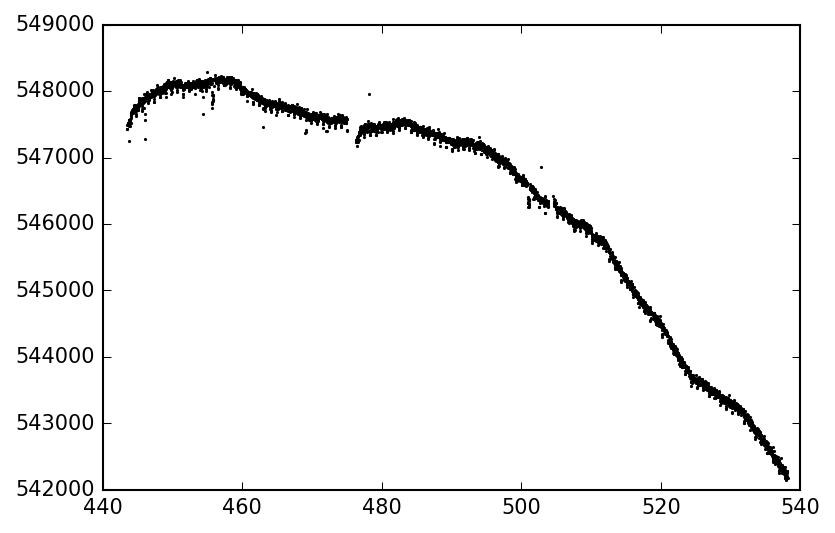

In [30]:
plt.plot(tpf.time, psf_flux, 'ko', markersize=1)

In [31]:
from lightkurve import LightCurve

In [32]:
lc_psf = LightCurve(tpf.time, psf_flux)

In [33]:
lc_aper = tpf.to_lightcurve()

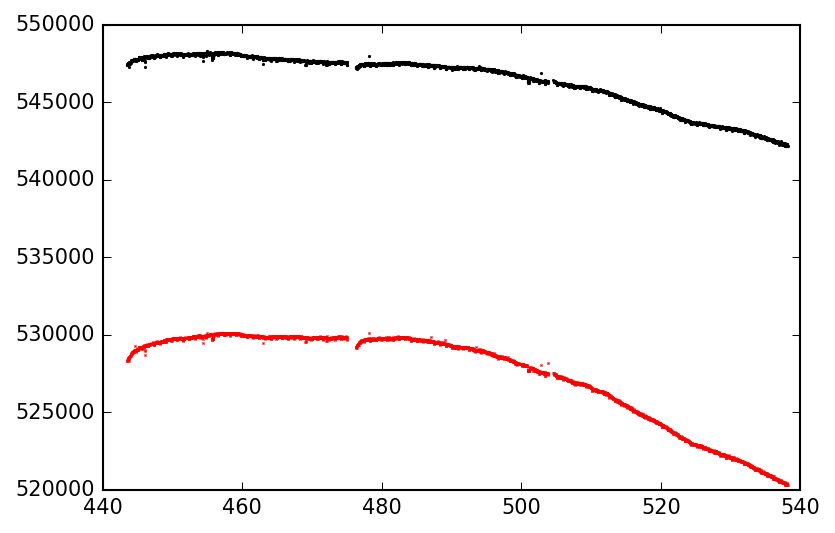

In [34]:
plt.plot(tpf.time, psf_flux, 'ko', markersize=1)
plt.plot(lc_aper.time, lc_aper.flux, 'rx', markersize=1)

In [35]:
lc_aper = lc_aper.flatten().fold(.837495)

In [36]:
lc_psf = lc_psf.flatten().fold(.837495)

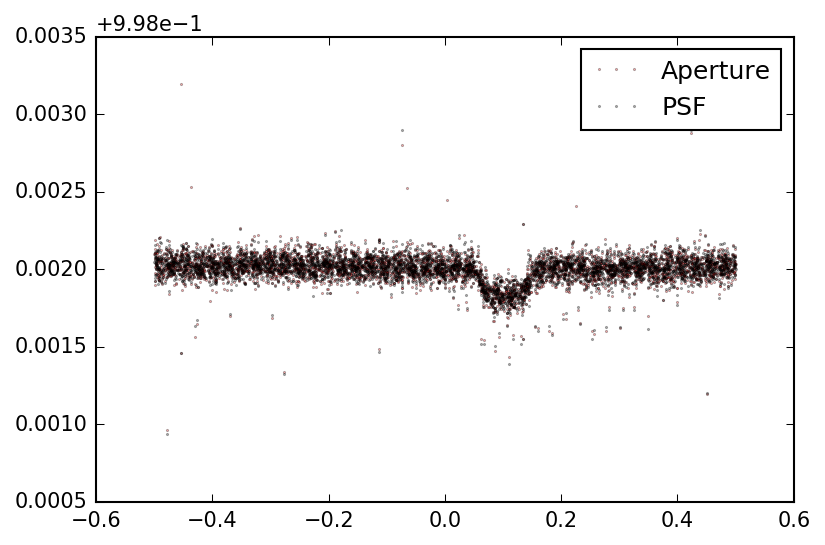

In [37]:
plt.plot(lc_aper.time, lc_aper.flux, 'ro', markersize=1, label='Aperture', alpha=.3)
plt.plot(lc_psf.time, lc_psf.flux, 'ko', markersize=1, label='PSF', alpha=.3)
plt.legend(numpoints=3)

In [ ]:
100 * (1 - lc_psf.cdpp() / lc_aper.cdpp())